In [1]:
import os
import numpy as np
import numpy.random as npr
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
#plt.switch_backend('agg')

from scipy.integrate import odeint

keras = tf.keras
tf.compat.v1.enable_eager_execution()

#from neural_ode import NeuralODE

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
# Definition of the Lotka-Volterra model, with VP = f(x(t), t; theta)
def VP(z, t, alpha, beta, gamma, sigma):
    x, y = z
    dzdt = [alpha * x - beta * x * y, - gamma * y + sigma * x*y]
    return dzdt

# Function to plot the trajectories in the 2D state space
def plot_traj(trajectories, width = 1.):
    x = trajectories[:,0]
    y = trajectories[:,1]
    plt.plot(x, y, linewidth = width)

In [3]:
# Data of the problem
data_size = 16001  # Size of the dataset (fictitious and created by adding noise to the real
                   #  data found through the integration of the system)
batch_time = 320  #
niters = 1000  # Number of Hamiltonian MC iterations
batch_size = 1000

# Parameters of the true model
alpha = 1.
beta = 0.1
gamma = 1.5
sigma = 0.75

In [4]:
t_grid = np.linspace(0, 25, data_size)
z0 = [5., 5.]
true_yy = odeint(VP, z0, t_grid, args=(alpha, beta, gamma, sigma))

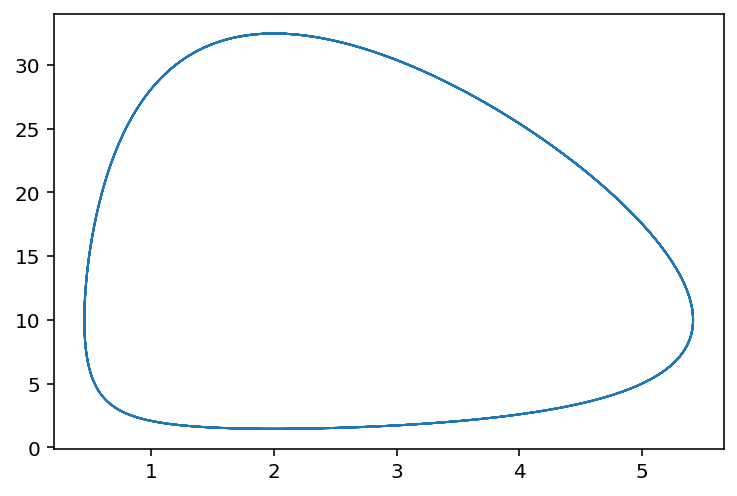

In [5]:
plot_traj(true_yy)

In [6]:
true_y = true_yy.copy()

sigma_x = np.std(true_yy[:, 0:1])  # Standard deviation of data for x = preys
sigma_y = np.std(true_yy[:, 1:2])  # Standard deviation of data for y = predators

noise_level = 0.03  # Adding some nois with this noise level
sigma_normal = max(sigma_x, sigma_y)  # Considering the highest between the 2

true_y[:, 0:1] = true_y[:, 0:1]/sigma_x + noise_level * np.random.randn(true_y[:, 0:1].shape[0], true_y[:, 0:1].shape[1])
true_y[:, 1:2] = true_y[:, 1:2]/sigma_y + noise_level * np.random.randn(true_y[:, 1:2].shape[0], true_y[:, 1:2].shape[1])
# The 2 lines above normalize the data and then add a noise being extract from a gaussian
#  random variable with 0 mean and (noise_level)^2 variance.

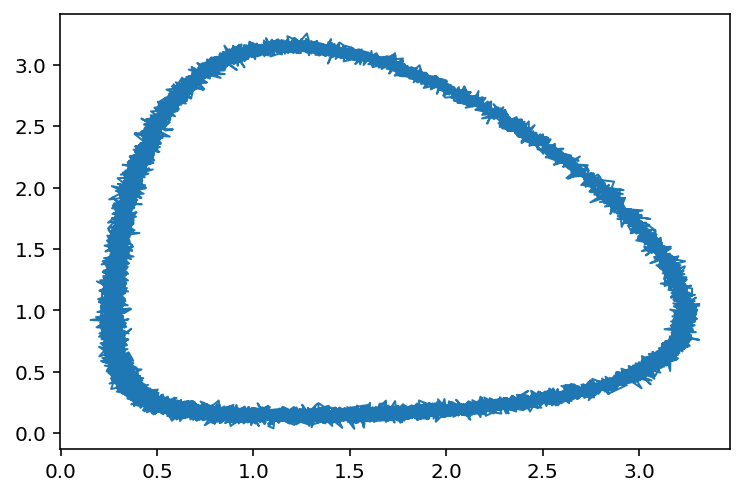

In [7]:
plot_traj(true_y)

In [8]:
def get_batch():
    """Returns initial point and last point over sampled frament of trajectory"""
    starts = np.random.choice(np.arange(data_size - batch_time - 1, dtype=np.int64), batch_size, replace=False)
    # This randomly chooses from {0, 1, ... , data_size - batch_time - 1}, batch_size different elements
    batch_y0 = true_y[starts] 
    batch_yN = true_y[starts + batch_time]
    # The function returns a tensor composed by some y0 and the respective yN,
    #  being y0 + DeltaT.
    return tf.cast(batch_y0, dtype=tf.float32), tf.cast(batch_yN, dtype=tf.float32)

In [9]:
num_param = 4  # Number of parameters
para_num = num_param

t0 = t_grid[:batch_time][0]  # t0 = first element of t_grid
t1 = t_grid[:batch_time][-1]  # t1 = the element of t_grid at batch_time
t_in = np.linspace(t0, t1, 20)  # The time grid between t0 and t1

batch_y0, batch_yN = get_batch()  # Returns the first and the last y observed for each batch

In [10]:
from neural_ode import NeuralODE

In [11]:
#########################################
#         precondition start            #
#########################################
niters_pre = 500  # Number of iterations of the preconditioner

class ODEModel_pre(tf.keras.Model):
    def __init__(self):
        super(ODEModel_pre, self).__init__()
        self.Weights = tf.Variable(tf.random.normal([num_param, 1], dtype=tf.float32)*0.01, dtype=tf.float32)
    # Initializer: assign normally distributed random weights which are very close to zero

    def call(self, inputs, **kwargs):
        t, y = inputs
        h = y
        h1 = h[:, 0:1]  # preys
        h2 = h[:, 1:2]  # predators

        p1 = self.Weights[0]
        p2 = self.Weights[1]
        p3 = self.Weights[2]
        p4 = self.Weights[3]

        h_out1 = p1 * h1 + sigma_y * p2 * h2*h1  # Why sigma_y?? Think it's due to normalization, but boh
        h_out2 = p3 * h2 + sigma_x * p4 * h2*h1  # Why sigma_x??
        h_out = tf.concat([h_out1, h_out2], 1)
        # This function is computing the f(x(t), t; p) at [x,t] in 'inputs' and with p
        #  the actual weights of the model
        return h_out
    
model_pre = ODEModel_pre()
neural_ode_pre = NeuralODE(model_pre, t_in)
optimizer = tf.compat.v1.train.AdamOptimizer(3e-2)

In [12]:
@tf.function
def compute_gradients_and_update_pre(batch_y0, batch_yN):
    """Takes start positions (x0, y0) and final positions (xN, yN)"""
    pred_y = neural_ode_pre.forward(batch_y0)  # Predict y using Runge-Kutta 4 for each y0 in batch_y0
    with tf.GradientTape() as g_pre:
        g_pre.watch(pred_y)
        loss = tf.reduce_mean(input_tensor=(pred_y - batch_yN)**2) + tf.reduce_sum(input_tensor=tf.abs(model_pre.trainable_weights[0]))
        # This step is computing the loss function
    dLoss = g_pre.gradient(loss, pred_y)  # Here we compute the gradient of the loss function
    h_start, dfdh0, dWeights = neural_ode_pre.backward(pred_y, dLoss)  # Here we compute the dWeights
    optimizer.apply_gradients(zip(dWeights, model_pre.weights))  # Here we update the weights
    return loss, dWeights

parameters_pre = np.zeros((para_num, 1))

for step in range(niters_pre):
    print(step)
    loss, dWeights = compute_gradients_and_update_pre(batch_y0, batch_yN)
    parameters_pre = model_pre.trainable_weights[0].numpy()

print(parameters_pre)

#########################################
#          precondition end             #
#########################################

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [13]:
initial_weight = parameters_pre  # We initialize the weights with the parameters found in preconditioning
print(initial_weight.shape, "here")


class ODEModel(tf.keras.Model):
    def __init__(self):
        super(ODEModel, self).__init__()
        self.Weights = tf.Variable(tf.random.normal([num_param, 1], dtype=tf.float32)*0.01, dtype=tf.float32)
        # Initializer, initializes the weight to normal random variables with sd = 0.01

    def call(self, inputs, **kwargs):
        t, y = inputs
        h = y
        h1 = h[:, 0:1]
        h2 = h[:, 1:2]

        p1 = self.Weights[0]
        p2 = self.Weights[1]
        p3 = self.Weights[2]  
        p4 = self.Weights[3] 

        h_out1 = p1 * h1 + sigma_y * p2 * h2*h1  # ?? As before, why sigma_y?
        h_out2 = p3 * h2 + sigma_x * p4 * h2*h1  # ?? As before, why sigma_x?
        h_out = tf.concat([h_out1, h_out2], 1)
        return h_out
    
model = ODEModel()
neural_ode = NeuralODE(model, t=t_in)  # We assign to NeuralODE the just created model and the time grid  between t0 and t1

temp_model = ODEModel()
neural_ode_temp = NeuralODE(temp_model, t=t_in)

@tf.function
def compute_gradients_and_update(batch_y0, batch_yN): 
    """Takes start positions (x0, y0) and final positions (xN, yN)"""
    pred_y = neural_ode.forward(batch_y0)  # This finds the predicted yNs
    with tf.GradientTape() as g:
        g.watch(pred_y)
        loss = tf.reduce_sum(input_tensor=(pred_y - batch_yN)**2)  # This creates the loss function

    dLoss = g.gradient(loss, pred_y)  # This computes the gradient of the loss function
    h_start, dfdh0, dWeights = neural_ode.backward(pred_y, dLoss)  # This applies the gradient descent to find
    # the updates for the weights

    return loss, dWeights

(4, 1) here


In [14]:
# non c'è nel codice

@tf.function
def compute_loss(batch_y0, batch_yN, neuralodes):
    pred_y = neuralodes.forward(batch_y0)  # This finds the predicted yNs
    loss = tf.reduce_mean(input_tensor=(pred_y - batch_yN)**2)
    return loss

In [15]:
w_temp = np.resize([1,-0.1, -1.5, 0.75],(4,1))
temp_model.trainable_weights[0].assign(w_temp) 
compute_loss(batch_y0,batch_yN,neural_ode_temp)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0026331034>

In [16]:
##########################################################################################################################

# DA QUI IN POI NUOVO

# Versione 1.0

# Qui sotto parte una bozza di implementazione del metodo ABC come descritto su
# https://en.wikipedia.org/wiki/Approximate_Bayesian_computation

# In particolare quello che si fa è:
# 1. Sampling dalla prior
# 2. Generazione dell'output D_hat dal modello ottenuto con i parametri theta_hat campionati in 1.
# 3. Calcolo di distance(D_hat, D), dove D è l'output ottenuto dai dati veri
# 4. Se distance(D_hat, D) < epsilon tengo theta_hat, altrimenti butto via e rifaccio

##########################################################################################################################

# We now start the Bayesian framework
# We will compute the Approximate Bayesian Computation approximation from the posterior
model.trainable_weights[0].assign(parameters_pre)
initial_loss, _ = compute_gradients_and_update(batch_y0, batch_yN)   # The result we obtained from the simulation of the model
initial_loss = 0

# In teoria questa loss è un minimo locale, quindi dovrebbe essere la più piccola. Più si è vicini a questa
# loss con i theta individuati e meglio è per la simulazione.
# In alternativa alla loss, per la quale non riesco a trovare giustificazioni teoriche assolutamente convincenti
# si possono prendere le traiettorie e calcolare lo scostamento, questo sarebbe un approccio "esatto", ma computazionalmente
# sbatti...
# initial_trajectories = ...
niters = 50000
naccepted = 0
accepted = False
eps = 0.0125 # con questo Acceptance rate:  0.01064
# To be determined, it is a hyperparameter          
# eps = 0.01 -> acc rate = 0.0086     
# eps = 0.015 -> acc r = 0.01482
# eps = 0.013 -> acc r = 0.01208
# eps = 0.011 -> acc r = 0.00806
# eps = 0.012 -> acc r = 0.00944
parameters = np.zeros((niters, para_num))  # book keeping the parameters
lambdalist = np.zeros((niters, 1))  # book keeping the loggamma
loss = []

# lambda_sim = np.exp(npr.normal())
lambda_sim = 100
w_sim = 0

for i in tqdm(range(niters)):

    # We will consider here the standard Lasso model for data approximation
    # lambda_temp = np.exp(npr.gamma(para_num+1, 1))
    
    # lambda_temp = npr.randint(low = 10, high = 100)
    lambda_temp = npr.uniform(low = 0, high = 10)
    
    # WW = model.trainable_weights[0].numpy() # illegale
    
    # npr.laplace(0, scale=1/lambda_sim, size=WW.size),(2,1)
    
    # per i valori vedi gli output dei parametri stimati alla 500/500 (vedi confronto con SIR per capire)
    w_temp = np.resize([npr.normal(1, 1/lambda_temp), npr.normal(-0.1, 1/lambda_temp), npr.normal(-1.5, 1/lambda_temp), npr.normal(0.75, 1/lambda_temp)], (4,1))
    temp_model.trainable_weights[0].assign(w_temp)

    # After the sampling from the prior we go on by simulating the model
    # sim_trajectories = simulate_trajectories_from_theta_hat(model, w_temp)
    
    sim_loss = compute_loss(batch_y0, batch_yN, neural_ode_temp) # ma qua va guardato modello nuovo senza aggiornare
    loss.append(sim_loss)

    # if abc_distance(initial_trajectories, sim_trajectories) < eps:
    if np.abs(initial_loss - sim_loss) < eps:
        parameters[i:i+1, :] = np.transpose(w_temp)
        lambdalist[i:i+1] = lambda_temp
        lambda_sim = lambda_temp
        w_sim = w_temp
        naccepted += 1
        accepted = True

    else:
        parameters[i:i + 1, :] = np.transpose(w_sim)
        lambdalist[i:i + 1] = lambda_sim
        accepted = False

    # print("Accepted = ", accepted)

print('Acceptance rate: ', naccepted / niters)

np.save('parameters', parameters)  # The Monte Carlo chain of the parameters
np.save('lambda', lambdalist)

np.savetxt("data_weights.csv", parameters, delimiter=',')
np.savetxt("data_lambda.csv", lambdalist, delimiter=',')


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [06:44<00:00, 123.71it/s]


Acceptance rate:  0.01224


In [28]:
def adaptive_gaussian_sampling(true_center, loc, scale, quantile_1, quantile_2):
    if ((sps.norm.cdf(true_center, loc=loc, scale=scale) < quantile_1) | (sps.norm.cdf(true_center, loc=loc, scale=scale) > quantile_2)):
        par = npr.uniform(0,1)
        a = 0
        b = 0
        if true_center > loc:
            a = ((loc + par*(true_center-loc)) - loc)/scale
            b = float('inf')
            print(a)
            w_temp = sps.truncnorm.rvs(a, b, loc=loc, scale=scale)
        else:
            a = ((loc + par*(true_center-loc)) - loc)/scale
            b = -float('inf')
            print(a)
            w_temp = sps.truncnorm.rvs(b, a, loc=loc, scale=scale)
    else:
        w_temp = npr.normal(loc, scale)
    
    return(w_temp)

In [ ]:
# DA QUI IN POI NUOVO

# Versione 2.0 - Adaptive Gaussian Sampling

# Qui sotto parte una bozza di implementazione del metodo ABC come descritto su
# https://en.wikipedia.org/wiki/Approximate_Bayesian_computation

# In particolare quello che si fa è:
# 1. Sampling dalla prior
# 2. Generazione dell'output D_hat dal modello ottenuto con i parametri theta_hat campionati in 1.
# 3. Calcolo di distance(D_hat, D), dove D è l'output ottenuto dai dati veri
# 4. Se distance(D_hat, D) < epsilon tengo theta_hat, altrimenti butto via e rifaccio

##########################################################################################################################

import scipy.stats as sps

# We now start the Bayesian framework
# We will compute the Approximate Bayesian Computation approximation from the posterior
model.trainable_weights[0].assign(parameters_pre)
initial_loss, _ = compute_gradients_and_update(batch_y0, batch_yN)   # The result we obtained from the simulation of the model
initial_loss = 0
# In teoria questa loss è un minimo locale, quindi dovrebbe essere la più piccola. Più si è vicini a questa
# loss con i theta individuati e meglio è per la simulazione.
# In alternativa alla loss, per la quale non riesco a trovare giustificazioni teoriche assolutamente convincenti
# si possono prendere le traiettorie e calcolare lo scostamento, questo sarebbe un approccio "esatto", ma computazionalmente
# sbatti...
# initial_trajectories = ...
niters = 50000
naccepted = 0
eps = 0.23 # Acceptance rate: 0.01034 però i risultati non mi piacciono molto
# To be determined, it is a hyperparameter
# eps = 0.1 -> acc r = 0.00286
# eps = 0.2 -> acc r = 0.0084
# eps = 0.3 -> acc r = 0.0177
parameters = np.zeros((niters, para_num))  # book keeping the parameters
lambdalist = np.zeros((niters, 1))  # book keeping the loggamma
loss = []

lambda_temp = 0
w_temp = 0

for i in tqdm(range(niters)):

    # We will consider here the standard Ridge model for data approximation

    lambda_temp = npr.uniform(low = 0, high = 1.5)
    
    WW = model.trainable_weights[0].numpy()
    
    w_temp_1 = 0
    w_temp_2 = 0
    w_temp_3 = 0
    w_temp_4 = 0
    
    alpha_quant = 0.15 # crasha ogni volta, ogni volta dopo un numero differente di iterazioni.
    # trovato su stackoverflow:
            #I've encountered the same problem as well. 
            #The thing is that the lower bound a is above (or close to) the 99% quantile of the Normal distribution.
            #Thus the truncation causes scipy to crush.
            #The only solution I came out with is to check before truncation if myclip_a is above the 99% quantile and
            #if so avoid the update. I hope that someone will find a better solution than mine!

    w_temp_1 = adaptive_gaussian_sampling(WW[0], 0, 1/lambda_temp, alpha_quant, 1-alpha_quant)
    w_temp_2 = adaptive_gaussian_sampling(WW[1], 0, 1/lambda_temp, alpha_quant, 1-alpha_quant)
    w_temp_3 = adaptive_gaussian_sampling(WW[2], 0, 1/lambda_temp, alpha_quant, 1-alpha_quant)
    w_temp_4 = adaptive_gaussian_sampling(WW[3], 0, 1/lambda_temp, alpha_quant, 1-alpha_quant)
    
    w_temp = np.resize([w_temp_1, w_temp_2, w_temp_3, w_temp_4], (4,1))
    temp_model.trainable_weights[0].assign(w_temp) 

    # After the sampling from the prior we go on by simulating the model
    # sim_trajectories = simulate_trajectories_from_theta_hat(model, w_temp)
    
    sim_loss = compute_loss(batch_y0, batch_yN, neural_ode_temp) # ma qua va guardato modello nuovo senza aggiornare
    loss.append(sim_loss)

    # if abc_distance(initial_trajectories, sim_trajectories) < eps:
    if np.abs(initial_loss - sim_loss) < (eps + npr.uniform()*eps*1/3):
        parameters[naccepted:naccepted+1, :] = np.transpose(w_temp)
        lambdalist[naccepted:naccepted+1] = lambda_temp
        naccepted += 1

print('Acceptance rate: ', naccepted / niters)

parameters = parameters[0:naccepted,:]
lambdalist = lambdalist[0:naccepted,:]

np.save('parameters', parameters)  # The Monte Carlo chain of the parameters
np.save('lambda', lambdalist)

np.savetxt("data_weights.csv", parameters, delimiter=',')
np.savetxt("data_lambda.csv", lambdalist, delimiter=',')

  0%|                                                                                | 9/50000 [00:00<09:38, 86.35it/s]

[0.807109]
[-0.57275087]
[0.8148926]
[-1.1503989]
[0.44241822]
[-0.38270515]
[0.8527562]
[-0.521437]
[0.94007653]
[-1.1838502]
[0.5091879]
[0.8343946]
[-1.7173094]
[0.07074239]
[-2.0603235]
[0.6125023]
[0.5897706]
[-1.6139305]
[0.13560538]
[-0.47541142]
[-0.696424]
[0.4543234]
[-0.7021557]
[0.31804216]
[0.6353992]
[-1.4030981]
[0.0246579]
[-0.4168211]
[1.0755603]
[-0.19848001]
[0.6544864]
[-0.12300231]

  0%|                                                                               | 30/50000 [00:00<08:56, 93.14it/s]


[0.03097705]
[-1.1324456]
[0.6169815]
[-0.43981808]
[-0.89463836]
[1.0630015]
[-0.5132351]
[-0.35667646]
[0.6943102]
[-1.6626091]
[0.8377513]
[-0.22324735]
[0.6892773]
[-0.69679743]
[-0.61226743]
[0.7779121]
[-1.1888885]
[-1.1337134]
[0.17387569]
[-0.47912785]
[1.0270324]
[0.6162067]
[-0.41921017]
[0.41460082]
[-1.8635476]
[0.97072303]

  0%|                                                                               | 50/50000 [00:00<08:42, 95.56it/s]


[0.74927]
[-0.20129806]
[1.1354066]
[-0.22487545]
[0.6843385]
[-1.2252781]
[-1.3040072]
[0.81300014]
[-1.7247287]
[1.087213]
[-0.4726649]
[0.557194]
[-0.812925]
[-0.11429425]
[0.2311767]
[-0.84503883]
[0.3215292]
[-0.34869784]
[-0.8092087]
[0.08943035]
[-1.7093017]
[0.275355]

  0%|                                                                               | 70/50000 [00:00<08:41, 95.73it/s]


[-0.8099416]
[0.3552479]
[-0.47417927]
[0.6260862]
[-0.69100744]
[-1.3871034]
[-0.08781905]
[-0.06598554]
[0.91645795]
[-0.79836774]
[0.87662375]
[-1.3202728]


  0%|                                                                               | 79/50000 [00:00<10:17, 80.87it/s]

[0.02519635]
[0.974003]
[-0.24767804]
[0.6467069]
[-0.5064893]
[-0.7297386]
[0.7277299]
[-0.55380505]
[0.9535092]
[-1.4824553]


  0%|▏                                                                              | 96/50000 [00:01<11:29, 72.38it/s]

[0.8595009]
[-1.471573]
[-0.58599365]
[-0.69566536]
[0.52166355]
[-0.39441118]
[-0.6950765]
[-0.6228602]
[0.46973196]
[-0.48390442]
[0.88433903]
[0.35547507]
[-0.46445957]

  0%|▏                                                                             | 104/50000 [00:01<12:48, 64.97it/s]


[0.16246547]
[-1.8642776]
[0.42417696]
[-0.6228847]
[-1.3711911]
[0.2868866]
[-0.44631654]
[0.48572904]
[-1.9425695]

  0%|▏                                                                             | 111/50000 [00:01<14:08, 58.77it/s]


[-0.6603598]
[0.22398835]
[-1.2487683]
[-1.0214196]
[0.856634]
[-0.61549497]


  0%|▏                                                                             | 129/50000 [00:01<11:54, 69.81it/s]

[0.9820429]
[-1.7542403]
[-0.6128761]
[0.7363142]
[-0.12504041]
[0.80196685]
[-0.3646245]
[-0.8799234]
[-0.06536711]
[0.09467891]
[-0.03851778]
[1.1721607]
[-1.9137068]
[0.5278836]
[0.7313787]
[-1.3428322]
[0.5069394]

  0%|▏                                                                             | 151/50000 [00:01<09:47, 84.79it/s]


[-0.5845229]
[0.08791271]
[0.831474]
[-0.88575065]
[-0.5646901]
[-0.73162675]
[-0.9225765]
[-0.12031391]
[-1.2628435]
[-0.37768155]
[-0.05582248]
[-0.8567076]
[1.0636234]
[-0.85226333]
[0.49883196]
[-0.21098243]
[-1.010761]

  0%|▎                                                                             | 172/50000 [00:02<08:57, 92.79it/s]


[0.8840382]
[-1.4914662]
[-1.1604099]
[-0.22313993]
[-0.57817376]
[-0.79368037]
[0.7420108]
[-0.04964095]
[-0.7080311]
[0.4050793]
[-1.2062205]
[-0.3557367]
[-0.8420647]
[0.7297505]
[-1.3313444]
[0.8686753]
[-1.1415806]


  0%|▎                                                                             | 193/50000 [00:02<08:36, 96.41it/s]

[0.53174174]
[-1.4860008]
[-0.90320164]
[-0.45274636]
[-0.185811]
[-0.5350195]
[0.30217028]
[-1.3801608]
[-0.5803623]
[0.88892967]
[-1.4782155]
[-0.77403957]
[0.4587704]
[-0.95532835]
[0.33818528]
[-0.48180482]
[0.75670624]

  0%|▎                                                                            | 215/50000 [00:02<08:11, 101.35it/s]


[-1.7365952]
[0.27888146]
[0.9467099]
[-0.22629379]
[-0.7212265]
[0.22548468]
[-0.8433144]
[0.03416363]
[-1.4562787]
[-0.59061944]
[0.95959204]
[-1.2965486]
[-0.66018206]
[-1.1989956]
[-0.37860003]
[0.6371025]
[-1.9742912]
[0.22237864]
[1.3475598]
[-1.6878064]
[0.91037697]
[-0.55298454]
[-0.9536335]

  0%|▎                                                                            | 237/50000 [00:02<08:00, 103.67it/s]


[0.09744678]
[-1.0841063]
[0.53793216]
[-0.9171738]
[-0.12223202]
[-0.3673517]
[-0.1814178]
[0.71261126]
[-0.71462566]
[-1.307811]
[0.3275696]
[-1.4801788]
[0.02051079]
[-0.99957097]
[0.9053164]

  0%|▍                                                                            | 248/50000 [00:02<07:58, 104.07it/s]


[-1.6871271]
[0.7047111]
[0.67935073]
[-1.8587581]
[-0.5544156]
[-1.1769909]
[0.86355597]
[-0.2716936]
[0.98304456]
[-0.22618514]
[0.67172396]
[-1.9580623]
[0.6416039]
[-0.18189448]
[0.6554993]
[-0.33611456]
[0.97889256]
[-0.68901336]


  1%|▍                                                                            | 271/50000 [00:02<07:50, 105.64it/s]

[1.1829058]
[-1.1064795]
[-0.7898083]
[-1.2947417]
[0.38652205]
[-0.8005202]
[0.44213668]
[-0.93851274]
[0.14371377]
[-1.2064946]
[-0.24603051]
[0.12863217]
[-0.80097556]
[0.6555092]
[-1.5365205]
[0.1677963]
[-1.4037257]
[0.6116747]
[1.3664646]
[-0.27340466]
[0.82951826]
[0.9069677]
[-0.08796529]
[0.11345074]

  1%|▍                                                                            | 294/50000 [00:03<07:43, 107.13it/s]


[-1.2376143]
[1.2146542]
[-0.87494206]
[0.16041175]
[0.4597562]
[-1.2984539]
[1.2236772]
[-0.4720614]
[0.04112001]
[-0.2424571]
[1.0841022]
[-0.8585585]
[-0.13544068]
[1.0414945]
[-0.6961418]
[1.2666101]
[-1.2439265]
[0.7638919]
[-1.6973897]
[-1.1059102]
[-0.61228126]
[-0.7546033]
[0.10660149]

  1%|▍                                                                            | 317/50000 [00:03<07:34, 109.25it/s]


[-0.73026145]
[-1.0991274]
[-1.0414294]
[1.4301136]
[-1.6309673]
[0.74210733]
[1.2644956]
[-1.3622397]
[0.4591884]
[1.0434381]
[-1.2179683]
[0.6539952]
[-1.5819628]
[0.29990965]
[-0.21361227]
[1.0435044]
[-1.8241625]
[0.25528535]
[-1.9646169]
[-0.13841748]
[0.21824588]
[-1.2345841]
[0.91815627]

  1%|▌                                                                            | 340/50000 [00:03<07:35, 109.01it/s]


[-1.4699477]
[0.07981593]
[-0.5801724]
[0.34657976]
[0.14993425]
[-0.31254753]
[0.95528066]
[-0.5123442]
[-1.0704993]
[-0.50288945]
[0.52543294]
[-0.84889054]
[1.1865569]
[-0.3328784]
[1.0951967]
[0.70448625]
[-0.59340143]
[0.84910446]
[-1.0388882]
[-0.11888536]
[-0.810174]

  1%|▌                                                                            | 351/50000 [00:03<07:37, 108.42it/s]


[0.38393718]
[-0.875865]
[0.8094909]
[-0.31085005]
[-0.313791]
[0.69247454]
[-0.03092484]
[0.9563461]
[-0.8177026]
[-0.87206393]
[-0.65525293]
[0.40653852]
[-1.4132808]
[1.2594275]
[-1.5009769]
[-1.1656388]
[0.16938916]
[-0.86812776]
[-1.3122947]
[-0.07030918]
[0.41424704]
[-0.06146059]
[-0.09481322]
[-0.00842301]


  1%|▌                                                                            | 374/50000 [00:03<07:34, 109.27it/s]

[0.2894631]
[-0.594361]
[0.00012683]
[-0.90030056]
[-0.11546943]
[0.41947976]
[-0.94017327]
[0.6125433]
[0.30693358]
[-1.9856132]
[-0.16956036]
[1.009007]
[-0.04780339]
[-1.0334631]
[1.0873535]
[-1.7145703]
[0.58065337]
[-0.98962235]
[0.46310216]
[0.05894871]
[-1.0699991]
[1.010381]
[0.91084534]
[-0.02665243]
[0.12222461]
[-0.10289731]
[-0.5747383]
[-0.3733863]

  1%|▌                                                                            | 396/50000 [00:04<07:42, 107.35it/s]


[-0.44769296]
[0.38102967]
[-1.4576603]
[0.21542163]
[-1.880879]
[0.8009573]
[-1.1625743]
[0.02742212]
[1.1104718]
[-0.34604543]
[0.96314317]
[0.10790771]
[-0.75358844]
[0.27185595]
[-0.59632117]
[0.9527153]
[-0.87904876]
[0.49016422]
[-0.61298674]
[-1.0191733]
[-0.86995727]
[0.9951415]

  1%|▋                                                                            | 418/50000 [00:04<07:42, 107.18it/s]


[-1.959362]
[0.53902483]
[0.15491864]
[-0.21445937]
[0.14001891]
[-1.8400892]
[0.522359]
[-0.36701223]
[-0.52891946]
[0.0174746]
[-0.5487506]
[0.8933367]
[-0.8678144]
[0.9688793]
[-1.0106871]
[-0.64543754]
[-1.0468442]
[-0.719043]
[0.9923467]

  1%|▋                                                                            | 440/50000 [00:04<07:42, 107.23it/s]


[-1.2609804]
[0.3753154]
[0.5486896]
[-0.69402194]
[-1.163167]
[-0.2960854]
[-0.75511813]
[0.27094784]
[-1.2999257]
[0.52099204]
[-2.0166707]
[0.673623]
[-1.5100975]
[1.0302724]
[1.3109769]
[-0.24504858]
[0.13404685]
[-1.050168]
[-0.6650939]
[-1.4185157]
[0.42320445]
[-1.7098495]
[0.5371139]
[-1.6634941]

  1%|▋                                                                            | 464/50000 [00:04<07:26, 111.04it/s]


[1.0374359]
[-0.6244957]
[0.8966498]
[-1.005726]
[-0.19927372]
[-0.23521751]
[-0.5791784]
[0.5730077]
[-0.7304184]
[-0.5108113]
[-0.3694257]
[-0.71562034]
[0.16542515]
[-0.83803993]
[-0.548908]

  1%|▋                                                                            | 476/50000 [00:04<07:24, 111.46it/s]


[0.7387426]
[-0.706102]
[1.0186855]
[-0.11939693]
[-0.35311547]
[-0.55188835]
[-1.0386202]
[-1.1999137]
[0.454322]
[-1.1322627]
[-0.0775588]
[-0.12611741]
[-1.3676409]
[0.37047026]
[-0.7062815]


  1%|▊                                                                            | 500/50000 [00:05<07:27, 110.56it/s]

[0.47317874]
[-0.5072273]
[-0.3934282]
[0.2361535]
[-1.9204692]
[0.3525904]
[0.80126256]
[-0.20513925]
[0.44848138]
[-0.6904197]
[0.31812915]
[-0.8155236]
[0.14009729]
[-1.3277617]
[-0.12923284]
[-1.1218698]
[0.7145578]
[-0.41999105]
[-0.9312855]
[0.12706284]
[-1.360619]
[-0.19356467]

  1%|▊                                                                            | 524/50000 [00:05<07:24, 111.42it/s]


[1.3374292]
[-1.0683689]
[0.33829883]
[1.1773487]
[-0.38521886]
[1.0231706]
[-0.5733729]
[0.5678781]
[-1.7101353]
[0.54060054]
[-1.3145578]
[0.32354736]
[-0.5545901]
[-1.1480343]
[0.8197613]
[-1.2044976]
[0.35711235]
[-0.6046173]
[-0.75588673]

  1%|▊                                                                            | 548/50000 [00:05<07:25, 110.89it/s]


[0.6378682]
[-0.75750047]
[0.24117239]
[-0.5114481]
[-0.01668679]
[0.6801032]
[-1.0254836]
[-0.28235635]
[0.54941684]
[-1.4499108]
[1.4207747]
[-1.27845]
[0.19590472]
[0.16154411]
[-1.8920557]
[1.300111]
[-0.70649487]
[-0.20457079]


  1%|▉                                                                            | 572/50000 [00:05<07:28, 110.12it/s]

[-0.9980446]
[0.43293285]
[-1.2502701]
[0.35451958]
[-1.1868614]
[0.4520815]
[-0.17929244]
[0.07864681]
[-1.667351]
[1.1986626]
[-0.9489186]
[0.4585898]
[-1.0362338]
[0.99834347]
[-1.8504875]
[0.84822196]
[-0.3345906]
[0.74087584]
[-0.7095523]
[-1.2831681]
[-0.07337996]
[-0.20237917]
[0.7908175]
[-1.9586625]
[1.0471932]
[-1.5031202]
[-0.11488186]
[-0.7753916]
[-0.5353163]

  1%|▉                                                                            | 595/50000 [00:05<07:31, 109.36it/s]


[0.27316168]
[-0.55650735]
[1.1428354]
[-0.98958784]
[-0.6181663]
[-0.13787258]
[-0.94852334]
[-0.0379645]
[0.26210153]
[-0.6967486]
[0.15355851]
[-0.5896538]
[0.5786434]
[-1.2732042]
[-1.2432593]

  1%|▉                                                                            | 617/50000 [00:06<07:34, 108.60it/s]


[-0.31114945]
[0.89586484]
[-0.5329168]
[-0.6908297]
[-0.59263617]
[1.2205126]
[-1.9781507]
[0.31254065]
[-0.33374983]
[1.0133089]
[-0.74655455]
[0.9587158]
[-0.49963522]
[-0.39323568]
[0.3130087]
[-0.00766687]
[0.7750527]

  1%|▉                                                                            | 628/50000 [00:06<07:33, 108.78it/s]


[-1.1427631]
[0.0297385]
[-0.9016541]
[0.30414662]
[-1.1216619]
[0.00478284]
[-0.6376348]
[0.21317317]
[-1.3798522]
[-0.69928247]
[0.96519774]
[-0.3112258]
[0.73906523]
[-0.7382581]
[-1.078317]
[-0.0307625]
[-0.65405214]


  1%|█                                                                            | 652/50000 [00:06<07:23, 111.16it/s]

[-0.05427126]
[0.6705306]
[-1.4151356]
[0.07295311]
[0.09007918]
[-0.2651524]
[0.3136907]
[-0.8559033]
[0.58069617]
[-1.3434229]
[1.1391177]
[-1.5091728]
[0.5118112]
[-1.2106382]
[-0.84445137]
[0.28971043]
[-1.5420945]
[0.9558763]
[0.2697801]
[-1.1937103]
[-1.2108284]
[0.71361244]
[-1.325982]
[1.3048927]
[-1.7843125]


  1%|█                                                                            | 676/50000 [00:06<07:23, 111.16it/s]

[0.8781365]
[-1.3808322]
[0.771976]
[-0.18651313]
[0.4989727]
[-1.5996721]
[1.1992804]
[-0.30083793]
[0.4328052]
[1.0752721]
[-1.4901072]
[-1.0115579]
[-0.97315055]
[-0.7033618]
[-0.93545884]
[0.5557472]
[-0.08006561]
[-1.4658045]
[0.2758858]

  1%|█                                                                            | 700/50000 [00:06<07:15, 113.19it/s]


[-0.69734263]
[-0.6878702]
[0.39806348]
[-1.5871698]
[1.0430866]
[-0.05675794]
[-0.8760251]
[1.1720375]
[-0.3758001]
[-1.1360221]
[-0.9849811]
[0.83196366]
[-1.0111305]
[0.65276754]
[-0.49686503]
[1.0512513]
[-1.7708023]
[-1.0001903]

  1%|█                                                                            | 724/50000 [00:07<07:27, 110.02it/s]


[0.48234093]
[-0.19689152]
[0.2627873]
[0.34087345]
[-0.9387228]
[0.1568208]
[0.96744645]
[-1.7325655]
[0.7404797]
[-0.27196315]
[0.04144196]
[-1.3081204]
[-0.55786043]
[-1.3646464]
[-1.0745121]
[-0.89822984]
[-0.89481574]
[0.51970685]

  1%|█▏                                                                           | 748/50000 [00:07<07:21, 111.59it/s]


[-0.24224752]
[1.0211614]
[-0.99630004]
[-0.14331456]
[0.33684507]
[-1.2533804]
[0.61635953]
[-1.1876779]
[0.49296027]
[-0.70728695]
[-1.1507981]
[0.9619168]
[-1.7251147]
[-0.913561]
[0.84371716]
[-0.5505176]
[-0.55443275]

  2%|█▏                                                                           | 760/50000 [00:07<07:23, 110.92it/s]


[0.9907531]
[-1.0807565]
[-0.40241504]
[-1.2508848]
[0.36837325]
[-1.4863027]
[-0.58472055]
[-1.0294818]
[-0.8026513]
[1.2273018]
[-0.69798434]
[-0.02801945]
[-0.8284118]
[-0.11644219]

  2%|█▏                                                                           | 784/50000 [00:07<07:18, 112.22it/s]


[0.6851625]
[-1.2429855]
[1.0562813]
[-1.7325071]
[1.149073]
[-0.35898173]
[-0.11814246]
[-1.159637]
[-0.05686102]
[0.39461914]
[-0.06716367]
[0.80499107]
[-0.79771096]
[0.17895785]
[-0.9685981]
[0.5160696]
[-1.8194995]
[0.49279007]
[0.4334146]

  2%|█▏                                                                           | 808/50000 [00:07<07:15, 112.94it/s]


[-0.8686749]
[-0.28653893]
[0.32974997]
[-1.0899519]
[1.1781734]
[-0.67118835]
[-0.762063]
[1.0324818]
[-0.03923855]
[-1.4024673]
[-1.1072575]
[-0.9651147]
[0.3373677]
[-1.5197335]
[1.0819389]
[-0.37009138]
[0.65320426]
[-0.4738745]

  2%|█▎                                                                           | 832/50000 [00:08<07:22, 111.23it/s]


[-0.7487686]
[0.28512797]
[-1.8120463]
[0.02343075]
[1.1445305]
[-0.15111269]
[0.18789202]
[-0.06535511]
[1.0283318]
[-1.386082]
[1.0403075]
[-0.43116018]
[-1.0400789]
[0.02080064]
[-1.4383233]
[1.170557]
[-0.51311433]
[-0.277806]

  2%|█▎                                                                           | 844/50000 [00:08<07:23, 110.82it/s]


[0.98889554]
[-0.40978682]
[0.31965378]
[-1.1215284]
[-0.38657328]
[-0.80125314]
[-0.9499585]
[0.75655746]
[-0.1594734]
[0.0614671]
[-1.3500478]
[-1.2381603]
[0.6980787]
[-1.2882755]
[0.23061201]
[-0.00882849]
[1.0720702]
[-0.5990427]
[0.29109102]
[-1.218827]


  2%|█▎                                                                           | 868/50000 [00:08<07:23, 110.84it/s]

[-1.3855475]
[-0.75201]
[-0.3855719]
[-0.95837116]
[-0.05295915]
[0.44049853]
[-0.5720795]
[0.06972427]
[-0.38091293]
[0.28402415]
[-1.0473815]
[0.8636356]
[-0.701972]
[-0.83296025]
[0.85573196]
[-1.2352535]
[0.20312329]
[-1.6377407]
[-0.9035542]
[-0.9514424]


  2%|█▎                                                                           | 892/50000 [00:08<07:22, 110.88it/s]

[0.18096837]
[-0.01538255]
[0.00307495]
[-1.707776]
[0.89401203]
[-1.1212701]
[0.8568747]
[-1.2728773]
[1.0944799]
[-1.8877704]
[-0.71738434]
[-0.28027236]
[0.2889303]
[-1.6159778]
[-1.0996867]
[-0.28670743]
[0.43879914]

  2%|█▍                                                                           | 916/50000 [00:08<07:23, 110.60it/s]


[-1.3877298]
[0.5743008]
[-1.8179058]
[1.0669129]
[-1.1628611]
[1.101006]
[-1.5282878]
[0.55282474]
[-1.3761755]
[0.6036767]
[-0.38647228]
[-0.08491497]
[1.032759]
[-1.4316424]
[-0.0270521]
[0.36985406]
[-0.04087188]
[0.03854172]
[-0.72780555]
[0.8831728]
[-1.1176041]
[1.1396228]
[-1.828762]
[0.7128532]


  2%|█▍                                                                           | 940/50000 [00:09<07:11, 113.78it/s]

[-0.47332862]
[-0.47291547]
[1.2439994]
[-0.80438185]
[0.12107932]
[0.83016294]
[-1.2032342]
[-1.0821881]
[0.3274993]

  2%|█▍                                                                           | 952/50000 [00:09<07:16, 112.42it/s]


[-0.6300688]
[1.0542419]
[-0.6201902]
[0.8739291]
[-0.53498167]
[-0.8862396]
[-0.04135337]
[0.898022]
[-0.43521416]
[0.88423586]
[-0.09643732]
[0.09335531]
[-1.1884472]
[0.37379274]
[-0.34581894]
[-0.06086264]


  2%|█▌                                                                           | 976/50000 [00:09<07:19, 111.62it/s]

[-1.2684891]
[0.5147524]
[-1.2367]
[1.0119152]
[-1.2435889]
[0.17960058]
[-0.6024181]
[0.71904236]
[-0.6550497]
[-0.26305884]
[0.7999724]
[-0.40804076]
[0.10442698]
[0.28975257]
[-0.59843135]
[1.2136494]
[-1.2159907]
[0.45283017]
[-0.23317401]
[0.28643247]
[-1.0818714]
[0.5205398]
[-0.5624911]
[0.04494542]
[-0.34432864]
[-0.47037607]
[-0.04449213]
[-0.24669634]
[0.96176875]

  2%|█▌                                                                           | 999/50000 [00:09<07:36, 107.27it/s]


[-0.211399]
[-0.04891775]
[-0.26189062]
[-1.2591155]
[1.1364608]
[-1.2534345]
[0.510333]
[-0.28793722]
[0.49348643]
[-0.28318536]
[1.1562382]
[-0.6896086]
[0.22645803]
[-0.35601968]
[0.9166301]
[-1.3364383]
[0.72030616]
[-1.6083275]
[1.2581571]
[-1.4250201]
[0.75343275]
[-0.41730776]
[-1.3163476]
[0.78904206]
[-0.5149301]
[-0.2923316]
[0.4942803]

  2%|█▌                                                                          | 1021/50000 [00:09<07:37, 107.07it/s]


[-1.6515013]
[-0.7927234]
[-0.7925467]
[0.4396488]
[-1.2008866]
[0.13917513]
[-0.7974285]
[0.4334713]
[-0.84790546]
[0.25513443]
[-2.1460311]
[0.41536415]
[-0.9053039]
[1.0988573]
[-0.49747524]
[-0.10811666]
[-0.5766774]
[0.626932]
[-0.4864273]
[0.8931975]
[-0.54651487]
[1.3810037]
[-0.36802787]
[0.5715305]


  2%|█▌                                                                          | 1045/50000 [00:10<07:21, 110.99it/s]

[-0.57780874]
[0.48535654]
[-0.09134068]
[0.55874115]
[-0.96486473]
[-1.143349]
[1.0920495]
[-1.5431373]
[-0.29174903]
[-0.9764009]
[1.2220631]
[-1.0329882]
[0.7115669]
[-0.22733]

  2%|█▌                                                                          | 1069/50000 [00:10<07:29, 108.97it/s]


[0.01798148]
[-1.0470746]
[-0.26622766]
[0.44101024]
[-0.25091946]
[0.40000486]
[-1.7016728]
[0.83425766]
[-1.2955331]
[0.03827812]
[-0.8348969]
[0.80368257]
[0.29662645]
[-0.5311369]
[-0.47599718]
[-0.40448764]
[1.0662147]
[-1.6735289]
[-0.14939088]
[-0.54848063]
[0.11496136]

  2%|█▋                                                                          | 1080/50000 [00:10<07:31, 108.40it/s]


[-0.4238694]
[-0.38560084]
[0.41837198]
[-0.08229826]
[0.69258964]
[0.8410838]
[-1.7998908]
[0.62922853]
[0.26939493]
[-0.37311366]
[-0.9644901]
[-0.6392107]
[-0.6207268]


  2%|█▋                                                                          | 1105/50000 [00:10<07:27, 109.17it/s]

[-0.8041766]
[0.984597]
[-0.34277856]
[0.7402456]
[1.0877929]
[-1.0126975]
[0.3573215]
[-0.3783958]
[0.43068314]
[-1.0338594]
[1.1947794]
[-0.62070584]
[-0.6933523]
[0.18727827]
[-0.6661436]
[0.76327074]
[-2.0327055]
[0.4720011]
[-1.0550354]
[0.7780103]
[-1.0763694]
[0.5616469]
[-1.7883705]
[0.18710963]
[-0.9736563]
[0.9411998]
[-0.5586295]
[0.46197072]

  2%|█▋                                                                          | 1128/50000 [00:10<07:27, 109.16it/s]


[-0.02199513]
[0.20857881]
[-0.8729672]
[0.6573522]
[-0.7639175]
[0.5248996]
[-1.1156161]
[-0.7461173]
[0.4685341]
[-0.11605863]
[0.71270096]
[-0.15380783]
[0.06783849]
[-0.9166574]
[0.89501953]
[-1.5353241]
[-0.9587111]
[-1.2672497]

  2%|█▋                                                                          | 1150/50000 [00:10<07:31, 108.28it/s]


[0.54044527]
[-1.3279005]
[1.1451201]
[-0.61744595]
[0.6591642]
[-1.8808533]
[0.3020763]
[-0.0807724]
[-0.5873602]
[-0.79940146]
[-0.98167324]
[0.9597303]
[-0.9518519]
[0.8653091]
[-1.4603559]
[-0.35791534]
[0.4071661]
[-1.2216091]
[0.9240309]
[-0.1383663]
[0.99650204]
[0.4879238]
[-1.3976184]


  2%|█▊                                                                          | 1173/50000 [00:11<07:23, 110.22it/s]

[-0.9190874]
[0.965391]
[-1.8584006]
[0.3547404]
[0.77203286]
[-1.5928544]
[1.4462783]
[-1.2954493]
[0.17690799]
[-0.39223158]
[0.74827665]
[-1.041555]
[0.27053434]
[-0.2909805]
[-0.9847495]
[1.0000789]
[-0.32522812]
[-0.8247918]

  2%|█▊                                                                          | 1185/50000 [00:11<07:26, 109.36it/s]


[0.6934176]
[-1.8831255]
[0.49269253]
[0.3593896]
[-1.3776631]
[-0.3729223]
[1.1846244]
[-0.94648737]
[0.8372288]
[-1.1344194]
[-0.5060513]
[0.8218075]
[-0.884342]
[-0.9293792]
[-1.1416987]
[0.4896031]
[-1.4754925]
[-0.8653217]
[0.13148679]
[-1.7305682]
[-0.03296004]
[-0.8112369]
[0.2550078]

  2%|█▊                                                                          | 1207/50000 [00:11<07:26, 109.28it/s]


[-0.01396943]
[0.5484996]
[0.8034201]
[-0.84179133]
[-1.1120627]
[0.03200031]
[-1.6171722]
[-1.1570699]
[0.1508368]
[-0.65464777]
[0.24774058]
[-1.7984965]
[-1.1600804]
[-1.4737723]
[0.8311329]
[-0.5388185]
[-0.644177]
[-0.7097358]


  2%|█▊                                                                          | 1231/50000 [00:11<07:21, 110.40it/s]

[0.71647483]
[-0.4519424]
[-0.7006108]
[-0.7445677]
[0.45536613]
[-1.8352927]
[0.15512997]
[-1.0660592]
[-0.16125086]
[0.82947564]
[-1.8504944]
[0.5068635]
[0.9348865]
[-0.17377776]
[0.93367887]
[0.63309556]
[-1.4663454]
[-0.68541926]
[0.5135067]
[-0.00082094]
[1.178727]
[-1.9587258]
[0.65119785]

  3%|█▉                                                                          | 1255/50000 [00:11<07:28, 108.72it/s]


[-1.1361511]
[1.2540336]
[-1.4840846]
[0.69659144]
[-1.2781602]
[0.56161743]
[-0.14857876]
[1.0312456]
[-0.85008097]
[0.52671236]
[-1.9386452]
[0.7418145]
[-1.4419773]
[0.89779836]
[-0.18004467]
[-0.16665916]
[-0.9912216]
[1.1185836]
[-0.61590683]
[0.23656468]
[-1.0274493]

  3%|█▉                                                                          | 1277/50000 [00:12<07:37, 106.59it/s]


[1.2905596]
[-0.7579943]
[1.2009188]
[-1.8416257]
[0.68899405]
[-0.72023964]
[0.8845724]
[-0.6309201]
[-0.8762239]
[1.0025876]
[-1.5421004]
[0.10811871]
[-1.0647515]
[0.9498909]
[-0.592558]
[0.5094383]
[-1.0110286]
[1.0460902]
[0.9729405]
[-0.23655574]
[0.0634014]
[-1.3623506]
[0.4193115]
[-0.00745141]
[0.98289883]
[-1.287474]


  3%|█▉                                                                          | 1288/50000 [00:12<07:42, 105.21it/s]

[-0.7829788]
[0.07174066]
[-1.8027878]
[0.50520736]
[0.48658556]
[-1.3459613]
[0.15894009]
[-0.5982467]
[-0.41956314]
[-0.78639793]
[-0.79792434]
[1.000272]
[-0.7764681]
[0.14191042]
[-0.68991816]
[-1.077301]

  3%|██                                                                           | 1309/50000 [00:12<08:58, 90.39it/s]


[-0.34216934]
[-1.3140512]
[0.26181355]
[-1.6560923]
[-0.91460574]
[-0.7234501]
[-0.80361557]
[1.0477853]
[-1.6926678]
[0.30763534]
[0.34135926]
[-1.5506608]
[0.8567905]
[0.28171003]
[-0.2038811]
[0.03731732]

  3%|██                                                                           | 1319/50000 [00:12<09:08, 88.81it/s]


[-0.8115122]
[-0.27583134]
[1.0596547]
[-0.47832853]
[-0.6831759]
[1.1665407]
[-0.0618135]
[0.8738783]
[-0.8510849]
[-0.35654557]
[-0.04308223]
[-0.6302336]
[0.99395937]
[-0.93991524]
[0.6658807]
[-0.6511635]
[-0.49668553]


  3%|██                                                                           | 1342/50000 [00:12<08:16, 98.10it/s]

[1.3050181]
[-1.8615751]
[0.475268]
[-1.9045422]
[0.7256828]
[-0.5237504]
[0.20101887]
[-1.2787862]
[-1.0863752]
[-1.3928298]
[0.12184716]
[-1.0942029]
[0.5752025]
[-0.34784916]
[-0.5974029]
[0.32125703]
[-1.1998093]
[0.12979843]
[-0.43659985]
[0.52430755]
[-0.60146797]
[0.58202404]

  3%|██                                                                          | 1364/50000 [00:13<07:50, 103.26it/s]


[-0.03468034]
[-0.51770747]
[-0.2987367]
[0.284425]
[-0.1549231]
[-1.0670927]
[-1.1538061]
[0.7960024]
[-0.78302056]
[0.60071003]
[-1.2260233]
[-0.23426914]
[0.56765914]
[-0.7805311]
[0.57414484]
[-0.47029898]
[0.212115]


  3%|██                                                                          | 1387/50000 [00:13<07:32, 107.45it/s]

[-0.40502632]
[0.13702229]
[-1.7518095]
[0.13433786]
[-1.8256972]
[1.0403452]
[-0.98912305]
[-1.0332772]
[0.8714929]
[-0.877005]
[1.0512979]
[-1.0568813]
[0.02999493]
[-0.8885611]
[-1.2555261]
[-0.46745265]
[1.0420692]
[-1.3952346]
[1.2189587]

  3%|██▏                                                                         | 1410/50000 [00:13<07:23, 109.49it/s]


[-0.10256689]
[-0.05852785]
[1.2349734]
[-1.2404763]
[0.42713484]
[-0.58193016]
[-0.5676201]
[-0.68176144]
[0.03374299]
[-0.5853225]
[1.1763693]
[-1.680703]
[0.49712193]
[-1.5424654]
[-0.668262]
[-0.83249784]
[0.05214202]
[-0.7780983]
[0.598242]
[-0.8687228]
[0.40595984]
[-0.44203094]

  3%|██▏                                                                         | 1422/50000 [00:13<07:33, 107.12it/s]


[0.62977237]
[-1.9035497]
[0.67031235]
[-0.6147895]
[-0.77530813]
[-1.0345256]
[1.1806707]
[-0.6293138]
[0.8379375]
[-0.18353157]
[-1.1016653]
[-0.06275267]
[-0.0355602]


  3%|██▏                                                                         | 1446/50000 [00:13<07:20, 110.32it/s]

[0.54598767]
[-0.6794894]
[-0.17716022]
[1.0764631]
[-2.0506868]
[0.16902833]
[0.54678136]
[-1.1576779]
[0.43295664]
[-1.1715028]
[0.93212354]
[-2.1936512]
[0.53125757]
[-0.20391229]
[-1.3955482]
[0.46843582]
[-1.2510843]
[0.43287325]

  3%|██▏                                                                         | 1470/50000 [00:14<07:17, 110.96it/s]


[-2.1502528]
[0.0831597]
[-1.1050239]
[0.5030216]
[-0.24456865]
[-0.408075]
[0.07093822]
[-0.21908066]
[0.67668283]
[-1.255102]
[-0.814842]
[-0.9882244]
[0.9305348]
[-0.688069]
[-0.44185543]
[-1.3485913]
[-0.06930131]
[-0.39035285]
[0.95862216]

  3%|██▎                                                                         | 1494/50000 [00:14<07:17, 110.88it/s]


[-1.1340293]
[0.9812231]
[-1.0132607]
[1.1903617]
[-1.6346953]
[1.0360459]
[0.32492208]
[-1.6258991]
[0.402047]
[-1.1522429]
[0.8946911]
[-1.7538406]
[-1.3264492]
[-0.5227588]
[-0.67980224]
[-1.1965759]
[1.0587317]

  3%|██▎                                                                         | 1506/50000 [00:14<07:28, 108.18it/s]


[-0.6997213]
[0.8941514]
[0.7143547]
[-0.9268564]
[0.27733737]
[-0.20403682]
[-0.28381371]
[0.8777495]
[-0.971621]
[0.62834656]
[-1.679525]
[0.26310003]
[-0.32611355]
[0.91259354]
[-0.62957215]
[0.88914466]
[-0.929272]
[0.8946558]
[-1.482414]
[-0.3989024]
[-0.1749607]
[-0.08933361]
[1.02551]
[-0.0572435]
[0.7326929]
[-0.4727913]
[0.43884054]


  3%|██▎                                                                         | 1530/50000 [00:14<07:23, 109.40it/s]

[-0.828812]
[0.8967105]
[-1.4596196]
[0.94553983]
[-0.46406808]
[0.8980809]
[-0.94987166]
[-0.00436486]
[-0.5734687]
[0.6140085]
[-1.2601141]
[0.06962439]
[-1.3566532]
[0.2691509]
[-1.0119061]
[0.34798095]
[-0.13234799]
[0.1879747]
[-0.18278095]
[0.13344842]
[-1.0811994]
[-0.8690184]

  3%|██▎                                                                         | 1554/50000 [00:14<07:12, 112.03it/s]


[0.5976433]
[-0.8016192]
[-0.13964376]
[-0.9565295]
[0.9078191]
[-0.4464374]
[-1.0409458]
[0.68192524]
[-0.6605127]
[0.42449597]
[0.27240855]
[-1.5246588]


  3%|██▍                                                                         | 1578/50000 [00:14<07:07, 113.20it/s]

[-1.0101244]
[0.71968174]
[-0.11707411]
[0.6178801]
[-0.62130666]
[0.11298196]
[1.1726412]
[-0.8916881]
[-0.7732927]
[0.23361625]
[-0.9533439]
[0.871344]
[-0.89912987]
[-0.0876234]
[-0.48422286]
[0.9457042]

  3%|██▍                                                                         | 1601/50000 [00:15<07:46, 103.81it/s]


[-1.9367671]
[1.0227016]
[0.0971656]
[-0.9499585]
[-0.6185699]
[-0.6662179]
[-0.9432461]
[-0.7397366]
[-0.5418243]
[-0.43860677]
[0.7129886]
[-0.56288815]
[0.76510614]
[0.28854996]
[-1.6662945]
[-0.6546946]

  3%|██▍                                                                         | 1612/50000 [00:15<08:01, 100.48it/s]


[-0.6079887]
[-0.8101714]
[0.65157396]
[-0.30490738]
[0.5446832]
[-1.1621846]
[1.0434109]
[-0.14898077]
[-0.56148154]
[1.2582448]
[-1.0028877]
[0.985935]
[0.2558041]
[-1.7836136]
[-0.9277255]
[-1.1121993]

  3%|██▌                                                                          | 1634/50000 [00:15<08:14, 97.86it/s]


[1.0566496]
[-0.1310005]
[0.24771792]
[0.02296039]
[-1.5997946]
[0.781763]
[1.0063125]
[-0.70024854]
[-1.162924]
[-0.69524324]
[0.2212558]
[-0.7007798]
[-0.10184567]
[-0.28255576]

  3%|██▌                                                                          | 1654/50000 [00:15<08:26, 95.38it/s]


[0.42168468]
[-0.4297704]
[0.10169473]
[-0.05614299]
[-0.26257727]
[0.798546]
[-0.7501466]
[0.8316658]
[-0.69712794]
[0.27064788]
[-1.14007]
[0.19644393]
[-0.8053461]
[0.9486402]
[-0.32015553]
[-1.1749386]

  3%|██▌                                                                          | 1674/50000 [00:15<08:35, 93.80it/s]


[-0.4229076]
[-1.0096686]
[-0.7366168]
[-0.54923934]
[0.79686034]
[-1.198521]
[0.190306]
[1.1934094]
[-1.0071582]
[1.0659243]
[-0.13702019]
[0.74893016]
[-0.04955753]
[0.76626515]
[-0.28914702]
[1.1925632]

  3%|██▌                                                                          | 1684/50000 [00:16<09:05, 88.56it/s]


[-0.8684933]
[-0.10493707]
[0.59809]
[-0.2135439]
[0.01012906]
[-0.73854756]
[0.06754617]
[-0.13245587]
[-0.47602883]
[0.7220533]
[-1.0645101]
[-0.57264066]
[-1.1002407]
[0.5756171]
[-1.2014811]
[-0.66179436]

  3%|██▌                                                                          | 1704/50000 [00:16<08:41, 92.66it/s]


[0.27906853]
[-1.7301384]
[-0.12687708]
[0.99188864]
[-1.1307302]
[0.80002683]
[1.0358568]
[-0.8441925]
[-1.0792443]
[0.71877944]
[-0.59983677]
[0.76030886]
[-0.31731427]
[0.6764911]
[-0.39044333]
[-0.96756446]

  3%|██▋                                                                          | 1724/50000 [00:16<08:33, 93.95it/s]


[-0.4273224]
[-0.7401535]
[0.5009767]
[-1.1856536]
[0.5656554]
[-0.9852188]
[0.67942965]
[-0.32034114]
[-0.08773455]
[1.3885747]
[-1.4890361]
[0.5514493]


  3%|██▋                                                                          | 1744/50000 [00:16<08:30, 94.44it/s]

[0.03469785]
[-0.14157706]
[0.44038433]
[-0.9567768]
[0.7604184]
[-0.88777405]
[0.43216085]
[-1.798394]
[-1.0138386]
[0.7818866]
[-0.29016832]
[0.2224563]
[-1.9746304]
[-0.3846281]
[-0.28856406]

  4%|██▋                                                                          | 1764/50000 [00:16<08:30, 94.44it/s]


[0.14434321]
[-1.2956709]
[-0.19455783]
[-0.90207106]
[-0.8092554]
[0.26927263]
[-0.49027708]
[0.99960196]
[-1.0687147]
[0.01334155]
[-0.61284477]
[-0.66007715]
[0.24491948]
[-0.36363143]


  4%|██▋                                                                          | 1774/50000 [00:17<08:34, 93.69it/s]

[-0.30164793]
[-0.7092574]
[0.3522163]
[-1.1705719]
[0.61134076]
[-0.7344048]
[0.61551076]
[-0.48406732]
[1.0132595]
[-1.0010723]
[0.8725726]
[-0.37424022]
[0.0338129]
[-0.05505632]
[-0.8946532]
[0.4766267]
[-0.92946476]


  4%|██▊                                                                          | 1794/50000 [00:17<08:42, 92.33it/s]

[0.48251158]
[-1.5007986]
[0.6800481]
[0.64875764]
[-0.6321529]
[0.7951604]
[-1.1643497]
[0.07802783]
[-0.8693124]
[0.11479043]
[0.20681033]
[-1.3268982]
[1.2475557]
[-0.7956473]
[0.17461716]
[0.64203393]
[-1.3809861]
[0.6952748]
[-1.5735482]
[1.1034619]
[-0.04706473]
[1.4021816]
[-1.3374878]
[0.8492476]
[-0.6492982]


  4%|██▊                                                                         | 1817/50000 [00:17<08:01, 100.08it/s]

[-0.44724715]
[-0.22271591]
[0.27633268]
[-0.69943]
[0.94856024]
[-1.0170426]
[1.0276967]
[1.3111416]
[-0.28275138]
[-1.2289488]
[-0.82309794]
[0.19167237]
[-1.1105287]
[0.3585002]
[-1.5304346]
[-0.01901373]


  4%|██▊                                                                         | 1841/50000 [00:17<07:33, 106.23it/s]

[0.21269697]
[-0.00984582]
[-0.87949127]
[0.5288902]
[-0.675864]
[0.67182904]
[-1.2263489]
[0.5659979]
[-0.46801606]
[0.9792223]
[-0.9840223]
[0.70906645]
[-1.4501384]
[0.76934284]
[1.2895153]
[-0.07525472]
[0.25711372]
[-0.00448831]
[0.12636739]
[-1.2691047]
[1.0817739]

  4%|██▊                                                                         | 1864/50000 [00:17<07:22, 108.82it/s]


[-1.0418422]
[0.83604753]
[0.60080695]
[-1.1097941]
[0.5885422]
[-1.4940748]
[1.0120963]
[-1.1169567]
[-1.1002026]
[-0.961205]
[-0.30247557]
[-0.09562967]
[0.8385217]
[-0.46434847]
[0.9687987]
[0.20643997]
[-1.4531125]
[0.17795134]

  4%|██▊                                                                         | 1886/50000 [00:18<07:34, 105.97it/s]


[-0.5479999]
[0.17621444]
[-0.9198074]
[0.8870168]
[-1.813603]
[1.0543698]
[-1.2551218]
[0.04195007]
[0.80849737]
[-2.099887]
[0.70568097]
[1.1527965]
[-1.5070678]
[0.5327474]
[0.58203834]
[-1.4226606]
[0.9855079]
[1.1216301]
[-0.3968921]
[0.72337896]
[0.515407]
[-1.1882714]
[0.665406]
[-0.17930928]
[-0.4660465]
[-0.71631765]
[0.02901092]
[-1.6701409]
[0.9484239]
[-1.0469828]
[-1.057188]

  4%|██▉                                                                         | 1897/50000 [00:18<07:40, 104.49it/s]


[1.0297472]
[-0.26524302]
[1.1128035]
[-0.26065233]
[0.48050058]
[-0.7016592]
[1.2322844]
[-1.5363337]
[0.6473931]
[-0.64319986]
[0.7765182]
[-0.5280458]
[1.2196293]
[-0.58671117]
[0.11106226]
[-1.0032303]
[0.9770581]
[-0.04444601]
[1.0542783]
[-0.12685627]
[-1.3017126]
[1.1540672]
[-0.7551089]
[0.4665202]

  4%|██▉                                                                         | 1919/50000 [00:18<07:36, 105.25it/s]


[-0.6238343]
[0.5289733]
[0.9532319]
[-0.26438212]
[-0.02356964]
[0.5794094]
[-0.0532796]
[0.8075325]
[-1.5026922]
[0.10178484]
[-1.5000175]
[0.08332534]
[0.9296807]
[-0.5092483]
[0.89621323]
[-2.0796213]
[0.8515658]
[-1.0844151]
[1.1035647]
[-1.5654452]
[1.0389334]
[-0.51932436]
[1.3261454]

  4%|██▉                                                                         | 1942/50000 [00:18<07:28, 107.13it/s]


[-1.1719798]
[0.22087002]
[-0.4825741]
[-0.09085064]
[-0.67719394]
[0.21855266]
[-1.9579961]
[0.8501506]
[1.2392029]
[-0.88001347]
[0.4631128]
[-1.4450303]
[0.22083826]
[-0.49802145]
[-0.19144635]
[1.013475]
[-0.16150188]
[0.20172152]
[-0.25169596]
[0.54169106]
[0.90392905]

  4%|██▉                                                                         | 1967/50000 [00:18<07:06, 112.63it/s]


[-0.29000065]
[-1.1782064]
[-0.98783326]
[-0.0353789]
[0.66670334]
[-1.4847703]
[0.43995696]
[0.746692]
[-1.8599911]
[-0.43374902]
[-0.66927916]

  4%|███                                                                         | 1991/50000 [00:19<07:19, 109.17it/s]


[-0.7567473]
[-1.112947]
[1.2719467]
[-1.6483884]
[0.3084845]
[-0.41747355]
[0.30746144]
[0.71964693]
[-1.6427826]
[0.7036223]
[-0.8323003]
[1.0588251]
[1.2286627]
[-0.06934334]
[0.33320463]
[-2.037363]
[0.10272662]
[1.0365558]
[-0.78277624]
[-0.3518115]
[-0.6286289]
[0.24193813]
[-1.5172731]
[0.14559287]
[-0.05206096]
[0.02898131]
[0.70035875]

  4%|███                                                                         | 2002/50000 [00:19<07:26, 107.58it/s]


[-1.7746999]
[1.3397968]
[-1.8215953]
[0.6924027]
[-1.2133033]
[-0.9627688]
[0.15680902]
[-0.16381447]
[-0.48032746]
[0.3227845]
[-1.1464356]
[0.6964177]
[-1.0727811]
[0.00405726]
[-1.6032615]
[0.5163101]
[-1.5712092]
[0.3681639]
[-0.6888271]
[1.1795596]
[-2.0093033]
[0.41329846]
[-0.8032984]


  4%|███                                                                         | 2025/50000 [00:19<07:19, 109.14it/s]

[1.2352337]
[-1.6764011]
[0.48576415]
[-0.854334]
[0.7090277]
[-1.5598063]
[0.94874895]
[-0.27842057]
[1.148793]
[-1.0755632]
[0.38344407]
[0.99627197]
[-1.1168121]
[-1.1923407]
[0.5986133]
[-1.519377]
[0.45423228]
[-0.13544987]


  4%|███                                                                         | 2049/50000 [00:19<07:19, 109.00it/s]

[-0.32705423]
[0.8951638]
[-1.6074425]
[0.23736213]
[-1.7778839]
[0.95225734]
[-0.45288977]
[1.0153354]
[-0.48375514]
[0.13316585]
[-0.05340401]
[0.45409924]
[0.5395397]
[-0.8415048]
[-1.4876558]
[-1.0684001]
[-1.0154542]
[1.1350702]
[-0.825773]
[0.7294538]
[-0.5638438]
[0.25663176]
[-1.0132276]
[0.81486773]
[-0.78640133]
[0.5749012]
[-1.5665725]

  4%|███▏                                                                        | 2072/50000 [00:19<07:15, 110.13it/s]


[0.18898673]
[-0.24495924]
[0.19616967]
[-1.0546247]
[0.3372903]
[-0.3024559]
[-0.3873379]
[0.91877747]
[-1.1573706]
[0.3058705]
[-1.1169589]
[-1.0278144]
[-1.2668419]
[-0.8437014]
[0.02476231]
[-1.4768559]
[-0.85255855]
[0.7199781]

  4%|███▏                                                                        | 2095/50000 [00:20<07:20, 108.72it/s]


[-0.3344152]
[0.6332351]
[-0.7942496]
[-1.059189]
[-0.4786794]
[1.0834818]
[-2.0516138]
[0.64525884]
[1.3502467]
[-0.5452057]
[-1.0552496]
[0.8067641]
[-1.9593655]
[0.97977436]
[-0.14084844]
[0.32031402]
[-0.14657737]
[0.28040612]
[-0.34693816]
[-0.40919274]
[-0.7111599]

  4%|███▏                                                                        | 2118/50000 [00:20<07:08, 111.75it/s]


[0.7497773]
[-1.8277708]
[0.21060471]
[0.5164102]
[-0.3965945]
[-0.4557181]
[-0.64394027]
[0.5401247]
[-0.28004405]
[1.1274526]
[-0.18499549]
[0.7628411]
[-0.8228054]
[-1.0746634]
[0.07007556]

  4%|███▏                                                                        | 2130/50000 [00:20<07:15, 109.81it/s]


[-1.1261857]
[0.27049178]
[-0.2389304]
[0.98521477]
[-1.0867941]
[0.7323242]
[-1.6958785]
[1.1421846]
[-1.2474984]
[1.0142465]
[-1.4708086]
[-0.64699763]
[0.6949822]
[-1.3979118]
[0.44140562]
[0.3162944]
[-1.8412426]
[0.09482408]
[0.28581268]
[-0.25404665]
[-0.8281247]

  4%|███▎                                                                        | 2154/50000 [00:20<07:19, 108.75it/s]


[1.0628666]
[-0.6665998]
[0.7873894]
[-1.0317096]
[0.06969059]
[-1.8087356]
[-1.0922446]
[0.03024532]
[-0.5633274]
[1.0177629]
[-0.27406493]
[-0.1516107]
[-0.26937342]
[-1.1079929]

  4%|███▎                                                                        | 2177/50000 [00:20<07:26, 106.99it/s]


[0.70374227]
[-1.9264108]
[0.2322634]
[1.0129035]
[-0.18782404]
[0.05027689]
[-1.251192]
[0.17954636]
[-0.92124134]
[0.22827257]
[-0.2172331]
[0.47391754]
[-0.6236457]
[0.0025535]
[-1.0197102]
[-0.02158734]
[-0.8938879]
[-0.7389582]
[0.73457664]
[-1.0254165]
[0.73153305]
[-1.7620287]
[-1.1365082]
[-0.1136701]

  4%|███▎                                                                        | 2200/50000 [00:21<07:15, 109.64it/s]


[0.02544956]
[-1.1463593]
[-0.02305764]
[-0.03749882]
[1.2495164]
[-1.4661138]
[1.281455]
[-0.9110524]
[0.2920663]
[0.20242922]
[-0.417782]
[0.71140957]
[-1.0282152]
[1.1755663]
[-0.5477094]
[1.462388]

  4%|███▎                                                                        | 2212/50000 [00:21<07:25, 107.22it/s]


[-1.4683062]
[0.17483959]
[0.09990611]
[-1.9566526]
[0.7222698]
[0.89016986]
[-1.8644718]
[0.66563886]
[-0.58611083]
[0.22531714]
[-1.1308644]
[1.0954467]
[-1.4893279]
[1.0330985]
[-0.6162979]
[-0.38165757]
[0.66548645]
[-1.0496972]
[-0.9101954]
[-0.5787068]
[0.81255597]
[-0.65939623]
[-0.9053628]

  4%|███▍                                                                        | 2236/50000 [00:21<07:15, 109.79it/s]


[0.6874592]
[-0.18474431]
[-0.23682061]
[-0.251908]
[-1.1325221]
[0.4497524]
[-0.88174254]
[0.5826759]
[-0.33955005]
[0.137429]
[0.00319654]
[-1.1201655]
[-0.47950828]
[0.6730779]

  5%|███▍                                                                        | 2260/50000 [00:21<07:11, 110.67it/s]


[-0.12111922]
[0.33991498]
[-0.4556642]
[-0.29890305]
[0.20614025]
[-0.16852912]
[0.00824632]
[-1.19604]
[0.88283724]
[-0.5463518]
[0.0273018]
[-1.2860738]
[-0.11981424]
[-0.75074106]
[-0.5477727]
[0.20180967]
[-1.1279801]
[0.7125773]
[-0.8616076]
[-1.2043712]
[-0.4998827]

  5%|███▍                                                                        | 2272/50000 [00:21<07:12, 110.28it/s]


[0.45278338]
[-1.881669]
[0.29591325]
[0.58831066]
[-1.2837937]
[-0.84957665]
[-0.9345048]
[-0.13833053]
[-0.7521542]
[1.327088]
[-0.18851255]
[0.20335184]
[-0.55610126]


  5%|███▌                                                                        | 2309/50000 [00:22<07:02, 112.91it/s]

[0.8578217]
[-0.73191065]
[0.66443753]
[-0.10457675]
[0.9240756]
[-1.9618119]
[0.28326046]
[0.99455273]
[-1.0725677]
[1.0496608]
[0.2768244]
[-0.51946455]
[0.2302504]
[-0.887861]
[0.9478627]
[-0.3438237]
[0.7575958]
[-0.11393727]
[-0.50193536]
[-0.4401897]
[0.71108633]
[-0.7350199]
[0.44711563]

  5%|███▌                                                                        | 2321/50000 [00:22<07:08, 111.36it/s]


[-0.7053337]
[0.13367629]
[-1.8401462]
[0.06647754]
[-0.617565]
[-0.44539705]
[-0.86283463]
[0.48700118]
[-0.29154968]
[-0.37844744]
[0.9979637]
[-1.5346587]
[1.0908056]
[-1.5237571]
[-0.8605114]
[-0.9102847]


  5%|███▌                                                                        | 2345/50000 [00:22<07:16, 109.20it/s]

[0.02476573]
[-0.5768362]
[0.536262]
[-0.0291801]
[0.40751338]
[-0.66936433]
[-0.02812734]
[0.3001417]
[-0.27124202]
[-0.8151733]
[1.2623779]
[-0.6673231]
[0.9028816]
[-0.25636193]
[0.71519643]
[-1.6931772]
[1.0230696]
[-0.0558821]
[-1.0291765]
[0.6194171]

  5%|███▌                                                                        | 2368/50000 [00:22<07:14, 109.54it/s]


[-0.7477206]
[-1.3105105]
[0.62735856]
[-0.02090434]
[0.36568314]
[-1.5697659]
[-0.6163654]
[-1.1786786]
[1.0107344]
[-0.5218401]
[0.98151577]
[-1.560433]
[0.81178063]
[-1.7540734]
[0.18534419]

  5%|███▋                                                                        | 2392/50000 [00:22<07:05, 111.93it/s]


[-1.0158303]
[-1.3046459]
[1.0020641]
[-0.86705774]
[0.9475917]
[-0.59114176]
[0.9137527]
[-0.79925376]
[-0.89731395]
[0.1142025]
[-1.0280154]
[1.0169483]

  5%|███▋                                                                        | 2404/50000 [00:22<07:10, 110.54it/s]


[-0.67363006]
[-0.32398483]
[-0.81457627]
[0.6677284]
[-2.012164]
[-0.7579591]
[-0.86846024]
[0.9079444]
[-1.5313641]
[0.6510763]
[-1.6175743]
[-0.1804416]
[0.8592477]
[-0.7164819]
[0.54531723]
[-0.81202835]
[-0.15899248]
[-0.94938207]
[0.5931381]
[-0.08388589]
[0.87699896]
[-1.1944734]
[0.08480377]
[-1.7693025]


  5%|███▋                                                                        | 2440/50000 [00:23<07:09, 110.74it/s]

[0.5445895]
[-0.8557985]
[0.24719231]
[-2.0219357]
[0.80281866]
[1.392728]
[-1.6392852]
[0.5279794]
[-0.33773944]
[-0.9432939]
[0.5359108]
[-0.64458096]
[1.1406779]
[-0.96033895]
[-1.0205704]
[-0.00295512]
[-0.6063258]
[0.23756234]
[-0.12057791]
[0.89809656]
[-0.64677095]


  5%|███▋                                                                        | 2452/50000 [00:23<07:10, 110.33it/s]

[0.3933668]
[-1.1321158]
[1.0335882]
[-0.6243622]
[-0.64343894]
[-0.10995368]
[0.25440156]
[-0.04527436]
[0.46183994]
[-1.6839694]
[0.0597681]
[-1.1130936]
[0.30999103]
[-1.2010185]
[0.44895673]
[-1.0873069]
[-0.3128285]
[-0.01913659]
[0.5825015]
[-0.22688352]
[0.14693178]

  5%|███▊                                                                        | 2475/50000 [00:23<07:16, 108.97it/s]


[-1.2951866]
[0.43420452]
[0.4864171]
[-1.074729]
[-0.7686289]
[0.19237229]
[-0.2465689]
[-1.0225364]
[1.2647758]
[-1.3299162]
[0.7424384]
[-1.1534839]
[-0.25987163]
[-0.59550095]
[1.2891524]

  5%|███▊                                                                        | 2498/50000 [00:23<07:11, 110.08it/s]


[-0.02290476]
[0.22110736]
[-0.08067113]
[0.2014358]
[-1.4216247]
[-0.22592899]
[0.85453844]
[-0.5725421]
[-0.57494414]
[0.6285169]
[-1.519064]
[0.7460943]
[-0.6734808]
[0.355724]
[-0.41469088]
[-1.0460283]
[1.0192286]
[-0.07406706]
[-0.40047514]


  5%|███▊                                                                        | 2522/50000 [00:23<07:05, 111.55it/s]

[1.1140367]
[-0.661057]
[0.71870124]
[-1.7890645]
[-0.79142886]
[-0.06647822]
[1.3623502]
[-1.5775574]
[0.00312349]
[-0.9030894]
[0.2575226]
[-1.2469971]
[0.04750813]
[-0.24688733]
[0.7420657]
[0.802358]
[-1.5735366]
[0.6358772]
[0.2645108]
[-0.93165976]
[0.08626955]
[-0.6653798]
[-0.8630469]

  5%|███▊                                                                        | 2546/50000 [00:24<07:09, 110.50it/s]


[0.3032974]
[-0.4865792]
[-0.9345748]
[-1.3824645]
[0.3117979]
[-0.60505235]
[0.97860044]
[-0.06910027]
[0.7116849]
[0.84362644]
[-1.0078106]
[0.79608315]
[-0.33046806]
[-0.29726917]
[-1.0279787]
[0.98089266]

  5%|███▉                                                                        | 2558/50000 [00:24<07:13, 109.56it/s]


[-0.73730534]
[0.06157784]
[-0.8823331]
[0.69484526]
[-0.55952907]
[-1.0937681]
[0.8663491]
[-0.14815816]
[0.03325868]
[-2.1298273]
[0.58720356]
[0.1587685]
[-1.4091841]
[-0.39216587]
[0.6951134]
[-0.7151036]
[0.8164806]
[-0.901385]
[-0.12790816]
[0.9480824]
[-0.15788227]
[0.30162048]
[-2.0756345]
[0.8170757]
[-0.23769502]


  5%|███▉                                                                        | 2580/50000 [00:24<07:22, 107.14it/s]

[0.51811457]
[-0.15853979]
[-1.224137]
[0.00331774]
[-0.42171356]
[0.22562201]
[0.14847839]
[-0.43643168]
[0.27236992]
[-0.02867893]
[0.58281887]
[-0.99124867]
[1.0118421]
[-0.59690315]
[-0.21029909]
[-0.43438375]
[-0.0553316]
[-0.93994933]
[0.01375479]
[-0.07594974]
[0.51694876]

  5%|███▉                                                                        | 2602/50000 [00:24<07:20, 107.55it/s]


[-1.4541992]
[0.5195533]
[-0.1879746]
[1.0174865]
[-0.7585632]
[0.93398744]
[-0.5349383]
[-0.11309455]
[-0.2988207]
[0.5297378]
[-1.1761941]
[0.5311221]
[-0.75944793]
[-1.3470194]
[0.21639676]
[-1.5439216]
[-0.16420251]
[-0.7682722]
[-1.1005315]
[0.12416115]

  5%|███▉                                                                        | 2626/50000 [00:24<07:12, 109.57it/s]


[-0.39450678]
[1.2514385]
[-1.9988687]
[0.18022403]
[-0.6265878]
[-0.97785383]
[-0.10015804]
[1.0935153]
[-0.66634107]
[-0.5236931]
[-0.12341948]
[0.81959707]
[-0.5817487]
[-1.0448848]
[0.27875024]
[-1.6037499]
[-0.47950822]
[-1.2312162]


  5%|████                                                                        | 2650/50000 [00:25<07:14, 108.99it/s]

[0.41559651]
[-1.3354486]
[0.94880533]
[-1.7981504]
[0.99377126]
[-0.32735562]
[0.3108599]
[-1.6188378]
[0.519382]
[-1.221027]
[0.71688044]
[-1.263645]
[0.8303066]
[-0.26787087]
[0.3932702]
[-0.5938787]
[0.02778605]
[0.43268505]
[-0.0384313]
[0.8292235]
[-0.60216624]
[-0.9609137]

  5%|████                                                                        | 2673/50000 [00:25<07:06, 110.99it/s]


[0.43320003]
[-0.79804]
[-0.3646051]
[0.21365695]
[-0.67653924]
[-0.52729744]
[1.0621457]
[-0.8044984]
[-0.19781666]

  5%|████                                                                        | 2697/50000 [00:25<07:10, 109.86it/s]


[-0.27429894]
[0.99497706]
[-1.1675042]
[0.15563226]
[-0.9489099]
[0.72282964]
[-0.3835401]
[-0.30251196]
[-0.4520099]
[-0.6069592]
[0.18573241]
[-0.39818466]
[0.9599157]
[-1.3080375]
[0.73069745]
[-1.6155778]
[0.06360028]
[-0.01201137]
[0.89380807]
[-1.6913546]
[-1.1004108]
[0.19921106]
[-1.4463555]
[1.0427845]
[-0.3743559]
[0.6973536]

  5%|████                                                                        | 2709/50000 [00:25<07:16, 108.24it/s]


[-1.7296818]
[0.6036735]
[0.31279564]
[-1.1451708]
[0.50897694]
[0.16362426]
[-1.171632]
[-0.6168368]
[-0.30228782]
[-0.6175879]
[0.33816233]
[-1.680186]
[-0.8623315]
[-1.1355413]
[-0.24842608]
[-0.51541656]
[-0.38402247]
[-1.0137354]
[-1.0612798]


  5%|████▏                                                                       | 2733/50000 [00:25<07:08, 110.25it/s]

[-0.5928514]
[0.5673545]
[-0.961811]
[0.29322457]
[0.70305043]
[-0.69899786]
[0.1946226]
[-0.8193055]
[0.18095437]
[-1.6868358]
[-0.18450038]
[0.75646514]
[-0.28531542]
[0.03332516]
[-0.4865089]
[0.26925787]
[-1.7516564]
[-1.0978031]


  6%|████▏                                                                       | 2757/50000 [00:26<07:05, 111.14it/s]

[0.6047234]
[-1.4996533]
[-0.3558696]
[-0.53183347]
[0.12596273]
[-0.08627239]
[0.2863122]
[-0.46412566]
[-0.84813136]
[0.20206816]
[-1.8410207]
[-0.5802941]
[-0.18004705]
[0.23694378]
[-1.0170639]
[0.47655675]
[-0.6842525]
[1.2291449]

  6%|████▏                                                                       | 2781/50000 [00:26<06:59, 112.63it/s]


[-0.3390747]
[0.07183086]
[-0.06517079]
[0.96554106]
[-0.7617741]
[-0.7741159]
[0.41401982]
[-1.4988067]
[0.5280055]
[-1.401463]
[0.2880875]
[-0.22504586]
[-0.79878277]
[-0.4354074]
[-0.5163986]

  6%|████▎                                                                       | 2805/50000 [00:26<07:03, 111.35it/s]


[0.37618878]
[-0.9935555]
[0.5633612]
[-1.0342323]
[-1.2166212]
[0.60599357]
[-0.82978565]
[-0.06923299]
[-1.0813476]
[-1.2922683]
[1.1691489]
[-1.0726714]
[0.39959258]
[-0.6069508]
[1.0259845]
[-1.2755845]
[0.6897162]
[-1.1078534]

  6%|████▎                                                                       | 2817/50000 [00:26<07:11, 109.24it/s]


[0.5244474]
[-0.09166323]
[-0.840676]
[-0.43036252]
[-0.21432543]
[0.29473835]
[-1.0230093]
[0.6978195]
[-0.35070655]
[-0.3479409]
[-0.5561743]
[0.6627929]
[-0.45094988]
[0.8181156]
[-1.4968108]
[1.2323326]
[-1.4218415]


  6%|████▎                                                                       | 2841/50000 [00:26<07:14, 108.48it/s]

[0.7380766]
[-0.23657663]
[0.3091896]
[-0.9021009]
[1.0059074]
[0.20054904]
[-0.00996332]
[0.30151516]
[0.2070734]
[-1.2474295]
[1.0059023]
[0.28234437]
[-1.5928668]
[0.7319672]
[-0.02319934]
[0.9535872]
[0.16850008]
[-0.4472525]
[-0.65786934]
[-0.97499067]
[0.92005855]
[-1.787885]
[1.0424861]
[-0.26435602]
[-0.22996572]
[0.84698755]
[-0.45195585]
[-0.75935334]
[0.7894466]

  6%|████▎                                                                       | 2864/50000 [00:27<07:12, 108.87it/s]


[-1.8943013]
[1.0083177]
[0.07243451]
[-0.02152285]
[-0.16011073]
[0.16479859]
[-1.3005712]
[1.042129]
[-0.58722323]
[-0.04865663]
[-1.0788151]
[-1.1218219]
[-0.6669255]
[-1.3360548]
[1.2854145]


  6%|████▍                                                                       | 2886/50000 [00:27<07:14, 108.49it/s]

[-0.75923276]
[0.16046631]
[-1.0049694]
[-0.4436489]
[0.62950355]
[-1.7064996]
[0.31693432]
[-0.17649347]
[-1.1158413]
[0.77528846]
[-0.46160108]
[-0.08832897]
[0.8719453]
[-1.4839903]
[0.06662083]
[-0.06026857]
[-1.1682268]
[0.45571074]
[-1.7911805]
[0.89080477]
[0.03938228]
[-0.17434908]
[0.16666402]


  6%|████▍                                                                       | 2898/50000 [00:27<07:11, 109.05it/s]

[-0.8668355]
[1.0968806]
[-1.0777109]
[-0.91987306]
[-1.0340304]
[0.6558915]
[-2.006607]
[0.9861166]
[-1.2748513]
[0.44288632]
[-1.5432513]
[-0.03394807]
[-0.05712653]
[0.6808225]
[-0.6133576]
[0.96965486]
[-1.2849618]
[-0.00309775]


  6%|████▍                                                                       | 2921/50000 [00:27<07:21, 106.63it/s]

[0.1794757]
[-1.714045]
[0.09766897]
[0.5330367]
[-0.3188932]
[0.6840913]
[-1.4984503]
[-0.6763792]
[0.83796]
[-1.4297975]
[0.18539664]
[-0.688411]
[-0.30399495]
[-1.1996729]
[0.33904672]
[-1.6288617]
[-1.0778658]
[-1.1556858]
[0.2094651]
[-0.6037973]
[-1.1509635]

  6%|████▍                                                                       | 2943/50000 [00:27<07:26, 105.40it/s]


[0.00505172]
[-0.86561304]
[-1.3737986]
[-0.2753465]
[-0.9824781]
[-1.3232964]
[-0.48214716]
[0.8116571]
[-0.7609472]
[0.6043729]
[-0.3164148]
[0.07883575]
[-1.1328411]
[-0.28835812]
[1.189893]
[-0.8099594]
[0.64205873]
[0.09346665]
[-0.28693116]
[0.97517663]
[-0.8873981]
[0.00097362]
[-1.3893397]
[0.84817266]

  6%|████▌                                                                       | 2966/50000 [00:28<07:18, 107.37it/s]


[-0.29081726]
[0.07343555]
[0.69293964]
[-1.8985512]
[0.7370381]
[-0.4784323]
[0.86279124]
[-0.6916689]
[-0.47119713]
[-1.1864525]
[0.46025708]
[-0.3984037]
[-1.285833]
[0.846704]
[-0.7709914]
[0.19676088]
[-1.4088539]
[-0.65021366]

  6%|████▌                                                                       | 2977/50000 [00:28<07:18, 107.29it/s]


[-0.02467223]
[-0.42562374]
[0.44562647]
[-0.99572253]
[0.7167811]
[-1.879951]
[0.5399181]
[1.0534312]
[-0.791467]
[-1.2076869]
[0.29962695]
[-1.5479106]
[1.0213188]
[-1.0737572]
[0.8685512]
[-1.617067]
[-0.3069125]
[0.03720015]
[-0.6071597]
[0.5501823]
[-0.99843806]
[0.5802237]
[-1.3342787]
[0.42215142]


  6%|████▌                                                                       | 3000/50000 [00:28<07:14, 108.18it/s]

[-1.0403469]
[0.48374704]
[-0.22348545]
[0.6097523]
[-0.9014872]
[0.28141028]
[-0.22174163]
[0.17554024]
[-0.66237146]
[-0.6883652]
[-0.1064918]
[0.756753]
[-0.09280995]
[-0.8392008]
[-1.2362189]
[0.19012448]
[-1.528995]
[-0.9099598]
[-1.3148766]
[-0.5868787]
[-0.616053]


  6%|████▌                                                                       | 3023/50000 [00:28<07:11, 108.92it/s]

[0.6008868]
[-0.78135765]
[0.01762877]
[-1.6901858]
[-0.6272713]
[-0.18147436]
[-0.51204056]
[0.6823581]
[-0.49334225]
[0.06617056]
[-1.6842499]
[-0.19725296]
[0.61720896]
[-0.58769536]
[-1.0368602]
[1.2828721]

  6%|████▋                                                                       | 3045/50000 [00:28<07:13, 108.39it/s]


[-1.9560416]
[0.8258275]
[-1.0013396]
[-0.19497074]
[-0.4022476]
[0.5588996]
[-1.8455034]
[-1.2726363]
[-1.0011349]
[0.831459]
[-1.4993862]
[0.8288923]
[0.20531988]
[-0.6323203]
[0.01436771]
[-0.95457435]
[0.012169]
[-1.2440069]
[0.09637703]
[-1.8237573]
[0.8085396]
[-0.26455384]
[0.6391777]

  6%|████▋                                                                       | 3068/50000 [00:28<07:06, 109.96it/s]


[-0.511333]
[0.48958993]
[0.25682396]
[-0.27546218]
[-0.6331601]
[-0.22987247]
[-1.0785067]
[-1.2271177]
[1.0366211]
[-1.1030159]
[-1.2292935]
[0.5731661]
[-1.0628017]
[0.98264694]
[-1.2815489]
[-0.44872332]
[0.4128934]

  6%|████▋                                                                       | 3092/50000 [00:29<07:07, 109.66it/s]


[-1.4776279]
[0.75164956]
[-1.6113486]
[-0.5370809]
[-1.3421551]
[0.6987235]
[-1.5875676]
[1.0457014]
[-0.03371892]
[0.8725125]
[0.69447196]
[-0.9451815]
[0.1417868]
[0.22605798]
[-1.0264591]
[0.71676856]
[0.7805298]
[-0.13082905]
[0.6148345]
[-0.15837641]
[-0.87353885]
[0.1622873]

  6%|████▋                                                                       | 3103/50000 [00:29<07:09, 109.20it/s]


[-0.86333233]
[-1.3529149]
[-1.1515719]
[-1.3543265]
[0.93163097]
[-0.63076144]
[0.25767046]
[1.1008584]
[-1.6117471]
[0.72980297]
[-1.6405979]
[-0.13634144]
[-1.1115679]
[-0.04338199]
[0.24998067]
[-0.35672754]
[1.1631023]
[-0.30505893]
[0.5261568]
[-0.79523253]

  6%|████▊                                                                       | 3127/50000 [00:29<06:57, 112.39it/s]


[0.32035056]
[-1.8373708]
[-0.00188848]
[0.03454626]
[-1.5970163]
[-0.44834045]
[-0.8182329]
[-0.26805034]
[-1.1171784]
[1.1523726]
[-0.7009834]
[-0.10784616]
[-1.1152415]
[0.12340091]

  6%|████▊                                                                       | 3151/50000 [00:29<07:01, 111.10it/s]


[-0.29187834]
[0.94123214]
[-2.0711532]
[0.22209838]
[-1.2590455]
[1.2748964]
[-2.02618]
[1.2127522]
[-0.5488736]
[-0.04490586]
[0.03028343]
[-0.96986]
[0.68380654]
[-1.2512699]
[-1.1627715]
[0.3083742]
[-0.60003734]
[1.1151898]
[-0.02284095]

  6%|████▊                                                                       | 3175/50000 [00:29<07:01, 110.98it/s]


[-0.44127637]
[0.5582101]
[-0.27094883]
[-0.08882961]
[0.39103654]
[-0.10116789]
[0.2650634]
[-0.9056135]
[1.0572613]
[-0.80211914]
[0.97985446]
[-1.1621472]
[0.26761666]
[-0.11475706]
[-0.0651512]
[-0.8608321]
[0.7962052]
[-0.74640936]
[0.5229273]

  6%|████▊                                                                       | 3187/50000 [00:30<07:06, 109.89it/s]


[-1.2520924]
[0.17415163]
[-0.50950223]
[-0.85002965]
[1.2414275]
[-1.9388195]
[-0.07615419]
[0.6342318]
[-1.5257595]
[0.9803137]
[-0.5463284]
[0.8751874]
[-0.9666417]
[-0.10948588]
[-1.3229499]
[-0.1582054]
[0.9722935]
[-1.240569]
[0.663037]
[-1.5843449]

  6%|████▉                                                                       | 3211/50000 [00:30<07:05, 109.90it/s]


[0.7024149]
[-0.74893576]
[0.8103731]
[-1.175241]
[1.3732574]
[-0.65898705]
[0.27206147]
[-0.580335]
[-0.49934986]
[-1.1512816]
[-0.6464911]
[0.2791478]
[-0.9417531]
[0.22770159]
[-0.65486526]
[-0.72990346]
[-0.21401538]

  6%|████▉                                                                       | 3235/50000 [00:30<07:04, 110.06it/s]


[-0.20532922]
[-0.390879]
[0.48405406]
[-1.8367381]
[-0.83996016]
[-0.00014033]
[0.54023284]
[-1.3981054]
[0.8241137]
[-0.5811893]
[0.09170477]
[-0.8806478]
[0.65711015]
[-1.6302506]
[-0.7308059]
[-1.2197807]

  7%|████▉                                                                       | 3259/50000 [00:30<07:05, 109.80it/s]


[-0.525489]
[0.9504049]
[-0.6439727]
[0.20807192]
[-0.45291597]
[-1.277287]
[0.00470583]
[-0.5799924]
[1.393559]
[-1.6093887]
[0.88980395]
[-0.8063854]
[-0.00112165]
[-0.06158972]
[1.1051528]
[-1.1119666]
[-0.62577534]
[-0.20338015]
[-1.1787237]

  7%|████▉                                                                       | 3270/50000 [00:30<07:07, 109.30it/s]


[0.5156135]
[-1.0215067]
[-0.9705764]
[1.2158809]
[-0.3024169]
[0.12452385]
[-0.5445148]
[0.5545133]
[-0.7777702]
[0.2645966]
[-0.08041497]
[0.51878774]
[-1.6037861]
[0.40681925]
[0.8294189]
[-0.4000219]
[-0.6004408]
[-0.38260463]

  7%|█████                                                                       | 3293/50000 [00:30<07:01, 110.82it/s]


[-1.4785863]
[-0.49000552]
[-1.041295]
[0.8461829]
[-0.97158325]
[-0.6626383]
[0.14172442]
[-1.6423227]
[0.36085463]
[0.6390562]
[-1.0004126]
[0.08514623]
[-0.01566978]
[-0.68949246]
[-1.0528762]

  7%|█████                                                                        | 3316/50000 [00:31<07:49, 99.39it/s]


[1.128861]
[-1.8569088]
[0.46990547]
[-0.25555387]
[0.82531685]
[-0.12251644]
[0.2723866]
[-0.95478535]
[0.6269296]
[-1.0816149]
[0.23343523]
[-1.3659579]
[-1.0998659]


  7%|█████▏                                                                       | 3338/50000 [00:31<07:58, 97.61it/s]

[-1.2233549]
[-0.667223]
[-0.09118616]
[1.3116953]
[-1.5640938]
[0.929608]
[0.3300022]
[-1.0283487]
[-0.7499927]
[0.87263286]
[-0.5713138]
[-0.41368473]
[0.9769045]
[-0.5951131]
[0.01539412]
[-1.8530182]
[0.32132825]
[-0.11060059]

  7%|█████▏                                                                       | 3359/50000 [00:31<07:54, 98.40it/s]


[-0.8698546]
[-1.2123553]
[-0.5243357]
[-0.60843915]
[-1.11466]
[-1.4873197]
[-0.3976458]
[-0.8031058]
[-0.28516725]

  7%|█████▏                                                                       | 3369/50000 [00:31<07:55, 98.08it/s]


[0.6687876]
[-1.4596398]
[-0.6016303]
[1.1825856]
[-0.43310466]
[0.05647551]
[-0.06348582]
[1.0497036]
[-0.02864715]
[0.5507483]
[-0.267975]
[0.7552408]
[-1.6951294]
[0.5867512]
[0.73570615]
[-1.3822651]
[-1.0444127]
[-0.14999859]

  7%|█████▏                                                                       | 3390/50000 [00:32<08:07, 95.55it/s]


[-0.26580596]
[0.15844439]
[-0.48947015]
[1.2131871]
[-0.5648471]
[-0.21804906]
[0.18048437]
[-0.6529495]
[-0.8098595]
[0.5579117]
[-0.8742974]
[0.6562463]
[-1.3877729]
[0.87101287]

  7%|█████▎                                                                       | 3410/50000 [00:32<08:20, 93.00it/s]


[-0.72371423]
[1.0630051]
[0.15862128]
[-0.8236188]
[0.40622574]
[-0.9421581]
[-0.43920264]
[-0.764526]
[1.2611021]
[-2.050007]
[0.95558935]
[0.91361386]
[-0.49707606]
[0.732339]
[-0.2050199]
[0.51083887]
[-0.458178]
[-0.95084894]

  7%|█████▎                                                                       | 3420/50000 [00:32<08:16, 93.73it/s]


[-0.81651443]
[-0.57301533]
[-0.69915247]
[-0.97105825]
[0.20674652]
[-1.6403131]
[0.8037711]
[-0.33022827]
[1.0442817]
[0.48358345]
[-0.6530769]
[0.82295924]
[-1.1031924]
[-0.44938216]
[0.19395609]
[-0.2972179]
[0.24862158]

  7%|█████▎                                                                       | 3440/50000 [00:32<08:19, 93.15it/s]


[-1.1882088]
[0.31714684]
[-0.5623021]
[-0.19138964]
[-1.1320474]
[-0.1422398]
[-0.13804875]
[-0.93305284]
[0.93956536]
[-0.9426449]
[0.2516337]
[-0.10455244]
[0.6026618]
[0.88584423]
[-1.3676013]

  7%|█████▎                                                                       | 3460/50000 [00:32<08:23, 92.40it/s]


[0.67784077]
[-0.88049954]
[0.07788882]
[-1.0737392]
[0.19487582]
[-0.34186807]
[0.2328697]
[-0.69199866]
[-1.2392989]
[0.9394216]
[-1.1536227]
[-1.2344004]
[-1.3080297]
[-0.18028574]
[0.6385988]
[-2.091416]


  7%|█████▎                                                                       | 3480/50000 [00:33<08:20, 92.95it/s]

[1.0610192]
[1.1474074]
[-0.46620104]
[-0.76995337]
[0.60973]
[-1.9315331]
[0.22452317]
[-0.4806773]
[-0.91865]
[0.04583703]
[-1.6966696]
[0.17795488]
[0.8833706]
[-0.03670217]
[-0.11114191]

  7%|█████▎                                                                       | 3490/50000 [00:33<08:19, 93.17it/s]


[-0.02441946]
[-1.261844]
[0.47887644]
[-1.4410741]
[0.50194633]
[0.3288424]
[-1.0882069]
[0.4482179]
[-1.581701]
[0.42794508]
[-0.09354484]
[0.49080983]
[-1.4194713]
[0.07437569]
[-1.4207734]


  7%|█████▎                                                                      | 3523/50000 [00:33<07:42, 100.49it/s]

[1.0294149]
[-1.6130831]
[0.27330324]
[0.25989679]
[-0.7314625]
[-1.1233774]
[-1.0180401]
[-1.0461588]
[0.779071]
[-0.10702506]
[0.8869069]
[-0.28924263]
[-1.459761]
[-0.2382071]
[-0.6748808]

  7%|█████▍                                                                      | 3546/50000 [00:33<07:21, 105.14it/s]


[-0.50943655]
[-0.9079447]
[1.1160785]
[-1.9416935]
[0.2459189]
[-0.4663073]
[0.14101133]
[-0.62201303]
[-0.5758132]
[0.7744298]
[-0.22459845]
[1.4435664]
[-0.28112972]
[0.5918398]
[0.70562404]
[-0.69700664]
[0.54976326]
[-0.33865163]
[-1.2605609]
[0.27074894]
[-1.0749084]
[1.0584928]
[1.0405141]
[-1.3921608]

  7%|█████▍                                                                      | 3557/50000 [00:33<07:21, 105.11it/s]


[0.2755522]
[0.7061883]
[-0.10848969]
[-0.4714148]
[0.523209]
[-1.0133486]
[-0.49249202]
[-0.46301782]
[0.6170861]
[-0.44393644]
[-0.49478057]
[0.47859922]
[-0.51496726]
[-0.9489037]
[0.33765137]
[-0.8430811]
[0.2990866]
[-1.0910823]
[0.6143063]
[-0.21262878]

  7%|█████▍                                                                      | 3580/50000 [00:33<07:12, 107.28it/s]


[0.34248257]
[-1.0579689]
[0.78613144]
[0.57907623]
[-0.30834082]
[0.9613116]
[0.9513488]
[-1.7611922]
[0.15157144]
[0.851895]
[-0.95320547]
[1.362151]
[-0.44478464]
[0.30952394]
[1.414448]
[-1.8536146]
[0.3213976]
[0.70453215]
[-1.4200711]
[-0.3083078]
[0.14751107]
[-1.1798633]
[0.29239482]
[0.6111414]
[-1.7867887]
[-0.43514684]

  7%|█████▍                                                                      | 3602/50000 [00:34<07:23, 104.61it/s]


[-0.8940343]
[-0.13812265]
[0.66537374]
[-0.91557115]
[0.34244743]
[-0.31585664]
[1.3400677]
[-0.8585308]
[0.12546328]
[-0.79669166]
[0.6895877]
[0.26122928]
[-0.9734119]
[0.35804784]
[-1.0137221]
[-0.39680228]
[-0.941818]
[0.5349827]
[-1.3741186]
[0.49698234]
[-1.2347198]
[0.73888844]
[0.5449462]
[-0.26700482]
[-0.6415798]

  7%|█████▌                                                                      | 3625/50000 [00:34<07:14, 106.65it/s]


[1.1184297]
[-1.4948077]
[0.91554505]
[-0.7969968]
[-0.73786354]
[0.34430036]
[-1.048028]
[-0.28769416]
[0.18813437]
[-1.5521888]
[-0.7761729]
[0.5770212]
[-1.571174]
[0.86094415]
[-0.60443354]
[-0.90860015]
[-0.58144563]

  7%|█████▌                                                                      | 3648/50000 [00:34<07:05, 108.99it/s]


[-1.1385996]
[-0.32672757]
[-0.6112612]
[-1.4392564]
[0.62843513]
[-0.8294905]
[0.42410377]
[-0.8003865]
[1.3029075]
[-0.93404776]
[-1.075897]
[-1.0514095]
[-0.5083463]
[0.29953602]

  7%|█████▌                                                                      | 3660/50000 [00:34<07:04, 109.11it/s]


[-0.35713717]
[0.83776873]
[-0.11510003]
[0.12193997]
[-0.7214641]
[0.74631727]
[-0.51587486]
[0.66775084]
[-0.9663895]
[0.23780264]
[-1.4611019]
[0.03185741]
[-0.30116358]
[0.73981917]
[0.99255973]
[-0.87048936]
[-1.0480725]
[-0.47861037]
[0.06141775]
[-0.92482096]
[0.4925852]
[-2.0128496]
[0.40050575]
[0.36744]
[-0.05429376]


  7%|█████▌                                                                      | 3694/50000 [00:35<07:00, 110.09it/s]

[0.95734775]
[-0.2703522]
[0.95033264]
[-1.3561053]
[0.5034625]
[-1.2631949]
[0.5002571]
[-2.2352984]
[0.1047084]
[-0.52393895]
[-0.71583617]
[-0.31608117]
[0.44924244]
[-0.20919582]
[-1.1921803]
[0.07296859]
[-1.7881751]
[-0.15637308]
[-0.45981225]

  7%|█████▋                                                                      | 3706/50000 [00:35<06:59, 110.48it/s]


[-0.75733334]
[-0.16742797]
[0.26477063]
[-2.0650454]
[0.4231965]
[-1.2129854]
[-1.1724023]
[-0.5085616]
[0.63968444]
[-1.8575845]


  7%|█████▋                                                                      | 3730/50000 [00:35<07:03, 109.35it/s]

[1.18672]
[-1.0110902]
[1.0102078]
[-2.1100159]
[0.9417602]
[-0.9062415]
[0.41576526]
[-0.49442935]
[-0.65357107]
[0.4667752]
[-1.1599168]
[-1.3591275]
[-0.89817333]
[0.3252256]
[-0.211852]
[0.9313443]
[-1.2678639]
[1.2642491]

  8%|█████▋                                                                      | 3753/50000 [00:35<07:01, 109.75it/s]


[-1.0485961]
[0.87078893]
[-1.095441]
[0.76938885]
[-1.3755459]
[-1.403286]
[0.3992531]
[-0.20717418]
[-0.24947976]
[0.71867555]
[-0.9257736]
[-1.2229913]
[1.2086687]
[-0.99073035]
[-0.80586135]
[0.5701533]
[-1.264066]
[-0.09650713]
[-0.0788471]
[-0.16160898]

  8%|█████▋                                                                      | 3775/50000 [00:35<07:18, 105.38it/s]


[-0.02991477]
[-0.31708318]
[-0.0207239]
[0.39483392]
[-1.0964984]
[0.32607594]
[0.5462493]
[-0.0997255]
[-1.2905666]
[-0.49775112]
[-0.9238661]
[0.6569145]
[-0.5205327]
[0.8243625]
[-0.3061612]
[0.64975137]
[-0.04008056]
[-0.2579839]
[0.2807714]
[-1.4931971]

  8%|█████▊                                                                      | 3786/50000 [00:35<07:24, 104.08it/s]


[1.0442729]
[-0.52812034]
[-0.48107192]
[-0.57433105]
[0.5562835]
[-1.2522117]
[1.2242045]
[-1.8233662]
[-0.4159007]
[0.16017227]
[-1.3393322]
[-0.7983428]


  8%|█████▊                                                                       | 3808/50000 [00:36<07:42, 99.82it/s]

[0.41026908]
[-1.1672667]
[0.566908]
[-0.7859604]
[0.6173426]
[-1.204688]
[0.16848986]
[0.19460358]
[-1.4978498]
[1.2524992]
[-0.7057257]
[0.6793915]
[0.63466537]
[-1.7810163]
[0.66472757]
[0.5242401]
[-1.863766]
[0.30006018]
[0.8360533]
[-0.28238377]
[-1.0468678]
[1.1064739]
[-0.09571583]
[0.34844616]
[-1.5797269]
[0.67659694]
[-1.0054402]
[-0.87739396]
[0.74836844]
[-0.24139853]
[-1.0062121]

  8%|█████▊                                                                      | 3830/50000 [00:36<07:30, 102.47it/s]


[0.8592038]
[-1.886832]
[-1.330881]
[-0.00554667]
[0.09459044]
[-1.5301957]
[1.2548753]
[-1.2077259]
[0.66786635]
[-1.422599]
[0.12152053]
[-0.8023931]
[0.25972098]
[0.7858066]
[-0.18310003]
[0.22926718]
[-1.3955442]
[-1.218113]

  8%|█████▊                                                                      | 3852/50000 [00:36<07:19, 104.89it/s]


[0.0322106]
[-1.8849819]
[0.13864516]
[-0.92852134]
[-0.5514731]
[-0.44982553]
[0.18030915]
[-1.8883377]
[0.39731234]
[-1.2850243]
[0.8129641]
[0.4743249]
[-0.14833693]
[0.630226]
[-0.93881524]
[0.36511713]
[0.9523742]
[-1.6667813]
[0.5517468]
[-1.0938991]
[-0.04474457]
[-1.0867522]

  8%|█████▊                                                                      | 3863/50000 [00:36<07:32, 102.03it/s]


[0.15226147]
[-0.9708838]
[1.0799161]
[-0.38950324]
[-0.77313507]
[0.52695036]
[-1.3427515]
[0.44813216]
[-0.11198264]
[1.0636584]
[0.4088764]
[-1.0664506]
[0.853766]
[-0.08352175]
[0.24607204]
[-1.0998638]
[-0.5533951]
[-0.4953415]

  8%|█████▉                                                                       | 3884/50000 [00:36<07:58, 96.38it/s]


[-0.11745661]
[-0.7861235]
[-1.1117759]
[1.1443657]
[-1.8923609]
[0.4332357]
[0.5351565]
[-1.4898179]
[0.60522395]
[-0.40642422]
[-0.35017908]
[-0.05448802]
[-0.38787627]
[0.77476317]

  8%|██████                                                                       | 3904/50000 [00:37<07:57, 96.58it/s]


[-0.70699364]
[0.7752116]
[0.57048273]
[-0.82717377]
[0.19939545]
[-0.67855334]
[-0.4636082]
[1.1903634]
[-0.89278275]
[0.76033235]
[-0.3013498]
[0.7282274]
[-1.7676492]
[0.9597051]
[-2.0557492]
[0.7455247]
[-1.1046437]
[0.5641304]
[0.37637997]

  8%|██████                                                                       | 3924/50000 [00:37<08:08, 94.26it/s]


[-0.42894208]
[-0.22240779]
[0.08922506]
[-1.5616751]
[-1.454679]
[-0.67332816]
[0.8952502]
[-1.1360041]
[-0.23648919]
[0.22437946]
[-0.3461741]
[0.00142307]
[0.6639505]
[-1.7920114]
[0.10500716]
[-0.519553]

  8%|██████                                                                       | 3944/50000 [00:37<08:04, 95.16it/s]


[-0.52265203]
[0.7265479]
[-1.1383381]
[0.53468657]
[-1.415246]
[-0.03406012]
[-0.6054994]
[0.65970755]
[-0.68271005]
[-0.61351806]
[-0.94823074]
[0.09512646]
[-0.860057]
[-0.04602934]

  8%|██████                                                                       | 3954/50000 [00:37<08:05, 94.85it/s]


[-0.668064]
[0.9095736]
[-0.49885425]
[-0.00475698]
[-0.0546939]
[-0.40596443]
[0.3714589]
[-1.3201023]
[-0.29691425]
[0.9179395]
[-0.55691725]
[0.91062945]
[0.4725299]
[-1.9573908]
[0.85918546]
[-0.9429828]
[0.3939538]
[-0.3399129]

  8%|██████                                                                       | 3974/50000 [00:37<07:56, 96.56it/s]


[-0.4050444]
[-0.6629908]
[-0.3565189]
[-0.54204893]
[0.82418424]
[-0.3399287]
[-1.198154]
[-0.19089793]
[-0.27435452]
[0.595319]

  8%|██████▏                                                                      | 3994/50000 [00:38<07:57, 96.37it/s]


[-0.51455605]
[0.18307479]
[-0.56001186]
[0.8524791]
[-0.5543205]
[0.9883269]
[-0.5433814]
[0.7737775]
[-1.5763409]
[-0.9740202]
[0.54350674]
[-0.05237456]
[-0.4844197]
[-0.15451412]
[0.50375384]

  8%|██████▏                                                                      | 4014/50000 [00:38<07:59, 95.95it/s]


[-0.49017918]
[0.6831754]
[0.57861006]
[-0.24317116]
[-1.218268]
[0.20146921]
[-0.33550823]
[0.91513664]
[0.3401457]
[-1.4234987]
[0.37519565]
[-1.5450382]
[0.57331765]
[-0.96585846]
[0.96380806]
[-1.385929]
[0.9894765]
[-1.7096777]


  8%|██████▏                                                                     | 4038/50000 [00:38<07:28, 102.54it/s]

[0.46952602]
[-0.91248727]
[0.6405383]
[-0.6898135]
[0.14598212]
[-0.7570966]
[-0.58745825]
[-0.41439986]
[1.2701454]
[-1.9385589]
[0.41872907]
[0.29482654]
[-1.6713511]
[0.54592127]
[-1.6669437]
[0.57110536]
[0.5369779]
[-1.0663575]
[0.20638293]
[-0.34099936]
[0.97407717]
[-0.6406601]
[0.63225687]
[0.70632935]
[-0.9712039]
[-0.7608306]

  8%|██████▏                                                                     | 4061/50000 [00:38<07:10, 106.72it/s]


[-0.9348014]
[-0.1445276]
[0.3692149]
[-0.74258876]
[-0.10727861]
[0.14468785]
[-1.1098063]
[1.0554832]
[-1.3640908]
[-0.24760798]
[-1.2307576]
[1.1801522]
[-1.3969911]
[-0.25575075]
[0.25406307]
[-0.05957954]
[0.60971814]


  8%|██████▏                                                                     | 4073/50000 [00:38<07:06, 107.79it/s]

[0.27345347]
[-0.92822444]
[0.13341303]
[0.4776926]
[-1.7950636]
[-0.12727498]
[0.8522891]
[-0.93587035]
[-0.00910711]
[-1.4823644]
[0.7716767]

  8%|██████▏                                                                     | 4097/50000 [00:38<06:56, 110.27it/s]


[-1.6352352]
[0.36648947]
[-1.1839675]
[0.8298226]
[-0.08680437]
[1.0517448]
[-0.3529974]
[1.2503214]
[-1.3662456]
[0.73809993]
[0.09340366]
[-1.3339925]
[0.66017467]
[-0.05423415]
[0.28083956]
[-1.7442156]
[1.2191411]
[-0.09659182]
[0.66117257]
[-0.8941289]
[0.94807273]
[-0.15396874]
[-0.0134195]

  8%|██████▎                                                                     | 4121/50000 [00:39<06:53, 110.97it/s]


[-0.9476184]
[0.9489384]
[-1.9744303]
[0.91650575]
[0.66189796]
[-0.7512846]
[1.0040416]
[-0.8816544]
[0.6304057]
[-0.43251488]
[-0.78568345]
[0.31977805]
[-1.414997]
[-0.42985934]
[0.3929504]

  8%|██████▎                                                                     | 4145/50000 [00:39<06:54, 110.56it/s]


[-0.71297234]
[0.95648235]
[-0.28243142]
[0.92709357]
[-1.2081183]
[1.3135397]
[-0.3473013]
[-0.02161548]
[0.14545023]
[-1.2487613]
[0.58590627]
[-1.384984]
[-0.33244702]


  8%|██████▎                                                                     | 4157/50000 [00:39<07:01, 108.71it/s]

[0.6154701]
[-1.248624]
[1.2978681]
[-0.415417]
[-0.84150225]
[-0.22313619]
[0.21256475]
[-1.7880061]
[0.22551186]
[-1.2641416]
[0.7363373]
[-1.4873097]
[-0.82672894]
[-0.88925356]
[-0.49561158]
[-0.748605]
[0.10471668]

  8%|██████▎                                                                     | 4181/50000 [00:39<06:56, 110.07it/s]


[-0.14289771]
[0.04874438]
[-0.16235338]
[0.9991357]
[-1.8518811]
[0.45750558]
[-0.05661944]
[0.3478634]
[-0.6714408]
[-0.5898126]
[0.32739025]
[-1.0659018]
[-0.71830595]
[0.17960532]
[-1.21245]
[-0.7903046]
[-0.01334161]
[0.40698808]
[-0.9331755]
[0.5117599]
[-1.0304592]

  8%|██████▍                                                                     | 4204/50000 [00:39<07:03, 108.17it/s]


[-0.9603403]
[-0.98793894]
[-0.54116815]
[0.97006804]
[-0.91616243]
[0.898654]
[0.03073713]
[-1.2750812]
[-0.6249818]
[-0.57460195]
[0.4882404]
[-0.5477956]
[0.21118492]
[-0.41115752]
[0.7541239]
[-1.2340754]
[-0.383723]
[1.0042056]
[-0.6574501]
[1.0851318]
[-2.1380765]
[0.6809714]
[0.3295557]
[-1.9807155]


  8%|██████▍                                                                     | 4215/50000 [00:40<07:05, 107.52it/s]

[-0.35103667]
[0.49372628]
[-0.9620666]
[0.31031653]
[-0.10868004]
[-0.3880182]
[0.56386817]
[-1.514198]
[0.06474711]
[0.9028949]
[-1.0334471]
[1.2866107]
[-1.0271705]
[0.6695419]
[-0.4438242]
[-0.29440615]
[0.49528345]
[-0.83878636]
[-0.39432767]
[-0.121866]
[1.0972587]
[-1.6020203]
[0.40784135]
[-0.03811196]
[1.0979596]
[-1.4689124]


  8%|██████▍                                                                     | 4238/50000 [00:40<07:15, 105.14it/s]

[-0.9352803]
[-0.72568935]
[-0.6662172]
[-1.0784925]
[-0.30897063]
[-0.01094024]
[0.37764856]
[-1.2283803]
[1.0464702]
[-0.74393266]
[0.5590136]
[-1.0929102]
[0.5385053]
[-0.76392114]
[-0.073568]
[0.68064195]
[-0.117485]
[0.37330782]
[-0.44212148]
[0.61675286]

  9%|██████▍                                                                     | 4261/50000 [00:40<07:07, 107.07it/s]


[-1.8037109]
[0.9678767]
[0.13539909]
[-1.0347565]
[0.7760225]
[-1.9544251]
[-0.05303464]
[0.8582765]
[-1.124022]
[0.11698648]
[-0.09847523]
[0.42476794]
[-1.5019038]
[-0.8157944]
[-0.8857611]
[0.7875534]
[-0.8201619]
[0.9746558]
[-0.55857843]
[0.19826585]
[-0.34788325]

  9%|██████▌                                                                     | 4283/50000 [00:40<07:10, 106.27it/s]


[-0.04378865]
[0.16564922]
[-1.3460768]
[0.16597706]
[-0.81104904]
[0.24095021]
[1.1960491]
[-1.2103827]
[1.1106739]
[-0.46337608]
[-1.4082829]
[0.24479452]
[-2.0040703]
[0.72448766]
[0.730456]
[-1.6964333]
[1.078]
[-1.7450453]
[0.02267007]
[-0.87977433]
[0.02319248]
[-0.40880734]
[1.2616167]
[-1.8127552]
[0.30892372]
[0.17802705]
[-0.2955152]

  9%|██████▌                                                                     | 4305/50000 [00:40<07:04, 107.74it/s]


[0.6940705]
[-0.4425926]
[0.70216763]
[-0.01020926]
[1.0037975]
[-1.6836625]
[0.9114876]
[-1.1808406]
[1.0913172]
[-0.6651812]
[0.34130865]
[0.3391513]
[-1.6357191]
[0.6038069]
[1.2424923]
[-1.4489368]
[0.5249193]
[-1.4375103]
[-0.83603704]

  9%|██████▌                                                                     | 4316/50000 [00:41<07:02, 108.18it/s]


[1.0554384]
[-0.39898673]
[0.46664307]
[-1.3055218]
[-0.4468618]
[1.0929722]
[-0.34506375]
[-0.7951705]
[0.03257976]
[-0.42532435]
[0.45824277]
[-0.09265681]
[-0.00485413]
[-1.0082008]
[0.28543353]
[-1.9768741]
[0.1537766]
[0.5907805]
[-1.1882796]
[0.78487706]
[-1.1295837]
[-0.887776]


  9%|██████▌                                                                     | 4338/50000 [00:41<07:08, 106.65it/s]

[-0.21409062]
[-0.7490936]
[-0.23644798]
[0.95495176]
[-1.8499591]
[1.2476875]
[-1.2790663]
[0.00436255]
[-0.19591206]
[0.05184739]
[-0.32231888]
[0.50934595]
[-1.5771728]
[0.48679066]
[-1.3130292]
[0.8986334]
[1.0519418]
[-0.9588177]
[1.0409551]
[-1.2841067]
[0.8875522]
[-0.30222914]
[-0.90501106]
[0.30271354]

  9%|██████▋                                                                     | 4361/50000 [00:41<07:02, 107.97it/s]


[-1.3350866]
[-0.2991984]
[0.05369357]
[-1.2578]
[0.85472137]
[-0.7511146]
[-0.60147256]
[0.92159873]
[-0.47460067]
[0.26730457]
[0.9617502]
[-1.6821933]
[0.6835409]
[-1.4789807]
[0.2593863]
[-0.7063511]
[1.2580324]
[-1.3287047]
[-1.0254182]
[-0.7196036]

  9%|██████▋                                                                     | 4384/50000 [00:41<06:54, 109.98it/s]


[-0.23890868]
[0.15935697]
[-0.13464372]
[-0.760536]
[0.638294]
[-0.15739156]
[-1.1368364]
[-1.2949581]
[0.57707906]
[-0.4334655]
[-1.1499605]
[-0.5678975]
[-0.28185615]
[1.0008869]

  9%|██████▋                                                                     | 4408/50000 [00:41<06:51, 110.90it/s]


[-0.21574621]
[-0.3281534]
[-0.34300715]
[0.9766496]
[-1.6476407]
[0.7224762]
[-1.2993524]
[0.32363966]
[-1.0733914]
[0.24742362]
[-0.71153283]
[-1.0319473]
[0.1944927]
[-0.9934828]
[0.81924486]
[1.038846]
[-0.5706723]
[0.35768926]

  9%|██████▋                                                                     | 4420/50000 [00:41<06:52, 110.55it/s]


[-1.4757286]
[0.95291007]
[-0.30495775]
[-0.45318955]
[0.09968285]
[-1.8466213]
[1.4666097]
[-0.1658974]
[0.40180647]
[-1.0652349]
[-0.29265186]
[0.5624108]
[-0.35198632]
[0.4683413]
[0.9942802]
[-1.3981171]
[0.6912316]
[1.1726204]
[-1.2563248]
[0.5859042]
[0.33162722]
[-0.79798377]
[-0.00703709]
[-1.0850059]
[0.9620963]

  9%|██████▊                                                                     | 4443/50000 [00:42<07:04, 107.40it/s]


[-1.2783002]
[0.5025656]
[-1.5715418]
[0.6324199]
[-0.86994207]
[0.74869186]
[-0.75668466]
[0.69245625]
[0.3814412]
[-1.4353068]
[-1.3340374]
[-0.3782769]
[1.0762632]
[-0.06490304]
[1.385741]
[-1.4625082]
[0.23124973]
[0.65448105]
[-0.7113356]
[0.28110552]
[0.5497532]
[-0.7408467]
[0.618369]

  9%|██████▊                                                                     | 4466/50000 [00:42<06:59, 108.65it/s]


[-1.504014]
[-0.8994405]
[0.17989214]
[-0.7764335]
[0.54193956]
[0.89519465]
[-1.4948505]
[-0.82485396]
[-0.9231248]
[0.75329626]
[-1.3385074]
[-1.2901483]
[-0.43819404]

  9%|██████▊                                                                     | 4489/50000 [00:42<06:51, 110.47it/s]


[-0.7107846]
[-1.2580917]
[-0.46146616]
[-0.49625888]
[-0.3851935]
[0.38275963]
[-1.5888484]
[0.6535746]
[-0.75984216]
[0.20134953]
[-0.79692256]
[-0.7953268]

  9%|██████▊                                                                     | 4513/50000 [00:42<06:47, 111.56it/s]


[0.20449015]
[-1.4733498]
[0.00325373]
[-0.9765052]
[1.096405]
[-1.7574326]
[-0.77835494]
[0.19963764]
[-0.8776012]
[0.5282598]
[-1.9364953]
[0.23401353]
[-1.416219]
[0.46209413]
[-0.31982622]
[0.7541981]
[-1.3136286]
[-1.2301798]
[0.5113662]
[-0.10109331]
[1.0817854]
[-0.55450344]

  9%|██████▉                                                                     | 4525/50000 [00:42<06:45, 112.14it/s]


[1.137955]
[-1.5411663]
[-0.9876167]
[-0.22977114]
[-0.41416404]
[0.45152003]
[-0.6392117]
[-0.96988887]
[0.1724976]
[-1.5237296]
[0.7979938]
[-0.5327517]
[0.26252452]
[-1.0763226]
[0.64683783]

  9%|██████▉                                                                     | 4549/50000 [00:43<06:53, 109.99it/s]


[-0.5128129]
[-1.1679875]
[-1.5241289]
[-0.6236543]
[-1.2272547]
[0.99492705]
[-1.735268]
[1.0288129]
[-0.38755387]
[-1.3194735]
[0.6157616]
[-1.0551543]
[1.2571399]
[-0.13516694]
[0.7863673]
[0.10674558]
[-1.146277]
[-0.1639195]

  9%|██████▉                                                                     | 4573/50000 [00:43<06:52, 110.23it/s]


[0.09090678]
[-0.36924225]
[0.87104964]
[0.71498406]
[-2.0963874]
[0.08306648]
[-0.8448662]
[-0.23091571]
[0.5019078]
[-1.0379062]
[1.3640106]
[-0.48717245]
[1.0139049]
[-0.81087935]
[0.487539]
[-0.6422858]
[-1.2352263]
[1.0777532]

  9%|██████▉                                                                     | 4585/50000 [00:43<07:14, 104.53it/s]


[-1.6324812]
[1.1579798]
[-2.0376756]
[0.01781394]
[-0.70222265]
[0.6753245]
[-0.34180865]
[0.45103008]
[-0.19426778]
[0.18576434]
[-1.0978115]
[-0.38373256]
[0.87233394]
[-1.6117392]
[0.5623909]
[0.48189667]
[-0.42002723]
[0.9421611]
[-0.9456127]
[0.18434739]
[-0.81049746]
[0.85871804]
[0.9641405]
[-0.95869714]
[-0.50768363]
[1.4049898]

  9%|███████                                                                     | 4608/50000 [00:43<07:07, 106.17it/s]


[-1.5745225]
[0.6739274]
[-0.9263209]
[1.0496069]
[-0.6532869]
[1.0064051]
[-0.51400834]
[-1.0436606]
[1.2733986]
[-0.38573816]
[0.35744795]
[-1.4498678]
[-1.2300509]
[1.005749]
[-0.5255647]
[0.98943615]
[-0.77557397]
[0.75602466]
[-1.3930943]
[0.30868435]
[-0.46563166]
[-1.2368315]
[-0.0052446]

  9%|███████                                                                     | 4631/50000 [00:43<06:55, 109.20it/s]


[-0.6895665]
[-0.5708991]
[-1.2948679]
[-0.2878801]
[-0.4837681]
[-0.08670217]
[0.8672529]
[-0.7516687]
[1.0583676]
[-1.1428549]
[-0.44902295]
[-0.44972962]
[0.68145907]
[-2.019742]


  9%|███████                                                                     | 4655/50000 [00:44<06:50, 110.45it/s]

[0.20897485]
[-0.3982497]
[-0.3920864]
[-1.2422427]
[0.24501187]
[-1.7253361]
[-1.1474606]
[-0.58591264]
[0.7839675]
[-0.84170437]
[0.14509687]
[-0.8579271]
[-0.9103385]
[-1.0461273]
[-0.52380866]

  9%|███████                                                                     | 4679/50000 [00:44<06:49, 110.72it/s]


[0.60349494]
[-0.79726976]
[1.1202475]
[-0.40742433]
[-0.9024221]
[0.5325992]
[-1.5606953]
[1.1063826]
[-1.682781]
[-0.12487016]
[-0.62812144]
[0.533632]
[-0.3305699]
[1.1497333]
[-1.2857367]
[-1.1773062]
[-0.49929002]
[-1.1181495]
[1.244005]

  9%|███████▏                                                                    | 4691/50000 [00:44<06:55, 109.12it/s]


[-1.9519569]
[1.0438329]
[-0.47135687]
[0.6085563]
[-0.6700727]
[0.59279156]
[0.6085855]
[-0.04326218]
[0.6065926]
[0.95945317]
[-0.12860936]
[0.6267518]
[0.86023474]
[-0.43789372]
[-0.00921272]
[-1.2864119]
[0.78529257]

  9%|███████▏                                                                    | 4713/50000 [00:44<07:13, 104.39it/s]


[-0.61585885]
[-0.11068366]
[-1.3702081]
[0.8599807]
[-0.5215027]
[0.64353526]
[-0.26023015]
[0.72790533]
[-0.7648524]
[0.02394907]
[-1.5155691]
[0.19922306]
[-1.1250852]
[-0.7205557]
[-0.9071069]
[-0.5492409]

  9%|███████▏                                                                    | 4735/50000 [00:44<07:20, 102.70it/s]


[0.92246133]
[-0.2793443]
[0.22686955]
[-0.8201325]
[-0.11523414]
[-0.44106737]
[0.24213664]
[-1.358484]
[0.24859025]
[0.39854476]
[-0.80956143]
[-0.8542556]
[-0.66233885]
[-0.2530062]
[-0.6828772]
[0.01023631]

  9%|███████▏                                                                    | 4746/50000 [00:44<07:27, 101.12it/s]


[-1.6240835]
[0.58176166]
[-1.2242424]
[-0.88062817]
[-0.36927196]
[0.03994241]
[-0.95817196]
[-0.4177489]
[0.96029496]
[-0.6612668]
[0.703127]
[-1.5291569]
[0.13746274]
[-0.7533787]
[0.11238541]
[-1.7887733]
[0.12315496]
[-0.7777356]
[0.8091501]
[-0.05315709]
[-0.87148136]


 10%|███████▎                                                                     | 4767/50000 [00:45<07:40, 98.26it/s]

[-0.1266094]
[0.8756504]
[-0.36120218]
[0.64333975]
[0.6404364]
[-1.1209556]
[0.56713915]
[-0.556886]
[0.1247331]
[-1.1907792]
[0.8542561]
[-0.29242927]
[-0.23394668]
[0.27945185]
[-0.00535321]
[-0.19383097]
[0.13878138]
[-1.8129362]
[0.4357369]
[-1.2053915]

 10%|███████▎                                                                     | 4787/50000 [00:45<07:41, 97.90it/s]


[1.0807577]
[-1.5290686]
[0.06114618]
[-0.82172793]
[-0.4740208]
[-0.6054658]
[-0.6073899]
[-0.33281973]
[0.41414237]
[-1.2621456]
[0.6150016]
[-1.2746058]
[0.46058545]
[-0.46248072]
[1.149122]
[-1.4509135]
[0.13605271]
[-0.40179434]
[0.65401345]
[-0.02560335]
[1.0055041]
[-1.6826973]
[0.5419237]

 10%|███████▍                                                                     | 4808/50000 [00:45<07:42, 97.76it/s]


[-1.1729958]
[-0.48589176]
[0.31485823]
[-1.345512]
[-0.19045387]
[-0.7705955]
[-1.1732303]
[-0.6790347]
[0.32011378]
[-1.6169505]
[0.54116184]
[-1.9794881]
[0.37289765]
[1.2153726]
[-1.42147]
[0.34938926]
[-1.1633918]
[0.1295892]

 10%|███████▍                                                                     | 4828/50000 [00:45<07:41, 97.96it/s]


[-1.3754846]
[0.22510302]
[1.0666424]
[-1.3569025]
[-0.5073202]
[-0.8967466]
[-1.0795768]
[-0.9768221]
[0.27495825]
[-1.2173512]
[-0.06108763]
[0.6020268]
[-0.64634866]
[0.34288618]
[-0.9047658]
[0.7339149]
[-1.248774]
[0.631048]
[0.00182586]

 10%|███████▍                                                                     | 4838/50000 [00:45<07:47, 96.50it/s]


[-1.1147157]
[-1.092941]
[1.0535077]
[-1.4985334]
[-0.27917928]
[-0.06152585]
[-0.16339712]
[0.07142822]
[-1.6222435]
[0.3714956]
[-0.07520192]
[1.2586336]
[-0.10564541]
[0.6584464]
[0.09141281]
[-1.414214]
[1.0063423]
[-1.542673]
[0.4240637]

 10%|███████▍                                                                     | 4858/50000 [00:46<07:47, 96.65it/s]


[-0.7107927]
[0.3081015]
[-1.5995743]
[1.2912514]
[-1.2950425]
[0.3937217]
[0.9829788]
[-0.03662537]
[-1.1546888]
[-0.55824345]
[0.22795823]
[-0.6747059]
[-0.9703005]
[0.11381131]
[-1.557358]
[0.768891]
[-0.8853466]
[0.1302509]
[-1.412985]
[0.7378218]
[-1.0496231]

 10%|███████▌                                                                     | 4878/50000 [00:46<07:41, 97.77it/s]


[-0.9033892]
[-1.3388863]
[0.40111813]
[-1.3710098]
[0.00980575]
[-1.408649]
[-0.01758272]
[0.7796634]
[-1.1867197]
[1.0203431]
[0.5713474]
[-1.6693845]
[0.03413941]
[-0.2409764]
[0.42880094]
[-0.1617065]
[-0.75659233]

 10%|███████▌                                                                     | 4899/50000 [00:46<07:34, 99.21it/s]


[0.02253812]
[-1.3343043]
[0.7466499]
[-1.6155487]
[-1.0411018]
[-0.8239031]
[-1.2363377]
[-0.49382758]
[-1.246093]
[-1.1169838]
[0.7345039]
[-1.3616983]
[0.90945166]
[0.5093634]
[-0.5575013]

 10%|███████▌                                                                     | 4920/50000 [00:46<07:35, 98.86it/s]


[1.099381]
[-1.5673908]
[-0.8013912]
[1.1148844]
[-0.6746695]
[-0.8209334]
[0.4793515]
[-1.5724416]
[-0.3838928]
[0.03719778]
[-1.473227]
[0.71500564]
[0.9959476]
[-1.9947815]
[0.5331624]
[-0.828853]
[1.2180622]
[-0.00914526]
[-0.8326392]
[0.07170252]
[-1.3571919]
[0.13177988]
[-0.6525577]
[-0.92477995]

 10%|███████▌                                                                    | 4941/50000 [00:46<07:25, 101.09it/s]


[-0.56757456]
[-0.29990968]
[0.53941953]
[-0.70067686]
[0.7782906]
[-0.00170928]
[0.6667215]
[-1.6548766]
[0.88041604]
[-0.81558776]
[0.7242179]
[-0.5371062]
[0.24591798]
[-0.38269222]
[0.71692795]
[0.19996989]
[-0.15439117]
[1.022819]

 10%|███████▋                                                                     | 4952/50000 [00:47<07:46, 96.60it/s]


[-1.4100441]
[-0.4414643]
[0.5370667]
[-1.063202]
[0.922634]
[-0.80687517]
[-0.06747992]
[-0.05263428]
[0.79715204]
[-0.2961677]
[-1.0342656]

 10%|███████▋                                                                     | 4972/50000 [00:47<08:11, 91.61it/s]


[-0.63655186]
[-1.0506799]
[0.36872086]
[-0.05894589]
[-0.13528995]
[1.4054147]
[-0.63446754]
[0.6662243]
[-0.33340544]
[-1.208528]
[0.41291937]
[-0.18386005]
[0.34823495]
[-0.7849268]
[-0.83559084]
[-0.9075412]

 10%|███████▋                                                                     | 4992/50000 [00:47<08:08, 92.05it/s]


[0.84972906]
[-1.7299032]
[-0.21293706]
[-0.91455746]
[0.92350954]
[-0.8529616]
[-1.3094803]
[0.54762036]
[-1.029481]
[0.01207111]
[0.4363108]
[-1.6059455]
[-0.31778756]
[0.98113]
[-1.8016841]
[-0.30694997]
[-0.70002514]

 10%|███████▋                                                                     | 5002/50000 [00:47<08:30, 88.15it/s]


[1.0842707]
[-1.3738353]
[-0.08440948]
[0.3159635]
[-1.3310273]
[0.28565955]
[-0.02290641]
[-0.51420224]
[0.10089149]
[-0.73935676]
[0.6129188]
[0.9977455]
[-0.01878343]
[0.55729276]
[-0.75950485]
[-0.15833949]
[-0.3298948]
[-0.5567746]
[-0.3162063]

 10%|███████▋                                                                     | 5021/50000 [00:47<08:29, 88.21it/s]


[-0.08103225]
[1.0118896]
[-0.1397176]
[0.4236752]
[-1.413613]
[0.00358063]
[-1.0098867]
[-1.2457026]
[0.560993]
[-1.4662086]
[-0.21824071]
[0.1894083]
[-2.1167367]
[0.5365407]
[-0.43542862]
[0.24084403]

 10%|███████▊                                                                     | 5041/50000 [00:48<08:17, 90.36it/s]


[-1.2431667]
[0.13974787]
[-1.5772836]
[0.930327]
[-0.75079364]
[1.2281762]
[-2.0509388]
[0.40679052]
[-1.2107147]
[0.60185486]
[-0.7341225]
[-0.75545615]
[0.9339099]
[-1.1865848]
[0.58066165]
[-0.18051702]
[0.7764402]
[-0.88537234]
[1.3154601]
[-1.9775312]
[0.503449]


 10%|███████▊                                                                     | 5051/50000 [00:48<08:40, 86.38it/s]

[0.8828739]
[-0.25830266]
[-1.1221732]
[0.66283387]
[-1.1069527]
[-0.338492]
[0.84885645]
[-0.6569324]
[0.35310394]
[-1.1734418]
[-0.8342178]
[-0.7798733]
[-0.28836954]
[1.2081498]

 10%|███████▊                                                                     | 5069/50000 [00:48<09:23, 79.78it/s]


[-0.11711199]
[-0.9639474]
[-0.09951238]
[-0.05294719]
[-0.58027303]
[0.25281322]
[-1.5546004]
[-0.81627893]
[-1.1636677]
[1.0385835]
[-0.5725628]
[0.69789696]
[-1.6649593]
[-0.6746934]

 10%|███████▊                                                                     | 5088/50000 [00:48<09:06, 82.19it/s]


[1.1626769]
[-0.2133126]
[0.01494987]
[-0.6824865]
[1.1531281]
[-0.90120137]
[-0.80181307]
[-0.23758972]
[-0.8295639]
[-0.5320473]
[0.20817545]
[-1.6597844]
[0.59722626]
[-0.7312228]
[0.17149682]
[-0.8266605]

 10%|███████▊                                                                     | 5098/50000 [00:48<08:46, 85.22it/s]


[0.12269989]
[-0.24024019]
[-0.35798824]
[1.3742275]
[-1.1769109]
[0.7574784]
[-0.66011685]
[0.11117208]
[-0.77613163]
[0.8519974]
[-1.3162133]
[-0.16209221]

 10%|███████▉                                                                     | 5116/50000 [00:49<08:53, 84.15it/s]


[-0.28776535]
[0.6666685]
[-0.42307594]
[0.05266932]
[-1.0193403]
[-0.70106006]
[-0.7125067]
[0.20351642]
[-0.9313965]
[0.837337]
[0.39118034]
[-1.4796036]
[-0.19129911]
[0.2624941]
[-1.8511344]
[0.03483315]
[0.8349875]
[-0.6070482]
[0.611961]
[-0.9795505]
[-1.3127917]

 10%|███████▉                                                                     | 5125/50000 [00:49<09:00, 83.04it/s]


[0.21380943]
[-0.48717672]
[0.7168297]
[-1.9833437]
[0.9786687]
[0.5312001]
[-0.08466244]
[0.26039046]
[-1.2278247]
[-1.0891846]
[0.68645483]
[-1.7065039]
[-1.1793274]


 10%|███████▉                                                                     | 5142/50000 [00:49<09:46, 76.53it/s]

[0.33207962]
[-1.0722568]
[-0.72722363]
[-1.3892449]
[-0.41640532]
[1.0001113]
[-1.171903]
[-0.6675924]


 10%|███████▉                                                                     | 5160/50000 [00:49<09:54, 75.44it/s]

[-0.23746593]
[0.19342244]
[-0.83884]
[0.42388967]
[-1.0862812]
[-0.21288417]

 10%|███████▉                                                                     | 5178/50000 [00:49<09:23, 79.60it/s]


[-0.7135719]
[0.23966855]
[-0.7061235]
[1.2555832]
[-1.6325812]
[-0.514521]
[0.47773197]
[-2.0115476]
[0.9207516]
[-0.40914366]
[-0.54691106]
[-0.5839039]

 10%|███████▉                                                                     | 5187/50000 [00:49<09:07, 81.79it/s]


[-0.8714443]
[-0.07400891]
[0.6000875]
[-1.0356992]
[-1.0034937]
[-0.6479544]
[0.45907578]
[-1.1860895]
[0.09742941]
[-1.4140364]
[0.48835078]
[-1.3730006]
[0.30315152]
[-1.6599368]
[0.31338167]
[-0.37107086]
[1.0450908]
[-0.22574626]

 10%|████████                                                                     | 5206/50000 [00:50<08:53, 83.89it/s]


[0.7648726]
[-0.8743398]
[-0.27673692]
[-0.70575684]
[-0.42933336]
[-1.0249741]
[-0.2760954]
[-0.8146549]
[-0.11431655]

 10%|████████                                                                     | 5226/50000 [00:50<08:17, 89.95it/s]


[-0.485848]
[0.13142347]
[-1.0459362]
[0.51238567]
[1.240802]
[-1.8315172]
[1.2481965]
[-0.90093803]
[1.2485608]
[-0.74756986]
[0.19531533]
[-0.9114743]
[0.588016]
[-0.59943676]
[0.71910304]
[0.07456499]
[-1.4163924]
[1.269263]

 10%|████████                                                                     | 5246/50000 [00:50<08:20, 89.47it/s]


[-2.149566]
[0.40632656]
[0.12859283]
[-1.4741439]
[1.0253513]
[-1.9100674]
[0.6596186]
[-1.2414405]
[-0.09438583]
[0.36755493]
[-1.1486796]
[1.2594187]
[-1.279762]

 11%|████████                                                                     | 5255/50000 [00:50<08:39, 86.10it/s]


[0.9050899]
[-0.5380885]
[0.14762789]
[1.2775798]
[-0.39758894]
[0.74945843]
[0.3678164]
[-1.5110649]
[0.47527447]
[-0.6032004]
[0.34905487]
[-0.19942905]
[-0.4302855]
[1.2427521]
[-1.510111]
[0.9104081]
[-0.5500606]
[0.5264352]

 11%|████████                                                                     | 5273/50000 [00:50<08:41, 85.70it/s]


[-1.5284566]
[0.33841866]
[-0.8750155]
[0.07093852]
[-0.16892323]
[1.032972]
[0.2936795]
[-0.67573386]
[0.8791829]
[-0.17712386]
[1.0203682]
[-0.7720083]
[0.5181029]
[-0.64187807]
[-0.16866474]
[0.6858709]
[-0.31162047]
[-0.44473752]
[0.66521037]
[-1.8270795]
[0.6402584]
[0.24418825]
[-1.544698]
[0.23435585]

 11%|████████▏                                                                    | 5293/50000 [00:51<08:24, 88.56it/s]


[-0.5442167]
[0.4057669]
[-1.3337086]
[0.08953097]
[-0.08604318]
[0.5877684]
[-0.53037477]
[0.7401308]
[-0.6560609]
[-0.7786276]
[-0.80865633]
[1.0514878]
[-1.7439698]
[0.3755635]
[-0.68481493]
[-0.6352413]
[-0.8282425]


 11%|████████▏                                                                    | 5302/50000 [00:51<08:53, 83.73it/s]

[1.1759641]
[-1.6782069]
[0.6353107]
[-0.95132774]
[0.4414477]
[-1.5865806]
[0.89879835]
[-0.5838488]
[0.9270686]
[-1.4871882]
[0.08607688]
[0.4031743]
[-0.8893219]
[0.12606385]
[-1.1979913]


 11%|████████▏                                                                    | 5321/50000 [00:51<08:58, 82.97it/s]

[-1.259885]
[1.2208855]
[-1.2279036]
[1.0855108]
[0.5432508]
[-0.9870754]
[-0.6147867]
[-0.7952933]
[0.14980896]
[-0.89444834]
[0.560285]
[-1.537253]
[0.84675425]
[-1.031767]
[-1.147972]
[0.7319651]
[-1.1895769]
[0.16228972]


 11%|████████▏                                                                    | 5341/50000 [00:51<08:22, 88.92it/s]

[-0.21996145]
[0.4898342]
[-0.11744528]
[0.3076317]
[-1.6345432]
[1.0904512]
[-0.2676924]
[0.49251702]
[0.4779238]
[-0.7105372]
[0.8470798]
[-0.21432817]
[0.00877932]
[0.84354687]
[-1.7047985]
[0.35293767]
[-0.5685776]
[0.48547494]
[-1.2745751]

 11%|████████▎                                                                    | 5361/50000 [00:51<08:31, 87.22it/s]


[1.3213668]
[-0.87691516]
[-0.98144853]
[0.0074793]
[-0.2609495]
[0.09034468]
[-0.8835368]
[0.9951821]
[-0.7031544]
[-0.29816487]
[0.78572655]
[-1.3594928]
[0.64181083]
[0.10833113]
[-1.3943828]
[0.8296824]
[-0.1910583]
[-1.2531805]
[0.6555894]
[-1.6067666]
[-1.3596896]

 11%|████████▎                                                                    | 5370/50000 [00:52<08:44, 85.12it/s]


[-0.7741798]
[-1.0479093]
[0.8881913]
[-0.3039983]
[0.28351906]
[-0.2571434]
[1.1742795]
[-1.2428648]
[-0.24234039]
[0.9123504]
[-0.9949927]
[-0.07004231]


 11%|████████▎                                                                    | 5391/50000 [00:52<08:18, 89.42it/s]

[0.01085311]
[-1.6661901]
[-0.59900564]
[0.16356106]
[-1.2697139]
[0.36264983]
[-0.37290722]
[0.8908726]
[0.18158568]
[-0.31891915]
[-0.62080026]
[0.82493395]
[-1.1418742]
[-0.87498665]
[-0.38870123]
[-0.9466978]
[-0.6662746]
[0.31390703]
[-0.16439314]
[0.11389986]
[-0.7561316]

 11%|████████▎                                                                    | 5412/50000 [00:52<07:57, 93.46it/s]


[0.6161651]
[-1.0550549]
[-0.92518365]
[-1.3159966]
[0.83712834]
[-0.2983079]
[1.0307609]
[-1.0374802]
[-0.7139973]
[0.94479436]
[-1.1083875]
[0.5463507]
[-1.1565299]
[-0.21201923]
[0.6771021]
[-0.36532286]
[1.0264282]
[-0.5966005]
[0.00585988]

 11%|████████▎                                                                    | 5434/50000 [00:52<07:31, 98.72it/s]


[-0.23907389]
[0.27516335]
[-1.0272045]
[-0.8636635]
[-0.18698457]
[0.27086365]
[-0.9496717]
[1.1934096]
[-1.5504187]
[-0.18656854]
[0.76663274]
[-1.9702985]
[0.18138617]
[-1.4335408]
[0.17731842]

 11%|████████▍                                                                    | 5454/50000 [00:52<07:33, 98.19it/s]


[-1.600461]
[0.22113524]
[-1.2528353]
[0.41562003]
[-1.5929366]
[-0.96834296]
[1.4212594]
[-2.205374]
[0.9308237]
[-0.48046184]
[0.36703217]
[-1.2929673]
[-0.36621282]
[-0.20337236]
[-0.00602928]

 11%|████████▍                                                                    | 5464/50000 [00:53<07:37, 97.36it/s]


[0.5392803]
[-0.94026434]
[-0.5605748]
[0.04774838]
[-1.0403479]
[1.1166916]
[-1.6247134]
[0.17259768]
[1.275751]
[-1.214756]
[0.558981]
[0.21491633]
[-0.19760388]
[0.07857149]
[0.08527889]
[-0.39833358]
[0.3946159]
[-0.25970677]
[1.1800225]
[-1.2036643]
[0.98214406]
[1.146109]
[-0.34558728]
[0.0149663]
[-0.07680585]


 11%|████████▍                                                                    | 5485/50000 [00:53<07:35, 97.73it/s]

[-1.2188971]
[-0.50833094]
[-1.427941]
[-0.7783212]
[-1.2685057]
[-0.05875189]
[0.10464627]
[-0.46477324]
[0.96835417]
[-1.0091244]
[1.0142597]
[-1.3511498]
[0.9969038]
[-0.9206994]


 11%|████████▍                                                                    | 5515/50000 [00:53<07:48, 94.90it/s]

[-0.49046454]
[0.24003196]
[-0.48912093]
[-0.41505474]
[-1.1468649]
[-1.3675486]
[-0.30984756]
[0.97171503]
[-0.9381766]
[-0.33901057]
[-0.76467985]

 11%|████████▌                                                                    | 5525/50000 [00:53<07:55, 93.61it/s]


[-1.0340114]
[1.2545055]
[-1.7707322]
[-0.53125]
[0.8771674]
[-1.7113044]
[0.34636614]
[1.30513]
[-0.6730398]
[0.38977158]
[0.8331283]
[-0.8343999]
[0.25476953]
[-1.5382159]
[0.239159]


 11%|████████▌                                                                    | 5545/50000 [00:53<08:00, 92.51it/s]

[-0.7142185]
[0.1618981]
[-1.3904089]
[1.0824505]
[-1.6847279]
[1.3195965]
[-0.489971]
[-0.10694293]
[-0.72975135]
[-0.9152018]
[0.64415205]
[-0.43664438]
[0.9935253]
[0.20740844]
[-0.8230331]
[0.26240146]
[-1.7103014]
[0.0681913]


 11%|████████▌                                                                    | 5565/50000 [00:54<08:12, 90.25it/s]

[-0.29428485]
[-0.99258494]
[0.5440314]
[-1.345108]
[0.64334315]
[-0.6424898]
[1.2951661]
[-1.9351591]
[0.7249122]
[-0.9160905]
[0.70691943]
[-1.0136464]
[-1.2018619]
[0.1021544]
[-1.83461]
[0.6248585]


 11%|████████▌                                                                    | 5584/50000 [00:54<08:25, 87.84it/s]

[0.41806602]
[-1.1562508]
[-0.9040437]
[0.80528754]
[-1.722479]
[-1.1142975]
[0.16943246]
[-0.29220212]
[0.8557351]
[-0.43800256]
[0.34434256]
[-0.49297804]
[-0.9102399]
[1.2846435]
[-1.2389691]
[0.78609884]
[0.3679013]
[-0.74511695]
[1.0360577]
[-0.53585553]

 11%|████████▋                                                                    | 5602/50000 [00:54<08:35, 86.09it/s]


[-0.77674365]
[0.77789736]
[-0.55305517]
[1.3397251]
[-2.2295418]
[0.19346818]
[-0.15959316]
[0.01854834]
[-0.5488157]
[0.7820974]
[-2.0272448]
[0.13430665]
[-0.7423501]
[0.7902428]


 11%|████████▋                                                                    | 5611/50000 [00:54<08:49, 83.89it/s]

[-0.14187522]
[0.1216694]
[-0.5478598]
[0.3173271]
[-1.9908186]
[0.25615603]
[0.2318808]
[-0.5563617]
[0.50450116]
[0.17347726]
[-0.7644567]
[0.817589]
[-0.39386714]
[0.7447391]
[-1.6426512]
[-0.07816308]
[0.57856894]
[-0.37238166]
[-1.1186445]

 11%|████████▋                                                                    | 5629/50000 [00:54<09:03, 81.61it/s]


[0.10542573]
[-1.3514538]
[1.0446852]
[-1.3015021]
[0.7840356]
[-1.7261872]
[1.0955513]
[-0.21092804]
[0.29325688]
[-1.5748156]
[0.9673656]
[-1.6005762]
[0.81067127]
[-0.30269188]
[0.36745408]
[-1.7483864]
[-0.10174784]

 11%|████████▋                                                                    | 5647/50000 [00:55<09:15, 79.91it/s]


[-1.1527039]
[0.7335218]
[-0.07441355]
[0.11812392]
[1.043754]
[-0.44527614]
[0.09839148]
[-1.9929067]
[-1.1878293]
[-0.0339879]
[0.66001606]
[-1.0919108]
[0.9320964]
[-1.0465802]
[-0.7868004]


 11%|████████▋                                                                    | 5666/50000 [00:55<08:42, 84.79it/s]

[0.3317751]
[-0.34557372]
[0.8081743]
[0.69881094]
[-1.9705321]
[0.01743881]
[0.2812981]
[-0.98534954]
[-1.1875066]
[0.32510668]
[-0.83425766]
[0.82717776]
[-1.7940011]
[-1.1421366]
[-1.2183053]

 11%|████████▊                                                                    | 5684/50000 [00:55<08:34, 86.08it/s]


[0.04516669]
[-0.27195245]
[0.12757207]
[0.2254284]
[-0.75507116]
[0.46315762]
[-0.87327623]
[0.84563774]
[-1.0095414]


 11%|████████▊                                                                    | 5703/50000 [00:55<08:23, 88.02it/s]

[1.021789]
[-0.78661436]
[0.8628186]
[-0.16940835]
[0.04706024]
[-0.6452295]
[0.86375976]
[-0.23443449]
[0.36957845]
[-0.7276865]
[0.05979472]
[-0.5502893]
[0.84111387]
[-0.7210119]
[0.07044481]
[0.6817532]
[-1.2995402]
[0.7691894]
[1.1043125]
[-0.8816307]
[-1.0882299]

 11%|████████▊                                                                    | 5722/50000 [00:55<08:04, 91.42it/s]


[0.9005362]
[-1.5078155]
[0.40479106]
[-1.197074]
[0.84061563]
[-0.30813515]
[-0.11624596]
[-0.38893086]
[0.5340987]
[-0.2823664]
[0.33200034]
[-0.24272686]
[0.3887578]
[0.7495572]
[-0.98195565]
[-0.5515324]
[1.1042266]

 11%|████████▊                                                                    | 5732/50000 [00:56<08:09, 90.35it/s]


[-1.0529169]
[-0.02477092]
[0.06053913]
[-1.6448298]
[1.2868351]
[-0.6641642]
[1.0776334]
[-1.4742626]
[-0.38102368]
[-0.7138096]
[0.0079756]
[-1.3728999]
[0.07394984]

 12%|████████▊                                                                    | 5752/50000 [00:56<08:22, 88.10it/s]


[-1.6827257]
[0.41264266]
[-1.9185216]
[1.1068081]
[-0.5578319]
[0.41043672]
[-1.0724645]
[0.10638732]
[-1.113736]
[0.99530286]
[-1.2198086]
[1.2691317]
[-1.0106903]
[1.1130127]
[-0.7459405]
[-0.07402311]
[-0.8868868]

 12%|████████▉                                                                    | 5771/50000 [00:56<08:12, 89.78it/s]


[1.1943944]
[-1.3853894]
[0.23085847]
[0.624339]
[-1.1838223]
[-0.8711869]
[-0.25263584]
[-1.0463574]
[-0.318748]
[0.58488226]
[-1.683258]
[0.19503239]
[0.92992264]
[-1.5672965]
[1.1681467]
[-1.848825]
[-0.15356433]

 12%|████████▉                                                                    | 5781/50000 [00:56<08:27, 87.07it/s]


[0.08745897]
[-0.42713872]
[0.90646183]
[-0.52200603]
[0.44369534]
[-0.63852847]
[-1.2761668]
[1.1261985]
[-1.1475072]
[-0.25981882]
[-1.3265078]
[0.18644889]
[-0.9290661]
[-1.0185335]
[-0.80813146]
[-0.86817336]
[0.14964887]

 12%|████████▉                                                                    | 5800/50000 [00:56<08:39, 85.14it/s]


[-0.22195715]
[0.62818116]
[-1.744551]
[-1.0300053]
[-1.3012153]
[-0.46805748]
[-0.24003632]
[-0.86431706]
[-0.3895398]
[-0.68871146]
[0.05200699]
[-0.95093936]


 12%|████████▉                                                                    | 5819/50000 [00:57<08:31, 86.38it/s]

[0.717917]
[-1.3100979]
[-1.3873773]
[-0.40940496]
[-0.34581822]
[0.39373523]
[-0.5003379]
[-0.986375]
[-0.49716178]
[0.08174515]
[-1.006606]
[0.46107143]
[0.5479749]
[-0.19541945]
[1.0234917]
[-1.4952532]
[0.9967924]
[-0.7566051]
[-0.7978139]

 12%|████████▉                                                                    | 5838/50000 [00:57<08:23, 87.77it/s]


[0.12948513]
[-0.9597891]
[0.97119206]
[-0.49592006]
[-0.54991]
[1.2297536]
[-0.9535387]
[-0.78947276]
[0.9977727]
[-0.6945073]
[0.4064066]
[-1.8101481]
[0.03289982]

 12%|█████████                                                                    | 5847/50000 [00:57<08:30, 86.46it/s]


[-0.07282143]
[-0.8376641]
[-0.7106455]
[1.1272241]
[-0.9248571]
[0.7993437]
[-0.36361146]
[0.34070286]
[-1.0538305]
[1.0170774]
[-0.19431736]
[0.97442144]
[0.5115308]
[-0.18865013]
[0.07472385]

 12%|█████████                                                                    | 5865/50000 [00:57<08:41, 84.69it/s]


[-0.39652118]
[-0.06547265]
[0.6039701]
[-1.5079627]
[0.52128565]
[-0.26733595]
[0.94476223]
[-0.36120453]
[-0.6862792]
[0.95981497]
[-0.7699058]
[0.50606143]
[-1.4391263]
[0.9750485]
[-0.22677621]


 12%|█████████                                                                    | 5884/50000 [00:57<08:24, 87.48it/s]

[-0.4061422]
[-0.0153734]
[-0.5372161]
[0.41968712]
[-0.33109367]
[0.28484118]
[0.64929336]
[-0.06655367]
[-0.59838134]
[0.16994844]
[-0.4044511]
[1.1890478]
[-1.2138021]
[-0.6335786]

 12%|█████████                                                                    | 5904/50000 [00:58<08:11, 89.77it/s]


[0.01785338]
[-1.8513618]
[0.5252923]
[0.28425696]
[-1.3375065]
[-0.928893]
[-0.8477055]
[0.04977585]
[-1.045019]
[0.1855301]
[-1.3983902]
[0.61479056]
[0.72268933]
[-0.18356428]
[0.0089417]
[-1.2155784]
[0.40628144]
[-1.3309958]
[0.27902767]


 12%|█████████                                                                    | 5914/50000 [00:58<08:05, 90.79it/s]

[-0.09335335]
[0.90298903]
[-1.6637819]
[0.202869]
[-0.98697114]
[0.9301233]
[-0.6358569]
[0.27159813]
[0.91480714]
[-0.94156027]
[-1.3584033]
[0.41682422]
[-0.22672138]
[-0.231434]
[1.1609141]
[-1.2992436]
[-0.30979988]
[-0.72261626]


 12%|█████████▏                                                                   | 5934/50000 [00:58<08:14, 89.20it/s]

[0.45910048]
[-1.8041729]
[0.07272521]
[0.21687274]
[-1.4522599]
[0.9427991]
[-1.2797339]
[0.432183]
[-1.5112777]
[0.9615142]
[-0.9701562]
[-0.6739789]
[1.0002085]
[-0.3761064]
[-0.00076269]
[-0.8292581]
[-0.5372003]
[-1.0617776]
[0.94507754]

 12%|█████████▏                                                                   | 5953/50000 [00:58<08:05, 90.67it/s]


[-0.10129257]
[0.780776]
[-0.1170688]
[-0.6537246]
[0.54441]
[-0.05669288]
[0.49952134]
[-1.0923969]
[1.0938244]
[-0.7861127]
[-1.3577822]
[-0.72449344]
[-0.8588278]
[0.9626862]

 12%|█████████▏                                                                   | 5973/50000 [00:58<07:51, 93.36it/s]


[-0.577054]
[0.651809]
[-0.04729232]
[-0.3295159]
[-1.2458389]
[1.3312567]
[-0.6975558]
[0.25667778]
[0.7160609]
[-0.28772578]
[-0.20641872]
[-0.18297979]
[1.0639927]
[-0.3591141]
[0.97272307]
[1.1027985]

 12%|█████████▏                                                                   | 5993/50000 [00:58<07:46, 94.40it/s]


[-0.22048925]
[-0.01106103]
[-1.202437]
[0.28486118]
[-1.5160756]
[-0.3343172]
[-0.9751867]
[-1.1757896]
[-0.21155463]
[1.2295095]
[-1.3736572]
[-0.7648033]
[0.61832285]
[-1.0683181]


 12%|█████████▏                                                                   | 6003/50000 [00:59<08:06, 90.37it/s]

[0.4388969]
[-1.4494654]
[0.5461136]
[-0.98126173]
[0.35145172]
[-1.3723089]
[0.06805845]
[0.1734358]
[-0.24690308]
[-0.265531]
[0.98584163]
[-0.9904746]
[-0.03507539]
[-0.17529343]
[-0.24627787]
[1.278754]
[-0.55575466]
[0.250091]
[0.01887676]
[-1.2604834]
[0.12028479]
[0.24208453]

 12%|█████████▎                                                                   | 6022/50000 [00:59<08:21, 87.72it/s]


[-1.689827]
[0.80642706]
[-0.6166812]
[-0.8903012]
[-0.8048006]
[0.13403338]
[-0.91197604]
[-0.88935316]
[0.6155653]
[-1.6916715]
[-0.55048966]
[0.38834947]
[-0.32949737]
[-1.0192556]
[-0.9535614]
[0.00593408]

 12%|█████████▎                                                                   | 6040/50000 [00:59<08:33, 85.57it/s]


[-1.4433715]
[1.0016047]
[-0.5192446]
[-1.080608]
[-0.36634406]
[-0.85851616]
[-1.0575206]
[-0.9573804]
[0.16251354]
[-0.12876944]
[-0.9165194]
[1.0023657]
[-1.1575291]
[1.1083784]
[-1.5603554]
[-0.6085827]

 12%|█████████▎                                                                   | 6059/50000 [00:59<08:23, 87.33it/s]


[-0.47661152]
[0.08129466]
[-0.6475506]
[0.20136558]
[-0.45968422]
[-0.25125104]
[-1.160243]
[-0.20124465]
[0.4488529]
[-0.5057255]
[-1.0435076]

 12%|█████████▎                                                                   | 6077/50000 [00:59<08:18, 88.08it/s]


[0.6549306]
[-0.6352409]
[0.12406293]
[-1.2791727]
[-0.9012172]
[-0.71287143]
[-0.42626345]
[1.061948]
[-0.756816]
[1.2801521]
[-1.0091515]
[0.36567825]
[0.21572801]
[-0.2880446]
[0.6548196]
[1.3391423]
[-0.59222126]
[0.00730989]
[-0.83568907]

 12%|█████████▎                                                                   | 6087/50000 [01:00<08:13, 88.98it/s]


[0.24663724]
[-0.81313586]
[-0.27818927]
[-0.65724677]
[1.0714383]
[-1.2292303]
[1.0791448]
[-0.17128047]
[0.12571485]
[-1.915455]
[0.9045482]
[1.0002534]
[-1.3867157]
[-0.37512004]
[-0.10892312]
[0.9694324]

 12%|█████████▍                                                                   | 6107/50000 [01:00<07:57, 91.98it/s]


[-1.1369176]
[0.0928781]
[-0.3863957]
[0.19236614]
[-0.47284165]
[0.75085]
[0.24212037]
[-1.087532]
[0.5760005]
[1.2254132]
[-0.6356392]
[-0.5714337]
[0.3771643]
[-0.45439354]
[0.10913176]
[-0.3948572]
[-0.26430818]
[-0.21247496]

 12%|█████████▍                                                                   | 6128/50000 [01:00<07:50, 93.16it/s]


[0.47577623]
[-0.14819965]
[-0.06293452]
[1.2232832]
[-0.12340035]
[0.8539871]
[-0.6234772]
[-0.6311711]
[0.7005832]
[-0.39119536]
[0.38694292]
[1.09563]
[-0.37507477]
[-0.92257226]
[0.5400008]
[-1.1132696]
[-0.93502015]
[0.6021213]
[-1.6516395]
[0.5806816]


 12%|█████████▍                                                                   | 6149/50000 [01:00<07:28, 97.86it/s]

[0.47915038]
[-1.7992318]
[0.41659904]
[1.277172]
[-0.6875974]
[0.79765433]
[0.74090725]
[-1.5645701]
[1.0686554]
[-0.17699385]
[0.17593479]
[-1.0561471]
[-0.77108735]

 12%|█████████▌                                                                   | 6170/50000 [01:00<07:26, 98.10it/s]


[0.04642852]
[-1.3784207]
[0.86766356]
[-1.323598]
[1.2488105]
[-0.18538257]
[0.7882861]
[0.9107226]
[-1.5319914]
[-1.1549157]
[-0.14569357]
[-1.4066298]
[1.3434439]
[-0.19582836]
[0.20412062]
[0.9139177]

 12%|█████████▌                                                                   | 6181/50000 [01:01<07:23, 98.74it/s]


[-0.04376216]
[-1.2256657]
[-0.6582092]
[0.45540872]
[-1.2734071]
[-0.41182172]
[1.2439158]
[-0.46225494]
[-0.84925884]
[-0.11511429]
[0.99119884]
[-0.94705653]
[-0.5671776]
[-0.07071945]

 12%|█████████▌                                                                   | 6201/50000 [01:01<07:34, 96.41it/s]


[-0.04005373]
[-0.5564025]
[0.5874164]
[-1.832837]
[0.21716546]
[-1.4710437]
[0.18263224]
[-1.1580335]
[-1.2193141]
[0.9044102]
[-1.424278]
[0.05011285]
[-1.5729384]
[0.95832676]
[-1.356419]
[0.5401474]
[-0.44019726]
[0.5652225]

 12%|█████████▌                                                                   | 6221/50000 [01:01<07:39, 95.19it/s]


[-1.3469067]
[0.4484857]
[-1.9686606]
[0.19584942]
[0.16441552]
[-2.0709682]
[0.27538902]
[0.87234205]
[-0.05748932]
[0.8679461]
[0.31898072]
[-1.3503633]
[0.46490565]
[-0.8295515]
[0.8468741]
[-0.559147]
[0.9004182]
[-0.7244497]
[1.1262819]
[-0.86136246]
[0.09881383]
[-0.7269655]
[-0.78070945]
[-0.18581618]

 12%|█████████▌                                                                   | 6241/50000 [01:01<07:36, 95.86it/s]


[1.0373881]
[-1.7277446]
[0.5445427]
[0.06516472]
[-0.5474642]
[0.6147929]
[-0.2387269]
[1.1262016]
[-0.9509416]
[0.3682365]
[1.1401011]
[-1.1641793]
[-0.7958751]
[1.0688053]
[-0.18874606]
[0.37104014]
[-0.62700564]
[-1.4184403]
[0.68710136]
[-1.6455178]
[0.7112433]
[-1.0116798]
[0.4126085]
[-0.0082673]
[0.7321257]
[0.42019898]
[-0.6182079]
[0.47357523]
[-1.6834557]
[-0.06367058]

 13%|█████████▋                                                                   | 6251/50000 [01:01<07:36, 95.75it/s]


[-0.80648863]
[0.39057156]
[-0.61203504]
[0.80557936]
[-0.6981139]
[-0.26879913]
[0.33285695]
[-0.8084463]
[1.2424538]
[-1.1407604]
[0.01514189]
[-0.92119074]
[-0.10218091]


 13%|█████████▋                                                                   | 6272/50000 [01:01<07:30, 96.96it/s]

[0.72768265]
[-0.03315854]
[0.70711154]
[-1.2150215]
[0.9034878]
[-0.72383827]
[-0.9519205]
[0.6900722]
[-0.5682382]
[-1.0399868]
[0.9846122]
[-0.1133915]
[0.05011329]
[-0.19244964]
[-0.4473403]
[0.45167983]
[-0.8524562]
[0.72492164]
[-1.3999966]
[-0.95925426]

 13%|█████████▋                                                                   | 6293/50000 [01:02<07:30, 97.08it/s]


[0.12879395]
[-1.981327]
[0.5304212]
[0.4926645]
[-0.5933984]
[-0.36097643]
[0.18533146]
[-0.5260884]
[0.71686584]
[-0.04441368]
[-0.81366533]
[0.78750336]
[-0.6774251]
[0.27950513]
[-0.14967616]
[-0.58992916]
[0.50441396]
[-0.7728148]
[0.474847]
[0.7052108]
[-0.8150621]
[0.86295795]
[-1.6336467]
[0.87664396]
[0.47453085]
[-0.479087]
[0.72011185]

 13%|█████████▋                                                                   | 6314/50000 [01:02<07:35, 95.88it/s]


[-1.3805857]
[0.04053177]
[-0.39327574]
[0.69562286]
[-1.1931218]
[0.796107]
[0.7478639]
[-0.65188277]
[-0.44784442]
[0.6301563]
[-0.651015]
[-0.12520002]
[-1.3013083]
[0.19306087]
[-2.146453]
[0.32094616]
[0.2966559]
[-0.43051353]
[-1.2137128]
[-0.5735153]
[-0.98162276]

 13%|█████████▊                                                                   | 6334/50000 [01:02<07:34, 96.04it/s]


[0.3037009]
[-1.5792545]
[0.24106732]
[-0.78420067]
[-0.67598575]
[0.60500616]
[-0.80007577]
[0.50304997]
[-0.16612394]
[1.3252056]
[-0.03713195]
[0.05011406]
[0.5695422]
[-0.5665953]
[1.050735]
[-0.34825855]
[-0.3729284]
[1.2639499]
[-1.55582]
[1.2113551]
[-0.64861315]
[-1.1008946]
[0.26626563]

 13%|█████████▊                                                                   | 6354/50000 [01:02<07:33, 96.34it/s]


[-0.4917877]
[-0.08900403]
[1.2590308]
[-1.3954604]
[-0.86496717]
[0.3576586]
[-1.3751135]
[0.13221304]
[-0.57537824]
[0.13392669]
[-1.4577516]
[-0.8121984]
[0.6936444]
[-0.02335032]
[0.2362307]
[-0.66024464]
[0.9679359]
[-1.7108088]
[-0.11425326]
[-0.59442633]

 13%|█████████▊                                                                   | 6364/50000 [01:02<07:32, 96.36it/s]


[0.3411946]
[-0.28164944]
[0.7819515]
[-0.68793666]
[0.10755996]
[-2.1377888]
[0.7107278]
[-0.04703901]
[-0.62521315]
[-1.187353]
[-0.5711648]
[1.1134623]
[-1.3017892]
[0.6708664]
[-0.3335462]
[0.3170136]
[-1.0697917]
[0.33591527]
[-1.3305537]
[0.6570871]
[0.3109217]
[-1.5952419]
[0.92060906]

 13%|█████████▊                                                                   | 6384/50000 [01:03<08:15, 88.10it/s]


[0.8956146]
[-1.3199886]
[0.29736176]
[-0.44361374]
[0.5324312]
[-1.5727522]
[1.1431135]
[-0.474136]
[1.0803031]
[0.9764224]
[-1.1287827]
[-0.9689559]
[-0.4740115]
[0.39772666]
[-0.6820075]
[0.12092524]
[-0.33204365]


 13%|█████████▊                                                                   | 6402/50000 [01:03<08:28, 85.68it/s]

[1.1136838]
[-1.292828]
[0.6226308]
[-1.9155313]
[-1.031831]
[1.2927451]
[-1.1103116]
[1.0815781]
[-0.8617202]
[0.06207794]
[-1.3846215]
[0.75193083]
[-0.30740613]
[0.5340408]
[-1.0011978]
[0.13158752]
[-0.44265997]
[0.8974657]


 13%|█████████▊                                                                   | 6411/50000 [01:03<08:36, 84.31it/s]

[-0.6287645]
[1.0042001]
[-0.13215306]
[0.55964005]
[-0.14024459]
[0.9713098]
[-0.46662897]
[0.9271243]
[-0.289911]
[0.02687905]
[-0.72110045]
[0.10147554]
[0.939593]
[-1.1461276]


 13%|█████████▉                                                                   | 6429/50000 [01:03<08:35, 84.56it/s]

[-1.3088762]
[-0.28499568]
[-0.86503476]
[0.79979193]
[-0.58668065]
[-0.09744119]
[0.8610749]
[-1.5761467]
[1.2203021]
[-0.9984903]
[0.2554745]
[0.06669871]
[-1.2714884]
[0.4665076]
[0.23756671]
[-0.5706856]
[0.3261296]

 13%|█████████▉                                                                   | 6447/50000 [01:03<08:47, 82.57it/s]


[-0.7059298]
[-0.29892582]
[1.1434666]
[-1.1820455]
[0.52374405]
[-1.943915]
[0.2115206]
[-0.8584668]
[-0.5200774]
[0.9182163]
[-1.521853]
[0.00501252]
[-1.8249826]
[0.9399718]
[1.1355493]
[-0.30141047]
[0.60445344]
[-0.8606468]
[-0.9991415]
[0.29851598]
[-0.6377653]
[-0.19215785]

 13%|█████████▉                                                                   | 6465/50000 [01:04<09:04, 79.98it/s]


[0.16926561]
[-0.84093326]
[1.0178616]
[-1.6782699]
[0.6500543]
[-1.3984563]
[0.9828013]
[0.9800538]
[-0.9153377]
[0.56859624]
[-0.8203076]
[0.347373]
[-0.22111042]
[0.51474446]
[-1.2760262]
[0.89235973]
[0.7588224]

 13%|█████████▉                                                                   | 6474/50000 [01:04<09:05, 79.73it/s]


[-0.42253152]
[-0.88536185]
[-0.4507801]
[0.9084787]
[-0.37138036]
[0.9157667]
[-0.6250446]
[0.72412294]
[0.8954902]
[-1.1831415]
[0.31907734]
[-0.47363934]
[0.57679987]
[-0.7037587]
[-0.44967747]

 13%|█████████▉                                                                   | 6492/50000 [01:04<09:03, 80.07it/s]


[-0.17442474]
[0.505887]
[-0.29859072]
[0.5898482]
[-1.6406606]
[1.2261667]
[-0.6066315]
[0.5426685]
[-0.69551873]
[-0.9524061]
[-0.6209854]

 13%|██████████                                                                   | 6510/50000 [01:04<08:52, 81.65it/s]


[-0.9622297]
[1.1543211]
[-0.26521537]
[0.5374643]
[0.23575136]
[-1.2015389]
[0.55171436]
[-1.1480703]
[-0.81758577]
[0.19369508]
[-0.69663405]
[0.79191333]
[-1.1741326]


 13%|██████████                                                                   | 6528/50000 [01:04<08:35, 84.26it/s]

[-0.21026994]
[0.10636784]
[-1.5505521]
[-0.5872993]
[0.40177378]
[-0.90345633]
[-0.47882935]
[-0.10747802]
[-0.47678703]
[0.32652304]
[-0.0497679]
[0.9182498]

 13%|██████████                                                                   | 6537/50000 [01:05<08:47, 82.43it/s]


[-1.0064622]
[0.8105914]
[-1.0778731]
[0.47062027]
[-1.8040138]
[1.098038]
[-1.3005764]
[0.45431465]
[-0.73227453]
[0.4925897]
[-1.3967048]
[-0.2868036]
[-0.06812283]
[-0.41812545]
[-0.19310166]


 13%|██████████                                                                   | 6555/50000 [01:05<08:45, 82.68it/s]

[1.1954415]
[-0.8325653]
[0.01546995]
[-0.15495627]
[1.0536134]
[-0.7759112]
[-0.10693315]
[1.2159315]
[-0.12824188]
[1.264406]
[-0.8550145]

 13%|██████████                                                                   | 6573/50000 [01:05<09:05, 79.65it/s]


[1.1043377]
[0.3027479]
[-0.9519978]
[1.1240013]
[-0.99571794]
[0.37889332]
[-0.6494489]
[-1.1131842]
[-0.76841]
[0.7414277]
[-0.22039884]
[-0.09447331]
[0.9566179]
[-1.4347734]
[0.12550807]
[-0.96091187]
[0.40374616]
[0.63752294]
[-0.758413]


 13%|██████████▏                                                                  | 6581/50000 [01:05<09:18, 77.73it/s]

[1.2139062]
[-0.4332137]
[0.496544]
[-1.4885666]
[0.6911098]
[0.5807819]
[-0.9055197]
[0.04728876]
[-0.6335333]
[-0.82652044]
[-0.41432494]
[-1.0535642]

 13%|██████████▏                                                                  | 6599/50000 [01:05<08:53, 81.31it/s]


[0.5160382]
[-1.4141701]
[1.1005863]
[-0.02036641]
[0.34885132]
[-0.29422545]
[0.17390543]
[-0.71836597]
[0.590835]
[-0.26142913]
[1.2133505]
[-1.8390198]
[-0.6517579]

 13%|██████████▏                                                                  | 6618/50000 [01:06<08:48, 82.01it/s]


[0.24467207]
[-0.01515416]
[0.86341566]
[-0.2884301]
[-0.16411664]
[0.49008164]
[-0.6725971]
[0.5944653]
[-0.1015444]
[-0.13308346]
[-0.71164286]
[-0.8193674]
[-1.2234372]

 13%|██████████▏                                                                  | 6628/50000 [01:06<08:30, 84.99it/s]


[0.04744567]
[-0.4616386]
[0.08866404]
[-1.5029318]
[-0.3151318]
[0.49693477]
[-0.85210365]
[0.4495013]
[-1.1259259]
[0.88283396]
[-1.1756313]
[-1.0637633]
[1.159432]
[-0.03376249]
[-1.0048771]
[0.49690482]

 13%|██████████▏                                                                  | 6649/50000 [01:06<07:53, 91.55it/s]


[-0.18219846]
[-1.2502927]
[-0.26807168]
[0.09364039]
[-1.5257902]
[-1.1899813]
[-0.49287164]
[0.68360597]
[-1.5801336]
[-0.76351345]
[-0.83590084]
[-0.8757257]
[-0.2316969]
[0.8527544]
[-1.9008929]
[0.49487478]
[-0.7755147]
[-0.90810174]

 13%|██████████▎                                                                  | 6669/50000 [01:06<07:36, 94.87it/s]


[0.4793979]
[-1.4959208]
[0.6845423]
[-0.9195135]
[0.94207287]
[0.8591625]
[-0.19288014]
[-0.48252684]
[-0.9928775]
[-0.24792384]
[1.1194195]
[-1.4234198]
[0.7657806]
[0.1755535]

 13%|██████████▎                                                                  | 6689/50000 [01:06<07:39, 94.33it/s]


[-1.6604544]
[-0.9645304]
[0.9256144]
[-0.21250825]
[0.8138994]
[-0.5636006]
[0.16037741]
[-1.6737132]
[0.57100743]
[-0.28581384]
[1.1432917]
[-0.77232605]
[0.7456082]
[0.09403875]
[-1.1302892]
[0.45416677]
[-0.6614935]
[0.9241603]
[0.6342234]
[-0.5524382]
[-0.03215531]

 13%|██████████▎                                                                  | 6711/50000 [01:07<07:17, 98.84it/s]


[0.1314249]
[-0.6780352]
[-1.4186621]
[0.18765903]
[-0.20249066]
[0.5942697]
[-1.2521877]
[1.4070195]
[-0.15332508]
[0.89007086]
[0.67966795]
[-1.7848786]
[1.2092272]
[-1.8981361]
[-0.02904619]
[0.5992243]
[-1.3984208]
[0.789559]
[-1.966763]
[-0.5096576]
[-0.6421837]
[-0.49353105]

 13%|██████████▎                                                                  | 6721/50000 [01:07<07:19, 98.38it/s]


[-1.1512585]
[-0.56736004]
[-0.85454464]
[-0.40541402]
[-1.2554201]
[1.0256435]
[-0.58325934]
[0.8266136]
[-0.7017541]
[-0.9801908]
[1.1411251]
[-1.588775]
[0.656228]
[-1.2772707]
[-0.9730129]

 13%|██████████▏                                                                 | 6743/50000 [01:07<07:09, 100.61it/s]


[-0.44122306]
[-0.07652421]
[1.4096521]
[-0.65388745]
[0.930748]
[-0.71732223]
[0.9473506]
[-1.8505096]
[-1.3035858]
[0.5664855]
[-1.3722816]
[0.38992456]
[-0.71244943]
[0.25226492]
[-1.2311949]
[-1.504099]
[0.2380555]

 14%|██████████▎                                                                 | 6765/50000 [01:07<07:04, 101.94it/s]


[-1.3917418]
[-0.16800098]
[-0.9809765]
[0.55558234]
[-0.05950833]
[-0.12604074]
[-1.0660583]
[0.6809113]
[-0.51624787]
[0.6422049]
[-0.94748825]
[-0.33483437]
[0.720561]

 14%|██████████▎                                                                 | 6787/50000 [01:07<06:57, 103.38it/s]


[-0.02467658]
[-0.32704058]
[-0.40567592]
[-0.16250221]
[0.72985184]
[-1.0659552]
[-0.4586238]
[-0.2660316]
[0.25155082]
[-0.10447092]
[0.5907008]
[0.0140828]
[-1.042872]
[0.51049066]
[-1.1367652]
[0.35387766]
[-0.8139116]
[0.28698358]

 14%|██████████▎                                                                 | 6810/50000 [01:07<06:47, 106.08it/s]


[-0.5566641]
[-0.0305742]
[-0.96322656]
[-1.3170762]
[-0.3787237]
[-0.32904178]
[-0.67367923]
[-1.3195487]
[-0.05572587]
[0.09471343]
[-1.8323766]
[1.0345762]
[0.3033318]

 14%|██████████▎                                                                 | 6821/50000 [01:08<07:03, 101.95it/s]


[-0.3658461]
[0.52395064]
[-0.40395772]
[0.877252]
[-0.5192803]
[0.8522022]
[-1.3023173]
[-0.354104]
[-0.26172715]
[-0.59006083]
[0.35755274]
[-0.54340225]
[0.4721844]
[-0.43350133]
[-0.2898977]
[-0.28079423]
[-0.15374933]


 14%|██████████▍                                                                 | 6843/50000 [01:08<07:10, 100.31it/s]

[-0.88107455]
[0.72666293]
[-0.61748934]
[0.6005374]
[-1.2050958]
[0.6710316]
[0.2590895]
[-1.5682217]
[-0.55608773]
[0.8832703]
[-0.525222]
[1.353598]
[-0.56574386]
[0.9600811]
[1.0486302]
[-2.0620322]
[0.25099063]
[-0.23994316]
[-0.7151041]

 14%|██████████▍                                                                 | 6865/50000 [01:08<07:04, 101.59it/s]


[-0.11700428]
[1.0142772]
[-1.6516273]
[-0.8429864]
[-1.2158524]
[1.3250636]
[-0.39583713]
[0.58552635]
[0.03694265]
[-0.02600115]
[0.03965735]
[1.3955634]
[-1.7097492]
[0.62095547]
[0.04073567]

 14%|██████████▌                                                                  | 6887/50000 [01:08<07:12, 99.71it/s]


[-1.3949646]
[0.15770754]
[-0.35544252]
[0.97929037]
[-0.6582838]
[0.07937881]
[-0.9259018]
[-0.9844715]
[0.8777055]
[-1.4941323]
[0.23278686]
[0.82877696]
[-0.4262854]
[0.13841572]
[0.4979988]
[-0.32393885]
[-1.4567592]
[0.03508034]
[-1.2916659]
[-1.1441007]
[0.24061215]

 14%|██████████▌                                                                  | 6897/50000 [01:08<07:12, 99.60it/s]


[-1.7804826]
[0.80981654]
[-1.8093954]
[0.39848742]
[-0.9717489]
[-0.07718204]
[0.10385304]
[-0.04043272]
[0.59599656]
[-0.02133266]
[-0.7176159]
[-0.69351196]
[-0.3972765]
[-0.47986555]
[-0.35988006]
[0.13145562]
[-0.18150838]
[1.0943044]
[-1.4586072]
[-0.5132558]

 14%|██████████▋                                                                  | 6918/50000 [01:09<07:16, 98.77it/s]


[-0.191607]
[0.42480114]
[-0.00589844]
[1.1524127]
[-1.6913168]
[0.9794805]
[-1.3289224]
[0.8327842]
[1.088976]
[-1.7975303]
[0.31534088]
[-0.29066706]
[0.01908329]
[-0.96812075]
[0.55410564]
[-0.14201695]
[-0.6799699]
[0.40484887]
[-0.704946]
[0.37620613]
[0.6995128]
[-1.4222859]
[0.3998883]
[0.11216241]

 14%|██████████▋                                                                  | 6939/50000 [01:09<07:11, 99.89it/s]


[-0.8876381]
[-1.1923555]
[0.23966174]
[-1.4138309]
[-0.8589393]
[-1.2471534]
[-0.6456]
[0.22214878]
[-0.9399811]
[0.77164394]
[-0.2634341]
[-0.5689185]
[0.65749276]
[-1.0728194]
[1.048872]
[-0.68468666]
[1.0852562]
[-2.0606227]
[0.42310107]
[1.4458487]

 14%|██████████▌                                                                 | 6962/50000 [01:09<06:58, 102.83it/s]


[-1.563136]
[0.22293825]
[1.13535]
[-0.29492068]
[0.58444023]
[-1.0136074]
[1.1778332]
[-1.02211]
[-0.15238878]
[0.87913746]
[-1.0656533]
[-1.111538]
[-1.1716515]
[1.0124384]
[-0.04223645]
[0.12517242]

 14%|██████████▌                                                                 | 6973/50000 [01:09<06:59, 102.62it/s]


[-0.51765126]
[0.6615472]
[-0.50752807]
[-0.7254788]
[-0.5562011]
[-0.2755019]
[-0.47261232]
[-0.18693161]
[-0.4109523]
[-0.49250883]
[0.9372413]
[-0.7051858]
[1.1851727]
[-0.6933285]
[1.0886961]
[0.00957109]
[-0.35361367]


 14%|██████████▋                                                                 | 6995/50000 [01:09<07:03, 101.55it/s]

[-0.75441164]
[1.2050601]
[-1.8786901]
[0.7937684]
[0.1731761]
[-1.163651]
[1.1816357]
[-0.03735261]
[0.17432538]
[-1.4670708]
[-0.39144307]
[0.08083624]
[-0.57069504]
[-0.58602744]
[-0.65711874]
[-0.417786]
[-1.2076465]
[-0.52939916]
[-0.69961125]


 14%|██████████▋                                                                 | 7017/50000 [01:10<07:04, 101.25it/s]

[0.9537115]
[-0.22311608]
[-1.4660238]
[1.0890161]
[-0.0181206]
[0.48915964]
[1.1561247]
[-1.2722461]
[1.3344853]
[-1.0029278]
[0.7733783]
[0.57531273]
[-1.0364103]
[-0.71127325]
[0.85001385]
[-0.9946528]
[1.1083302]
[-0.6167453]
[-1.0040485]
[-0.4931541]
[0.86524236]

 14%|██████████▋                                                                 | 7039/50000 [01:10<06:58, 102.57it/s]


[-0.29020804]
[0.83118933]
[0.5642789]
[-1.059772]
[0.5238695]
[-1.959104]
[0.55158526]
[-0.512764]
[0.44386378]
[-0.13364044]
[0.933173]
[-1.797295]
[0.84781575]
[-1.528321]
[0.17943095]
[-0.82892126]
[0.5294743]
[-0.59493816]

 14%|██████████▋                                                                 | 7062/50000 [01:10<06:48, 105.13it/s]


[0.37722963]
[-1.0997707]
[0.8613144]
[-1.1340055]
[0.18885984]
[-0.37074777]
[0.8567955]
[-0.50993544]
[-1.1144695]
[0.26671988]
[-1.4151465]

 14%|██████████▊                                                                 | 7073/50000 [01:10<06:54, 103.62it/s]


[0.46597287]
[-0.51343894]
[-0.61541104]
[-0.2072344]
[0.8252085]
[-1.2381219]
[0.84021866]
[-0.04918761]
[0.2856101]
[-0.1903876]
[0.7623973]
[-0.5506686]
[0.49869323]
[-0.25453618]
[0.5912849]

 14%|██████████▊                                                                 | 7095/50000 [01:10<07:00, 101.99it/s]


[-1.3397428]
[0.79533786]
[1.0337694]
[-1.6010194]
[0.83268815]
[-0.47012424]
[-0.17419729]
[1.0081528]
[-0.23875664]
[0.57579035]
[-1.115962]
[0.8774431]
[-1.421348]
[0.21623868]
[-0.8398966]
[0.35982618]
[-0.6623368]
[-1.1436858]
[0.5302508]
[-1.3230222]
[-0.37154382]
[-0.51047266]

 14%|██████████▊                                                                 | 7117/50000 [01:11<06:53, 103.69it/s]


[0.8934851]
[-0.49928755]
[0.00056715]
[0.52322054]
[-0.3567436]
[0.8335796]
[-0.60197437]
[0.5362656]
[-1.2417506]
[-1.4887618]
[0.78498036]
[-2.0405087]
[1.0302595]
[-1.4295793]

 14%|██████████▊                                                                 | 7139/50000 [01:11<07:00, 101.95it/s]


[0.7935991]
[-1.0583155]
[1.0434514]
[-1.0106157]
[0.17053643]
[0.39441177]
[-1.5080051]
[0.6665375]
[-1.1479659]
[0.06863865]
[-0.9855829]
[0.83556163]
[-1.028872]
[-0.40076733]
[0.993172]
[-1.25026]
[0.36975098]
[-0.03439762]
[-1.2018934]
[1.0902246]
[-0.07369271]
[0.25620264]
[-0.8264493]
[0.43500185]
[-1.2863686]

 14%|██████████▊                                                                 | 7150/50000 [01:11<07:00, 102.00it/s]


[-0.6020354]
[0.651582]
[-0.6560506]
[0.08997047]
[-1.8149741]
[0.9453727]
[1.031404]
[-0.15718412]
[0.3096536]
[-0.5115748]
[0.6843547]
[-0.14884476]
[0.34042764]
[-1.502811]
[0.45516396]
[0.8096733]
[-0.6191764]
[-0.5663924]
[0.36287877]
[-0.47616267]
[0.95667624]


 14%|██████████▉                                                                 | 7172/50000 [01:11<07:02, 101.33it/s]

[0.9961569]
[-2.1252327]
[0.7288032]
[-0.15017709]
[0.32753974]
[-1.1435611]
[0.3814688]
[-1.6151692]
[-0.3565315]
[0.41346645]
[-0.3685408]
[1.2114522]
[-1.6046542]
[-0.02216932]
[-1.2168163]
[-1.0315754]

 14%|██████████▉                                                                 | 7194/50000 [01:11<07:05, 100.65it/s]


[0.8953437]
[-1.7113073]
[0.74553245]
[-0.86210704]
[-0.11056273]
[0.3409887]
[-0.37780628]
[0.28732368]
[-1.018633]
[0.19464357]
[-1.4456161]
[1.0281299]
[-0.09973568]
[0.2629105]
[-0.09070227]
[-1.1528862]
[1.0827034]
[-1.2579606]
[-0.98100126]
[0.92715734]
[-1.6676676]


 14%|██████████▉                                                                 | 7216/50000 [01:11<06:58, 102.18it/s]

[1.0929167]
[-0.4103926]
[0.06695082]
[-1.4609507]
[0.18421984]
[-1.3282162]
[0.78916264]
[0.07413422]
[-1.5517398]
[0.7962294]
[-1.6451521]
[1.0197144]
[0.04373997]
[-0.86016804]
[0.02124587]
[0.14518622]
[-0.9407917]
[-1.1187977]
[0.72480834]
[-1.893353]
[-1.2242259]
[1.0653541]
[-1.3715354]
[0.74428105]
[0.99756694]

 14%|███████████                                                                 | 7238/50000 [01:12<06:53, 103.36it/s]


[-1.6693934]
[1.283277]
[-1.4301137]
[0.09943022]
[-0.8272306]
[-0.37663636]
[0.7305179]
[-0.5889288]
[-0.02315415]
[1.2840161]
[-0.75445]
[0.54830486]
[0.4684378]
[-1.1108834]
[-1.1771084]

 14%|███████████                                                                 | 7249/50000 [01:12<06:53, 103.36it/s]


[0.03973748]
[-0.11304831]
[0.06094481]
[-1.0731524]
[-0.71701044]
[1.0918754]
[-0.356276]
[0.69931126]
[-1.7801082]
[0.1778587]
[-0.17058396]
[0.01613105]
[-0.6095615]
[0.8754659]
[-0.7640777]
[-0.20977813]
[-0.51803213]


 15%|███████████                                                                 | 7271/50000 [01:12<07:01, 101.49it/s]

[-1.0093468]
[0.7572883]
[-1.4889362]
[0.02282734]
[-0.02474649]
[0.7510254]
[0.04054165]
[-0.18814711]
[-0.5821897]
[-1.0049787]
[-0.35690755]
[1.1057692]
[-1.3202915]
[0.21073052]
[-1.7495806]
[0.8110255]
[0.48996493]
[-0.7289873]
[-0.38206327]
[0.76229185]
[-1.64942]
[-0.24989505]
[0.62212193]

 15%|███████████                                                                 | 7293/50000 [01:12<06:58, 101.99it/s]


[-1.5447192]
[-1.3587749]
[-0.14009903]
[-0.6156504]
[-0.39800352]
[-1.0038642]
[0.9834427]
[-1.6736631]
[-0.9560893]
[-1.2812921]
[-0.5196042]
[0.5352634]
[-0.16375142]
[0.34060767]
[-1.5584701]

 15%|███████████                                                                 | 7315/50000 [01:12<07:02, 101.02it/s]


[0.15105854]
[-1.6900973]
[0.7961543]
[-0.2363375]
[0.5756251]
[-1.254043]
[1.2287031]
[-1.0781919]
[-0.10448331]
[-0.05875131]
[1.1336817]
[-1.6147878]
[0.04258988]
[-0.7137863]
[0.67612666]
[-1.0332618]
[0.95539016]
[-0.97257155]
[0.83580244]

 15%|███████████▏                                                                | 7337/50000 [01:13<06:59, 101.81it/s]


[-0.1772791]
[-0.76399153]
[-1.0997838]
[0.49773768]
[-0.8636462]
[-0.71418685]
[-1.368419]
[1.113725]
[-0.23499757]
[0.5711718]
[-0.37466007]
[1.4223171]
[-0.6201316]
[0.7999391]
[0.7628114]
[-0.3029278]
[1.232933]
[-1.0631498]
[0.67032474]
[-0.03457104]
[-1.0468291]

 15%|███████████▏                                                                | 7348/50000 [01:13<06:59, 101.62it/s]


[0.8410657]
[-1.5255026]
[-0.74435586]
[0.3515111]
[-2.077006]
[0.10740486]
[1.2318053]
[-1.657855]
[0.9016072]
[-0.6647108]
[0.43251666]
[-1.5783117]
[0.21787563]
[-0.55348134]
[1.1705798]
[-0.329714]
[0.7896421]
[-1.0142118]
[0.56881374]
[0.99546146]
[-0.29508764]
[-0.5438113]


 15%|███████████▏                                                                | 7370/50000 [01:13<06:57, 102.02it/s]

[0.5128494]
[-0.53967625]
[0.03573287]
[-0.28566292]
[-0.11886047]
[-0.7815507]
[0.99355763]
[-0.4716913]
[0.5956186]
[-1.5192806]
[-0.11863489]
[0.301064]
[-0.04888938]
[0.28407893]
[0.20268126]
[-0.79209274]
[0.69391334]
[-0.7422601]
[-0.5998535]
[0.49660218]
[-1.0560663]

 15%|███████████▏                                                                | 7392/50000 [01:13<06:53, 103.10it/s]


[-0.93991125]
[-0.27197105]
[0.8429937]
[-1.6832068]
[0.25985688]
[0.8184661]
[-1.2279993]
[0.42567867]
[1.1654129]
[-0.18030557]
[0.3787379]
[0.7254639]
[-0.0863658]
[0.65280396]
[0.75332093]
[-0.10933056]
[0.83336514]
[-0.40793052]
[0.20723577]
[-0.45543262]
[0.10045565]
[-0.6651405]
[0.09153417]
[0.64003104]
[-0.23071346]
[-0.03397688]

 15%|███████████▎                                                                | 7414/50000 [01:13<06:58, 101.71it/s]


[1.0950335]
[-1.3313721]
[-1.2014147]
[-1.0517019]
[0.6506712]
[-0.60978264]
[0.40183228]
[-0.3549475]
[0.9033591]
[0.40559953]
[-1.2295836]
[-0.48850843]
[-0.15960212]
[-0.22244267]
[-1.1133231]
[0.33695206]

 15%|███████████▎                                                                | 7425/50000 [01:14<07:00, 101.28it/s]


[-1.3552619]
[-0.6378539]
[0.52472275]
[-0.9012739]
[0.56478757]
[0.81534714]
[-1.2428432]
[0.81735694]
[-0.14479291]
[0.6786869]
[-0.14163813]
[1.006682]
[0.03858491]
[-1.0963726]
[0.6696838]
[-0.7757155]
[0.6109737]
[0.4419715]
[-0.18224347]
[0.82250077]
[-0.51895344]
[1.2401278]
[-1.143918]
[0.06504917]
[-1.7438465]
[0.22127284]
[-1.6793585]
[0.39081654]
[1.3501035]
[-0.8823379]
[0.15330303]


 15%|███████████▍                                                                 | 7447/50000 [01:14<07:07, 99.64it/s]

[0.81146157]
[-0.94693536]
[-0.2724473]
[0.64040273]
[-1.580568]
[0.84994245]
[0.31312332]
[-0.7200358]
[0.4436202]
[0.16828349]
[-1.6705016]
[0.36505768]
[-0.5106739]
[-0.37213778]
[0.20317672]
[-0.30797452]
[0.58959824]
[-0.9424014]
[-0.5985426]
[0.45776019]
[-1.1975794]
[-0.4192454]
[-1.0581567]
[-0.60571504]

 15%|███████████▍                                                                 | 7467/50000 [01:14<07:21, 96.38it/s]


[-0.5152692]
[0.80367863]
[-0.5385132]
[0.12071632]
[1.0775748]
[-0.6041244]
[-0.12632743]
[0.01483615]
[-0.20456679]
[1.3880781]
[-0.45941943]
[0.6922368]
[0.99916315]
[-1.1707872]
[0.93433714]
[1.387138]
[-0.53986555]
[0.7778189]
[1.0542412]
[-0.27344838]
[0.08464462]
[-0.95357484]
[0.55951655]
[-0.60844433]
[1.0042198]

 15%|███████████▍                                                                | 7489/50000 [01:14<07:03, 100.49it/s]


[-0.09603275]
[-0.55874676]
[-0.13502398]
[-1.2262436]
[-1.4555055]
[1.0531557]
[-0.61006576]
[0.63200027]
[-1.6661057]
[0.9327471]
[-0.4882006]

 15%|███████████▍                                                                | 7511/50000 [01:14<07:00, 100.97it/s]


[0.7449885]
[-1.3330302]
[0.3447748]
[-1.3401729]
[-0.4724327]
[0.44966865]
[-0.1501852]
[0.38715938]
[-1.016757]
[0.87276113]
[-0.05815822]
[0.03017311]
[-1.0131795]
[-0.5521302]
[0.48704928]
[-0.2162686]
[-0.7815827]
[0.9296124]

 15%|███████████▍                                                                | 7522/50000 [01:15<06:58, 101.43it/s]


[-1.0601888]
[0.18039842]
[-0.57375467]
[0.5602995]
[-0.29660547]
[0.5092968]
[-1.1338209]
[0.4072749]
[-0.8334108]
[0.9927977]
[-0.6996831]
[-0.51714945]
[-0.2627571]
[-0.6568349]
[0.4124569]
[-1.0529377]
[1.1752006]

 15%|███████████▍                                                                | 7544/50000 [01:15<06:58, 101.55it/s]


[-0.13458326]
[0.6218095]
[-0.96029866]
[0.26677045]
[0.5110309]
[-1.6409591]
[-1.2214866]
[-1.0386345]
[-0.41967547]
[0.7734315]
[-1.0027405]
[0.7448418]
[-0.7800689]
[0.73104477]
[-0.9371279]
[-0.7738095]
[0.81882757]

 15%|███████████▌                                                                | 7566/50000 [01:15<06:56, 101.79it/s]


[-0.1581103]
[-0.07892069]
[0.18375382]
[-0.75510216]
[0.91238445]
[0.77640826]
[-1.9489536]
[0.01960532]
[0.05416455]
[-0.5178086]
[0.5320626]
[-0.09910347]
[1.3123257]
[-0.337902]
[-0.5408183]
[-0.84604883]
[-0.44497913]


 15%|███████████▌                                                                | 7588/50000 [01:15<06:50, 103.33it/s]

[1.1480714]
[-2.0271606]
[0.4476626]
[0.546427]
[-0.8104092]
[0.14851965]
[-0.05179671]
[0.44054675]
[-0.61094636]
[-0.4145834]
[0.87972057]
[-0.8791269]
[0.7237139]
[0.26996362]
[-0.10317145]
[-0.07941736]
[-1.0196823]
[0.2587954]
[-1.5721136]
[1.0505704]
[-0.6761925]
[-0.05523973]

 15%|███████████▌                                                                | 7610/50000 [01:15<06:52, 102.89it/s]


[0.70876354]
[-0.2047015]
[0.23420787]
[-0.27113122]
[0.51186275]
[-0.18496484]
[0.96852463]
[-1.1307114]
[0.19279276]
[-0.74419224]
[0.25452155]
[-2.0368826]
[0.59609956]
[0.8004376]
[-1.5877156]
[-0.54021233]
[0.68481743]
[-1.2584138]
[-0.8672908]
[-0.10385341]
[0.9095279]

 15%|███████████▌                                                                | 7621/50000 [01:15<06:59, 100.97it/s]


[-1.034424]
[0.58588564]
[1.1610148]
[-0.29961917]
[0.3359088]
[-0.62071663]
[0.19001348]
[-1.1574391]
[0.50186145]
[-0.44317466]
[0.30528805]
[-1.7432451]
[-0.47736087]
[-1.250034]
[-0.29333338]
[0.39764798]
[-0.36501843]


 15%|███████████▋                                                                | 7654/50000 [01:16<06:48, 103.59it/s]

[0.74285454]
[-0.02262769]
[-0.42063206]
[-0.4753982]
[-0.90601003]
[0.39611885]
[-1.1502967]
[-1.4014153]
[0.72601134]
[-2.0428848]
[0.02731456]
[-0.8072968]
[0.4541466]
[-0.47820324]
[0.5364651]
[-1.4254676]
[0.08155235]
[-1.5474181]
[0.12395845]
[0.75601983]
[-1.9464666]


 15%|███████████▋                                                                | 7665/50000 [01:16<06:59, 100.88it/s]

[0.10408499]
[0.13515605]
[-1.7021431]
[-0.08407298]
[-0.60727614]
[0.946443]
[-0.6447607]
[-0.4468107]
[0.03057763]
[-0.11775048]
[0.22927734]
[-0.7728527]
[0.00825324]
[0.21902727]
[-1.2024143]
[-0.6699991]
[0.2560947]
[-1.755127]
[0.10203187]


 15%|███████████▋                                                                | 7687/50000 [01:16<06:56, 101.59it/s]

[0.24810743]
[-0.56141156]
[1.1151552]
[-1.4776647]
[0.16621204]
[-0.22813205]
[0.38698682]
[-1.300592]
[1.0734996]
[-1.2971003]
[0.2864304]
[0.56636167]
[-1.2334219]
[0.47394645]
[0.30540127]
[-0.24650957]
[-0.05289654]
[0.9903075]

 15%|███████████▋                                                                | 7709/50000 [01:16<06:49, 103.29it/s]


[-1.803833]
[-0.89561474]
[0.79529357]
[-0.3141198]
[-0.23640595]
[-0.73495734]
[-0.8712047]
[1.0836239]
[-0.3225282]
[0.49734262]
[-0.8803801]
[0.09031942]
[-0.22805862]
[0.89032084]
[-0.62262183]
[-0.60048187]
[0.2323152]
[-0.79172397]
[0.15953957]
[0.6507497]
[-0.02635001]
[-0.90585935]

 15%|███████████▋                                                                | 7720/50000 [01:16<06:50, 102.94it/s]


[0.71294594]
[-1.210658]
[0.9388296]
[-1.3874292]
[0.8119106]
[-1.0111365]
[-0.02671338]
[0.3015422]
[-0.97809535]
[-0.4019898]
[0.5733654]
[-0.29053986]
[0.72655416]
[0.30113196]
[-0.18065001]


 15%|███████████▊                                                                | 7742/50000 [01:17<06:45, 104.27it/s]

[-0.8050737]
[0.11520971]
[-0.89709306]
[-0.7490599]
[-0.8454409]
[-0.6748955]
[0.56775737]
[-2.044231]
[0.64174944]
[-1.10785]
[0.7996486]
[-0.21092749]
[0.45775697]
[-0.22769469]


 16%|███████████▊                                                                | 7764/50000 [01:17<06:47, 103.60it/s]

[-0.46076456]
[1.08425]
[-1.1124595]
[0.0237457]
[-0.200436]
[0.16213204]
[-0.3144809]
[0.7949575]
[-0.6206629]
[0.5969313]
[-1.2082071]
[0.8539483]
[-1.6323212]
[1.1124786]
[-0.41515172]
[0.97845304]
[-0.00917019]

 16%|███████████▊                                                                | 7786/50000 [01:17<06:47, 103.57it/s]


[-0.3571756]
[-1.2223321]
[0.3942213]
[-1.0260967]
[-0.9364491]
[-0.2901124]
[0.8960491]
[-0.6770755]
[0.5969723]
[-0.9415795]
[-1.4360099]


 16%|███████████▊                                                                | 7808/50000 [01:17<06:40, 105.24it/s]

[0.2551558]
[-1.634296]
[0.82913905]
[-0.87750655]
[0.47814545]
[-0.3274327]
[0.59648174]
[-0.17433557]
[-0.482526]
[0.16781203]
[-0.74602485]
[-0.7016402]
[-0.50998855]
[0.9391025]
[-1.1747464]
[0.9018577]

 16%|███████████▉                                                                | 7830/50000 [01:18<06:42, 104.86it/s]


[-0.66919607]
[0.0996796]
[0.03858825]
[-1.285263]
[0.78055954]
[-1.0755943]
[0.10398655]
[-0.73446864]
[0.6350087]
[-0.18428689]
[1.0303358]
[1.0812321]
[-0.93474865]
[1.0185322]
[-0.27422735]
[0.8984134]
[-0.7333307]
[0.8554742]
[-0.6483364]
[-0.18137197]
[0.53769433]

 16%|███████████▉                                                                | 7841/50000 [01:18<06:52, 102.09it/s]


[-1.4670403]
[0.8782171]
[-1.5786152]
[0.2903372]
[-0.6465238]
[0.75055814]
[-1.2897881]
[1.1019021]
[-0.5284406]
[1.1299683]
[-1.7567382]
[0.05096242]
[0.9595756]
[-0.03947232]
[0.75318116]
[0.8535738]
[-0.7912148]
[1.0078247]
[-0.3946421]
[0.47026938]
[-0.6680422]
[0.02377878]
[-1.026804]
[0.44892314]
[-0.8751353]
[0.47406662]


 16%|███████████▉                                                                | 7863/50000 [01:18<06:54, 101.59it/s]

[-1.2480378]
[-1.1427686]
[0.5755242]
[-1.3581804]
[0.3277316]
[-0.00938585]
[1.0231032]
[-0.8246439]
[0.39272276]
[-1.3064196]
[0.44281745]
[0.9548191]
[-2.033143]
[1.0584006]
[0.68670654]
[-0.8154199]
[-1.1067343]
[1.1280437]
[-0.08696844]


 16%|███████████▉                                                                | 7885/50000 [01:18<06:57, 100.81it/s]

[-0.8867725]
[1.1456673]
[-0.57556576]
[0.6541688]
[-0.80614823]
[-0.44051623]
[-0.54397786]
[0.29401335]
[-1.042404]
[1.0289333]
[-0.71588147]
[0.286083]
[-0.01589482]
[-0.04028706]
[0.16274528]
[-1.4437274]
[0.5188458]
[-0.08895098]
[0.29802567]
[-0.74904275]
[0.69293314]
[-0.07657801]
[-0.01584221]
[0.64765245]

 16%|████████████                                                                | 7907/50000 [01:18<06:56, 101.14it/s]


[-2.1714678]
[0.9009909]
[1.0769355]
[-0.5296906]
[-0.45079347]
[0.9117126]
[-0.847898]
[0.60542953]
[-1.2936499]
[0.7795545]
[-0.08791857]
[0.81982803]
[-0.7909797]
[0.05794302]
[-1.4560505]
[-1.0210713]
[0.15812954]
[-1.6914078]
[0.5849015]
[0.3987661]

 16%|████████████                                                                | 7929/50000 [01:18<06:51, 102.23it/s]


[-1.5441898]
[0.6499401]
[-0.76501316]
[-0.93433034]
[0.8038496]
[-0.26046214]
[0.97583336]
[-0.89028263]
[-0.38817567]
[0.6503631]
[-1.1418233]
[-1.3183546]
[-0.7813439]
[0.08501986]
[-1.8184279]
[-0.7941957]
[0.36873597]
[-1.5869813]
[0.13770775]
[-0.1562085]
[0.2296725]
[-1.434219]
[-0.42957577]
[1.3591641]

 16%|████████████▏                                                                | 7940/50000 [01:19<07:09, 97.85it/s]


[-1.7935911]
[0.5174736]
[-0.78664935]
[-1.1010206]
[0.9622156]
[-1.9352295]
[-0.9264025]
[-0.41113117]
[-0.87946975]
[-0.40170297]
[0.76205397]

 16%|████████████▎                                                                | 7960/50000 [01:19<07:39, 91.58it/s]


[-1.692729]
[0.6435742]
[-0.08379291]
[0.17852072]
[-0.51525277]
[0.16855642]
[-0.61489445]
[-0.40729913]
[-1.0417244]
[-0.5943017]
[-0.69545704]
[1.0550872]
[-1.1702693]
[0.86026585]

 16%|████████████▎                                                                | 7979/50000 [01:19<07:59, 87.65it/s]


[-1.2302222]
[0.7732233]
[-0.3264172]
[0.4493867]
[0.22769433]
[-1.8170692]
[0.22487988]
[0.7662135]
[-0.4985045]
[-0.7452301]
[-0.52146393]
[0.64421695]
[-1.4316673]
[0.9070232]
[-1.933658]
[0.09877592]
[1.3202425]
[-1.2211769]
[0.7554512]
[0.3103949]
[-0.5050316]
[0.45190522]

 16%|████████████▎                                                                | 7988/50000 [01:19<08:10, 85.64it/s]


[-0.9798276]
[0.01337757]
[0.3115168]
[-1.0439087]
[0.5448987]
[0.1406033]
[-0.52478194]
[0.5166554]
[-0.69478995]
[0.2678968]
[-1.1404086]
[0.08006314]
[-0.2796343]
[0.5139158]
[-0.22154643]
[0.9892606]

 16%|████████████▎                                                                | 8006/50000 [01:19<08:02, 86.99it/s]


[-1.4111856]
[-0.20257366]
[0.899063]
[-1.1103958]
[0.4158519]
[-0.20024462]
[0.38241124]
[-1.1468141]
[-0.78737056]
[-0.1633635]
[-0.22087961]
[0.0249454]
[-1.4634705]
[0.18917425]
[-1.9361132]


 16%|████████████▎                                                                | 8024/50000 [01:20<08:20, 83.95it/s]

[0.1331479]
[-1.1081349]
[-0.64502037]
[1.0590637]
[-1.7275118]
[-0.44154024]
[-0.25419515]
[1.0642978]
[-1.1046667]
[0.38506582]
[-1.3314086]
[1.0475738]
[0.00846112]
[-1.5040859]
[0.06430302]
[-0.62402487]
[1.0527169]
[-1.2950609]
[0.49936324]
[-0.9048989]
[-0.19490133]

 16%|████████████▍                                                                | 8042/50000 [01:20<08:34, 81.59it/s]


[0.96272975]
[-1.3605659]
[0.25319323]
[-1.4426782]
[0.89161086]
[-0.591867]
[0.8863944]
[-0.4433133]
[-0.29069105]
[0.4778628]
[-0.8418592]
[0.72089744]
[0.8558974]
[-0.5076297]
[0.78385794]
[0.34162018]
[-1.5628132]
[-0.3442516]

 16%|████████████▍                                                                | 8060/50000 [01:20<08:25, 83.01it/s]


[-0.95063066]
[-0.15584007]
[0.07471973]
[-1.2087375]
[-0.5227678]
[-0.31905776]
[-0.8338283]
[-0.8541687]
[0.04053936]
[-1.2881279]
[-1.0776888]
[-0.91362655]
[-0.13503641]
[-0.58169025]

 16%|████████████▍                                                                | 8069/50000 [01:20<08:17, 84.34it/s]


[0.8939232]
[-2.1420634]
[0.6184282]
[-0.503033]
[0.49294895]
[-1.3865188]
[-1.4111638]
[-0.83356553]
[0.3035966]
[-1.3457286]
[0.7481699]
[-0.3100517]
[-1.1034783]
[0.09359118]
[-0.53299993]
[-0.9349631]


 16%|████████████▍                                                                | 8087/50000 [01:20<08:25, 82.92it/s]

[-1.2134899]
[-0.12565482]
[0.6120467]
[-0.24799693]
[0.30076373]
[0.37334433]
[-0.18684007]
[0.13364054]
[-0.23531123]
[0.11198032]
[-1.389982]
[1.0253426]
[-0.7536875]


 16%|████████████▍                                                                | 8105/50000 [01:21<08:14, 84.76it/s]

[0.86121243]
[-0.7715489]
[1.392459]
[-0.12568738]
[0.41919053]
[0.71704227]
[-1.7570015]
[0.9979747]
[-0.58308923]
[0.5870472]
[-1.6096356]
[-0.35867098]

 16%|████████████▌                                                                | 8124/50000 [01:21<07:56, 87.87it/s]


[1.3032311]
[-0.2529874]
[-0.7844159]
[-0.629044]
[0.69514143]
[-0.6221505]
[1.0145272]
[-1.1718663]
[0.36398336]
[-0.4307725]
[1.3817356]

 16%|████████████▌                                                                | 8144/50000 [01:21<07:47, 89.57it/s]


[-1.095532]
[0.32109568]
[1.0685934]
[-0.9687816]
[0.49764696]
[-0.544271]
[0.96743387]
[-2.0339625]
[0.90463537]
[-1.188302]
[0.10178395]
[-0.5828189]
[0.6386079]
[-1.3231041]
[-0.24352854]
[0.00105082]
[-1.600737]
[0.28687364]

 16%|████████████▌                                                                | 8154/50000 [01:21<07:52, 88.55it/s]


[-1.2292038]
[-0.01387052]
[0.634013]
[-0.15258735]
[-0.44950795]
[0.98450124]
[-1.5296743]
[0.77542996]
[-1.1772329]
[1.3560742]
[-0.6104202]
[0.2825218]
[-0.7808675]
[-1.253908]
[-1.031595]
[0.66099155]
[-0.41824928]

 16%|████████████▌                                                                | 8174/50000 [01:21<07:28, 93.17it/s]


[0.91680163]
[-0.02828142]
[0.1436075]
[-0.9154729]
[-0.85069627]
[-1.0342777]
[1.0634438]
[-1.4686247]
[0.12404762]
[0.6335631]
[-1.7993103]
[-0.5110618]
[0.07629444]
[-0.9758015]
[0.87560946]
[0.55205184]
[-0.6881529]
[0.121466]
[0.45162487]
[-0.7299233]
[0.3398833]
[0.08997983]
[-0.43932033]
[1.1947194]
[-1.5941104]
[0.28175148]

 16%|████████████▌                                                                | 8194/50000 [01:22<07:19, 95.23it/s]


[-1.5177431]
[0.7239889]
[-1.0013936]
[0.7873955]
[-0.16110654]
[0.7397416]
[-0.82869685]
[0.6001555]
[-0.87372154]
[-0.5205125]
[-1.0236183]
[0.42440075]
[-1.3579167]
[0.13662395]
[0.6758613]
[-0.06741647]
[0.16668844]
[-1.1746979]
[-0.43091518]


 16%|████████████▋                                                                | 8216/50000 [01:22<06:57, 99.97it/s]

[1.292155]
[-2.0244763]
[0.9954117]
[-0.12999567]
[0.7919706]
[-2.020286]
[-0.43413964]
[0.64777094]
[-0.8501109]
[-0.14418282]
[0.43144354]
[-1.5686235]
[0.12811904]
[0.19837683]
[-0.20185642]
[0.5671006]
[-0.14404336]
[0.36100784]
[-0.3369873]
[0.23222697]
[-1.2562221]
[0.25726485]
[-1.8386378]
[0.7404862]
[-1.0363638]
[0.82055074]
[0.5653903]

 16%|████████████▌                                                               | 8239/50000 [01:22<06:50, 101.63it/s]


[-0.7217694]
[0.83193374]
[-1.6762022]
[0.31235874]
[-0.96615887]
[0.62829703]
[-1.1343977]
[-0.6596197]
[0.90734833]
[-1.4603645]
[-1.1673521]
[0.36542955]

 17%|████████████▌                                                               | 8261/50000 [01:22<06:42, 103.82it/s]


[-0.4388064]
[-1.1527663]
[-1.0652667]
[0.01189105]
[-0.03385321]
[0.14054702]
[-0.67634207]
[0.5499292]
[-0.17282328]
[1.0303514]
[-0.35990533]
[-0.42257723]
[-0.46068272]
[0.35514155]
[-1.5420606]
[-1.1551436]
[-0.18357545]
[-0.04879469]
[0.04615997]
[-0.26113805]
[0.2862489]

 17%|████████████▌                                                               | 8284/50000 [01:22<06:32, 106.40it/s]


[-0.5376735]
[-1.2492739]
[-0.37803414]
[0.5846102]
[-0.78625774]
[-0.6038769]
[-0.4711409]
[0.5269016]
[-0.09463686]
[0.83742845]
[0.1658082]
[-1.038579]
[-0.51509374]
[-1.0560596]


 17%|████████████▋                                                               | 8307/50000 [01:23<06:29, 107.08it/s]

[1.1397072]
[-1.5032564]
[0.10135193]
[-0.9451186]
[-0.7508348]
[-0.5320909]
[0.9925855]
[-1.0632051]
[-1.0722638]
[-0.90611434]
[-0.5744143]
[0.69916177]
[-1.3745089]
[0.9994889]
[-0.73826176]
[0.68319476]
[-0.4631305]
[0.3313955]

 17%|████████████▋                                                               | 8318/50000 [01:23<06:34, 105.55it/s]


[-0.8996967]
[-0.9453116]
[-0.69800514]
[-1.0696771]
[-0.35440427]
[-0.8363064]
[0.523117]
[-0.08947556]
[-0.7047348]
[-0.81570226]
[-0.96848285]
[-0.9869406]
[0.7345442]
[-0.7570123]
[-0.34980056]
[0.7309611]
[-1.4955132]
[0.98839194]
[-1.1922759]
[0.5154628]

 17%|████████████▋                                                               | 8340/50000 [01:23<06:51, 101.31it/s]


[-1.1805245]
[-0.9784595]
[0.021763]
[-0.22817294]
[-0.1055314]
[-1.2641672]
[-0.7710688]
[0.57550555]

 17%|████████████▊                                                                | 8351/50000 [01:23<07:45, 89.45it/s]


[-0.02742746]
[-0.08971407]
[0.48155805]
[-1.7499264]
[1.0210297]
[-0.24383819]
[0.34894526]
[-1.0308837]
[-0.4578392]
[-1.2165833]
[1.1949345]

 17%|████████████▉                                                                | 8370/50000 [01:23<08:41, 79.78it/s]


[-1.794888]
[0.11826012]
[0.84913003]
[-1.5122625]
[-1.4250008]
[-0.95000994]
[0.57393503]
[-1.3370501]
[0.84467447]
[-0.36699918]
[-0.36802232]
[0.62207884]

 17%|████████████▉                                                                | 8379/50000 [01:23<08:27, 81.98it/s]


[-0.24039634]
[0.9768632]
[0.3225684]
[-1.5315456]
[0.29642028]
[-0.47002363]
[-0.28938344]
[-0.0184356]
[0.8767517]
[-1.554375]
[-0.54036176]

 17%|████████████▉                                                                | 8398/50000 [01:24<08:12, 84.44it/s]


[-0.719018]
[0.40194732]
[-1.4193543]
[-1.1133941]
[0.10599909]
[-1.3609998]
[0.12322614]
[-0.6521266]
[-0.48811427]
[-0.05123755]
[-0.6048985]
[0.01324506]

 17%|████████████▉                                                                | 8417/50000 [01:24<08:07, 85.27it/s]


[-0.13496809]
[0.6978818]
[-0.6383228]
[-1.0243351]
[0.61228144]
[-1.5417577]
[-0.03239222]
[1.0427592]
[-1.3756241]
[0.9544264]
[-0.28869098]


 17%|████████████▉                                                                | 8435/50000 [01:24<08:19, 83.28it/s]

[0.05848414]
[-1.6455193]
[0.13371849]
[-0.883147]
[0.9896791]
[-1.8720375]
[0.966577]
[1.1051875]
[-1.2354594]
[0.11229967]
[-1.1256857]
[0.13578829]
[-0.91187745]
[0.8190755]
[-0.5812546]


 17%|█████████████                                                                | 8444/50000 [01:24<08:19, 83.25it/s]

[-0.27006164]
[0.47510946]
[-1.1201876]
[-0.70438474]
[-0.26246712]
[-0.45880622]
[-0.27521035]
[1.3695397]
[-1.8680857]
[0.21643853]
[-0.3145565]
[-0.6338426]
[0.5609585]
[-0.8408126]
[0.37479448]
[0.24239466]
[-1.2307944]
[-0.34129685]
[-1.0092776]
[-0.1017203]


 17%|█████████████                                                                | 8463/50000 [01:24<08:05, 85.56it/s]

[1.0434648]
[-1.283553]
[0.08941738]
[-1.2267075]
[-0.5649397]
[-0.49335766]
[0.64161456]
[-0.92378825]
[-0.22954859]
[0.39980605]
[-0.33135942]
[0.245904]
[-1.1920561]


 17%|█████████████                                                                | 8485/50000 [01:25<07:19, 94.48it/s]

[-0.23211968]
[1.2334288]
[-1.4113486]
[1.041742]
[0.42727518]
[-1.6462996]
[0.62213916]
[-0.8348713]
[-1.0093304]
[-0.9623043]
[0.24861017]
[-1.565593]
[-0.03211984]
[-0.7750769]

 17%|█████████████                                                                | 8507/50000 [01:25<07:01, 98.41it/s]


[-0.44278762]
[0.90374404]
[-0.05533118]
[0.8018091]
[-0.04428825]
[0.23187064]
[-1.1637449]
[0.57831573]
[-1.091041]
[0.03579406]
[-1.5765898]
[0.8270467]
[-0.17196386]
[0.44588712]
[1.0622009]
[-0.83335114]
[-1.0338962]
[-0.6117819]
[-0.35032752]
[-0.9869115]

 17%|████████████▉                                                               | 8529/50000 [01:25<06:46, 102.14it/s]


[-0.1337995]
[-0.00963055]
[-0.3924578]
[-0.6320806]
[0.10301074]
[-0.88992274]
[-0.05917624]
[-1.4573967]
[0.15812156]
[-0.5531259]
[0.9416394]

 17%|████████████▉                                                               | 8540/50000 [01:25<06:44, 102.42it/s]


[-0.28825432]
[-0.31865582]
[0.31841677]
[-1.3890619]
[-0.0728963]
[-1.0723717]
[-0.7880099]
[-0.76438475]
[-0.32195807]
[0.2604176]
[-0.16558455]
[0.11656956]
[-0.16671658]
[-0.04563387]
[0.6983514]
[-0.7278488]


 17%|█████████████                                                               | 8573/50000 [01:25<06:31, 105.82it/s]

[0.40853772]
[-1.4609815]
[-1.0894281]
[-0.8688013]
[-1.199424]
[-1.3761445]
[0.03019645]
[-0.08001172]
[-0.9334952]
[-1.2328162]
[-0.7796542]


 17%|█████████████                                                               | 8584/50000 [01:26<06:37, 104.09it/s]

[0.4125774]
[-1.2764487]
[0.29214883]
[-1.4832089]
[0.01706615]
[-0.47377115]
[-0.09080688]
[-0.6406292]
[-0.02084759]
[1.0431085]
[-0.9204826]
[-0.601587]
[-0.8348422]
[0.31743172]
[-1.3588896]
[-0.94545007]
[0.58021253]
[-2.0170789]
[-0.11506134]

 17%|█████████████                                                               | 8606/50000 [01:26<06:41, 102.99it/s]


[0.23922172]
[-0.30309966]
[0.7553825]
[-1.6259124]
[1.0086591]
[-1.7746884]
[0.2795037]
[-1.6417006]
[0.9925005]
[-1.0072025]
[1.1180153]
[-0.02025599]
[0.2722027]
[-0.42251664]
[-1.0972271]
[0.9400201]
[-0.49327323]
[-0.94686466]
[0.05791514]
[-1.964588]
[0.20015197]
[-0.21648304]
[-0.7070093]
[0.6086361]

 17%|█████████████                                                               | 8628/50000 [01:26<06:50, 100.67it/s]


[-0.0551384]
[0.2663178]
[0.6802764]
[-1.5664884]
[0.84844023]
[-0.84389335]
[0.49068806]
[-0.9260534]
[0.54023826]
[-0.9581275]
[-0.5194881]
[-0.19743292]
[-0.11601709]

 17%|█████████████▏                                                              | 8639/50000 [01:26<06:46, 101.66it/s]


[-0.98819005]
[0.30118328]
[-1.4148524]
[0.86466694]
[-1.9101539]
[0.75623757]
[1.1423209]
[-1.8219246]
[0.49243078]
[-1.0162232]
[0.70097995]
[-0.6222691]
[-0.86820775]
[0.7429996]
[-0.4731353]
[0.5996399]
[0.21022281]
[-0.47250235]
[0.3388055]
[-1.2141049]


 17%|█████████████▎                                                               | 8661/50000 [01:26<07:06, 97.03it/s]

[-0.37841088]
[-0.3524938]
[0.94749284]
[-1.4181066]
[0.3319224]
[-0.5400094]
[-0.2554082]
[0.69001704]
[-0.31290734]
[-0.52115554]
[-0.35783482]
[0.9697669]
[-0.69828975]
[0.09208764]
[-1.9817973]
[-0.8883]
[0.6743047]
[-1.4666407]


 17%|█████████████▏                                                              | 8683/50000 [01:27<06:51, 100.46it/s]

[0.8718376]
[-1.3989542]
[0.23959824]
[-0.40410134]
[-0.04123734]
[0.15761322]
[-0.5171884]
[0.63137096]
[-0.8133513]
[-0.6752029]

 17%|█████████████▏                                                              | 8705/50000 [01:27<06:38, 103.67it/s]


[0.23232873]
[-0.67546123]
[0.6748804]
[-0.03586323]
[-0.13389775]
[-1.097451]
[0.5876794]
[-1.2587141]
[0.655683]
[-1.1769269]
[-0.6206866]
[1.0715905]

 17%|█████████████▎                                                              | 8727/50000 [01:27<06:31, 105.48it/s]


[-1.4019282]
[1.018817]
[-1.5979457]
[0.6274345]
[-0.89278394]
[-0.93210894]
[-0.4681255]
[-0.8399306]
[0.61825305]
[-0.03863257]
[-0.72239906]
[1.2258841]
[-1.2308291]
[-1.114242]


 18%|█████████████▎                                                              | 8750/50000 [01:27<06:24, 107.15it/s]

[-0.22709744]
[0.57501405]
[-0.8596775]
[0.4806263]
[-0.64862704]
[-1.1301255]
[0.4770833]
[-1.0858754]
[-0.07730664]
[-0.90960836]
[-1.1222062]
[0.1508711]
[-0.22720522]
[0.96609646]
[-0.50637347]
[-1.1073576]
[-0.15283991]

 18%|█████████████▎                                                              | 8772/50000 [01:27<06:29, 105.82it/s]


[0.22360107]
[-0.15509006]
[-0.19265948]
[-1.3218366]
[0.05251059]
[-1.3801227]
[0.32442266]
[-1.3256444]
[0.59992236]
[-1.850091]
[1.0168852]
[-0.02839597]
[0.61165255]
[-0.34828714]

 18%|█████████████▎                                                              | 8783/50000 [01:28<06:40, 102.92it/s]


[-0.71204114]
[0.75149244]
[-1.321007]
[-0.3094517]
[1.0216866]
[-1.1827397]
[0.10959916]
[0.01502366]
[-0.54963183]
[0.793807]
[0.6612111]
[-0.4245284]
[0.44588354]
[-1.5862559]
[1.2411581]
[-1.8502345]
[0.5431793]
[-1.2772058]
[-1.1040167]
[-0.41180634]
[0.0462789]
[-1.1433023]
[0.2677897]

 18%|█████████████▍                                                              | 8805/50000 [01:28<06:40, 102.77it/s]


[-0.25493008]
[1.3772526]
[-0.45450124]
[0.18676816]
[-0.43130332]
[-1.4722803]
[-0.06543873]
[0.58578306]
[-0.13617523]
[-1.1006942]
[-0.5228051]
[1.1855232]
[-0.05072319]
[0.8573082]
[-0.05724707]
[-1.1855053]
[1.2935829]

 18%|█████████████▍                                                              | 8828/50000 [01:28<06:32, 104.95it/s]


[-1.1969881]
[1.1141788]
[0.13121873]
[-0.5892437]
[1.016768]
[-0.5027593]
[-0.86263424]
[-0.6258253]
[0.3442722]
[-0.31827405]
[1.0539452]
[1.0504708]
[-1.5429242]
[0.46527043]
[-1.037494]
[-1.1742724]

 18%|█████████████▍                                                              | 8850/50000 [01:28<06:39, 102.88it/s]


[-1.3228254]
[0.21883552]
[-0.86394995]
[0.40244454]
[1.1364278]
[-1.2406464]
[1.0302421]
[-0.03134597]
[0.5971638]
[-1.7800069]
[0.7628179]
[0.18658516]
[-2.1108527]
[0.23130582]
[-0.7548096]
[1.1390532]
[-1.0809051]
[1.0138711]
[-0.08444746]
[-1.3515304]
[1.0132096]
[-0.71682674]
[0.08061042]
[0.95578605]

 18%|█████████████▍                                                              | 8861/50000 [01:28<06:47, 100.96it/s]


[-1.375115]
[0.50788313]
[-0.34952244]
[0.8967073]
[1.2791529]
[-0.7113834]
[1.0244775]
[0.8686277]
[-0.5716716]
[0.49857542]
[-1.3828179]
[0.05994665]
[-1.3934673]
[1.3644261]
[-1.686447]
[0.2387763]
[-0.45118552]
[-0.96553296]
[-0.7709642]
[-1.151037]
[0.50760025]
[-0.59025645]


 18%|█████████████▌                                                              | 8884/50000 [01:29<06:42, 102.08it/s]

[0.8948799]
[-1.4450299]
[0.71874285]
[-1.7295072]
[0.955967]
[-0.6346519]
[0.58376664]
[-0.9172989]
[1.1066523]
[-0.05296918]
[0.2780984]
[-0.43875647]
[-1.2140888]
[0.93988967]
[-1.0756556]
[-0.5434508]
[-0.43686488]
[0.01658544]
[-0.44723526]
[0.8999003]
[-0.49105158]

 18%|█████████████▌                                                              | 8907/50000 [01:29<06:32, 104.71it/s]


[-0.1472307]
[-0.5741789]
[0.03412311]
[-1.0972842]
[-1.285722]
[0.35120654]
[-1.1509014]
[0.60269016]
[-0.25778693]
[-0.7819687]

 18%|█████████████▌                                                              | 8930/50000 [01:29<06:19, 108.11it/s]


[-0.07433371]
[0.03749388]
[-0.7745154]
[0.5151628]
[-0.40026328]
[-0.8094219]
[-0.7371287]
[-0.12378176]
[-0.11076566]
[-0.8812411]
[0.13184823]
[-0.21360803]
[-0.02557035]

 18%|█████████████▌                                                              | 8941/50000 [01:29<06:35, 103.84it/s]


[-0.00345156]
[0.41260535]
[-0.7443865]
[-1.0746944]
[0.86059743]
[-0.3049579]
[0.8397999]
[-0.08993728]
[1.0071396]
[-0.68482935]
[0.0412563]
[-1.386976]
[0.80907655]
[-0.8806097]
[-0.3430098]


 18%|█████████████▌                                                              | 8963/50000 [01:29<06:33, 104.27it/s]

[-0.79409254]
[1.0289397]
[-1.2589682]
[-1.4638679]
[0.7772611]
[-0.959142]
[0.871287]
[0.14269823]
[-0.18129118]
[-1.03738]
[0.30238658]
[-0.5840309]
[-0.18607435]
[-1.0848116]


 18%|█████████████▋                                                              | 8985/50000 [01:29<06:33, 104.19it/s]

[0.5743743]
[-1.3731269]
[0.6782647]
[-0.16845043]
[0.71907586]
[-0.9017173]
[0.8305872]
[-0.03016209]
[-0.31407726]
[0.5743705]
[-1.3568676]
[-0.33752814]
[-0.18408433]


 18%|█████████████▋                                                              | 9018/50000 [01:30<06:26, 106.10it/s]

[-0.7305151]
[0.21330088]
[-0.16045052]
[1.0410179]
[-0.82111895]
[-0.67845696]
[0.91991526]
[-1.2519227]
[0.7088426]
[0.3038102]
[-1.2085414]
[0.97722256]
[-2.027266]
[0.6075943]
[0.8328941]
[-0.6389484]
[0.47287568]
[-0.6635435]
[0.07601915]
[-1.3977333]
[0.11401498]

 18%|█████████████▋                                                              | 9029/50000 [01:30<06:34, 103.98it/s]


[-1.8328153]
[0.8290002]
[-0.7283147]
[0.81556195]
[-1.4806595]
[-0.67687154]
[0.14611042]
[-1.6941692]
[-0.19038588]
[-0.8400325]
[-0.04181809]
[1.1027787]
[-1.1434524]
[-0.55063784]
[-0.2487764]
[1.0560777]
[-0.95588684]
[0.58053684]
[-0.06686848]

 18%|█████████████▊                                                              | 9051/50000 [01:30<06:35, 103.64it/s]


[0.62203735]
[-1.3211749]
[0.2568165]
[-1.5979055]
[1.2796506]
[-0.9576688]
[0.8794422]
[-0.71885294]
[0.18368128]
[-0.6952414]
[-0.4734845]
[-1.0243716]
[0.303738]
[-0.27363274]
[1.0255135]
[-1.2084346]
[-0.806027]
[0.65532374]
[-0.6893185]
[0.8715106]
[-1.7630876]
[-1.3162317]

 18%|█████████████▊                                                              | 9073/50000 [01:30<06:42, 101.69it/s]


[0.64751446]
[-1.2540411]
[1.1160579]
[-1.2606068]
[1.0413924]
[1.3703312]
[-1.5869751]
[0.5684809]
[-0.16308905]
[-0.29051036]
[0.18986127]
[-1.8712918]
[0.5490035]
[0.3736035]
[-0.432348]
[1.1943706]
[-0.18956192]
[0.5890977]
[-1.4173399]
[0.10929984]
[-1.4968388]
[1.04384]
[-0.8080579]

 18%|█████████████▊                                                              | 9095/50000 [01:31<06:43, 101.42it/s]


[0.34488332]
[-0.788336]
[1.1066334]
[-1.9453088]
[0.1321918]
[0.45686126]
[-0.56053144]
[0.97873163]
[0.20081411]
[-1.4997485]
[0.8121821]
[0.79895097]
[-1.2667226]
[0.67371196]
[-1.0497332]
[0.11530136]
[-1.1200073]
[-0.9435881]
[-0.71329176]
[0.8999399]

 18%|█████████████▊                                                              | 9117/50000 [01:31<06:36, 103.09it/s]


[-0.04766638]
[-0.16493699]
[0.15016882]
[-1.6354313]
[0.87001795]
[-1.1916878]
[0.32831195]
[-0.6242793]
[0.04693447]
[-0.56102836]
[-1.1190833]
[0.06089293]
[-1.8252679]
[0.43925607]
[-0.54531944]
[0.30310583]
[-0.21129961]
[-0.18658543]
[-0.4141121]
[-0.7274427]
[-1.182714]
[-0.13129005]

 18%|█████████████▊                                                              | 9128/50000 [01:31<06:30, 104.55it/s]


[-0.7921479]
[-1.0579835]
[-0.3926449]
[-1.1768365]
[0.59082]
[-0.08988167]
[-1.5173626]
[1.1089314]
[-1.1127479]
[0.5942375]
[-0.5756531]
[0.593457]
[-1.3972094]


 18%|█████████████▉                                                              | 9151/50000 [01:31<06:28, 105.27it/s]

[0.28560185]
[-0.82857376]
[-1.157462]
[0.39383322]
[-0.89194334]
[0.6842578]
[-1.1190251]
[0.7544312]
[-1.4749287]
[0.8137299]
[-0.0699532]
[0.2370433]
[-0.27827817]
[-0.07702134]
[0.48766834]
[-1.3113022]
[0.20889874]
[-1.4340464]


 18%|█████████████▉                                                              | 9173/50000 [01:31<06:34, 103.41it/s]

[0.83431417]
[-0.826014]
[0.949845]
[0.22407119]
[-1.0495907]
[0.66868585]
[-0.2705535]
[0.87951744]
[-0.6942903]
[-0.68298084]
[0.21049412]
[-0.736833]
[0.28439683]
[-0.58401704]
[1.3597914]
[-1.3058739]
[0.7417001]
[-0.13146403]

 18%|█████████████▉                                                              | 9195/50000 [01:32<06:41, 101.73it/s]


[-0.78452116]
[1.0483433]
[-0.21830805]
[0.6937595]
[0.31717443]
[-0.40638557]
[-0.80494404]
[-0.0301453]
[0.06291948]
[-1.5016371]
[0.7719044]
[-0.24387507]
[-1.2767862]
[0.13745792]
[-1.0152676]
[0.9031103]
[-1.9705514]
[0.26007134]
[-1.865517]
[0.83081424]
[-0.9429955]
[0.79197586]

 18%|██████████████                                                              | 9218/50000 [01:32<06:38, 102.37it/s]


[-0.61356944]
[0.9088773]
[0.13771634]
[-0.7791882]
[-0.60910416]
[-0.02642437]
[1.1056483]
[-1.2502785]
[0.39912668]
[-0.5482286]
[0.30733418]
[-0.36073563]
[1.2743212]
[-2.1630874]
[0.29660743]
[-1.0847169]
[0.48937783]
[-0.6036632]
[0.95770466]
[-0.143734]
[0.8970286]
[-0.70623416]
[0.6126949]
[-0.3211241]

 18%|██████████████                                                              | 9241/50000 [01:32<06:18, 107.81it/s]


[0.14166586]
[-0.3107453]
[-0.24704307]
[-1.3280693]
[0.19810241]
[-1.3552928]
[-0.55013275]
[-0.16645676]
[-0.1296226]
[0.07603811]
[-1.5539345]
[-0.16161934]


 19%|██████████████                                                              | 9252/50000 [01:32<06:29, 104.53it/s]

[1.067421]
[-1.7153647]
[0.75541925]
[-1.4417574]
[0.7491521]
[-0.3564177]
[0.36573637]
[-1.4883165]
[1.387437]
[-0.02757643]
[1.0273248]
[-1.2226112]
[0.5983039]
[-2.1576416]
[0.77729976]
[-0.6796008]
[-1.1715146]
[-0.01575859]
[0.7751536]
[-1.5473975]
[-0.17653343]


 19%|██████████████                                                              | 9274/50000 [01:32<06:29, 104.49it/s]

[0.09427828]
[-0.07909948]
[-0.11432048]
[-0.31460032]
[0.5567104]
[-0.05612356]
[-1.0855074]
[-0.01118066]
[-1.1768095]
[0.6786337]
[-1.8795292]
[0.8702186]
[-1.1887681]
[-0.6788169]
[0.608177]
[-1.3870791]
[0.4335742]
[-0.5033232]
[-0.3381152]

 19%|██████████████▏                                                             | 9296/50000 [01:32<06:35, 102.92it/s]


[-0.19404976]
[0.6220975]
[-1.6213269]
[0.17776968]
[-1.9016198]
[0.7090435]
[0.75814015]
[-1.6112525]
[1.1211196]
[-1.5954796]
[-0.49306563]
[0.13483949]
[-1.2379541]
[1.0556662]
[-1.5523317]
[0.6047742]
[-1.1462609]
[0.18117805]
[-1.2639557]
[1.0062666]
[-1.4004955]
[0.33623517]
[-0.08940306]
[0.2893444]

 19%|██████████████▏                                                             | 9319/50000 [01:33<06:26, 105.14it/s]


[-1.2812628]
[0.05267523]
[-0.9483722]
[0.07313687]
[-0.46827292]
[-0.6795026]
[-1.0108486]
[0.60878664]
[-0.76486856]
[-0.44691676]
[-1.0176661]
[0.5822789]
[-0.5927332]
[0.17290832]
[-0.15708883]
[0.9146709]

 19%|██████████████▏                                                             | 9330/50000 [01:33<06:32, 103.63it/s]


[-1.2485623]
[-0.24202293]
[0.70143926]
[-0.73750544]
[0.14443927]
[-1.611267]
[0.11486202]
[0.96811295]
[-1.4679693]
[0.9871842]
[0.44908124]
[-0.02341737]
[0.33554992]
[-0.02669989]
[0.2223337]
[-0.44488254]
[0.1900247]
[-1.8056135]
[0.18721336]
[-0.8202179]
[0.93402445]
[-0.05657273]


 19%|██████████████▏                                                             | 9352/50000 [01:33<06:38, 102.12it/s]

[1.0270526]
[-1.3039966]
[0.52602285]
[0.17788656]
[-0.7371903]
[-0.26820657]
[-1.0279009]
[-0.9412333]
[-0.01331648]
[0.5292243]
[-1.2596263]
[-0.07986467]
[0.51067156]
[-1.3548557]
[0.59545434]
[-1.647124]
[0.41087833]

 19%|██████████████▏                                                             | 9374/50000 [01:33<06:34, 102.98it/s]


[-1.3848193]
[0.55245626]
[1.1024939]
[-1.7581333]
[0.9577597]
[-0.29466033]
[0.8779579]
[-1.5668278]
[-0.24665457]
[1.1213266]
[-0.5694205]
[0.94718015]
[0.17553674]
[-1.1991028]
[0.40660706]
[0.9197454]
[-0.9776344]
[0.34144747]
[-0.5686463]
[-0.33756158]
[0.6401659]
[-0.3112193]
[1.0192106]
[-0.5767493]
[-0.8017359]


 19%|██████████████▎                                                             | 9396/50000 [01:33<06:44, 100.47it/s]

[0.37393054]
[-0.47156134]
[0.43560314]
[0.84221095]
[-0.22989318]
[0.18079555]
[-1.9223351]
[0.2417209]
[-0.9460176]
[0.33072746]
[-1.6018819]
[0.60727894]
[-1.3882568]
[-0.15685375]
[1.1012824]
[-0.49772763]
[0.92554706]
[-0.2732743]
[0.96347684]
[0.08127531]
[-0.28760907]
[1.421376]
[-1.0038506]
[0.7410417]
[0.9241277]
[-1.2879158]
[0.33790475]

 19%|██████████████▎                                                             | 9407/50000 [01:34<06:44, 100.41it/s]


[-0.5951809]
[1.1851947]
[-0.2820333]
[0.9094602]
[0.41612965]
[-0.7923452]
[0.1405702]
[-0.75862443]
[-1.2151909]
[0.4419785]
[-0.13043137]
[0.14454404]
[-0.77865285]
[-1.0701158]
[0.8223267]
[-0.5019332]
[1.1474571]
[-1.3595312]
[-1.0363481]


 19%|██████████████▎                                                             | 9430/50000 [01:34<06:32, 103.35it/s]

[0.48751345]
[-1.4982934]
[-0.44052824]
[0.14725761]
[-1.0163258]
[-0.8122892]
[0.7179053]
[-1.1997404]
[0.14360942]
[-0.8340092]
[0.43187213]
[-0.3794535]
[0.7659002]
[-0.52300024]
[-0.5635296]
[0.9713418]

 19%|██████████████▎                                                             | 9452/50000 [01:34<06:33, 102.92it/s]


[-1.0516958]
[-0.17214872]
[-0.03633295]
[0.39937192]
[-1.971244]
[0.7895323]
[1.0664634]
[-1.5253273]
[-0.86093503]
[-0.27625468]
[0.3379104]
[-1.6892198]
[0.4421879]
[-0.42576632]
[-0.63180524]
[0.54358697]
[-0.846032]
[0.04849362]

 19%|██████████████▍                                                             | 9474/50000 [01:34<06:36, 102.32it/s]


[-1.9222475]
[0.08366004]
[1.0561739]
[-0.45416996]
[0.3814798]
[-1.2100716]
[0.9061661]
[-1.2274224]
[0.29731587]
[-0.06305262]
[1.0582398]
[-0.62856674]
[0.92126423]
[0.90551436]
[-0.2763887]
[0.87433356]
[-0.9666658]
[-0.60922056]
[-0.99789274]
[1.018658]
[-0.11997551]
[0.40175608]

 19%|██████████████▍                                                             | 9485/50000 [01:34<06:37, 101.97it/s]


[-1.0356338]
[-0.52780414]
[-0.9840449]
[0.17443441]
[-0.49619028]
[0.35887942]
[-1.3125104]
[-0.5193992]
[1.2146069]
[-2.0647502]
[-0.55358315]
[0.24010088]
[-1.0868002]
[0.9220348]
[-0.05196044]
[-0.7311637]
[-1.4191301]
[-0.420364]
[0.7312161]
[-1.2909439]
[0.9982258]
[0.60708904]
[-0.82601786]
[0.06750264]

 19%|██████████████▋                                                              | 9507/50000 [01:35<06:51, 98.39it/s]


[0.4381308]
[-0.6030855]
[1.0063794]
[-0.48440406]
[-0.9658192]
[-0.45694473]
[0.0654377]
[-0.46828014]
[0.8044288]
[-0.66122687]
[0.14464182]
[-0.428555]
[0.27304214]
[-0.19134618]
[0.36364976]
[-0.8559898]


 19%|██████████████▋                                                              | 9527/50000 [01:35<07:17, 92.52it/s]

[-1.0867139]
[-0.73637295]
[0.2788982]
[-0.47584552]
[-0.6950504]
[-0.6963775]
[-1.1239487]
[0.7404527]
[-1.5801812]
[1.0898812]
[-1.1009077]
[0.15196864]

 19%|██████████████▋                                                              | 9547/50000 [01:35<07:34, 89.10it/s]


[-1.3829256]
[1.0137049]
[-1.0449721]
[0.5728693]
[1.1996179]
[-0.22962306]
[0.67610985]
[-1.436296]
[0.65295786]
[-1.5778208]
[0.8671392]
[-1.1939554]
[-0.18175836]
[0.833991]
[-0.04559099]
[0.13041665]
[-0.7954023]
[0.63775283]

 19%|██████████████▋                                                              | 9556/50000 [01:35<07:44, 87.11it/s]


[-1.2229236]
[1.2013934]
[-0.7032289]
[1.3251708]
[-1.5351347]
[0.51126826]
[0.8601856]
[-1.7911217]
[0.13926595]
[-0.6056481]
[-0.3761997]
[-0.59210813]


 19%|██████████████▋                                                              | 9576/50000 [01:35<07:32, 89.27it/s]

[1.3319231]
[-1.2270037]
[0.71827716]
[0.61862105]
[-0.8585027]
[-0.6371544]
[1.0859689]
[-0.15349874]
[-0.07852416]
[0.5007064]
[-1.9328656]
[0.54944766]
[-0.05629787]
[0.05331765]
[1.0179878]
[-0.6547594]
[0.04211595]

 19%|██████████████▊                                                              | 9594/50000 [01:36<08:00, 84.16it/s]


[-0.7338936]
[0.65305847]
[-0.34325254]
[-0.66641366]
[-0.10464592]
[1.328184]
[-0.55175644]
[1.0156062]
[0.89230233]
[-2.069761]
[0.6398176]
[0.48886937]
[-1.4926867]
[-0.6098821]
[0.5142539]

 19%|██████████████▊                                                              | 9612/50000 [01:36<07:46, 86.60it/s]


[-0.83891803]
[1.0872008]
[-0.28233603]
[0.85982627]
[0.46346796]
[-1.8549482]
[0.5446205]
[-0.7510704]
[-1.2430658]
[-0.00705291]
[0.18047826]
[-0.4690966]
[-0.6411379]
[-0.3940801]
[0.9545718]
[-1.7214123]
[1.2080773]

 19%|██████████████▊                                                              | 9621/50000 [01:36<07:46, 86.65it/s]


[-0.24119559]
[0.42476577]
[-0.21940203]
[0.8436615]
[-1.0389009]
[0.83309424]
[-1.5686967]
[0.41592234]
[-0.5292596]
[-0.24194844]
[0.7039441]
[-1.7684567]
[0.94868064]

 19%|██████████████▊                                                              | 9640/50000 [01:36<07:47, 86.26it/s]


[0.08375917]
[-1.4318941]
[-1.0583533]
[1.357348]
[-1.4180741]
[0.4649268]
[-0.39082298]
[-0.25557932]
[-0.816282]
[-0.19771725]
[0.82704073]
[-1.6682893]
[-1.0988891]
[-0.15739794]
[-0.86975664]

 19%|██████████████▊                                                              | 9658/50000 [01:36<07:46, 86.50it/s]


[0.8109171]
[-1.2939551]
[-0.4859991]
[-1.3421274]
[0.86559135]
[-0.49911574]
[0.57093596]
[-0.9355332]


 19%|██████████████▉                                                              | 9686/50000 [01:37<07:45, 86.67it/s]

[0.65500146]
[-0.49861747]
[-0.67716056]
[0.9830618]
[-0.86670035]
[0.8075965]
[-0.5389015]
[0.95874363]
[-1.1934005]
[-0.91962445]
[1.1839592]
[-1.6100197]
[0.9726517]
[1.2069101]
[-0.31740013]
[0.6991547]

 19%|██████████████▉                                                              | 9704/50000 [01:37<07:52, 85.34it/s]


[-0.6426664]
[-1.2965181]
[0.7490328]
[-1.3697791]
[1.1130131]
[-0.37803793]
[1.1115724]
[-1.6355032]
[-0.7513823]
[-0.4933787]
[0.9521729]
[-1.0409126]
[0.7164618]
[-0.7617312]
[-0.65035075]


 19%|██████████████▉                                                              | 9713/50000 [01:37<07:59, 84.09it/s]

[1.0265062]
[-0.21197112]
[0.04477683]
[-1.2692024]
[0.33774993]
[0.21143918]
[-0.9990501]
[0.26358637]
[-0.08632945]
[0.9515459]
[-0.8950479]
[0.7946395]
[-1.6683562]
[1.1022186]
[-1.8391125]
[1.0475001]
[-1.2719909]


 19%|██████████████▉                                                              | 9732/50000 [01:37<07:49, 85.68it/s]

[0.6225353]
[-1.4184589]
[-1.2099484]
[0.40364537]
[-0.0916831]
[0.8093542]
[-1.5398675]
[0.11972194]
[-0.9765983]
[0.84193486]
[-1.3201939]
[0.293008]
[-0.13246377]
[-1.1837832]
[0.8477138]
[-0.10793944]
[-0.50957596]


 20%|███████████████                                                              | 9753/50000 [01:37<07:21, 91.19it/s]

[0.8920002]
[-1.1108443]
[0.538031]
[-1.3497748]
[0.49945873]
[1.1864089]
[-0.27204126]
[0.00695708]
[1.1918315]
[-0.691005]
[0.7552064]
[0.55122715]
[-1.5693003]
[0.13075505]
[-0.95096827]
[0.93672895]
[0.7288294]
[-0.87044656]
[-0.98068476]
[0.5923075]
[-1.070476]
[0.10101957]
[-0.7019502]
[0.5139483]

 20%|███████████████                                                              | 9775/50000 [01:38<06:55, 96.72it/s]


[-1.4823643]
[-0.66221094]
[0.9738956]
[-0.866023]
[0.8861401]
[-0.8254863]
[-0.05144646]
[-0.6854191]
[0.4144438]
[-1.072218]
[-0.12706596]
[-1.2266809]
[-0.17505062]
[0.37463528]
[-1.9617138]
[-0.27829978]

 20%|███████████████                                                              | 9796/50000 [01:38<06:48, 98.48it/s]


[-0.27055594]
[0.7612217]
[-1.0584115]
[1.0019815]
[-0.28236368]
[0.21785057]
[-1.1925161]
[0.97562045]
[-1.5873957]
[0.67506933]
[-1.3533326]
[0.4271254]
[0.9044542]
[-0.91984195]
[-0.713456]
[0.28879967]
[-1.5724574]
[0.26722947]
[-1.1330748]
[1.1471355]
[-0.35726595]
[0.7084386]
[0.92608017]
[-1.2877018]
[0.10420712]
[-2.2171242]

 20%|██████████████▉                                                             | 9818/50000 [01:38<06:39, 100.70it/s]


[0.5834903]
[1.0628383]
[-1.1637716]
[1.0440525]
[1.0281588]
[-1.3570513]
[-0.26896244]
[0.95599115]
[-0.5894544]
[1.162371]
[-0.3752054]
[-0.25368208]
[-0.61816984]
[-1.0166827]
[-0.22168143]
[-0.28154984]
[-1.0899678]
[0.76873344]

 20%|███████████████▏                                                             | 9829/50000 [01:38<06:42, 99.75it/s]


[-1.3049663]
[0.75937366]
[-1.8532636]
[0.8325889]
[0.8477365]
[-0.45152518]
[0.53542536]
[-1.6191037]
[0.2264392]
[1.206794]
[-0.40346593]
[0.08489077]
[-0.4665681]
[0.9435703]
[-0.01982873]
[0.5851611]
[-0.272728]
[0.9295126]
[-0.66041535]
[-0.1839289]
[-0.91431797]
[0.22646667]
[-0.6738062]
[-0.27696773]
[-0.6799016]
[0.23017249]
[-0.9584168]
[0.38591537]

 20%|██████████████▉                                                             | 9851/50000 [01:38<06:34, 101.81it/s]


[-1.6019365]
[0.79405695]
[0.6907541]
[-1.4902775]
[1.0911444]
[-1.0097594]
[0.9738187]
[0.7990315]
[-0.09361789]
[-1.1977099]
[-1.49353]
[-0.50903785]
[-0.9311621]
[0.6386256]
[-1.0674067]
[0.4256683]
[-0.21432789]
[-0.635856]


 20%|███████████████                                                             | 9873/50000 [01:39<06:38, 100.60it/s]

[0.7070814]
[-1.0066501]
[0.56557757]
[-0.26605207]
[0.63475007]
[-0.09070221]
[0.77317935]
[-0.94518954]
[-0.92693686]
[1.1124154]
[-0.6187635]
[1.0018257]
[-1.0011065]
[0.04677966]
[-1.554323]
[-0.6675394]
[0.5572056]
[-0.72862375]
[0.4629993]
[-1.3630859]
[0.9654639]
[-0.66432726]
[-0.72313744]
[0.7018049]
[-1.9254812]
[0.4914705]

 20%|███████████████                                                             | 9895/50000 [01:39<06:30, 102.59it/s]


[-1.5955466]
[-1.172447]
[0.6563812]
[-0.07247795]
[0.24317318]
[-0.69507354]
[0.3164189]
[-0.43047115]
[-1.2253594]
[0.49053612]
[-1.0938017]
[-1.1209329]
[-0.19617005]
[-0.2505971]
[-0.71616465]
[-0.61226887]
[-0.28882307]
[-0.6573199]
[-0.07999659]

 20%|███████████████                                                             | 9917/50000 [01:39<06:22, 104.86it/s]


[1.0283839]
[-0.2660057]
[-0.28463742]
[-0.06838088]
[-0.98359025]
[1.0506445]
[-0.51499635]
[0.40002698]
[-0.5529236]
[-1.2968521]
[0.955583]
[-1.311609]
[1.0562432]
[-1.9270042]
[0.71231633]
[-0.00890538]
[0.42833346]

 20%|███████████████                                                             | 9939/50000 [01:39<06:30, 102.65it/s]


[-1.4587487]
[1.3540438]
[-0.8884528]
[0.5370815]
[0.06613453]
[-0.82359236]
[-1.3186711]
[0.540772]
[-1.0521545]
[1.4038268]
[-1.070643]
[0.50274515]
[0.6263477]
[-1.2820016]
[-0.20592283]
[0.61780035]
[-0.5673864]
[-0.8647058]
[0.59855646]
[-1.389864]
[0.5709869]
[-0.77724]
[-0.335721]
[0.5458997]

 20%|███████████████                                                             | 9950/50000 [01:39<06:27, 103.36it/s]


[-0.19531198]
[-0.3079065]
[0.43060732]
[-1.1460394]
[-0.09060187]
[-1.0014105]
[-1.388099]
[-0.17207249]
[1.393564]
[-0.12497356]
[0.66952103]
[0.58010143]
[-0.07373194]
[-0.7426277]


 20%|███████████████▏                                                            | 9972/50000 [01:40<06:36, 100.83it/s]

[-0.51759917]
[0.09333661]
[-1.0033506]
[0.7377633]
[-0.42597684]
[-0.24709497]
[0.94655824]
[-1.3657712]
[-0.02164237]
[-0.80972075]
[0.0991326]
[-0.03088566]
[-0.07133334]
[0.4201814]
[-0.79826343]
[-0.93192464]
[0.32355723]
[-1.7474444]
[0.7939845]
[1.0660316]

 20%|███████████████▏                                                            | 9994/50000 [01:40<06:31, 102.08it/s]


[-2.0442164]
[0.869613]
[-0.94824564]
[0.62308437]
[-1.0906377]
[0.78237164]
[-0.14767967]
[-1.0210809]
[1.1265281]
[-1.117634]
[0.05297135]
[0.303486]
[-0.4640854]
[0.5873257]
[-1.0257672]
[-0.28875744]

 20%|███████████████                                                            | 10016/50000 [01:40<06:34, 101.43it/s]


[1.0075381]
[-1.6256366]
[0.09083401]
[-1.730834]
[0.42030686]
[1.2496241]
[-0.5591758]
[0.03541206]
[-1.1757559]
[0.29050106]
[-0.7905759]
[-0.42215094]


 20%|███████████████                                                            | 10039/50000 [01:40<06:21, 104.80it/s]

[-0.26476172]
[-1.3066655]
[-1.0369503]
[0.68688816]
[-0.25628474]
[0.63706243]
[-1.5004982]
[-0.963154]
[1.0875423]
[-1.1642327]
[0.01845706]
[-0.5549164]
[0.74611664]
[-0.2930336]

 20%|███████████████                                                            | 10061/50000 [01:40<06:19, 105.19it/s]


[0.0169326]
[-1.6429175]
[0.00163127]
[-0.45717794]
[0.4417101]
[0.68560606]
[-0.21175206]
[-0.3171551]
[-0.9985014]
[0.12315678]
[-1.8080457]
[0.30085677]
[0.8328185]
[-0.23602791]
[0.5401872]
[-0.5683374]
[-0.17752442]
[-0.13326804]
[-0.75322104]
[0.59254116]

 20%|███████████████                                                            | 10072/50000 [01:40<06:22, 104.25it/s]


[-0.71900815]
[-1.1802973]
[1.0891955]
[-0.15713282]
[-1.1969794]
[0.68842256]
[-2.0163019]
[0.6668356]
[1.121851]
[-0.01917759]
[0.19509478]
[0.6278414]
[-0.6880356]
[0.9184851]
[-1.847679]
[-0.63456494]
[-1.346368]
[-0.42670438]

 20%|███████████████▎                                                            | 10094/50000 [01:41<06:39, 99.96it/s]


[-1.1436137]
[0.48922884]
[-0.20815626]
[1.0129263]
[-0.7463381]
[0.90553576]
[-1.34857]
[1.0650889]
[-0.702172]
[0.9554478]
[1.2591792]
[-0.64099765]
[0.76822954]
[-0.8746935]
[-0.8429568]
[-0.28789774]
[-1.2190496]
[0.02486895]
[-1.1544036]
[0.14153458]
[-0.26254252]
[1.2216766]

 20%|███████████████▎                                                            | 10115/50000 [01:41<06:43, 98.90it/s]


[-1.8205647]
[1.3649944]
[-0.41588324]
[0.92322004]
[-0.04087659]
[0.30011836]
[-0.69692767]
[-0.5343088]
[0.13823667]
[-1.6077207]
[0.9642746]
[0.82749224]
[-0.13445725]
[0.62342906]
[-0.13937989]
[0.583216]
[-0.4717265]
[0.7453614]
[-2.0132334]
[0.04304751]
[-1.3487043]
[0.52144396]
[-1.0184948]
[0.20557815]
[-0.8101097]
[0.39492062]


 20%|███████████████▍                                                            | 10125/50000 [01:41<06:46, 97.99it/s]

[-0.25312257]
[-0.3163853]
[-1.0815641]
[0.6345606]
[-1.5406309]
[0.5212963]
[-1.9340678]
[0.28590062]
[-0.90808123]
[0.16098887]
[-1.0917361]
[-0.32812703]
[0.8289401]
[-0.2870783]
[-0.6278539]
[0.0717307]
[-0.3909501]
[-0.30496335]
[-1.115571]


 20%|███████████████▏                                                           | 10147/50000 [01:41<06:30, 101.97it/s]

[-0.6399026]
[0.01598988]
[-1.0308994]
[0.4538979]
[-0.3887031]
[-1.1129465]
[-0.38764554]
[0.7537849]
[-1.5967078]
[-1.1104859]
[0.9408575]
[-1.2636874]
[0.07944142]
[-0.53602433]
[0.7185297]
[-0.5384675]
[1.0281582]
[-0.04697977]
[0.31267157]

 20%|███████████████▎                                                           | 10170/50000 [01:41<06:25, 103.22it/s]


[-1.3680333]
[0.8517476]
[1.063759]
[-0.00012884]
[-0.3211913]
[-0.75063396]
[-0.5601437]
[0.13317768]
[-1.6249158]
[0.456188]
[-0.24449892]
[-0.32817915]
[-0.9070065]
[-0.5516128]
[0.834296]

 20%|███████████████▎                                                           | 10192/50000 [01:42<06:32, 101.47it/s]


[-1.0213615]
[-1.0502685]
[0.61802644]
[-1.5192254]
[-0.08568607]
[0.24008903]
[-1.4736644]
[0.15843728]
[-1.9911727]
[0.5517962]
[-0.10683096]
[1.1557974]
[-0.14588828]
[0.04793233]
[0.8717669]
[-0.79108435]
[-0.5455548]

 20%|███████████████▎                                                           | 10214/50000 [01:42<06:28, 102.31it/s]


[-0.9491101]
[1.0900437]
[-1.2505012]
[1.2591175]
[-0.10035746]
[0.29085982]
[0.24341585]
[-0.14466031]
[0.23835017]
[-1.1587974]
[-0.7591338]
[-0.7066844]
[0.47383136]
[-0.91847426]
[0.60347474]
[-0.4416365]
[1.2457002]

 20%|███████████████▎                                                           | 10225/50000 [01:42<06:36, 100.30it/s]


[-0.15009218]
[0.0725477]
[-0.6633876]
[-0.51306075]
[0.01407456]
[-0.7896724]
[0.8943436]
[-0.13477163]
[-0.14720409]
[0.30950192]
[-0.7388833]
[-0.6011907]
[-1.346835]
[-1.1252393]
[0.9233514]
[-1.4169818]
[0.12912492]
[-0.46220684]
[0.8808375]
[-0.35273805]
[0.05713552]

 20%|███████████████▎                                                           | 10247/50000 [01:42<06:28, 102.25it/s]


[-1.9501493]
[0.51290655]
[-0.5719239]
[0.6466189]
[-1.7823232]
[-0.5688212]
[-0.12802736]
[-0.717888]
[0.5488966]
[-0.678293]
[1.0692776]
[-1.0280975]
[0.51673263]
[-0.7512465]
[0.71284115]
[-1.3275231]
[-1.0741267]

 21%|███████████████▍                                                           | 10269/50000 [01:42<06:22, 103.81it/s]


[-0.98787785]
[-0.660428]
[0.02559768]
[-0.85962886]
[0.33797717]
[1.0404676]
[-0.8034885]
[-1.0364695]
[-0.40171102]
[0.27345157]
[-1.6169349]
[1.1471596]
[-0.7127925]
[1.0341824]
[-0.15194514]
[-0.2190677]
[0.2093804]

 21%|███████████████▍                                                           | 10291/50000 [01:43<06:25, 102.94it/s]


[-0.7134967]
[1.3065715]
[-1.2183812]
[1.4474775]
[-1.0083463]
[0.45719048]
[0.62574315]
[-1.4728669]
[0.8078993]
[-1.1278781]
[0.30569595]
[-1.8820771]
[0.7677237]
[-0.33394936]
[0.6908941]
[-0.14242403]
[-0.6621051]
[-0.0164521]
[0.09289936]
[-1.4470679]
[0.24103782]

 21%|███████████████▍                                                           | 10302/50000 [01:43<06:29, 101.84it/s]


[-0.3417017]
[1.0816884]
[-2.068464]
[1.0940553]
[-1.2741584]
[0.48545736]
[-1.2206378]
[0.5967819]
[-1.3516207]
[0.22187409]
[-1.1201934]
[-1.0428196]
[-0.72893023]
[-0.6694583]
[-0.916797]
[-1.1206162]
[-1.1047765]
[0.6483123]
[-0.9310682]
[0.31301436]
[-1.2337878]
[0.90558755]


 21%|███████████████▋                                                            | 10324/50000 [01:43<06:42, 98.58it/s]

[-0.5656776]
[-0.02485445]
[-0.33249858]
[0.64821994]
[-0.25248092]
[0.90888786]
[-0.19268256]
[0.17055227]
[-0.5403633]
[0.54561645]
[-0.2577663]
[0.31496167]
[-0.4743817]
[0.531177]
[-0.56899583]
[1.1657213]
[-0.04817649]
[0.10141688]
[-0.70124674]
[0.2820674]
[-0.78719497]
[0.7575087]
[-0.49387705]


 21%|███████████████▌                                                           | 10346/50000 [01:43<06:34, 100.64it/s]

[0.16964477]
[-1.4050323]
[1.0831861]
[-1.0485564]
[0.46171448]
[-0.41953075]
[-0.7416372]
[1.0904987]
[-1.5993521]
[1.1751999]
[-1.8801415]
[0.73685384]
[-1.621484]
[0.77905506]
[-0.28829712]
[-0.9785016]
[-0.82736796]
[0.5312826]
[-0.03477494]
[0.6320948]
[-0.49701545]
[-1.0388608]
[0.14110613]
[-0.96882683]
[0.31837955]
[0.7330913]

 21%|███████████████▌                                                           | 10368/50000 [01:43<06:29, 101.73it/s]


[-1.0766839]
[-0.6907175]
[-0.15284173]
[0.21595338]
[-0.14883621]
[-0.6941409]
[0.7533493]
[-1.1853381]
[1.1932294]
[-0.77162474]
[0.23439865]
[0.83771914]
[-0.10175493]
[-0.20929216]
[-1.0176654]
[0.00631143]
[-1.108355]
[-0.04912775]
[0.54533327]

 21%|███████████████▌                                                           | 10390/50000 [01:44<06:27, 102.33it/s]


[-1.6337177]
[0.7899299]
[-0.7215751]
[-0.68223715]
[0.7317397]
[-0.74934775]
[-0.32435212]
[-1.2980503]
[0.1585457]
[-1.2505695]
[0.59053075]
[-1.0542264]
[-0.36324418]
[1.0503159]
[-1.9946679]


 21%|███████████████▌                                                           | 10401/50000 [01:44<06:28, 101.98it/s]

[-0.81232643]
[0.92501676]
[-0.182969]
[1.0353785]
[-0.79294026]
[0.64113843]
[-0.14855205]
[0.460558]
[-0.96423125]
[-1.214188]
[0.6211298]
[-0.2235743]
[-0.6112395]
[0.09990708]
[-0.9664846]
[-0.07356166]
[-0.96934265]
[-0.99859047]


 21%|███████████████▋                                                           | 10423/50000 [01:44<06:28, 101.97it/s]

[0.8649549]
[-1.1597425]
[0.48001447]
[-0.23702835]
[0.06835789]
[-0.54915076]
[1.2372817]
[-0.57883567]
[0.03228197]
[-0.2777688]
[0.80522937]
[-0.95876247]
[-0.15423474]
[0.8798767]
[-0.6562761]
[-0.39824677]
[-0.61261666]
[-0.26369196]
[-0.5782492]
[0.05119196]

 21%|███████████████▋                                                           | 10445/50000 [01:44<06:29, 101.51it/s]


[-0.70538205]
[0.9780254]
[0.06755787]
[-0.74018127]
[-0.00822756]
[-1.3903008]
[1.3390799]
[-1.9028202]
[0.02178378]
[-1.0133997]
[0.86846817]
[-0.9103717]
[0.37400678]
[-0.54720074]
[1.0635871]
[-0.88625693]
[-0.09407099]
[0.4939231]

 21%|███████████████▋                                                           | 10468/50000 [01:44<06:19, 104.22it/s]


[-0.12248912]
[0.08940585]
[-0.02991933]
[-0.4696961]
[1.0129832]
[-0.1780983]
[-1.2422075]
[-0.06906751]
[0.6306051]
[-0.624104]
[-1.1584004]


 21%|███████████████▋                                                           | 10490/50000 [01:45<06:26, 102.28it/s]

[1.0763353]
[-0.17434013]
[0.1800984]
[1.0998738]
[-0.49576503]
[0.46382788]
[-0.4404596]
[1.2963411]
[-0.5234337]
[1.0020225]
[0.3468092]
[-0.55610245]
[0.0865546]
[0.02530877]
[-1.3891139]
[-0.559053]
[0.582462]
[-0.8821159]
[-0.8000003]
[-0.9316905]
[-0.3151543]
[-0.06490825]
[-0.9166812]

 21%|███████████████▊                                                           | 10501/50000 [01:45<06:24, 102.81it/s]


[-1.1461558]
[-0.24402693]
[-0.0402725]
[-0.16321743]
[0.882546]
[-0.3864799]
[0.17133194]
[-0.6045014]
[1.2970984]
[-2.1784315]
[0.5513489]
[-1.1138247]
[-0.00225815]
[0.6264555]
[-0.4479254]
[-1.1178142]

 21%|███████████████▊                                                           | 10524/50000 [01:45<06:13, 105.73it/s]


[-0.5626532]
[0.0782901]
[-0.51565546]
[0.53682613]
[-0.5220302]
[-0.43446812]
[0.07961584]
[-0.33341807]
[-0.5551815]
[0.84829026]
[-1.5729623]
[0.722692]
[-0.30085018]
[0.16826932]
[-0.61631244]
[-0.9590861]


 21%|███████████████▊                                                           | 10546/50000 [01:45<06:25, 102.27it/s]

[-1.2067928]
[0.25474676]
[-1.8136356]
[0.406565]
[-0.15220039]
[0.6779459]
[-0.9216524]
[0.9964324]
[-2.0473952]
[0.728701]
[-0.47308502]
[-1.0190115]
[0.14260268]
[-1.7015964]
[0.27465624]
[1.0999044]
[-0.3684484]
[0.1740221]
[-1.5396192]
[0.9264591]
[-1.9307419]
[0.20588224]
[-0.24369478]
[-0.2206163]
[-0.7981073]
[0.51250196]
[-1.8986447]
[1.0721338]

 21%|███████████████▊                                                           | 10568/50000 [01:45<06:22, 103.17it/s]


[-1.1182634]
[0.00489517]
[-1.4609429]
[0.534711]
[-0.20444518]
[0.35874787]
[0.490342]
[-0.01806609]
[-0.4478674]
[-0.8094631]
[-0.0754703]
[0.81583226]
[-1.3717395]
[-0.32872567]
[0.24146283]
[-1.3327188]
[0.09002267]

 21%|███████████████▉                                                           | 10590/50000 [01:46<06:30, 100.97it/s]


[-0.7100636]
[0.09754839]
[0.4387245]
[-0.43172392]
[1.010941]
[-0.82229954]
[0.9757914]
[-0.45367578]
[0.07568493]
[-0.19371851]
[0.44492075]
[-1.0791717]
[-0.06959574]
[-0.27251646]
[-0.7911495]
[0.29798475]

 21%|███████████████▉                                                           | 10601/50000 [01:46<06:31, 100.76it/s]


[-1.8065372]
[-0.15355514]
[-0.8104161]
[1.04175]
[-0.7982744]
[1.0179101]
[-0.30048615]
[0.601371]
[-0.8174862]
[0.3989893]
[-1.672799]
[0.67305255]
[-1.4453553]
[0.46592999]
[-1.4692225]
[0.55355036]
[-0.13528611]
[0.55815476]

 21%|███████████████▉                                                           | 10623/50000 [01:46<06:28, 101.46it/s]


[-1.4216464]
[1.2583549]
[-0.09276921]
[0.04708496]
[-1.4185055]
[0.6841995]
[0.52824295]
[-0.32496265]
[0.8389058]
[0.7714078]
[-1.2039034]
[0.77766067]
[0.768941]
[-0.28488585]
[-0.7389577]
[1.0224061]
[-1.0441772]
[0.7787093]
[-1.4664406]
[0.7817652]
[-0.04583056]
[-0.9191151]

 21%|███████████████▉                                                           | 10645/50000 [01:46<06:22, 102.81it/s]


[-1.1170566]
[0.41834787]
[-1.166087]
[0.11057287]
[-1.6359078]
[0.60584724]
[-0.40493345]
[-0.07944538]
[0.37227005]
[-0.12096429]
[-0.356487]


 21%|████████████████                                                           | 10667/50000 [01:46<06:20, 103.42it/s]

[0.37311798]
[-0.85546]
[0.38153303]
[-0.42185682]
[0.6440968]
[-0.35925132]
[0.5274739]
[-1.3201607]
[-1.0531285]
[0.5190766]
[-0.4698689]
[0.4295374]
[-0.95632035]
[0.803975]
[0.02294402]
[-1.1451389]
[-0.15801355]
[0.61686593]
[-0.5405753]
[-0.8043463]
[-1.1815138]
[1.0922527]

 21%|████████████████                                                           | 10689/50000 [01:47<06:19, 103.54it/s]


[-1.1694819]
[0.4157157]
[-0.22434457]
[0.36901215]
[-0.2927797]
[0.14905152]
[-1.2430695]
[0.01350336]
[-1.4033515]
[0.17728579]
[0.117814]
[-1.2683718]
[1.0468216]
[-1.5734107]
[-0.34111315]
[0.6836852]
[-0.06762044]

 21%|████████████████                                                           | 10700/50000 [01:47<06:17, 103.98it/s]


[0.5365597]
[0.87721705]
[-1.953708]
[0.48618448]
[-0.5709621]
[-0.65856534]
[-0.45252755]
[0.27994898]
[-1.4634588]
[0.6057041]
[-0.06802508]
[0.25698516]
[0.36792198]
[-0.9282204]


 21%|████████████████                                                           | 10722/50000 [01:47<06:18, 103.84it/s]

[0.8863962]
[-1.2730511]
[-0.36799088]
[-1.2765942]
[-1.4707791]
[0.17569757]
[-0.58976156]
[0.5841367]
[-1.4642929]
[0.4405015]
[-0.5761857]
[0.6397667]
[-0.8378022]
[0.57824636]
[-0.31660187]
[0.89809453]
[-1.1701874]
[0.70658755]
[-1.1650647]

 21%|████████████████                                                           | 10745/50000 [01:47<06:13, 105.13it/s]


[0.41490287]
[-0.5248566]
[0.7598639]
[0.57937825]
[-1.530018]
[0.13384008]
[-0.92970127]
[1.0982931]
[-1.8304107]
[0.40069]
[0.7856745]
[-1.196975]
[0.64404196]
[-1.0242736]
[-0.11387986]

 22%|████████████████▏                                                          | 10768/50000 [01:47<06:11, 105.58it/s]


[1.0544395]
[-1.6372277]
[0.10229455]
[0.90504354]
[-1.1731203]
[-0.3887236]
[1.0733665]
[-0.4891467]
[-0.84316224]
[-0.35813177]
[0.6369527]
[-0.26426366]
[0.447253]
[-1.2464639]
[-0.0203915]
[-0.40533662]
[-0.36692265]
[-0.3792945]

 22%|████████████████▏                                                          | 10779/50000 [01:47<06:09, 106.03it/s]


[-0.68210185]
[1.1311905]
[-0.5045527]
[1.0247701]
[-1.7286816]
[-0.5421779]
[0.56316084]
[-1.1038129]
[0.38659245]
[-1.2606926]
[1.0779227]
[-0.63524336]
[1.3630738]
[-2.0124679]
[0.07088162]
[0.58867466]

 22%|████████████████▏                                                          | 10801/50000 [01:48<06:19, 103.30it/s]


[-0.2557785]
[0.20444709]
[-0.37431577]
[0.43780124]
[-1.199829]
[1.0434177]
[-0.20493148]
[-1.5291766]
[-0.85338265]
[-0.71881425]
[1.1041652]
[-0.6448779]
[0.26342815]
[-1.6360747]
[-0.571397]

 22%|████████████████▏                                                          | 10823/50000 [01:48<06:15, 104.35it/s]


[0.8795294]
[-1.4469047]
[-0.5946655]
[-0.26727718]
[0.42661738]
[-0.0585754]
[-0.94060475]
[0.8241758]
[-0.4533792]
[0.887269]
[-0.24281874]
[-0.4325997]
[-0.08220735]

 22%|████████████████▎                                                          | 10845/50000 [01:48<06:18, 103.52it/s]


[-1.1300753]
[-0.0001488]
[1.3420542]
[-1.370125]
[0.4998496]
[0.277545]
[-0.9879301]
[0.77752405]
[-1.3148408]
[0.38843077]
[-0.80682117]
[0.1636433]
[0.34780863]
[-1.6540548]
[0.2670021]
[-1.4871178]
[-1.1923165]
[0.9244244]
[-1.0923207]
[-0.5050045]
[0.20971271]

 22%|████████████████▎                                                          | 10856/50000 [01:48<06:30, 100.29it/s]


[-0.19778596]
[-1.1662234]
[-0.5232197]
[1.3151242]
[-1.8258543]
[0.85625017]
[0.7318807]
[-1.2483686]
[-0.84350467]
[0.09741282]
[-0.04322265]
[0.62856543]
[0.49327087]
[-1.3426892]
[-0.00617599]
[0.08204432]
[-0.27289322]
[0.7641068]
[-2.1722114]
[0.89292914]
[-1.0417141]


 22%|████████████████▎                                                          | 10878/50000 [01:48<06:24, 101.72it/s]

[0.73094714]
[-1.0919756]
[0.76721066]
[-1.4983319]
[0.91009086]
[-0.0663961]
[0.52372915]
[-0.5304596]
[0.53070945]
[-1.3033189]
[0.9864821]
[-0.31261408]
[1.1480477]
[-1.1254952]
[-0.09066566]
[-0.7435098]
[0.9515539]
[-1.8749527]
[1.0504454]
[-0.9610395]
[1.0232315]

 22%|████████████████▌                                                           | 10900/50000 [01:49<06:31, 99.77it/s]


[-1.0159483]
[0.5847917]
[-0.32009062]
[1.345619]
[-0.9298676]
[0.31581426]
[-1.1993715]
[0.35007754]
[-0.6231149]
[0.280612]
[-1.3582636]
[-0.02507211]
[-0.01196578]
[1.130349]
[-1.7025144]
[-0.97905356]
[0.19609892]
[-0.44815704]
[-0.13108322]

 22%|████████████████▍                                                          | 10922/50000 [01:49<06:18, 103.30it/s]


[-0.84539247]
[-0.2408666]
[0.07852425]
[-0.01968277]
[0.65737313]
[-0.11271024]
[-0.2098233]
[0.01296328]
[-1.2272619]
[0.16806525]
[-0.22034198]
[0.79393756]
[-0.44010288]
[0.05179029]
[-1.8978184]
[-0.2791097]
[-0.07930795]


 22%|████████████████▍                                                          | 10933/50000 [01:49<06:20, 102.65it/s]

[0.48212218]
[-0.20896941]
[0.5645611]
[-1.5594494]
[1.0165018]
[1.0448648]
[-0.55677927]
[0.3730599]
[-1.7661058]
[0.39280012]
[0.54941314]
[-1.72067]
[0.56234145]
[0.7165635]
[-0.4516126]
[-0.8003745]


 22%|████████████████▍                                                          | 10955/50000 [01:49<06:26, 100.98it/s]

[1.0753689]
[-1.6328182]
[0.8759969]
[-2.1622646]
[0.26636732]
[0.11927705]
[-1.6960837]
[0.12149961]
[-1.7391424]
[1.4137557]
[-1.2602406]
[0.06738173]
[-0.24931656]
[-0.29601148]
[0.9481163]
[-1.3742741]
[0.9655962]
[0.53973097]
[-0.6649092]
[0.36321378]
[-1.5004575]
[-0.7580878]
[-0.6916109]

 22%|████████████████▍                                                          | 10977/50000 [01:49<06:21, 102.22it/s]


[-0.5783093]
[-0.25697494]
[-0.54079187]
[-0.39063144]
[0.8325751]
[-1.0622604]
[0.7951055]
[-0.20123748]
[-0.84881854]
[0.8709383]
[-0.7065387]
[0.42418748]

 22%|████████████████▍                                                          | 10999/50000 [01:50<06:22, 101.86it/s]


[-1.5486935]
[-1.33952]
[-0.49783]
[-0.16249236]
[-1.1485112]
[0.96458834]
[-0.0875481]
[-0.9740177]
[-1.1995655]
[0.06830724]
[-0.23229541]
[0.5219911]
[-0.6346491]
[-1.2536383]
[0.30170974]

 22%|████████████████▌                                                          | 11010/50000 [01:50<06:21, 102.22it/s]


[-1.5338541]
[0.37617463]
[-1.9759772]
[0.30166006]
[-0.61158895]
[0.27061734]
[-0.42729962]
[0.16703145]
[-0.44289804]
[-0.27166578]
[-1.3470562]
[0.18147437]
[-0.32525143]
[-0.75315845]
[1.0156153]
[-0.19956169]
[0.7181587]
[-0.36776698]
[0.59489584]
[-0.7918348]
[0.05002953]


 22%|████████████████▌                                                          | 11032/50000 [01:50<06:22, 101.92it/s]

[-1.031466]
[1.2022494]
[-1.2316175]
[0.89012617]
[0.3823504]
[-0.8227125]
[-0.16696557]
[1.1989985]
[-0.32426494]
[0.79967976]
[0.05919192]
[-1.3586477]
[0.9720974]
[-0.95945936]
[0.70886683]
[0.05050875]
[-1.4126749]
[0.16064414]
[-0.6581782]
[-1.0540946]

 22%|████████████████▌                                                          | 11054/50000 [01:50<06:20, 102.45it/s]


[-0.04601111]
[0.5470117]
[-0.2893154]
[0.7085291]
[-0.7784729]
[-0.4941263]
[0.1613483]
[-0.52768]
[0.4024055]
[-0.6606859]
[1.104182]
[0.2550074]
[-0.31786534]
[1.0482842]
[-1.0092165]
[-0.04778597]


 22%|████████████████▌                                                          | 11076/50000 [01:50<06:17, 103.17it/s]

[0.5527849]
[-1.6702476]
[-0.40109828]
[-0.59209627]
[0.8846801]
[-0.00431503]
[0.35935253]
[1.3647239]
[-0.2506689]
[0.6027786]
[0.6292967]
[-0.50797594]
[0.80721885]
[-1.5091734]
[-0.6690525]
[-0.37491423]
[0.8975347]
[-0.6750849]
[0.31545582]

 22%|████████████████▋                                                          | 11098/50000 [01:51<06:19, 102.55it/s]


[-1.4817756]
[-0.07425522]
[-0.18850604]
[-0.9376557]
[1.2864739]
[-1.8765773]
[0.36194113]
[-1.2080669]
[0.18992738]
[-0.24862532]
[1.2407004]
[-1.5552566]
[1.0620964]
[1.1856173]
[-0.29547867]
[0.8210624]
[0.5098195]
[-1.1098164]
[0.4272765]
[-0.5086293]
[0.22721297]
[-1.2491417]
[0.19955114]
[-0.46669036]
[-0.8136637]

 22%|████████████████▉                                                           | 11109/50000 [01:51<06:57, 93.08it/s]


[0.3003081]
[-0.35591108]
[0.4141011]
[-0.20966499]
[0.2514106]
[0.4700573]
[-0.5662424]
[1.0416167]
[-1.1245773]
[0.03799641]
[-1.054787]
[0.5310681]
[-1.4417505]
[-0.8560338]
[-0.48779747]
[-1.0994653]
[-0.7823976]
[0.36535746]
[-0.76738364]


 22%|████████████████▉                                                           | 11129/50000 [01:51<07:16, 89.09it/s]

[1.3991959]
[-0.92293745]
[1.0029248]
[0.77182484]
[-0.6356149]
[0.5883669]
[0.12459581]
[-1.0349804]
[0.5225429]
[-1.8120599]
[0.2707151]
[-1.7969362]
[0.9195132]
[-1.2776194]
[-0.23346353]
[0.17146146]
[-1.6935233]
[0.11968699]
[-0.69836277]
[-0.99728155]
[0.7914887]
[-1.007758]


 22%|████████████████▉                                                           | 11148/50000 [01:51<07:23, 87.54it/s]

[-0.66108954]
[1.0448592]
[-0.6037425]
[0.4478101]
[-0.5991165]
[0.7497629]
[-0.11244395]
[-0.53630537]
[0.64649856]
[-1.1926847]
[0.50192785]
[-0.721325]
[-0.19657789]
[-0.01183345]
[-0.64907086]
[-0.66730505]

 22%|████████████████▉                                                           | 11166/50000 [01:51<07:32, 85.73it/s]


[1.1898941]
[-0.23154014]
[0.92001444]
[-1.0019978]
[1.2367718]
[-1.5814214]
[0.7410156]
[-0.17808089]
[1.0314977]
[-1.0595878]
[-0.0503778]
[-0.817154]
[0.8350235]
[-0.776468]
[0.16411334]

 22%|████████████████▉                                                           | 11175/50000 [01:51<07:35, 85.31it/s]


[-0.6061716]
[0.95887417]
[-1.2806127]
[0.14266735]
[-1.1533067]
[1.0004696]
[-1.5760199]
[-1.418733]
[0.15462525]
[-0.12870643]
[0.11746232]
[-2.0291152]
[-0.13845772]
[-0.19679612]
[0.78483385]
[-1.2792417]


 22%|█████████████████                                                           | 11193/50000 [01:52<07:47, 82.94it/s]

[0.6166942]
[-1.5144582]
[0.03627895]
[0.58189696]
[-1.6277025]
[1.0074464]
[0.15883473]
[-0.24928029]
[-0.18280916]
[0.59053415]
[-1.2137091]
[-0.7343393]
[0.7563344]
[-1.3867083]
[0.8922344]
[-0.44410217]

 22%|█████████████████                                                           | 11211/50000 [01:52<07:46, 83.20it/s]


[-0.39735913]
[0.5172875]
[-1.0456157]
[-0.29468435]
[0.94855744]
[-0.51690274]
[-1.1583223]
[0.86394477]

 22%|█████████████████                                                           | 11229/50000 [01:52<07:39, 84.34it/s]


[-0.8834075]
[0.3751103]
[-1.2742908]
[-0.48607147]
[1.0735986]
[-1.361508]
[-0.5167379]
[-0.82612747]
[0.5168448]
[-1.5677252]
[0.15928544]
[0.20462807]
[-0.9344487]
[-0.5329895]
[0.17063206]
[-0.71788436]
[-0.94887865]
[0.5086354]

 22%|█████████████████                                                           | 11239/50000 [01:52<07:31, 85.83it/s]


[-0.42479804]
[-1.051022]
[0.9956693]
[-1.3667495]
[-0.6676082]
[-0.71201634]
[0.90765333]
[-2.1539538]
[0.10177924]
[-1.0939454]
[-0.6200807]
[0.48568475]
[-0.33421043]
[-0.07485534]


 23%|█████████████████                                                           | 11257/50000 [01:52<07:37, 84.73it/s]

[-0.03765425]
[-1.0965528]
[-0.90923786]
[-0.10111998]
[-0.5531019]
[-0.9690213]
[-0.55516624]
[-0.5417501]
[-1.3776432]
[-1.1713384]
[-1.1712891]
[0.5401317]

 23%|█████████████████▏                                                          | 11275/50000 [01:53<07:37, 84.58it/s]


[-1.9278821]
[0.5123664]
[0.1030847]
[-1.3829511]
[-1.0946594]
[0.48484257]
[-1.289769]
[0.83004075]
[-0.8636756]
[-0.43549937]
[-0.44401532]
[-0.83283013]
[-0.9420223]
[-1.1741344]
[-0.2387843]
[0.6665883]

 23%|█████████████████▏                                                          | 11294/50000 [01:53<07:31, 85.66it/s]


[-0.43183842]
[0.6985335]
[-0.11364259]
[0.6880631]
[-0.09563947]
[0.415805]
[0.47978806]
[-1.804066]
[0.9638033]
[-0.5638331]
[-1.1839173]
[0.2596458]
[-1.0415177]
[0.07050988]
[1.0418367]
[-0.2117612]
[0.24428648]

 23%|█████████████████▏                                                          | 11312/50000 [01:53<07:30, 85.83it/s]


[-1.1589916]
[1.2673981]
[-2.010179]
[0.44889498]
[-0.8339839]
[-0.36596957]
[1.2670578]
[-1.1967317]
[0.4105961]
[-1.1836003]
[-1.4119967]
[-0.49261442]
[1.2399763]
[-1.9641192]


 23%|█████████████████▏                                                          | 11331/50000 [01:53<07:15, 88.80it/s]

[0.32609704]
[-1.8665154]
[-0.30106753]
[0.11761313]
[-0.6621605]
[0.13222775]
[-1.6808622]
[0.47266328]
[-1.1047443]
[-0.06587021]
[-1.2387669]
[-0.06119666]
[-1.0611925]
[-0.45946804]
[-0.8214578]


 23%|█████████████████▎                                                          | 11352/50000 [01:53<06:54, 93.29it/s]

[-0.59139085]
[0.24916169]
[-0.93637055]
[0.9752784]
[-1.5922347]
[0.07088745]
[-1.0030737]
[-0.65834147]
[0.93318063]
[-0.4102711]
[0.929348]
[0.15708145]
[-1.2252356]
[-0.16023886]
[0.89548016]
[-0.28766558]
[1.0297924]
[-0.9976066]
[0.8367549]
[-1.4505373]
[0.750952]

 23%|█████████████████▎                                                          | 11373/50000 [01:54<06:40, 96.41it/s]


[-0.45225552]
[0.9204553]
[0.56013066]
[-0.91022766]
[1.058471]
[-0.6583782]
[0.5853784]
[-1.259527]
[-0.9162537]
[-1.2554735]
[0.18774968]
[-0.6840459]
[-1.4104047]


 23%|█████████████████▎                                                          | 11394/50000 [01:54<06:35, 97.53it/s]

[0.43431345]
[-1.1133881]
[0.24161847]
[0.1449624]
[-1.8480904]
[-0.7365346]
[-0.34889194]
[0.7981081]
[-2.1732824]
[0.91868013]
[0.5015457]
[-1.146527]
[-0.7147567]
[-0.28629017]
[0.7971714]
[-0.33348006]
[-0.8644622]
[0.44267416]
[-1.1530601]
[0.00916601]
[-1.3830428]
[-0.10626277]

 23%|█████████████████▎                                                          | 11405/50000 [01:54<06:31, 98.54it/s]


[0.9848956]
[-1.3073673]
[-1.1473682]
[-0.58141196]
[-0.8850935]
[0.31266263]
[-0.8567298]
[0.17489983]
[-1.9079655]
[0.02053008]
[-0.6020494]
[-0.00168954]
[1.0083435]
[-0.78204846]
[1.049254]
[-0.16029677]
[0.5439538]
[-1.48422]
[1.3324758]

 23%|█████████████████▎                                                          | 11425/50000 [01:54<06:32, 98.40it/s]


[-0.5473667]
[0.6432891]
[-1.8969002]
[1.0035218]
[-0.69003963]
[-0.4269857]
[0.5807841]
[-1.1529654]
[0.16969195]
[-0.5422494]
[-0.4254217]
[0.9706156]
[-1.0841444]
[-0.5511491]
[0.04184473]
[-1.6997631]
[-0.6291725]
[0.47826716]
[-0.25114334]
[-0.20842274]
[1.0011798]

 23%|█████████████████▏                                                         | 11447/50000 [01:54<06:19, 101.68it/s]


[-2.0144212]
[0.61191106]
[-0.86915576]
[-0.2956374]
[0.36286974]
[-1.3744357]
[-0.3816198]
[0.7723503]
[-1.3743867]
[-0.8903427]
[-0.06961168]
[0.8338274]
[-1.0523826]
[0.7577666]
[0.7103483]
[-2.1255944]
[0.40569243]
[0.8602054]
[-1.9865801]
[0.6293544]
[0.8626521]
[-0.23890227]
[1.2897635]

 23%|█████████████████▍                                                          | 11468/50000 [01:55<06:42, 95.62it/s]


[-0.44137883]
[0.4736228]
[0.0887528]
[-1.0077766]
[1.0132862]
[-0.9465932]
[0.8130251]
[1.088962]
[-1.9696511]
[0.5819791]
[-0.37989265]
[0.50393885]
[-0.88004243]
[0.3873635]
[-1.2695408]
[1.0450197]
[0.72869664]
[-0.4372814]
[0.84645444]
[-1.5123014]
[0.34426582]
[-1.2985181]
[-0.80866444]
[0.2283025]
[-0.55819345]

 23%|█████████████████▍                                                          | 11478/50000 [01:55<06:45, 95.04it/s]


[0.03375826]
[-0.96151984]
[0.09880969]
[-0.57519615]
[-0.37508762]
[1.3816133]
[-1.8408375]
[0.17899573]
[0.5913582]
[-0.48044345]
[0.55675876]
[-0.3837266]
[1.0505488]
[0.2554647]
[-1.1434219]
[-1.3102893]
[0.39071023]
[-1.1136755]
[-0.81066895]

 23%|█████████████████▎                                                         | 11501/50000 [01:55<06:21, 100.97it/s]


[-0.01532599]
[-0.84829414]
[0.13397527]
[-0.8015566]
[0.49907446]
[-0.5770018]
[1.0860698]
[-1.8986759]
[-0.2363182]
[0.5326637]
[-1.0903212]
[0.49650005]
[-0.53640044]
[1.0313783]
[-0.32750762]
[1.0864065]
[-0.5355428]
[0.60178226]

 23%|█████████████████▎                                                         | 11523/50000 [01:55<06:19, 101.43it/s]


[-0.4928233]
[0.08412945]
[0.88849336]
[-1.0464778]
[0.93203723]
[-1.7011915]
[1.223543]
[-0.6670444]
[0.21977295]
[-1.9369854]
[0.6428737]
[-0.8097295]
[-1.1581323]
[-0.9234787]
[0.39353967]

 23%|█████████████████▎                                                         | 11545/50000 [01:55<06:15, 102.41it/s]


[-0.8954568]
[0.256578]
[-0.87489414]
[1.0186783]
[-0.10361267]
[0.4630363]
[-0.3965521]
[1.1086274]
[0.10144045]
[-0.6269278]
[0.6965707]
[-0.989985]
[0.84318453]
[0.64815044]
[-0.5824398]
[0.78724295]
[-0.05019091]
[-0.6553195]
[-0.16097598]
[-0.04139441]
[-0.6061281]
[0.27385598]
[-1.1110225]
[1.1199465]

 23%|█████████████████▎                                                         | 11556/50000 [01:56<06:12, 103.31it/s]


[-0.79987454]
[-0.1550862]
[-0.3069088]
[0.6552044]
[-0.29638025]
[-0.8065516]
[0.20598347]
[-0.57023597]
[-0.8320089]
[0.51452214]
[-0.782821]
[0.5826612]
[0.6660717]

 23%|█████████████████▎                                                         | 11578/50000 [01:56<06:16, 101.93it/s]


[-1.7209501]
[0.8555898]
[-1.708487]
[0.11270598]
[1.0997506]
[-1.2494619]
[1.1880593]
[-0.5149101]
[-0.80574423]
[0.80241877]
[-0.74840474]
[0.2361045]
[0.5561416]
[-0.03925915]
[0.9167509]
[-1.4268557]
[-0.66991484]


 23%|█████████████████▍                                                         | 11600/50000 [01:56<06:07, 104.39it/s]

[0.6639099]
[-0.04209599]
[1.1573744]
[-0.21242572]
[0.07484002]
[-1.4799796]
[0.98152506]
[-1.6809657]
[-0.64068115]
[0.65172595]
[-0.41999537]
[0.66109043]
[-0.49313828]
[0.91884077]
[-1.4978803]
[0.9852645]
[-1.4609191]
[1.0389533]
[-0.28682515]
[0.13013324]
[-0.26359096]
[0.38813603]

 23%|█████████████████▍                                                         | 11622/50000 [01:56<06:17, 101.65it/s]


[-0.91166574]
[1.0671399]
[-0.6746067]
[0.4290854]
[-0.8047571]
[0.05029007]
[-1.4650785]
[0.8515081]
[-1.2572348]
[0.85778826]
[-0.67722875]
[-0.10119013]
[1.0498075]
[-1.4733407]
[0.8684289]
[-0.5061608]
[-0.9864206]
[-0.921198]
[0.4848698]
[-0.80777735]
[0.0623469]

 23%|█████████████████▍                                                         | 11644/50000 [01:56<06:08, 104.17it/s]


[-1.2890123]
[-0.4269382]
[0.7806061]
[-1.2916476]
[-0.83858675]
[0.66649765]
[-0.5534163]
[0.36239237]
[-0.53078383]
[-0.2979474]
[0.743305]
[-1.1868551]
[-0.8670774]

 23%|█████████████████▍                                                         | 11655/50000 [01:56<06:15, 102.11it/s]


[0.1430528]
[-1.8980157]
[-0.18446422]
[0.62435794]
[-0.93017375]
[0.6765076]
[-0.8407243]
[0.16029201]
[-1.86796]
[0.247585]
[-0.9871163]
[-1.1796169]
[0.13279721]
[-0.2916046]
[0.7652762]
[-1.745223]
[0.5931271]
[-0.629461]
[-0.7541248]
[0.19840568]
[-1.1555562]
[0.68010736]
[-0.38930434]
[0.55274206]

 23%|█████████████████▋                                                          | 11677/50000 [01:57<06:23, 99.82it/s]


[-1.5682727]
[0.55621886]
[-0.5290731]
[0.17544901]
[0.9811121]
[-0.47959268]
[0.74075305]
[-1.6964629]
[0.9362798]
[-0.4775065]
[0.4418194]
[0.6113762]
[-0.5464408]
[0.06589206]
[-1.8335121]
[0.5309849]
[0.22903946]
[-1.2478073]
[0.9802818]
[-0.8524735]
[0.46863183]
[1.2126108]
[-1.5080707]
[0.61228514]
[-0.8046726]
[1.0742106]

 23%|█████████████████▊                                                          | 11699/50000 [01:57<06:23, 99.96it/s]


[-1.055776]
[0.67298955]
[-0.6071216]
[0.70065683]
[-0.55369717]
[-1.106684]
[0.94766045]
[-1.0084956]
[-1.0750479]
[-1.095303]
[1.0012125]
[-1.274144]
[0.4416499]
[0.07977301]
[-1.1178908]
[0.7098803]
[0.4563248]
[-1.5158709]
[0.26787835]
[-0.7006531]
[0.23124292]

 23%|█████████████████▊                                                          | 11710/50000 [01:57<06:29, 98.33it/s]


[-0.07462096]
[-0.0153637]
[0.39209804]
[-1.8952104]
[0.12057295]
[0.7062323]
[-0.40760285]
[0.03036865]
[-0.44973838]
[0.04399221]
[-0.59720826]
[0.01135121]
[0.8508792]
[-0.28920397]
[1.0426127]
[0.9288869]
[-0.83743715]
[-0.87740713]
[-0.0178292]


 23%|█████████████████▌                                                         | 11732/50000 [01:57<06:16, 101.64it/s]

[0.4135489]
[-0.7370094]
[0.29912576]
[0.05589129]
[-1.2904769]
[-0.75851494]
[0.18483494]
[-0.6135904]
[-0.45251933]
[1.2301121]
[-1.7879237]


 24%|█████████████████▋                                                         | 11755/50000 [01:57<06:12, 102.60it/s]

[0.79223937]
[-0.92989475]
[1.3015077]
[-0.7010954]
[-0.98015255]
[0.2234206]
[-0.11159184]
[0.6864433]
[-1.6284839]
[0.5408528]
[-0.62430555]
[1.0099797]
[-1.5607044]
[1.1834419]
[-0.1871011]
[0.619087]
[-0.15228687]
[0.9901293]
[-0.89569026]
[0.18519762]
[-0.722258]
[0.20581202]
[-0.6379024]


 24%|█████████████████▋                                                         | 11777/50000 [01:58<06:12, 102.70it/s]

[1.1687796]
[-1.5627565]
[0.09303495]
[-0.66197425]
[-1.2153087]
[-0.37101305]
[-1.0666326]
[-0.662778]
[0.6505094]
[-1.3052684]
[1.1766751]
[-2.1449459]
[0.6960518]
[-0.23323254]
[-0.7787154]

 24%|█████████████████▋                                                         | 11799/50000 [01:58<06:14, 101.95it/s]


[0.5205913]
[-0.41218406]
[0.29148236]
[-1.2740827]
[0.64342815]
[-0.10074168]
[0.37387905]
[-1.2877735]
[1.0679954]
[-0.60315216]
[0.13256253]
[-0.11609948]
[0.3610095]
[-1.3909936]
[1.1302923]
[-0.69965804]
[0.5159706]
[-0.4891657]
[-0.8703069]
[0.079021]
[-0.38983172]
[0.46956116]
[-0.83979344]
[-0.41136894]

 24%|█████████████████▋                                                         | 11810/50000 [01:58<06:17, 101.16it/s]


[0.22242844]
[-1.3538657]
[0.46434692]
[0.79353046]
[-1.6914244]
[1.2151964]
[-1.1648426]
[1.23231]
[-1.2749132]
[-1.5333261]
[0.8126327]
[-0.8857199]
[-0.77499676]
[-0.676276]
[-1.2131197]

 24%|█████████████████▋                                                         | 11833/50000 [01:58<06:17, 101.10it/s]


[-1.1755959]
[0.70983374]
[-0.46673566]
[0.7390107]
[-0.07572695]
[0.4004483]
[0.68760854]
[-1.145632]
[1.0535004]
[-2.1743333]
[0.1342134]
[0.9936006]
[-0.2457445]
[-0.27222195]
[0.31394973]
[-1.8801961]
[0.01000381]

 24%|█████████████████▊                                                         | 11855/50000 [01:58<06:21, 100.01it/s]


[-1.5280236]
[1.1434106]
[-0.07453406]
[1.0030392]
[-1.5075588]
[-0.3496092]
[0.09837624]
[-1.3638023]
[0.51646096]
[0.58298695]
[-1.6939454]
[0.42538795]
[-0.5669952]
[0.9522793]
[-1.4053261]
[-0.70488775]
[0.81199294]
[-0.9349269]
[0.6725727]
[-0.6418529]
[1.3941926]
[-0.99299085]
[0.49915525]
[-0.7800709]

 24%|██████████████████                                                          | 11866/50000 [01:59<06:34, 96.67it/s]


[0.70577145]
[-0.07985142]
[-1.4933243]
[0.2430256]
[-0.9647837]
[0.1202328]
[-1.1778584]
[0.6768457]
[-0.4668709]
[0.58222014]
[-1.3788935]
[-1.0253842]
[0.77635086]
[-1.7059051]
[0.7938961]
[0.7488829]
[-0.38711888]
[0.6581232]

 24%|██████████████████                                                          | 11886/50000 [01:59<06:36, 96.01it/s]


[-0.28652617]
[1.0261403]
[-1.3001992]
[1.4470663]
[-0.41098443]
[0.95900553]
[0.25138518]
[-1.6314065]
[-0.5399594]
[0.25833607]
[-0.65889996]
[-1.4026637]
[-0.9334653]
[-0.8655478]
[-1.238565]
[-1.1144627]
[-0.25224224]

 24%|██████████████████                                                          | 11906/50000 [01:59<06:34, 96.47it/s]


[0.8912911]
[-1.0795321]
[0.6793844]
[0.76307535]
[-1.5643781]
[0.23072562]
[-1.4779896]
[-1.2553393]
[0.83349293]
[-0.3438647]
[0.2343733]
[-0.9711812]
[0.16346319]
[0.38981044]
[-0.03958154]
[0.45331508]
[-0.60727054]
[0.856132]
[-1.9443469]
[-0.32081813]
[-0.50497115]

 24%|██████████████████▏                                                         | 11927/50000 [01:59<06:24, 99.15it/s]


[0.91469985]
[-0.5901426]
[0.7744557]
[-0.21235713]
[0.3837779]
[-0.5298894]
[0.00187158]
[-0.381587]
[0.26996067]
[-1.3636156]
[0.37872422]
[-1.0420171]
[1.13032]
[-1.4570813]
[-0.09316488]
[0.32707772]
[-1.9660579]
[1.1171569]
[-1.4615288]
[0.64373523]
[0.32633832]

 24%|█████████████████▉                                                         | 11949/50000 [01:59<06:12, 102.15it/s]


[-0.7192481]
[0.77673596]
[-2.043508]
[0.37420896]
[0.62957764]
[-0.9606136]
[0.9955442]
[-0.71105486]
[1.0546434]
[0.03455906]
[-1.3739223]
[-0.64897096]
[-0.6773341]
[0.2825053]
[-1.4742264]
[0.09583801]
[-0.50708205]
[0.03125007]
[-1.7368526]
[0.07732742]

 24%|█████████████████▉                                                         | 11960/50000 [02:00<06:16, 101.02it/s]


[-0.3757928]
[0.17769276]
[-1.1775]
[-0.6244067]
[-0.870518]
[0.01216983]
[-1.1492325]
[0.55562115]
[-0.33125448]
[0.634378]
[-1.3427693]
[0.8977513]
[-0.04964454]
[-1.143211]
[0.98292756]
[-1.9014186]
[0.7712238]
[0.23811729]
[-1.8831594]
[-0.4882618]

 24%|██████████████████▏                                                         | 11981/50000 [02:00<06:37, 95.56it/s]


[0.82371837]
[-0.9151779]
[0.04458744]
[0.3200977]
[-1.8156984]
[0.84618866]
[0.671286]
[-0.60315347]
[0.3958378]
[-1.7202098]
[0.88629735]
[-1.607704]
[0.6273598]
[-0.89897245]
[-0.10982239]
[0.10684852]
[-0.7744309]
[-0.59750426]
[0.7566481]
[-0.83187515]
[0.10428615]
[-1.239387]
[0.8987102]
[-1.2290233]
[-0.3714808]

 24%|██████████████████▏                                                         | 12002/50000 [02:00<06:25, 98.48it/s]


[1.0329849]
[-0.6071523]
[1.0427526]
[-1.7154913]
[0.79901123]
[-0.22010943]
[0.44627693]
[-0.37418616]
[0.97773474]
[1.3345242]
[-0.99811924]
[0.12052306]
[-0.18327114]
[-0.38719743]
[-0.3946169]
[0.2259679]
[-1.7623824]
[-0.572456]
[0.49561974]
[-0.310293]
[0.25919408]
[-1.5697078]
[0.3696947]

 24%|██████████████████▎                                                         | 12023/50000 [02:00<06:23, 99.10it/s]


[-0.86579305]
[1.1145877]
[-1.6103321]
[-0.8434069]
[1.1062188]
[-1.1592278]
[-0.2475347]
[0.1970786]
[-0.9848777]
[-1.1223061]
[-0.34781152]
[-0.11528409]
[-1.3593335]
[-1.1347816]
[-1.001143]

 24%|██████████████████▎                                                         | 12033/50000 [02:00<06:25, 98.54it/s]


[0.99983996]
[-1.2435968]
[0.1118113]
[-1.3701192]
[0.36881638]
[1.1222053]
[-1.3343835]
[-0.3748208]
[-0.19508131]
[-0.5236438]
[-1.03389]
[-0.11455604]
[-0.30786037]
[-0.65316087]
[0.55298364]

 24%|██████████████████▎                                                         | 12055/50000 [02:00<06:19, 99.98it/s]


[-0.9442909]
[0.02290694]
[-1.0389594]
[-0.12124579]
[-0.3413248]
[0.5173819]
[-0.18324333]
[0.52951604]
[-1.1508687]
[0.12307972]
[0.772926]
[-0.98906964]
[-0.0943564]
[-0.5079575]
[0.57730067]

 24%|██████████████████                                                         | 12077/50000 [02:01<06:18, 100.17it/s]


[-1.2876096]
[0.98216397]
[-1.08233]
[-0.52633244]
[0.08791529]
[-0.7040751]
[-0.7231539]
[-0.11498219]
[0.5203408]
[-1.5550927]
[0.32941735]
[-0.7877583]
[0.8741528]
[-0.91968346]
[0.95397115]
[-0.27956715]
[0.2575461]
[-0.74243623]
[0.7800168]
[-1.0614437]
[0.32865596]

 24%|██████████████████▏                                                        | 12099/50000 [02:01<06:12, 101.67it/s]


[-1.02114]
[0.1915005]
[-0.6516776]
[0.2506463]
[-1.06917]
[0.7780447]
[-1.6544571]
[0.69429797]
[-1.0896422]
[-0.40252867]
[0.16021824]
[-1.096485]
[-0.11533671]
[-1.1449382]

 24%|██████████████████▍                                                         | 12110/50000 [02:01<06:23, 98.80it/s]


[0.3569839]
[-0.11187531]
[0.20862487]
[-0.9592779]
[-1.3885978]
[0.17729852]
[-2.1149337]
[0.44803774]
[0.85503554]
[-1.0632459]
[0.56768566]
[-1.0192986]
[-0.18822575]
[-0.7180506]
[-0.7099451]
[-0.13975607]

 24%|██████████████████▏                                                        | 12132/50000 [02:01<06:17, 100.41it/s]


[-0.172383]
[0.15963133]
[-0.5214606]
[0.7812789]
[-0.94486487]
[0.47672445]
[1.2514982]
[-1.963669]
[-1.0210075]
[0.72775084]
[-1.0663153]
[0.90081584]
[-1.1311843]
[0.6137112]
[-1.1380352]
[-0.29026183]
[0.04154531]
[-0.9515073]
[0.5501801]

 24%|██████████████████▏                                                        | 12154/50000 [02:01<06:09, 102.52it/s]


[-0.7719802]
[-0.38172278]
[0.29811674]
[-1.4531125]
[-0.52890015]
[-1.1030334]
[0.38693547]
[-1.4973867]
[0.94458014]
[-0.32764268]
[-1.1215262]
[-0.13371842]

 24%|██████████████████▎                                                        | 12176/50000 [02:02<06:10, 102.01it/s]


[-0.6368325]
[-0.17148016]
[-1.254503]
[-1.0014014]
[1.001197]
[-0.6463781]
[0.7361856]
[-0.46044347]
[1.2398978]
[-1.604755]
[0.1996999]
[-0.6982189]
[0.46853966]
[-1.6420857]
[-0.620231]

 24%|██████████████████▎                                                        | 12187/50000 [02:02<06:16, 100.37it/s]


[0.4724286]
[-0.7182417]
[-1.0837842]
[0.14650288]
[-0.36689925]
[0.84759927]
[-0.63195276]
[0.38281178]
[1.1567284]
[-0.71270525]
[-0.9591097]
[0.6957959]
[-0.7249445]
[-0.00652948]
[-0.346093]
[-1.2691709]
[-0.8911516]
[-0.8554887]

 24%|██████████████████▎                                                        | 12209/50000 [02:02<06:16, 100.43it/s]


[0.0894018]
[-0.05683769]
[0.21726017]
[-0.14680444]
[0.6781122]
[-0.3653936]
[0.658163]
[0.5426224]
[-0.8777476]
[0.35553214]
[0.27272505]
[-0.50183564]
[-0.33996508]
[0.5900186]
[-0.8912786]
[0.1387101]
[-1.3877224]
[0.9192425]
[0.9029216]
[-1.3419877]
[-0.5230698]
[1.1280916]


 24%|██████████████████▌                                                         | 12230/50000 [02:02<06:25, 97.96it/s]

[-0.9134046]
[0.523165]
[1.0384281]
[-0.39073282]
[-0.25662735]
[-0.9082753]
[-1.0856586]
[-0.5703579]
[0.47840577]
[-0.9600964]
[-1.1875992]
[0.45983893]
[-1.1264194]
[0.7466494]
[-0.94970703]
[-0.35275877]
[-0.17982882]
[0.11036102]
[-1.2766539]
[0.76155394]
[-0.03720478]


 25%|██████████████████▍                                                        | 12253/50000 [02:02<06:05, 103.33it/s]

[-1.4889576]
[0.9172237]
[-1.1434125]
[0.13997033]
[-0.6645371]
[-0.00220947]
[-0.9866058]
[-1.162002]
[0.5382994]
[-1.5235865]
[-0.8110163]
[-0.6347567]
[0.58850616]
[-0.34410286]

 25%|██████████████████▍                                                        | 12264/50000 [02:03<06:12, 101.26it/s]


[-0.3646166]
[0.06538215]
[-0.3840029]
[0.83257836]
[-0.7342182]
[0.2272689]
[-0.46385962]
[1.1018075]
[0.5035352]
[-0.46469045]
[-1.4509825]
[-0.5233602]

 25%|██████████████████▍                                                        | 12286/50000 [02:03<06:12, 101.11it/s]


[-0.40434077]
[0.9496468]
[-1.528654]
[-0.4836024]
[0.31247616]
[-0.6341299]
[0.2664955]
[-1.6659164]
[-0.42883623]
[0.57594895]

 25%|██████████████████▋                                                         | 12308/50000 [02:03<06:20, 99.11it/s]


[-1.6567949]
[-0.33370882]
[1.0135334]
[-0.81726474]
[0.7777273]
[-1.2820464]
[-0.62333465]
[-1.0272161]
[0.3613142]
[-1.2149293]
[0.19807997]
[-0.7285846]
[0.7454921]
[0.41964152]
[-0.09628487]
[0.07764129]
[-0.81363887]
[0.7544807]
[0.5145138]
[-1.3884475]
[0.7150463]
[-1.6101692]
[0.01669295]
[-0.7694359]
[0.93400425]

 25%|██████████████████▍                                                        | 12330/50000 [02:03<06:10, 101.54it/s]


[-1.9477549]
[-0.7361293]
[0.89030284]
[-0.25144535]
[0.32802632]
[-0.90848064]
[-1.3264594]
[0.04622774]
[-0.41037178]
[-1.055617]
[0.78901285]
[-0.23522688]
[0.28724086]
[-0.7353318]
[0.8030545]
[-0.06610904]
[-0.49661887]
[-0.3036046]

 25%|██████████████████▊                                                         | 12341/50000 [02:03<06:28, 96.89it/s]


[0.3640167]
[-0.65591997]
[-0.31334445]
[0.55673933]
[-0.91278404]
[-0.84563524]
[1.0355494]
[-1.0311042]
[0.43355346]
[0.39057672]
[-1.9696518]
[0.59927666]
[-0.13105321]
[-1.2688988]
[0.9889786]
[-1.1133362]
[0.21617185]
[-1.4627472]
[0.50549567]
[-1.1988143]

 25%|██████████████████▊                                                         | 12362/50000 [02:04<06:25, 97.56it/s]


[-0.40991065]
[-0.08530663]
[0.7950156]
[-0.2578318]
[-0.33935636]
[1.048391]
[-0.49742213]
[0.02318111]
[0.6729069]
[-1.4277639]
[-0.8937072]
[1.1228329]
[-1.9323736]
[0.21349026]
[0.6552777]

 25%|██████████████████▊                                                         | 12383/50000 [02:04<06:17, 99.74it/s]


[-1.547531]
[1.3245904]
[-0.34240955]
[0.9940285]
[1.0585843]
[-0.375655]
[0.30908883]
[-1.5503241]
[0.34479362]
[-1.3634531]
[0.31249437]
[-0.11035526]
[0.94768864]
[1.0348396]
[-0.6656438]
[0.52883184]
[0.87224644]
[-1.3066466]
[0.8096564]
[-0.24809234]
[0.7455226]
[-0.9502732]
[0.34809658]

 25%|██████████████████▊                                                         | 12404/50000 [02:04<06:18, 99.36it/s]


[-0.55938137]
[0.99880946]
[-0.40984586]
[1.2846014]
[-0.82716024]
[1.093065]
[-0.14259581]
[0.17031085]
[0.49611613]
[-1.8667831]
[-0.6577829]
[-1.3479975]
[-0.22171117]
[0.02020972]
[-1.2627461]
[-0.21784319]

 25%|██████████████████▊                                                         | 12414/50000 [02:04<06:18, 99.34it/s]


[0.693655]
[-0.25783053]
[0.6902929]
[-0.7151691]
[0.74641424]
[-1.2646656]
[-0.38870037]
[-0.57646465]
[-1.2400213]
[-0.17297173]
[-1.2711053]
[0.17518777]
[-0.8336137]
[-0.67418706]


 25%|██████████████████▋                                                        | 12436/50000 [02:04<06:14, 100.27it/s]

[-0.5758375]
[-0.06185092]
[-0.75389576]
[-0.29471505]
[0.59090513]
[-0.88016945]
[0.60172695]
[0.3340407]
[-1.789067]
[0.12268652]
[-0.8427525]
[0.07042694]
[0.13935144]
[-0.8581277]
[-0.87920547]
[0.8738912]
[-1.8522202]
[0.03973601]
[-0.6145394]
[-0.34001794]
[-1.1227208]
[0.69950247]
[-0.57061523]
[0.7304597]

 25%|██████████████████▋                                                        | 12458/50000 [02:05<06:13, 100.41it/s]


[-1.3184319]
[0.4878725]
[-0.2775643]
[0.76944685]
[-1.5134034]
[0.53926384]
[-1.125583]
[-0.98426133]
[-0.555846]
[0.9151095]
[-0.06783085]
[0.94288397]
[-1.0022907]
[0.09191331]
[0.36694315]
[-1.3735566]
[0.31598622]
[-1.7261097]
[1.0151273]
[-1.118283]
[-0.6657497]

 25%|██████████████████▋                                                        | 12481/50000 [02:05<06:03, 103.10it/s]


[-0.11313879]
[-1.1495681]
[-0.8719417]
[0.2773632]
[-1.4447749]
[0.29503578]
[-0.24315186]
[-0.4774571]
[-0.40041932]
[-0.07986492]

 25%|██████████████████▋                                                        | 12492/50000 [02:05<06:04, 102.81it/s]


[0.4551702]
[-0.0015053]
[-0.8801543]
[-0.6428499]
[-0.94801825]
[-0.18798956]
[0.9087806]
[-0.97877276]
[0.27724686]
[-0.6202518]
[-0.6835678]
[-0.4710583]
[0.8832532]
[-1.4402957]
[-0.7140894]


 25%|██████████████████▊                                                        | 12514/50000 [02:05<06:11, 100.91it/s]

[0.1762889]
[-1.633344]
[0.02417841]
[-0.23763514]
[-0.06051528]
[0.9497271]
[-0.47156635]
[0.9342364]
[0.6080385]
[-1.6038535]
[0.6539177]
[-0.9223639]
[-0.00060432]
[0.1773443]
[-1.9596877]
[-0.09286848]
[-0.16088867]

 25%|██████████████████▊                                                        | 12536/50000 [02:05<05:59, 104.32it/s]


[-0.5312051]
[1.0219821]
[-1.9040184]
[0.91131747]
[-0.53389907]
[-0.59520465]
[-0.82402194]
[-0.9539824]
[0.54553646]
[-0.60066503]
[-1.2288489]
[-0.21842213]


 25%|███████████████████                                                         | 12558/50000 [02:05<06:17, 99.28it/s]

[0.37016258]
[-1.9567907]
[-0.2636785]
[0.88809645]
[-0.17564884]
[0.99649376]
[0.43389687]
[-0.684975]
[0.7448809]
[-0.3702158]
[-0.97174555]
[0.03526248]
[-0.8043059]
[0.72545713]
[-0.8233011]
[0.5934724]
[-1.1182002]
[0.24992682]
[-0.35183042]
[0.74475473]
[-0.11931697]
[-0.75061744]


 25%|███████████████████                                                         | 12580/50000 [02:06<06:14, 99.93it/s]

[-0.02850711]
[0.91527694]
[-0.9705481]
[1.2405043]
[-1.4643761]
[1.0265498]
[-0.1908521]
[-0.13111237]
[-0.11139462]
[0.32841694]
[-1.0693935]
[0.37754104]
[1.2951765]
[-1.9593921]
[-0.17496452]
[-0.62854266]
[0.07122643]
[-1.1412841]
[0.04426262]
[0.84857434]
[-1.1737837]
[0.6368515]

 25%|██████████████████▉                                                        | 12591/50000 [02:06<06:11, 100.83it/s]


[-0.7822964]
[0.36309123]
[-0.5015064]
[0.68122095]
[-0.29734087]
[0.28623393]
[-1.8532205]
[0.5633937]
[0.38092417]
[-1.5859293]
[1.1793749]
[-1.3978205]
[0.3701387]
[-0.26990834]
[0.6021295]
[-1.0348511]
[0.63570726]
[-1.6041335]
[-1.1792486]
[0.0436256]

 25%|███████████████████▏                                                        | 12613/50000 [02:06<06:20, 98.21it/s]


[-1.6228585]
[-0.7246126]
[-0.30387464]
[0.5471232]
[-1.8190795]
[0.00682466]
[-1.0122013]
[-1.3678428]
[-0.31874973]
[0.46899647]
[-0.62400436]
[0.99869734]
[-1.0706186]
[0.32033855]
[-0.7325663]
[0.32890007]
[-0.29333225]
[-1.1993114]
[1.4275271]

 25%|███████████████████▏                                                        | 12634/50000 [02:06<06:14, 99.83it/s]


[-1.6436808]
[0.492039]
[-0.5133981]
[0.764643]
[-1.167112]
[0.06386086]
[-1.2532345]
[0.70028883]
[-1.033236]
[-0.30284202]
[0.6822418]
[-0.33548298]
[0.21595132]
[0.9264979]
[-0.6174583]
[1.2895988]
[-0.36893645]
[0.62641454]
[-0.5761313]

 25%|███████████████████▏                                                        | 12645/50000 [02:06<06:13, 99.96it/s]


[0.6969527]
[-1.8030188]
[-0.92759615]
[0.4050241]
[-0.48435166]
[0.00038733]
[-0.6865719]
[-0.67802507]
[-0.94109094]
[-0.13564095]
[0.45703852]
[-1.1734195]
[0.2754316]
[-1.6904014]
[1.0939481]
[-1.2687724]
[-0.90118134]


 25%|███████████████████▎                                                        | 12668/50000 [02:07<06:20, 98.00it/s]

[-0.60941404]
[1.2944713]
[-1.7263072]
[-0.5133626]
[-0.28886512]
[0.69517636]
[-0.8869023]
[0.16303493]
[-0.23372287]
[0.21472184]
[-0.26795653]
[0.61520624]
[-0.48680884]
[0.36554542]
[-2.1596477]
[0.9829259]
[0.5586735]
[-1.053444]
[0.93113834]
[-0.8551631]
[0.8549599]
[-1.454499]
[-0.97834444]

 25%|███████████████████▎                                                        | 12688/50000 [02:07<06:49, 91.16it/s]


[0.2621695]
[-1.5923038]
[-0.8663589]
[-0.8196385]
[0.7639268]
[-0.26656878]
[-0.16840513]
[-1.2771395]
[0.41050348]
[-0.5688746]
[0.2281891]
[-0.3530603]
[1.0813948]
[-0.9885871]
[1.1823055]


 25%|███████████████████▎                                                        | 12698/50000 [02:07<06:54, 89.93it/s]

[-1.4997569]
[0.7428235]
[-1.0409716]
[0.5226956]
[-2.007885]
[0.577951]
[-0.66737735]
[0.10368557]
[-1.381188]
[0.81683224]
[-1.4275557]
[-0.62010586]
[0.101988]
[-0.7453034]
[0.7475031]
[-1.0948194]
[0.25182903]

 25%|███████████████████▎                                                        | 12717/50000 [02:07<07:02, 88.25it/s]


[-0.88394505]
[0.6278798]
[-0.35683948]
[0.5261347]
[1.3410078]
[-0.86295056]
[1.0334139]
[0.5169969]
[-1.7263235]
[0.24118179]
[-1.1503446]
[0.3878325]
[0.90340465]
[-0.5701222]
[0.6098097]
[0.5229285]

 25%|███████████████████▎                                                        | 12735/50000 [02:07<07:04, 87.74it/s]


[-1.3704143]
[0.37974948]
[-0.5975369]
[-0.05513553]
[-0.37391394]
[-0.7998576]
[0.2653677]
[-1.1409018]
[1.0711721]
[-0.5639996]
[0.14539194]
[-1.407632]
[0.76759034]
[-1.7069424]
[0.8808133]

 25%|███████████████████▎                                                        | 12744/50000 [02:08<07:28, 82.98it/s]


[-0.7370858]
[0.6356262]
[-0.5390562]
[0.8608956]
[-0.48418432]
[0.0260412]
[-1.3777162]
[-1.0359622]
[-1.2228938]
[0.7053726]
[-0.94027317]
[0.38497525]
[0.7342902]
[-1.5910823]
[-0.21739501]
[1.1073161]

 26%|███████████████████▍                                                        | 12762/50000 [02:08<07:32, 82.32it/s]


[-0.694806]
[0.6166018]
[-0.7541978]
[-0.4972319]
[-0.2832938]
[-0.8233181]
[0.7127305]
[-0.5711666]
[0.40358797]
[-0.07757277]
[0.84891]
[-1.5186739]
[-0.5761992]
[-1.0126753]

 26%|███████████████████▍                                                        | 12780/50000 [02:08<07:52, 78.76it/s]


[-0.7317768]
[-1.4604812]
[0.3301879]
[-1.648532]
[0.597611]
[0.21426457]
[-0.32670265]
[0.11410021]
[-1.4606674]
[1.1008153]
[-0.82144547]
[1.3990346]
[-0.68459946]
[1.035553]
[0.8414233]
[-0.30550882]
[0.01011992]
[-0.1370259]
[-1.1359499]
[0.13435183]

 26%|███████████████████▍                                                        | 12789/50000 [02:08<07:48, 79.50it/s]


[-0.6474482]
[0.39607254]
[0.40753233]
[-1.6385674]
[0.00111651]
[-0.16036575]
[0.6159293]
[-1.5176398]
[-0.7710953]
[0.60422534]
[-0.9445904]
[0.33204666]
[-1.7591263]
[0.6864793]
[-0.6230369]
[-0.51710075]
[-0.7723913]

 26%|███████████████████▍                                                        | 12807/50000 [02:08<07:48, 79.45it/s]


[-0.83252966]
[0.72205627]
[-1.3387566]
[-1.2113605]
[-0.83425695]
[0.74866754]
[-1.2851542]
[0.35229826]
[-0.837074]
[-0.51530224]
[-0.3265713]
[-0.2896898]
[0.08698427]
[-1.7345359]
[0.5752358]

 26%|███████████████████▍                                                        | 12825/50000 [02:09<07:33, 81.96it/s]


[-1.3971055]
[0.19517614]
[-1.7548331]
[0.41696793]
[-1.7722876]
[0.21862651]
[-1.6853713]
[0.21627475]
[-1.6349514]
[-0.5103275]
[-0.7254338]
[0.37903464]
[-0.45460325]
[-0.85660887]
[-0.7394583]
[0.5271912]
[-0.5644744]
[1.0368867]

 26%|███████████████████▌                                                        | 12843/50000 [02:09<07:23, 83.84it/s]


[-0.9831136]
[-1.044577]
[0.03500701]
[-0.99430335]
[-0.05459439]
[-0.22615622]
[-0.83953834]
[-1.0865192]
[0.89576757]
[-0.8534871]
[0.75693214]
[-0.7195196]
[-0.70899874]
[-0.29373014]
[1.1059003]
[-1.475909]

 26%|███████████████████▌                                                        | 12852/50000 [02:09<07:26, 83.29it/s]


[0.10373597]
[-0.32003456]
[0.7351735]
[-1.5113255]
[0.32002145]
[-1.761635]
[-0.5750863]
[0.25255662]
[-0.3533568]
[0.39621913]
[-0.03172459]
[1.0648215]
[-0.92643106]
[0.78301877]
[-0.74929017]
[0.46789047]
[-0.38213408]
[0.60328573]


 26%|███████████████████▌                                                        | 12870/50000 [02:09<07:19, 84.55it/s]

[-1.4887698]
[-0.67774]
[0.14245908]
[-1.6575053]
[0.41679418]
[-1.4989457]
[-1.1174887]
[0.9049403]
[-0.76726407]
[0.04769775]
[1.2294371]
[-0.9355159]
[0.36594975]
[-0.32712635]
[0.54416865]
[1.273693]

 26%|███████████████████▌                                                        | 12889/50000 [02:09<06:58, 88.77it/s]


[-1.2633551]
[0.1208429]
[0.9281412]
[-1.8706974]
[-0.9155362]
[-1.0008163]
[-0.46533746]
[1.4032162]
[-1.6929007]
[0.11303783]
[0.25702527]

 26%|███████████████████▌                                                        | 12910/50000 [02:09<06:30, 94.98it/s]


[-0.7076384]
[-0.8721487]
[1.120128]
[-0.73045343]
[0.37332642]
[1.1459177]
[-0.04582362]
[0.13377494]
[-0.5897036]
[0.6748601]
[-0.6996533]
[0.73170686]
[-1.580452]
[-0.5110871]
[0.7999047]
[-0.5244394]
[0.339646]
[-0.90321153]
[-0.34631738]
[0.36601883]
[-1.1821584]

 26%|███████████████████▋                                                        | 12920/50000 [02:10<06:35, 93.80it/s]


[0.16063328]
[-1.3964338]
[-0.41313478]
[-0.27140975]
[-0.18745017]
[0.10161256]
[-0.86976326]
[0.39344537]
[0.9059314]
[-0.8309767]
[0.21069838]
[-0.31115386]
[-0.8675146]
[-0.80036575]
[-0.8316973]


 26%|███████████████████▋                                                        | 12952/50000 [02:10<06:13, 99.18it/s]

[-0.24533641]
[0.5035533]
[-1.0247257]
[-1.3376482]
[0.26429775]
[-1.2881838]
[0.27206573]
[-0.7553361]
[0.78919613]
[-1.8226627]
[0.4676942]
[-0.14556248]
[0.6404728]
[-1.0651534]
[0.82477224]
[-1.3118682]
[-1.1138194]
[-1.0586661]
[-0.92508733]

 26%|███████████████████▍                                                       | 12974/50000 [02:10<06:07, 100.85it/s]


[0.05422191]
[-1.1171203]
[0.16174798]
[-1.7803191]
[0.50646824]
[-1.1490325]
[-0.24555954]
[-0.8283198]
[0.7832538]
[-1.7608206]
[-0.997811]
[-1.1052444]
[0.21184061]
[-1.7382066]
[0.69146425]
[0.35878536]
[-1.2360889]
[0.30036184]
[-0.51963395]
[-0.34565145]
[-0.32637084]

 26%|███████████████████▋                                                        | 12985/50000 [02:10<06:12, 99.32it/s]


[0.39610708]
[-1.0561342]
[0.14985323]
[-0.6418483]
[-0.5557114]
[0.2826157]
[-0.19399095]
[-0.94288117]
[-0.83037907]
[1.4052626]
[-0.5980968]
[0.70266396]
[-0.825235]
[0.22173023]
[-0.5988013]
[-0.20930853]
[0.9082869]
[-1.4667733]
[0.08033558]
[-1.6789538]


 26%|███████████████████▊                                                        | 13007/50000 [02:10<06:14, 98.86it/s]

[-0.85989094]
[0.72688127]
[-0.55047005]
[0.06300456]
[0.19257994]
[-1.5538496]
[1.0353606]
[-1.3687134]
[0.19471887]
[-1.4200969]
[0.71351355]
[0.5990823]
[-0.19297315]
[0.07285699]
[-0.33012652]
[-0.08776753]
[0.43200913]
[-0.76233184]
[1.0632963]
[-0.33885384]
[0.61245817]
[0.6218148]
[-0.7297346]
[0.4617056]

 26%|███████████████████▊                                                        | 13027/50000 [02:11<06:23, 96.30it/s]


[-1.4491767]
[0.75226367]
[-0.6213542]
[-0.47122642]
[-0.83595276]
[0.6383296]
[-1.2590153]
[0.48771343]
[-0.03307096]
[-0.43672228]
[0.4223111]
[-1.2228886]
[0.8003624]
[0.16588254]
[-1.0919544]


 26%|███████████████████▊                                                        | 13048/50000 [02:11<06:16, 98.26it/s]

[0.01778373]
[-0.88653255]
[-0.72209686]
[0.04751249]
[-1.4420722]
[0.5071934]
[-0.02995886]
[-0.97224784]
[-0.86538285]
[0.00157414]
[-0.3707134]
[0.76444817]
[-0.01421984]
[0.9938093]
[-1.7639364]
[-0.9974155]
[0.3248998]
[-0.63599914]
[0.65365505]
[0.61363655]
[-0.42689383]


 26%|███████████████████▌                                                       | 13070/50000 [02:11<06:06, 100.88it/s]

[-0.08537029]
[-0.20205826]
[-1.0530143]
[-0.8593886]
[0.22989824]
[-0.13181038]
[-1.0987977]
[0.8676428]
[-0.75930476]
[0.20440708]
[-0.47973904]
[0.5303735]
[-0.8445723]
[1.0637858]
[-1.2950956]
[0.07571021]
[-1.6392535]


 26%|███████████████████▉                                                        | 13092/50000 [02:11<06:10, 99.50it/s]

[1.3698057]
[-1.3199075]
[0.9982673]
[-0.6749976]
[0.35517046]
[-0.5872529]
[-0.6911954]
[-0.50141853]
[0.2979433]
[-1.4261423]
[0.21478692]
[-0.52100825]
[0.56574404]
[-0.6007374]
[0.14344095]
[-0.49276143]
[1.1719933]
[-1.506713]
[0.01886692]
[0.08570643]
[-0.45188734]
[-1.2437236]
[-0.29190233]

 26%|███████████████████▋                                                       | 13114/50000 [02:11<06:00, 102.25it/s]


[-0.3562569]
[-0.53133816]
[-0.26718414]
[-0.4441427]
[0.3234371]
[-1.8320789]
[0.5729094]
[0.9308841]
[-0.02883681]
[0.86885446]
[-1.5628824]
[0.03998087]
[0.64603436]
[-0.45933047]
[0.16909358]
[0.13008021]

 26%|███████████████████▉                                                        | 13135/50000 [02:12<06:16, 97.98it/s]


[-1.1656048]
[1.1133037]
[-1.6378913]
[-0.21402086]
[-1.343753]
[0.31965974]
[-1.6448984]
[-0.0528053]
[-1.1187804]
[0.6880845]
[-0.71976006]
[0.4451723]
[0.7924639]
[-0.9626485]
[-0.71686405]
[-1.0717334]
[0.68227047]
[-0.87988275]
[0.26773757]
[-1.4704112]
[0.0403575]


 26%|███████████████████▋                                                       | 13158/50000 [02:12<05:55, 103.53it/s]

[-0.29796046]
[-0.21396314]
[0.8317952]
[-1.4119998]
[1.1344455]
[-0.39366114]
[-0.5668497]
[-0.45940354]
[-0.8398859]
[-0.60961324]


 26%|███████████████████▊                                                       | 13180/50000 [02:12<05:52, 104.38it/s]

[1.02898]
[-0.66007227]
[1.0283026]
[-0.9289195]
[0.8658609]
[-0.6051468]
[0.7842717]
[-0.21969177]
[-1.0419719]
[0.32256043]
[-1.2151536]
[-0.3057013]
[-0.97030383]


 26%|███████████████████▊                                                       | 13191/50000 [02:12<05:59, 102.39it/s]

[-0.82396895]
[0.89865357]
[-1.0814356]
[-0.95490444]
[0.4732743]
[-0.82759684]
[0.15716322]
[0.64737195]
[-1.1195741]
[-0.03127654]
[-0.4088794]
[0.07933028]
[-1.3726435]
[0.44829935]
[-0.14366542]
[-0.51083523]
[1.1619778]
[-0.5069966]
[0.79734856]
[0.3135867]

 26%|███████████████████▊                                                       | 13213/50000 [02:12<06:06, 100.30it/s]


[-1.4571663]
[0.07019984]
[-0.10957418]
[0.41667026]
[-0.16022265]
[1.3642213]
[-1.9264191]
[0.8313765]
[0.97333914]
[-1.6312963]
[-0.54956573]
[-0.6737504]
[-0.06094619]
[-0.8569464]
[0.15909584]
[-1.7598916]
[1.3430781]
[-0.22059417]
[-0.33419734]

 26%|████████████████████                                                        | 13235/50000 [02:13<06:09, 99.42it/s]


[0.07102959]
[-0.57731974]
[0.01802096]
[0.03072714]
[-1.8137549]
[0.82972676]
[0.9722288]
[-0.93336964]
[1.0831531]
[-1.4613229]
[0.37361425]
[-0.91596997]
[-0.5106604]
[1.071251]
[-0.36053485]
[1.2124311]
[-2.0055044]
[0.450834]
[0.86286145]
[-1.0202698]
[0.9794835]
[-1.5376945]


 26%|███████████████████▊                                                       | 13246/50000 [02:13<06:06, 100.21it/s]

[0.70862556]
[-1.0073147]
[0.8515473]
[-1.0873063]
[0.8121995]
[-0.11429486]
[-1.4047862]
[-0.24441968]
[-1.0489568]
[-0.4299479]
[-0.2651664]
[-0.15274371]
[0.4908449]
[-1.4867349]
[-0.12514073]

 27%|███████████████████▉                                                       | 13268/50000 [02:13<06:05, 100.49it/s]


[0.03307892]
[-1.1002045]
[0.7453847]
[0.01707832]
[-0.7504085]
[-0.5190831]
[0.90836185]
[-1.759293]
[1.031983]
[-0.32635537]


 27%|███████████████████▉                                                       | 13290/50000 [02:13<06:01, 101.45it/s]

[-0.25949958]
[-1.1499673]
[-0.61380434]
[-1.1114246]
[-1.2974573]
[1.2668309]
[-1.6472214]
[0.8941145]
[1.0355915]
[-0.1280238]
[-0.02245496]
[1.0894806]
[-1.5769653]
[0.47841337]
[-1.3228525]
[-0.86441976]


 27%|███████████████████▉                                                       | 13312/50000 [02:13<06:01, 101.51it/s]

[1.0852027]
[-1.423862]
[0.2225209]
[-1.3333137]
[-0.63181484]
[-0.03746482]
[0.09814408]
[-1.4829693]
[0.7388796]
[0.43974203]
[-0.58091104]
[1.0118203]
[-0.68987846]
[0.48321065]
[0.4948092]

 27%|████████████████████▎                                                       | 13323/50000 [02:14<06:14, 97.94it/s]


[-0.92927086]
[0.11652137]
[-1.0005195]
[0.5684791]
[-2.0669518]
[0.32452887]
[-0.39380422]
[-1.0745559]
[0.30290884]
[-0.56445324]
[0.08677413]
[-0.04524416]
[-0.03291228]
[-0.34604114]
[1.1350108]

 27%|████████████████████▎                                                       | 13344/50000 [02:14<06:14, 97.85it/s]


[-0.58819264]
[0.3124116]
[-0.5397718]
[-0.7481676]
[-0.50866675]
[-1.0737605]
[-0.44002518]
[0.46550542]
[-1.515546]
[0.80221844]
[-1.107405]
[0.24779385]
[-0.84901017]
[1.2068756]

 27%|████████████████████▎                                                       | 13354/50000 [02:14<06:51, 89.10it/s]


[-1.4544946]
[-0.4288249]
[1.1239542]
[-1.1329372]
[-1.2298127]
[0.06632897]
[-0.8709639]
[0.16556908]
[-1.3327637]
[0.08794463]
[0.8531928]
[-0.2375965]


 27%|████████████████████▎                                                       | 13373/50000 [02:14<07:00, 87.12it/s]

[-0.3225255]
[-0.4241573]
[-0.22598632]
[0.20559375]
[-1.1895944]
[0.26455247]
[-1.5601171]
[1.0691657]
[-1.5979954]
[-0.8476232]
[1.1968963]
[-1.3355677]
[0.92016]
[-1.2703214]
[-0.2983277]

 27%|████████████████████▎                                                       | 13393/50000 [02:14<07:12, 84.72it/s]


[-1.4448262]
[1.2855747]
[-1.1661383]
[0.7059799]
[-0.9064912]
[0.39098182]
[-1.4757386]
[-0.15445924]
[-0.98445874]
[-1.1427743]


 27%|████████████████████▍                                                       | 13411/50000 [02:15<07:28, 81.64it/s]

[0.7485257]
[-1.1291757]
[-0.9805082]
[-1.1406907]
[-0.12399064]
[0.58420503]
[-0.69485813]
[0.8228748]
[-0.5698626]
[0.5152204]
[-1.7203094]
[0.4106468]
[-1.1006696]


 27%|████████████████████▍                                                       | 13420/50000 [02:15<07:34, 80.45it/s]

[-0.06145674]
[-0.23419988]
[-1.4572943]
[0.9759448]
[-1.2584903]
[-0.24048622]
[-0.34513506]
[-0.03515486]
[1.2868422]
[-0.76822025]
[0.9025526]
[0.40928265]
[-1.7933393]
[1.267946]
[-1.6089498]


 27%|████████████████████▍                                                       | 13437/50000 [02:15<07:53, 77.16it/s]

[-1.3057662]
[-0.6308655]
[-0.8169685]
[-0.06740244]
[-0.9901944]
[-0.11056903]
[0.03348522]
[-0.36886558]
[0.21449064]
[-1.340173]
[0.3857593]
[-1.3022907]
[-0.60106426]
[1.0456866]

 27%|████████████████████▍                                                       | 13457/50000 [02:15<07:13, 84.26it/s]


[-1.4213727]
[-1.2759709]
[-0.4611867]
[-0.7591547]
[0.7993673]
[-1.0523976]
[0.26827103]
[-0.24430256]
[0.03487936]
[-1.0121789]
[0.8107857]
[-1.4480845]
[0.13433926]
[-0.9829455]
[-1.0424777]
[-0.7957691]
[0.6613082]
[-1.4391017]
[1.3769313]
[-0.7632741]
[0.32622838]
[0.05010452]

 27%|████████████████████▍                                                       | 13476/50000 [02:15<06:58, 87.27it/s]


[-0.5034541]
[-0.11164548]
[-1.0449333]
[1.1042483]
[-0.9917757]
[0.5514799]
[-1.3604405]
[1.2501122]
[-0.06476638]
[0.19540754]
[0.18287691]
[-1.7902076]
[0.8653276]
[-0.9047818]
[-0.12190344]
[1.1119251]

 27%|████████████████████▌                                                       | 13494/50000 [02:16<07:21, 82.68it/s]


[-1.7187648]
[0.9729091]
[-1.5923517]
[-0.04718154]
[1.2820559]
[-0.6997174]
[0.7995132]
[-1.3616242]
[-0.7955362]
[0.6327994]
[-0.33367878]
[-0.28545812]
[-0.77453685]
[0.09093624]
[-0.3509621]
[-0.68704134]

 27%|████████████████████▌                                                       | 13503/50000 [02:16<07:17, 83.40it/s]


[-0.41654888]
[0.46567854]
[-0.9010062]
[-0.33913472]
[1.2032856]
[-1.4975462]
[0.67937624]
[0.12221754]
[-1.5431433]
[0.5695665]
[0.3801042]
[-1.7425321]
[0.9847317]
[-0.93732846]
[-0.96435595]
[-0.8367326]

 27%|████████████████████▌                                                       | 13521/50000 [02:16<07:31, 80.88it/s]


[1.149524]
[-0.11208139]
[1.0441082]
[-1.5282758]
[-0.65886945]
[0.7708313]
[-1.4411587]
[0.5093848]

 27%|████████████████████▌                                                       | 13540/50000 [02:16<07:19, 82.96it/s]


[-0.86574715]
[-0.7681254]
[0.69108224]
[-0.34190923]
[0.07191659]
[-1.3876791]
[0.21116151]
[-0.79854685]
[0.8107848]
[-1.245844]
[0.4447721]
[0.3842088]
[-0.30084842]
[-1.3530108]
[0.43936053]
[-0.29796576]


 27%|████████████████████▌                                                       | 13557/50000 [02:16<08:19, 72.94it/s]

[0.90845186]
[-0.46635923]
[0.5056747]
[-1.0944158]
[1.0400784]
[0.7052451]
[-1.0169553]
[0.0292591]
[-1.1885449]
[0.3380117]
[-2.1475317]
[0.62857777]


 27%|████████████████████▋                                                       | 13572/50000 [02:17<09:34, 63.43it/s]

[0.06215967]
[-0.04756641]
[0.7805129]
[1.1128087]
[-0.5271554]
[-0.2587496]
[-1.1651126]
[-1.0935858]
[-0.49852034]

 27%|████████████████████▋                                                       | 13589/50000 [02:17<08:21, 72.68it/s]


[0.7512708]
[-0.18047655]
[-0.14686559]
[1.281646]
[-1.1862701]
[0.96577495]
[-0.23577262]
[1.0436648]
[-1.6072377]
[0.7980908]
[-1.2524875]
[0.08906027]
[-1.1108879]
[-0.3056761]
[-0.67707723]

 27%|████████████████████▋                                                       | 13600/50000 [02:17<07:38, 79.47it/s]


[0.91496956]
[-1.5486604]
[1.1279758]
[-0.7662589]
[-0.03576942]
[-0.44618815]
[0.82476884]
[-1.0803676]
[1.06288]
[0.07154278]
[-0.19522534]


 27%|████████████████████▋                                                       | 13621/50000 [02:17<06:44, 90.00it/s]

[-0.20965947]
[0.6241387]
[-1.0066438]
[0.9999984]
[-1.2580277]
[-1.1302118]
[0.35653678]
[-1.7299951]
[1.0612259]
[-0.83757955]
[0.03067449]
[-0.21706748]
[0.13096055]
[-0.5679072]
[0.8151574]
[-0.34521446]
[0.773603]
[-0.81701565]
[-1.0654496]
[-1.4240943]
[-0.61628675]
[-0.7097576]

 27%|████████████████████▋                                                       | 13644/50000 [02:17<06:05, 99.52it/s]


[-0.9684333]
[1.0061765]
[-1.3263122]
[0.3185122]
[0.20960177]
[-0.3150816]
[-0.7446439]
[0.06728035]
[-1.2551484]
[-0.83545417]
[0.38516587]
[-1.8003788]
[0.33127502]
[-1.457389]
[-0.27759743]
[0.04024502]
[-0.6374064]
[1.0220481]

 27%|████████████████████▍                                                      | 13666/50000 [02:18<05:58, 101.33it/s]


[-1.0052036]
[0.2550276]
[-0.6281902]
[0.77410835]
[-0.31526124]
[-0.1845123]
[0.26790887]
[-1.286287]
[0.12683994]
[-0.3573511]
[0.46336463]
[1.2816037]
[-0.9017141]
[0.8996312]
[-0.10795438]
[1.2206695]
[-1.6333374]
[0.6166663]
[-0.37357196]
[-0.9928351]
[-0.71313715]

 27%|████████████████████▌                                                      | 13690/50000 [02:18<05:36, 108.06it/s]


[0.41481826]
[-0.88655895]
[-0.55699253]
[0.5258643]
[-1.7872969]
[-0.01387883]
[-0.0364164]
[-0.5630645]
[0.5019473]
[-0.43623605]
[0.8943717]
[1.3818674]
[-1.4216]
[1.0614419]
[1.3707627]

 27%|████████████████████▌                                                      | 13701/50000 [02:18<05:37, 107.45it/s]


[-0.6244503]
[1.0252035]
[0.29490265]
[-1.8771579]
[-1.5138874]
[-0.8477456]
[-0.76351446]
[-0.94429064]
[0.3114935]
[-0.2191616]
[0.16912365]
[0.00717846]
[-0.01416733]
[-0.79513544]


 27%|████████████████████▌                                                      | 13737/50000 [02:18<05:26, 111.12it/s]

[0.6392907]
[-0.37432107]
[0.00147538]
[-0.6674098]
[0.74876314]
[-0.70779514]
[-1.0685498]
[0.5963626]
[-1.5701895]
[0.94611627]
[-0.33339056]
[0.64957064]
[-0.7726806]
[0.57435083]
[-0.3995704]
[-0.15723819]
[-0.42594835]
[0.169757]
[-1.3221819]
[-0.54915136]
[-0.813119]


 27%|████████████████████▌                                                      | 13749/50000 [02:18<05:29, 110.10it/s]

[-0.15809031]
[0.99100006]
[-1.382019]
[-1.1637098]
[1.0170431]
[-1.6000656]
[0.39944658]
[-0.8192614]
[0.34174436]
[-1.0840907]
[-0.75320876]
[0.46812358]
[-0.34583467]
[-1.1771076]
[1.2654306]
[-0.9764439]
[0.12913083]
[-0.99876785]
[-1.0319278]
[-1.1831266]
[-0.07932753]


 28%|████████████████████▋                                                      | 13773/50000 [02:19<05:33, 108.73it/s]

[0.58680385]
[-0.15319581]
[0.643562]
[-1.5682355]
[-0.6885648]
[1.2343476]
[-1.2493218]
[-0.0361379]
[-0.47434843]
[0.8374948]
[-1.6204435]
[0.3045852]
[-1.1376245]
[-0.13577442]
[-0.75120205]
[1.0895871]
[-0.4426828]
[-0.31113952]
[0.32386082]
[-0.93167436]
[0.28948152]

 28%|████████████████████▋                                                      | 13796/50000 [02:19<05:30, 109.57it/s]


[-1.3375834]
[0.29591137]
[-0.36884972]
[-0.95851225]
[0.88768077]
[-1.5575807]
[-1.1350312]
[-1.016976]
[0.93049383]
[-1.033534]
[1.0402774]
[-1.517237]
[0.842212]
[-0.29908442]
[0.10321843]
[-0.22772393]
[0.69552046]
[-0.27387816]
[0.3494656]
[-0.31422123]
[1.0460603]
[-0.52953106]
[0.44191685]
[-0.85973847]
[1.1792604]
[-0.37981856]
[0.11771953]
[0.92995656]

 28%|████████████████████▋                                                      | 13818/50000 [02:19<05:34, 108.03it/s]


[-0.80281323]
[0.8580044]
[-1.0184616]
[0.09735896]
[-0.5594182]
[-0.45735738]
[0.06296448]
[-0.05685844]
[-0.93739784]
[-0.97940004]
[-0.808253]
[-0.91129285]
[0.93722546]
[-1.6815612]
[-1.12884]
[0.1734878]

 28%|████████████████████▊                                                      | 13840/50000 [02:19<05:36, 107.36it/s]


[-0.16610715]
[0.88246703]
[-0.87708956]
[-0.22708644]
[-0.5686492]
[0.07383804]
[-1.2182391]
[-0.19673525]
[0.03387149]
[-0.8668243]
[0.7120476]
[-0.8604244]
[0.23207852]
[-0.8961011]
[1.0471092]
[0.14036475]
[-1.1765828]
[0.8135175]
[1.1541704]
[-1.1249695]
[0.3006171]
[0.81243914]
[-0.06266667]
[0.37325028]
[-0.52181053]
[0.23787679]
[-1.5598845]
[0.7145685]

 28%|████████████████████▊                                                      | 13863/50000 [02:19<05:33, 108.24it/s]


[-1.7352661]
[0.27702165]
[0.3053712]
[-1.3169311]
[0.6293604]
[-0.99247783]
[0.49514055]
[-0.77892375]
[0.19924884]
[-0.7440932]
[0.11726803]
[-0.13822713]
[-1.1430042]
[-0.6908627]
[-0.83639205]
[-0.4272733]
[0.61877507]

 28%|████████████████████▊                                                      | 13874/50000 [02:20<05:36, 107.26it/s]


[-0.82141036]
[-0.15783651]
[0.9575659]
[-0.14475085]
[0.8301119]
[-1.2642822]
[-0.85037243]
[-0.45203504]
[-1.403272]
[-1.055855]
[1.2718714]
[-0.7679059]
[0.27755818]
[0.6709193]
[-1.6237792]
[0.40991753]
[1.111831]
[-1.2129884]
[0.28508893]
[-0.05906601]
[0.03070566]
[-1.5451204]
[-1.0470114]
[-0.7209708]
[0.5822291]

 28%|████████████████████▊                                                      | 13897/50000 [02:20<05:34, 107.90it/s]


[-0.71286184]
[0.884215]
[-1.3775262]
[0.4761465]
[-1.0240792]
[0.9253836]
[-0.22137605]
[-1.1218685]
[0.05594466]
[-0.4163345]
[-0.9448262]
[1.2163868]
[-1.3215548]
[0.02022273]

 28%|████████████████████▉                                                      | 13921/50000 [02:20<05:28, 109.75it/s]


[-1.1905717]
[0.50949043]
[-1.2782212]
[0.6661165]
[-1.2743777]
[0.8781882]
[-1.6160649]
[-1.1380424]
[1.0527538]
[-0.938256]
[-0.4727736]
[-0.71035546]
[-0.16490091]
[-1.4442203]
[-0.8261703]
[-0.22135149]

 28%|████████████████████▉                                                      | 13945/50000 [02:20<05:21, 112.00it/s]


[0.67477477]
[-0.9187603]
[-0.01523451]
[0.9540815]
[-1.8032321]
[-0.6533558]
[0.4912109]
[-1.1295347]
[-0.21206789]
[-0.21892697]

 28%|████████████████████▉                                                      | 13957/50000 [02:20<05:23, 111.51it/s]


[0.04432235]
[-1.1522964]
[0.06426527]
[-0.08902305]
[-0.79637253]
[-0.6203013]
[-1.0952946]
[0.23381595]
[-0.14291318]
[0.38919622]
[-1.1889199]
[-0.33397987]
[0.29353204]
[-0.9645248]
[0.25841296]
[-0.22371341]
[0.46420377]
[-1.5380185]
[1.3497415]
[-1.7042973]
[1.0956312]
[-1.0222003]

 28%|████████████████████▉                                                      | 13981/50000 [02:21<05:28, 109.78it/s]


[-1.0778184]
[0.8448051]
[-1.5819191]
[-0.0035764]
[0.7963952]
[-1.9910804]
[0.19706887]
[0.26360342]
[-0.92764556]
[0.05870185]
[0.7489467]
[-1.4090567]
[0.3773156]
[-0.16555259]
[0.91391325]
[0.5674045]

 28%|█████████████████████                                                      | 14003/50000 [02:21<05:31, 108.58it/s]


[-0.12606023]
[-0.0257019]
[0.92620784]
[-0.23390318]
[-1.0596777]
[1.0023471]
[-0.4895393]
[-0.04845876]
[0.66223204]
[-0.20838659]
[-0.43426773]
[0.8873143]
[-0.2821602]
[0.3244106]
[-1.1031327]
[0.9154931]
[-1.1613948]
[-0.8141079]

 28%|█████████████████████                                                      | 14026/50000 [02:21<05:34, 107.39it/s]


[1.1116956]
[-0.16084921]
[0.7612622]
[-1.5669622]
[0.22657566]
[0.77714187]
[-1.975191]
[0.50665677]
[0.55199665]
[-0.33395997]
[0.3981769]
[-1.4189589]
[-0.44230658]
[0.74656045]
[-1.0706879]
[0.10144792]
[-1.2686745]
[-0.88472795]
[-0.04982772]
[-0.2829907]
[-0.7489263]

 28%|█████████████████████                                                      | 14037/50000 [02:21<05:38, 106.37it/s]


[0.84375924]
[-1.425097]
[0.31627747]
[0.6470769]
[-1.0927666]
[1.2410436]
[-1.048707]
[-0.9284646]
[-1.3389921]
[1.2784659]
[-1.9347514]
[0.95358706]
[-0.8570069]
[0.05630705]
[-0.63694596]
[1.2605008]
[-0.25899392]
[0.38611627]
[0.44547385]
[-0.19642583]
[-1.3161453]


 28%|█████████████████████                                                      | 14061/50000 [02:21<05:29, 109.20it/s]

[-0.8136937]
[-1.0124791]
[-0.10777415]
[-0.26583618]
[1.3912448]
[-1.3120335]
[0.6965769]
[-1.0709302]
[-0.7327284]
[-0.8684859]
[0.41344485]
[-2.029656]
[0.0290814]
[0.9439716]
[-0.7994584]
[1.2063804]
[-0.02235595]
[0.5120772]
[0.76913565]
[-0.8380481]
[0.92394394]
[-0.63309616]
[0.67362297]

 28%|█████████████████████▏                                                     | 14084/50000 [02:21<05:25, 110.46it/s]


[-0.70265913]
[-1.0280442]
[0.31537184]
[-1.31478]
[0.49561414]
[-0.7031882]
[-0.13661352]
[0.00333158]
[-1.0180271]
[-0.2292953]
[-0.8917349]
[0.93131495]
[-1.7587218]
[-0.53147805]
[-0.21525244]
[0.03785921]

 28%|█████████████████████▏                                                     | 14107/50000 [02:22<05:31, 108.17it/s]


[-0.8398308]
[0.9353576]
[-1.6348249]
[-0.9247112]
[0.53855026]
[-0.02045604]
[-0.35190016]
[0.12455595]
[-0.09903016]
[0.122451]
[-0.9935991]
[0.6509026]
[-0.2765519]
[0.56299776]
[-0.07385012]
[0.31217155]
[-1.6681019]
[0.07567864]
[-1.0205264]
[-0.09157805]
[0.07523946]
[-1.2397081]
[0.8884159]
[-1.398915]
[1.3963547]
[-0.34630314]
[0.52113163]
[-0.7801031]

 28%|█████████████████████▏                                                     | 14129/50000 [02:22<05:34, 107.17it/s]


[-0.9686556]
[0.12117751]
[-1.4103973]
[0.1100496]
[-2.022624]
[0.5392161]
[0.36138326]
[-1.4200449]
[0.49448082]
[-0.49913725]
[-0.6378823]
[-0.78884596]
[0.18994038]
[-0.5637309]
[0.7929475]
[0.55865264]
[-0.7491059]
[0.6305765]
[-0.7364061]
[-0.60402155]
[-0.88922054]

 28%|█████████████████████▏                                                     | 14140/50000 [02:22<05:36, 106.52it/s]


[0.85345614]
[-0.16072285]
[0.07212948]
[0.8905731]
[-0.2675411]
[-0.37360328]
[-0.13618511]
[0.88931495]
[-0.9936468]
[0.68378514]
[-1.7132226]
[-1.0916474]
[-0.51184976]
[1.1350391]
[-0.48884082]
[0.6932461]
[-1.0968949]
[0.3420135]
[-1.433963]
[-0.09579147]
[0.3646231]
[-1.1287291]
[1.2456864]

 28%|█████████████████████▏                                                     | 14162/50000 [02:22<05:36, 106.47it/s]


[-0.49677804]
[0.8815981]
[-1.1996719]
[0.66353095]
[-0.8407742]
[-0.6099348]
[-0.9917922]
[0.0374692]
[-0.15623152]
[-0.54927146]
[-0.9664125]
[-0.9801526]
[1.1654193]
[-0.88945603]
[1.0897528]
[1.1146804]
[-1.9342091]
[0.5195801]
[-0.3082769]
[0.05177137]
[-0.28111556]
[1.2334284]
[-1.827475]
[0.88486195]
[-0.39654732]
[-0.4182043]

 28%|█████████████████████▎                                                     | 14186/50000 [02:22<05:24, 110.43it/s]


[0.1591106]
[-1.4550583]
[0.15132688]
[1.0413995]
[-1.541267]
[0.44699186]
[-1.1725247]
[0.43666282]
[-0.6479672]
[0.2248885]
[-0.10273633]
[0.389644]
[-1.1573968]
[0.39665022]

 28%|█████████████████████▎                                                     | 14209/50000 [02:23<05:51, 101.84it/s]


[-1.0265188]
[-0.5213207]
[0.42811355]
[-0.724271]
[1.0465547]
[-0.9965619]
[0.03394419]
[0.982664]
[-1.2558534]
[0.1147282]
[-0.11589382]
[0.20773007]
[-0.73231757]
[0.657035]
[0.21602602]
[-0.9106353]
[0.64540976]
[-1.9249605]
[0.7993814]
[-0.5503368]
[0.11389492]


 28%|█████████████████████▌                                                      | 14220/50000 [02:23<06:07, 97.34it/s]

[0.518476]
[-0.9584772]
[0.34727666]
[-0.2547578]
[1.2261099]
[-0.08338059]
[0.09979846]
[-0.05299694]
[-0.92567366]
[-1.0730187]
[-0.88989687]
[-0.92528766]
[0.22543558]
[-0.3150598]
[0.6026349]
[-1.247427]
[-0.7087335]
[0.955561]

 28%|█████████████████████▋                                                      | 14240/50000 [02:23<06:18, 94.53it/s]


[-1.6942407]
[0.2654958]
[-0.4703743]
[0.0812719]
[-0.20280644]
[-1.0474312]
[-0.3316839]
[0.04984495]
[-1.04015]
[0.90197575]
[0.74032253]
[-1.8189591]
[-0.7719557]
[0.6057779]
[-1.2312313]
[-1.0647614]


 29%|█████████████████████▋                                                      | 14260/50000 [02:23<06:23, 93.07it/s]

[-0.5860476]
[-0.58805656]
[0.28438482]
[-1.447665]
[0.38574702]
[-1.0598315]
[0.34027278]
[-0.12553953]
[0.01052302]
[-1.6925799]
[0.87767595]
[0.5717679]
[-0.19699469]
[-0.29450643]
[0.7477272]
[-0.10837549]
[-1.4601705]


 29%|█████████████████████▋                                                      | 14270/50000 [02:23<06:28, 91.98it/s]

[-1.3120604]
[-0.05814618]
[-0.13554478]
[0.15234217]
[-0.09028649]
[1.3991956]
[-2.0179286]
[0.02542718]
[-0.90194756]
[-0.32207114]
[1.2276452]
[-0.01780643]
[0.20335048]
[-1.2385074]
[1.204972]
[-0.3732019]
[0.25485215]
[0.481214]
[-0.70715344]
[1.0431662]
[-0.45157796]


 29%|█████████████████████▋                                                      | 14290/50000 [02:24<06:32, 90.96it/s]

[-1.1992316]
[-0.85231036]
[0.70416135]
[-0.36079392]
[-0.4147662]
[-1.1272767]
[0.39702567]
[-1.0316175]
[0.7068142]
[-0.3942129]
[0.76414156]
[0.7195472]
[-1.5260688]
[1.1998472]
[-0.36887145]
[0.60274816]
[-1.3575468]
[-1.1770632]

 29%|█████████████████████▋                                                      | 14309/50000 [02:24<06:43, 88.50it/s]


[1.4432379]
[-1.6377156]
[0.6666235]
[-0.9271916]
[-0.942968]
[0.66305375]
[-0.78952783]
[0.7375089]
[0.03426042]
[-1.341469]
[0.46471813]
[-0.05526647]
[-0.36300293]
[1.1062272]
[-0.08120412]
[0.66099274]
[0.3976823]

 29%|█████████████████████▊                                                      | 14327/50000 [02:24<06:45, 88.07it/s]


[-0.5483651]
[0.448878]
[0.27221298]
[-0.31554636]
[-0.52542454]
[0.5046204]
[-0.29903704]
[0.5655851]
[-0.6929303]
[0.53239584]
[-1.0036557]
[0.6112244]
[-1.364004]
[-0.88295394]
[0.03668046]
[-0.80755466]
[1.0693623]

 29%|█████████████████████▊                                                      | 14345/50000 [02:24<06:48, 87.36it/s]


[-0.14653699]
[0.46544576]
[-0.5330146]
[1.0485542]
[-0.50993186]
[0.5553967]
[-1.3477904]
[0.78105015]
[-1.0664939]
[0.53277767]
[-0.87503237]
[0.7138506]
[-0.06723125]
[-0.58909726]
[0.9003191]
[-0.4170892]
[0.99375415]
[-1.8787313]
[0.9135404]


 29%|█████████████████████▊                                                      | 14365/50000 [02:24<06:37, 89.73it/s]

[-1.1349994]
[0.7455769]
[-0.49061233]
[0.3880107]
[-0.48773268]
[-1.2736686]
[0.406278]
[-0.25005883]
[0.25607306]
[-0.40213782]
[0.69527894]
[-1.4051709]
[1.0950881]
[-1.0689198]
[-0.3890213]

 29%|█████████████████████▊                                                      | 14383/50000 [02:25<06:45, 87.78it/s]


[0.66532975]
[-0.14286555]
[0.64053595]
[-1.6508209]
[-0.9262731]
[-0.9175571]
[-0.61213076]
[0.12408709]
[-0.08245428]
[1.193033]
[-1.1139188]
[-0.7226716]
[0.69282377]
[-1.6295128]
[0.41230473]
[-0.7797092]
[-0.8473774]
[-0.9669362]
[1.0809817]
[-0.80746204]
[0.699463]

 29%|█████████████████████▉                                                      | 14402/50000 [02:25<06:37, 89.58it/s]


[-1.4807191]
[0.13046019]
[1.3790289]
[-0.02971222]
[0.09455706]
[-1.1406051]
[1.1705482]
[-1.2250562]
[0.01624753]
[-1.0527227]
[0.03434467]
[-1.4619225]
[-0.18340956]
[0.844555]
[-0.94465214]
[0.6797732]
[-0.3201077]
[0.5461006]
[-1.2745653]
[0.48113254]
[-1.9594883]
[0.51564103]
[0.7767232]
[-0.4948649]
[0.49687552]

 29%|█████████████████████▉                                                      | 14424/50000 [02:25<06:00, 98.62it/s]


[-1.4384553]
[0.91806227]
[0.6633778]
[-1.789021]
[0.5285384]
[-0.4779852]
[-1.0402058]
[-1.1550641]
[-0.25427663]
[-0.85075945]
[1.2625839]
[-0.18115962]
[-0.34294772]
[-0.19414468]
[1.0199686]
[-1.5884157]


 29%|█████████████████████▋                                                     | 14436/50000 [02:25<05:47, 102.39it/s]

[-0.65251386]
[-0.6298299]
[-1.1201115]
[0.67188853]
[-1.9799206]
[0.37060001]
[-1.2840643]
[-0.8820954]
[0.49908897]
[-2.083554]
[0.2851606]
[0.5287954]
[-0.29782265]
[0.39889356]
[0.9265896]
[-1.7068222]
[-0.82934135]
[0.6969522]
[-0.24571681]
[0.17699859]
[0.3859822]
[-1.4783938]

 29%|█████████████████████▋                                                     | 14459/50000 [02:25<05:37, 105.37it/s]


[0.8522976]
[0.7288719]
[-0.15545018]
[-1.2202346]
[0.21332356]
[-1.0223881]
[0.7450612]
[-0.62440187]
[0.20658146]
[-0.19884834]
[0.69254565]
[-1.3050151]
[-1.1725731]
[1.1214678]
[-2.0288365]
[0.8630437]
[-0.6711102]
[0.4190446]
[-0.9275321]
[1.0041096]

 29%|█████████████████████▋                                                     | 14482/50000 [02:26<05:30, 107.63it/s]


[-1.1844536]
[0.22734782]
[-1.5564662]
[0.19899817]
[1.0536379]
[-0.45439547]
[0.17619838]
[-1.7487221]
[0.40162534]
[0.97966635]
[-1.0058995]
[0.00366298]
[-0.17705108]
[-0.9649107]
[0.14598629]
[-0.9954831]
[-0.4375391]
[-0.80896974]
[1.1262988]
[-0.39171314]
[0.122031]
[0.8076334]
[-0.94329596]
[0.04427492]

 29%|█████████████████████▊                                                     | 14504/50000 [02:26<05:34, 106.15it/s]


[-1.4984636]
[0.50331163]
[0.6609191]
[-0.11359529]
[-0.769827]
[-0.85749197]
[0.54571533]
[-0.99247205]
[0.11552767]
[0.600958]
[-1.2397635]
[-0.06444016]
[1.2461803]
[-1.3824028]
[0.22674635]
[-0.4753506]
[-0.99543124]
[-0.1332517]
[0.5431087]
[-1.4529047]
[0.38067153]
[-0.5056139]
[0.32012764]
[-0.11630556]
[0.73619044]
[-0.6680715]


 29%|█████████████████████▊                                                     | 14528/50000 [02:26<05:22, 109.97it/s]

[-1.038288]
[0.93994385]
[-1.2609497]
[1.061538]
[0.37567365]
[-1.080142]
[-0.2816111]
[0.95876545]
[-0.17760167]
[0.66401386]
[-0.8892987]
[0.29062155]
[-1.0790534]
[0.42242366]
[-1.0159603]
[0.38897377]
[-0.03673137]
[-0.57298946]
[0.5270207]
[-0.9051731]
[1.0859523]
[-0.13288938]
[0.88572574]
[0.7999748]
[-0.06175062]
[0.8867416]

 29%|█████████████████████▊                                                     | 14540/50000 [02:26<05:31, 106.87it/s]


[-0.48255807]
[0.0673344]
[-0.5138792]
[-0.8284799]
[-0.1973671]
[1.0436964]
[-1.4265251]
[-0.05398253]
[1.2750033]
[-0.38062164]
[0.90473336]
[0.35350135]
[-0.15539837]
[-0.5998597]
[-0.8967319]
[-0.35609075]
[-0.74972206]
[0.06701067]
[-0.42654228]
[0.94723177]
[-0.01983668]
[-0.53701574]


 29%|█████████████████████▊                                                     | 14562/50000 [02:26<05:27, 108.06it/s]

[-1.2830445]
[0.639854]
[-0.6784108]
[0.9067307]
[-0.26606074]
[0.45788217]
[-1.7948611]
[-0.07348303]
[-0.5436134]
[0.7481582]
[-1.336403]
[-1.2325689]
[-0.28664973]
[0.79903424]
[-1.4602624]
[0.98138326]
[0.5302531]
[-1.6874914]
[-1.2639453]

 29%|█████████████████████▉                                                     | 14586/50000 [02:27<05:19, 110.68it/s]


[-0.21538901]
[0.77878946]
[-0.18741992]
[0.57105553]
[-0.989183]
[0.37566727]
[0.39488366]
[-0.54897726]
[-0.94667214]
[-0.76917076]
[1.0322369]
[-1.4764551]
[-0.634443]
[-1.2334002]
[-0.33639568]

 29%|█████████████████████▉                                                     | 14609/50000 [02:27<05:33, 106.04it/s]


[-0.14641942]
[0.46945915]
[-0.09806219]
[0.28817242]
[-0.36397904]
[0.18471768]
[-0.8125077]
[0.11118025]
[-1.0302237]
[-0.39436883]
[-1.0371871]
[0.08486743]
[-0.06446095]
[-0.3257049]
[0.7098142]
[-0.3831335]
[0.5449343]

 29%|█████████████████████▉                                                     | 14620/50000 [02:27<05:35, 105.44it/s]


[-0.03992336]
[-1.3188986]
[1.3078792]
[-0.33812973]
[0.46865666]
[-2.0300586]
[0.8939156]
[-0.28855804]
[-0.9226939]
[0.73306143]
[-0.06046823]
[0.276163]
[-0.29249933]
[0.55128926]
[0.43029684]
[-1.4058383]
[-0.67740506]
[0.45515665]
[-0.6262168]


 29%|█████████████████████▉                                                     | 14643/50000 [02:27<05:26, 108.26it/s]

[0.6724205]
[-0.8517315]
[1.3912652]
[-0.5911297]
[0.86051095]
[0.28518695]
[-0.8613647]
[0.33826894]
[-0.01776716]
[1.1451598]
[-1.9760857]
[-0.7592702]
[0.70731896]
[-0.90773964]
[-0.8706809]
[0.15997553]
[-0.43403825]
[-0.83296245]
[0.8782371]
[-1.0210536]
[-0.5839299]


 29%|█████████████████████▉                                                     | 14666/50000 [02:27<05:23, 109.32it/s]

[-1.248853]
[-0.01097696]
[0.7070149]
[-1.4019408]
[1.1075294]
[-1.8265891]
[-0.8115015]
[0.8980008]
[-1.5157024]
[-0.36351573]
[1.0112152]
[-0.286231]
[-0.50745773]
[0.8540125]
[-1.5924029]
[-0.99804795]
[-0.99533254]
[0.5033665]
[-0.994843]

 29%|██████████████████████                                                     | 14690/50000 [02:27<05:21, 109.85it/s]


[0.74015814]
[-0.21115741]
[0.47907686]
[-0.64373964]
[-0.78353614]
[-0.05335674]
[0.3772333]
[-2.0644493]
[1.0538745]
[-0.89719486]
[0.23748004]
[-1.9395058]
[-1.4938153]
[0.6276481]
[-0.59108216]
[0.23057236]
[-0.27990097]
[-0.04910655]
[0.25584102]
[-1.9007525]
[0.5449907]
[0.46092045]
[-0.9198417]
[0.24899653]
[-1.5268477]
[0.9786229]
[-0.9109289]


 29%|██████████████████████                                                     | 14712/50000 [02:28<05:28, 107.41it/s]

[1.1853397]
[-1.6945205]
[0.5062183]
[-1.6386249]
[-0.98991]
[-0.4582977]
[-1.1786816]
[-0.07565154]
[-0.7122947]
[0.6567752]
[-1.0244706]
[1.0409206]
[-1.5858139]
[-0.9311302]
[0.5713941]
[-1.5475739]
[0.01584529]
[-0.44329807]
[1.3164887]

 29%|██████████████████████                                                     | 14735/50000 [02:28<05:26, 108.14it/s]


[-0.7997437]
[0.8037835]
[0.15965207]
[-1.2427453]
[0.7134165]
[0.9854686]
[-0.01593566]
[-0.09950035]
[0.007177]
[-1.5501668]
[0.56034434]
[-1.2795231]
[0.45906132]
[-0.86392605]
[0.81673115]
[-0.37690228]
[0.58955216]
[-0.50366956]
[-1.153413]

 30%|██████████████████████▏                                                    | 14757/50000 [02:28<05:26, 108.02it/s]


[1.1079428]
[-0.7638576]
[-0.52293676]
[0.6526871]
[-1.5761782]
[0.76647294]
[0.15368432]
[-0.6934092]
[0.987373]
[-0.9798543]
[0.5026986]
[0.2531815]
[-1.14242]
[-0.06645916]
[-0.29819635]
[1.37267]
[-1.7158067]
[0.92285]
[-0.23646203]
[-0.00220986]
[0.7452379]
[-1.1933659]
[0.8244998]
[-0.4211795]
[1.0468328]

 30%|██████████████████████▏                                                    | 14768/50000 [02:28<05:31, 106.18it/s]


[-0.7112302]
[1.0689695]
[-0.72083086]
[-0.96933746]
[1.0899211]
[-1.5992739]
[0.10333378]
[-0.8506234]
[-1.1620237]
[0.18181345]
[-1.4543705]
[-1.1798779]
[1.3417891]
[-1.2792075]
[0.24156384]


 30%|██████████████████████▏                                                    | 14792/50000 [02:28<05:19, 110.25it/s]

[0.28138745]
[-0.9386282]
[0.08195537]
[-0.6495103]
[0.7339838]
[-1.6576625]
[-0.60067093]
[0.69839025]
[-1.0940907]
[-1.0038986]
[0.34272087]
[-1.4741329]
[-0.8358338]
[-0.79852104]
[1.1958525]
[-1.7047567]
[0.44236234]
[-1.4170482]
[0.29678673]
[-1.6501588]
[0.95903045]

 30%|██████████████████████▏                                                    | 14816/50000 [02:29<05:20, 109.81it/s]


[-0.75232244]
[-0.54774976]
[1.1603081]
[-0.5166584]
[0.7133928]
[-1.0042543]
[0.7913337]
[-1.6561173]
[0.6351761]
[-0.8452248]
[-0.64778763]


 30%|██████████████████████▎                                                    | 14840/50000 [02:29<05:12, 112.54it/s]

[0.347135]
[-0.51044333]
[0.50963503]
[-0.87987965]
[0.50685126]
[-0.50131965]
[0.8012393]
[-1.1883317]
[0.29196665]
[-0.2801654]
[0.24373806]
[-1.6381227]
[0.75749445]
[-1.111667]
[-0.16790864]
[-0.42057472]
[0.32766902]
[-1.1836363]
[-1.1511078]
[1.0878953]
[-0.6915886]
[0.17384617]
[-0.6505538]

 30%|██████████████████████▎                                                    | 14852/50000 [02:29<05:17, 110.65it/s]


[-1.028993]
[0.07735749]
[-0.4474163]
[0.344495]
[-0.7968724]
[0.7855976]
[-0.8587583]
[1.1951509]
[-0.5477164]
[0.66935295]
[0.46385843]
[-0.39100274]
[0.4187866]
[-0.9930539]
[0.2970188]
[-0.37332332]
[-0.04671327]
[0.687389]
[-0.07522013]
[-1.0889081]
[-0.3943666]
[-0.41341805]

 30%|██████████████████████▎                                                    | 14875/50000 [02:29<05:24, 108.16it/s]


[-1.1093214]
[-0.15164438]
[0.8561833]
[-1.9025868]
[0.40771532]
[0.85332847]
[-1.2709653]
[-0.27267307]
[0.45981818]
[-0.4493064]
[-1.0689154]
[0.7762049]
[-1.5422732]
[0.25172874]
[-0.714534]
[-0.79884034]
[1.4526451]
[-2.0611153]
[0.73236835]
[-0.3490276]
[1.0382838]

 30%|██████████████████████▎                                                    | 14898/50000 [02:29<05:18, 110.08it/s]


[-1.412267]
[1.389433]
[-1.8470677]
[0.1682819]
[-0.9367932]
[0.7372481]
[-1.5605385]
[0.45080903]
[-1.0736154]
[-0.34156245]
[0.88673925]
[-1.5421889]
[-1.1868216]
[0.8125945]
[-0.04992766]
[-1.2942389]
[0.9044126]
[-1.4463779]
[1.1937805]

 30%|██████████████████████▍                                                    | 14921/50000 [02:30<05:25, 107.80it/s]


[-1.3400792]
[0.9790143]
[-0.7067339]
[0.71004]
[-0.4441286]
[-0.34564143]
[1.0490156]
[-1.3924104]
[0.22676028]
[-1.71075]
[0.9108335]
[-0.53886914]
[0.9988744]
[-0.5452223]
[0.67185736]
[0.12272844]
[-1.5291104]
[-0.9455967]


 30%|██████████████████████▍                                                    | 14945/50000 [02:30<05:16, 110.65it/s]

[-0.010945]
[-0.715703]
[0.3900739]
[-2.1051512]
[0.6246895]
[0.65760595]
[-1.107318]
[0.11179651]
[-0.21310285]
[-0.3055465]
[0.4862156]
[-0.45534444]
[0.24605611]
[0.72601384]
[-1.5799454]
[1.0397311]

 30%|██████████████████████▍                                                    | 14969/50000 [02:30<05:12, 111.97it/s]


[-0.42654118]
[0.03589872]
[0.4023911]
[-0.88535655]
[1.1821285]
[-0.4039599]
[0.885504]
[0.09818587]
[-0.01116813]
[0.07488676]
[-1.3896812]
[-1.0485631]
[1.0133941]
[-0.61063176]
[0.46506402]
[0.15139069]
[-0.36054152]
[0.9555838]
[-0.00377154]
[0.23836349]

 30%|██████████████████████▍                                                    | 14981/50000 [02:30<05:13, 111.80it/s]


[-0.17608556]
[-0.98998874]
[0.4911636]
[-0.2381404]
[0.25701508]
[-1.403756]
[0.59571505]
[-0.2976315]
[-0.58406097]
[0.6302816]
[-0.9858337]
[0.6333944]
[-1.4214867]
[-0.42812067]
[-0.54550403]


 30%|██████████████████████▌                                                    | 15005/50000 [02:30<05:11, 112.44it/s]

[-0.21119241]
[-0.6725272]
[-0.13652204]
[0.8489952]
[-0.3897149]
[-1.2053101]
[-0.01790548]
[-0.5586539]
[-1.3171973]
[-0.12295628]
[-0.7879678]
[-0.22982797]
[0.6987211]


 30%|██████████████████████▌                                                    | 15029/50000 [02:31<05:09, 112.86it/s]

[-1.4861206]
[1.4280148]
[-1.2787895]
[0.3526994]
[-0.0146092]
[-0.94279265]
[-0.78271466]
[-1.0041858]
[-0.6414216]
[-1.3278491]
[-0.42382044]
[-1.1529943]


 30%|██████████████████████▌                                                    | 15053/50000 [02:31<05:14, 111.24it/s]

[0.9417881]
[-0.3745967]
[0.41525802]
[-1.1449071]
[-0.91962075]
[-0.1983639]
[0.79704094]
[-0.25520834]
[0.74186105]
[-1.4495525]
[-0.03510889]
[-0.37414864]
[-0.573334]
[-1.236065]
[-0.6848279]


 30%|██████████████████████▌                                                    | 15077/50000 [02:31<05:12, 111.88it/s]

[-0.641489]
[0.44424343]
[-1.6044792]
[0.6035752]
[-0.85322094]
[0.20226847]
[-0.84670293]
[0.43751863]
[-0.97193635]
[0.0766169]
[-1.6019771]
[0.39418235]
[0.30585343]
[-1.4531486]
[0.7548176]
[-1.6325355]
[0.35009423]
[-1.8149575]
[1.0005312]
[-0.03447813]
[-0.093414]
[0.7655166]
[-0.75939906]


 30%|██████████████████████▋                                                    | 15101/50000 [02:31<05:10, 112.57it/s]

[1.3256247]
[-1.5917364]
[0.32765827]
[-0.88485104]
[0.43740785]
[-1.53759]
[0.85043967]
[-0.65656614]
[-1.0625167]
[0.90512586]
[-1.2749546]
[-0.65920687]
[-0.13904501]
[1.0407876]
[-1.7912391]
[-0.49007785]
[-1.0514629]
[-1.0955505]

 30%|██████████████████████▋                                                    | 15125/50000 [02:31<05:09, 112.67it/s]


[-0.23043256]
[0.13255201]
[-1.5235084]
[0.6153021]
[-0.5607392]
[0.8490714]
[-0.24496709]
[0.80705225]
[-1.1753594]
[0.88929033]
[-1.1637758]
[0.75677115]
[-1.1233816]
[0.8110045]
[1.1900791]
[-0.37842703]
[0.53506064]

 30%|██████████████████████▋                                                    | 15137/50000 [02:32<05:11, 111.97it/s]


[-0.44410068]
[0.2411414]
[-0.8835937]
[-0.06533767]
[-0.8422843]
[0.86861855]
[-0.06653127]
[0.11782109]
[-2.1593623]
[0.32971776]
[-0.25784072]
[0.8153371]
[-0.37076154]
[-0.51137006]
[-0.12467443]
[0.9993971]

 30%|██████████████████████▋                                                    | 15161/50000 [02:32<05:12, 111.53it/s]


[-1.0079211]
[1.0326978]
[-0.41838202]
[0.26575863]
[-0.262387]
[-1.0437459]
[0.61859256]
[-0.11529005]
[-0.10869125]
[-0.33274382]
[0.6167957]
[-1.1141394]
[0.8356942]
[-1.9391665]
[0.18800989]
[0.6608451]
[-1.5224882]
[0.16440134]
[-1.5125759]
[-0.21364705]
[0.9012224]

 30%|██████████████████████▊                                                    | 15185/50000 [02:32<05:12, 111.28it/s]


[-1.3393939]
[-0.08382031]
[0.73233956]
[-1.7534976]
[1.0804062]
[-1.922196]
[-0.57244647]
[0.9348322]
[-0.78259766]
[-0.10550969]
[0.24385075]
[-0.2730736]
[0.03061919]
[-0.8166291]
[0.9364933]
[-0.53868836]


 30%|██████████████████████▊                                                    | 15209/50000 [02:32<05:16, 110.09it/s]

[1.094502]
[-0.17910114]
[0.40226045]
[0.11980658]
[-1.1784965]
[0.19042917]
[-1.201405]
[0.8240114]
[0.28992066]
[-2.0562267]
[0.88880545]
[0.41078636]
[-1.9303367]
[-0.56159633]
[0.77559096]
[-1.4901502]
[0.27803823]
[-1.5708147]
[0.6049184]
[1.1742469]
[-0.3708571]
[-0.55615914]
[0.58883893]
[-1.6224401]
[-0.9538391]

 30%|██████████████████████▊                                                    | 15221/50000 [02:32<05:13, 111.08it/s]


[-0.7061592]
[-0.6588974]
[-1.0489738]
[1.3646848]
[-0.88472056]
[0.344794]
[-0.2133135]
[-0.61462545]
[1.1805892]
[-0.06953121]
[0.80110824]
[0.5089345]
[-0.47090742]
[0.4036709]
[-0.29137295]
[0.11652426]
[-0.00332274]
[-0.1204701]
[0.21658833]

 30%|██████████████████████▊                                                    | 15245/50000 [02:32<05:11, 111.40it/s]


[-0.880124]
[0.57624716]
[0.23616575]
[-0.27470937]
[-1.088002]
[0.56430674]
[-1.6518668]
[-0.25620934]
[-1.2681625]
[0.6282081]
[-0.92644435]
[-0.5386618]
[0.5461509]
[-1.1248469]
[0.00192728]
[-1.6410294]
[0.53650004]
[-0.69370043]
[0.7158794]
[-0.26665726]

 31%|██████████████████████▉                                                    | 15270/50000 [02:33<05:10, 111.87it/s]


[0.28211328]
[-1.2982543]
[1.0323176]
[-1.7766546]
[0.26361078]
[-1.619552]
[0.20439999]
[-1.5801485]
[0.08429026]
[-1.7022907]
[0.7565052]
[-0.8369276]
[0.77898365]
[-0.46051133]
[0.7588407]

 31%|██████████████████████▉                                                    | 15282/50000 [02:33<05:12, 111.11it/s]


[-1.1540295]
[0.5492055]
[1.2279946]
[-1.4528027]
[1.0388314]
[0.55256647]
[-0.7921805]
[0.39783004]
[-0.6403473]
[1.1154056]
[-0.5803869]
[0.8916058]
[-1.2387403]
[-0.4662656]
[-0.42680794]
[0.6772251]
[-1.3181992]
[0.70046854]
[-0.88750386]
[-0.79972184]
[-0.49757788]
[-0.70611584]
[0.98231167]
[-0.2590914]


 31%|██████████████████████▉                                                    | 15318/50000 [02:33<05:13, 110.70it/s]

[0.16512439]
[-1.739336]
[0.7454075]
[-0.91327935]
[-1.0779697]
[0.522271]
[-1.2004899]
[1.124831]
[-0.5004567]
[0.86583674]
[-0.28872013]
[-1.0329127]
[1.2701821]
[-2.1287959]
[0.4079879]
[0.7398136]
[-1.8550822]
[0.6371195]
[-1.0351802]
[0.48279792]
[-0.1617533]
[0.13645807]

 31%|███████████████████████                                                    | 15342/50000 [02:33<05:08, 112.33it/s]


[-1.2359699]
[0.26662847]
[-0.87522376]
[0.06580012]
[-0.56576484]
[0.20527966]
[-0.23117357]
[0.69547856]
[-0.88018376]
[-0.01977197]
[-0.02115954]
[-1.028441]
[-0.46572328]
[1.023704]
[-0.4534978]
[1.0398216]
[-0.61878735]
[0.2232454]
[-1.1013709]

 31%|███████████████████████                                                    | 15354/50000 [02:33<05:14, 110.21it/s]


[0.9924596]
[-2.0319126]
[0.7107252]
[0.2501938]
[-0.7345242]
[0.38286188]
[-1.2111889]
[0.0728613]
[-1.4801644]
[0.79921705]
[-0.23047785]
[1.021072]
[-1.280604]
[0.7402651]
[-0.2184736]
[0.093039]
[-0.91279167]
[1.020877]

 31%|███████████████████████                                                    | 15377/50000 [02:34<05:21, 107.75it/s]


[-0.36912742]
[0.8957574]
[0.80656177]
[-0.57766706]
[1.021131]
[-1.630873]
[0.36146018]
[-0.48652023]
[0.3448689]
[-1.1650642]
[1.0683899]
[0.9377438]
[-0.5009773]
[-0.22749373]
[-1.4775745]
[-0.6380756]
[0.5829492]
[-1.5484785]
[0.23675789]
[-0.4931032]
[0.76697713]
[-1.346313]
[-0.04822]

 31%|███████████████████████                                                    | 15399/50000 [02:34<05:19, 108.17it/s]


[0.51506346]
[-0.69283366]
[1.0502691]
[-0.670036]
[0.16081546]
[0.4184593]
[-0.9346126]
[1.0505468]
[-0.05718259]
[0.08424217]
[-1.4342616]
[1.182466]
[-1.3055317]
[1.0224882]
[-0.16072968]
[-1.0234908]
[-1.0466411]
[0.87713903]
[-0.93785065]
[0.08517518]

 31%|███████████████████████▏                                                   | 15423/50000 [02:34<05:15, 109.55it/s]


[-0.45390952]
[0.3887832]
[0.3150715]
[-0.3489863]
[-0.10084226]
[-0.7405846]
[0.1848872]
[-0.12454058]
[1.0829023]
[-1.0695817]
[-0.5824076]
[-0.473076]
[0.4795991]
[-0.933423]
[0.21469475]
[1.0034466]
[-0.02102677]
[-1.0833883]
[1.1810263]
[-1.7799188]
[-0.50808555]
[-1.1249932]
[0.8152121]

 31%|███████████████████████▏                                                   | 15434/50000 [02:34<05:21, 107.37it/s]


[-1.3277181]
[0.99918664]
[-1.4414467]
[0.52154404]
[-0.8764724]
[0.304302]
[0.23042463]
[-1.7298584]
[-0.5858397]
[0.14094648]
[-1.1859146]
[0.8555441]
[-0.23295027]
[-0.2999922]
[0.45965758]
[-0.23798348]
[0.4156667]
[-0.5479498]
[-1.011369]
[1.0009612]
[-0.5244039]
[0.2734737]
[0.56207895]
[-0.68832165]


 31%|███████████████████████▏                                                   | 15457/50000 [02:34<05:17, 108.63it/s]

[-1.1597729]
[0.12043601]
[-1.7298735]
[0.3143359]
[1.1206326]
[-0.92704165]
[1.0372349]
[-0.99217844]
[-0.8955003]
[-0.6446278]
[-0.9387653]
[-0.24544057]
[-0.17918174]
[-0.2783551]
[-1.0650309]
[0.0168126]
[-0.92261827]


 31%|███████████████████████▏                                                   | 15481/50000 [02:35<05:14, 109.88it/s]

[-1.2083473]
[-0.9824174]
[-0.8079484]
[0.13128653]
[-0.13651691]
[0.5806328]
[-1.0454419]
[0.4426366]
[-0.19197199]
[0.6548411]
[-0.90275156]
[0.9304786]
[-1.8926736]
[-0.74287134]
[-0.98392916]
[-0.42077953]
[-0.79194516]
[0.38648868]

 31%|███████████████████████▎                                                   | 15505/50000 [02:35<05:15, 109.39it/s]


[-0.70825124]
[0.34923065]
[-1.4747409]
[1.041653]
[-0.24531148]
[-0.3880158]
[-0.27807906]
[0.29872862]
[-0.83497596]
[-0.027836]
[-1.1451002]
[-1.3280399]
[-1.1567951]
[-0.01138255]
[-0.37893942]
[0.68859607]
[-1.7009377]
[-0.44183195]
[-0.5829264]

 31%|███████████████████████▎                                                   | 15529/50000 [02:35<05:13, 109.92it/s]


[0.40814677]
[-0.7078617]
[-0.17575824]
[-1.2618899]
[-0.37983388]
[0.47651565]
[-1.8219377]
[0.39882126]
[-0.05842843]
[1.1728009]
[-0.18183613]
[0.84202856]
[0.19630612]
[-2.0317423]
[0.7137497]
[0.6431478]

 31%|███████████████████████▎                                                   | 15553/50000 [02:35<05:09, 111.26it/s]


[-1.1699675]
[0.7378513]
[-0.6107394]
[0.67486626]
[-0.21810515]
[-0.83574307]
[1.0251201]
[-1.749536]
[0.82373804]
[-0.34181377]
[0.69486195]
[0.32157925]
[-1.8079957]
[-0.07236759]
[0.8438927]
[-1.4278721]
[-0.12377672]
[-0.1062423]

 31%|███████████████████████▎                                                   | 15577/50000 [02:36<05:05, 112.72it/s]


[0.57780486]
[-1.321518]
[-0.24908881]
[-0.8572396]
[0.6801557]
[-1.5081152]
[-1.1280007]
[0.55593044]
[-0.9745118]
[0.4073594]
[-0.5235106]
[-0.28180513]
[0.95698875]
[-1.4467535]
[0.03003944]
[-0.28918338]

 31%|███████████████████████▍                                                   | 15589/50000 [02:36<05:13, 109.86it/s]


[0.19267635]
[-1.2426423]
[0.92208064]
[-0.23373553]
[0.2633264]
[-0.857819]
[-0.959401]
[0.5974496]
[-1.2169118]
[0.56155246]
[-1.3225601]
[-1.2275063]
[0.5807486]
[-1.5198071]
[-0.6513366]
[-0.8559132]
[-0.13679466]
[1.0426439]
[-1.3670464]

 31%|███████████████████████▍                                                   | 15613/50000 [02:36<05:11, 110.22it/s]


[0.7698558]
[-0.7838154]
[0.7335776]
[-1.3964239]
[1.102712]
[-1.2602226]
[1.0306312]
[1.4218931]
[-0.22249961]
[0.48129696]
[-0.47265303]
[0.265896]
[-1.494656]
[0.33405465]
[1.1209288]
[-1.3172694]
[1.271652]
[-2.0224876]
[0.12890449]
[-0.5511821]
[-1.0865394]
[-0.8717042]
[-1.3122265]


 31%|███████████████████████▍                                                   | 15637/50000 [02:36<05:14, 109.22it/s]

[-0.2833773]
[0.03891064]
[-0.7371959]
[-0.375853]
[-1.0448842]
[-1.1184419]
[0.73887116]
[-0.5294989]
[0.51320875]
[0.08210661]
[-1.2160487]
[1.2804561]
[-1.4682163]
[0.13070342]
[-1.5837762]
[0.9717472]
[1.278788]
[-2.0691895]
[-1.1375958]
[-0.51995677]
[-1.2762105]
[-0.75593036]

 31%|███████████████████████▍                                                   | 15649/50000 [02:36<05:10, 110.78it/s]


[-0.71141183]
[0.31249115]
[-0.6241031]
[0.8892196]
[-0.67165613]
[-1.0821978]
[-0.6990461]
[-0.1465882]
[0.84348994]
[-0.6975538]
[1.031214]
[-1.3467143]
[0.609607]
[-1.0093522]
[0.73238385]
[-0.71220493]
[0.47097167]
[-1.0087988]
[-0.02319416]
[0.28614706]
[-0.13607608]


 31%|███████████████████████▌                                                   | 15673/50000 [02:36<05:08, 111.19it/s]

[0.03274649]
[-1.5378643]
[0.00484034]
[-0.1888969]
[0.96406555]
[-0.0113707]
[-0.29819125]
[-1.4579927]
[0.17773934]
[-0.8907508]
[-0.92707765]
[-0.63661873]
[-0.29740155]
[1.0238057]
[-1.7793534]
[-0.5921092]
[0.46785203]
[-0.01719254]
[0.87041175]

 31%|███████████████████████▌                                                   | 15696/50000 [02:37<05:21, 106.54it/s]


[-0.49006405]
[0.08997709]
[-1.7025048]
[0.544613]
[-1.1207861]
[0.3253789]
[-0.00879719]
[-0.7017776]
[-0.6536928]
[0.7930753]
[-1.4089762]
[0.08627669]
[-1.9934753]
[0.44399]
[0.22989543]
[-1.5009679]
[0.6978436]
[-0.9906525]
[0.28229937]
[-0.36719027]
[-0.9714411]
[0.5287285]

 31%|███████████████████████▌                                                   | 15720/50000 [02:37<05:11, 109.95it/s]


[-1.8242552]
[-0.9655348]
[0.12508927]
[-0.02315617]
[0.89217126]
[-1.0285696]
[-0.59469676]
[1.0070637]
[-0.01265889]
[0.907509]
[-1.295864]
[-0.11195561]
[-0.51599294]
[-0.23860991]
[-0.6381655]
[-0.71838385]
[-1.1644883]

 31%|███████████████████████▌                                                   | 15732/50000 [02:37<05:10, 110.50it/s]


[-0.8441963]
[0.18449631]
[-0.4292959]
[0.54893297]
[-0.61838245]
[-0.21946286]
[-0.85427314]
[-1.3197848]
[-1.376655]
[-0.5266913]
[0.8255514]
[-1.4621134]


 32%|███████████████████████▋                                                   | 15756/50000 [02:37<05:04, 112.55it/s]

[0.13966285]
[-0.92285043]
[-0.7587855]
[-1.1696155]
[-1.0117521]
[0.5041616]
[-1.6209525]
[-1.4937441]
[-1.3199625]
[1.2812272]
[-1.4522344]
[0.3357889]
[0.92153823]
[-0.32476038]
[0.72537786]
[-0.76060325]
[0.9439891]
[-1.7987452]
[0.5485937]

 32%|███████████████████████▋                                                   | 15780/50000 [02:37<05:12, 109.52it/s]


[-0.316737]
[0.6674232]
[-0.4183088]
[0.39174333]
[0.9701403]
[-0.5444631]
[-0.99740577]
[0.16275327]
[-0.8309257]
[0.64157104]
[-0.40627712]
[-0.4128106]
[0.5918602]
[-0.5654888]
[0.67172253]
[-1.633725]
[-0.98600036]
[-0.9449033]
[-0.09989294]
[-0.66915417]
[-0.2596307]
[0.25667536]
[-0.9083932]

 32%|███████████████████████▋                                                   | 15804/50000 [02:38<05:14, 108.88it/s]


[-1.0231158]
[0.3020893]
[-1.7757273]
[0.74477893]
[-0.13915464]
[-0.44415215]
[0.42956054]
[-0.5468716]
[0.4468998]
[-0.08710711]
[-0.39349425]
[0.45542365]
[-1.2954252]
[-0.2658326]

 32%|███████████████████████▋                                                   | 15815/50000 [02:38<05:14, 108.66it/s]


[0.31739643]
[-1.7449546]
[-0.7518161]
[1.0678815]
[-0.28155243]
[0.07796718]
[-0.29961628]
[0.1202831]
[0.15895179]
[-1.6281438]
[0.90866]
[-0.8703482]
[-0.07749147]
[-0.7931699]
[0.81216264]
[-1.5388997]


 32%|███████████████████████▊                                                   | 15839/50000 [02:38<05:08, 110.86it/s]

[0.16977553]
[-1.0282296]
[-0.6141744]
[-0.5904586]
[-0.46581823]
[-0.09761427]
[0.48450312]
[-1.2375803]
[0.1864724]
[-0.6695036]
[0.09182015]
[-0.47221592]
[1.1402655]
[-0.5140389]
[-1.2935296]
[0.8576863]
[-0.43684274]
[0.43195507]

 32%|███████████████████████▊                                                   | 15863/50000 [02:38<05:08, 110.71it/s]


[-1.7029084]
[-1.4256548]
[-0.5397373]
[-0.68501383]
[0.7918747]
[-1.5785799]
[0.26706973]
[-0.7722821]
[0.13570584]
[-2.20717]
[0.81486017]
[0.7389149]
[-0.52095467]
[1.0318605]
[-0.13376375]
[1.1461196]
[-0.7456613]
[1.0130881]

 32%|███████████████████████▊                                                   | 15887/50000 [02:38<05:12, 109.24it/s]


[-0.13708936]
[0.8671322]
[-0.03978416]
[-1.1911852]
[0.1669863]
[-1.2216871]
[0.5001085]
[-0.5134354]
[-0.74513006]
[0.77192783]
[-1.2855809]
[0.9864967]
[1.1512355]
[-1.106207]
[-0.3335243]
[0.6801862]
[-1.251957]
[0.6457947]
[-0.37787566]
[0.38223264]

 32%|███████████████████████▊                                                   | 15899/50000 [02:38<05:09, 110.18it/s]


[-0.3011201]
[0.88705635]
[-0.7271985]
[0.51139444]
[-0.2347359]
[-0.44049904]
[-0.27338555]
[1.2308441]
[-1.7383566]
[0.14339387]
[-0.62353605]
[0.07258108]
[-0.96233755]
[-0.39290577]
[-0.91029423]
[-0.12478677]
[-0.9310246]


 32%|███████████████████████▉                                                   | 15922/50000 [02:39<05:40, 100.09it/s]

[0.872304]
[-0.40351498]
[-0.64234513]
[-0.7738765]
[-0.3831406]
[-0.11573491]
[1.042733]
[-1.4155554]
[0.31661525]
[-1.7794591]
[-1.0005877]
[0.07518534]
[-0.623256]
[-0.73126453]
[-0.8181507]
[0.53874576]

 32%|████████████████████████▏                                                   | 15944/50000 [02:39<05:47, 98.02it/s]


[-1.9307468]
[1.0305382]
[-0.55571514]
[1.3517622]
[-0.37948537]
[0.25654128]
[-0.27162877]
[-0.34912467]
[0.6258641]
[-1.8400573]


 32%|████████████████████████▎                                                   | 15954/50000 [02:39<06:02, 93.97it/s]

[0.8542411]
[-1.274263]
[0.30937317]
[-0.9682194]
[0.22053832]
[0.58535284]
[-1.207345]
[-0.9520484]
[-0.70021576]
[-0.2102501]
[0.47581825]
[-1.5954051]
[0.78911597]
[-1.1064582]
[0.9038884]
[-0.14815544]
[0.45892435]
[0.47721416]
[-1.6030928]
[0.28623056]
[-0.2825887]


 32%|████████████████████████▎                                                   | 15974/50000 [02:39<06:10, 91.77it/s]

[-0.20658047]
[0.18493867]
[-1.7532887]
[0.05790513]
[-1.4327585]
[0.08788496]
[-1.9697776]
[0.76376164]
[-0.04041568]
[-0.31815207]
[0.31815273]
[-1.4362549]
[-0.6597777]
[-0.98319644]
[-0.09807337]

 32%|████████████████████████▎                                                   | 15994/50000 [02:39<06:14, 90.74it/s]


[1.0489181]
[-1.5965686]
[0.7859548]
[0.26768702]
[-1.4464989]
[0.26091322]
[-1.3128246]
[0.80787665]
[-0.5045484]
[0.02568638]
[-1.6569902]
[-0.99271476]
[0.5257046]
[-1.3950146]
[0.16179317]

 32%|████████████████████████▎                                                   | 16013/50000 [02:40<06:34, 86.12it/s]


[-0.8552213]
[1.0773267]
[-0.14234999]
[0.22804159]
[1.0923948]
[-0.48119807]
[0.92414457]
[-1.7013235]
[0.27813864]
[-1.0832825]
[0.7566169]
[-0.6833764]
[-0.53489953]
[0.8872728]
[-0.02102531]
[0.13776419]
[-0.06535278]
[0.8144352]
[-0.05419695]


 32%|████████████████████████▎                                                   | 16031/50000 [02:40<06:40, 84.84it/s]

[0.5207007]
[-1.5065968]
[0.8439143]
[-0.06227373]
[-0.16976799]
[-0.38168675]
[-0.17693779]
[0.35559273]
[-0.15091121]
[0.9170762]
[-0.7845026]
[0.3696519]
[-0.2963895]
[0.6088603]
[-0.81134725]
[0.4672025]
[-0.6260986]
[1.0854836]
[-1.7598281]
[0.4002908]
[-0.49763253]


 32%|████████████████████████▍                                                   | 16040/50000 [02:40<06:45, 83.75it/s]

[0.5042076]
[-0.6711983]
[-0.4011127]
[0.91888654]
[-0.15215425]
[0.63168246]
[-1.0553218]
[0.5481713]
[-0.9236611]
[-0.50948393]


 32%|████████████████████████▍                                                   | 16058/50000 [02:40<06:46, 83.53it/s]

[0.7965684]
[-0.5718859]
[0.04643914]
[-0.8227752]
[0.80259854]
[0.8415526]
[-0.230396]
[0.853955]
[-1.1226296]
[0.30546814]
[-1.5303985]
[0.01521504]
[-0.5949574]
[-0.4300202]


 32%|████████████████████████▍                                                   | 16078/50000 [02:40<06:26, 87.80it/s]

[-0.55140555]
[-0.15399487]
[0.9828545]
[-0.7384168]
[0.97136766]
[-0.5148743]
[-0.9466032]
[-0.8587657]
[-0.8110252]
[0.10369451]
[-1.5627869]
[-0.73431796]


 32%|████████████████████████▍                                                   | 16097/50000 [02:41<06:25, 88.01it/s]

[-0.5135459]
[0.03031531]
[-1.5931882]
[0.06870739]
[-0.63598835]
[-0.49858105]
[-0.14491814]
[0.57682866]
[-1.5422223]
[0.7639891]
[1.2105362]
[-2.1069279]
[0.9742034]
[-0.29841453]
[-0.3838612]
[0.9431229]

 32%|████████████████████████▍                                                   | 16117/50000 [02:41<06:05, 92.69it/s]


[-1.2335384]
[0.34460375]
[-0.50496304]
[0.619989]
[-1.724887]
[0.6769226]
[0.07489692]
[-1.1666808]
[0.8152705]
[-0.39860234]
[-0.43409133]
[0.32162163]
[-0.3383134]
[-0.57697254]
[-1.0411139]
[0.16817081]
[-0.8370074]


 32%|████████████████████████▌                                                   | 16139/50000 [02:41<05:39, 99.62it/s]

[0.8633855]
[-0.79869866]
[0.03528549]
[-0.9764488]
[-0.66628975]
[-0.40821755]
[0.42885855]
[-1.1601702]
[1.1233178]
[-0.96246487]
[-0.59570724]
[0.4241436]
[-2.1068792]
[0.07840023]
[0.23924032]
[-0.4252967]
[-1.1623839]
[0.33409038]
[-0.76199704]
[-0.88855404]
[-0.11177379]


 32%|████████████████████████▏                                                  | 16162/50000 [02:41<05:27, 103.44it/s]

[0.07516827]
[-0.21894822]
[0.47715232]
[-0.12999313]
[1.1380022]
[-0.6027254]
[0.05909277]
[-0.73140335]
[0.5302651]
[-0.46622518]
[0.32587343]
[-0.05668955]
[-0.1988024]
[-0.9295761]
[0.29063407]
[-1.4560399]
[0.54535943]
[0.57330894]
[-1.8140682]
[-0.49265]
[0.69022685]
[-0.6024223]
[0.9353682]
[-0.8630249]
[0.60406125]
[-0.04841484]
[0.23657465]
[1.2997599]

 32%|████████████████████████▎                                                  | 16184/50000 [02:42<05:21, 105.18it/s]


[-0.3519686]
[0.26754898]
[-0.12167156]
[-0.6763005]
[0.98380303]
[-1.3228948]
[0.76720756]
[-0.5001744]
[0.4878288]
[-0.9429025]
[0.05063843]
[-0.96974254]
[-0.0082005]
[-0.39019427]
[1.4203671]
[-0.22154821]
[0.5328114]
[0.8325873]
[-1.7752413]
[1.043876]
[-0.49748963]
[0.66676915]
[-0.18307534]
[-0.11493643]

 32%|████████████████████████▎                                                  | 16206/50000 [02:42<05:16, 106.72it/s]


[-0.9245231]
[0.70534104]
[-1.030533]
[0.67303866]
[-0.57420915]
[0.9089454]
[-0.4488809]
[0.89674675]
[0.55757844]
[-0.63489175]
[0.12516648]
[-0.08200849]
[-0.14415658]
[-0.94508576]

 32%|████████████████████████▎                                                  | 16229/50000 [02:42<05:10, 108.83it/s]


[0.36684096]
[-0.17858613]
[-0.505032]
[-1.0098417]
[1.2034687]
[-1.7653756]
[0.57282346]
[-0.4532989]
[0.4797008]
[-0.7476525]
[0.26672167]
[-1.0516318]
[0.67644966]
[-1.3517975]
[1.0613872]
[-0.63069344]
[0.0134204]
[-0.02029572]
[-0.23166049]
[0.32253283]
[-0.14396219]
[-1.351777]

 32%|████████████████████████▎                                                  | 16241/50000 [02:42<05:05, 110.49it/s]


[1.0927973]
[-0.6430019]
[-0.53757197]
[-0.09679621]
[-0.3746185]
[-0.8462721]
[1.0775435]
[-0.599691]
[-0.13757041]
[0.21178427]
[-0.5294144]
[1.0864477]
[-0.10729394]
[0.29089147]

 33%|████████████████████████▍                                                  | 16265/50000 [02:42<04:58, 113.05it/s]


[-1.452195]
[0.72292334]
[0.14224334]
[-0.24319136]
[0.45103323]
[-0.6913049]
[-0.9382964]
[0.7972565]
[-2.0842495]
[0.04436586]
[-0.35837203]
[0.674205]
[-0.17517284]
[1.0776731]
[-1.3731334]
[0.5487997]
[0.55022347]

 33%|████████████████████████▍                                                  | 16289/50000 [02:42<05:00, 112.27it/s]


[-1.7703966]
[-0.13270219]
[1.2097052]
[-1.2725577]
[0.88418704]
[-0.57305574]
[-0.21726938]
[-0.94920486]
[1.3934779]
[-0.6796178]
[0.5075206]
[-0.8188602]
[0.85711354]
[-0.00610786]
[-0.29447052]
[-0.01126141]
[0.9423722]
[-1.0847386]
[-0.4847623]

 33%|████████████████████████▍                                                  | 16313/50000 [02:43<05:05, 110.17it/s]


[0.870585]
[-1.4637411]
[0.38174406]
[-1.5840963]
[0.55090797]
[1.0011203]
[-0.1769469]
[0.34504196]
[-1.7709835]
[1.1115549]
[0.3296389]
[-1.283014]
[0.7368845]
[0.12593928]
[-1.8802449]
[0.02076167]
[-1.1327839]
[-0.03554288]
[-0.17841364]
[-0.7054504]
[-0.8281863]

 33%|████████████████████████▍                                                  | 16325/50000 [02:43<05:08, 109.16it/s]


[-0.45688403]
[0.5556502]
[-0.90825087]
[0.17326567]
[0.49092236]
[-1.3615184]
[0.7748249]
[0.19964157]
[-0.27143252]
[-0.6861164]
[0.8153044]
[-1.6124513]
[-0.58931565]
[0.9413921]
[-1.3954048]
[0.88905376]
[0.30818477]
[-0.44008464]
[0.43962514]
[-0.20552926]
[-0.12794307]

 33%|████████████████████████▌                                                  | 16348/50000 [02:43<05:08, 109.11it/s]


[-0.99502766]
[-0.4421132]
[-0.6698282]
[0.5337288]
[-2.0355346]
[0.5549201]
[0.37782034]
[-0.81032366]
[0.5659533]
[-0.44496515]
[0.3983769]
[-0.25814462]
[0.77320534]
[-0.7712393]
[-1.3731381]
[-0.6032412]
[-0.41732684]
[1.0262554]
[-0.7782649]
[-0.27439636]
[1.1163466]

 33%|████████████████████████▌                                                  | 16372/50000 [02:43<05:05, 110.17it/s]


[-0.9097263]
[0.45536944]
[-0.1929006]
[0.26455182]
[-1.1771524]
[1.0278436]
[-0.37136522]
[0.47990993]
[-1.1805173]
[0.24807875]
[0.65129167]
[-1.3632982]
[0.19700749]
[-0.7705115]
[0.94784904]
[-1.9696752]
[0.3413122]

 33%|████████████████████████▌                                                  | 16396/50000 [02:43<04:59, 112.15it/s]


[-0.06180039]
[0.6962734]
[-0.11976776]
[-0.85455114]
[0.8172607]
[-0.4970228]
[0.23666966]
[-1.6405885]
[-1.0825862]
[0.28135672]
[-0.5990197]
[0.19421667]
[-1.2483885]
[-0.3859949]
[-0.6653133]
[0.12787446]
[-1.2476972]
[-0.9793497]

 33%|████████████████████████▌                                                  | 16408/50000 [02:44<05:11, 108.01it/s]


[-0.46686912]
[0.6099173]
[-0.31245276]
[-0.07023317]
[-1.1588353]
[0.9047587]
[-1.1697017]
[0.85077184]
[-0.69725287]
[0.14194703]
[-0.2808726]
[0.5793385]
[-0.7474798]
[-1.3736964]
[1.086332]
[-1.3681948]
[0.10292595]


 33%|████████████████████████▋                                                  | 16430/50000 [02:44<05:17, 105.80it/s]

[0.01208336]
[-1.5192624]
[0.47151083]
[1.1091814]
[-0.5172193]
[-0.03535132]
[0.5785936]
[-1.6438215]
[0.38147384]
[-0.83749896]
[0.14285423]
[1.004603]
[-0.91234696]
[0.5379217]
[-0.6390725]
[0.6128436]
[-0.96042323]
[0.40619248]
[-1.2956953]
[-1.2319998]
[-0.831211]
[-0.7742599]
[0.22765003]

 33%|████████████████████████▋                                                  | 16453/50000 [02:44<05:13, 107.04it/s]


[-0.10248845]
[-0.72563726]
[-0.6638218]
[0.3818918]
[-1.7070962]
[0.577877]
[-1.8132995]
[0.24976626]
[-1.2166038]
[-0.4118414]
[-0.6742901]
[-0.33680275]
[0.668885]


 33%|████████████████████████▋                                                  | 16477/50000 [02:44<05:05, 109.64it/s]

[-0.0920557]
[0.5386428]
[-0.30959976]
[0.83736753]
[-0.25220674]
[0.41280934]
[-0.59454775]
[0.12492055]
[0.71045023]
[-1.6370357]
[0.26203552]
[1.0189974]
[-1.1841677]
[0.38189942]
[-1.6827886]
[1.0566198]
[-0.12335309]
[-1.2107828]
[0.6888055]
[-0.19295944]
[0.88687694]
[0.23586203]
[-0.52380276]
[0.1724104]
[-1.1181313]
[-1.003301]
[-1.1289746]

 33%|████████████████████████▋                                                  | 16499/50000 [02:44<05:07, 108.98it/s]


[-0.00090262]
[0.77432805]
[-1.5930637]
[0.83635473]
[-1.5588322]
[0.63030595]
[1.1663675]
[-0.64493835]
[0.84957105]
[-0.92644906]
[-0.10230742]
[-0.41496336]
[0.7641562]
[-0.5536135]
[0.13875142]
[1.2113861]
[-1.2988441]
[0.51908576]
[-0.01612589]
[0.17816761]
[-1.3151217]
[1.1434408]
[-0.6962012]
[0.3809492]
[-0.74957156]
[0.32741973]
[1.1481977]

 33%|████████████████████████▊                                                  | 16521/50000 [02:45<05:13, 106.86it/s]


[-1.8353862]
[0.20529673]
[-2.1228764]
[0.46278948]
[0.8592372]
[-0.6057304]
[-0.5500562]
[1.1544521]
[-0.0914402]
[0.14444797]
[1.2364372]
[-1.2502916]
[0.32413378]
[-1.2004637]
[-1.0026413]


 33%|████████████████████████▊                                                  | 16532/50000 [02:45<05:25, 102.74it/s]

[0.9471009]
[-1.5208923]
[-1.3110312]
[0.19777915]
[-1.623906]
[0.07837002]
[-0.8770928]
[1.2057893]
[-0.5153205]
[1.2245376]
[-1.0197113]
[0.7639761]
[-0.47114426]
[1.3031775]
[-2.0432856]
[0.84605926]
[0.401786]
[-0.36044848]


 33%|████████████████████████▊                                                  | 16566/50000 [02:45<05:15, 105.92it/s]

[-0.07077637]
[0.16994233]
[-1.0804079]
[-0.76754797]
[-0.37798297]
[-0.73353755]
[0.42169383]
[-0.3705218]
[-0.60382265]
[-0.4727769]
[-0.47220024]
[-0.9687171]
[0.4603735]
[-1.6189355]
[-0.36526924]


 33%|████████████████████████▊                                                  | 16577/50000 [02:45<05:19, 104.75it/s]

[1.0147681]
[-0.61115384]
[0.8902062]
[-0.849601]
[-0.65869445]
[-0.27187133]
[0.8473299]
[-2.0352712]
[0.9420938]
[-0.61519986]
[0.6789595]
[-0.19066806]
[0.55204433]
[-0.6161113]
[0.512012]
[-0.3995548]
[0.4431197]
[-0.4985882]
[1.402318]
[-2.1238937]
[0.5774251]
[-0.02204723]
[0.44186732]
[-1.6603837]


 33%|████████████████████████▉                                                  | 16599/50000 [02:45<05:23, 103.31it/s]

[1.1481571]
[-1.6669536]
[0.9422421]
[-0.622665]
[0.27558175]
[-1.130684]
[-0.6704427]
[-0.24181744]
[1.0713054]
[-0.3645017]
[0.12339924]
[0.52225894]
[-0.21284212]
[1.1594125]
[-0.5422056]
[-0.51854575]
[0.9070507]
[-1.3860455]
[-0.20136707]
[0.5956417]
[-1.2306106]
[-1.0384388]


 33%|████████████████████████▉                                                  | 16621/50000 [02:46<05:26, 102.33it/s]

[-0.31252596]
[0.3733861]
[-0.97489285]
[1.1326637]
[-1.3760375]
[0.9806577]
[-0.48165488]
[-0.27701697]
[-0.05073091]
[0.33531255]
[-0.22438082]
[-0.09952423]
[0.9791021]
[-0.55573136]
[-0.8924602]
[0.21590604]
[-0.6513608]
[-0.8173555]
[0.97539836]
[-0.1043627]

 33%|████████████████████████▉                                                  | 16643/50000 [02:46<05:23, 103.23it/s]


[-0.16628425]
[0.65274686]
[-0.8388325]
[1.049211]
[-1.6218259]
[-0.37746158]
[-0.94758475]
[-0.21453674]
[-1.1949033]
[-0.23824774]
[-0.38284782]
[-0.6365733]
[0.5555351]
[-0.12723416]
[-1.2893718]
[-0.4199584]
[-0.72016287]
[-0.45141953]


 33%|████████████████████████▉                                                  | 16666/50000 [02:46<05:10, 107.51it/s]

[0.7087995]
[-1.6574906]
[-0.11865465]
[1.1965055]
[-1.5555288]
[0.9004802]
[-0.72998303]
[0.19841586]
[-1.140995]
[-0.35911664]
[1.0537331]
[-0.7484388]
[-0.2958639]
[0.65595347]
[-1.4411654]
[1.0972989]
[-1.6826334]
[1.2301792]
[-0.5459524]
[0.7250336]
[-1.7717308]
[0.22890069]

 33%|█████████████████████████                                                  | 16677/50000 [02:46<05:18, 104.58it/s]


[-1.3267692]
[0.3311582]
[-0.01267622]
[1.2851757]
[-1.1648929]
[0.3389892]
[0.8926456]
[-1.5402762]
[-0.08096975]
[-0.76719344]
[0.76675016]
[-0.9038022]
[-0.6474084]
[0.94720954]
[-1.6187752]
[0.39150164]
[-1.7616693]
[0.36750793]

 33%|█████████████████████████▍                                                  | 16698/50000 [02:46<05:38, 98.43it/s]


[-1.0424997]
[-0.15415743]
[-1.2899494]
[1.0348877]
[-0.1413623]
[0.84733653]
[-0.03532305]
[0.70698065]
[-0.17552796]
[0.10396414]
[-0.90237325]
[0.10853946]
[0.23503457]
[-0.5652033]
[-0.965145]
[-0.29707697]

 33%|█████████████████████████▍                                                  | 16719/50000 [02:47<05:40, 97.85it/s]


[-1.3340157]
[0.04450325]
[-0.18714157]
[0.13681814]
[-1.1730067]
[0.49743268]
[-2.0119646]
[0.08537225]
[-1.1783085]
[-1.1556715]
[0.1833663]
[-0.09318908]
[0.38108033]
[-0.93459177]
[-0.8084881]
[0.35186225]
[-0.8588226]
[-0.622801]

 33%|█████████████████████████                                                  | 16742/50000 [02:47<05:24, 102.63it/s]


[-0.91900814]
[-0.45885855]
[0.7060231]
[-1.1416624]
[0.4083171]
[-0.5559243]
[-1.037836]
[0.82482576]
[-0.32536924]
[0.55352086]
[-1.3868543]
[0.06033732]
[-0.08757547]
[1.0307033]
[1.2341409]
[-0.56994325]
[0.8987885]

 34%|█████████████████████████▏                                                 | 16753/50000 [02:47<05:19, 103.93it/s]


[-1.1050904]
[1.240606]
[-1.8759782]
[0.3264245]
[0.6260981]
[-1.5855111]
[0.07825401]
[-1.3791915]
[1.0128251]
[-2.0234313]
[0.05578284]
[-0.53176916]
[0.02007826]
[-0.21355376]
[-0.28783503]


 34%|█████████████████████████▏                                                 | 16776/50000 [02:47<05:07, 107.88it/s]

[0.82218134]
[-0.2802012]
[0.9006383]
[-0.07444099]
[-0.62505674]
[-0.06816933]
[0.2677596]
[-0.8429929]
[-0.331838]
[-0.9410927]
[1.2206583]
[-0.35816035]
[0.36981386]
[-1.3501837]
[-0.8028116]

 34%|█████████████████████████▏                                                 | 16799/50000 [02:47<05:06, 108.23it/s]


[0.08979847]
[-1.8242862]
[0.894377]
[0.1298458]
[-0.61291814]
[0.2409768]
[1.0575371]
[-0.5429619]
[-0.54264826]
[0.39356974]
[-0.10557313]
[-0.18084054]
[-1.4426472]
[0.5803446]
[-0.31359527]
[-0.4765285]
[0.72871226]
[-0.27070874]
[-0.19963017]
[0.48290783]
[-0.8871053]
[-0.04457445]

 34%|█████████████████████████▏                                                 | 16823/50000 [02:47<05:02, 109.83it/s]


[0.9047709]
[-0.67843765]
[0.87302107]
[-1.8583834]
[-1.0555724]
[0.85632837]
[-0.87665933]
[-0.4141337]
[0.7451509]
[-0.9546945]
[-0.5489163]
[0.09056275]
[-1.1664443]
[1.0355108]
[0.68256843]
[-1.6743476]
[1.4405614]
[-1.3159289]
[0.21760935]
[0.19815074]

 34%|█████████████████████████▎                                                 | 16847/50000 [02:48<05:00, 110.49it/s]


[-0.48764697]
[0.55247325]
[-1.6225314]
[0.66866845]
[-1.0313554]
[0.99061996]
[-1.7106235]
[0.6170892]
[-0.52601475]
[-0.81955284]
[0.838155]
[-0.35614538]
[-0.80479616]
[-0.35007113]
[-1.2864859]
[1.2469579]
[-1.5425376]
[0.6982382]
[0.89552957]
[-1.8315378]
[0.25802115]
[-0.6170599]


 34%|█████████████████████████▎                                                 | 16859/50000 [02:48<04:59, 110.61it/s]

[1.2050322]
[-0.1407989]
[-1.0443361]
[0.81695443]
[-1.316471]
[0.92805165]
[-1.8687241]
[0.02616191]
[1.1008413]
[-1.9333197]
[0.69712746]
[-1.6837063]
[0.11616962]
[-0.44998112]
[0.00802056]
[-1.5233305]
[0.42115587]
[0.5396813]
[-0.74884707]
[0.4945368]
[0.48874456]
[-1.3111249]
[0.6308202]
[-1.5845343]
[0.60056037]
[-0.81588817]
[0.6032028]
[-1.3847225]
[-0.8735677]
[0.27933943]

 34%|█████████████████████████▎                                                 | 16883/50000 [02:48<04:58, 111.08it/s]


[-1.6765065]
[-1.0277613]
[-0.5137254]
[0.9832948]
[-0.04067728]
[0.553585]
[-0.0099581]
[-1.033392]
[0.18702115]
[-1.5034599]
[-0.979655]
[1.3342671]
[-0.19563319]
[0.9179895]
[-1.2561535]
[-0.44202462]


 34%|█████████████████████████▎                                                 | 16907/50000 [02:48<04:54, 112.40it/s]

[1.1192966]
[-1.2609789]
[0.006335]
[-1.5638287]
[1.4639947]
[-0.43684852]
[0.47322375]
[-1.0935261]
[0.01862733]
[-1.1781663]
[-0.8132138]
[0.29175314]
[-0.7686519]
[1.3314029]


 34%|█████████████████████████▍                                                 | 16931/50000 [02:48<04:53, 112.77it/s]

[-0.6898279]
[1.0059421]
[-0.14381687]
[0.56555986]
[-1.60049]
[0.16579548]
[-1.6464008]
[0.5052229]
[-0.64770085]
[0.87896204]
[0.04200214]
[-0.11545312]
[0.8694311]
[-1.2840369]
[-0.59527403]
[-0.7462442]
[-0.8752188]
[0.89897794]
[-0.3938008]
[0.13711825]
[-0.22490965]
[0.8208188]
[-0.15447474]
[-0.7760885]
[0.66061014]

 34%|█████████████████████████▍                                                 | 16955/50000 [02:49<04:55, 111.82it/s]


[-0.8710509]
[0.20574568]
[-0.33715937]
[0.36043462]
[-1.305999]
[0.94814306]
[-0.72692466]
[0.07200506]
[0.98906076]
[-0.48118493]
[0.7003208]
[0.9182443]
[-0.03873931]
[0.07530054]
[1.1415914]
[-0.7302877]
[-0.92473835]
[0.1057944]
[-0.5500799]
[1.1042038]
[-2.0020466]


 34%|█████████████████████████▍                                                 | 16967/50000 [02:49<04:59, 110.27it/s]

[0.37246984]
[0.9446959]
[-1.6543882]
[1.0967885]
[-0.43426558]
[-1.124296]
[0.6201449]
[-1.2825862]
[-0.7895014]
[0.22204551]
[-0.41151643]
[0.04759528]
[-0.6622634]
[0.50213706]
[-0.35942063]
[0.08392595]
[-0.95949614]
[-0.5568945]
[0.3321117]
[-1.5715362]
[-0.3643503]

 34%|█████████████████████████▍                                                 | 16991/50000 [02:49<04:56, 111.28it/s]


[0.2978536]
[-0.10970543]
[0.09504645]
[-0.08221326]
[0.51682866]
[-0.2688654]
[0.51534617]
[0.2362245]
[-0.05502159]
[0.9097251]
[-1.0722957]
[0.7186442]
[-0.61295974]
[0.01066741]
[0.30458924]
[-0.32397312]
[-0.87033695]

 34%|█████████████████████████▌                                                 | 17015/50000 [02:49<04:56, 111.27it/s]


[-0.94848037]
[0.98101896]
[-1.303657]
[0.18765219]
[-0.4530275]
[-0.9070905]
[-0.10854679]
[0.8462728]
[-1.3706703]
[-0.88452256]
[0.6863823]
[-0.8432714]
[0.27853942]
[-1.7003427]
[0.9612407]
[-0.54345274]
[0.870518]
[-0.8048628]
[0.1033373]

 34%|█████████████████████████▌                                                 | 17027/50000 [02:49<04:57, 111.00it/s]


[-1.0338562]
[1.1515106]
[-1.5550961]
[-0.6505878]
[0.12451243]
[-0.09210126]
[0.88931257]
[-0.74645716]
[0.43152237]
[-1.3617158]
[0.69142926]
[0.27679697]
[-0.6112205]
[0.53547394]
[1.1668472]
[-0.7936151]
[0.74317276]
[-0.81950414]
[-0.1167497]
[0.4101048]
[-0.75361055]
[0.08621595]
[-0.88086945]


 34%|█████████████████████████▌                                                 | 17051/50000 [02:50<05:00, 109.75it/s]

[-0.6872552]
[0.54059446]
[-0.1103565]
[-1.2030376]
[0.37299788]
[-0.00775085]
[0.4260746]
[-0.8817085]
[-0.45129538]
[-0.4940571]
[0.11396003]
[-0.94450563]
[0.07223223]
[-0.10014644]
[1.0395013]
[-0.3353881]
[0.08334351]
[-0.85689986]
[0.6594602]
[-0.45626032]
[0.47138157]
[0.3802591]
[-1.334554]
[0.23081936]
[0.28226775]
[-0.1080014]
[0.27124548]

 34%|█████████████████████████▌                                                 | 17073/50000 [02:50<05:06, 107.45it/s]


[-0.04008102]
[0.5417825]
[-0.60105574]
[0.5262983]
[-0.8877674]
[0.32442862]
[0.8698445]
[-0.36518213]
[0.4124354]
[-1.2190111]
[0.52182174]
[-0.0881887]
[0.04115297]
[-2.0935457]
[0.35985208]
[1.2926321]
[-1.0631254]
[0.32203326]


 34%|█████████████████████████▋                                                 | 17098/50000 [02:50<04:55, 111.40it/s]

[0.8595165]
[-1.2362187]
[-0.43604586]
[0.17542161]
[-1.9522344]
[1.0069412]
[-0.29692337]
[-0.37727067]
[-0.23198561]
[0.65839404]
[-1.0514507]
[0.61910635]
[-0.07871905]
[0.57070357]
[-2.0236623]
[0.41704735]
[0.343805]
[-1.8179436]
[0.44686747]
[-0.263645]
[0.03807108]
[-0.27912048]


 34%|█████████████████████████▋                                                 | 17122/50000 [02:50<04:54, 111.52it/s]

[0.46543932]
[-0.65649956]
[0.6685997]
[-1.1123812]
[-0.38041493]
[-0.8576972]
[1.3724629]
[-2.0292792]
[0.35422048]
[-0.81315815]
[0.59398085]
[-0.8135097]
[1.0429171]
[-0.8256812]
[0.7132321]
[-1.1323715]
[0.7375378]
[-1.8159677]
[0.8487815]
[-1.609216]
[0.416767]
[0.89138454]

 34%|█████████████████████████▋                                                 | 17146/50000 [02:50<04:54, 111.74it/s]


[-0.78309184]
[1.1962318]
[-0.27334744]
[-0.71191216]
[0.5853308]
[-0.98063135]
[1.1123979]
[-0.503541]
[0.21689522]
[-1.9325126]
[-0.70498115]
[0.0528821]
[-0.16918516]
[-1.1083212]
[-1.0521499]
[-0.60375303]


 34%|█████████████████████████▊                                                 | 17170/50000 [02:51<04:58, 110.07it/s]

[0.09383851]
[-0.25825712]
[0.11665364]
[-0.6442832]
[0.46566203]
[-0.69247365]
[0.7715878]
[-1.3913515]
[-1.2051013]
[-1.293977]
[0.04002101]
[-0.8040599]
[0.7793001]
[-1.1113311]
[0.7429052]
[-1.3334653]
[0.6433195]
[-1.3531886]
[-0.34404036]

 34%|█████████████████████████▊                                                 | 17182/50000 [02:51<04:55, 111.20it/s]


[-1.4542925]
[0.68101007]
[-0.9857804]
[0.06033337]
[-0.45246282]
[-0.74056256]
[-1.1260885]
[0.6918373]
[-1.3539023]
[0.72589403]
[-0.2606675]
[0.87241864]
[-1.2436589]
[0.01115353]
[-1.4460999]
[-0.723854]

 34%|█████████████████████████▊                                                 | 17206/50000 [02:51<04:56, 110.43it/s]


[0.31450263]
[-0.30238712]
[1.239039]
[-0.96896833]
[0.807982]
[-0.06766579]
[-0.34146562]
[0.98059887]
[-1.5554245]
[0.41778848]
[-1.300794]
[0.5125808]
[-1.9668833]
[0.82878375]
[0.8945926]
[-0.6981105]
[0.71499246]
[0.8404322]
[-1.5451213]
[-0.16993044]
[0.17597143]

 34%|█████████████████████████▊                                                 | 17230/50000 [02:51<04:54, 111.39it/s]


[-0.97909445]
[-0.24906579]
[-0.6871296]
[-0.7496286]
[-0.31045508]
[0.53169906]
[-1.4243547]
[-0.93915564]
[0.24690573]
[-0.7281821]
[1.2284031]
[-0.67150056]
[0.6561793]
[-1.4580898]
[0.6553319]
[-0.07322068]
[0.71848416]
[-0.5951424]
[-1.2590348]
[-0.07369898]

 35%|█████████████████████████▉                                                 | 17254/50000 [02:51<04:55, 110.66it/s]


[0.9613007]
[-0.6105319]
[-0.53920645]
[1.0906852]
[-0.7740447]
[0.965718]
[0.51443225]
[-0.40110275]
[0.86508363]
[-0.40165794]
[0.55568063]
[-1.5363183]
[0.4679903]
[-0.77399087]
[0.14502297]
[-1.1136099]
[0.5653983]
[-1.0744145]


 35%|█████████████████████████▉                                                 | 17266/50000 [02:51<04:55, 110.88it/s]

[0.7945286]
[-0.8869891]
[0.37122923]
[-1.9586396]
[1.0782144]
[0.25320634]
[-0.658334]
[0.5963013]
[-1.5017552]
[1.0857798]
[0.7051059]
[-0.69044286]
[0.08833607]
[-1.233598]
[-0.61363024]
[0.61988753]
[-0.29726464]
[0.40797487]
[-0.09474842]
[0.5657786]
[0.04427319]


 35%|█████████████████████████▉                                                 | 17290/50000 [02:52<05:03, 107.72it/s]

[-1.2687032]
[0.5179081]
[-1.5023466]
[0.568944]
[-0.2792892]
[-0.08999788]
[0.3503543]
[-0.04151146]
[0.34847447]
[-0.2650979]
[0.07696743]
[-1.70326]
[-0.15754482]
[-0.9926788]
[0.9484921]
[-0.68430614]
[-0.03421737]
[0.24140854]
[-0.27358693]
[0.32526022]
[-0.23354065]
[-1.0541986]
[0.87974906]
[-1.5418526]
[0.32097164]

 35%|█████████████████████████▉                                                 | 17313/50000 [02:52<05:01, 108.31it/s]


[-1.7046686]
[-0.1349722]
[-0.46170837]
[0.24497588]
[-0.6983908]
[1.0412941]
[-0.6072994]
[-1.0393196]
[1.3840216]
[-1.2754537]
[0.13108087]
[-0.891771]
[-0.02818241]
[0.54375184]
[-0.99834764]
[0.77104247]
[-0.00830061]
[0.55768317]

 35%|██████████████████████████                                                 | 17336/50000 [02:52<05:01, 108.36it/s]


[-1.1735338]
[1.4660144]
[-1.1159729]
[0.96832734]
[-1.2503717]
[-1.2234644]
[0.11501171]
[-1.0711108]
[-0.72436]
[0.11217032]
[-1.5680319]
[1.2310348]
[-0.1333178]
[0.6546377]
[0.40326205]
[-1.7744757]
[0.1980529]
[-0.85358137]
[0.98542106]
[-0.9938539]
[1.0337017]
[-0.9108512]
[0.1751481]
[0.42775017]

 35%|██████████████████████████                                                 | 17348/50000 [02:52<04:58, 109.26it/s]


[-0.26456827]
[0.86871]
[-1.4501797]
[0.56256264]
[-0.66139454]
[0.02553342]
[-1.4111332]
[0.5218589]
[-1.0790437]
[0.6914125]
[-0.8417367]
[0.68240696]
[-1.3368616]
[0.401712]
[-0.29390314]
[0.5040222]
[0.5796842]
[-1.225831]
[-0.61159974]
[-0.9999779]
[-0.4831591]
[-0.47436166]
[1.1569399]
[-1.6277639]
[-0.7481996]


 35%|██████████████████████████                                                 | 17371/50000 [02:52<04:59, 108.95it/s]

[0.28135154]
[-0.21887366]
[0.76096207]
[-0.6181111]
[0.9754851]
[-0.93173516]
[0.79636836]
[-0.39032704]
[0.5329666]
[-1.7602909]
[0.52954006]
[-0.7635237]
[-1.0457537]
[0.5390231]
[-0.700811]
[0.503366]
[0.71687233]
[-0.03322478]
[0.15070455]
[-0.4936381]
[0.9832558]
[-0.82508904]
[-0.9032959]
[-0.98775864]

 35%|██████████████████████████                                                 | 17393/50000 [02:53<05:06, 106.29it/s]


[0.01519845]
[-1.6246672]
[0.9001012]
[0.2935286]
[-1.5122681]
[0.55673987]
[-0.03689869]
[-0.04026732]
[-0.12946917]
[-1.2416152]
[-1.1584336]
[-1.2669044]
[0.37252563]
[-1.5692381]
[0.94652826]
[-0.280359]
[-0.21523635]
[-1.1573896]
[0.4739156]
[-1.6765839]
[0.4550467]

 35%|██████████████████████████                                                 | 17416/50000 [02:53<05:04, 107.00it/s]


[-1.8277411]
[0.39790523]
[0.6404477]
[-0.5506864]
[0.7108311]
[0.31660476]
[-0.64794666]
[0.77736247]
[-0.8481073]
[-0.5874106]
[-1.0204924]
[0.5397908]
[-0.30441853]
[0.1297018]
[-0.46371192]
[0.203949]
[-1.5897291]
[0.98477954]
[-0.91610926]
[0.8390804]
[-0.6498056]
[-1.3967736]
[-1.0192692]
[-0.98858243]


 35%|██████████████████████████▏                                                | 17438/50000 [02:53<05:04, 107.01it/s]

[0.06799811]
[-1.274924]
[-0.03433913]
[0.37600726]
[-0.28095683]
[0.09168556]
[-1.2968374]
[0.05055214]
[-1.2801633]
[0.17790282]
[0.03578416]
[-0.05679255]
[-1.2906374]
[-0.11037903]
[-0.43288833]
[0.23519988]
[-1.0664345]

 35%|██████████████████████████▏                                                | 17449/50000 [02:53<05:05, 106.72it/s]


[-0.9024688]
[-0.60173064]
[-0.60245484]
[-0.27702484]
[0.48495]
[-0.52921396]
[0.9955098]
[-1.5819153]
[0.72479016]
[0.6824821]
[-0.13793418]
[-0.27310026]
[-0.9682118]
[0.10469066]
[-1.5160462]
[0.34886575]
[-0.66022825]
[-1.0252771]


 35%|██████████████████████████▏                                                | 17472/50000 [02:53<05:02, 107.56it/s]

[0.64405537]
[-1.1071793]
[0.23741268]
[0.02803434]
[-0.8809444]
[-0.08508833]
[0.42863327]
[-1.113429]
[0.45887196]
[-1.7232573]
[0.7418646]
[-0.5761258]
[0.43014672]
[-0.9341356]
[0.3555657]
[-0.59907556]
[-1.1264865]
[-1.0082726]
[-0.54063296]
[-0.87785596]
[-0.779143]
[0.04889262]


 35%|██████████████████████████▏                                                | 17495/50000 [02:54<05:08, 105.52it/s]

[-0.04889055]
[0.77529335]
[-1.672148]
[0.8995794]
[0.15980776]
[-1.660254]
[0.87460977]
[1.1640657]
[-0.7966402]
[-1.2970667]
[-1.1515371]
[-0.08934646]
[1.3900853]
[-2.031251]
[0.81479543]
[-0.4314788]
[-0.49890438]
[-1.0103772]
[0.0426417]
[-1.6410857]
[0.08104211]
[-0.05697841]
[0.81664395]
[-0.7776924]
[0.61842424]
[-0.18943931]


 35%|██████████████████████████▎                                                | 17518/50000 [02:54<05:00, 108.26it/s]

[0.5417214]
[-1.0262055]
[0.6983651]
[-1.0553477]
[0.6580525]
[-1.1165314]
[0.20121087]
[1.3664966]
[-1.3132433]
[0.7846175]
[-0.8709326]
[-0.03699792]
[0.22219361]
[-0.2374582]
[0.57737076]
[-0.55061054]


 35%|██████████████████████████▎                                                | 17542/50000 [02:54<04:55, 109.84it/s]

[0.27842954]
[-0.39657748]
[-0.649192]
[-0.8483645]
[1.0137696]
[-0.54848677]
[-0.5057231]
[0.32494077]
[-0.65509844]
[0.8824459]
[-1.1596736]
[0.8247506]
[-1.5055628]
[0.764694]
[-1.0119162]
[-0.54115987]
[-1.0735991]


 35%|██████████████████████████▎                                                | 17564/50000 [02:54<05:04, 106.53it/s]

[-0.8578503]
[0.5261864]
[-0.95009685]
[0.7136925]
[-0.20469174]
[0.9545465]
[-0.97123134]
[0.3653369]
[0.36552107]
[-0.11093933]
[-1.1813607]
[-1.3008474]
[-1.1343824]
[0.03476565]
[-0.8691286]
[1.1730083]
[-1.7737312]
[0.8932351]
[0.2849806]
[-1.3603153]
[0.5685889]

 35%|██████████████████████████▎                                                | 17576/50000 [02:54<05:00, 107.95it/s]


[-0.7709545]
[0.7794571]
[-1.4700673]
[0.9929969]
[-1.3915943]
[1.2613707]
[-0.55641794]
[0.68447775]
[-0.26917505]
[0.3835366]
[-1.7952315]
[0.19560312]
[-0.5164861]
[-0.38860375]
[1.332116]
[-0.73354954]
[0.7131695]
[-1.0007994]


 35%|██████████████████████████▍                                                | 17600/50000 [02:55<05:05, 106.06it/s]

[-0.18209852]
[1.3453991]
[-0.11110638]
[0.02974132]
[-1.2532356]
[-0.81542957]
[0.78853476]
[-0.7691125]
[-0.08453213]
[0.17111243]
[-1.1381972]
[0.31500313]
[-0.6558028]
[-0.07303827]
[0.3103478]

 35%|██████████████████████████▊                                                 | 17622/50000 [02:55<05:29, 98.16it/s]


[-1.7285006]
[0.10627373]
[-0.5545857]
[1.0560055]
[-1.1055562]
[1.309576]
[-0.46666428]
[0.08499682]
[-0.29850185]
[-1.1305513]
[0.65009934]
[-0.09333701]
[0.06618042]
[0.29592314]
[-1.4817102]
[-0.6600328]
[0.754045]
[-1.2059242]
[0.24838375]

 35%|██████████████████████████▊                                                 | 17632/50000 [02:55<05:50, 92.24it/s]


[-1.9975129]
[-0.3635069]
[0.593285]
[-0.08731493]
[0.9952857]
[-0.3009635]
[-0.6248413]
[0.9831614]
[-1.0069995]
[-1.0758418]
[0.17272705]
[-0.95979095]
[0.2291191]
[-1.048264]
[0.90383816]
[-1.3371427]
[-0.72886914]
[-0.51110286]

 35%|██████████████████████████▊                                                 | 17652/50000 [02:55<05:55, 91.08it/s]


[0.20285778]
[-1.2870511]
[-1.2370815]
[0.7646308]
[-1.2108897]
[-0.32888582]
[0.8726463]
[-1.3504633]
[0.40353867]
[-0.26150915]
[0.71277696]
[0.8994739]
[-1.4135535]
[0.6384005]
[0.2822657]
[-0.1440665]
[0.35695747]
[-1.181378]


 35%|██████████████████████████▊                                                 | 17671/50000 [02:55<06:06, 88.13it/s]

[0.06482518]
[-0.69164836]
[0.9667944]
[0.4290486]
[-1.222811]
[-1.2372158]
[-1.246162]
[0.36053175]
[-0.24500611]
[0.5924133]
[-1.2943766]
[0.08832379]
[0.30895418]
[-0.07436889]
[-0.68721783]
[-1.0024211]
[-0.71645606]
[-0.35744077]

 35%|██████████████████████████▊                                                 | 17680/50000 [02:56<06:07, 87.97it/s]


[0.07774992]
[-1.811119]
[0.0620054]
[-1.3991266]
[0.7568993]
[-1.0251607]
[1.0036489]
[-0.5176346]
[-1.0531098]
[0.4618905]
[-0.1861849]
[-0.10422088]
[0.22191471]
[-0.8593405]
[0.8088593]
[0.16657577]
[-0.8644913]


 35%|██████████████████████████▉                                                 | 17698/50000 [02:56<06:19, 85.12it/s]

[0.00384991]
[-1.6937096]
[0.9346509]
[-1.5010847]
[0.9093214]
[-1.2295032]
[-0.21619922]
[1.2122667]
[-1.5576209]
[0.04778719]
[0.7995759]
[-0.8272534]
[-0.9429194]
[-0.7308192]
[-0.4193419]
[-0.93166625]
[0.11475138]

 35%|██████████████████████████▉                                                 | 17718/50000 [02:56<06:00, 89.46it/s]


[-1.0052637]
[-0.5446036]
[0.66085047]
[-0.4430504]
[0.14277832]
[-0.76819384]
[-0.16129944]
[1.1209229]
[-1.9375018]
[-0.28491554]

 35%|██████████████████████████▉                                                 | 17738/50000 [02:56<05:55, 90.78it/s]


[0.07223459]
[-0.20483129]
[0.8418338]
[-0.12456282]
[0.06839919]
[-0.9001842]
[-0.3247798]


 36%|██████████████████████████▉                                                 | 17758/50000 [02:56<05:59, 89.72it/s]

[0.00530473]
[-0.5585952]
[0.8142963]
[-1.5123982]
[0.8221721]
[-1.347774]
[-0.7773869]
[0.07815047]
[-0.631703]
[0.62774336]
[-1.1028653]
[0.1322975]
[-1.8750677]
[0.14028984]
[-0.22055255]
[0.17120783]
[-0.09621061]


 36%|███████████████████████████                                                 | 17778/50000 [02:57<05:52, 91.41it/s]

[-0.63218826]
[0.32723126]
[-0.9705897]
[-0.14844735]
[-0.18696412]
[1.0154595]
[-0.4826359]
[-0.11777569]
[0.5999282]
[-1.6609434]
[0.03936262]
[-1.1905628]
[0.40362373]


 36%|███████████████████████████                                                 | 17797/50000 [02:57<06:02, 88.77it/s]

[-0.9911739]
[-0.578636]
[-0.92605025]
[-0.3347936]
[-1.2797643]
[-0.39253885]
[1.0081301]
[-1.4998107]
[-1.4001282]
[0.1447171]
[-1.9085752]
[0.34186834]
[0.4912949]
[-0.22011293]
[0.58711183]
[0.6166283]
[-0.36939052]
[0.36232334]
[-1.0920277]
[0.3359337]
[0.6871089]

 36%|███████████████████████████                                                 | 17819/50000 [02:57<05:34, 96.09it/s]


[-1.0848722]
[1.1922494]
[-0.39810792]
[0.4713459]
[-0.6356147]
[-1.4580121]
[-0.5863395]
[0.7879539]
[-1.8985184]
[0.04611517]
[-1.2077944]
[-1.1650518]
[1.2432227]
[-0.13717261]
[0.6964569]
[0.2703546]
[-0.09996555]
[0.49985364]
[-0.45060718]
[-0.15002352]
[-1.3399197]
[-0.31032333]

 36%|███████████████████████████                                                 | 17830/50000 [02:57<05:26, 98.39it/s]


[0.48907086]
[-0.5555399]
[1.2860414]
[-0.1648228]
[0.735356]
[1.0035372]
[-0.3787847]
[0.2611237]
[-0.51993823]
[0.48613322]
[-0.13273513]
[-0.13552009]
[-0.9292348]
[0.6259672]
[-0.62106526]
[0.77531826]
[-1.3928503]


 36%|██████████████████████████▊                                                | 17853/50000 [02:57<05:07, 104.69it/s]

[1.1024493]
[-0.7134852]
[-0.7877387]
[-1.1001838]
[-0.326627]
[0.86964303]
[-0.17093633]
[1.0876184]
[-1.4071016]
[-1.0069566]
[-0.55556834]
[-0.5440693]
[-0.20979114]
[0.811663]
[-0.01907143]
[-1.0473335]
[-1.3454783]

 36%|██████████████████████████▊                                                | 17875/50000 [02:58<05:05, 104.99it/s]


[0.7306978]
[-0.50431705]
[0.13642274]
[0.4644991]
[-0.21192066]
[0.7251322]
[-0.11046641]
[-0.2133554]
[-0.4556202]
[-0.55020666]
[-0.35955206]
[-0.91179764]
[-0.27308]
[-0.96239895]
[0.24713658]

 36%|██████████████████████████▊                                                | 17899/50000 [02:58<04:57, 107.88it/s]


[-1.6763654]
[0.2900936]
[-1.3156735]
[0.03068833]
[-0.04827149]
[-0.56429666]
[-0.9829041]
[-0.56537926]
[1.0116241]
[-1.1169846]
[-0.61230177]
[0.70094144]
[-1.3685685]
[0.8274415]
[-1.8314725]
[0.5441679]

 36%|██████████████████████████▉                                                | 17921/50000 [02:58<04:58, 107.60it/s]


[-0.30901656]
[0.23518056]
[-1.3431436]
[-0.15709896]
[0.7978168]
[-0.60500336]
[-0.48185003]
[0.3527922]
[-0.79392195]
[0.75130945]
[-1.0926204]
[-0.1847995]
[-0.06413183]
[0.5245613]
[-0.17611955]
[1.0291758]
[0.9685375]
[-1.0042162]
[0.8725424]
[-0.8424325]
[-0.9019771]

 36%|██████████████████████████▉                                                | 17933/50000 [02:58<04:54, 109.01it/s]


[0.603927]
[-0.00626839]
[-1.2897469]
[-0.4462235]
[0.1097391]
[-1.682734]
[0.40868843]
[-0.7540679]
[1.1378887]
[-1.5770575]
[1.143823]
[-1.2812377]
[0.19324303]
[-0.535197]


 36%|██████████████████████████▉                                                | 17957/50000 [02:58<04:50, 110.16it/s]

[-1.2034903]
[1.3725343]
[-0.48494017]
[0.8669567]
[1.0327982]
[-0.6725231]
[0.93523175]
[-0.52630043]
[-0.02459695]
[-0.81791335]
[-0.63546747]
[-1.1045991]
[-0.9750659]
[0.2754642]
[-1.2570311]
[-0.49115962]
[-0.7723867]


 36%|██████████████████████████▉                                                | 17993/50000 [02:59<04:45, 112.01it/s]

[0.16688542]
[-1.6926843]
[0.9505431]
[-0.7304811]
[-0.25373825]
[-1.0383534]
[0.17989795]
[-0.6563271]
[0.36301905]
[-0.71088564]
[-1.2261649]
[-1.053118]
[0.3498795]
[-0.7433193]
[-0.8068901]
[0.46211192]
[-0.60980445]
[-0.5185524]


 36%|███████████████████████████                                                | 18017/50000 [02:59<04:44, 112.49it/s]

[-0.50967824]
[-0.7988673]
[-1.2132953]
[0.09896018]
[-1.3606179]
[0.41448587]
[-2.1716783]
[1.0907273]
[0.69827056]
[-0.8233761]
[-1.1133442]
[-0.65378433]
[-0.8240153]
[-0.07885621]
[-0.49073985]
[-0.49269864]
[0.49995703]

 36%|███████████████████████████                                                | 18029/50000 [02:59<04:46, 111.54it/s]


[-1.2287475]
[0.76697963]
[0.30762526]
[-1.7642776]
[-0.07088627]
[-0.21701793]
[0.3505221]
[-0.63574046]
[0.11522292]
[-1.8216313]
[0.87406063]
[1.1685623]
[-0.7842921]
[-0.63119555]
[-0.25285372]
[0.7615615]
[-0.02651327]
[-0.88777727]
[0.86653817]

 36%|███████████████████████████                                                | 18053/50000 [02:59<04:49, 110.52it/s]


[-0.9326662]
[-0.8633065]
[-1.1202056]
[-0.9101908]
[0.10683951]
[-1.3728421]
[1.1486275]
[-1.0999597]
[0.24292499]
[-0.6416546]
[0.9241309]
[-0.181606]
[-0.18005334]

 36%|███████████████████████████                                                | 18077/50000 [02:59<04:48, 110.76it/s]


[1.2885953]
[-0.16577728]
[0.08808275]
[1.2925024]
[-0.60263896]
[0.35981813]
[0.37462926]
[-0.22636841]
[-1.0041435]
[-0.24234761]
[0.09298792]
[-0.29195514]
[-1.0135072]
[0.18363245]
[-0.07469319]
[-0.31106272]
[0.2429931]
[-0.69501626]
[0.6322091]
[-0.11704222]
[-1.130359]

 36%|███████████████████████████▏                                               | 18089/50000 [02:59<04:48, 110.65it/s]


[0.18954135]
[-0.6843894]
[-0.20752953]
[-0.7744505]
[0.5266987]
[-0.87374175]
[0.9979134]
[-1.5561551]
[0.6951973]
[-0.6326483]
[0.95957786]
[0.19588028]
[-1.5360563]
[0.01080606]
[-0.03161084]
[0.7921348]
[-0.78074485]
[-0.88538253]
[0.505113]
[-0.6035519]
[0.71086854]
[-0.02060139]
[0.08211891]
[-0.8388028]
[0.6497738]
[-2.2113307]
[0.8941477]
[-1.2880204]

 36%|███████████████████████████▏                                               | 18112/50000 [03:00<04:56, 107.44it/s]


[-0.76611614]
[-0.05414707]
[-0.83406484]
[-0.9830225]
[-1.2424963]
[0.60621595]
[-1.5307968]
[0.9621686]
[0.11162215]
[-1.6849964]
[-0.90218306]
[1.2513921]
[-1.9983897]
[0.04265179]
[-0.36195692]
[0.33583537]
[1.1354897]
[-0.3739483]
[1.0399648]
[0.289248]
[-0.57117146]
[0.48374018]
[-1.7299503]
[-0.04196129]


 36%|███████████████████████████▏                                               | 18136/50000 [03:00<04:47, 110.87it/s]

[0.1075334]
[-0.38961414]
[-0.29930145]
[1.2215577]
[-0.66243064]
[-0.86595476]
[0.92957574]
[-0.59242]
[-1.2624054]
[0.4429992]
[-0.8841034]
[0.12259789]
[-0.90130746]
[-0.28486007]
[0.0092071]
[-0.48774326]
[-0.26931193]
[-0.8412681]

 36%|███████████████████████████▏                                               | 18159/50000 [03:00<04:51, 109.10it/s]


[1.086654]
[-0.47950515]
[-0.83668184]
[0.69487023]
[-1.7306962]
[1.1794738]
[-1.2132015]
[0.28646868]
[-0.09438799]
[0.38496113]
[-0.33812365]
[1.0178885]
[-0.9186089]
[0.61744374]
[-0.49802488]
[-1.3378109]
[0.582968]
[-1.6759603]
[1.0941796]
[-1.1141201]
[-0.60548985]
[-0.10439995]

 36%|███████████████████████████▎                                               | 18182/50000 [03:00<04:49, 109.78it/s]


[-0.5873526]
[-0.6023428]
[0.76975703]
[-1.6688257]
[0.7603781]
[-1.4752617]
[0.5150015]
[-0.50848526]
[-0.4781519]
[-0.05620116]
[0.41411433]
[-0.5584835]
[0.16099167]
[-2.014505]
[0.1071021]
[-0.5535274]
[0.3362258]
[-0.14705561]
[-0.8586734]

 36%|███████████████████████████▎                                               | 18194/50000 [03:00<04:46, 111.03it/s]


[-1.2175206]
[0.5870618]
[-0.56059664]
[0.13981016]
[-1.3700099]
[-0.9945659]
[-0.19963744]
[-0.41783825]
[-0.29911125]
[-0.26139465]
[-1.0703459]
[0.28717032]
[-0.00816417]
[-1.3355733]


 36%|███████████████████████████▎                                               | 18218/50000 [03:01<04:51, 109.06it/s]

[0.3455358]
[-1.340365]
[0.5522637]
[-1.7511151]
[0.7145082]
[0.43491754]
[-0.6127556]
[-1.2372668]
[1.1849315]
[-0.084158]
[0.7811502]
[-1.6896983]
[-0.35070822]
[0.11559808]
[-0.99831116]
[-0.9275695]
[-0.1822261]
[0.4144707]
[-1.062081]
[0.4332836]
[-1.8014079]
[-0.24950553]

 36%|███████████████████████████▎                                               | 18241/50000 [03:01<04:53, 108.30it/s]


[-0.50664175]
[1.0441741]
[-1.5691204]
[0.11152034]
[-1.2188812]
[1.0094478]
[-0.39362067]
[-0.1252588]
[0.6862912]
[-0.05100295]
[0.9851033]
[-1.5268284]
[0.5495463]
[-0.24093]
[0.78682977]
[0.47272173]
[-1.7780882]
[0.03798946]
[0.9205472]
[-1.0125129]
[0.5224871]
[0.88016117]
[-1.1814803]
[0.9388591]
[-1.6696078]
[-0.31085548]

 37%|███████████████████████████▍                                               | 18263/50000 [03:01<04:55, 107.58it/s]


[-1.0640056]
[1.0468358]
[-0.47021332]
[0.95971256]
[-0.27739123]
[-1.0812935]
[-1.2712438]
[0.5494021]
[-1.1223613]
[0.61310405]
[-1.885347]
[0.77371144]
[1.0580888]
[-0.83195645]
[-1.0440638]
[-1.034711]
[-1.4365867]
[0.8553958]
[-1.1300371]
[0.88333386]

 37%|███████████████████████████▍                                               | 18274/50000 [03:01<04:58, 106.19it/s]


[-0.94651663]
[0.69872403]
[-1.3906693]
[0.49889547]
[0.54758114]
[-0.37284008]
[0.44726998]
[-0.5686651]
[1.0554522]
[-0.64936966]
[0.5262808]
[-1.3466303]
[0.31651828]
[1.1268913]
[-0.76810277]
[-0.7351585]
[0.7176157]
[-0.42831916]
[0.02680992]
[-0.43093196]
[0.46433717]
[-0.14524314]
[-0.24552187]
[1.0771284]
[-0.00548056]
[0.14077328]
[0.66536677]
[-1.5252622]
[1.1567578]
[-1.0242475]


 37%|███████████████████████████▍                                               | 18296/50000 [03:01<04:56, 107.05it/s]

[-0.8748518]
[-0.09989943]
[1.1503495]
[-0.7495725]
[0.46812358]
[-1.3256668]
[-0.25318342]
[-1.0376748]
[0.05516936]
[-1.118947]
[-0.8509681]
[-0.16993561]
[-0.41187733]
[-0.12617712]
[-0.79446024]
[0.734352]
[-1.7793814]
[0.888877]
[-0.07260609]

 37%|███████████████████████████▍                                               | 18319/50000 [03:02<04:55, 107.35it/s]


[0.6690378]
[-1.4872077]
[0.39179713]
[-1.2475617]
[0.5089446]
[-1.1534501]
[-1.1765591]
[-0.40502337]
[-0.98996127]
[0.03133468]
[-1.5062898]
[0.5570167]
[-0.96613073]
[-0.01983901]
[-0.40338665]
[0.4895525]

 37%|███████████████████████████▌                                               | 18343/50000 [03:02<04:48, 109.83it/s]


[-0.502565]
[0.6411863]
[-1.0096134]
[0.15520208]
[-1.0404531]
[0.6248641]
[-1.3140818]
[1.1367311]
[-1.3353002]
[-1.2892841]
[-0.58044124]
[-0.4253069]
[1.0949335]

 37%|███████████████████████████▌                                               | 18367/50000 [03:02<04:42, 112.00it/s]


[-1.0330333]
[0.9332525]
[0.8377569]
[-1.3822705]
[-0.4467049]
[-0.8584083]
[-0.56642]
[-0.33892336]
[0.37767318]
[-1.7200798]
[0.10933919]
[-0.01410121]
[-0.44945118]
[-0.45816392]
[-0.6699285]
[0.2943743]

 37%|███████████████████████████▌                                               | 18379/50000 [03:02<04:47, 109.86it/s]


[-1.2429373]
[0.25349504]
[-1.6997807]
[0.048015]
[-0.18737021]
[1.1096144]
[-0.9808802]
[1.088385]
[-0.52631104]
[0.3684283]
[0.14822365]
[-0.36527696]
[-0.5962102]
[-0.46359533]
[-0.8659868]
[0.15397166]
[-0.34721944]
[0.966548]
[0.6390457]
[-0.99402714]
[1.0913048]
[-1.9026985]
[0.9339372]
[-0.4991686]
[-0.27570778]
[-0.7625084]


 37%|███████████████████████████▌                                               | 18403/50000 [03:02<04:40, 112.51it/s]

[0.4655676]
[-0.25225756]
[-0.27564105]
[0.5193142]
[-1.9942772]
[0.7731068]
[0.42113924]
[-1.9867958]
[0.27688053]
[0.5095606]
[-1.5219098]
[1.1574843]
[-0.9951817]
[-0.54599726]
[0.16754535]
[-0.91550803]
[0.8607188]
[-0.5800976]
[0.03552571]
[-1.1456356]

 37%|███████████████████████████▋                                               | 18427/50000 [03:03<04:39, 113.02it/s]


[0.38707525]
[-0.8824207]
[-0.7544942]
[1.4162453]
[-1.564998]
[0.46482724]
[-0.38230425]
[0.13762929]
[-1.1435602]
[-0.95585513]
[0.5867484]
[-0.87482774]
[-0.4717874]
[-0.84314466]
[0.7937631]
[-0.09133314]
[0.5599794]

 37%|███████████████████████████▋                                               | 18451/50000 [03:03<04:50, 108.75it/s]


[-1.2805352]
[-1.2458595]
[1.3700528]
[-0.3554221]
[0.8112449]
[0.17047387]
[-1.8690407]
[0.15020049]
[-0.4340198]
[0.9307098]
[-1.4926758]
[0.6128977]
[-0.28875712]
[-0.19481017]
[0.83638257]
[-0.47272447]
[0.95814896]
[-0.17178667]
[-0.95520407]
[1.0061548]

 37%|███████████████████████████▋                                               | 18474/50000 [03:03<04:47, 109.54it/s]


[-0.54682153]
[1.0603293]
[-1.7875649]
[0.1716453]
[-1.6391827]
[0.5891546]
[-0.4535019]
[0.5490209]
[-2.0535066]
[0.9739836]
[-0.00179172]
[0.34981236]
[-1.4763688]
[0.70588976]
[-1.2918869]
[-0.04387568]
[0.87579596]
[-0.03606803]
[0.06236975]
[0.28615525]
[-0.18745477]
[-1.1457899]
[0.37845734]

 37%|███████████████████████████▋                                               | 18496/50000 [03:03<04:47, 109.48it/s]


[-0.11621961]
[0.22108898]
[-1.1898414]
[0.54061157]
[-1.64426]
[-0.9151729]
[-0.32533726]
[0.01296466]
[-0.4502563]
[0.14207838]
[-1.099891]
[0.5289372]
[-0.8268073]
[0.00668219]
[-0.9252989]
[-0.64330053]
[0.11739626]
[-0.28714108]
[0.4604281]
[0.899336]

 37%|███████████████████████████▊                                               | 18507/50000 [03:03<04:52, 107.63it/s]


[-0.04259223]
[0.5922188]
[-2.0549781]
[0.8166046]
[1.0853899]
[-0.9197824]
[0.92536104]
[0.25493178]
[-0.09772614]
[0.06099472]
[-0.07512191]
[-1.0545903]
[-0.87765306]
[-0.8473038]
[-1.2375114]
[0.82467633]
[-1.9057742]
[0.2514015]
[-0.7070985]
[0.6678572]
[-0.15018284]
[1.2362174]

 37%|███████████████████████████▊                                               | 18530/50000 [03:04<04:50, 108.36it/s]


[-0.89027786]
[0.7718996]
[-0.85994583]
[-0.6754024]
[0.00103276]
[-0.76139355]
[0.87122804]
[0.26865062]
[-0.7678314]
[0.08032531]
[-1.6089728]
[0.61041594]
[-1.0061654]
[0.6592717]
[-0.7508778]
[-0.96725404]
[0.10378149]
[-0.5836548]
[0.14542548]
[-1.3403076]
[0.21810557]
[-0.95997816]
[-0.15512942]
[-0.34320393]
[-0.0097748]
[-1.1435226]

 37%|███████████████████████████▊                                               | 18552/50000 [03:04<05:00, 104.70it/s]


[0.9384236]
[-1.7210517]
[-0.47097763]
[-0.8131819]
[-1.2559087]
[-0.5859117]
[0.14909819]
[-1.512719]
[0.94198245]
[-0.8574265]
[0.97490644]
[-1.0198727]
[-0.7204293]
[0.7106177]
[-0.7885419]
[0.21622922]
[0.7192804]
[-0.20269163]
[0.65421045]
[-1.3621936]
[1.23688]
[-1.7508526]
[0.2253419]
[0.9805614]

 37%|███████████████████████████▊                                               | 18576/50000 [03:04<04:49, 108.63it/s]


[-1.5975835]
[0.6114752]
[-0.17084779]
[0.45286053]
[-1.0463703]
[-0.9069125]
[-1.1072786]
[-0.09190273]
[1.1289349]
[-0.4543122]
[0.87798184]
[-0.9089537]
[0.8891064]
[-0.27898484]
[0.13990887]
[-0.0840854]
[-0.47363207]
[1.1274325]
[-0.29106918]
[-0.09727522]

 37%|███████████████████████████▉                                               | 18599/50000 [03:04<04:48, 108.90it/s]


[-0.6148417]
[0.16090061]
[-0.20482285]
[1.0210912]
[-1.7286022]
[1.0340941]
[-0.81108904]
[-0.8093391]
[0.47808233]
[-1.5735469]
[0.00603235]
[-1.5508248]
[0.39469677]
[1.3391329]
[-0.6920579]
[-1.0253611]
[-1.0220588]
[-0.5931336]

 37%|███████████████████████████▉                                               | 18611/50000 [03:04<04:46, 109.39it/s]


[-1.0309817]
[0.7723468]
[-1.2612741]
[0.03410852]
[-1.0397633]
[-0.38211042]
[-0.6615615]
[-0.998816]
[0.47320744]
[-0.19944283]
[-0.57607144]
[1.3649468]
[-1.5446339]
[0.05270151]
[0.19708772]
[-0.12376966]
[0.98008466]
[-0.33885303]
[-0.5584247]
[0.22020431]

 37%|████████████████████████████▎                                               | 18633/50000 [03:05<05:25, 96.43it/s]


[-1.249184]
[0.96809053]
[-0.51778513]
[-1.1124814]
[0.15969348]

 37%|████████████████████████████▎                                               | 18643/50000 [03:05<05:43, 91.41it/s]


[-0.5428222]
[0.90271634]
[-1.5256816]
[0.86174875]
[0.53284425]
[-1.7196425]
[-1.0594462]
[-0.24710932]
[0.9708463]
[-0.26009813]
[-1.3187021]
[0.6007276]
[-1.7922148]


 37%|████████████████████████████                                               | 18677/50000 [03:05<05:04, 102.99it/s]

[0.10431624]
[-1.173314]
[-0.84240127]
[0.10520981]
[-0.01117152]
[-0.79637986]
[0.35243076]
[-0.42038456]
[0.61879176]
[-1.3624167]
[0.6976353]
[-1.1201485]
[-0.6640594]
[0.33273306]
[-0.7475423]
[1.1831123]
[-1.4586214]
[0.8322021]
[0.18818563]
[-0.1236419]
[0.9101889]
[-0.8004628]

 37%|████████████████████████████                                               | 18699/50000 [03:05<05:01, 103.97it/s]


[-0.3232069]
[0.80780315]
[-1.0426903]
[0.5482417]
[0.11088601]
[-0.68046343]
[-1.0790488]
[0.27174377]
[-1.1767349]
[0.8182229]
[-1.403947]
[0.00606684]
[-1.38512]
[0.91406894]
[-1.2217544]
[0.38621244]
[-1.5084121]
[-0.7476712]
[0.8444172]
[-0.8222185]
[0.03663656]
[-1.0783617]
[-0.6081765]
[0.06927893]
[-0.01342375]
[-0.14928289]

 37%|████████████████████████████                                               | 18723/50000 [03:05<04:45, 109.39it/s]


[0.5547413]
[-0.02859049]
[0.03422039]
[-1.1614892]
[0.6770751]
[-1.7376558]
[-1.100589]
[-0.93265325]
[0.35060957]
[-0.44940454]
[-0.39412573]
[-0.00062573]
[0.20252234]
[-1.3381469]


 37%|████████████████████████████                                               | 18747/50000 [03:06<04:51, 107.25it/s]

[0.61414194]
[-0.0510871]
[1.0646181]
[-0.8609897]
[-0.7355395]
[-0.47870922]
[0.569293]
[-0.08250669]
[0.49695694]
[0.37993637]
[-1.4392687]
[0.23133774]
[-0.20070684]
[0.84974575]
[-1.4046242]
[-0.7464052]
[-0.4982161]
[-1.2372605]
[0.00837014]
[-0.12145706]
[-1.1654342]
[0.86381376]

 38%|████████████████████████████▏                                              | 18769/50000 [03:06<04:53, 106.38it/s]


[-1.2061133]
[0.0807576]
[-1.5075701]
[0.6577772]
[-0.47671276]
[0.42716464]
[-1.0712366]
[-0.83921146]
[0.00842567]
[-0.3289588]
[-0.6229131]
[0.5281168]
[-1.732878]
[-0.33130893]
[0.28650102]
[-0.11426973]
[0.26489404]
[-0.83791226]
[0.24755213]
[-0.49305207]
[-1.2290833]
[-0.12124492]
[0.9665817]

 38%|████████████████████████████▏                                              | 18781/50000 [03:06<04:50, 107.55it/s]


[-1.5592195]
[0.33254555]
[-0.478418]
[0.22539796]
[-0.6776273]
[0.99195516]
[-0.49487305]
[-0.96227723]
[1.2263547]
[-1.0426618]
[0.560673]
[-0.7400349]
[0.11501125]
[-0.9792476]
[0.5617129]
[-0.99129]
[0.8051167]
[-0.73854655]


 38%|████████████████████████████▏                                              | 18804/50000 [03:06<04:48, 108.31it/s]

[-1.0927116]
[0.67472696]
[-1.3357412]
[0.8708984]
[0.9204483]
[-0.85936826]
[0.5612546]
[-1.490998]
[0.5019659]
[-0.458619]
[-0.6732851]
[0.7249875]
[-0.32444063]
[0.45795918]
[0.28379488]
[-0.9636821]
[1.1961325]
[-1.1240563]
[-0.01741996]
[-1.0659401]
[0.4727946]

 38%|████████████████████████████▏                                              | 18828/50000 [03:06<04:38, 112.05it/s]


[-1.7595111]
[0.66631883]
[-1.2443265]
[0.6494488]
[-1.360429]
[-0.54330647]
[-1.3718209]
[-0.9768475]
[-0.89600384]
[1.1130197]
[-0.11833213]
[0.09920464]
[0.59000975]
[-1.567336]
[0.50723064]
[0.25984472]

 38%|████████████████████████████▎                                              | 18852/50000 [03:07<04:43, 110.00it/s]


[-1.2829792]
[0.52852035]
[-0.12379155]
[-0.16997908]
[1.2058734]
[-1.882986]
[0.472619]
[-0.7642987]
[1.1721299]
[-0.98716563]
[0.35344046]
[0.9139889]
[-0.6305057]
[-1.0930965]
[1.1273903]
[-1.9946539]
[0.25217855]
[-0.6219875]
[-0.16972692]
[0.21804824]

 38%|████████████████████████████▎                                              | 18864/50000 [03:07<04:41, 110.73it/s]


[-0.3499783]
[-0.87152046]
[-1.2604817]
[-0.22377026]
[0.9285612]
[-1.3026304]
[-0.9039459]
[-1.2261297]
[-0.50211364]
[-0.86275977]
[1.1209003]
[-1.3528676]
[0.47657448]
[-1.094094]


 38%|████████████████████████████▎                                              | 18888/50000 [03:07<04:41, 110.63it/s]

[-0.3222532]
[-0.8882018]
[-0.10061699]
[1.257151]
[-0.7687192]
[0.92716354]
[-0.384248]
[-0.596889]
[0.5464874]
[-0.47530475]
[0.63876706]
[0.15354332]
[-1.0479845]
[-0.25315833]
[0.75134385]
[-1.6122835]
[-1.2006682]
[0.49639153]

 38%|████████████████████████████▎                                              | 18912/50000 [03:07<04:43, 109.69it/s]


[-1.0714769]
[-0.21060096]
[0.3825302]
[-0.06702146]
[-1.0519825]
[-0.41475198]
[0.5572046]
[-1.5502506]
[0.55667776]
[-0.7087388]
[1.2543491]
[-0.83299303]
[0.85527444]
[-1.5316006]
[0.2291135]
[-1.1490806]
[-0.27145937]
[-0.8085591]
[-0.6746227]
[0.95774245]
[-1.7010603]
[-1.1161708]
[0.11815227]

 38%|████████████████████████████▍                                              | 18934/50000 [03:07<04:46, 108.60it/s]


[-1.8162115]
[-1.0517284]
[-0.61488825]
[-0.17149799]
[0.1842696]
[-0.23785831]
[1.1089418]
[-0.10489641]
[0.6574404]
[0.52519035]
[-0.38956103]
[0.7869501]
[-0.8474299]
[-0.08034586]
[-0.9885579]
[0.4759837]
[-0.4491851]
[1.0171983]
[1.1754344]
[-1.3407788]
[-1.1758636]

 38%|████████████████████████████▍                                              | 18958/50000 [03:08<04:40, 110.74it/s]


[1.081205]
[-0.5169652]
[-0.7625291]
[1.3235959]
[-0.71798563]
[0.9726596]
[-0.5745443]
[-0.5315601]
[0.15501967]
[-1.5415505]
[-0.48483425]
[-1.0400888]
[0.04794154]
[-1.5645723]
[0.58691734]
[0.8631857]
[-0.32923284]
[-1.2697186]

 38%|████████████████████████████▍                                              | 18970/50000 [03:08<04:46, 108.25it/s]


[-0.5448845]
[-0.6993575]
[0.18550988]
[-0.02926825]
[0.9715117]
[-2.1688175]
[0.817402]
[0.31200317]
[-1.1378504]
[0.5928092]
[-1.9055896]
[0.27190575]
[-0.66752326]
[0.18310101]
[-0.7843913]
[0.5497492]
[-1.7923989]
[0.12205669]
[-1.2105978]
[0.9176104]
[-1.5894228]
[0.12613505]
[-1.5556674]
[-0.23175682]
[-0.29906335]

 38%|████████████████████████████▍                                              | 18993/50000 [03:08<04:41, 110.05it/s]


[1.0071654]
[-0.14276832]
[-1.0478438]
[1.0993397]
[-0.12773374]
[0.9808056]
[-1.7660421]
[1.0459183]
[-0.72787166]
[0.374221]
[-0.7885108]
[-0.99601895]
[0.99078476]
[-0.633928]
[0.9139164]
[-0.15317567]
[0.38756308]
[-0.57044697]
[-0.01012309]

 38%|████████████████████████████▌                                              | 19016/50000 [03:08<04:48, 107.35it/s]


[0.76919186]
[-2.049175]
[0.7490653]
[-0.5237952]
[0.5940976]
[-1.7550642]
[0.89661855]
[-0.27879798]
[0.06472731]
[1.2151474]
[-0.00246963]
[0.23461927]
[-0.70426667]
[-0.10768184]
[0.504288]
[-0.2579873]
[0.7911746]
[0.43579194]
[-1.1761143]
[-0.86798376]
[0.97696686]
[-0.45063463]
[-0.8288183]
[0.3073419]
[-0.8358384]
[0.52108616]

 38%|████████████████████████████▌                                              | 19039/50000 [03:08<04:44, 108.84it/s]


[-1.4209908]
[-0.3638593]
[0.61818117]
[-0.40262884]
[0.95063835]
[0.11275528]
[-0.13949381]
[-0.33449712]
[-0.8599947]
[0.95272213]
[-0.90521926]
[0.41656032]
[-0.6361772]
[-0.06426864]
[0.46644583]
[-0.80504197]
[-1.1705749]
[0.9396412]
[-1.0904833]
[0.6287702]
[-0.5579894]
[1.0076511]
[-0.25005758]


 38%|████████████████████████████▌                                              | 19051/50000 [03:08<04:41, 110.05it/s]

[-0.6707545]
[0.37417907]
[-0.22614077]
[-0.5743353]
[0.8756966]
[-1.3809967]
[-0.4079831]
[-1.2450864]
[0.6328773]
[-0.28101873]
[-1.1966027]
[0.22850852]
[-0.28667304]
[1.0098162]
[-0.6580716]
[0.4989011]
[0.93548185]
[-0.82049817]


 38%|████████████████████████████▌                                              | 19074/50000 [03:09<04:45, 108.28it/s]

[-0.28305584]
[1.4055785]
[-0.0751698]
[0.36443484]
[-0.97892797]
[0.70927703]
[-0.95873684]
[-1.2266414]
[0.82993]
[-0.97710097]
[0.3502062]
[0.30917075]
[-1.1411234]
[1.1110557]
[-0.7448107]
[0.33190304]
[-0.90557885]
[0.10201132]
[0.350052]
[-1.9612243]
[0.39733696]
[0.8356491]
[-0.2979467]
[0.4511973]
[-0.4115135]
[-0.01901225]

 38%|████████████████████████████▋                                              | 19097/50000 [03:09<04:43, 108.98it/s]


[0.24364968]
[-1.87752]
[0.4525393]
[-0.83772016]
[1.4340321]
[-1.9266744]
[0.59522736]
[-0.4772618]
[0.27884167]
[-1.1733328]
[0.880536]
[1.1979779]
[-0.06191183]
[0.72201574]
[0.42493176]
[-1.2608377]
[0.41523644]
[-0.9871149]
[0.4734672]
[-1.4892215]
[0.87029773]
[-1.0272901]
[1.1729037]
[-1.8073053]
[0.9568902]
[0.5666081]

 38%|████████████████████████████▋                                              | 19119/50000 [03:09<04:47, 107.56it/s]


[-0.97716653]
[-0.09695504]
[-0.06046533]
[0.8452846]
[-0.5209376]
[0.7872384]
[-1.4284048]
[-0.18054076]
[-0.74844617]
[-0.68211514]
[-0.7326676]
[1.1415516]
[-1.1280602]
[0.3184871]
[-1.4145789]
[0.19624037]
[-1.5274537]
[0.29891658]
[-1.5360698]


 38%|████████████████████████████▋                                              | 19143/50000 [03:09<04:37, 111.10it/s]

[-0.47054878]
[-0.5739966]
[0.949724]
[-0.11179724]
[-1.0247086]
[-1.0531094]
[-0.7269606]
[0.32222858]
[-1.467473]
[-0.01762566]
[-0.00369911]
[0.3650353]
[-1.7345209]
[0.46287543]
[0.40231523]

 38%|████████████████████████████▋                                              | 19155/50000 [03:09<04:38, 110.88it/s]


[-1.619552]
[0.23090611]
[-0.01338141]
[0.11451415]
[-0.7712643]
[-0.7426836]
[1.046247]
[-1.0887352]
[1.0575762]
[-1.4838523]
[0.38456386]
[-1.1342701]
[0.7151]
[0.7954893]
[-0.36848712]
[0.18416819]
[-1.5462214]
[0.22333206]
[-0.3757521]
[-0.9246342]
[-1.1978363]
[0.76453483]
[-0.929909]


 38%|████████████████████████████▊                                              | 19179/50000 [03:10<04:42, 109.24it/s]

[0.2885017]
[-0.69643635]
[-1.4567223]
[0.806366]
[-0.2544227]
[-0.20227614]
[0.09832978]
[-1.6909567]
[-0.67164403]
[-0.01425995]
[-0.54337513]
[0.43916243]
[-1.1523228]
[-1.2229512]
[0.86688626]
[-0.36556914]
[0.906235]
[-1.0622085]
[-1.0070792]


 38%|████████████████████████████▊                                              | 19203/50000 [03:10<04:40, 109.64it/s]

[-0.97522116]
[0.86345345]
[-0.02218997]
[-0.40824807]
[0.39405856]
[-0.31795698]
[1.3153398]
[-1.9705114]
[0.80245066]
[-0.12021697]
[0.9521678]
[-1.3182597]
[-0.9885771]
[0.9676418]
[-0.82401276]
[-0.8663975]
[-1.0184971]
[0.4977667]
[-1.8338292]
[0.29069957]
[0.6957742]
[-1.0781332]
[0.9409611]

 38%|████████████████████████████▊                                              | 19226/50000 [03:10<04:42, 109.02it/s]


[-0.44861096]
[-0.84826326]
[1.174532]
[-0.3322977]
[0.885591]
[1.0983803]
[-0.2025979]
[1.0225492]
[-0.28350982]
[-0.7430602]
[-0.7886065]
[0.2616348]
[-0.7475685]
[1.2437209]
[-0.714962]
[0.5327175]
[-0.45441967]
[-1.3398801]


 38%|████████████████████████████▊                                              | 19249/50000 [03:10<04:35, 111.60it/s]

[-0.6687941]
[0.73211116]
[-0.3318621]
[0.25210074]
[-0.6308286]
[-0.26192898]
[-0.4239653]
[0.14556555]
[-0.5077007]
[0.8907443]
[-0.64967644]
[0.5088399]
[-0.5133419]
[-0.46696353]
[-1.3612747]
[0.9015764]
[-2.1928456]
[1.0442231]
[-0.97334474]

 39%|████████████████████████████▉                                              | 19273/50000 [03:10<04:38, 110.46it/s]


[0.6590853]
[-1.8956457]
[0.78928876]
[-0.6787339]
[-0.13421376]
[0.16779703]
[-0.50604194]
[0.63309866]
[-0.38254938]
[0.858865]
[-0.5531983]
[0.0987465]
[-0.5542384]
[-0.191116]
[0.08532525]
[-0.9487188]
[-0.9114876]
[-0.4688426]
[-0.17026646]

 39%|████████████████████████████▉                                              | 19285/50000 [03:11<04:40, 109.53it/s]


[0.16638672]
[-0.6717995]
[-0.93283284]
[0.6138767]
[-0.21864086]
[0.01450127]
[-0.6582945]
[1.2931193]
[-0.9999363]
[0.9380088]
[-0.03829883]
[-0.070315]
[0.78473145]
[-1.0454015]
[0.26653212]
[-1.0234323]
[0.25596848]
[-1.6325691]
[-1.2094852]


 39%|█████████████████████████████▎                                              | 19307/50000 [03:11<05:08, 99.45it/s]

[-0.60174847]
[0.22065787]
[-0.62546855]
[0.7414176]
[-1.0214448]
[0.3066839]
[-1.493123]
[0.47896248]
[-1.0062565]
[-1.2411424]
[0.34719676]
[-1.55712]
[0.44752654]
[-1.3920834]
[0.28322032]
[-0.3724246]
[1.3737279]
[-0.86752343]
[0.33313343]
[0.60618883]
[-1.8158842]
[-0.3015285]

 39%|█████████████████████████████▍                                              | 19328/50000 [03:11<05:24, 94.41it/s]


[-0.3554624]
[0.25543454]
[-0.03118132]
[-1.1319432]
[-0.07037015]
[0.5981462]
[-0.8073516]
[0.5963814]
[-0.08977647]
[0.6296958]

 39%|█████████████████████████████▍                                              | 19348/50000 [03:11<05:29, 93.08it/s]


[-0.29214013]
[0.02454313]
[-0.03057646]
[0.61487424]
[-0.89550954]
[-0.6390813]
[0.5395653]
[-0.7040696]
[0.44472736]

 39%|█████████████████████████████▍                                              | 19358/50000 [03:11<05:42, 89.52it/s]


[-0.64002645]
[0.78645104]
[0.73552525]
[-1.6274624]
[0.37850302]
[0.08908729]
[-0.75937873]
[0.9585012]
[-0.83239216]
[0.6560131]
[-0.41061735]
[-0.27035928]
[0.52509695]
[-1.3940609]
[-0.5544605]
[1.0831188]
[-1.5438294]
[1.4225103]
[-1.8165137]
[0.16390102]
[0.02898781]

 39%|█████████████████████████████▍                                              | 19377/50000 [03:12<05:53, 86.69it/s]


[-0.0563662]
[0.2489191]
[-1.4063967]
[0.37501726]
[-0.6337943]
[1.2071003]
[-0.5729428]
[-0.38927716]
[-0.09401809]
[0.7110144]
[-1.433741]
[0.2887143]
[0.817681]
[-0.8755919]
[-0.7052172]

 39%|█████████████████████████████▍                                              | 19387/50000 [03:12<05:47, 88.22it/s]


[-0.28687313]
[0.751941]
[-0.80076224]
[1.0797557]
[-0.5106661]
[-0.88944745]
[0.7416476]
[-0.5734125]
[0.25682378]
[0.40636095]
[-1.4526179]
[1.1054108]
[-1.0484936]
[0.5771995]
[0.11341047]
[-0.28553754]
[0.4160768]
[-1.2571908]


 39%|█████████████████████████████▍                                              | 19406/50000 [03:12<05:50, 87.37it/s]

[-0.43078336]
[-0.664507]
[0.74038714]
[-1.440379]
[0.23006172]
[-1.1524086]
[-1.0487022]
[0.03454395]
[-1.5806899]
[0.48117864]

 39%|█████████████████████████████▌                                              | 19424/50000 [03:12<06:02, 84.26it/s]


[-1.0554254]
[0.16137548]
[0.7333047]
[-0.14637823]
[0.63895977]
[-1.061008]
[-0.03450793]
[0.18162456]
[-0.4648794]
[0.73314434]
[-2.0764482]
[0.55154085]
[0.98242396]
[-1.5685649]
[0.01434602]
[-1.9379786]
[0.8846404]
[1.0286387]
[-1.7305871]
[0.05399029]
[-0.316895]
[1.2444639]
[-0.9044178]
[0.6789411]
[1.171128]

 39%|█████████████████████████████▌                                              | 19442/50000 [03:12<06:03, 84.04it/s]


[-0.30500063]
[0.7408634]
[-0.25758472]
[0.3504086]
[-0.5710122]
[1.2848943]
[-0.6910487]
[0.27463317]
[0.85997]
[-1.2489289]
[0.88512534]
[0.8621177]
[-2.003651]
[0.21354587]
[-0.6022174]
[-1.0417942]
[0.35872328]
[-1.1990874]
[0.04588756]
[-0.26564467]
[0.9165315]

 39%|█████████████████████████████▌                                              | 19452/50000 [03:12<05:53, 86.50it/s]


[-0.21999767]
[-1.3566883]
[-0.52102596]
[0.6757051]
[-1.8293643]
[0.55105674]
[-0.35585067]
[-0.5428307]
[-0.14034253]
[0.28088042]
[-0.9890119]


 39%|█████████████████████████████▌                                              | 19472/50000 [03:13<05:39, 89.84it/s]

[0.10374793]
[-0.244582]
[-0.9625628]
[-1.3623184]
[-1.025276]
[1.0343881]
[-1.9076533]
[0.00240281]
[0.11702079]
[-1.5967408]
[0.8270014]
[-0.4142408]
[-0.82253784]
[0.27665326]
[-0.27298748]
[0.4491302]
[0.9584712]

 39%|█████████████████████████████▋                                              | 19492/50000 [03:13<05:38, 90.21it/s]


[-0.66891295]
[-0.29176584]
[0.747015]
[-0.3770841]
[0.94010764]
[0.6908286]
[-0.57835305]
[0.43803474]
[-0.4064576]
[-0.2373786]
[-0.49139026]
[0.9884997]
[-0.28131413]
[0.9861605]
[-0.96560526]
[0.19292895]
[0.43044886]
[-1.257597]
[0.6424168]
[-0.9294482]
[0.4976052]
[0.24550793]
[-0.01287392]
[-0.9709199]
[-0.05746314]

 39%|█████████████████████████████▋                                              | 19513/50000 [03:13<05:22, 94.68it/s]


[-0.48272425]
[-0.94116724]
[0.37727177]
[-0.48846984]
[-1.1793742]
[0.8516254]
[-0.11686523]
[0.46375912]
[-0.8208161]
[1.1567887]
[-1.3292898]
[-0.63118726]
[1.1777618]
[-1.0464871]
[0.8433806]
[-0.44994342]
[1.0196073]
[-0.67003673]
[0.5577361]
[-1.7859948]
[-0.12125514]
[-1.1829002]

 39%|█████████████████████████████▋                                              | 19534/50000 [03:13<05:06, 99.52it/s]


[0.39445522]
[-0.37428844]
[0.94545734]
[-1.521512]
[-0.72156966]
[0.8313363]
[-1.4385352]
[-1.324744]
[0.9490897]
[-1.2946849]
[1.1882423]
[-1.2109464]
[0.3051665]
[-0.21830395]
[-0.0361327]
[-0.97246]
[-0.06685868]
[0.33763713]
[-0.02329676]
[0.81662226]
[-0.86737174]
[0.7343563]

 39%|█████████████████████████████▎                                             | 19556/50000 [03:13<04:57, 102.28it/s]


[-0.7467122]
[-1.166327]
[-0.8679217]
[0.09468801]
[-0.5250266]
[-0.2622527]
[-0.37108484]
[-0.7046642]
[-1.053101]
[1.0349786]
[-1.4148667]
[0.3996386]
[0.20104304]
[-0.14471997]
[-1.0768973]
[0.86821055]
[-1.7869487]
[1.1433593]
[-1.7934496]
[0.05751033]
[0.24155673]
[-1.4184715]
[-1.3708522]
[0.01421437]

 39%|█████████████████████████████▎                                             | 19579/50000 [03:14<04:47, 105.69it/s]


[-1.2491617]
[0.9860382]
[-1.9668788]
[1.2249404]
[-1.896103]
[-0.2686715]
[-0.4051791]
[0.14132404]
[-1.3000835]
[0.89300007]
[-1.1712258]
[0.36387026]
[-0.5291049]
[0.8836211]
[-1.0770932]
[0.59055024]
[-0.68482363]


 39%|█████████████████████████████▍                                             | 19590/50000 [03:14<04:51, 104.30it/s]

[0.26612094]
[-0.23675449]
[-0.7711525]
[0.84867865]
[-1.8218553]
[1.0960951]
[-0.39257345]
[0.43865877]
[-0.17783558]
[1.309129]
[-0.1846269]
[0.39669564]
[0.58021504]
[-0.20842628]
[-0.42322606]
[-1.0054828]
[-0.78186697]
[-0.15816852]
[0.73851]
[-1.6343412]
[-0.7083467]
[-0.19809411]
[1.1106484]

 39%|█████████████████████████████▍                                             | 19613/50000 [03:14<04:43, 107.15it/s]


[-1.8509902]
[0.07064159]
[-1.2516702]
[0.9096968]
[-0.5769932]
[0.760903]
[-0.39113253]
[0.05687636]
[-0.00818579]
[-1.212168]
[0.90882206]
[-1.8537174]
[-1.2185332]
[-0.78765595]
[-0.4778065]
[-0.30903035]
[0.35653424]

 39%|█████████████████████████████▍                                             | 19636/50000 [03:14<04:40, 108.08it/s]


[-0.05782933]
[-1.1750258]
[0.16707072]
[-0.06210114]
[0.96143675]
[-1.2015668]
[0.01405054]
[-1.6492898]
[-0.62388307]
[-1.2892557]
[-0.03068965]
[0.6815796]
[-2.1122046]
[0.61024827]
[0.79848486]
[-1.4462551]
[0.4774483]
[-1.7976128]
[0.48747426]
[1.230694]
[-1.6749312]
[0.7170476]
[1.1935008]
[-0.2542473]
[0.05723342]

 39%|█████████████████████████████▍                                             | 19658/50000 [03:14<04:42, 107.23it/s]


[-0.29132983]
[1.2009746]
[-0.32229295]
[0.22070451]
[0.2562375]
[-0.15377772]
[0.51886034]
[-1.4902354]
[0.24317354]
[-1.0423846]
[0.4629922]
[0.11393228]
[-0.4888544]
[1.3024683]
[-0.61280286]
[0.3927821]
[0.15396978]
[-0.21337342]
[0.5690693]
[0.23953158]
[-1.7345077]

 39%|█████████████████████████████▌                                             | 19669/50000 [03:15<04:50, 104.44it/s]


[0.23774286]
[1.0858407]
[-1.7673475]
[1.0174348]
[0.63469726]
[-1.240386]
[0.93106115]
[-1.5017493]
[0.02391189]
[-0.4241983]
[0.3961622]
[-0.58167064]
[0.7692636]
[-0.11911017]
[0.94197506]
[-0.5941103]
[-0.67887646]
[0.05177978]
[-1.0091323]
[1.1122596]
[-0.21425086]
[0.08936024]

 39%|█████████████████████████████▌                                             | 19693/50000 [03:15<04:44, 106.60it/s]


[-0.5528955]
[0.52209425]
[0.05187315]
[-2.0897377]
[0.4320261]
[0.3110734]
[-0.55239093]
[-0.00332932]
[1.1751279]
[-1.4474591]
[0.7023432]
[-0.8319899]
[0.22900933]
[0.0308881]
[-1.2288742]
[0.35241646]
[-1.2269121]
[-1.18154]
[-0.91171414]
[-0.31461197]
[0.32079187]
[-0.7637651]
[-0.21564658]

 39%|█████████████████████████████▌                                             | 19715/50000 [03:15<04:42, 107.03it/s]


[-0.6898289]
[0.76188946]
[-0.58616585]
[-0.5047639]
[1.0925826]
[-1.4588791]
[0.5619791]
[-0.4276258]
[0.39751756]
[1.0456648]
[-1.3222636]
[-1.0831972]
[0.25985196]
[-1.186962]
[0.3288036]
[-0.2819821]
[1.0510411]
[-1.7399453]
[0.15205973]
[0.28060555]
[-1.4540232]
[-0.7374985]

 39%|█████████████████████████████▌                                             | 19738/50000 [03:15<04:36, 109.27it/s]


[0.673797]
[-1.2771617]
[0.3846014]
[-0.06351434]
[0.9717316]
[0.38635904]
[-0.8561819]
[0.70173943]
[-1.2566081]
[1.3491448]
[-0.83859473]
[0.9181229]
[0.94134086]
[-1.0964631]
[-1.2773318]
[-1.2172956]
[-0.6660864]
[-0.8284989]
[0.3202006]
[-1.047818]
[-0.75428957]

 40%|█████████████████████████████▋                                             | 19760/50000 [03:15<04:39, 108.03it/s]


[0.60990304]
[-0.93648064]
[0.89987457]
[-0.23780262]
[0.911229]
[-0.19133313]
[-0.68901956]
[-0.3905609]
[0.4564146]
[-0.9240916]
[0.70938855]
[-0.741484]
[0.32844037]
[0.9578369]
[-0.57422]
[0.19241275]
[-0.9751915]
[0.9898554]
[1.0729368]
[-0.65359366]
[0.80197906]
[-0.73797053]
[-0.91300464]

 40%|█████████████████████████████▋                                             | 19771/50000 [03:15<04:41, 107.43it/s]


[0.8951553]
[-1.9767146]
[0.3432765]
[1.283905]
[-0.05495145]
[1.4020816]
[-1.1574936]
[0.54533035]
[0.68115205]
[-0.01115453]
[0.8180384]
[-0.75063056]
[-0.5920179]
[0.3864267]
[-1.5724642]
[-0.3892706]
[0.2255943]
[-1.2087836]
[0.21514535]
[-1.5307027]
[-1.0873533]
[1.2226084]
[-0.19161688]
[0.8358334]
[-0.8098829]


 40%|█████████████████████████████▋                                             | 19793/50000 [03:16<04:45, 105.89it/s]

[0.7088373]
[-0.2418744]
[0.02102468]
[-0.76050436]
[0.6783855]
[-0.664246]
[1.1391205]
[-0.89276886]
[0.9769545]
[-1.2050768]
[0.67631006]
[-0.62035155]
[0.0924436]
[-1.3390423]
[-1.0082965]
[0.3835715]
[-0.18102743]
[0.78326106]
[1.2204989]
[-0.8641542]
[1.0241479]
[1.0741259]
[-1.0067452]
[-0.09438762]
[-0.04257404]
[0.16679108]

 40%|█████████████████████████████▋                                             | 19816/50000 [03:16<04:36, 109.05it/s]


[-1.4315963]
[0.67422837]
[-0.26847965]
[-0.49770635]
[-0.84299254]
[0.04209321]
[-0.3448992]
[-0.64272815]
[-0.8813346]
[-0.86907303]
[-0.94013005]
[0.01322506]
[-1.0951723]
[0.47817534]
[-0.27048448]
[0.35130432]

 40%|█████████████████████████████▊                                             | 19839/50000 [03:16<04:35, 109.58it/s]


[-0.98493207]
[1.2210952]
[-0.8997267]
[1.2760231]
[-1.1095877]
[0.88499767]
[-0.77134436]
[0.33007276]
[-0.765639]
[-1.2776636]
[1.0997881]
[-1.3850958]
[-1.1890538]
[-0.69448686]
[0.5233575]
[-1.7183884]
[-0.44915313]
[0.7630495]
[-0.6376178]
[-1.0368695]

 40%|█████████████████████████████▊                                             | 19862/50000 [03:16<04:36, 109.08it/s]


[0.14659697]
[-1.4112557]
[-0.71287364]
[0.8028312]
[-0.47659183]
[0.73415697]
[-0.90324324]
[0.03899886]
[-0.61180747]
[-0.5851009]
[1.0215498]
[-1.3700998]
[0.18993089]
[-1.308074]
[-0.7407473]
[0.56974757]
[-0.69423926]
[-0.99383634]
[-0.7676075]
[-0.6051914]
[1.0614427]

 40%|█████████████████████████████▊                                             | 19873/50000 [03:16<04:38, 108.13it/s]


[-0.50723696]
[0.9535303]
[-0.5531128]
[-0.12057389]
[-0.21948008]
[-0.39679763]
[-0.4524904]
[0.8935462]
[-1.1219286]
[1.2216148]
[-0.8393118]
[-0.6529052]
[0.5578257]
[-0.9327204]
[0.7347973]
[-0.16798228]
[0.27042568]
[-0.26381344]

 40%|█████████████████████████████▊                                             | 19896/50000 [03:17<04:40, 107.16it/s]


[0.01954292]
[-0.36685258]
[0.204648]
[-1.712382]
[0.07480383]
[-1.9065195]
[0.76616174]
[-1.0245589]
[-0.4209067]
[-0.793629]
[0.5538081]
[-0.48265153]
[0.36369714]
[-0.27853847]
[0.74774075]
[0.48706916]
[-0.18950744]
[0.7803281]
[-1.2896606]
[0.08660634]

 40%|█████████████████████████████▉                                             | 19918/50000 [03:17<04:38, 108.19it/s]


[-1.7565974]
[0.7268283]
[-0.0106361]
[1.0476519]
[-1.4426106]
[1.068343]
[-0.28985468]
[0.40232927]
[0.6726203]
[-0.6969887]
[-1.0936053]
[0.28811985]
[-0.07601528]
[-1.3173614]
[0.91951]
[-0.13711064]
[0.02559049]
[-0.1674563]
[0.6039164]
[-0.7673481]
[0.79199487]
[-0.9972063]
[1.371516]
[-0.5763526]
[0.40222088]
[-0.23155437]

 40%|█████████████████████████████▉                                             | 19940/50000 [03:17<04:42, 106.34it/s]


[0.74638313]
[-0.89061904]
[0.6461747]
[-0.7793943]
[0.9105361]
[-0.10443212]
[0.7037301]
[-1.2061934]
[-0.27464938]
[-1.1603178]
[0.37233046]
[-0.47777304]
[-0.70958006]
[0.96254796]
[-0.13540272]
[-1.2957209]

 40%|█████████████████████████████▉                                             | 19963/50000 [03:17<04:38, 107.97it/s]


[0.986485]
[-0.4923225]
[0.90228295]
[-0.76732326]
[0.00766905]
[-0.32504472]
[0.92033476]
[-0.41836646]
[-0.09422847]
[0.10485316]
[-0.50671905]
[0.05382517]
[-0.80067164]
[-0.43748927]
[0.94289595]
[-0.20300865]
[0.93501353]
[-0.85636216]
[-0.15726684]

 40%|█████████████████████████████▉                                             | 19986/50000 [03:17<04:33, 109.61it/s]


[-0.9582341]
[1.2241497]
[-1.125452]
[0.7994203]
[-0.21755187]
[0.01306959]
[-0.77524513]
[0.18782975]
[-1.3900448]
[0.24533884]
[-0.9368426]
[0.6927581]
[-0.9057604]
[-0.91215044]
[-1.0608426]
[-0.20899996]
[-0.69057715]
[0.8517521]
[-1.3406786]
[-0.95747524]
[-0.8807665]
[0.48955134]


 40%|█████████████████████████████▉                                             | 19997/50000 [03:18<04:39, 107.25it/s]

[-1.7580724]
[0.47767222]
[0.12420914]
[-0.6655982]
[0.72664565]
[-0.941702]
[-0.21724992]
[-0.8573701]
[-1.3719306]
[0.10356374]
[-1.971971]
[-0.67422956]
[0.60510737]
[-1.1811278]
[0.54276496]
[-0.19884802]
[-0.22645208]


 40%|██████████████████████████████                                             | 20021/50000 [03:18<04:33, 109.75it/s]

[0.7934608]
[-0.4006809]
[0.8701697]
[0.43805155]
[-0.97321796]
[1.0345255]
[-0.4854137]
[-0.7529871]
[-0.9782134]
[-0.7329407]
[-0.5285857]
[-0.40095973]
[1.0407026]
[-1.9384323]
[0.5742439]
[-1.1312858]
[-0.5614616]
[0.87740713]
[-1.4482783]
[1.2986202]
[-0.67509013]
[0.46602008]

 40%|██████████████████████████████                                             | 20043/50000 [03:18<04:45, 105.00it/s]


[-0.47240597]
[0.9228579]
[1.0901766]
[-1.7195908]
[-0.8314109]
[0.9052537]
[-0.9091546]
[-1.164399]
[-0.2452837]
[0.72537553]
[-0.740665]
[0.03629458]
[-0.5412639]
[0.62317616]
[-0.8319412]
[0.28601122]
[-0.5471452]
[-0.21743126]
[0.291712]
[-1.5438281]


 40%|██████████████████████████████                                             | 20066/50000 [03:18<04:37, 108.06it/s]

[-0.2935385]
[0.47401455]
[-1.452935]
[-0.55561095]
[-0.7388284]
[0.00329293]
[-1.2158585]
[-0.36043546]
[0.3607795]
[-1.7955612]
[0.692688]
[-0.8381166]
[0.9913554]
[-1.0292636]
[-0.8001764]

 40%|██████████████████████████████▏                                            | 20088/50000 [03:18<04:35, 108.76it/s]


[0.32790017]
[-0.82109594]
[-0.244207]
[0.048535]
[-1.3499831]
[-0.40898284]
[-0.108767]
[1.2418505]
[-0.08403029]
[0.23559204]
[-0.9798928]
[-1.012918]
[-0.25204054]
[0.17761739]
[-0.56188864]


 40%|██████████████████████████████▏                                            | 20110/50000 [03:19<04:36, 108.19it/s]

[0.65482473]
[-0.9293364]
[0.37380275]
[0.36341292]
[-1.1760051]
[0.6225143]
[-0.8531575]
[-1.2583822]
[-0.9127441]
[1.121028]
[-0.38604286]
[-0.38280997]
[0.6793547]
[-1.964448]
[-0.87524515]
[1.0124303]
[-1.1322107]
[0.5142567]
[0.8897086]
[-1.6060959]
[-0.38632226]
[0.40729767]

 40%|██████████████████████████████▏                                            | 20133/50000 [03:19<04:32, 109.56it/s]


[-0.2669617]
[-0.8815147]
[0.63970447]
[-1.5057881]
[0.75564414]
[-1.7129346]
[-0.581302]
[0.83161265]
[-1.000128]
[0.00602212]
[-1.777987]
[-0.21204798]
[1.0240953]
[-0.6245329]
[0.35446262]
[-0.9676999]


 40%|██████████████████████████████▏                                            | 20145/50000 [03:19<04:31, 109.81it/s]

[0.7272203]
[-0.50424683]
[0.38157243]
[-0.42304274]
[1.0675511]
[-0.07598233]
[-0.700237]
[-0.1465931]
[0.6018349]
[-1.4240944]
[0.67391205]
[-0.43388367]
[-1.0415611]


 40%|██████████████████████████████▎                                            | 20167/50000 [03:19<04:40, 106.42it/s]

[-0.1676347]
[-0.10219815]
[0.65890104]
[-0.36770904]
[0.05265675]
[-0.6907587]
[0.988231]
[0.98230034]
[-0.28718227]
[0.46010363]
[-2.0513036]
[0.06929079]
[-0.63066924]
[-0.6956923]
[-0.02962653]
[-0.44891673]
[-0.6354407]
[0.40319285]
[-0.5384407]
[0.19502714]
[-0.928418]

 40%|██████████████████████████████▎                                            | 20191/50000 [03:19<04:33, 109.00it/s]


[0.76480824]
[-0.17953047]
[0.73823655]
[-0.10963474]
[-0.09050771]
[-0.8240185]
[0.84994984]
[-1.905882]
[0.96408993]
[-0.07412991]
[0.8132506]
[-0.19329233]
[0.8271368]
[-0.24703926]
[0.21381779]
[-0.83915806]
[0.42811745]
[-1.4628736]
[-1.1857784]
[-0.89508104]

 40%|██████████████████████████████▎                                            | 20203/50000 [03:19<04:32, 109.41it/s]


[0.42923257]
[-0.2077962]
[0.58349705]
[-1.087515]
[-0.5643206]
[-0.3868525]
[0.11427309]
[-1.035552]
[0.5121837]
[-0.04823921]
[-0.622427]
[-0.27486578]
[-0.65931183]
[-0.16612725]
[-1.3085095]
[0.20780799]
[-0.31438738]


 40%|██████████████████████████████▎                                            | 20225/50000 [03:20<04:36, 107.74it/s]

[-0.5343678]
[0.3202942]
[-1.7296295]
[-1.150626]
[0.53879833]
[-0.52896297]
[0.1877659]
[-0.39713398]
[-0.376172]
[0.53197896]
[-0.7885025]
[-0.544598]
[0.5420713]
[-1.4897441]
[0.11989613]
[-0.2616469]
[0.21841343]
[-1.9358653]
[0.64770484]
[0.997732]
[-1.1210179]
[0.7886034]

 40%|██████████████████████████████▊                                             | 20247/50000 [03:20<05:00, 99.09it/s]


[-1.7580312]
[0.80574024]
[-0.44757175]
[0.6941354]
[-1.0837864]
[-0.55884755]
[-1.1107724]
[-0.16606058]
[0.6476788]
[-1.1400504]
[1.1918565]
[-0.14207625]
[-0.4512489]
[-0.9999589]

 41%|██████████████████████████████▍                                            | 20270/50000 [03:20<04:49, 102.86it/s]


[0.5485492]
[-0.94603485]
[-0.32601506]
[1.3252451]
[-1.4868249]
[0.19825661]
[0.51481235]
[-1.6294875]
[1.2004936]
[-2.0523365]
[0.40626663]
[-0.08656988]
[-0.81216544]
[1.2721851]
[-1.3529872]
[0.01147486]
[-1.1524789]
[0.41756877]
[-1.7034266]
[-0.8042726]
[0.9169358]

 41%|██████████████████████████████▍                                            | 20281/50000 [03:20<04:56, 100.25it/s]


[-0.7352244]
[0.16058663]
[0.6452655]
[-0.09821973]
[0.52973896]
[-1.7155087]
[0.11785921]
[-1.0831394]
[0.9318345]
[-1.061167]
[1.4138008]
[-0.6966343]
[0.75466377]
[0.33676928]
[-1.4899904]
[0.9649181]
[-0.37629402]
[0.78290856]
[-1.0671563]
[-0.18225765]
[-1.2181362]
[0.04140968]
[-1.4209086]
[-1.0799459]
[-0.48531377]

 41%|██████████████████████████████▍                                            | 20303/50000 [03:20<04:48, 102.98it/s]


[-0.12586382]
[0.34369677]
[-0.57281977]
[-0.06313278]
[1.197497]
[-0.44826344]
[0.28959256]
[-1.1193364]
[0.8079799]
[-1.0788972]
[-0.67457324]
[0.75408185]
[-0.99680966]
[0.16153705]
[0.95115876]
[-0.21534881]
[-1.3364915]
[-0.4505437]

 41%|██████████████████████████████▍                                            | 20326/50000 [03:21<04:40, 105.67it/s]


[0.7731383]
[-0.47504658]
[0.7013323]
[-0.42179948]
[-0.7932197]
[1.3084716]
[-1.2888465]
[0.43095177]
[-1.0781393]
[-0.3347265]
[-1.2208964]
[0.20126699]
[-0.6469976]
[0.07850552]
[-0.02849699]
[-0.37837297]

 41%|██████████████████████████████▌                                            | 20350/50000 [03:21<04:31, 109.26it/s]


[0.14797162]
[-0.5366302]
[0.85050094]
[-1.2977836]
[1.0268471]
[-1.753298]
[0.9283943]
[-0.39712298]
[-1.0275226]
[0.42341483]
[-1.5392462]
[0.02718579]
[1.1106513]
[-1.4274279]
[-0.620465]
[-0.886627]
[-0.58438504]

 41%|██████████████████████████████▌                                            | 20372/50000 [03:21<04:38, 106.54it/s]


[0.71678054]
[-1.8833586]
[-0.15752248]
[1.049898]
[-1.0124205]
[0.5908398]
[0.05398364]
[-2.1473517]
[0.9971243]
[0.62123895]
[-0.63336617]
[0.52117294]
[-1.01129]
[0.6577324]
[-0.5378158]
[0.57252616]
[-0.8562068]
[0.93852526]
[-0.31659478]
[0.10340293]
[-0.6376334]
[0.14754]
[-1.3339487]
[0.35515192]
[-1.4823306]
[0.40806815]

 41%|██████████████████████████████▌                                            | 20383/50000 [03:21<04:38, 106.53it/s]


[0.35348696]
[-1.0100741]
[0.4630451]
[1.0864565]
[-1.790345]
[1.1204326]
[-0.46879956]
[0.28653917]
[-0.24929185]
[-0.5808951]
[-0.20061244]
[-0.24884017]
[0.6785546]
[-0.6707426]
[-0.9015916]
[-0.52612865]
[0.50506747]
[-1.1031746]


 41%|██████████████████████████████▌                                            | 20406/50000 [03:21<04:30, 109.36it/s]

[-0.7324616]
[0.06856344]
[-0.769077]
[0.6079065]
[-0.3033066]
[0.06189093]
[-0.02094978]
[-1.2717886]
[0.53864694]
[-0.5312937]
[1.398488]
[-2.0275886]
[0.54724425]
[0.01046889]
[-1.0529008]
[1.3169782]
[-0.86028695]
[0.7037298]
[0.8225699]
[-0.8592406]
[-0.8240406]
[0.43160084]
[-0.64320505]
[0.904645]
[-1.5932503]
[-0.9908021]

 41%|██████████████████████████████▋                                            | 20428/50000 [03:22<04:34, 107.78it/s]


[-0.31614664]
[-0.7390519]
[0.49451748]
[-0.9420895]
[-0.8243654]
[0.2594918]
[-0.4556613]
[0.71739316]
[-0.55332416]
[0.66197103]
[-0.20387073]
[0.52982086]
[0.13701153]
[-0.04157833]
[0.04893165]
[-1.1086159]
[0.28640503]

 41%|██████████████████████████████▋                                            | 20450/50000 [03:22<04:35, 107.21it/s]


[-1.1948028]
[0.77113384]
[-1.4326447]
[0.40730047]
[-0.58424073]
[-0.27731773]
[-0.89192015]
[0.1262773]
[-1.536241]
[1.0284232]
[-0.8712473]
[0.50936407]
[-0.01701522]
[-0.69151986]
[0.6378834]
[-1.2847322]
[-0.9648071]
[-1.1466]

 41%|██████████████████████████████▋                                            | 20474/50000 [03:22<04:27, 110.51it/s]


[0.66762483]
[-0.44947153]
[0.9293039]
[-0.3436078]
[-1.1947334]
[0.13226865]
[-0.02263025]
[0.09219429]
[-0.06493104]
[0.5859019]
[-0.35068738]
[0.8847899]
[-0.94266933]
[-0.44245443]

 41%|██████████████████████████████▋                                            | 20498/50000 [03:22<04:25, 111.06it/s]


[0.21505195]
[-0.555569]
[-0.01765985]
[0.61968696]
[-1.2728953]
[1.4401855]
[-1.9189656]
[0.11801528]
[-0.4030208]
[-1.1055089]
[0.5619132]
[-0.4064906]
[0.8929316]
[-1.4026452]
[-0.22726493]
[0.67941356]
[-1.6045539]
[-0.9068123]
[0.18435566]
[-0.75265646]
[1.2886392]
[-0.02306646]
[0.0833774]
[0.9367046]

 41%|██████████████████████████████▊                                            | 20522/50000 [03:22<04:28, 109.95it/s]


[-1.6780038]
[-0.8549891]
[-0.41767275]
[0.25544032]
[-1.4748248]
[1.0804235]
[-1.6010245]
[0.17500444]
[-0.26090515]
[1.1184627]
[-0.28806013]
[-0.5108575]
[1.1844949]
[-1.6654531]
[1.3374484]
[-1.65964]
[0.6043474]
[0.17952205]
[-1.2720917]
[-0.48830202]
[-0.55810493]

 41%|██████████████████████████████▊                                            | 20534/50000 [03:23<04:34, 107.43it/s]


[0.4715466]
[-1.5981063]
[1.0022384]
[-0.42965728]
[0.8489695]
[-1.1479777]
[-0.5021076]
[-0.7877647]
[-1.1138178]
[-0.37594303]
[0.08852234]
[-1.3998084]
[-0.539377]
[-0.58420366]
[-0.13199282]
[0.23604347]

 41%|██████████████████████████████▊                                            | 20558/50000 [03:23<04:27, 109.99it/s]


[-0.20451227]
[-0.23977855]
[-0.12353597]
[1.0934513]
[-0.9242315]
[-1.2047458]
[0.35356548]
[-1.1314465]
[-1.232532]
[0.8810424]
[-1.1454283]
[0.7087508]
[1.0662116]
[-1.67047]
[0.81672716]
[-1.5636257]
[0.37067145]
[1.1463199]

 41%|██████████████████████████████▊                                            | 20581/50000 [03:23<04:36, 106.32it/s]


[-0.8023305]
[-0.6630301]
[0.7458087]
[-0.6737025]
[0.37042236]
[-0.46172172]
[0.71098125]
[-1.7027798]
[0.27304956]
[-0.24717902]
[-0.69515485]
[0.29174656]
[-1.2513682]
[1.3285779]
[-1.8533691]


 41%|██████████████████████████████▉                                            | 20604/50000 [03:23<04:32, 108.07it/s]

[0.19173154]
[-0.303143]
[0.5716283]
[-1.0663816]
[-0.31726956]
[1.1561317]
[-0.40814906]
[0.85730904]
[0.12699273]
[-0.8398428]
[-0.98153865]
[-0.2200925]
[0.4440519]
[-1.7655427]
[-0.829135]
[-1.3051699]
[0.5745088]
[-0.7816084]
[0.01161221]
[-1.5962533]
[-1.1883417]

 41%|██████████████████████████████▉                                            | 20628/50000 [03:23<04:27, 109.87it/s]


[-1.2430328]
[0.08673812]
[-1.465838]
[-0.57395154]
[1.1164894]
[-0.04416146]
[0.53687114]
[-0.6227168]
[1.0027403]
[-0.5665471]
[0.97805953]
[-0.6318357]
[-0.89031935]
[-1.0553486]


 41%|██████████████████████████████▉                                            | 20652/50000 [03:24<04:35, 106.53it/s]

[0.4751018]
[-0.6118288]
[-0.5936479]
[0.5909782]
[-0.8761336]
[0.48156694]
[-0.42840484]
[1.0995716]
[-0.8096747]
[0.729313]
[-0.90664864]
[0.38111234]
[-0.25577492]
[1.3091127]

 41%|██████████████████████████████▉                                            | 20663/50000 [03:24<04:45, 102.82it/s]


[-1.1006961]
[0.12848203]
[0.5698466]
[-0.76496]
[-0.65210414]
[0.608049]
[-1.154701]
[0.2263018]
[-1.262797]
[-0.47908986]
[0.84477234]
[-0.22198494]
[1.2477915]
[-1.7758006]
[0.483464]
[-1.0962625]
[0.71656126]

 41%|███████████████████████████████                                            | 20686/50000 [03:24<04:38, 105.10it/s]


[-0.56244534]
[-0.80093366]
[0.24048989]
[-1.4250507]
[1.0487403]
[-0.69224185]
[-1.4139555]
[1.1092848]
[-0.06181301]
[-0.9119225]
[0.3339537]
[-1.1473321]
[0.15357287]
[-0.54279715]
[0.60213345]
[0.722995]
[-1.4061378]
[-0.68006533]
[-1.088745]

 41%|███████████████████████████████                                            | 20708/50000 [03:24<04:35, 106.50it/s]


[0.80067986]
[-1.2877502]
[0.9587642]
[-1.1318599]
[0.42200643]
[-0.870756]
[-1.247625]
[0.12212038]
[-1.102326]
[0.8184802]
[-0.9057783]
[0.8531379]
[-0.939682]
[0.21655242]
[-1.7195605]
[-0.6096659]
[-0.08732425]
[0.21674633]
[-1.0137402]
[-0.8680634]
[-1.1511658]

 41%|███████████████████████████████                                            | 20730/50000 [03:24<04:31, 107.82it/s]


[-0.3904746]
[1.0917777]
[-1.9382857]
[0.5897219]
[-0.21065612]
[0.0528469]
[-0.47236985]
[-0.06422134]
[-0.865085]
[-0.7453234]
[-1.3138282]
[0.75707394]
[-0.11156033]
[0.6181711]
[-0.09514498]
[0.55715585]
[-0.13344912]
[0.06020727]
[-0.83760256]
[0.5664768]
[0.1168373]
[-0.4870033]
[0.95101434]
[-0.28413844]
[1.2050962]
[-1.8555435]

 42%|███████████████████████████████▏                                           | 20752/50000 [03:25<04:33, 106.75it/s]


[0.8677117]
[0.5086581]
[-1.3792435]
[-0.4060254]
[-0.17644408]
[0.6741889]
[-1.2309557]
[-0.18493019]
[-1.0028886]
[-0.43649426]
[1.0238929]
[-0.8127392]
[0.1987157]
[-0.88406885]
[-0.615408]
[-0.24572252]

 42%|███████████████████████████████▏                                           | 20763/50000 [03:25<04:33, 106.83it/s]


[-0.13617244]
[-0.6276599]
[-0.35040733]
[0.13765007]
[-0.972518]
[0.8372403]
[-0.15247647]
[-0.1150525]
[-0.6974796]
[-0.5071839]
[1.2289128]
[-0.3810069]
[-1.153317]
[0.24924755]
[-1.2628561]
[0.7915435]
[-0.4108806]
[0.3864866]
[-1.3279384]
[1.0764511]
[-1.7650994]
[-0.9358236]
[0.33337748]
[-0.16013964]


 42%|███████████████████████████████▏                                           | 20785/50000 [03:25<04:36, 105.79it/s]

[0.36017445]
[0.85699975]
[-1.1705216]
[-0.52002287]
[0.817864]
[-0.24811068]
[0.33752418]
[-1.2899858]
[0.43896198]
[0.6650099]
[-0.74456006]
[0.9234589]
[-1.1112509]
[-0.71502274]
[1.0248528]
[-0.54257625]
[0.05405552]
[-0.7990789]
[0.8458331]
[-0.71190196]
[0.3435325]
[0.9194976]

 42%|███████████████████████████████▏                                           | 20807/50000 [03:25<04:37, 105.20it/s]


[-0.21659268]
[0.12623222]
[0.3398546]
[-1.7664945]
[0.7436863]
[-1.3744906]
[-0.5444334]
[1.156575]
[-1.7604201]
[0.42320168]
[-0.1700465]
[0.17471988]
[-1.520248]
[0.02812758]
[-1.6297514]
[0.5749087]
[-0.94501173]

 42%|███████████████████████████████▏                                           | 20830/50000 [03:25<04:33, 106.74it/s]


[0.94188464]
[-1.5272896]
[0.29320207]
[0.667882]
[-1.2973363]
[0.8480748]
[0.03999354]
[-1.5159655]
[-0.60634625]
[0.03918457]
[-0.44617444]
[0.6884086]
[-0.6096134]
[0.05964288]
[-1.2063407]
[-0.2701671]

 42%|███████████████████████████████▎                                           | 20842/50000 [03:25<04:29, 108.10it/s]


[1.1064699]
[-0.57330346]
[0.966165]
[-1.3585718]
[-0.37482402]
[0.4991384]
[-1.5111632]
[0.41923007]
[-0.4303079]
[0.6826403]
[-0.17035422]
[0.66921663]
[-1.282129]
[0.08042303]
[-0.56755954]
[-1.1759822]
[0.11923659]
[-0.29890627]
[0.21851504]
[-1.2880619]


 42%|███████████████████████████████▎                                           | 20864/50000 [03:26<04:35, 105.87it/s]

[-0.4438453]
[-1.1024855]
[0.4384584]
[-1.5726663]
[0.0025372]
[-0.9103396]
[0.38071808]
[-0.04875335]
[0.1778606]
[-1.8463753]
[1.049694]
[-1.045957]
[-0.31757724]
[-0.17061202]
[-0.75838935]
[1.0224]
[-0.694317]

 42%|███████████████████████████████▎                                           | 20886/50000 [03:26<04:35, 105.72it/s]


[-0.842515]
[-1.034493]
[1.021986]
[-0.7653673]
[0.6623508]
[1.0081757]
[-1.4288423]
[0.8114926]
[-0.54434305]
[0.38703313]
[-1.2386037]
[-1.2241166]
[0.44027025]
[-0.78510755]
[0.03499917]
[-0.69081116]
[-0.6929936]
[-0.60575014]
[-1.235644]
[0.8151304]
[-0.7759414]
[0.08279591]
[-0.43667644]

 42%|███████████████████████████████▎                                           | 20909/50000 [03:26<04:31, 107.29it/s]


[-0.86643887]
[-1.2480547]
[-0.596354]
[0.2510498]
[-1.6408463]
[-0.5128995]
[0.47889397]
[-1.0791049]
[1.0796678]
[-1.4763684]
[-0.5345081]
[-0.46630237]
[-0.3528093]

 42%|███████████████████████████████▍                                           | 20932/50000 [03:26<04:28, 108.18it/s]


[-0.9377492]
[-0.3076195]
[-0.96638995]
[0.38937607]
[-1.7219385]
[-0.93881214]
[0.75591683]
[-0.5090776]
[0.76011854]
[-1.1641433]
[-0.95199054]
[0.3545717]
[-1.7456651]
[0.95002514]
[-0.8619805]
[1.3795133]
[-0.01324291]
[0.7466782]
[0.67490536]
[-1.7114449]
[-1.0251013]

 42%|███████████████████████████████▍                                           | 20944/50000 [03:26<04:24, 109.72it/s]


[-0.6220779]
[0.09493887]
[-0.4799559]
[-0.5683808]
[-0.7969168]
[-0.6440599]
[-0.42942703]
[-0.10117017]
[-0.6203267]
[0.54290754]
[-1.6228207]
[-0.9914707]
[0.84220177]
[-0.6003598]


 42%|███████████████████████████████▍                                           | 20967/50000 [03:27<04:43, 102.48it/s]

[0.39147693]
[-0.50377816]
[1.0690445]
[-0.52814096]
[-0.1603985]
[-0.07019578]
[-0.29620132]
[0.6213645]
[-0.8752589]
[0.6352124]
[0.7568806]
[-1.67305]
[0.6633393]
[-1.282878]
[0.4750841]
[-0.52325916]
[0.95480907]

 42%|███████████████████████████████▉                                            | 20978/50000 [03:27<05:06, 94.72it/s]


[-0.34934086]
[0.82824546]
[0.77587473]
[-0.36922744]
[1.289184]
[-0.7444059]
[0.50270146]
[0.9183428]
[-0.9651905]
[0.60465854]
[-0.30368188]
[1.0922946]
[0.80704117]
[-1.5432448]
[0.6168174]
[-1.0506462]
[-0.3922962]
[-0.16636187]
[1.0253446]
[-0.89943945]


 42%|███████████████████████████████▉                                            | 20998/50000 [03:27<05:20, 90.55it/s]

[-0.8840406]
[-0.7976437]
[0.6489871]
[-1.6244506]
[-0.8749031]
[0.8149898]
[-0.69743735]
[-0.1484215]
[0.39694083]
[-0.32781804]
[0.2020246]
[-0.61326516]
[-0.86498487]
[0.59619623]
[-0.25039947]


 42%|███████████████████████████████▉                                            | 21018/50000 [03:27<05:16, 91.68it/s]

[0.56675375]
[-1.4578449]
[0.2474146]
[0.6725288]
[-0.16792586]
[0.65656257]
[0.54644316]
[-0.92921317]
[0.26235852]
[-1.619877]
[0.58299315]
[-1.5013343]
[-1.0151736]
[0.0368876]
[-0.6348335]
[0.25220662]
[-0.6947136]
[0.689724]
[-1.4012702]
[0.2447268]
[-1.477074]


 42%|███████████████████████████████▉                                            | 21038/50000 [03:27<05:20, 90.45it/s]

[0.87315154]
[-0.15602197]
[0.9951639]
[-1.2803609]
[-0.26084924]
[0.01687441]
[-1.6536466]
[-0.67532235]
[-0.04021645]
[-0.10307415]
[0.8824695]
[-0.34543845]


 42%|████████████████████████████████                                            | 21058/50000 [03:28<05:22, 89.82it/s]

[0.61498266]
[-1.9567271]
[1.1898788]
[-0.08718743]
[0.7222495]
[0.59480095]
[-1.0524142]
[0.43561432]
[-1.1372031]
[-1.0515432]
[-0.47738838]
[0.34646955]
[-0.41381124]
[0.44275284]
[-1.58325]
[1.192652]
[-1.6590403]
[0.93759847]

 42%|████████████████████████████████                                            | 21077/50000 [03:28<05:28, 88.03it/s]


[-0.7415973]
[0.2819129]
[-0.5993446]
[-0.45194143]
[0.43513057]
[-0.4632913]
[-0.7944098]
[0.38762113]
[-1.3591877]
[-0.2707236]
[-0.36895293]
[0.30720782]
[-0.94365364]
[0.74644333]
[0.7219746]
[-0.5739735]
[-0.32505304]

 42%|████████████████████████████████                                            | 21096/50000 [03:28<05:26, 88.46it/s]


[-0.8385361]
[0.13158745]
[-0.9279944]
[-1.4410951]
[0.8753629]
[-0.4457814]
[-0.87186974]
[1.1578581]
[-1.5745021]
[1.2394953]
[-0.25264713]
[-1.1701258]

 42%|████████████████████████████████                                            | 21114/50000 [03:28<05:29, 87.67it/s]


[0.4059281]
[-0.7218396]
[0.13278085]
[-1.1605909]
[-1.2660677]
[0.91125983]
[-0.04778294]
[0.8213818]
[-0.2597015]
[0.6792063]
[-1.7568618]
[-0.78111196]
[0.26486206]
[-1.7232987]
[0.6345669]
[1.2898842]

 42%|████████████████████████████████                                            | 21124/50000 [03:28<05:23, 89.16it/s]


[-1.4467816]
[0.70662934]
[0.7675539]
[-0.51751685]
[-1.0335927]
[0.25440603]
[-0.60592085]
[0.07380059]
[-1.6922262]
[0.19652495]
[-0.6688042]


 42%|████████████████████████████████▏                                           | 21143/50000 [03:29<05:24, 88.93it/s]

[0.9231526]
[-0.9269412]
[-0.8128454]
[0.8259755]
[-0.9151613]
[1.0318297]
[-0.74740976]
[0.95754045]
[-0.63913953]
[1.1980907]
[-1.5651144]
[1.029331]
[-0.95689714]
[0.13085687]
[-1.1615885]
[0.7013697]
[-0.76991117]
[0.10351376]

 42%|████████████████████████████████▏                                           | 21162/50000 [03:29<05:19, 90.16it/s]


[-1.3402964]
[-0.02535821]
[0.67804027]
[-1.5042821]
[-0.2964733]
[-1.2420634]
[0.84875345]
[-0.9853176]
[1.3734521]
[-1.7419842]
[0.1532957]
[0.16242932]
[-0.9508497]
[-0.6130935]
[0.49591652]
[-0.40328476]
[0.74634224]
[-0.6911334]
[-0.89132273]
[-0.01684434]

 42%|████████████████████████████████▏                                           | 21185/50000 [03:29<04:50, 99.12it/s]


[0.70010936]
[-0.89552635]
[0.672445]
[-1.3991516]
[-1.2655942]
[0.74149394]
[-1.5582558]
[0.6575117]
[-0.82681423]
[0.2944662]
[-0.9253942]
[0.40961]
[-0.90409654]
[-1.2041419]
[0.97741914]
[-1.1992704]
[0.8775666]

 42%|███████████████████████████████▊                                           | 21208/50000 [03:29<04:36, 104.04it/s]


[-0.8736822]
[0.7151339]
[-0.90169513]
[-0.26738125]
[0.5387002]
[-1.320188]
[-0.56747216]
[-1.221348]
[-1.1310921]
[-0.71016747]
[0.22561064]
[-0.28948358]
[0.22025818]
[-1.9262497]
[0.87618905]
[-1.0695742]
[-0.64684594]
[0.35951564]

 42%|███████████████████████████████▊                                           | 21219/50000 [03:29<04:34, 104.93it/s]


[-0.76009375]
[0.37726018]
[-1.3145549]
[1.045569]
[-1.3116759]
[0.95445734]
[-1.090283]
[0.16499205]
[0.24958812]
[-1.1702446]
[0.11754049]
[-1.6369101]
[-0.5472237]
[0.20977204]
[-0.77676815]
[0.6966639]
[-1.3154019]
[0.02317028]
[0.98899823]
[-1.0550807]
[-0.1729826]


 42%|███████████████████████████████▊                                           | 21241/50000 [03:30<04:31, 105.93it/s]

[1.0335308]
[-0.5074095]
[1.006554]
[-1.3376739]
[-0.9797727]
[0.65370315]
[-1.4743431]
[-0.32430792]
[-0.05705854]
[-0.0599428]
[0.87322855]
[-1.1437857]
[0.59270686]
[0.7707912]
[-1.4474574]
[-0.8367381]
[1.3292172]
[-1.9016305]
[0.6000002]
[-0.14603575]
[-0.48595798]

 43%|███████████████████████████████▉                                           | 21263/50000 [03:30<04:32, 105.56it/s]


[0.03511681]
[-0.10109878]
[0.14418432]
[-1.5843601]
[0.35889226]
[-0.57711726]
[0.547773]
[-0.20426491]
[0.61195874]
[0.05568627]
[-1.1053092]
[-0.4769963]
[-0.139686]
[-0.07895867]
[-0.16768913]
[0.28917438]
[-1.3829991]
[0.6100433]
[-1.5574253]
[-1.1904901]

 43%|███████████████████████████████▉                                           | 21285/50000 [03:30<04:33, 104.82it/s]


[-0.7137962]
[-0.5207261]
[1.3818644]
[-0.75973284]
[1.0707258]
[0.14724508]
[-0.26056716]
[0.9367215]
[0.02086362]
[-1.8911024]
[0.37901068]
[-0.14108726]
[0.26417735]
[0.9170706]
[-0.27147105]
[1.3912461]
[-0.88664436]
[0.37936977]
[0.9772487]
[-0.41047567]
[0.881436]
[-0.77861184]
[-0.377665]

 43%|███████████████████████████████▉                                           | 21308/50000 [03:30<04:27, 107.41it/s]


[-0.78473026]
[0.47464824]
[-1.5649918]
[0.92369586]
[-1.0543172]
[0.8128681]
[-0.4726256]
[0.35822138]
[-2.1821353]
[0.23947725]
[-1.0756484]
[0.9370598]
[-0.6367036]
[-1.3772012]
[-0.56795543]
[-1.1630942]
[-0.5989454]
[0.63611263]

 43%|███████████████████████████████▉                                           | 21332/50000 [03:30<04:18, 110.93it/s]


[-0.97279423]
[0.8955326]
[-1.3002763]
[-0.51562726]
[-0.21207654]
[-0.5053552]
[-0.1603995]
[0.17982787]
[-0.40684837]
[-0.8907803]
[0.19334304]
[-1.6723384]
[1.036457]
[-1.4654427]
[0.49692276]
[0.35878143]
[-1.8131547]
[-0.77845585]
[-0.11506172]

 43%|████████████████████████████████                                           | 21344/50000 [03:31<04:21, 109.55it/s]


[-0.35481483]
[-1.1393892]
[-0.25734955]
[0.69560915]
[-1.0959595]
[0.6708886]
[-1.2528467]
[-1.2243171]
[0.9518458]
[-0.4498787]
[-0.57139295]
[0.10664275]
[-0.03273179]
[0.25996262]
[-1.5092536]
[0.26446062]
[-0.6173207]
[0.9742455]
[-1.7427893]
[0.07044483]
[-1.6332669]
[-0.90204215]


 43%|████████████████████████████████                                           | 21367/50000 [03:31<04:21, 109.57it/s]

[1.2708141]
[-0.12670653]
[1.07744]
[-0.53850883]
[0.42543006]
[-1.6419443]
[-1.4477649]
[0.49125716]
[-0.4697243]
[-0.2827224]
[0.14929406]
[-0.40125528]
[1.078983]

 43%|████████████████████████████████                                           | 21391/50000 [03:31<04:16, 111.45it/s]


[-1.5352893]
[0.18581243]
[-0.21450783]
[-0.6808283]
[0.41954193]
[-1.1659642]
[0.0245985]
[-1.2819468]
[0.9981783]
[-1.2420741]
[0.34981492]
[-1.0033016]
[1.3012663]
[-0.30602914]
[-0.08911598]
[0.79623187]

 43%|████████████████████████████████                                           | 21415/50000 [03:31<04:17, 110.94it/s]


[-1.4208419]
[0.74509716]
[-0.7996204]
[-0.5702722]
[1.3406943]
[-2.1426852]
[0.42545822]
[-0.7490313]
[0.9873778]
[-1.274031]
[0.84117377]
[1.225255]
[-0.4386881]
[0.8425979]
[0.20534651]
[-0.80551326]
[0.10402052]
[-1.1428573]
[0.09603911]
[-1.7630736]
[0.6654795]

 43%|████████████████████████████████▏                                          | 21439/50000 [03:31<04:19, 109.90it/s]


[-0.24212599]
[0.04996856]
[0.47708264]
[-0.21155934]
[-0.8035009]
[-0.04122049]
[-0.08618234]
[-0.10145383]
[1.0096252]
[-1.389604]
[0.13802873]
[-0.506765]
[0.7516933]
[-0.43104655]
[1.033941]
[-0.5415665]
[0.2895872]
[0.34030953]
[-1.0243429]
[-0.63523734]
[0.43527508]
[-1.3745444]
[1.2164303]
[-0.57144624]
[0.2395715]

 43%|████████████████████████████████▏                                          | 21451/50000 [03:32<04:16, 111.26it/s]


[-0.51964706]
[0.61027557]
[-0.7184674]
[-0.15506613]
[-1.379575]
[-0.2748953]
[-0.5184427]
[0.2956634]
[-0.5945525]
[-0.04968976]

 43%|████████████████████████████████▏                                          | 21475/50000 [03:32<04:20, 109.65it/s]


[-1.2301266]
[0.346101]
[-0.94591784]
[0.89464945]
[-1.0375221]
[0.90014637]
[1.4161911]
[-0.41504753]
[0.53881514]
[0.55073977]
[-1.3735137]
[-1.1534525]
[0.09508339]
[-0.08535205]
[0.72725815]
[-1.6849575]
[-1.1561393]
[1.0396985]
[-1.8490463]
[0.12547624]
[1.0240184]
[-1.0839542]
[0.42386746]
[-0.51531106]
[-0.04748722]


 43%|████████████████████████████████▏                                          | 21499/50000 [03:32<04:13, 112.34it/s]

[1.1483895]
[-0.7222886]
[-0.43793622]
[0.6886486]
[-0.10254367]
[0.01395265]
[-1.2049105]
[0.6828977]
[-1.243285]
[-1.1532787]
[0.22715884]
[-1.3749775]
[0.91107875]
[0.23347014]
[-1.5941627]
[0.19220085]
[-0.13939245]
[-0.2238392]

 43%|████████████████████████████████▎                                          | 21523/50000 [03:32<04:17, 110.38it/s]


[-0.82352984]
[-0.6984548]
[-1.3881017]
[0.13396138]
[-1.6069778]
[0.55742186]
[-0.29185376]
[-0.18258744]
[-0.18685552]
[0.5516631]
[-0.6586526]
[0.95705146]
[-0.0704933]
[0.826432]
[-0.73864335]
[-0.657828]
[-0.2013476]


 43%|████████████████████████████████▎                                          | 21535/50000 [03:32<04:15, 111.30it/s]

[0.5887465]
[-1.0580741]
[0.5258365]
[-0.14896823]
[0.31416294]
[-1.8244258]
[-0.8303127]
[0.966699]
[-0.3141326]
[-0.04831816]
[0.54145086]
[-0.9860348]
[1.0559201]
[-1.3959851]
[0.90428376]
[-2.183535]
[0.5607537]
[0.8870146]
[-1.5003132]
[-0.31503284]
[1.0202134]
[-2.004952]
[1.0759633]
[0.9896794]

 43%|████████████████████████████████▎                                          | 21559/50000 [03:32<04:18, 110.19it/s]


[-0.54917014]
[0.16058308]
[-0.8126984]
[0.245869]
[-0.81488097]
[0.46073687]
[-0.01902478]
[0.5657667]
[-0.29153252]
[-0.5671804]
[0.24100477]
[-0.45714864]
[-0.23218103]
[-0.7472699]


 43%|████████████████████████████████▎                                          | 21583/50000 [03:33<04:15, 111.03it/s]

[0.4927078]
[-0.52372676]
[0.95888025]
[-1.2594843]
[-1.0411263]
[-1.0620793]
[0.8578029]
[-1.5074961]
[-0.15505846]
[-0.16955839]
[1.0991019]
[-1.4462366]
[-0.63842463]
[0.05421205]
[-1.3237054]
[-0.89080256]
[-0.15910137]
[-0.8244581]

 43%|████████████████████████████████▍                                          | 21607/50000 [03:33<04:14, 111.53it/s]


[-0.60325164]
[0.13487217]
[-0.01447059]
[0.9716774]
[0.27801773]
[-1.5229552]
[0.25998467]
[0.21340038]
[-0.70205814]
[1.0326561]
[-1.3353145]
[0.57158387]
[-0.6319594]
[0.6876283]
[0.4510764]
[-0.300286]
[0.750691]
[-1.9598976]
[0.526456]
[0.65959454]
[-1.2995324]
[-0.1056503]
[-0.38002658]
[0.6621455]

 43%|████████████████████████████████▍                                          | 21619/50000 [03:33<04:23, 107.60it/s]


[-1.4906083]
[0.7568866]
[-1.3510566]
[-0.4595846]
[0.61998385]
[-0.7549417]
[0.07717919]
[1.0242152]
[-0.49063215]
[0.43582693]
[-0.70034903]
[0.45661825]
[-0.08414316]
[0.56565773]
[-1.4192274]
[0.49707696]
[0.99442226]
[-0.90496516]
[-0.09630235]
[0.5810785]
[-1.9403487]
[0.10283469]
[0.5543558]
[-0.16168095]
[1.1326163]
[-1.5946497]
[-1.0324507]
[0.86896986]

 43%|████████████████████████████████▍                                          | 21642/50000 [03:33<04:22, 108.01it/s]


[-1.8031496]
[0.59899527]
[-0.39434376]
[-0.87637305]
[0.82620996]
[-1.8924937]
[0.5585706]
[-0.11249501]
[1.0142276]
[-0.7620405]
[0.9764804]
[-1.3612089]
[-0.76741636]
[-0.87856656]
[0.2981318]
[-2.1706984]
[0.8119849]
[-0.84393567]
[0.03664386]
[-0.25977916]
[0.91299033]
[-0.52166206]
[1.3449149]

 43%|████████████████████████████████▍                                          | 21665/50000 [03:33<04:18, 109.74it/s]


[-0.71625924]
[0.9565344]
[-1.7490239]
[-0.83926517]
[-0.9847649]
[0.47350383]
[-0.3731243]
[-0.21102789]
[0.5228835]
[-2.1661794]
[0.24900113]
[-0.12973681]
[0.90385455]
[-0.6685511]
[-0.74236417]
[0.34005824]
[-0.7286451]
[-0.73879147]

 43%|████████████████████████████████▌                                          | 21688/50000 [03:34<04:13, 111.80it/s]


[-0.10694055]
[-0.3382891]
[-0.74805784]
[0.19377394]
[-1.3100756]
[-0.1218178]
[-0.2545598]
[-1.3701626]
[-0.97051364]
[0.8602488]
[-1.4863787]
[-1.0198957]

 43%|████████████████████████████████▌                                          | 21712/50000 [03:34<04:13, 111.69it/s]


[0.18380824]
[-1.1734577]
[0.13295096]
[-1.7517375]
[0.44354084]
[-0.08420688]
[1.1048646]
[-1.8158816]
[0.19210386]
[0.2607708]
[-0.87100494]
[-1.0833175]
[-0.7550661]
[-0.36244795]
[-0.331142]
[-0.04217272]
[-0.7743094]
[1.1154944]

 43%|████████████████████████████████▌                                          | 21724/50000 [03:34<04:16, 110.38it/s]


[-1.5942844]
[0.25873536]
[0.00032873]
[-0.6972421]
[-0.38288856]
[-0.04091292]
[0.5881922]
[-2.0250685]
[-1.3320394]
[-0.71726733]
[1.2826287]
[-0.22657666]
[-0.166342]
[-0.3659178]
[-0.9870308]
[-0.2649195]
[-1.2856956]
[1.1495394]
[-1.3859539]
[-0.66291004]
[-1.3158898]


 43%|████████████████████████████████▌                                          | 21748/50000 [03:34<04:15, 110.72it/s]

[0.2703453]
[-1.41432]
[0.83270127]
[-0.20298757]
[0.68192166]
[-1.3355124]
[0.02353463]
[-1.2384]
[0.9118588]
[-0.28627628]
[0.23853138]
[0.8568603]
[-0.47023252]
[0.49787638]
[1.3094432]
[-0.7031449]
[-0.5353739]
[-0.48231685]
[-0.29755208]
[0.6803297]
[-0.1722648]
[0.80261385]
[-0.35386315]
[-0.81772745]
[1.1166905]

 44%|████████████████████████████████▋                                          | 21772/50000 [03:34<04:12, 111.87it/s]


[-1.5858876]
[0.8933486]
[-1.3338517]
[0.06839597]
[-1.1139847]
[0.3938466]
[1.0244994]
[-1.354017]
[-0.2672921]
[-0.4634903]
[-0.6718015]
[-0.48693463]
[-0.6372218]
[0.98371]
[-2.1413233]
[0.15494008]
[0.7517432]
[-0.76353794]
[0.0937103]
[-0.2712317]
[-0.00301648]

 44%|████████████████████████████████▋                                          | 21796/50000 [03:35<04:12, 111.54it/s]


[-0.09480809]
[-0.03200099]
[0.4456463]
[-1.7727753]
[1.0196589]
[-0.03475923]
[-1.0518746]
[0.8882354]
[-1.3546549]
[-0.81503016]
[0.0138617]
[-1.1068646]
[0.93422365]
[-1.3585362]
[0.14302684]
[-0.29176232]
[-0.46637136]
[-0.6607281]
[-0.5153318]

 44%|████████████████████████████████▋                                          | 21820/50000 [03:35<04:11, 112.03it/s]


[1.2561246]
[-1.9135798]
[0.42234242]
[-0.4237938]
[0.41863155]
[-1.637457]
[-0.5693335]
[0.9640888]
[-0.56585044]
[0.8862676]
[-1.2379156]
[0.47070205]

 44%|████████████████████████████████▋                                          | 21832/50000 [03:35<04:08, 113.58it/s]


[-0.18150583]
[0.31160653]
[-0.7436662]
[0.22539438]
[-0.93925244]
[-0.4738747]
[-1.11855]
[-0.47432822]
[-0.09662308]
[-0.39027563]
[0.37032235]
[-1.05907]
[0.131152]
[0.14809985]
[-1.8387132]
[0.8430935]


 44%|████████████████████████████████▊                                          | 21856/50000 [03:35<04:14, 110.77it/s]

[-1.015717]
[-1.2828424]
[-0.41364422]
[1.3379667]
[-1.5928407]
[0.090613]
[0.9584076]
[-0.0393174]
[0.29698807]
[-0.39565042]
[0.17260869]
[-1.1584642]
[-1.2904917]
[1.0503836]
[-0.00169793]
[0.0664909]
[0.8561634]
[-0.9935956]
[0.27954757]
[-0.6253476]
[1.2821461]
[-1.4119153]
[0.5220081]
[-0.37586567]

 44%|████████████████████████████████▊                                          | 21880/50000 [03:35<04:12, 111.40it/s]


[1.0139829]
[-0.48368686]
[0.65505207]
[-1.659516]
[-0.03890065]
[1.0726922]
[-0.75980484]
[-0.5233532]
[0.656027]
[-0.82604164]
[-1.0641677]
[-0.963544]
[-0.5544214]
[0.45570013]
[-1.5233257]
[0.75781035]
[-0.13885795]
[0.80361533]
[-2.0599418]
[0.37369266]
[1.0182447]
[-1.1283492]
[-0.92283154]

 44%|████████████████████████████████▊                                          | 21904/50000 [03:36<04:11, 111.62it/s]


[-0.01703047]
[0.40429696]
[-0.74267936]
[-1.1805497]
[-0.27577773]
[1.346707]
[-1.783772]
[0.6529687]
[0.6624345]
[-0.6129942]
[-0.00733524]
[-0.18792777]
[0.6320927]
[-0.9345444]
[0.15639651]
[-0.90326995]
[0.71428275]

 44%|████████████████████████████████▉                                          | 21928/50000 [03:36<04:15, 110.04it/s]


[-0.80582607]
[-0.80810666]
[-1.1734433]
[-0.54266846]
[0.30514395]
[-1.2123768]
[0.18822461]
[-1.4481903]
[0.32805943]
[0.9629879]
[-1.5263767]
[1.0050341]
[-0.13917854]
[0.16152439]
[-1.4854876]
[0.7958494]
[-0.7075477]
[-0.23874454]
[0.36970645]
[-0.9166552]
[0.45903307]

 44%|████████████████████████████████▉                                          | 21940/50000 [03:36<04:14, 110.30it/s]


[-1.0533056]
[0.6690576]
[-0.09855001]
[-0.317344]
[-1.2000403]
[-0.91933167]
[-0.41880545]
[-0.417972]
[0.66235965]
[-1.3843701]
[-0.93937397]
[-0.39084736]
[-0.98102117]
[-1.0201548]
[-0.8018902]


 44%|████████████████████████████████▉                                          | 21964/50000 [03:36<04:16, 109.50it/s]

[-0.0904415]
[0.73857826]
[-1.144918]
[0.30490187]
[-0.7163229]
[0.1834142]
[0.05609434]
[-0.18859172]
[0.945256]
[0.31890705]
[-1.3273354]
[-1.0211456]
[-0.50122106]
[-0.9579266]
[-1.0651424]
[-0.14057927]
[-0.9804296]
[0.3948415]

 44%|████████████████████████████████▉                                          | 21987/50000 [03:36<04:12, 110.96it/s]


[-0.57611495]
[0.0758551]
[-1.6170304]
[0.02905005]
[-1.9105737]
[0.67444456]
[-0.3898044]
[0.19544466]
[-0.47731674]
[-0.01417728]
[-0.8566454]
[-0.07359687]
[-0.00350388]
[-0.78940815]
[-0.21005867]
[0.22841147]
[-0.74098]
[-0.86443436]
[0.873252]
[-0.06249661]

 44%|█████████████████████████████████                                          | 22011/50000 [03:37<04:14, 109.95it/s]


[0.35626495]
[-1.6592975]
[1.2033767]
[-0.35032672]
[0.84110266]
[-0.18107103]
[-0.6645721]
[-1.0711819]
[0.5036273]
[-0.4552115]
[-0.1176356]
[0.8732123]
[-0.72820514]
[0.19870111]
[1.3034421]
[-1.8143607]
[0.00979429]
[-0.06729788]
[0.45992208]
[-1.5613242]
[1.0857705]
[-0.07457342]


 44%|█████████████████████████████████                                          | 22035/50000 [03:37<04:08, 112.68it/s]

[-1.2384036]
[0.68620086]
[-2.0061593]
[0.47520635]
[-0.57006377]
[-0.27582106]
[0.75971854]
[-1.969178]
[0.779631]
[-1.5885701]
[-1.0451317]

 44%|█████████████████████████████████                                          | 22047/50000 [03:37<04:09, 111.98it/s]


[-0.2576706]
[-0.58741945]
[0.5692436]
[-0.5251497]
[-0.16171914]
[0.5981365]
[-1.4515313]
[1.325017]
[-0.98827845]
[0.8731401]
[-0.8546728]
[-0.1945585]
[0.08444124]
[-1.1504596]
[0.7529886]
[-1.3739651]
[0.18502648]
[-0.9461474]
[0.8225713]
[-0.7155636]
[0.7152884]
[-1.3463984]
[-0.77442]

 44%|█████████████████████████████████                                          | 22071/50000 [03:37<04:13, 110.12it/s]


[0.6885419]
[-0.1045905]
[0.7164388]
[-1.5186031]
[0.1424974]
[1.2449672]
[-1.6367408]
[0.58684325]
[-1.5041414]
[1.0804262]
[-1.6275003]
[0.61276114]
[-0.5513443]
[0.03888493]
[-1.2784936]
[-0.33302003]
[-1.4036393]

 44%|█████████████████████████████████▏                                         | 22095/50000 [03:37<04:13, 110.17it/s]


[1.0933712]
[-1.9879341]
[0.14817849]
[-1.0262527]
[-0.62463605]
[0.07253273]
[-0.87904984]
[0.19516572]
[-0.3021483]
[1.2103034]
[-0.9332571]
[1.0797442]
[0.68337095]
[-0.60599315]
[0.30174917]
[-1.3631246]
[1.0369883]
[-0.5921628]
[-1.2572354]
[0.8058114]
[-0.26553142]
[-0.50978464]


 44%|█████████████████████████████████▏                                         | 22119/50000 [03:38<04:14, 109.67it/s]

[0.63761455]
[-0.9184004]
[0.05984395]
[-0.31903145]
[0.0232217]
[-0.84162027]
[0.32609668]
[-1.2650789]
[-0.6661583]
[-0.24627033]
[0.26147556]
[-0.20200074]
[0.5128982]
[-1.1577764]
[-1.0807351]
[-0.09699466]
[0.97076344]
[-1.1144333]
[-0.60680634]
[-0.4805441]
[-1.0557986]


 44%|█████████████████████████████████▏                                         | 22141/50000 [03:38<04:16, 108.77it/s]

[0.270716]
[-0.5046545]
[1.0073943]
[-0.9569813]
[0.08311369]
[1.1366925]
[-0.372786]
[0.9207087]
[0.23126654]
[-1.1317326]
[0.5070222]
[-0.23905498]
[1.1824452]
[-1.7353177]
[0.37503183]
[-1.4398922]
[-0.6707335]
[1.0462294]
[-0.21924573]
[0.6697422]
[-0.83008677]
[0.78148884]
[-0.5053548]
[0.87534827]
[0.35953167]
[-1.665839]
[-1.0639005]
[-1.0571157]
[0.7161347]
[-0.01244591]
[0.6393882]
[-0.84597594]

 44%|█████████████████████████████████▏                                         | 22165/50000 [03:38<04:09, 111.42it/s]


[0.42448875]
[-0.8814489]
[-0.5527431]
[0.10193446]
[-1.5641878]
[0.8643699]
[-1.059333]
[-1.0045756]
[0.49739906]
[-0.17968442]
[-0.83322704]
[0.7507543]
[-0.29045746]
[-1.1742967]
[0.11477984]
[-0.23689145]
[-1.0040636]
[1.3643705]
[-1.9691639]
[0.59350973]
[-1.1015147]

 44%|█████████████████████████████████▎                                         | 22177/50000 [03:38<04:14, 109.33it/s]


[0.0499009]
[-1.0851998]
[0.28237218]
[-0.852807]
[0.85591274]
[-0.23005159]
[0.10711549]
[-1.1457222]
[0.11658151]
[-0.76959807]
[1.1020821]
[-0.20363106]
[-0.11604004]
[1.1023515]
[-1.7366829]
[0.48261225]
[-0.8657101]
[-0.8856064]
[0.09851308]
[-1.039645]
[-0.9083531]
[0.49044]
[-0.750123]
[0.36244664]

 44%|█████████████████████████████████▎                                         | 22200/50000 [03:38<04:13, 109.60it/s]


[-0.9711617]
[-0.02109507]
[0.6489989]
[-0.2752864]
[0.77770424]
[0.20923586]
[-0.79827464]
[0.17657277]
[0.8009611]
[-1.15398]
[0.79977596]
[-0.9369818]
[1.2014757]
[-0.6361677]
[-0.17914037]
[-0.86406046]
[0.04584527]
[-0.7642824]
[0.7498535]
[-0.03544097]


 44%|█████████████████████████████████▎                                         | 22224/50000 [03:39<04:09, 111.28it/s]

[-0.5652]
[0.54193664]
[-0.70690054]
[-0.80180097]
[0.02021223]
[-1.1200521]
[0.21483864]
[-1.6770278]
[0.86983645]
[-0.5343124]
[-0.21420923]
[1.0687758]
[-1.9066484]
[0.3184082]
[-0.84333766]
[-0.51770514]
[1.0897468]
[-1.1526402]
[-1.0984467]
[-0.7934066]

 44%|█████████████████████████████████▎                                         | 22248/50000 [03:39<04:10, 111.01it/s]


[1.0653099]
[-1.984415]
[0.64460826]
[-0.5660945]
[-0.92514104]
[-0.26145387]
[-0.02040302]
[0.44667187]
[-1.0628117]
[1.0765973]
[-0.7587801]
[0.81890327]
[-0.68429244]
[1.0943676]
[-1.1975943]
[0.77293086]
[-1.3602407]
[0.7088775]

 45%|█████████████████████████████████▍                                         | 22272/50000 [03:39<04:06, 112.40it/s]


[-1.8648893]
[-0.85239667]
[0.8363207]
[-0.41173974]
[-1.2391279]
[-0.16912074]
[-0.45454413]
[0.49227238]
[-2.2361166]
[0.0554616]
[0.05305616]
[-0.459654]
[0.290308]
[-0.08274459]
[0.22702824]
[-0.6642641]
[0.19102366]
[-0.43600893]
[0.97156847]

 45%|█████████████████████████████████▍                                         | 22284/50000 [03:39<04:10, 110.86it/s]


[-0.9991116]
[0.584225]
[-1.7298807]
[0.9904027]
[0.5515577]
[-1.013429]
[-0.4153576]
[0.55389875]
[-1.7150571]
[-1.1099018]
[-1.1630689]
[0.3819067]
[-1.333617]
[0.19744855]
[1.1021433]
[-0.96277875]
[0.79415166]
[0.9495927]
[-0.87369555]


 45%|█████████████████████████████████▍                                         | 22308/50000 [03:39<04:05, 112.77it/s]

[0.74064964]
[-0.67739975]
[-0.9777547]
[0.3198124]
[-0.7190676]
[0.6810141]
[-0.18955272]
[-0.27623582]
[0.47466278]
[-1.4053493]
[0.6402925]
[-0.9004811]
[0.788952]
[-0.37754384]
[-0.15507944]
[-1.0669066]
[1.2110854]

 45%|█████████████████████████████████▍                                         | 22332/50000 [03:39<04:04, 112.99it/s]


[-0.01860452]
[0.3793205]
[-1.1044556]
[-0.05147255]
[0.18696116]
[-0.9192258]
[0.7255378]
[-0.03520322]
[-0.8783316]
[-0.39728093]
[0.30757043]
[-1.9444454]
[1.117848]
[-0.74544764]
[-0.62000406]
[1.1461524]

 45%|█████████████████████████████████▌                                         | 22356/50000 [03:40<04:09, 110.66it/s]


[-0.42255947]
[0.8616627]
[-1.2759373]
[-1.2829314]
[-0.24584389]
[0.23212244]
[-1.5771924]
[0.58495146]
[-0.52254105]
[-0.76736534]
[-0.97817355]
[0.6435844]
[-0.05128486]
[0.4054416]
[-0.724848]
[0.08736105]
[-0.01329147]
[-0.26152796]
[-0.9468525]
[0.02045893]
[-0.6780701]
[0.9754965]
[-0.24617258]
[0.20198546]

 45%|█████████████████████████████████▌                                         | 22380/50000 [03:40<04:11, 109.76it/s]


[-1.2024422]
[0.34140977]
[-0.47733483]
[-0.43144673]
[1.2190456]
[-1.3363628]
[0.991884]
[-1.3483657]
[-0.16607384]
[0.09672596]
[-0.10696591]
[0.94253343]
[-0.64236397]
[0.9902653]
[-1.3072503]
[1.0994165]
[-1.125348]
[1.0816039]
[-1.5429311]
[0.31906393]


 45%|█████████████████████████████████▌                                         | 22404/50000 [03:40<04:08, 111.21it/s]

[-0.1428706]
[0.916977]
[-0.55202246]
[0.48581925]
[0.86523485]
[-0.5506646]
[1.1090465]
[-0.18950385]
[1.0934204]
[-0.24144351]
[0.27471164]
[-0.37704068]
[-0.9734319]
[-0.91546416]
[1.168319]
[-0.6345281]
[-0.73833317]
[-0.49667713]

 45%|█████████████████████████████████▋                                         | 22428/50000 [03:40<04:04, 112.97it/s]


[-0.5562164]
[1.2452277]
[-1.97349]
[0.02909271]
[-1.6473954]
[1.0133613]
[-1.2077146]
[0.15554857]
[-0.08682791]
[-0.09291849]
[0.07701928]
[-0.11981812]
[0.5724765]
[-1.638096]
[0.03939677]
[-0.444357]
[1.3867748]
[-1.9385694]
[0.85652107]
[-0.13920285]


 45%|█████████████████████████████████▋                                         | 22440/50000 [03:40<04:06, 111.87it/s]

[0.47917858]
[-1.0091113]
[-1.1992741]
[0.5715079]
[-1.0744609]
[0.30135334]
[-1.5262187]
[0.13678107]
[-0.8315717]
[-0.09347908]
[1.142867]
[-0.45869443]
[0.2657166]
[0.79142016]
[-0.75475466]
[0.40847114]
[-1.8662593]
[0.41053745]
[1.2359464]
[-1.9836738]
[0.7901075]

 45%|█████████████████████████████████▋                                         | 22464/50000 [03:41<04:10, 109.81it/s]


[-1.0612196]
[0.5555678]
[-0.56491643]
[1.3569562]
[-2.0619304]
[0.14496231]
[-0.18737857]
[-0.8517984]
[0.68060505]
[-0.16183528]
[0.6258642]
[1.0277545]
[-0.4193452]
[0.34360668]
[1.0040313]
[-0.8046368]
[0.68970495]
[-0.85239106]
[0.3961437]
[-0.5466406]
[0.40536362]
[-1.7671381]
[1.3691729]

 45%|█████████████████████████████████▋                                         | 22487/50000 [03:41<04:09, 110.27it/s]


[-1.5155832]
[0.62005323]
[0.869095]
[-1.3278202]
[0.41114676]
[-0.5588863]
[0.50271076]
[-1.4045883]
[0.6603975]
[0.6461523]
[-1.090355]
[-0.10904042]
[-0.45108852]
[-0.26202756]
[1.2014937]
[-0.0412361]
[0.618743]
[0.4391407]
[-0.6644881]
[0.02571181]
[-1.0921648]
[-1.1365838]

 45%|█████████████████████████████████▋                                         | 22499/50000 [03:41<04:14, 108.01it/s]


[0.02796312]
[-1.4707593]
[-0.2305318]
[0.3916184]
[-0.15221894]
[0.13515618]
[-0.5992567]
[0.4588945]
[-1.5354666]
[0.8975795]
[0.9264357]
[-0.48016423]
[0.14940351]
[-0.71687603]
[0.04636651]
[-1.5588632]
[-1.1978287]
[1.1673423]
[-0.7965399]
[0.21252792]
[-0.09526844]


 45%|█████████████████████████████████▊                                         | 22522/50000 [03:41<04:15, 107.34it/s]

[0.9762897]
[-0.58013344]
[0.06311614]
[-0.20450173]
[-0.6217885]
[0.08179733]
[-0.24710514]
[0.75967735]
[0.77374727]
[-0.16053557]
[0.3396441]
[-0.47951192]
[0.93104255]
[-0.53277415]
[0.18272558]
[0.655418]
[-1.9860137]
[0.9687021]
[-1.1618392]
[0.6906343]
[-0.08014198]
[0.8221551]
[0.22452308]
[-1.0117922]
[0.7297957]

 45%|█████████████████████████████████▊                                         | 22544/50000 [03:41<04:15, 107.43it/s]


[-0.08768372]
[0.2742428]
[-0.6046378]
[0.26227748]
[1.1386653]
[-1.705462]
[0.52937]
[0.8317328]
[-1.4159844]
[0.02988966]
[-0.14359578]
[0.7401835]
[-0.356044]
[-0.13063294]
[-1.0371228]
[-0.08339777]
[1.2043642]
[-1.7165103]
[-0.4874874]
[0.09532359]
[-1.7436662]
[1.1186868]
[-1.2564292]
[-1.0232859]

 45%|█████████████████████████████████▊                                         | 22566/50000 [03:42<04:16, 106.94it/s]


[1.3292042]
[-1.4779419]
[0.00077874]
[-0.5168717]
[0.70351434]
[-0.28048235]
[0.57102025]
[-1.3468993]
[1.3153394]
[-0.9820833]
[0.10214968]
[-0.40492857]
[1.2043433]
[-0.4098188]
[0.01595711]
[-1.8037477]
[0.3717792]
[-0.8338752]
[0.3229256]
[-0.52553755]


 45%|█████████████████████████████████▉                                         | 22589/50000 [03:42<04:13, 108.21it/s]

[-1.1037191]
[0.27899146]
[-1.5193079]
[-0.3643587]
[0.15511169]
[-0.6013765]
[0.65092963]
[0.33004397]
[-1.6719059]
[0.46827614]
[-0.626593]
[-1.118199]
[-0.03597838]
[0.37796745]
[-1.2125044]
[0.51363665]
[-0.69948494]
[0.31101507]

 45%|█████████████████████████████████▉                                         | 22613/50000 [03:42<04:10, 109.55it/s]


[-0.6421787]
[0.5584268]
[-1.989342]
[0.7063014]
[-0.5668168]
[-0.35468748]
[0.9662317]
[-1.535954]
[-0.15743008]
[-0.6478876]
[0.7320637]
[-1.1802218]
[0.20380567]
[-0.8012914]
[-0.17905425]

 45%|█████████████████████████████████▉                                         | 22637/50000 [03:42<04:03, 112.32it/s]


[0.37923306]
[-1.2324028]
[-0.33018032]
[0.6255226]
[-1.4284284]
[0.43126753]
[-0.3690932]
[0.75152165]
[-1.3625097]
[-0.7154382]
[0.15206623]
[-0.4259981]
[-0.09214036]
[-0.06058514]
[-0.659673]
[-0.45034602]

 45%|█████████████████████████████████▉                                         | 22661/50000 [03:42<04:02, 112.67it/s]


[-0.23149598]
[-0.08177999]
[0.55321276]
[-0.96444315]
[0.744405]
[-0.13622546]
[-0.6636559]
[0.7939207]
[-1.4547534]
[0.5549564]
[-0.05126517]
[1.0185115]
[-1.4573138]
[0.4315295]
[0.24845736]
[-0.7135008]
[0.65630215]
[-1.4246463]
[0.51230496]
[0.77041996]

 45%|██████████████████████████████████                                         | 22673/50000 [03:43<04:20, 105.07it/s]


[-0.7995846]
[0.3731401]
[-1.7809063]
[0.02220541]
[0.17798576]
[-0.06344874]
[0.41880232]
[-1.0647386]
[-0.14396216]
[0.7744225]
[-1.0537308]
[0.44508278]
[0.15367763]
[-0.78632313]
[-0.8965058]


 45%|██████████████████████████████████▍                                         | 22694/50000 [03:43<04:44, 96.10it/s]

[0.04325708]
[-0.2736161]
[0.5991984]
[-1.512056]
[0.89207387]
[-1.347737]
[0.43431422]
[0.533969]
[-1.783383]
[0.6969509]
[-0.71162117]
[0.57229674]
[-1.6702776]
[0.90884924]
[-0.7851129]
[0.65583163]
[0.57867074]
[-1.763815]
[0.6841939]
[-0.5278901]
[1.0651959]
[-0.08062284]
[0.29419947]
[-0.38018504]
[0.31599554]

 45%|██████████████████████████████████▌                                         | 22704/50000 [03:43<04:49, 94.20it/s]


[-1.6740632]
[-0.76240003]
[-0.01746654]
[0.04783437]
[-1.6942937]
[0.8600065]
[-1.5122153]
[0.9500477]
[-1.5586395]
[-0.81801575]
[0.16162857]
[-1.0572584]
[-0.5067478]

 45%|██████████████████████████████████▌                                         | 22724/50000 [03:43<05:02, 90.20it/s]


[0.5796741]
[-1.3027744]
[-1.1571656]
[0.02044137]
[-0.03219441]
[0.6197774]
[0.3402531]
[-1.1035469]
[0.9704317]
[-0.3670966]
[0.5643367]
[0.61388564]
[-0.08319979]
[-0.8543124]
[0.22542152]
[-1.9375437]
[0.27275288]
[-1.0329448]
[0.9116019]
[-1.8576139]
[0.12953083]
[1.321181]

 45%|██████████████████████████████████▌                                         | 22744/50000 [03:43<05:00, 90.66it/s]


[-1.6978225]
[1.008904]
[0.7996942]
[-1.097334]
[-1.5170989]
[0.9770393]
[-1.1479384]
[0.928777]
[-0.10615796]
[1.0552442]
[-0.34594202]
[-0.6089782]
[1.269386]
[-0.36717206]


 46%|██████████████████████████████████▌                                         | 22754/50000 [03:44<05:02, 90.07it/s]

[-0.3631595]
[1.0127367]
[-0.00211063]
[-0.79420024]
[-0.8081036]
[0.00178825]
[-0.37409914]
[-0.5066156]
[0.60049987]
[-1.1649402]
[0.13864683]
[-1.2772526]
[-0.76878965]
[-0.2098736]


 46%|██████████████████████████████████▌                                         | 22773/50000 [03:44<05:06, 88.71it/s]

[0.47432]
[-1.8995845]
[0.8281353]
[-1.1074673]
[0.27155456]
[-1.1170098]
[0.9611392]
[1.0226744]
[-1.326424]
[0.30570683]
[-1.7714967]
[0.83802533]
[1.0293015]
[-0.75404847]
[0.16850263]
[-0.03914561]
[0.48917297]
[-1.281777]
[-0.12047704]
[0.07863957]

 46%|██████████████████████████████████▋                                         | 22791/50000 [03:44<05:07, 88.57it/s]


[-0.8946439]
[-0.0972995]
[0.9994616]
[-0.24598755]
[0.21233308]
[-0.7263569]
[-1.2009197]
[0.5668901]
[-1.7597573]
[-1.3052726]
[0.4146152]
[-0.18061589]
[-0.77164525]
[-0.9065497]

 46%|██████████████████████████████████▋                                         | 22811/50000 [03:44<04:56, 91.62it/s]


[-0.27616563]
[-0.24069645]
[0.91158754]
[-0.58100706]
[0.01196887]
[-0.01348747]
[-1.0858381]
[1.1237555]
[-1.5848609]
[0.04655568]
[-0.3550968]
[-0.7875648]
[-1.2272847]
[0.05234718]
[-0.30552173]
[-0.2825051]

 46%|██████████████████████████████████▋                                         | 22831/50000 [03:44<04:59, 90.78it/s]


[0.3680484]
[-1.7112681]
[-0.5242936]
[0.48434404]
[-1.3261726]
[-0.8010165]
[1.2487272]
[-1.3597131]
[0.30276188]
[0.73767865]
[-0.40035078]
[0.7578883]
[1.2393328]
[-0.3862447]
[1.1120028]
[-1.0024749]
[-1.1813527]
[-0.47252792]
[1.0319338]
[-1.0058562]

 46%|██████████████████████████████████▋                                         | 22841/50000 [03:44<04:59, 90.64it/s]


[0.32733396]
[-1.1206309]
[0.7472543]
[-1.6371505]
[1.1989979]
[-0.43500346]
[0.6112477]
[0.09577966]
[-2.0485501]
[0.8695202]
[-0.7320292]
[-0.9028591]
[0.5965597]

 46%|██████████████████████████████████▋                                         | 22861/50000 [03:45<04:56, 91.43it/s]


[-0.14592813]
[0.9423238]
[-0.835763]
[0.528607]
[-1.0741299]
[0.4001338]
[-0.9021334]
[0.12622109]
[-0.34058022]
[-1.02839]
[-0.42696926]
[0.43806309]
[-0.7805171]
[0.48847878]
[-0.6647261]
[-1.1419421]
[-0.74469775]

 46%|██████████████████████████████████▊                                         | 22883/50000 [03:45<04:34, 98.79it/s]


[0.5989577]
[-0.4547294]
[1.3992511]
[-1.3346847]
[0.42036206]
[0.62838495]
[-1.5945153]
[0.6669715]
[-0.56512815]
[-0.4570946]
[-0.00812356]
[0.51724756]
[-1.0695012]
[0.44980735]
[-0.10402307]
[0.11199023]
[-0.45980915]
[0.35251087]
[-0.37350446]
[1.0844105]
[-0.43938714]
[-0.7631159]
[-1.0343989]
[0.82041633]

 46%|██████████████████████████████████▎                                        | 22905/50000 [03:45<04:27, 101.41it/s]


[-1.640935]
[0.58498347]
[-1.453426]
[-1.338025]
[-0.09012388]
[-0.91273797]
[1.2684401]
[-0.3148902]
[0.61625946]
[-0.9196564]
[-0.33270967]
[0.25478348]
[-0.6108595]
[0.9452784]
[-1.1711017]
[0.60159117]
[-0.2775329]
[0.654733]
[-0.32549587]
[1.3820208]
[-0.27236927]
[0.7154508]
[0.44506052]
[-0.34384373]
[-0.79857904]
[-0.27447376]
[0.24460883]
[-1.6188457]
[-0.7324481]

 46%|██████████████████████████████████▍                                        | 22929/50000 [03:45<04:09, 108.49it/s]


[0.10686082]
[-0.10734759]
[0.262833]
[0.6344191]
[-1.3308119]
[-0.95897335]
[-0.28874972]
[0.49848711]
[-0.562358]
[1.0275387]
[-1.4460002]
[-1.0577115]
[-1.3499916]
[1.0971621]

 46%|██████████████████████████████████▍                                        | 22940/50000 [03:45<04:10, 107.86it/s]


[-0.8163788]
[1.060058]
[-1.2881082]
[-0.99555194]
[0.23960763]
[-1.7280095]
[0.35662717]
[-0.51642287]
[-0.34889504]
[1.089838]
[-1.4260379]
[0.59915113]
[0.48532277]
[-0.01077823]
[-1.0513914]
[0.26143518]
[-1.5165632]
[0.69237643]
[-0.42535374]
[-0.16722633]
[-0.4079192]
[0.65695643]
[-0.26977023]
[0.16531539]
[0.6939023]
[-1.4724177]
[0.10888313]
[-1.1147279]


 46%|██████████████████████████████████▍                                        | 22974/50000 [03:46<04:07, 109.07it/s]

[-0.8509075]
[1.3608503]
[-2.1334972]
[0.6307038]
[0.05874213]
[-1.2228818]
[0.47109836]
[-0.5444178]
[0.66656303]
[-1.4547042]
[0.74009883]
[-1.2539965]
[0.5458549]
[-0.01743832]
[-0.27019572]
[-0.7780325]
[0.08438791]
[-0.03796794]
[0.741828]
[-0.44088763]
[0.45511386]
[-0.14912058]
[0.33284518]
[1.0955155]

 46%|██████████████████████████████████▍                                        | 22997/50000 [03:46<04:06, 109.67it/s]


[-1.7926495]
[0.6327209]
[0.71781474]
[-1.6193861]
[0.42661625]
[-0.6213354]
[-1.1436194]
[-0.9382366]
[-0.11909727]
[-0.5529802]
[-0.10836208]
[0.69492006]
[-1.2816088]
[-0.11226475]
[0.5688443]
[-0.45585567]
[-0.8504522]
[1.207392]

 46%|██████████████████████████████████▌                                        | 23008/50000 [03:46<04:07, 108.88it/s]


[-1.5360974]
[0.97312516]
[-0.34475854]
[0.15896244]
[-0.2451774]
[1.0174834]
[0.40060577]
[-0.549193]
[-0.49640825]
[0.538211]
[-0.70083106]
[0.10008512]
[1.3409095]
[-1.9391661]
[0.9558169]
[0.7832419]
[-1.2301822]
[-0.08061436]
[-0.59564644]


 46%|██████████████████████████████████▌                                        | 23032/50000 [03:46<04:06, 109.37it/s]

[0.65767443]
[-1.1912274]
[-0.8761135]
[0.10181349]
[-1.0042316]
[-1.3350441]
[-0.39917693]
[0.6899082]
[-0.95096713]
[-0.61531615]
[0.90404713]
[-0.68627524]
[-1.1360966]
[0.13830577]
[-0.4177371]
[-0.4417207]
[-0.71712077]
[0.93647397]
[-1.9452302]
[0.06068381]
[-0.5408209]
[0.98933715]
[-0.09840044]
[-0.1614207]


 46%|██████████████████████████████████▌                                        | 23055/50000 [03:46<04:01, 111.78it/s]

[-0.8120162]
[0.52712035]
[-0.3518112]
[-0.94370383]
[0.34672177]
[-0.17302509]
[0.519693]
[0.5976062]
[-1.6937326]
[0.72889405]
[0.6191208]
[-0.28973722]
[-0.17512882]
[-1.0512613]
[0.47999015]

 46%|██████████████████████████████████▌                                        | 23078/50000 [03:47<04:09, 107.94it/s]


[-0.2614174]
[0.03369227]
[-0.93826705]
[-0.24261908]
[-0.8971627]
[1.0084819]
[-0.27546236]
[-1.0492616]
[0.83942735]
[-0.33080825]
[0.7062847]
[1.1669375]
[-0.58438367]
[0.3021564]
[-1.1332383]
[0.69553506]
[0.95939934]
[-0.37343848]
[0.76051927]
[-1.0809292]
[0.81217283]
[-1.8669145]
[0.48869208]
[-0.3439007]
[-1.4024903]
[0.8263409]

 46%|██████████████████████████████████▋                                        | 23101/50000 [03:47<04:08, 108.15it/s]


[-1.564713]
[-0.6478192]
[0.36899]
[-0.2805514]
[0.12901303]
[-1.6102184]
[0.7604857]
[-0.5348403]
[1.0033705]
[0.1429771]
[-1.7729607]
[-0.55957085]
[0.3378905]
[-0.66937596]
[-0.94420385]
[1.22075]
[-1.7971779]
[0.8125501]
[-1.2620289]
[0.5383656]
[-0.17976807]

 46%|██████████████████████████████████▋                                        | 23123/50000 [03:47<04:12, 106.60it/s]


[1.0343585]
[-0.28773504]
[0.5465425]
[-0.9438625]
[0.0986824]
[-0.00079903]
[-0.81583065]
[-0.5357924]
[0.37917084]
[-1.4240284]
[0.5510793]
[-0.9895254]
[0.03873057]
[-0.06731204]
[0.8523888]
[-0.75845844]
[0.78074604]

 46%|██████████████████████████████████▋                                        | 23135/50000 [03:47<04:07, 108.47it/s]


[-1.8263459]
[0.727362]
[-1.6809663]
[0.5908354]
[0.5924609]
[-1.9905834]
[0.5266391]
[-0.00012111]
[-0.85207134]
[-0.7878768]
[-0.64476967]
[1.1033636]
[-0.91801137]
[0.3344881]


 46%|██████████████████████████████████▋                                        | 23160/50000 [03:47<04:03, 110.21it/s]

[0.7579747]
[-1.7507913]
[0.7342212]
[-0.9274451]
[-0.14262097]
[-1.1910974]
[0.38775676]
[-1.7196565]
[0.7502546]
[-2.1880765]
[0.6367279]
[0.854608]
[-0.39282668]
[0.8732967]
[-1.2914789]
[-0.65813917]
[0.6451059]
[-1.4504976]
[0.05455199]
[-1.4667265]
[-0.43857038]

 46%|██████████████████████████████████▊                                        | 23183/50000 [03:48<04:10, 107.08it/s]


[-0.863924]
[1.2810665]
[-1.7991713]
[0.666597]
[0.16974956]
[-1.454844]
[0.49999267]
[-1.2722325]
[0.5926089]
[-0.04349052]
[-0.0613406]
[0.14906146]
[-1.308958]
[-0.35244092]
[-0.30017984]
[0.73434323]
[-1.4222248]
[-1.0325075]
[1.1530321]
[-0.9115765]
[0.37195447]


 46%|██████████████████████████████████▊                                        | 23205/50000 [03:48<04:13, 105.70it/s]

[1.1261765]
[-0.7359689]
[0.95514446]
[0.7005664]
[-0.21700878]
[0.73737425]
[-0.29738092]
[0.7924893]
[-0.40845057]
[1.1113985]
[-1.2235132]
[0.7381933]
[0.5229798]
[-0.9197337]
[0.7283782]
[-1.356849]
[0.19659434]
[-1.7379255]
[0.6474041]
[-0.48530012]
[-0.16586177]
[-0.98439044]
[0.19663766]

 46%|██████████████████████████████████▊                                        | 23216/50000 [03:48<04:15, 104.90it/s]


[-1.5325927]
[0.7843451]
[-0.04755118]
[0.45101094]
[-0.7048502]
[1.0098141]
[-1.424546]
[0.17608076]
[-1.3962389]
[0.76204664]
[-1.8257821]
[0.09463046]
[0.01377709]
[-1.2243489]
[0.08901571]
[-1.3039383]
[0.9498603]
[-2.0762393]
[0.03734768]
[1.0521073]
[-0.3946014]
[0.08087325]
[0.84204006]
[-1.2783835]
[0.50218886]
[-0.49082074]
[1.0512835]
[-0.5034097]


 46%|██████████████████████████████████▊                                        | 23238/50000 [03:48<04:11, 106.31it/s]

[1.1336625]
[-0.76696426]
[0.34496817]
[-0.4215703]
[0.74745905]
[-0.17045477]
[1.0240092]
[-0.02400131]
[-0.06132544]
[0.11857751]
[-0.1553095]
[0.7809825]
[-0.15384443]
[1.0220201]
[0.9091581]
[-0.55732214]
[0.3358204]
[0.07003061]
[-0.33087745]
[0.1155388]
[-1.1507785]
[0.0669267]

 47%|██████████████████████████████████▉                                        | 23262/50000 [03:48<04:07, 108.14it/s]


[-0.09063522]
[0.7004977]
[-1.5693133]
[0.74037117]
[-0.9559884]
[0.569736]
[-0.0231628]
[1.1778744]
[-1.2271516]
[0.5415098]
[-0.40961635]
[-0.5385988]
[0.7811257]
[-1.168594]
[0.06077331]
[1.1986029]
[-1.2822496]
[0.41974583]
[-0.36093688]
[0.29334292]
[-0.63176334]
[0.12500288]

 47%|██████████████████████████████████▉                                        | 23285/50000 [03:49<04:03, 109.57it/s]


[-0.06928445]
[-1.0431509]
[-0.90659684]
[-0.999158]
[-0.5436188]
[-0.79091406]
[0.21505585]
[-1.5250876]
[0.636496]
[-1.7148173]
[0.3875397]
[0.22828363]
[-1.0232852]
[0.7742]
[-1.4173094]


 47%|██████████████████████████████████▉                                        | 23307/50000 [03:49<04:07, 107.71it/s]

[1.2781484]
[-1.9166213]
[0.17570221]
[0.8260473]
[-0.5582435]
[0.37105572]
[-0.98928064]
[1.1390573]
[-0.89029753]
[0.85615206]
[-0.8399339]
[-0.06169033]
[1.2963688]
[-0.43017069]
[0.73109466]
[-2.1310072]
[0.8270782]
[-0.875571]
[0.4651437]
[-1.5156685]
[-1.2110363]
[0.79771703]
[-1.1376897]
[1.0705473]
[0.31828675]

 47%|██████████████████████████████████▉                                        | 23318/50000 [03:49<04:10, 106.59it/s]


[-1.3251479]
[0.31888464]
[-0.8361384]
[0.16645344]
[-1.0383976]
[0.19048777]
[-1.3857245]
[-0.9612184]
[1.3581569]
[-1.2462658]
[0.3202373]
[-0.14249]
[1.0251607]
[-0.66647106]
[0.30437145]
[-1.2793138]
[0.4819066]
[-1.6181417]
[0.59413064]
[1.0256201]
[-1.253358]
[-0.287165]
[0.14232968]
[-0.54211134]
[0.22368084]


 47%|███████████████████████████████████                                        | 23342/50000 [03:49<04:01, 110.31it/s]

[0.7385526]
[-1.9125252]
[-0.40314838]
[-0.54320556]
[-1.2187934]
[0.586996]
[-0.13188234]
[0.12151991]
[-0.67172945]
[0.20796347]
[-1.7230358]
[-0.6084227]
[-1.2758533]
[0.82401234]
[-0.86901325]
[0.7572203]
[-0.44008845]
[-0.4692989]
[-0.91283816]

 47%|███████████████████████████████████                                        | 23366/50000 [03:49<04:03, 109.48it/s]


[0.18549915]
[-0.36877635]
[-1.2902993]
[0.08310349]
[-0.34489742]
[0.6862001]
[-1.1515676]
[1.0981979]
[-1.0643758]
[0.45509726]
[-0.9404239]
[1.2239735]
[-1.6986266]
[1.2927889]
[-1.4246053]
[0.47752276]
[-0.47736079]
[-0.76087534]
[0.47889772]
[-0.896857]
[-1.28815]

 47%|███████████████████████████████████                                        | 23388/50000 [03:50<04:10, 106.24it/s]


[0.25672376]
[-0.94337356]
[1.2464335]
[-0.1323733]
[0.36177275]
[-1.130516]
[1.2469962]
[-0.22375934]
[0.14709017]
[-0.5467589]
[0.43901908]
[1.0416846]
[-0.8331376]
[0.605283]
[-1.8971125]
[1.1649197]
[-1.216172]
[-1.1123639]
[0.64731795]
[-1.3974986]
[-0.8266912]
[0.44970477]
[-0.32128412]
[-0.6683508]
[0.02475252]
[-0.943274]
[0.8957293]
[-0.07865287]

 47%|███████████████████████████████████                                        | 23399/50000 [03:50<04:10, 106.01it/s]


[0.67234975]
[-0.05320219]
[-0.21376374]
[0.6181124]
[-1.0520462]
[0.33550882]
[-0.9157107]
[-1.0378196]
[-0.20421676]
[-0.6065436]
[-0.6247723]
[-1.3385205]
[-1.1815654]
[0.659822]
[-1.0208706]
[0.3401201]
[-0.23767066]


 47%|███████████████████████████████████▏                                       | 23422/50000 [03:50<04:06, 107.74it/s]

[-0.69719577]
[0.2886135]
[-1.5669559]
[0.8199407]
[-0.41553822]
[-0.86034906]
[0.9042653]
[-2.1172678]
[0.27775303]
[-0.23483905]
[-0.603608]
[0.5172598]
[-0.9895359]
[0.0236896]
[-0.356232]
[0.16297896]
[0.87409717]
[-0.8634066]


 47%|███████████████████████████████████▏                                       | 23445/50000 [03:50<04:03, 109.23it/s]

[1.1749055]
[-0.3529666]
[0.04694488]
[1.058263]
[-0.4753356]
[0.841852]
[0.49647218]
[-1.4984739]
[1.3061092]
[-1.286118]
[0.02226223]
[-0.37546188]
[0.19893049]
[-0.6434503]
[-0.8960528]
[0.39563766]
[-1.4163115]
[0.6505316]
[-1.567456]
[0.8308771]
[0.16084044]
[-2.036689]
[0.5655918]
[0.6146068]
[-1.7658112]
[-0.15391587]
[-1.0957521]
[1.3340586]

 47%|███████████████████████████████████▏                                       | 23467/50000 [03:50<04:09, 106.35it/s]


[-1.1319764]
[0.30156875]
[0.9830506]
[-0.6878261]
[0.91255045]
[-0.05110275]
[0.8313572]
[-1.6699188]
[0.01110645]
[-1.1897362]
[0.41483095]
[-0.16310963]
[0.4153306]
[-1.550245]
[0.78779376]
[-0.42740312]
[0.17745127]
[-1.8920525]
[0.26468924]
[-0.3904908]
[0.00958251]
[-0.98121005]
[-0.10230291]
[-0.6975501]
[0.71081424]
[-0.6779005]
[-0.24859264]
[-0.09478405]

 47%|███████████████████████████████████▏                                       | 23491/50000 [03:51<04:02, 109.32it/s]


[-1.4164059]
[0.5459811]
[-0.29927912]
[0.53562444]
[-0.25412464]
[-0.37858185]
[-0.34947518]
[-0.01509623]
[0.34916323]
[-1.0384364]
[0.19966394]
[-0.0552366]
[0.6520726]
[-1.2137973]
[1.0834883]
[-0.7036244]
[0.7412886]
[-0.04017973]
[0.5316215]
[-0.3636613]
[0.10796068]
[-0.86781704]

 47%|███████████████████████████████████▎                                       | 23502/50000 [03:51<04:11, 105.52it/s]


[1.0592438]
[-0.08759252]
[-0.3027961]
[1.0888097]
[-1.2467107]
[-0.09911288]
[-1.0742601]
[0.34170803]
[-1.0901866]
[-0.83297384]
[0.9697334]
[-0.5145714]
[0.3728993]
[-0.6945594]
[0.9741485]
[-0.39195034]


 47%|███████████████████████████████████▎                                       | 23526/50000 [03:51<04:04, 108.27it/s]

[-0.23609024]
[-1.1443214]
[-1.0767555]
[1.1836854]
[-1.5281855]
[-0.16153827]
[0.4105178]
[-0.3114065]
[-0.3423514]
[0.31022152]
[-1.2968255]
[0.42324835]
[0.9178605]
[-0.04272461]
[0.03265312]
[0.2758054]
[-1.294949]
[-0.5150263]
[0.07077595]
[-1.5766603]
[0.23740605]
[0.95389086]

 47%|███████████████████████████████████▎                                       | 23549/50000 [03:51<04:03, 108.71it/s]


[-0.4520715]
[0.76025337]
[-0.6815125]
[0.567048]
[1.3293306]
[-1.1572605]
[0.348079]
[1.0325619]
[-1.642]
[0.8018005]
[-1.8749527]
[0.713893]
[-0.8597409]
[0.44843757]
[-1.5368592]
[1.0338273]
[-1.2509648]
[0.7855884]

 47%|███████████████████████████████████▎                                       | 23573/50000 [03:51<04:01, 109.29it/s]


[-0.08814336]
[-0.49936372]
[0.801442]
[-0.64489734]
[-0.57067883]
[0.11859927]
[-0.8367823]
[-0.96317405]
[-0.5724243]
[-1.133836]
[0.88212496]
[-1.3503958]
[-0.5126387]
[1.3138807]
[-1.5807706]
[0.20448859]
[-0.8649354]
[-0.81295574]
[0.49685854]
[-1.4740491]
[1.2527981]

 47%|███████████████████████████████████▍                                       | 23597/50000 [03:51<03:56, 111.51it/s]


[-1.5359572]
[0.04068379]
[-1.1049209]
[0.24345623]
[-0.32678947]
[0.86066335]
[0.01835337]
[-2.1846333]
[0.9524506]
[-0.3646136]
[-0.42664328]
[0.3092458]
[-0.8010101]
[0.9536445]
[-1.1970041]
[0.8043388]
[-1.443656]
[0.6457352]
[-0.7388754]
[-0.73026985]
[0.7529578]
[-1.3994269]
[0.7961788]
[-0.21361549]

 47%|███████████████████████████████████▍                                       | 23609/50000 [03:52<04:08, 106.30it/s]


[0.629119]
[-1.6383154]
[0.00047301]
[-1.1707847]
[0.98180836]
[-0.86993986]
[-0.7128112]
[1.050321]
[-0.8644396]
[0.69569457]
[-1.6060876]
[-0.53802663]
[-1.0583477]
[-0.48567313]
[0.96857184]
[-1.4757015]
[0.43074858]
[-0.17824386]
[-0.7837235]
[0.48625344]
[-1.0169729]
[0.14534983]

 47%|███████████████████████████████████▍                                       | 23632/50000 [03:52<04:04, 108.02it/s]


[-0.34828758]
[0.6514915]
[-1.1670349]
[-1.437174]
[-0.79782754]
[-0.18900038]
[-0.3931117]
[0.31995147]
[-0.53238255]
[0.16779041]
[-0.00271663]
[-0.43665567]
[1.0737516]
[-1.0084704]
[0.02833627]
[-0.39250067]
[1.0295664]
[-1.7150388]
[-0.5139286]
[0.38548118]

 47%|███████████████████████████████████▍                                       | 23654/50000 [03:52<04:03, 108.01it/s]


[-0.90010226]
[0.00282652]
[1.1032605]
[-1.0687994]
[-1.0656624]
[-0.5984549]
[-0.94242793]
[0.17589001]
[-1.506811]
[0.23328042]
[-0.04930307]
[0.22788781]
[0.3328891]
[-1.5162165]
[1.0680132]
[-0.5838675]
[-0.0576349]
[-0.40148076]
[-0.10197936]
[1.2370068]
[-0.8331247]
[0.4056831]


 47%|███████████████████████████████████▌                                       | 23677/50000 [03:52<04:00, 109.43it/s]

[1.0465782]
[-1.1049097]
[0.04674577]
[-1.112781]
[1.0405935]
[1.1320927]
[-2.018741]
[0.42858797]
[0.65959686]
[-0.2703237]
[-0.8321981]
[0.2584427]
[-0.9360191]
[-0.93951565]
[-1.143271]
[-1.21661]
[-0.11968281]
[-0.6576496]

 47%|███████████████████████████████████▌                                       | 23701/50000 [03:52<03:57, 110.55it/s]


[-0.07111989]
[-0.6855647]
[-0.43645775]
[0.7094333]
[-1.2308054]
[0.54789466]
[-0.53137755]
[-0.21299875]
[0.81820434]
[-0.65229404]
[0.8604443]
[1.205715]
[-1.9592067]
[0.29593876]
[-1.5756054]
[0.6192007]

 47%|███████████████████████████████████▌                                       | 23713/50000 [03:53<03:58, 110.20it/s]


[-1.2345064]
[0.17470706]
[0.78505445]
[-0.6282419]
[-0.07323719]
[-0.96412784]
[1.3337681]
[-0.9221074]
[0.17605849]
[-1.1089227]
[-1.1032065]
[0.1226643]
[-1.2004776]
[0.7964933]
[-1.0831854]
[0.258916]
[1.0974798]
[-0.5233488]
[-0.9455605]
[1.3397454]
[-1.6010538]
[0.900473]
[-0.07386521]

 47%|███████████████████████████████████▌                                       | 23736/50000 [03:53<04:01, 108.75it/s]


[-0.6886692]
[0.10916245]
[-0.12759577]
[0.25131154]
[-1.0619665]
[0.35962316]
[-0.5494683]
[1.093464]
[-1.0380901]
[-0.63010657]
[0.7327856]
[-1.7495039]
[-0.45971873]
[0.828176]
[-0.20918672]
[0.33300403]
[-1.2235628]
[0.27551684]
[-0.60931915]


 48%|███████████████████████████████████▋                                       | 23759/50000 [03:53<03:59, 109.63it/s]

[1.0328559]
[-0.3077875]
[0.17273946]
[-0.5866957]
[-0.03961739]
[-0.7301279]
[0.529398]
[-0.910614]
[1.3611779]
[-0.97352403]
[-1.030142]
[0.02476898]

 48%|███████████████████████████████████▋                                       | 23781/50000 [03:53<04:00, 108.96it/s]


[-0.27704182]
[0.2162281]
[-1.1196724]
[1.3650094]
[-0.00811586]
[0.735553]
[-0.45789748]
[1.3759717]
[-2.0001462]
[0.5138295]
[-0.15373158]
[-1.0200539]
[0.5261275]
[-0.44326285]
[0.02250038]
[-0.8771838]
[0.55811375]
[-0.9786431]
[0.47047222]
[-1.0385941]
[1.2308418]

 48%|███████████████████████████████████▋                                       | 23804/50000 [03:53<04:00, 109.11it/s]


[-0.5480323]
[0.49165714]
[-1.6111703]
[0.8384536]
[0.17263357]
[-1.6254208]
[0.7430433]
[-0.9291157]
[0.5345137]
[0.5354087]
[-0.4931937]
[0.3887953]
[-1.0333949]
[-0.5717586]
[1.0590849]
[-0.05088115]
[0.7819584]
[0.5187408]
[-1.424063]
[-1.0898333]
[0.619972]
[-0.57228965]
[0.8543154]


 48%|███████████████████████████████████▋                                       | 23816/50000 [03:53<03:56, 110.82it/s]

[0.2952809]
[-0.36623862]
[0.7014365]
[0.9527508]
[-0.78770655]
[0.5410085]
[-0.17240088]
[-0.6189581]
[-0.372707]
[-0.9038888]
[0.1541824]
[-0.646346]
[0.87018186]
[-0.42354625]
[0.7992003]
[-1.5828998]
[0.698575]
[-0.50393176]
[-1.163048]


 48%|███████████████████████████████████▊                                       | 23839/50000 [03:54<04:02, 108.10it/s]

[0.97147834]
[-0.6869058]
[0.6692956]
[-0.5670836]
[0.63555694]
[-0.85228765]
[0.50090504]
[-1.8156134]
[0.7786716]
[-1.6598458]
[0.76952463]
[-0.42939547]
[0.3459197]
[0.6878462]
[-1.6084949]
[0.35662216]
[-0.00324359]
[-0.21473269]
[-0.7990413]
[1.3093617]
[-1.4298913]
[0.6007272]

 48%|███████████████████████████████████▊                                       | 23863/50000 [03:54<03:55, 111.01it/s]


[-1.9455699]
[-0.45756355]
[-0.38771915]
[0.20958722]
[-0.34619153]
[0.9077981]
[1.2266843]
[-1.3087301]
[-1.202397]
[-0.2213079]
[-0.38261625]
[1.1693642]
[-0.35366815]
[-0.18953642]
[0.10640988]

 48%|███████████████████████████████████▊                                       | 23887/50000 [03:54<03:54, 111.58it/s]


[-1.3417773]
[-1.0873356]
[-0.46684778]
[-1.4416444]
[0.80999464]
[-0.13105018]
[0.4900867]
[-0.7823882]
[0.7741087]
[-1.0269474]
[-1.1051006]

 48%|███████████████████████████████████▊                                       | 23911/50000 [03:54<03:52, 112.34it/s]


[-1.3390762]
[-0.01342442]
[-0.24750842]
[0.3215792]
[-0.63648665]
[-0.8001826]
[-0.40469956]
[0.65372324]
[-0.23311852]
[0.30222633]
[0.44378984]
[-1.1681389]
[-0.04902777]
[0.90342164]
[-1.5254935]
[0.7275291]
[-1.1768365]


 48%|███████████████████████████████████▉                                       | 23935/50000 [03:55<03:55, 110.84it/s]

[0.5475531]
[-1.195124]
[-0.02985927]
[1.0830591]
[-0.502597]
[-0.77395844]
[-0.56209445]
[1.0384905]
[-2.1146874]
[0.73104006]
[0.765056]
[-0.6268629]
[-1.1414064]
[1.2091112]
[-1.7255529]
[0.98622227]
[0.58870333]
[-1.3284299]
[0.54864883]
[-1.6848533]
[0.24757819]

 48%|███████████████████████████████████▉                                       | 23947/50000 [03:55<03:54, 110.96it/s]


[-0.14689821]
[-0.64362705]
[-0.67761624]
[-0.37798586]
[-0.30510688]
[-1.4289982]
[0.4712888]
[-1.1420969]
[-0.35785937]
[0.16394337]
[-1.0504341]


 48%|███████████████████████████████████▉                                       | 23971/50000 [03:55<03:48, 113.69it/s]

[-0.27877825]
[0.8194159]
[-0.4774346]
[0.79937845]
[-1.671431]
[1.1840174]
[-0.8543428]
[0.528366]
[-0.8752891]
[0.05617105]
[-0.8968279]
[-0.5017451]
[-1.030681]
[0.48639524]
[-0.05745881]
[0.4321196]
[-1.1300313]
[0.46886137]
[-1.2182609]

 48%|███████████████████████████████████▉                                       | 23995/50000 [03:55<03:54, 110.86it/s]


[0.2557624]
[-1.6343863]
[0.85586685]
[-0.32210165]
[-0.20253296]
[1.1947678]
[-1.3593726]
[0.6966063]
[-1.0060806]
[0.37620318]
[0.72629017]
[-0.551912]
[-0.03343401]
[-0.81734765]
[0.06448689]
[-1.3902227]
[0.99223614]
[-0.89353096]
[-1.0070196]
[0.8180411]

 48%|████████████████████████████████████                                       | 24019/50000 [03:55<03:51, 112.07it/s]


[-1.5825454]
[0.5732663]
[-0.612215]
[-0.07522864]
[0.9057151]
[-1.4623171]
[0.514714]
[-1.158466]
[0.48087308]
[-0.73938257]
[-1.2635429]
[1.0589707]
[-0.6828786]
[-0.9307757]
[-0.75487036]
[-0.31340057]

 48%|████████████████████████████████████                                       | 24043/50000 [03:56<03:56, 109.59it/s]


[1.1217163]
[-1.0099988]
[0.93340087]
[0.4762003]
[-0.06153809]
[-0.49481902]
[0.07501487]
[-1.4368097]
[-0.08779471]
[0.23544072]
[-0.2680433]
[0.9310038]
[1.067875]
[-1.1955299]
[-0.97779655]
[-0.03178072]
[-0.7768337]
[-0.22563371]
[1.018043]
[-0.28239268]
[0.06989476]
[-0.7499611]
[0.8748156]
[-1.0687848]

 48%|████████████████████████████████████                                       | 24054/50000 [03:56<03:59, 108.19it/s]


[0.46046373]
[-0.23041359]
[-1.0418419]
[0.28731292]
[-1.3696281]
[0.33850884]
[-0.1306196]
[0.23019111]
[-0.42660174]
[0.10566603]
[-0.8924913]
[-0.3137664]
[0.6800732]
[-0.48392487]
[0.7245246]
[-0.13911144]
[0.96015894]

 48%|████████████████████████████████████                                       | 24078/50000 [03:56<03:55, 109.96it/s]


[-1.0657482]
[0.39716044]
[-0.39057213]
[0.55532545]
[0.20219187]
[-0.38107198]
[0.40647358]
[-0.13702798]
[0.81687874]
[0.5217444]
[-0.18199296]
[0.02592132]
[0.35130188]
[-0.8755438]
[0.62529415]
[-1.3685662]
[0.6351771]
[-0.9971326]
[-1.2054822]


 48%|████████████████████████████████████▏                                      | 24102/50000 [03:56<03:50, 112.59it/s]

[0.1368887]
[-0.85648704]
[0.67202127]
[-1.5974351]
[-0.31118762]
[-1.0157766]
[-1.027172]
[-1.1724052]
[-1.4900478]
[-0.5837431]
[-0.26575932]
[1.287548]
[-1.823596]
[1.0337644]
[-1.2551463]
[-0.00505567]

 48%|████████████████████████████████████▏                                      | 24126/50000 [03:56<03:47, 113.90it/s]


[0.9025465]
[-1.8072065]
[0.04668611]
[-1.1967318]
[-0.45658225]
[1.0778148]
[-1.7023419]
[0.72318554]
[-0.37263203]
[-0.66212165]
[0.3173582]
[-1.4065211]
[-0.85764074]

 48%|████████████████████████████████████▏                                      | 24150/50000 [03:56<03:47, 113.80it/s]


[0.8682409]
[-0.448054]
[0.82296455]
[0.5647875]
[-1.2180313]
[0.97854346]
[-1.0423856]
[-0.6747379]
[0.16798648]
[-0.6493194]
[0.90140456]
[0.54994994]
[-2.0896492]
[0.10413874]
[-0.53004485]
[-0.38044786]
[0.9885048]
[-0.16521403]
[0.29491803]
[-0.61011004]
[0.41674528]

 48%|████████████████████████████████████▏                                      | 24162/50000 [03:57<03:52, 111.02it/s]


[-1.1924288]
[0.52780735]
[-1.3195536]
[-0.7995044]
[-0.48345903]
[0.02246776]
[-1.5543485]
[-1.0592386]
[0.8960934]
[-0.44609454]
[0.35271886]
[-0.01997658]
[0.41101533]
[-0.8877156]
[0.69354856]
[-1.2356712]


 48%|████████████████████████████████████▎                                      | 24186/50000 [03:57<03:49, 112.32it/s]

[-0.7608247]
[0.9185507]
[-0.33063972]
[-0.0099694]
[0.8932536]
[-1.3168207]
[-1.0699329]
[0.8236331]
[-1.1238991]
[0.4825873]
[-0.92842126]
[-0.52583927]
[0.04999875]
[-0.06792907]
[0.7845555]
[-1.3110458]
[0.9397634]
[-1.2378793]
[1.1463814]

 48%|████████████████████████████████████▎                                      | 24210/50000 [03:57<03:52, 110.80it/s]


[-0.19056784]
[0.68501043]
[-0.40389046]
[0.11664915]
[0.7735885]
[-0.9729985]
[0.62403995]
[0.2454926]
[-1.2262086]
[0.13873297]
[1.2784038]
[-0.28585243]
[0.86243147]
[-0.7694936]
[0.8384693]
[-0.49488285]
[-0.6084836]
[1.1684122]
[-1.5847305]
[0.74215966]
[-0.727925]
[0.3179879]
[-1.6308067]
[-0.64897966]
[-0.03572673]
[0.08288199]

 48%|████████████████████████████████████▎                                      | 24233/50000 [03:57<04:01, 106.56it/s]


[-1.0936846]
[0.37233996]
[-0.20348099]
[0.516786]
[0.03091984]
[-1.0733024]
[1.0562444]
[-0.24734324]
[1.1553916]
[-0.877753]
[0.8392946]
[-0.5203509]
[0.27970448]
[-1.1920165]
[0.59484]
[-0.32120204]
[0.0624738]
[-1.9349937]
[1.040611]
[-1.3581016]
[-0.527337]
[-0.39823148]

 49%|████████████████████████████████████▍                                      | 24257/50000 [03:57<03:55, 109.40it/s]


[-0.82984984]
[0.18169187]
[-0.99987614]
[0.2872631]
[-0.21155222]
[-1.0777171]
[-0.69139683]
[-1.1363904]
[1.1515828]
[-0.2563395]
[-0.18243603]
[-0.48626488]
[-1.2561615]
[0.47059458]
[-0.9214787]
[0.02617215]
[-0.15134017]
[0.6458523]
[-0.8603599]
[1.0452354]
[0.2542321]

 49%|████████████████████████████████████▍                                      | 24269/50000 [03:58<03:52, 110.60it/s]


[-0.6254474]
[-0.02323905]
[0.31975195]
[-0.26647446]
[0.9479248]
[-0.49764967]
[-1.1011857]
[0.6307765]
[-1.1727527]
[-1.1244173]
[-0.65033436]
[1.3487717]
[-1.5573426]
[0.8314457]
[-1.3434069]


 49%|████████████████████████████████████▍                                      | 24293/50000 [03:58<03:51, 111.15it/s]

[0.06017846]
[-0.7330834]
[-0.13677213]
[1.1659853]
[-0.03003508]
[1.0402178]
[-0.595373]
[0.74670213]
[-0.40302947]
[-0.7117867]
[0.34964556]
[-1.7110506]
[0.55758643]
[1.1883405]
[-0.00482876]
[-0.39198163]
[0.6071973]
[-0.4218682]
[0.6541991]
[-0.13692561]
[0.8632428]
[-0.00137542]
[1.149419]
[-0.35048237]
[-0.63416415]

 49%|████████████████████████████████████▍                                      | 24317/50000 [03:58<03:52, 110.59it/s]


[0.6015531]
[-1.2912291]
[-0.773404]
[0.8037827]
[-1.759205]
[0.07043617]
[-0.21385847]
[-0.8838109]
[1.0846688]
[-1.7339483]
[0.89671254]
[-1.0366782]
[0.39416707]
[-1.0075927]
[0.1468721]
[0.24566594]
[-0.6886808]
[-0.34927186]
[0.8485928]
[-1.6197242]
[0.57097083]
[1.1289953]
[-1.7053473]
[0.3631744]
[0.7219371]
[-1.245093]
[0.5739019]
[-1.9740927]
[-0.63314915]

 49%|████████████████████████████████████▌                                      | 24341/50000 [03:58<03:54, 109.46it/s]


[0.632925]
[-1.8465265]
[0.11303765]
[0.18129545]
[-1.5733517]
[-0.03119321]
[-0.4006465]
[0.9707759]
[-1.3943349]
[-1.3901875]
[-1.0485868]
[-0.2527322]
[-0.4185013]
[-0.27229634]
[0.68350065]

 49%|████████████████████████████████████▌                                      | 24364/50000 [03:58<03:51, 110.95it/s]


[-0.36044678]
[0.49932083]
[0.9278753]
[-0.4562895]
[-0.17090087]
[0.54586333]
[-1.4200457]
[0.84490496]
[-0.4136722]
[0.4112194]
[-1.0522612]
[1.3661177]
[-2.0933166]
[0.6145223]
[1.1847937]
[-1.0927383]
[-0.0493379]
[0.14581503]
[-0.76230997]
[1.1993283]

 49%|████████████████████████████████████▌                                      | 24376/50000 [03:59<03:57, 107.80it/s]


[-1.924994]
[0.4280951]
[-0.1938296]
[0.35937512]
[-0.8976611]
[-0.69263023]
[-0.96038854]
[1.2257]
[-0.627995]
[0.2921776]
[1.0546823]
[-0.38781172]
[-0.43321016]
[0.9967376]
[-0.97931546]
[0.3416199]
[-1.930888]
[0.396895]
[-0.2177342]
[-0.05933822]


 49%|█████████████████████████████████████                                       | 24398/50000 [03:59<04:17, 99.28it/s]

[0.89964056]
[-0.76273406]
[-0.50787324]
[0.5649666]
[-0.081975]
[0.465139]
[-1.7669481]
[-0.85006166]
[-0.707151]
[-0.7124485]
[0.46125624]
[-0.0494265]
[0.5033672]
[-1.7032053]
[0.09765062]
[-1.6030788]
[0.5346589]
[-0.4445821]


 49%|█████████████████████████████████████                                       | 24419/50000 [03:59<04:28, 95.36it/s]

[0.51577556]
[-0.30687279]
[-1.100667]
[-1.119244]
[-1.1051769]
[-0.5805328]


 49%|█████████████████████████████████████▏                                      | 24441/50000 [03:59<04:22, 97.54it/s]

[0.01015088]
[-2.034454]
[1.06373]
[-1.3721867]
[-0.7198499]
[-1.3261356]
[0.9433954]
[-0.20970091]


 49%|█████████████████████████████████████▏                                      | 24461/50000 [03:59<04:32, 93.58it/s]

[-1.0365282]
[-0.80417246]
[1.0084893]
[-1.4647881]
[0.688894]
[-0.41347513]
[0.04617558]
[-0.50319916]
[1.3161535]
[-1.2651289]
[0.5032295]
[-0.38808173]
[1.037652]
[-1.6071726]
[0.39450502]

 49%|█████████████████████████████████████▏                                      | 24481/50000 [04:00<04:37, 91.89it/s]


[-1.997572]
[-0.25666788]
[-0.36149374]
[1.2765702]
[-0.5905816]
[-0.8353448]
[1.3086557]
[-0.5121637]
[0.4937283]
[0.6005111]
[-1.2834545]
[0.16472276]

 49%|█████████████████████████████████████▏                                      | 24501/50000 [04:00<04:42, 90.27it/s]


[-1.3957549]
[-0.27162907]
[0.21669374]
[-0.21466504]
[1.0928986]
[-0.2519384]
[0.1951081]
[-0.39631432]
[0.7271846]
[-1.0134319]
[1.0802981]
[-0.02837044]
[1.0706095]
[-1.0549973]
[0.93940085]

 49%|█████████████████████████████████████▎                                      | 24511/50000 [04:00<04:47, 88.62it/s]


[-1.3690405]
[1.0836262]
[0.11182822]
[-1.6298549]
[-0.61480975]
[0.5789382]
[-0.4525238]
[1.0489538]
[1.4729562]
[-1.1025721]
[1.056003]
[-1.2782916]
[-0.62164235]
[0.31980515]
[-1.852233]
[-0.42661637]
[1.1441113]
[-0.15245305]
[0.667822]
[-1.9851798]
[0.33206716]
[0.24042323]
[-1.6197331]
[0.48939157]

 49%|█████████████████████████████████████▎                                      | 24531/50000 [04:00<04:45, 89.24it/s]


[-0.68553334]
[-0.8300286]
[0.8628968]
[-0.60822356]
[0.81329376]
[-0.66670334]
[-0.15779646]
[-0.14772879]
[0.15092202]
[-1.4625474]
[-0.36946]
[-0.5587916]
[0.4727563]
[-1.243654]
[-0.22644597]
[-0.5312749]
[-1.1044793]

 49%|█████████████████████████████████████▎                                      | 24550/50000 [04:00<04:48, 88.09it/s]


[0.87155515]
[-0.8073762]
[0.9506127]
[0.8595141]
[-1.2137669]
[-0.74299395]
[0.6682449]
[-2.054461]
[0.07844958]
[1.1145301]
[-0.25587252]
[0.7142126]
[-0.3348156]
[0.08543622]
[-0.6787885]
[-1.484589]
[0.12216463]
[-1.944537]
[-0.79268646]
[-0.5295086]

 49%|█████████████████████████████████████▎                                      | 24559/50000 [04:01<04:50, 87.44it/s]


[0.32011238]
[-0.4257486]
[0.979911]
[0.4926584]
[-0.6435997]
[0.2951164]
[-0.69563997]
[0.18522444]
[-1.4795437]
[0.9428997]
[-1.5852668]
[0.34874102]
[-1.2725779]
[0.02113318]
[1.0347519]
[-0.9342616]
[-0.48902836]
[1.2036179]
[-2.1229334]
[0.65801424]
[1.1597413]
[-1.1561959]
[-0.6390929]
[0.25458103]
[-2.1707115]
[0.24712512]
[1.203372]
[-1.5829926]


 49%|█████████████████████████████████████▎                                      | 24578/50000 [04:01<04:45, 89.14it/s]

[-0.2530432]
[0.97447973]
[-0.01090823]
[0.11363437]
[0.00684139]
[-1.0102419]
[0.2912612]
[-1.4866081]
[-0.47520885]
[0.5916567]
[-0.52269304]
[-0.29772496]
[0.50564885]
[-0.7144314]
[0.8853587]
[1.1073292]
[-0.7933989]
[-0.61396736]
[-0.79642504]
[0.17417037]
[-0.2627876]
[0.3045005]
[0.5057963]
[-1.739909]
[0.58730507]
[-0.47518325]
[-0.18543643]

 49%|█████████████████████████████████████▍                                      | 24600/50000 [04:01<04:21, 97.08it/s]


[0.83622897]
[-1.5638782]
[0.21291369]
[-1.1796073]
[-1.2829984]
[-0.84076744]
[0.00751428]
[-1.3376312]
[-1.0081095]
[1.0122613]
[-1.0129509]
[-0.27241683]
[1.230447]
[-1.6708175]
[0.6855157]
[-1.1428885]
[-0.19095612]
[-0.27253306]
[0.5570262]
[-0.5130663]
[0.39745298]

 49%|████████████████████████████████████▉                                      | 24623/50000 [04:01<04:03, 104.26it/s]


[-1.8788989]
[0.44759822]
[-0.42802772]
[0.4688239]
[-2.2199507]
[0.76584536]
[1.1845162]
[-0.24595733]
[0.5489143]
[-0.03650824]
[-0.2670488]
[0.74153686]
[-0.50793666]
[0.2903896]

 49%|████████████████████████████████████▉                                      | 24647/50000 [04:01<03:51, 109.55it/s]


[-0.2574702]
[-1.4188185]
[0.5703271]
[-0.5417435]
[-0.61613095]
[-1.3519192]
[0.20600154]
[-1.7578846]
[0.19041526]
[-0.33006328]
[1.1897557]
[-0.78386116]
[0.9085313]
[-0.02566281]
[0.51435375]
[-0.8524366]
[-1.112233]

 49%|█████████████████████████████████████                                      | 24671/50000 [04:02<03:52, 109.05it/s]


[1.1507776]
[-1.1142683]
[-1.1256808]
[0.22907744]
[-1.400265]
[0.6177887]
[-1.2255278]
[-0.979319]
[-0.7829781]
[1.1455013]
[-0.86499727]
[0.14108625]
[-0.45617232]
[-0.81517434]
[-0.5391287]
[0.76326597]
[-0.3831921]
[-0.21105438]
[0.6087342]

 49%|█████████████████████████████████████                                      | 24683/50000 [04:02<03:49, 110.35it/s]


[-0.9092718]
[0.4830655]
[-1.3508122]
[-0.57436246]
[0.00480606]
[-0.8178332]
[0.6474278]
[-1.0003113]
[0.30767]
[0.13191755]
[-0.5995112]
[0.9696431]
[0.49095502]
[-0.7220248]
[1.2212992]
[-2.077393]
[0.18457903]
[0.06649993]

 49%|█████████████████████████████████████                                      | 24708/50000 [04:02<03:47, 111.08it/s]


[-0.7001717]
[0.20738423]
[-0.2826029]
[-1.2246499]
[-0.28528726]
[0.5017286]
[-0.7838267]
[0.9382807]
[-0.87857443]
[1.4579997]
[-1.8887143]
[0.25809047]
[-0.6931617]


 49%|█████████████████████████████████████                                      | 24732/50000 [04:02<03:44, 112.78it/s]

[1.0116569]
[-1.4554775]
[-0.09172297]
[-0.82939565]
[-0.95307505]
[-1.0959468]
[-0.04101389]
[1.043436]
[-1.754896]
[0.09081858]
[-1.6681669]
[0.85862124]
[0.59919286]
[-0.27066836]
[0.3297725]
[-0.35989544]
[0.71875656]
[-1.8705504]
[0.98360974]
[-0.5227563]
[-0.17232627]

 50%|█████████████████████████████████████▏                                     | 24756/50000 [04:02<03:44, 112.51it/s]


[0.8481221]
[-2.0204196]
[1.1939449]
[-1.8869972]
[-0.31144318]
[0.92788523]
[-0.2152697]
[0.8373766]
[-1.3116101]
[0.05606787]
[-1.42122]
[0.4656968]
[-0.6900797]
[1.3082602]
[-1.8445237]
[0.931354]
[-1.2381119]
[-0.54994094]

 50%|█████████████████████████████████████▏                                     | 24768/50000 [04:03<03:58, 105.68it/s]


[0.3070696]
[-0.09932844]
[-0.4450609]
[-0.47535178]
[0.40717012]
[-1.3029953]
[0.57267845]
[-0.4925862]
[0.80789906]
[-1.6777879]
[0.14251196]


 50%|█████████████████████████████████████▏                                     | 24792/50000 [04:03<03:53, 108.17it/s]

[0.8212708]
[-0.54563123]
[0.55808204]
[-0.25402817]
[0.69812936]
[-0.6425411]
[0.7387387]
[-1.1084648]
[-0.43888345]
[-0.6130903]
[0.82160383]
[-0.9855792]
[0.8939633]
[-1.3359597]
[-0.7325026]
[0.19303623]
[-1.5621763]
[-0.5221695]
[-1.158153]

 50%|█████████████████████████████████████▏                                     | 24815/50000 [04:03<03:50, 109.22it/s]


[1.1453911]
[-1.0432839]
[0.91426563]
[-0.65055805]
[-0.8196467]
[1.1073766]
[-1.317673]
[0.9484339]
[-0.7082257]
[-0.40492064]
[1.2480431]
[-1.2809902]
[0.25633258]
[-0.87452185]
[-0.19427072]
[-0.9683193]
[-0.8772495]
[1.0483347]

 50%|█████████████████████████████████████▎                                     | 24838/50000 [04:03<03:46, 110.99it/s]


[-0.355055]
[-1.0321674]
[1.0459776]
[-0.8216228]
[0.52225506]
[-1.895519]
[0.4099487]
[-0.64299166]
[-0.40955296]
[0.00578934]
[-1.6705507]
[0.99637955]
[-0.6614854]
[0.9334692]
[-1.4796851]


 50%|█████████████████████████████████████▎                                     | 24862/50000 [04:03<03:48, 109.86it/s]

[0.88213885]
[-0.20641261]
[1.0694257]
[-0.53446025]
[-0.5423675]
[0.02224848]
[-0.6169897]
[0.04676111]
[0.2381427]
[-1.1845078]
[0.16103907]
[-0.06590451]
[0.21074548]
[-1.226727]
[-1.1199064]
[1.0644776]
[-1.739672]
[0.25224417]
[0.8271763]
[-0.626082]
[0.5834431]
[0.52317464]
[-1.6210707]
[0.7381153]
[-0.14544615]
[1.0104407]

 50%|█████████████████████████████████████▎                                     | 24874/50000 [04:03<03:47, 110.63it/s]


[-1.9284376]
[0.5213107]
[0.88970846]
[-1.2298763]
[0.6368199]
[-1.2146381]
[0.14234999]
[-1.5056193]
[-0.5127126]
[0.71986145]
[-0.58850765]
[-0.26786387]
[1.399204]
[-1.7699187]
[0.14814888]
[0.17437603]
[-0.02276895]
[0.64794624]
[-0.7015717]


 50%|█████████████████████████████████████▎                                     | 24897/50000 [04:04<03:50, 108.68it/s]

[-1.0195756]
[0.88848805]
[-0.53456116]
[-0.54571116]
[1.38472]
[-1.8984609]
[0.4617118]
[-1.1094153]
[-1.4052073]
[0.4267089]
[-0.63958406]
[0.42407957]
[-1.4725903]
[-0.7043051]
[-0.48999903]
[-0.19537582]
[-0.7205741]
[1.166165]

 50%|█████████████████████████████████████▍                                     | 24921/50000 [04:04<03:48, 109.88it/s]


[-0.5039848]
[-0.15240762]
[-0.39345247]
[-0.84186375]
[1.1279293]
[-1.4173168]
[0.43924576]
[-0.24661602]
[1.0483977]
[-0.15744674]
[-0.51633334]
[1.0798271]
[-1.0219706]
[0.9792156]

 50%|█████████████████████████████████████▍                                     | 24944/50000 [04:04<03:44, 111.50it/s]


[-0.75309664]
[0.92832845]
[-1.4670601]
[0.03683905]
[-0.10324156]
[0.32619286]
[-1.3323628]
[-0.6271882]
[0.77013665]
[-1.0672774]
[-0.14982255]
[-0.9566095]
[0.41786703]
[-1.6947922]
[0.29547772]
[-0.08264925]
[0.59132355]

 50%|█████████████████████████████████████▍                                     | 24968/50000 [04:04<03:44, 111.51it/s]


[-1.8162798]
[-1.0731021]
[-0.11720146]
[0.4304524]
[-0.62684184]
[0.3735075]
[-0.45467144]
[0.15443437]
[0.17384289]
[-1.8476334]
[0.47910437]
[-1.2440436]
[-0.4822621]
[0.92428106]
[-0.5792948]
[-0.46358168]
[-0.42110464]
[-0.09478539]
[-0.2042391]

 50%|█████████████████████████████████████▍                                     | 24980/50000 [04:04<03:44, 111.30it/s]


[-0.46549264]
[-0.20780003]
[-0.00598086]
[-1.0452496]
[-1.0223128]
[1.0221498]
[-0.11040436]
[0.00904323]
[-0.4673994]
[0.13011993]
[-2.0482285]
[0.21630755]
[0.2544287]
[-0.6505994]
[-0.10875387]
[0.74367154]
[-1.6200027]


 50%|█████████████████████████████████████▌                                     | 25004/50000 [04:05<03:50, 108.35it/s]

[0.24387148]
[-1.9446766]
[0.5904016]
[0.636091]
[-1.3774638]
[0.6500016]
[-0.395693]
[0.73200166]
[-0.2115491]
[1.2207712]
[-0.2052598]
[0.43333584]
[-0.09085093]
[0.69005114]
[-0.48039865]
[-0.81533086]
[-0.13328445]
[-0.70295274]
[0.45779118]
[-1.4823704]
[-0.41860023]
[-0.51287717]

 50%|█████████████████████████████████████▌                                     | 25028/50000 [04:05<03:46, 110.40it/s]


[-0.9269443]
[-0.14093487]
[-0.5513587]
[0.29923493]
[-1.6169205]
[-1.0729567]
[-0.9159065]
[0.18473728]
[-0.8917083]
[-0.18108234]
[0.31993988]
[-1.6329738]
[-0.40983334]
[0.5179398]
[-1.5844479]
[0.7265951]
[-1.3718263]

 50%|█████████████████████████████████████▌                                     | 25052/50000 [04:05<03:47, 109.55it/s]


[-0.17609344]
[0.771651]
[-0.9583021]
[-0.42300895]
[0.03990667]
[-1.3688935]
[-0.48296443]
[0.8691412]
[-0.3123621]
[-0.08918133]
[0.13262025]
[-0.02916919]
[0.39396596]
[-0.343365]
[-1.0221856]
[0.85709214]
[-0.8273888]
[-0.9030225]
[-0.12971163]

 50%|█████████████████████████████████████▌                                     | 25075/50000 [04:05<03:45, 110.40it/s]


[0.98996246]
[-1.7242492]
[0.99463207]
[-1.4853103]
[0.27484792]
[1.1698953]
[-0.3274651]
[-1.1108866]
[-1.297044]
[0.49982128]
[-0.04289646]
[0.80477756]
[-1.8209363]
[0.29841042]
[-0.7905108]
[-0.04057419]
[-0.56764305]
[-1.2921433]

 50%|█████████████████████████████████████▋                                     | 25087/50000 [04:05<03:44, 111.01it/s]


[0.56609905]
[-0.37204036]
[-0.4648754]
[0.1682264]
[-0.99238527]
[0.43146753]
[-1.0397478]
[-0.96483314]
[0.7336879]
[-0.0775369]
[0.8817878]
[-1.735998]


 50%|█████████████████████████████████████▋                                     | 25110/50000 [04:06<03:55, 105.59it/s]

[-0.96963507]
[0.3220916]
[-0.06416921]
[-0.6562304]
[0.2764744]
[-1.2247809]
[1.0057793]
[-0.4546477]
[-1.124787]
[0.91402054]
[-0.33052513]
[1.3226936]
[-2.0738535]
[0.04421121]
[-0.74030447]
[0.77144015]
[-0.48858178]
[0.56089854]
[-0.56282866]
[0.4287752]
[-0.6868596]
[1.0279609]
[-1.3850905]
[-0.2015975]
[0.36829975]

 50%|█████████████████████████████████████▋                                     | 25132/50000 [04:06<03:56, 105.21it/s]


[-1.6262344]
[0.06455512]
[-0.718206]
[0.1103318]
[-0.233291]
[0.26298234]
[0.11487137]
[-1.9856591]
[0.72951305]
[0.05670901]
[-0.330776]
[0.69601727]
[0.9737899]
[-0.19876495]
[0.8749464]
[-1.746256]
[0.08049486]
[-0.39935857]
[1.0274746]
[-0.82564026]
[0.48780105]
[-1.1609075]
[0.0308311]
[-1.3347595]

 50%|█████████████████████████████████████▋                                     | 25144/50000 [04:06<03:52, 106.99it/s]


[0.38176888]
[-0.4070064]
[-0.15507182]
[-0.8984288]
[-0.96624076]
[1.0915974]
[-0.06239484]
[-0.5877939]
[0.63885057]
[-1.4613239]
[0.37851578]
[0.5534661]
[-0.6651217]
[0.50697654]
[0.25880718]
[-0.40553784]
[1.142837]
[-0.91744024]
[0.86160237]
[-0.5394213]
[1.182816]
[-1.8044326]
[0.9228795]


 50%|█████████████████████████████████████▊                                     | 25167/50000 [04:06<03:48, 108.45it/s]

[-0.45440796]
[0.61935973]
[-0.30363816]
[0.7956867]
[-1.3453732]
[0.01916354]
[-0.8930741]
[0.22903663]
[-1.7558005]
[0.40554976]
[-0.08806323]
[-0.1260685]
[-1.0169023]
[-0.4031231]
[-0.60136527]
[-0.6776177]
[-0.19715759]
[0.11963869]

 50%|█████████████████████████████████████▊                                     | 25191/50000 [04:06<03:43, 111.04it/s]


[-0.24349305]
[-0.5390237]
[0.08300244]
[-0.5273686]
[0.5651625]
[-0.62427706]
[-1.0673853]
[0.6882719]
[-0.51803774]
[-0.7288226]
[-0.28705063]
[-0.5265724]
[1.1107713]
[-1.9200643]
[-0.30173847]
[-0.45572433]
[-1.0888671]

 50%|█████████████████████████████████████▊                                     | 25215/50000 [04:07<03:44, 110.46it/s]


[-1.1582694]
[0.2762807]
[-0.08198282]
[-0.22095343]
[-0.07435928]
[1.1214738]
[-0.3498668]
[-0.5727655]
[1.0306734]
[-0.5030589]
[-0.8996882]
[-0.9546948]
[-0.81155056]
[-0.6860048]
[-0.29064953]
[0.9510079]

 50%|█████████████████████████████████████▊                                     | 25239/50000 [04:07<03:47, 108.92it/s]


[-0.31227586]
[-0.5634077]
[0.8763553]
[-0.5124588]
[0.01317296]
[-0.08378346]
[0.23807251]
[-1.5287448]
[-1.1590714]
[0.13426094]
[-0.4799283]
[0.36219072]
[-0.41551483]
[-0.9549703]
[0.7571633]
[-1.4916371]
[-1.3141617]
[1.2359886]
[-2.0538862]
[0.02179215]
[1.0523672]
[-0.8946392]
[-1.0352674]

 51%|█████████████████████████████████████▉                                     | 25251/50000 [04:07<03:45, 109.96it/s]


[-0.31592363]
[0.43491265]
[-1.1611999]
[-0.96155673]
[-0.59063506]
[1.0625125]
[-1.8119837]
[0.05026306]
[-0.7462194]
[0.51618725]
[-1.5621337]
[1.0025647]
[-1.1834645]
[-0.4108622]
[-0.63465]


 51%|█████████████████████████████████████▉                                     | 25275/50000 [04:07<03:46, 109.21it/s]

[0.45638722]
[-0.38139188]
[0.07576001]
[-1.6831568]
[1.0494589]
[-0.40604576]
[0.8936715]
[-0.48011386]
[-0.27915072]
[1.2162648]
[-1.6258416]
[0.5343049]
[-1.3479894]
[-1.2024304]
[0.00736573]
[-0.29482287]
[-0.37916884]
[-0.51948816]
[-1.3011068]
[1.0870428]
[-0.31198007]
[-0.94610906]
[0.6463028]

 51%|█████████████████████████████████████▉                                     | 25298/50000 [04:07<03:42, 110.91it/s]


[-0.58002543]
[-0.60289454]
[-0.34282848]
[0.8987311]
[-0.62587637]
[0.6668114]
[-1.8093454]
[0.24028148]
[-0.62969095]
[-0.96492714]
[-1.2792741]
[-0.79857755]
[0.59124386]
[-1.2248547]
[0.2860255]
[-0.5391913]
[-0.8362003]
[-0.28468204]
[-0.55440587]

 51%|█████████████████████████████████████▉                                     | 25322/50000 [04:08<03:37, 113.27it/s]


[-1.130221]
[-0.9243136]
[-0.39201048]
[-0.53607124]
[-0.5545434]
[1.1138088]
[-0.05098626]


 51%|██████████████████████████████████████                                     | 25346/50000 [04:08<03:43, 110.13it/s]

[0.67642665]
[-0.34812495]
[-0.22413199]
[0.10730255]
[-0.05985577]
[1.0278829]
[-1.543902]
[0.95119256]
[-1.4960879]
[-0.63789517]
[0.47733614]
[-0.71923685]
[0.7065521]
[-0.60486233]
[-0.42477858]
[-1.3346617]
[-0.8762673]
[-0.9711933]
[0.9325433]
[-1.6338981]
[0.11548656]
[-1.1363477]
[0.9806044]
[0.55299234]
[-0.10843232]
[0.97316027]
[-1.4591814]
[0.7234029]
[1.1941394]

 51%|██████████████████████████████████████                                     | 25358/50000 [04:08<03:44, 109.60it/s]


[-0.7819477]
[-0.6371477]
[0.88340247]
[-1.3001014]
[0.2782553]
[-0.03829178]
[0.4982692]
[-0.45729074]
[0.28454375]
[-0.30586463]
[0.01218718]
[-0.72826177]
[0.88637877]
[0.5990688]
[-0.73348415]
[-0.6734304]
[0.5045256]
[-1.3285975]
[0.14798428]
[-0.70106757]
[-0.554339]
[-1.055165]

 51%|██████████████████████████████████████                                     | 25382/50000 [04:08<03:44, 109.49it/s]


[0.4906228]
[-1.5208032]
[0.78052276]
[-0.7641098]
[-0.27293816]
[0.56804883]
[-1.405517]
[0.55775696]
[-0.56739306]
[0.80858415]
[-1.0157404]
[0.1902726]
[-0.18128361]
[1.008175]
[-1.5083835]
[0.7188487]
[-1.9593841]
[0.69027454]
[-1.0996311]
[0.296439]
[-0.43126547]
[0.43756193]
[-0.26009214]


 51%|██████████████████████████████████████                                     | 25406/50000 [04:08<03:41, 111.26it/s]

[-1.1041365]
[0.642532]
[-2.0235403]
[0.7039611]
[0.2373431]
[-0.08674733]
[0.03167675]
[-0.20180029]
[-1.1548936]
[-0.3658883]
[-1.1788923]
[-0.8942375]
[-0.6382188]
[0.31772593]
[-0.6891524]
[0.42820442]
[-0.11925404]
[-0.35485432]

 51%|██████████████████████████████████████▏                                    | 25430/50000 [04:09<03:47, 107.92it/s]


[0.8492106]
[-0.5185909]
[-1.1146137]
[-0.817652]
[-0.35379454]
[-0.4599305]
[-0.67874783]
[-0.6395278]
[-0.66369706]
[0.07686283]
[-0.51678467]
[-0.97728455]
[-1.3017944]

 51%|██████████████████████████████████████▏                                    | 25441/50000 [04:09<03:48, 107.25it/s]


[0.03564858]
[-0.46526796]
[-0.6508676]
[0.5797143]
[-0.57184607]
[0.10790957]
[-1.3118237]
[1.0052091]
[-0.7786849]
[0.47282043]
[-0.34646958]
[-0.50949144]
[-0.5097018]
[0.2923878]
[-0.9292154]


 51%|██████████████████████████████████████▏                                    | 25464/50000 [04:09<03:46, 108.10it/s]

[-0.07611589]
[0.17085221]
[-2.1892438]
[0.18354696]
[0.58333784]
[-1.0419484]
[0.09262859]
[-0.55616504]
[0.3296198]
[-1.7759323]
[0.42675796]
[-1.3451266]
[-0.77043647]
[-0.6557049]
[-0.7195145]
[0.65792567]
[-0.6016334]
[-1.1336542]
[0.04406398]

 51%|██████████████████████████████████████▏                                    | 25488/50000 [04:09<03:41, 110.70it/s]


[-1.1285391]
[-1.3509282]
[1.1029333]
[-0.8360658]
[1.2391497]
[-1.1548398]
[-1.1690674]
[0.5347461]
[-0.3253083]
[-0.1656995]
[0.48734194]
[-0.6084051]
[-1.2630907]
[-0.8565807]
[0.94412774]

 51%|██████████████████████████████████████▎                                    | 25512/50000 [04:09<03:39, 111.35it/s]


[-0.04996074]
[0.85115826]
[-1.4361521]
[0.51656836]
[-1.8579525]
[-0.01913148]
[1.2675753]
[-1.1862763]
[1.0482849]
[-0.52730113]
[-0.28305078]
[-0.7939966]
[-0.6223796]
[-0.45387882]

 51%|██████████████████████████████████████▎                                    | 25536/50000 [04:10<03:38, 111.72it/s]


[1.1078078]
[-1.0790814]
[0.02030731]
[0.02846051]
[-1.2691021]
[0.7220759]
[-0.14395592]
[-0.79719085]
[-0.7759517]
[0.4747496]
[-0.67914736]
[-0.7194942]
[-0.43126187]
[-0.39959428]
[1.0987597]
[-0.28149244]
[0.8221027]
[-0.84552497]
[-1.1281983]

 51%|██████████████████████████████████████▎                                    | 25548/50000 [04:10<03:40, 111.01it/s]


[-0.3464735]
[1.3571706]
[-1.6340036]
[0.75326276]
[0.5954138]
[-0.18463707]
[0.9455766]
[-1.0693773]
[-1.3796732]
[1.3184891]
[-0.26457942]
[0.1930498]
[0.42910665]
[-0.0021626]
[-0.1503759]
[0.13431038]
[-0.04830636]
[0.817829]

 51%|██████████████████████████████████████▎                                    | 25572/50000 [04:10<03:40, 110.57it/s]


[-0.31194213]
[1.2239528]
[-1.6551397]
[-0.35142946]
[0.5750272]
[-1.8160393]
[-0.43181083]
[0.9364674]
[-1.1820098]
[0.86190325]
[-1.3030906]
[0.6512781]
[-1.8841445]
[-0.46973374]
[1.0633161]
[-1.0301834]
[-0.20425901]
[1.0849154]
[-0.6242248]
[-0.07033049]
[-0.14984375]
[-0.9135259]

 51%|██████████████████████████████████████▍                                    | 25596/50000 [04:10<03:39, 111.15it/s]


[-1.0436155]
[0.08011373]
[-0.7006909]
[-1.0744907]
[-0.32315302]
[-0.14296249]
[-0.70526797]
[0.5830293]
[-0.6904911]
[0.20383362]
[-0.89807165]
[-1.4208052]
[0.12496541]
[-1.467019]


 51%|██████████████████████████████████████▍                                    | 25620/50000 [04:10<03:42, 109.73it/s]

[0.40837863]
[-1.440894]
[0.4443248]
[1.0988302]
[-1.3330631]
[0.91290283]
[-0.8122635]
[-0.1013559]
[0.6612183]
[-1.4384083]
[-0.9639044]
[1.4169232]
[-1.0387322]
[0.6328286]
[1.2294511]
[-0.83114636]
[0.22764081]
[0.3767252]
[-0.7592012]
[0.13190103]
[0.35811925]
[-1.9859918]
[0.17656203]
[-1.4291774]
[-0.09986749]
[0.5959768]
[-1.3617349]
[0.28888047]

 51%|██████████████████████████████████████▍                                    | 25632/50000 [04:10<03:41, 110.23it/s]


[-1.1147531]
[1.1148695]
[-0.43119523]
[-0.92565954]
[-0.0886689]
[-0.26509854]
[0.854094]
[-1.0149857]
[0.06713989]
[-1.1649512]
[0.951288]
[0.12056006]
[-1.7144678]
[-1.0038097]
[-0.3974044]
[-0.9201949]
[0.40774068]

 51%|██████████████████████████████████████▍                                    | 25655/50000 [04:11<03:45, 107.81it/s]


[-0.58164096]
[1.0429603]
[-0.86181337]
[-1.0807742]
[-1.345274]
[0.46111968]
[-0.3981654]
[-0.7653514]
[-0.56220174]
[-0.8771258]
[-1.4077833]
[0.87178695]
[-1.0035205]
[0.3137351]
[-0.72113585]
[1.3794086]

 51%|██████████████████████████████████████▌                                    | 25677/50000 [04:11<03:45, 107.88it/s]


[-1.6145617]
[0.1809827]
[0.16388462]
[-0.16773003]
[-0.34831074]
[0.17974924]
[-1.6333319]
[0.30300912]
[0.73953575]
[-1.9642248]
[-0.30856267]
[-0.54682463]
[0.57692134]
[-1.3973914]
[0.15087833]
[-0.41712967]
[-0.15625839]
[0.1654356]
[-1.130218]
[-0.5548822]
[0.5177428]
[-0.09910061]
[0.13591085]
[-1.0279819]
[-0.765266]
[-0.04660472]

 51%|██████████████████████████████████████▌                                    | 25699/50000 [04:11<03:44, 108.33it/s]


[-0.7750045]
[0.35069573]
[-0.3101143]
[-0.9320375]
[0.5943266]
[-1.168214]
[-1.1558546]
[-0.3336844]
[0.5154637]
[-1.7637768]
[-0.59585786]
[-1.1253995]
[-0.68007886]
[0.479655]

 51%|██████████████████████████████████████▌                                    | 25723/50000 [04:11<03:41, 109.58it/s]


[-1.0998656]
[-1.1966034]
[-0.75418323]
[0.77320695]
[-1.83244]
[1.1007037]
[-0.10343695]
[-0.602264]
[0.6977281]
[-0.28537577]
[1.2798712]
[-0.65691715]
[0.12297396]
[0.00032284]
[-1.7869315]
[0.74952143]
[-1.8561602]
[-0.37511787]
[1.0959673]

 51%|██████████████████████████████████████▌                                    | 25734/50000 [04:11<03:42, 109.14it/s]


[-1.912176]
[0.26131627]
[-0.5487083]
[-0.30979922]
[0.3911031]
[-0.6123708]
[1.0185243]
[-0.70068187]
[0.0493606]
[-0.75150925]
[0.87999946]
[-1.1818233]
[-1.2996191]
[0.5912832]


 52%|██████████████████████████████████████▋                                    | 25758/50000 [04:12<03:36, 112.04it/s]

[-1.2631999]
[-0.51279527]
[-0.47465494]
[-0.16524076]
[0.6145893]
[-0.45395026]
[-0.40603524]
[-1.1864003]


 52%|██████████████████████████████████████▋                                    | 25782/50000 [04:12<03:37, 111.17it/s]

[-1.4342968]
[-0.7269746]
[0.7855586]
[-0.21633653]
[0.29588056]
[0.86861914]
[-1.0361902]
[-1.0807278]
[0.75474375]
[-1.0376807]
[-0.9815963]
[-0.14161845]
[0.2098492]
[-1.3980826]
[0.38326514]
[-1.0789367]
[-0.17698741]
[-0.8110524]

 52%|██████████████████████████████████████▋                                    | 25806/50000 [04:12<03:36, 111.67it/s]


[0.0423767]
[-1.588612]
[0.1854676]
[-0.93411064]
[-0.7072972]
[-0.7627237]
[0.16174342]
[-1.6348075]
[0.23561063]
[-0.84775984]
[-0.68048227]
[-0.96133804]
[-0.08160044]
[-0.93651384]
[0.44038722]

 52%|██████████████████████████████████████▋                                    | 25830/50000 [04:12<03:40, 109.68it/s]


[-0.09401003]
[0.55360484]
[-1.8977407]
[0.82086134]
[-0.6350312]
[0.23015942]
[-2.020635]
[0.66776484]
[-0.50176424]
[1.0236356]
[-0.5333016]
[1.2819786]
[-1.7148198]
[0.01077906]
[0.18716149]
[-0.14760828]
[-0.18198235]
[0.41698095]
[-0.79717624]
[-0.8388932]
[-0.9109824]
[-0.45494342]
[-0.05636043]
[-0.6534687]
[0.43959424]

 52%|██████████████████████████████████████▊                                    | 25854/50000 [04:12<03:37, 111.03it/s]


[-1.444218]
[0.3885432]
[0.9332566]
[-0.27572945]
[-0.9454119]
[0.29312664]
[-0.44609576]
[0.24708538]
[-2.0519397]
[0.97105944]
[-0.47204918]
[0.8415137]
[-0.19688159]
[0.2996162]
[-1.2800802]
[0.63045025]
[-0.7942885]
[-1.0982444]
[1.0429499]
[-0.26319385]


 52%|██████████████████████████████████████▊                                    | 25866/50000 [04:13<03:35, 112.07it/s]

[0.19503067]
[-0.5213257]
[-0.54185265]
[-1.0774674]
[0.7184639]
[-1.3677117]
[0.44503418]
[0.39404044]
[-0.51006997]
[-0.13660477]
[0.3571912]
[-0.5170169]


 52%|██████████████████████████████████████▊                                    | 25890/50000 [04:13<03:35, 111.73it/s]

[1.0118577]
[-1.1307864]
[0.7493069]
[-1.2904274]
[-0.39397505]
[0.42096558]
[-0.5598217]
[0.54298866]
[-0.7325463]
[-1.3917488]
[-1.0591844]
[1.0040926]
[-0.47914192]
[-1.0888351]
[-1.1626878]
[-0.24712537]
[0.53725916]
[-0.12353904]
[1.1058525]

 52%|██████████████████████████████████████▊                                    | 25914/50000 [04:13<03:40, 109.41it/s]


[-1.7215503]
[0.99308753]
[-1.3149325]
[0.75264406]
[-0.8200254]
[0.15431035]
[-0.41319022]
[1.0373663]
[-1.1302403]
[1.3837149]
[-0.95867604]
[0.13361116]
[0.0146044]
[-1.9557528]
[0.9052168]
[0.08076072]
[-0.25958198]
[0.04215254]
[-2.0942562]
[0.8081779]
[-0.70143014]
[1.1105491]
[-0.16271098]


 52%|██████████████████████████████████████▉                                    | 25938/50000 [04:13<03:39, 109.54it/s]

[0.78661406]
[-1.2607764]
[-0.36741373]
[0.34014997]
[-1.2723736]
[-0.6517922]
[1.0529]
[-1.0571597]
[0.9124706]
[-1.684396]
[0.36114588]
[-0.7443555]
[0.81946075]
[-1.3631129]
[0.2064685]
[-1.898627]
[0.8889623]
[0.14373398]
[-1.6095433]
[0.6253905]
[-0.24710554]
[0.07998324]
[-0.62814575]
[0.7985728]
[0.86675817]

 52%|██████████████████████████████████████▉                                    | 25961/50000 [04:13<03:36, 111.00it/s]


[-0.19029227]
[-0.799419]
[0.42288917]
[-0.80693674]
[0.9158227]
[-0.63651496]
[-0.0518039]
[0.7512413]
[-1.0346944]
[0.09454698]
[-0.09198026]
[-0.96043617]
[-1.3011557]
[-0.4247247]
[0.20621434]
[-1.5631596]


 52%|██████████████████████████████████████▉                                    | 25985/50000 [04:14<03:36, 110.88it/s]

[0.829475]
[-0.43072388]
[1.2293698]
[-1.8092196]
[0.95683384]
[-1.2172874]
[0.94911563]
[0.09122717]
[-1.5897585]
[-0.37218007]
[-0.85238355]
[-1.0606863]
[-0.04194005]
[0.3016389]
[-1.2741969]
[0.8762266]
[-0.6001225]
[1.3786186]
[-1.1543627]
[0.4741617]
[0.78936493]

 52%|███████████████████████████████████████                                    | 26009/50000 [04:14<03:38, 109.79it/s]


[-1.4383792]
[0.3258916]
[-0.34703863]
[1.0522767]
[-1.19886]
[-1.2028455]
[-1.0630294]
[0.74139535]
[-0.31089538]
[-0.33254787]
[-0.21650279]
[0.7747147]
[-1.5169953]
[1.064542]
[-0.9486217]
[0.8206056]
[-0.58214605]
[0.5913864]

 52%|███████████████████████████████████████                                    | 26021/50000 [04:14<03:37, 110.12it/s]


[-1.3563752]
[0.76356804]
[-0.87854356]
[0.6120414]
[0.9638475]
[-1.9110447]
[0.3165949]
[-0.60998476]
[1.0921366]
[-0.2900098]
[-0.62209845]
[-0.36059374]
[0.5550951]
[-0.80680984]
[0.6979361]
[-0.53457415]
[-0.29474616]
[-0.62476456]
[0.5079161]
[-1.0007399]


 52%|███████████████████████████████████████                                    | 26045/50000 [04:14<03:36, 110.57it/s]

[0.5917453]
[-0.48158002]
[0.4874992]
[-0.43948978]
[1.0246136]
[-0.21786338]
[-0.0286837]
[-1.1043799]
[-0.32232308]
[-0.3125448]
[-0.7223004]
[0.3603161]
[-1.629631]


 52%|███████████████████████████████████████                                    | 26069/50000 [04:14<03:36, 110.72it/s]

[0.1638444]
[-0.7470769]
[0.3252172]
[-0.77906847]
[-0.8967014]
[-0.7359317]
[-1.2517679]
[1.1173248]
[-0.90469915]
[0.40531257]
[-0.15929134]
[0.47300485]
[-1.5427333]
[0.34792432]
[-0.709679]
[-0.3901702]
[-0.8141532]
[0.2507017]
[-1.0798669]
[-1.0276959]
[-1.4662694]


 52%|███████████████████████████████████████▏                                   | 26093/50000 [04:15<03:37, 110.00it/s]

[0.972807]
[-1.5486653]
[-1.0667034]
[0.15068871]
[-1.4965801]
[0.46281293]
[0.11996348]
[-0.9256405]
[0.23473921]
[-1.2588238]
[0.9906303]
[-1.0812197]
[0.18704614]
[-0.05130417]
[1.2180943]
[-0.39996073]
[-0.50748867]
[-0.7653282]
[-1.0825367]
[0.68867534]
[-1.1292741]


 52%|███████████████████████████████████████▋                                    | 26116/50000 [04:15<04:01, 99.09it/s]

[0.9123987]
[-0.05456494]
[1.0124584]
[-0.24016528]
[0.83148897]
[-1.4045862]
[0.40108982]
[-1.1899846]
[0.81543034]
[-0.98177105]
[1.2892389]
[-0.76911503]
[-0.6408199]
[-0.4600716]
[-1.0336502]
[-0.31535107]
[-0.00112627]

 52%|███████████████████████████████████████▋                                    | 26127/50000 [04:15<04:10, 95.44it/s]


[0.31295636]
[-0.07894576]
[0.4119233]
[-1.0188578]
[0.66054773]
[-1.5108707]
[-1.5148497]
[0.24590176]
[-0.05167136]
[0.9297478]
[-0.7888738]
[0.7173877]
[-1.6551901]
[0.73623437]
[-0.48637053]
[-1.1656442]
[0.19074862]

 52%|███████████████████████████████████████▋                                    | 26147/50000 [04:15<04:08, 96.18it/s]


[-1.1298883]
[-0.20284887]
[-0.9215796]
[-0.9549436]
[-0.96311927]
[-1.3040117]
[0.553541]

 52%|███████████████████████████████████████▊                                    | 26167/50000 [04:15<04:15, 93.24it/s]


[-1.2551517]
[1.0566161]
[-0.4951256]
[0.72058445]
[0.6716921]
[-2.053908]
[0.9853787]
[0.6876142]
[-0.08760275]
[-1.2190876]
[-0.3658448]
[-0.16067149]
[0.8811896]
[-1.5124438]
[0.33807662]
[-0.7419609]
[0.588595]

 52%|███████████████████████████████████████▊                                    | 26187/50000 [04:16<04:20, 91.57it/s]


[-0.7955245]
[0.89465743]
[-0.57935596]
[-0.8404969]
[-0.48361948]
[0.7343665]
[-1.7089595]


 52%|███████████████████████████████████████▊                                    | 26197/50000 [04:16<04:23, 90.45it/s]

[0.8065865]
[-1.7005072]
[-0.6695026]
[0.3765069]
[-0.3238582]
[0.8098037]
[-0.71126485]
[-0.82659984]
[-1.0784826]
[-0.19821575]
[-0.8864494]
[-0.37616348]
[-0.96036065]
[0.11519174]
[-1.2296623]
[-0.60199004]
[-1.5106847]


 52%|███████████████████████████████████████▊                                    | 26217/50000 [04:16<04:27, 88.85it/s]

[-0.21189423]
[0.8903343]
[-0.2607843]
[0.56200945]
[-0.5257937]
[1.3758969]
[-0.4338544]
[0.7239631]
[1.0120689]
[-0.5932109]
[0.1801943]
[1.3176916]
[-1.4380249]
[0.6077389]
[-1.2103769]
[-0.9483875]
[0.02749222]

 52%|███████████████████████████████████████▉                                    | 26235/50000 [04:16<04:30, 87.88it/s]


[-0.857345]
[-1.2266996]
[0.6212726]
[-0.36684474]
[1.4402938]
[-0.66092443]
[0.05549942]
[-0.4426415]
[-0.66533357]
[-0.9513493]
[0.88362974]
[-0.25580537]
[1.11263]
[-0.9329627]
[0.06877361]
[-0.9730758]
[-0.67204386]
[-0.05335477]

 53%|███████████████████████████████████████▉                                    | 26254/50000 [04:16<04:27, 88.70it/s]


[-0.69327086]
[-0.47228876]
[-1.0775951]
[1.1778609]
[-0.24728985]
[0.82787263]
[-0.2973205]
[0.60671586]
[-0.9321932]
[0.02306691]
[-0.8522271]
[0.7302736]
[-2.1266396]
[0.08502347]
[1.1827043]
[-0.4889163]
[0.27504078]
[-1.4364821]
[-0.71122646]

 53%|███████████████████████████████████████▉                                    | 26264/50000 [04:16<04:25, 89.42it/s]


[0.9107088]
[-0.41185597]
[0.76020825]
[-0.1489122]
[0.17734626]
[-0.79214793]
[-0.56259894]
[0.23753294]
[-1.0943843]


 53%|███████████████████████████████████████▉                                    | 26284/50000 [04:17<04:23, 90.00it/s]

[-0.97395444]
[-0.7509854]
[-0.42974344]
[0.11389378]
[-0.26702595]
[0.55140704]
[-1.2168441]
[-0.899849]
[0.79297084]
[-1.524405]
[-1.0913495]
[-0.24613404]
[-0.345025]

 53%|███████████████████████████████████████▉                                    | 26305/50000 [04:17<04:07, 95.65it/s]


[0.73670554]
[-0.1040658]
[0.14991342]
[-0.28824484]
[0.65298426]
[-1.7414354]
[0.2354384]
[-0.2364211]
[0.11806589]
[-1.1360772]
[-0.23350808]
[0.86762345]
[-1.5636499]
[-0.98098725]
[-0.8508097]
[0.21762206]
[-1.702699]
[-0.53917325]
[0.5121318]
[-0.9331002]


 53%|███████████████████████████████████████▍                                   | 26327/50000 [04:17<03:55, 100.70it/s]

[0.495913]
[-1.0811765]
[-0.40439117]
[0.7689195]
[-0.9573759]
[1.0339812]
[-0.3606185]
[0.11127456]
[-1.2056613]
[0.97109056]
[-1.5162638]
[0.09598434]
[-1.1850405]
[0.61121935]
[-0.20121594]
[0.48585674]
[-1.2754587]
[-0.6335404]
[0.7459585]
[-1.7723622]
[0.89720076]
[-1.489291]
[0.8528584]
[-1.3655831]
[0.9624002]

 53%|███████████████████████████████████████▌                                   | 26349/50000 [04:17<03:48, 103.52it/s]


[-0.49962536]
[-0.5818673]
[0.9048979]
[-1.5573813]
[0.5123268]
[-0.9938244]
[-0.63475746]
[0.80585843]
[-0.9013839]
[0.4000064]
[-1.6859198]
[-1.1979827]
[-0.15872334]
[-0.27475017]
[1.0990899]
[-0.09285165]
[0.8581945]
[-1.135874]
[-0.47872025]

 53%|███████████████████████████████████████▌                                   | 26372/50000 [04:18<03:41, 106.66it/s]


[0.68150944]
[-0.90446633]
[-0.3309115]
[0.6134563]
[-0.981617]
[0.9620857]
[-0.68393975]
[-1.0616397]
[1.0134903]
[-0.3411927]
[-0.01640685]
[-0.32036096]
[1.3774741]
[-0.3523592]
[0.8817281]
[0.8347768]
[-0.13509186]
[-0.07464695]
[0.16066937]
[-0.8436069]
[-0.64081657]


 53%|███████████████████████████████████████▌                                   | 26383/50000 [04:18<03:46, 104.36it/s]

[-0.6778875]
[1.1526833]
[-0.9387493]
[0.9428013]
[-0.20510636]
[-0.23820573]
[0.08677723]
[-0.49932674]
[0.5151941]
[0.6247728]
[-0.7268038]
[0.43940148]
[0.63121384]
[-0.33206022]
[0.9730273]
[0.83111835]
[-0.06974458]
[-0.29370016]
[-1.1531793]
[0.40466377]
[-1.68496]
[0.11388921]
[0.7238262]
[-1.3851578]
[0.70894355]
[0.45965225]

 53%|███████████████████████████████████████▌                                   | 26406/50000 [04:18<03:40, 107.03it/s]


[-1.206959]
[0.318754]
[0.13710052]
[-1.7779139]
[0.71759784]
[-2.154533]
[0.53508097]
[-0.66150135]
[0.10250492]
[-0.72966933]
[0.9184174]
[0.99643695]
[-0.57473814]
[1.100329]
[-1.2809474]
[-1.0488839]
[0.17958729]
[-0.48805416]
[0.2748777]
[-1.7588539]
[-0.27962118]
[-0.7029688]
[-0.35611874]

 53%|███████████████████████████████████████▋                                   | 26430/50000 [04:18<03:35, 109.22it/s]


[-0.18381843]
[-1.0580475]
[-0.8792579]
[0.47205508]
[-0.6010614]
[-0.5582461]
[-0.38178638]
[0.07309777]
[-1.3941464]
[0.26539487]
[-1.1695523]
[-0.96592873]


 53%|███████████████████████████████████████▋                                   | 26454/50000 [04:18<03:32, 110.66it/s]

[0.15411063]
[-0.58532256]
[0.6792448]
[-0.15153706]
[-0.83818614]
[0.10255029]
[-0.3970431]
[0.8970962]
[-0.19618751]
[0.75444627]
[-1.4591067]
[0.12238377]
[-1.1327796]
[0.8126601]
[-1.7779423]
[-0.22937168]
[0.45011058]

 53%|███████████████████████████████████████▋                                   | 26478/50000 [04:18<03:30, 111.55it/s]


[-1.9584792]
[0.63081354]
[0.96029675]
[-1.9386104]
[0.52222294]
[0.3744474]
[-1.1899431]
[0.613673]
[0.53498673]
[-1.5457882]
[-0.7520642]
[1.2412674]
[-0.19253983]
[0.36900276]
[-0.16266721]
[0.7187548]
[-0.9292715]
[0.6141221]
[-1.539085]
[0.438135]
[-1.1683346]
[-0.48209843]
[1.1783139]

 53%|███████████████████████████████████████▊                                   | 26502/50000 [04:19<03:31, 111.29it/s]


[-0.72391367]
[0.06190904]
[-1.4323592]
[0.83665437]
[-0.08088433]
[0.3972678]
[-0.72081435]
[0.12026845]
[0.39027908]
[-1.6143446]
[0.18269232]
[-0.36034286]
[0.84746003]

 53%|███████████████████████████████████████▊                                   | 26514/50000 [04:19<03:33, 109.80it/s]


[-1.6534829]
[1.3604392]
[-1.0297621]
[0.7128633]
[-1.0346004]
[-0.92588073]
[0.87250525]
[-0.39091602]
[1.010533]
[-1.5322993]
[0.6746698]
[0.63809574]
[-0.5180355]
[-0.70280844]
[-0.22844401]
[0.03049444]
[-1.683523]
[-0.9692859]
[-0.9993882]
[-1.2315443]
[-0.92594427]
[1.0818815]
[-1.6212018]
[-0.85102654]

 53%|███████████████████████████████████████▊                                   | 26538/50000 [04:19<03:33, 109.80it/s]


[1.0003237]
[-0.68340164]
[0.9786115]
[0.00214602]
[-1.6458411]
[0.87200505]
[-0.7496032]
[0.8247797]
[-0.5798585]
[1.1298372]
[-0.30974868]
[0.24679707]
[-0.8187418]
[0.8967653]
[0.31436622]
[-0.11896751]
[-0.44852486]
[0.6453925]
[-0.9591208]
[0.66447854]
[-0.3449322]
[0.0371497]
[-1.1431936]
[0.47627452]

 53%|███████████████████████████████████████▊                                   | 26561/50000 [04:19<03:33, 109.82it/s]


[-0.39638528]
[0.98998445]
[-0.503422]
[1.0792482]
[1.081243]
[-1.5026841]
[0.26768166]
[0.37912193]
[-1.2975113]
[0.18694007]
[-0.20691118]
[1.0645396]
[-1.6501153]
[-0.49907982]
[-0.640218]
[0.7311975]
[-0.8750414]
[0.11405656]
[-0.8345642]
[0.5746366]
[-1.0161794]
[-0.3656167]
[-0.45882216]

 53%|███████████████████████████████████████▉                                   | 26584/50000 [04:19<03:37, 107.41it/s]


[-0.35090533]
[0.15909278]
[-1.5310284]
[0.07040036]
[-0.7871699]
[0.5689151]
[-0.82943505]
[0.9018521]
[1.2953765]
[-0.7305077]
[0.0159744]
[-0.52021486]
[0.78661]
[-1.3993349]
[0.8634157]
[0.8262758]
[-1.4697896]
[0.11085874]
[0.5125472]
[-0.4069123]
[1.0585515]
[-1.7729448]
[0.95852506]
[0.85090864]
[-2.066968]
[0.7199022]
[0.77371114]
[-2.2030087]
[0.10895367]
[-0.41894588]
[-0.40042958]
[-0.816611]
[-0.86360854]

 53%|███████████████████████████████████████▉                                   | 26595/50000 [04:20<03:39, 106.53it/s]


[0.7781995]
[-0.6047345]
[0.95815015]
[-0.6523147]
[0.58558065]
[-0.7514948]
[-0.29216376]
[-0.0566547]
[-0.7349399]
[0.22576259]
[-0.25324634]
[-1.1088742]
[-0.9974915]
[-0.79291546]
[-0.9021829]
[0.32661104]
[-1.0258664]
[-0.32914865]
[0.14406344]
[-1.1870819]


 53%|███████████████████████████████████████▉                                   | 26618/50000 [04:20<03:36, 108.17it/s]

[0.6136112]
[-1.1940249]
[0.54176265]
[-1.2734495]
[-0.37145647]
[-0.30500016]
[1.3189384]
[-1.4942482]
[0.5953741]
[0.30711624]
[-0.36058548]
[-0.6470068]
[-1.2295469]
[0.00660714]
[-1.078143]
[0.7301029]

 53%|███████████████████████████████████████▉                                   | 26642/50000 [04:20<03:34, 108.92it/s]


[-0.34570962]
[-1.2939594]
[0.7287814]
[-0.08747184]
[-0.11525378]
[0.75401866]
[-0.97008866]
[0.39380473]
[-1.357501]
[-0.06669542]
[0.16922656]
[-0.44669104]
[-0.8875924]
[-1.204933]
[-0.83276594]
[-0.5433414]

 53%|███████████████████████████████████████▉                                   | 26666/50000 [04:20<03:27, 112.40it/s]


[-1.2999945]
[1.1448117]
[-1.6126494]
[-0.19580306]
[0.96862197]
[-1.8019718]
[-1.0602728]
[-0.71929926]
[0.1876313]
[-0.2817869]
[0.6733326]
[-1.1240677]
[0.80494887]
[-0.93476266]
[0.46642318]
[-0.18196435]
[-1.0685698]

 53%|████████████████████████████████████████                                   | 26690/50000 [04:20<03:30, 110.89it/s]


[0.54984045]
[-0.29390213]
[0.14278944]
[-1.9844579]
[0.65630877]
[0.72700477]
[-1.1659021]
[0.38567704]
[-2.1494436]
[0.0337535]
[0.9795467]
[-1.3845726]
[-0.6764927]
[-0.39960873]
[0.3202901]
[-1.4267616]
[0.05940856]
[-0.8589534]
[0.22189501]
[-0.5325295]
[0.54327554]
[-0.6301842]
[-0.2650136]
[0.6372589]

 53%|████████████████████████████████████████                                   | 26702/50000 [04:21<03:35, 108.31it/s]


[-0.88122576]
[-0.45008534]
[1.0797582]
[-1.5804377]
[0.5710803]
[-0.7934458]
[-0.6730651]
[0.5538812]
[-0.57196]
[0.9413659]
[-1.6616408]
[1.3473127]
[-0.36097732]
[0.8964238]
[1.1355699]
[-1.7753727]
[-0.7801887]
[-1.2770238]
[1.196894]
[-0.4065227]
[0.7748072]

 53%|████████████████████████████████████████                                   | 26725/50000 [04:21<03:32, 109.51it/s]


[-1.2839772]
[-0.21306345]
[0.4555566]
[-0.7042898]
[0.80803496]
[-1.315211]
[1.1007236]
[-1.4923402]
[0.51186705]
[1.2777098]
[-1.4664671]
[1.0217873]
[-0.9605959]
[-0.3583732]
[0.47312313]
[-1.595553]
[0.40460056]
[0.88760316]
[-1.4819285]
[-0.31398517]

 53%|████████████████████████████████████████                                   | 26749/50000 [04:21<03:28, 111.42it/s]


[1.1267647]
[-1.3991022]
[-1.034772]
[-1.1499544]
[0.42138016]
[-1.1321052]
[-0.8009606]
[0.7878544]
[-0.6899539]
[-0.92100644]
[-1.0305153]

 54%|████████████████████████████████████████▏                                  | 26773/50000 [04:21<03:31, 109.71it/s]


[-1.3095226]
[-0.90606284]
[-1.1753674]
[-0.4549347]
[0.9455489]
[-1.2458975]
[-0.9101644]
[0.26588407]
[-0.7498881]
[0.13645788]
[-0.76356757]
[-0.02357188]
[0.32023194]
[-0.09670528]
[-1.0445845]
[-0.510299]
[-0.01240951]
[0.81911665]
[-1.501462]
[0.37479433]
[-0.61974347]


 54%|████████████████████████████████████████▏                                  | 26785/50000 [04:21<03:31, 109.61it/s]

[0.8320222]
[-0.89885086]
[-0.21830468]
[-0.77722573]
[1.0835757]
[-0.34151673]
[1.4368234]
[-1.8789061]
[0.49078092]
[1.1731989]
[-0.86066175]
[-0.30777633]
[0.05626434]
[-1.1219721]
[0.14441328]
[-0.4447029]
[0.7581349]
[-1.231971]
[1.1078742]
[-0.93044674]
[0.6240311]
[-1.0711304]
[0.4084476]
[-0.94283324]
[0.60637647]
[-0.27758804]
[-1.0893506]
[0.28986496]

 54%|████████████████████████████████████████▏                                  | 26808/50000 [04:21<03:31, 109.83it/s]


[-0.13598463]
[-1.0685271]
[0.72265476]
[-1.2893859]
[0.8848843]
[-0.10268538]
[-0.80826503]
[-0.85138553]
[1.1154765]
[-1.779698]
[0.8812967]
[0.8128336]
[-1.4611791]
[0.7726281]
[-1.7417029]
[0.12582389]
[0.902682]
[-1.1993314]
[0.23513953]

 54%|████████████████████████████████████████▏                                  | 26831/50000 [04:22<03:33, 108.43it/s]


[-0.99650997]
[0.9603621]
[-0.33164674]
[1.0111134]
[-0.5591936]
[0.93888694]
[-1.2234507]
[0.22346461]
[-1.5239673]
[1.030018]
[-0.1231349]
[1.1734493]
[-0.97382134]
[-0.12705144]
[-0.6591428]
[0.37955365]
[-1.6042325]
[-0.77908957]
[0.9271246]

 54%|████████████████████████████████████████▎                                  | 26853/50000 [04:22<03:36, 106.97it/s]


[-1.0641745]
[-1.126888]
[-0.91323376]
[-0.9601102]
[-0.01341301]
[0.2626183]
[-1.8248066]
[0.8794383]
[-0.6136374]
[0.25015652]
[-0.9161034]
[0.7144921]
[-0.44026384]
[1.3557467]
[-1.9816251]
[0.76436627]
[-0.06648122]
[0.20902394]
[-0.66044444]
[1.2411114]

 54%|████████████████████████████████████████▎                                  | 26865/50000 [04:22<03:33, 108.39it/s]


[-0.46293122]
[-0.45203742]
[-0.2271503]
[-0.06156838]
[0.8135776]
[-1.3557235]
[-0.04622738]
[0.04498736]
[-1.4269825]
[0.23451655]
[-1.4700239]
[0.42951357]
[-0.12750639]
[0.5589437]
[-0.65984434]
[-0.86601]
[-1.0171319]

 54%|████████████████████████████████████████▎                                  | 26887/50000 [04:22<03:36, 106.79it/s]


[-0.7453306]
[1.0644925]
[-0.51344633]
[0.982324]
[-1.7323941]
[0.5697323]
[-0.6121942]
[0.7288519]
[0.12823473]
[-0.07021587]
[0.48787087]
[-0.7493913]
[-0.08822401]
[0.29872182]
[-0.3413752]
[0.33623537]
[-0.1888806]
[0.44936958]
[-0.8345813]
[1.0194743]
[-0.6218454]
[-0.67012453]
[0.436363]
[-1.3645945]
[0.30295858]
[0.7581298]

 54%|████████████████████████████████████████▎                                  | 26910/50000 [04:22<03:30, 109.84it/s]


[-0.4764012]
[1.2035103]
[-0.38862342]
[-0.37388945]
[0.22807144]
[-1.0161992]
[0.2859541]
[-1.3979888]
[0.24050455]
[0.80893344]
[-0.09307923]
[0.6068065]
[-0.5988992]
[0.12700446]
[-1.8045526]
[1.0073596]
[1.2289194]
[-1.3495935]


 54%|████████████████████████████████████████▍                                  | 26933/50000 [04:23<03:30, 109.34it/s]

[0.90233666]
[-0.73360103]
[1.0205858]
[0.6715544]
[-1.1419328]
[0.6062076]
[-1.007821]
[1.0006522]
[-1.1396319]
[0.68610054]
[-1.1157525]
[-0.38285464]
[0.26125407]
[-0.01749351]
[0.5126142]
[-0.56981045]
[0.39480457]
[-1.0492219]


 54%|████████████████████████████████████████▍                                  | 26957/50000 [04:23<03:28, 110.29it/s]

[-0.9858568]
[-0.8804101]
[0.05292005]
[-1.8853213]
[0.088731]
[-0.8039586]
[0.52254516]
[-0.02295484]
[1.2705617]
[-0.4611516]
[0.8197904]
[0.32440683]
[-0.8233431]
[0.09602243]
[-0.85521173]
[1.1856258]
[-0.26177865]
[-1.2137874]
[-1.3068311]
[-0.10599642]
[1.2110809]
[-1.6814424]
[-1.3040434]
[0.56309265]

 54%|████████████████████████████████████████▍                                  | 26981/50000 [04:23<03:28, 110.55it/s]


[-0.72529244]
[0.3582705]
[-1.3588238]
[-1.0227126]
[0.07955798]
[-0.86011463]
[-0.07160676]
[0.9575173]
[-0.23843628]
[1.0704443]
[1.0135045]
[-1.1163368]
[0.05121073]
[-1.8423774]
[0.4726115]


 54%|████████████████████████████████████████▌                                  | 27005/50000 [04:23<03:27, 110.80it/s]

[-0.35900995]
[0.17499562]
[-1.1721026]
[-0.06170055]
[-0.87723744]
[1.0843686]
[-1.038684]
[0.13554993]
[-0.49331722]
[-0.5374543]
[0.22478996]
[-0.6537264]
[0.09990777]
[-0.4380893]
[0.52065563]
[-1.1648029]
[0.3404552]
[-1.0764861]
[1.0764139]
[-0.77347255]
[-1.3536817]
[0.9939508]

 54%|████████████████████████████████████████▌                                  | 27017/50000 [04:23<03:29, 109.67it/s]


[-1.0611928]
[0.20485884]
[0.5189323]
[-0.18574223]
[0.83580536]
[-0.32558888]
[-0.33733624]
[0.04363931]
[-1.2587767]
[0.05957803]
[0.731194]
[-0.73336923]
[0.7171251]
[-0.84233534]
[-0.8928487]
[-0.6466228]
[0.7565472]
[-0.9207345]
[0.73884654]
[-0.03795197]
[-1.0054597]
[-0.8565699]
[0.4831476]
[-1.9219966]
[0.1520158]

 54%|████████████████████████████████████████▌                                  | 27040/50000 [04:24<03:31, 108.38it/s]


[-1.5473788]
[0.7861192]
[-1.3015194]
[0.9684502]
[-1.6959966]
[1.0795366]
[-1.1101906]
[0.45961276]
[-0.25875744]
[-0.18179722]
[1.3557736]
[-0.06908207]
[0.49430677]
[0.67360693]
[-2.043909]
[-1.3374873]
[0.45369953]

 54%|████████████████████████████████████████▌                                  | 27062/50000 [04:24<03:32, 108.03it/s]


[-0.63967085]
[0.21548773]
[0.5833086]
[-0.94093055]
[0.57981783]
[0.13839185]
[-1.0454638]
[1.1150647]
[-1.3535703]
[-0.88404155]
[0.5340611]
[-0.6692008]
[1.1120096]
[-1.6970738]
[0.0436218]
[0.40268984]
[-1.1401274]
[0.901296]
[-0.37987253]
[0.2540814]
[-1.589133]
[0.52540463]
[-0.5350854]
[0.00655246]
[0.7009598]
[-1.1782825]
[0.5897707]
[-1.13713]
[0.03490196]

 54%|████████████████████████████████████████▋                                  | 27085/50000 [04:24<03:29, 109.57it/s]


[-0.11366494]
[-0.55476487]
[-1.1179718]
[0.4879537]
[-1.4005693]
[0.6566308]
[-1.1871693]
[0.7379715]
[-0.30390826]
[1.1299461]
[-1.0395795]
[1.046797]
[-1.4839287]
[-1.0675278]
[1.0157924]

 54%|████████████████████████████████████████▋                                  | 27097/50000 [04:24<03:26, 110.72it/s]


[-1.2215666]
[-1.1096811]
[-0.5655255]
[-0.77673274]
[1.1382152]
[-0.29697606]
[0.2452623]
[-1.6454763]
[-0.05870115]
[-0.7872729]
[-0.28628823]
[-0.13112675]
[0.7272481]
[-0.7311834]


 54%|████████████████████████████████████████▋                                  | 27121/50000 [04:24<03:25, 111.38it/s]

[-0.67716616]
[0.8126388]
[-0.68118995]
[1.0137547]
[-1.4594616]
[1.1983577]
[-0.59604496]
[-0.9955887]
[0.9850069]
[-1.1152538]
[0.5955983]
[-0.6563359]
[1.1873555]
[-0.88574404]
[-0.97786033]
[-0.5880517]


 54%|████████████████████████████████████████▋                                  | 27146/50000 [04:25<03:22, 112.69it/s]

[0.98046416]
[-0.8133575]
[1.0731622]
[-2.0457304]
[0.8573754]
[-0.16553192]
[-0.15908062]
[0.4142825]
[-0.53605044]
[-1.4278202]
[-0.7594275]
[0.26580885]
[-0.70336425]
[0.62433887]
[-0.48582977]
[-0.7750876]
[0.06946214]
[-1.4386059]
[0.24084388]
[-0.7813125]
[0.3189089]

 54%|████████████████████████████████████████▊                                  | 27170/50000 [04:25<03:24, 111.88it/s]


[-1.050818]
[-1.0620222]
[0.378861]
[-0.01771188]
[1.0491253]
[-1.662098]
[1.0035986]
[1.054903]
[-0.8614872]
[-1.4147838]
[0.02995173]
[-0.27324143]
[-0.6491809]
[-0.90187544]
[-0.31550628]
[0.65326226]
[-0.8834237]


 54%|████████████████████████████████████████▊                                  | 27194/50000 [04:25<03:24, 111.67it/s]

[0.8344376]
[-1.12352]
[0.40728384]
[-1.1375581]
[1.0188701]
[-1.0985267]
[0.5280677]
[-1.2943931]
[-0.6113037]
[0.8042547]
[-0.28119105]
[0.38722578]
[-0.6436222]
[0.43701336]
[-0.75544196]
[0.3071537]
[-1.2458087]
[0.2114916]
[-1.5102026]
[-0.86461437]
[-0.6334589]
[0.32197273]
[-1.6129606]
[0.06484192]
[0.05896841]

 54%|████████████████████████████████████████▊                                  | 27218/50000 [04:25<03:25, 111.07it/s]


[-1.6379763]
[0.8618477]
[1.0942123]
[-1.1494164]
[1.0008656]
[-0.5174441]
[-0.9828275]
[0.13079804]
[-1.3160253]
[1.2451763]
[-2.0322719]
[1.0948136]
[0.21128872]
[-0.5590813]
[-0.31496835]
[0.39295453]
[-0.81606424]
[0.22432281]
[-1.5913198]


 54%|████████████████████████████████████████▊                                  | 27242/50000 [04:25<03:20, 113.70it/s]

[-0.43915647]
[0.02479944]
[-1.6588699]
[0.38212943]
[-0.65996176]
[-0.92045003]
[0.59803194]
[-0.02232382]
[0.2719733]
[-0.72251076]
[1.0388287]
[-0.5491915]
[0.69842494]
[-0.75433207]
[0.01459533]
[-0.11464224]
[-0.43664864]
[0.9154815]

 55%|████████████████████████████████████████▉                                  | 27266/50000 [04:26<03:24, 111.05it/s]


[-0.6701257]
[-0.4002482]
[-1.2532636]
[0.5695076]
[-0.25568154]
[-1.3086823]
[0.84679544]
[-1.4426597]
[1.0341303]
[-0.6127705]
[1.0534524]
[-0.88127905]
[-0.90192884]
[-0.02817889]
[-0.1046175]
[0.83798116]

 55%|████████████████████████████████████████▉                                  | 27278/50000 [04:26<03:23, 111.78it/s]


[-0.8708915]
[1.4466971]
[-0.26431876]
[0.2739158]
[0.37155932]
[-1.237327]
[0.64855933]
[-0.23403263]
[0.5239331]
[-1.015511]
[0.28203446]
[-1.7701565]
[-0.6751214]
[0.25898182]
[-1.9198186]
[1.0824574]
[-1.274986]
[0.6099829]
[-1.4532223]
[-0.27657312]
[1.2334676]
[-0.5333499]
[0.08808222]
[0.989815]
[-0.46374536]
[0.03679356]
[-0.9722181]
[0.8059748]


 55%|████████████████████████████████████████▉                                  | 27302/50000 [04:26<03:24, 110.91it/s]

[0.98004544]
[-0.76550406]
[-1.4364069]
[1.1279156]
[-0.22381277]
[-0.8487792]
[0.2555962]
[-0.78326565]
[1.1596783]
[-1.1108282]
[-0.24215552]
[-0.44860116]
[-1.3607968]
[0.88140994]
[-0.99346983]
[0.03849981]

 55%|████████████████████████████████████████▉                                  | 27326/50000 [04:26<03:23, 111.32it/s]


[-0.35452464]
[0.58384156]
[-0.3018706]
[-1.3758792]
[0.44608054]
[-1.2243258]
[-0.47223657]
[1.3957872]
[-0.5527152]
[0.3880819]
[-0.01191653]
[-0.92262936]
[-0.12796709]
[-0.95353764]
[0.22135876]
[-0.19646212]
[-0.7573084]
[0.17347176]
[-1.0407956]
[1.1938928]
[-1.6165316]
[0.7736413]

 55%|█████████████████████████████████████████                                  | 27350/50000 [04:26<03:27, 109.01it/s]


[-1.0045828]
[0.6619536]
[-0.4981278]
[-0.83987886]
[0.1959774]
[-0.6709488]
[0.1821686]
[1.3484322]
[-0.93590665]
[0.29424337]
[0.941483]
[-1.3513232]
[-1.2387326]
[0.6468003]
[-1.6903734]
[-1.1896672]
[0.81528604]
[-0.9616507]
[0.49746692]
[-0.15169303]
[0.10635859]
[-1.7726079]
[0.27297392]
[0.8268407]
[-1.0446184]
[0.35058147]
[-0.52771014]
[-0.09131201]
[0.6577293]
[-1.4834996]
[1.0289432]
[-0.47402048]

 55%|█████████████████████████████████████████                                  | 27374/50000 [04:27<03:23, 110.98it/s]


[1.3083943]
[-0.74489295]
[0.19442305]
[0.34478217]
[-0.00271009]
[0.6128315]
[0.924198]
[-1.9634631]
[0.9656331]
[1.3204429]
[-0.44326076]
[0.3571739]
[-0.13234474]
[0.607028]
[-0.8490263]
[0.8262597]
[-0.49828765]
[0.57466495]
[0.40181565]

 55%|█████████████████████████████████████████                                  | 27386/50000 [04:27<03:26, 109.29it/s]


[-0.33579138]
[-0.4045164]
[-0.9037454]
[-0.00597115]
[-0.8974711]
[-0.6248433]
[-0.7575827]
[0.98527527]
[-1.2871246]
[1.0011475]
[-1.3744217]
[-0.15265064]
[0.6669031]
[-0.25011763]
[0.48840573]
[0.06119385]
[-1.0302869]
[-1.0884984]


 55%|█████████████████████████████████████████                                  | 27408/50000 [04:27<03:28, 108.28it/s]

[-0.71539676]
[1.0733851]
[-1.1304294]
[0.23724645]
[-0.6490048]
[0.13041008]
[-0.4638262]
[0.94732547]
[-0.8231669]
[0.7019922]
[-0.90158033]
[0.91227233]
[-0.54302853]
[1.2104508]
[-0.05763329]
[0.5805145]
[-0.8445009]
[0.10467713]
[-1.2301295]
[0.5618029]
[-1.8564148]
[0.99428517]
[0.76473385]
[-0.8203883]
[0.29165882]
[0.46204528]

 55%|█████████████████████████████████████████▏                                 | 27430/50000 [04:27<03:28, 108.30it/s]


[-1.1158394]
[1.155203]
[-1.8836349]
[0.49046797]
[-0.46904233]
[1.0110035]
[0.9925257]
[-1.5901233]
[0.5791723]
[-0.6901722]
[0.52939564]
[1.0482446]
[-0.699617]
[0.91231865]
[-0.86874336]
[-0.76460147]
[-0.61687833]
[0.51736945]
[-0.79703206]
[0.6096083]
[-0.14798808]
[-1.0910515]
[-0.22863846]

 55%|█████████████████████████████████████████▏                                 | 27454/50000 [04:27<03:20, 112.58it/s]


[-0.64060223]
[0.8532251]
[-0.6631867]
[0.21036589]
[-0.20549487]
[0.463305]
[-0.90490836]
[0.06527217]
[-1.375224]
[0.71901506]
[-1.5621651]
[-0.86574125]
[0.43894875]
[-1.4918302]
[0.5892053]
[-0.2839856]
[-0.6488505]
[1.0091307]

 55%|█████████████████████████████████████████▏                                 | 27478/50000 [04:28<03:23, 110.89it/s]


[-1.7711089]
[-1.2501221]
[0.05002689]
[-0.931346]
[0.85088485]
[-1.8070352]
[0.7352809]
[-0.43160367]
[-1.0076419]
[1.0289134]
[-0.03607469]
[-0.7975034]
[0.92957246]
[-1.7388139]
[0.19745637]
[-0.7243384]
[0.33508256]
[0.9804325]
[-0.6079844]
[0.36516675]
[-0.84877473]
[-0.6870992]

 55%|█████████████████████████████████████████▏                                 | 27490/50000 [04:28<03:22, 111.05it/s]


[0.01308114]
[-1.3000401]
[0.30571324]
[1.2971628]
[-1.3414233]
[0.65525585]
[0.32584992]
[-0.7876629]
[0.82194614]
[-1.8165259]
[1.1549021]
[-0.46282238]
[0.7651499]
[-1.5367346]
[-0.49850452]
[0.16010495]
[-0.09076]
[0.14487965]

 55%|█████████████████████████████████████████▎                                 | 27514/50000 [04:28<03:21, 111.70it/s]


[-1.8978683]
[0.67565084]
[0.770464]
[-0.29337946]
[0.6626389]
[-1.3500683]
[0.5084891]
[-1.4127189]
[0.19428264]
[-1.1941814]
[0.3018798]
[-0.3208413]
[-0.9029914]
[0.68001276]
[-0.5552185]
[-0.90550464]
[-1.052632]
[0.09882008]

 55%|█████████████████████████████████████████▎                                 | 27538/50000 [04:28<03:18, 113.17it/s]


[-1.4387114]
[0.78352743]
[-1.1574218]
[-0.6720023]
[-0.60849386]
[-1.3500693]
[-0.9016197]
[1.3317542]
[-1.7630395]
[0.65979487]
[1.0199182]
[-0.7506998]
[0.21057601]
[-0.7630842]
[0.28620613]
[-0.11640081]
[1.2197802]

 55%|█████████████████████████████████████████▎                                 | 27562/50000 [04:28<03:18, 112.92it/s]


[-1.4749945]
[0.9240296]
[-0.6661091]
[-0.84496963]
[-1.1861283]
[1.2997736]
[-0.55189604]
[0.8423101]
[0.8661172]
[-0.56681997]
[0.00909201]
[-0.26134524]
[0.7477822]
[-0.18676966]
[-0.21716955]


 55%|█████████████████████████████████████████▎                                 | 27574/50000 [04:28<03:26, 108.80it/s]

[0.64732975]
[-0.39708626]
[0.8685828]
[-0.7306724]
[1.2796847]
[-0.38024142]
[0.33196503]
[0.29212773]
[-0.04908818]
[0.93359476]
[-1.5418397]
[-0.8654761]
[-0.2305933]
[1.0455968]
[-0.73043984]
[-0.21482475]
[0.3516268]
[-0.41496843]
[-0.22758268]
[-0.70294774]
[0.82480603]
[-0.22382833]
[0.5142639]
[-0.51800346]
[0.04171852]
[0.6626469]

 55%|█████████████████████████████████████████▉                                  | 27595/50000 [04:29<03:51, 96.73it/s]


[-1.5932494]
[0.14407147]
[-0.05072582]
[-0.47983205]
[-0.64165187]
[0.9977738]
[-1.1502829]
[0.3048243]
[-0.231978]
[-0.7228067]
[0.04306857]
[-0.50661385]
[0.37381592]
[-1.0318011]
[0.7547166]
[-0.5367421]
[0.27422446]
[-0.6374317]
[1.0885005]
[-1.3981308]

 55%|█████████████████████████████████████████▍                                 | 27618/50000 [04:29<03:38, 102.36it/s]


[0.02911926]
[-0.3449706]
[-0.09493978]
[-1.0980133]
[0.8261121]
[-1.9175464]
[0.3118988]
[0.12449877]
[-1.3763579]
[-0.03079648]
[0.79064685]
[-1.5006007]
[-1.098088]
[0.00961483]
[-0.99679416]
[0.81766194]
[1.309075]
[-0.0007231]
[0.41722268]
[-0.06917205]

 55%|█████████████████████████████████████████▍                                 | 27641/50000 [04:29<03:28, 107.02it/s]


[0.10607458]
[-1.12923]
[-0.08159677]
[0.6042672]
[-0.91111916]
[-1.1153903]
[-0.01395269]
[0.14414667]
[-0.91926366]
[0.00801874]
[0.82212657]
[-1.2186662]
[1.1732392]
[-0.47244874]
[-1.3959023]
[-0.19820558]
[1.0376004]
[-0.32977363]
[0.68486536]
[-0.30034468]

 55%|█████████████████████████████████████████▍                                 | 27653/50000 [04:29<03:26, 108.16it/s]


[0.86096257]
[-1.3201923]
[1.1265931]
[-0.15804018]
[0.5172384]
[-1.7254227]
[0.8552209]
[-1.4712049]
[0.6929808]
[-0.88635164]
[-0.5536532]
[0.09928998]
[-1.4503808]
[-0.6671807]
[0.15606439]
[-0.769523]
[-0.8188107]
[-1.4459965]
[-1.451714]

 55%|█████████████████████████████████████████▌                                 | 27676/50000 [04:29<03:27, 107.84it/s]


[1.1258374]
[-0.5941306]
[0.4474572]
[-1.1458699]
[0.19383664]
[-1.5969982]
[0.67481315]
[-0.7566974]
[0.03903464]
[-0.8639232]
[-1.1409963]
[0.39271277]
[-0.29424927]
[-1.00451]
[-0.0116393]
[0.9095761]
[-0.9907276]
[-1.4722835]
[0.87205637]
[-0.47436744]
[0.47073665]


 55%|█████████████████████████████████████████▌                                 | 27700/50000 [04:30<03:24, 109.29it/s]

[-0.9524314]
[-0.02690128]
[-1.2106333]
[-0.7134044]
[0.22224197]
[-1.5769966]
[0.16784644]
[-1.9803687]
[0.011257]
[-0.01964655]
[0.5981913]
[-1.0203156]
[-0.60904056]
[0.9086536]
[-1.8553871]
[1.040426]
[-0.52303106]
[0.5195946]

 55%|█████████████████████████████████████████▌                                 | 27723/50000 [04:30<03:22, 110.20it/s]


[-1.5915042]
[0.37637535]
[-0.04215932]
[-0.53579605]
[-0.50002354]
[-0.99780834]
[0.02733857]
[-0.9773903]
[-1.136612]
[0.55925983]
[-0.7000074]
[0.33561304]
[0.07081205]
[-1.171865]
[-1.1424091]
[1.290759]
[-0.25433865]
[0.92341286]


 55%|█████████████████████████████████████████▌                                 | 27735/50000 [04:30<03:25, 108.46it/s]

[-0.8489825]
[0.91407216]
[-0.2591468]
[0.38577598]
[-0.02046291]
[-1.2348206]
[-0.70458055]
[-0.7818515]
[0.09949509]
[-0.83792573]
[0.85893315]
[-0.8132442]
[-0.37047967]
[-0.34368813]


 56%|█████████████████████████████████████████▋                                 | 27758/50000 [04:30<03:23, 109.51it/s]

[0.4490523]
[-2.091857]
[0.6306512]
[1.2257053]
[-1.9453081]
[0.12011373]
[-1.3316222]
[-0.2658028]
[-1.1547482]
[-0.21164498]
[0.40728754]
[-2.0851643]
[0.68675447]
[0.5724334]
[-0.5064661]
[-0.34991607]
[0.17088139]
[-1.2816454]
[-0.3549893]
[-0.06586245]
[-0.03725845]
[0.41645107]
[-0.67724836]
[0.52373135]
[-0.30343363]
[1.2070435]
[-0.9851111]


 56%|█████████████████████████████████████████▋                                 | 27781/50000 [04:30<03:21, 110.06it/s]

[0.26195875]
[-0.57611513]
[-0.18188931]
[-1.0594771]
[-0.90417266]
[-1.0749067]
[-0.9971451]
[0.78296584]
[-0.16660681]
[0.2634186]
[-1.5381886]
[0.36738816]
[-0.24035244]
[-1.0330374]
[0.20642018]
[-1.0488443]
[0.7612213]

 56%|█████████████████████████████████████████▋                                 | 27804/50000 [04:31<03:36, 102.40it/s]


[-1.2034543]
[0.48029384]
[-0.8832421]
[1.0184754]
[1.2724469]
[-0.22105713]
[0.33438247]
[-1.3030692]
[0.75252897]
[-1.6690521]
[0.8737198]
[-0.46674252]
[0.83186513]
[-0.44888356]
[0.3940219]
[-0.7705873]
[1.2009541]
[-1.9307668]
[0.7621504]
[0.67987406]
[-0.10505344]
[-0.87313]
[-0.3069309]


 56%|██████████████████████████████████████████▎                                 | 27815/50000 [04:31<03:46, 97.95it/s]

[-1.0780562]
[0.12158544]
[-1.2057371]
[0.21619691]
[-1.5077182]
[0.59239006]
[-0.05109462]
[0.57732856]
[0.45337144]
[-0.32956097]
[0.8034301]
[-0.53157717]
[-1.2149842]
[0.57033473]
[-0.90545183]
[-0.2481705]


 56%|██████████████████████████████████████████▎                                 | 27835/50000 [04:31<03:55, 93.99it/s]

[0.27451265]
[-1.2387563]
[0.19198197]
[-1.4049754]
[0.47249424]
[-1.3758514]
[0.06937886]
[-1.1372893]
[-0.44445872]
[0.21181826]
[-0.7706418]
[-1.2064664]
[1.1802816]
[-0.86144525]
[0.49258843]
[-0.77486825]
[0.86375153]
[0.9657321]
[-1.0679567]

 56%|██████████████████████████████████████████▎                                 | 27855/50000 [04:31<03:59, 92.29it/s]


[0.19805539]
[-0.21845375]
[0.03705471]
[0.2511457]
[-0.7402753]
[0.6691147]
[-0.03936514]
[-0.5656032]
[-0.29808307]
[-0.18713357]
[1.2037559]
[-1.5750452]
[-0.2279108]
[0.5525178]

 56%|██████████████████████████████████████████▎                                 | 27875/50000 [04:31<03:59, 92.45it/s]


[-0.60572183]
[-1.2552483]
[-0.35045674]
[-0.20085202]
[-0.38197562]
[0.2867112]
[-1.3847108]
[0.91229653]
[-0.10350406]
[-0.6601907]
[-0.72882867]
[0.12742923]

 56%|██████████████████████████████████████████▍                                 | 27885/50000 [04:32<04:07, 89.53it/s]


[-0.3119928]
[0.73589504]
[1.3520684]
[-0.308108]
[0.10274048]
[-0.38010943]
[0.14437446]
[-1.7985908]
[0.68551767]
[0.23618034]
[-0.4356628]
[0.587933]
[-1.2120787]
[0.40452662]
[-1.0939419]
[-0.3245073]
[0.8969237]
[-0.67736167]
[-0.4612521]
[-0.41523147]
[0.9067854]
[-0.33761296]
[-0.68131554]
[0.66296047]

 56%|██████████████████████████████████████████▍                                 | 27903/50000 [04:32<04:12, 87.40it/s]


[-0.49311927]
[-0.6315406]
[0.1026986]
[-0.21028478]
[-0.17343038]
[0.9093699]
[-1.3500378]
[0.39690274]
[-0.6612005]
[1.0043583]
[-0.6729762]
[-0.34323373]
[-0.7783671]
[-1.0242348]

 56%|██████████████████████████████████████████▍                                 | 27923/50000 [04:32<04:04, 90.24it/s]


[-0.5199995]
[0.2894273]
[-1.5769283]
[0.11381473]
[-0.06383765]
[-0.12408585]
[-0.36981103]
[-0.62825066]
[-0.53626156]
[-0.32044405]


 56%|██████████████████████████████████████████▍                                 | 27943/50000 [04:32<04:04, 90.14it/s]

[-1.1039026]
[-0.6326354]
[0.6968281]
[-1.3037319]
[1.0029018]
[-1.8055865]
[0.54740345]
[0.4345501]
[-0.58499086]
[0.30931875]
[-0.74679035]
[0.74436104]
[-0.47665757]
[1.031884]

 56%|██████████████████████████████████████████▍                                 | 27953/50000 [04:32<04:10, 88.06it/s]


[-0.7623883]
[1.207165]
[-1.1422349]
[0.09770689]
[-0.82202595]
[-0.04253106]
[0.32253206]
[-0.26433963]
[0.03960298]
[-1.9017916]
[-0.6667075]
[0.9202855]
[-1.3493768]
[0.28905034]
[0.46274838]
[-0.19844134]
[0.22778174]
[-0.17552358]
[0.19996698]
[-0.4456016]
[-0.49275732]

 56%|██████████████████████████████████████████▌                                 | 27972/50000 [04:32<04:07, 89.01it/s]


[1.0722964]
[-1.0523237]
[-0.34125602]
[0.8127624]
[-1.5713404]
[-0.8290402]
[0.9153646]
[-0.08947873]
[1.1817226]
[-0.36627865]
[0.6667654]
[-1.2497208]
[-0.61360204]

 56%|██████████████████████████████████████████▌                                 | 27991/50000 [04:33<04:02, 90.77it/s]


[-0.18791683]
[-0.01966976]
[0.30914792]
[-1.3305088]
[0.31161183]
[-1.1699485]
[0.24179891]
[-1.292285]
[0.22029372]
[-0.97250843]
[0.07872638]
[0.5008738]
[-0.1153041]
[0.194917]
[-1.5925503]
[1.0209527]
[-0.23959318]
[-0.8448096]
[0.59971976]

 56%|██████████████████████████████████████████▌                                 | 28012/50000 [04:33<03:51, 94.81it/s]


[-0.3077088]
[0.4542764]
[1.3753403]
[-0.40039244]
[0.309713]
[0.04264159]
[-1.2872865]
[-0.775782]
[-0.86820793]
[0.45222452]
[-0.72231966]
[0.3802473]
[-0.3232038]
[-1.027326]
[-0.9567184]
[1.1856179]
[-0.5126684]
[0.15051144]
[0.9426647]
[-1.9693673]
[0.5244732]
[0.5790167]
[-0.48515996]
[-0.53109574]

 56%|██████████████████████████████████████████▌                                 | 28023/50000 [04:33<03:47, 96.75it/s]


[-0.32360917]
[0.2441954]
[-1.1859478]
[0.34918848]
[-1.7789602]
[-0.37690878]
[0.9435929]
[-0.9222979]
[0.06937441]
[-0.22969769]
[0.90347385]
[-0.9738895]
[1.2161489]
[-0.4751508]
[0.95574605]
[0.7774178]
[-0.45254022]
[-1.0139606]
[0.31814677]
[-1.0352978]
[0.8475978]

 56%|██████████████████████████████████████████                                 | 28046/50000 [04:33<03:32, 103.43it/s]


[-1.5800973]
[0.2329638]
[-0.99536735]
[-1.0245041]
[-1.1596907]
[1.1812172]
[-1.9075776]
[0.5035872]
[0.58762753]
[-0.04369964]
[0.17960171]
[-1.1237534]
[0.28424302]
[0.658605]
[-1.0250609]
[0.03771301]
[-0.24906816]
[0.3812923]
[-0.95255876]
[0.8052356]
[-1.3898253]
[-0.96071947]

 56%|██████████████████████████████████████████                                 | 28069/50000 [04:33<03:23, 107.52it/s]


[1.0411335]
[-1.6498045]
[-0.09918199]
[-0.29411104]
[-0.6323094]
[-1.1888044]
[0.19175237]
[-0.9526227]
[0.0823646]
[-0.81135327]
[0.08221181]
[0.83106184]
[-0.6433131]
[0.47340706]
[-0.04017258]

 56%|██████████████████████████████████████████▏                                | 28091/50000 [04:34<03:24, 106.89it/s]


[0.09917644]
[-1.6756771]
[0.11511834]
[-0.03089446]
[-0.58848953]
[0.7315095]
[-0.08302457]
[0.47054195]
[-0.000396]
[1.0062582]
[-1.2601391]
[0.62754035]
[-1.2154062]
[0.20709275]
[-0.9371181]
[0.3488687]
[-1.8451737]
[1.0693316]
[-0.18756294]
[-0.5417467]

 56%|██████████████████████████████████████████▏                                | 28115/50000 [04:34<03:19, 109.66it/s]


[0.97243094]
[-0.6694549]
[0.57541347]
[0.94737685]
[-1.5504537]
[0.41921338]
[-0.15073757]
[-0.6883826]
[0.16366394]
[-0.90587556]
[-1.075613]
[0.6905066]
[-1.0823023]
[0.8805601]
[-0.8712526]
[0.225751]
[-1.0233802]
[0.6099728]
[-0.30497366]
[-0.6582088]
[0.9276766]

 56%|██████████████████████████████████████████▏                                | 28127/50000 [04:34<03:19, 109.58it/s]


[-0.05694584]
[-0.76816064]
[-1.015322]
[0.63153136]
[-0.20312667]
[0.46525553]
[0.06943402]
[-1.8367264]
[-1.0968258]
[0.45687014]
[-1.9310837]
[0.20869036]
[0.36564952]
[-1.3244962]
[-0.72110415]
[0.56448406]
[-1.336918]
[-0.1512558]

 56%|██████████████████████████████████████████▏                                | 28151/50000 [04:34<03:16, 111.42it/s]


[0.98539835]
[-0.37314034]
[0.44279772]
[0.21608779]
[-0.3560165]
[-0.47290644]
[0.89733064]
[-0.85604244]
[-1.0010021]
[-0.27000684]
[0.55580455]
[-0.6904184]
[0.9509822]
[-0.30008397]
[1.0452465]
[-1.6400601]
[0.75755554]
[0.4035528]

 56%|██████████████████████████████████████████▎                                | 28175/50000 [04:34<03:13, 112.54it/s]


[-1.0965307]
[-0.4426483]
[1.0543928]
[-0.8838158]
[0.25794107]
[-1.5347394]
[-0.36378288]
[0.08408865]
[-1.0846452]
[0.32680094]
[-1.8185674]
[0.03731478]
[0.5817734]
[-0.01309267]
[0.20643]
[-1.0556153]
[0.2389253]
[-0.27085286]
[0.49996734]
[-0.02302926]
[0.2206834]
[-2.1047702]
[0.30654436]
[-1.1069691]

 56%|██████████████████████████████████████████▎                                | 28199/50000 [04:35<03:16, 110.84it/s]


[-0.6712277]
[0.17223868]
[-1.9240361]
[0.48673296]
[-1.0268651]
[0.7522625]
[-0.4717487]
[-0.33901533]
[-0.43250144]
[1.1166095]
[-1.3264318]
[0.95357436]
[-0.57243854]

 56%|██████████████████████████████████████████▎                                | 28211/50000 [04:35<03:17, 110.10it/s]


[0.8035731]
[-1.5079081]
[-0.47765684]
[0.12551923]
[-0.02287075]
[0.7275775]
[0.0830844]
[-1.1080309]
[-0.26343375]
[0.3745925]
[-0.89320785]
[0.7699376]
[-1.135542]
[-0.5965687]
[0.02859337]

 56%|██████████████████████████████████████████▎                                | 28235/50000 [04:35<03:15, 111.61it/s]


[-0.33261248]
[-0.0207063]
[1.0186392]
[-1.0262145]
[0.9624481]
[-0.09271761]
[-0.91966045]
[-1.0252527]
[-0.91938275]
[-0.7958166]
[1.067581]
[-0.17125061]
[0.33773887]
[-0.15893905]
[0.41188753]
[-0.81993145]
[-0.7571679]
[0.15460567]
[-1.2395597]
[0.7757343]
[-1.3527441]
[1.0986831]

 57%|██████████████████████████████████████████▍                                | 28259/50000 [04:35<03:18, 109.78it/s]


[-0.26457575]
[-0.23048678]
[0.8972293]
[-1.0493101]
[0.9824584]
[-0.8222032]
[0.3422394]
[-0.7481286]
[-0.10503913]
[1.0064709]
[-0.2656661]
[0.9172913]
[-1.851697]
[0.06676389]
[-0.38297135]
[-0.3771066]
[0.2461304]
[-1.0606698]
[0.32441986]
[-1.7474065]
[-0.6910837]
[0.94513476]

 57%|██████████████████████████████████████████▍                                | 28282/50000 [04:35<03:16, 110.35it/s]


[-0.3346893]
[1.0134667]
[-2.1487422]
[0.85447633]
[0.24345908]
[-0.16865776]
[0.9724379]
[0.03782114]
[-0.20247778]
[-0.5278827]
[0.63836944]
[-0.06524105]
[0.082249]
[-1.4957535]
[0.5286333]
[-0.00556778]
[-0.7192126]
[0.01208705]
[-1.1707871]
[-1.0804776]
[1.2268423]

 57%|██████████████████████████████████████████▍                                | 28294/50000 [04:35<03:16, 110.36it/s]


[-2.2235122]
[0.33492923]
[-0.9290256]
[0.80918586]
[-1.3857677]
[0.3102525]
[0.628031]
[-1.2580765]
[0.01108399]
[-1.0960065]
[0.80345553]
[-0.37395033]
[-0.2480028]
[1.1018419]
[-1.6800911]


 57%|██████████████████████████████████████████▍                                | 28318/50000 [04:36<03:14, 111.23it/s]

[0.5248456]
[-1.9394782]
[-0.6984169]
[0.06450528]
[-1.4316934]
[-0.91194904]
[0.38096082]
[-0.5975071]
[-0.9946937]
[0.30603135]
[-1.2182701]
[-1.380322]
[-0.9723754]
[-0.84000957]
[-0.8140854]

 57%|██████████████████████████████████████████▌                                | 28342/50000 [04:36<03:13, 111.88it/s]


[0.01405192]
[-1.0115684]
[0.2820658]
[-1.3772141]
[-0.31185737]
[1.0651171]
[-0.3919656]
[-0.81234896]
[0.84846324]
[-1.3304379]
[0.18724976]
[-0.21478061]
[0.1546696]
[-1.1559712]
[-0.83544356]
[0.16631311]
[-1.6166672]
[0.01828677]
[-1.3641808]
[0.33802477]
[-1.0508201]
[0.13971724]
[-1.7930386]
[0.32942972]

 57%|██████████████████████████████████████████▌                                | 28366/50000 [04:36<03:16, 110.16it/s]


[-0.5992799]
[1.190972]
[-1.7509341]
[-0.02508528]
[-0.4996112]
[0.3600708]
[-1.4237481]
[0.77608377]
[0.7991724]
[-1.867869]
[1.0029451]
[-1.5618241]
[-0.49966785]
[0.6664646]
[-1.7219272]
[0.3399671]
[-0.5098177]
[0.04504446]
[0.28864557]
[-1.3418504]
[0.13631353]
[0.5969314]
[-0.37105888]
[-0.9238179]

 57%|██████████████████████████████████████████▌                                | 28378/50000 [04:36<03:19, 108.44it/s]


[-0.31146225]
[0.9070013]
[-0.5239201]
[-0.815052]
[-0.46389243]
[-0.7354839]
[1.0367886]
[-0.60213965]
[0.450614]
[0.33669907]
[-0.10975805]
[-0.9765589]
[0.7968803]
[-0.43673295]
[0.3699879]
[-0.28496978]
[-0.9739981]
[-0.20806155]
[0.5507434]
[-1.9490548]
[1.0561808]
[0.7271319]

 57%|██████████████████████████████████████████▌                                | 28402/50000 [04:36<03:15, 110.67it/s]


[-2.0302753]
[0.31060725]
[-0.5367255]
[-0.5085651]
[0.54247886]
[-1.0670066]
[-1.2464395]
[-0.32223243]
[-0.66340625]
[-0.7641809]
[-0.78438264]
[0.2169686]
[-1.2024745]
[0.10842957]
[-0.5412902]
[0.6843496]

 57%|██████████████████████████████████████████▋                                | 28425/50000 [04:37<03:18, 108.70it/s]


[-0.6605864]
[1.2399966]
[-0.20247987]
[-0.6152167]
[1.1691791]
[-0.85775524]
[0.44337803]
[-0.6710785]
[-0.04096523]
[0.18075225]
[-2.020646]
[0.45169213]
[0.35632655]
[-0.9440497]
[0.9699877]
[-1.3946899]
[0.86856276]
[0.28751484]


 57%|██████████████████████████████████████████▋                                | 28448/50000 [04:37<03:17, 109.30it/s]

[-0.9646285]
[0.9101304]
[-1.3243847]
[-0.86212397]
[0.45344552]
[-1.4507723]
[0.44456112]
[-0.8377884]
[0.6976472]
[1.1488599]
[-0.87448436]
[0.30430907]
[0.36764053]
[-0.47868598]
[-0.2005064]
[0.6787239]
[-1.1652188]
[0.07090311]
[0.11109196]
[-1.5694163]

 57%|██████████████████████████████████████████▋                                | 28459/50000 [04:37<03:19, 107.99it/s]


[-0.6172831]
[-0.99474245]
[0.4659228]
[-1.666784]
[0.58162326]
[1.2744852]
[-1.7307206]
[0.15964672]
[-0.22475907]
[0.5070343]
[-1.3485976]
[0.5394358]
[-0.5632149]
[-1.3255699]
[-0.5988578]
[1.1385955]
[-1.2096049]
[0.1084793]
[-1.1580656]
[0.39104393]

 57%|██████████████████████████████████████████▋                                | 28483/50000 [04:37<03:17, 108.78it/s]


[-1.0305032]
[0.9489999]
[-0.8933116]
[0.043912]
[-1.3764801]
[0.5297318]
[-2.178535]
[0.1506514]
[0.19071463]
[-1.195891]
[0.09755429]
[-1.671626]
[0.941405]
[-1.7029698]
[0.06548838]
[-0.14131431]
[-1.2407241]
[-0.74080914]

 57%|██████████████████████████████████████████▊                                | 28506/50000 [04:37<03:16, 109.13it/s]


[-0.86374605]
[0.7915111]
[-0.93309844]
[-0.7157545]
[0.2778105]
[-1.5117872]
[0.41298738]
[-0.13524348]
[0.5871392]
[-0.7169314]
[0.6772752]
[-0.8800185]
[-0.1500941]
[-0.74353504]
[0.16143028]
[-0.7577736]
[-1.2654055]
[-0.3050142]
[1.0120938]
[-0.38152513]
[0.94860625]

 57%|██████████████████████████████████████████▊                                | 28528/50000 [04:38<03:18, 107.95it/s]


[-0.57272273]
[0.11786436]
[-0.2696719]
[0.7673358]
[-1.6629837]
[0.671007]
[-1.3545957]
[0.87359935]
[-1.3599787]
[0.02783867]
[-1.1325831]
[-0.22154827]
[-0.8000026]
[-0.8738216]
[0.52194977]
[-0.16943006]
[-0.5490834]
[-0.8407736]
[-0.80640507]
[0.49056658]
[-1.1130881]
[0.11873595]
[-0.08826482]
[0.4582668]

 57%|██████████████████████████████████████████▊                                | 28550/50000 [04:38<03:19, 107.53it/s]


[-1.4617236]
[-0.5692651]
[-0.54731286]
[0.622472]
[-1.2234005]
[0.71749496]
[-0.64061165]
[-0.00092033]
[0.02867805]
[-1.2227075]
[-1.2003986]
[1.1040684]
[-0.934621]
[0.7851447]
[-1.273371]
[-0.17282784]
[0.8054937]
[-1.2433802]
[0.9880586]
[-1.5157286]
[0.7578885]
[-0.69385207]
[0.49410743]

 57%|██████████████████████████████████████████▊                                | 28561/50000 [04:38<03:18, 107.94it/s]


[-1.1943414]
[-0.4295642]
[-1.0884314]
[-0.43484342]
[0.09686166]
[-1.1238623]
[-0.5746852]
[0.59314656]
[-0.0331248]
[0.11823513]
[-0.37967598]
[1.1767925]
[-1.5048215]
[0.8142579]
[0.5763894]
[-0.41147295]
[-1.0478569]
[0.01023357]
[-0.6045463]
[0.18213543]
[-1.2223126]
[0.84112656]

 57%|██████████████████████████████████████████▉                                | 28585/50000 [04:38<03:16, 108.94it/s]


[-1.2653296]
[-0.778631]
[-0.21932866]
[0.3825087]
[-1.7242569]
[0.60372543]
[0.64746195]
[-0.85439426]
[-0.46021]
[0.9071835]
[-1.5919584]
[0.01469894]
[0.1159563]
[-0.76357746]
[-0.45693788]
[1.3699813]
[-2.1621351]
[0.36074716]
[0.18484353]
[-1.0550326]
[0.35050973]

 57%|██████████████████████████████████████████▉                                | 28609/50000 [04:38<03:12, 111.27it/s]


[-0.7175358]
[-0.80216473]
[-0.14610721]
[-0.33224866]
[0.6700018]
[-0.8713828]
[0.29590118]
[-0.39538768]
[0.5999508]
[-1.030946]
[0.7886909]

 57%|██████████████████████████████████████████▉                                | 28621/50000 [04:38<03:14, 109.79it/s]


[-1.6690829]
[1.1023524]
[-2.0103602]
[0.52755034]
[-1.6631958]
[0.9345819]
[0.2027566]
[-1.3004218]
[0.6278572]
[-1.0858746]
[1.08683]
[-0.44399992]
[0.5959809]
[-0.21868244]
[0.933441]
[-1.6641341]
[-0.9142242]
[0.98730624]
[-2.0290258]
[0.15593486]
[0.9265059]
[-0.36105338]
[0.07804694]
[-0.92233557]
[0.10305183]


 57%|██████████████████████████████████████████▉                                | 28644/50000 [04:39<03:16, 108.47it/s]

[-1.395473]
[-0.64787793]
[0.9782933]
[-0.6657422]
[0.81387174]
[-1.477546]
[1.1171063]
[-0.7466594]
[0.7838965]
[-1.1538734]
[0.10354113]
[-2.060582]
[0.96195275]
[-1.0218574]
[1.3872207]
[-0.74020284]
[0.11886558]
[0.6962705]
[-0.13463548]
[0.55516154]
[-0.39497238]
[-0.93071896]

 57%|███████████████████████████████████████████                                | 28667/50000 [04:39<03:16, 108.76it/s]


[-1.1138654]
[0.5266715]
[-0.33067143]
[0.9457875]
[-0.04682827]
[0.23989032]
[-0.5691715]
[0.84912497]
[-0.9495169]
[0.7956759]
[-0.63053775]
[-1.1423521]
[0.2725331]
[-0.17700781]
[0.67711663]
[-1.6131415]
[0.3477523]
[0.6955431]
[-1.7072785]
[0.8582285]
[-0.3950234]
[-0.9347829]
[-0.80049235]
[0.2624009]

 57%|███████████████████████████████████████████                                | 28689/50000 [04:39<03:19, 106.62it/s]


[-1.6153027]
[-0.24258888]
[0.36840406]
[-0.22598177]
[0.68071324]
[-0.3865198]
[-0.44259638]
[-0.37968996]
[0.1753499]
[-0.44967246]
[0.1087374]
[-0.04223193]
[0.9359502]
[-0.6143819]
[0.01361102]
[-1.0151341]
[0.55137575]
[-0.74353975]
[0.33328697]

 57%|███████████████████████████████████████████                                | 28712/50000 [04:39<03:18, 107.03it/s]


[-1.0409068]
[-0.73027176]
[-0.25842276]
[0.18546201]
[-1.3775645]
[0.538193]
[-0.6551023]
[0.57212174]
[-0.14601427]
[0.23536809]
[-0.3539748]
[-0.806911]
[-0.5445643]
[-0.9692652]
[-1.0251651]
[-1.0718167]
[0.4540421]
[-0.11705941]


 57%|███████████████████████████████████████████                                | 28736/50000 [04:40<03:13, 109.90it/s]

[0.08318906]
[-0.7142526]
[-1.1613575]
[0.6045897]
[-1.0413538]
[0.5661229]
[-0.38384885]
[-0.59014624]
[0.9559481]
[-0.25495273]
[0.6491535]
[-1.0165238]
[-1.0054086]
[-0.13726096]

 57%|███████████████████████████████████████████                                | 28748/50000 [04:40<03:16, 108.27it/s]


[0.77944416]
[-0.93434906]
[0.8595508]
[0.6431908]
[-0.78239965]
[0.44769046]
[-1.0113194]
[0.32076162]
[-1.2291098]
[1.1780632]
[-0.3438864]
[-0.87125313]
[-0.6166188]
[0.45888457]
[-0.6924391]
[0.3109566]
[-1.6415352]
[0.44184065]


 58%|███████████████████████████████████████████▏                               | 28771/50000 [04:40<03:15, 108.66it/s]

[0.40948996]
[-0.62546796]
[0.4623288]
[-0.19848858]
[-1.4150105]
[-1.0930202]
[0.41295427]
[-1.6226472]
[0.58198464]
[0.31738716]
[-0.5763792]
[0.66532904]
[-0.2040236]
[-0.34073803]
[0.91730815]
[-1.5373557]
[-0.3362956]
[-0.29951248]
[-1.2160076]
[0.92249876]
[-1.3052422]
[0.90280753]

 58%|███████████████████████████████████████████▏                               | 28793/50000 [04:40<03:15, 108.39it/s]


[-1.8140265]
[0.8056522]
[-0.69859725]
[0.23623975]
[-1.0140523]
[-0.96760637]
[-0.46357498]
[0.40348652]
[-0.20435785]
[0.83395404]
[-0.0744317]
[-0.78997046]
[-0.52450264]
[0.89160365]
[-2.0107327]
[0.32029703]
[-0.42371082]
[0.80180925]
[-0.48018155]
[0.49564]
[-0.745465]
[0.469271]
[-1.8569727]
[1.0688599]
[-1.0151914]
[0.16030039]
[-1.1223543]

 58%|███████████████████████████████████████████▏                               | 28815/50000 [04:40<03:16, 107.94it/s]


[-0.77171934]
[-0.7731529]
[0.6486226]
[-0.9565603]
[0.8005477]
[0.18030412]
[-1.3118372]
[0.853442]
[1.1178199]
[-1.349045]
[0.49933854]
[-1.5943619]
[1.2566713]
[-1.1533822]
[1.2087477]
[-0.20498568]
[-0.51484877]
[1.0416926]
[-1.5857239]
[-0.11589606]

 58%|███████████████████████████████████████████▎                               | 28837/50000 [04:40<03:24, 103.36it/s]


[1.0405954]
[-0.7381808]
[-0.41954526]
[0.09758243]
[-0.6183447]
[0.24249585]
[-0.17684527]
[0.34882438]
[0.22762655]
[-0.8417913]
[-0.6858334]
[0.33915097]
[-0.4344713]
[-0.4998939]

 58%|███████████████████████████████████████████▎                               | 28848/50000 [04:41<03:25, 102.75it/s]


[-1.3818424]
[0.1530368]
[-1.7973776]
[-1.0357188]
[0.33619502]
[-0.94121253]
[0.0382211]
[0.7585492]
[-1.7326931]
[0.8438513]
[-0.9817241]
[0.7626649]
[0.8677961]
[-0.17590208]
[0.68139964]
[-2.034657]
[0.12591484]


 58%|███████████████████████████████████████████▎                               | 28872/50000 [04:41<03:14, 108.86it/s]

[0.22246942]
[-0.88954157]
[-0.7972607]
[1.0379423]
[-1.5882869]
[0.3632191]
[-0.4332435]
[0.6184745]
[-1.6941075]
[0.6247098]
[-1.9360042]
[0.4613591]
[0.08768483]
[-1.1926907]
[-0.45657253]
[-0.8859647]
[-0.7281371]
[0.9996767]

 58%|███████████████████████████████████████████▎                               | 28896/50000 [04:41<03:10, 110.81it/s]


[-1.1415465]
[0.20613003]
[-0.6263073]
[1.2811275]
[-0.92681515]
[1.0106369]
[-0.02488609]
[0.95492333]
[-0.84260106]
[0.3505357]
[-1.1479928]
[-0.660661]
[0.16765784]

 58%|███████████████████████████████████████████▍                               | 28920/50000 [04:41<03:10, 110.78it/s]


[-0.67421794]
[-0.3978454]
[-0.59646255]
[0.89835113]
[-1.8664262]
[0.62461346]
[-1.0964146]
[1.0064723]
[-0.8941164]
[1.0857707]
[-1.6651618]
[0.61683095]
[0.42489675]
[-0.42736065]
[-0.8793874]
[0.8693787]
[-1.5220847]
[-0.08832993]
[0.56970954]
[-1.1534051]


 58%|███████████████████████████████████████████▍                               | 28944/50000 [04:41<03:11, 109.76it/s]

[0.08373818]
[-0.35997233]
[0.6739249]
[0.46938586]
[-1.5147521]
[-0.47811648]
[0.26014137]
[-0.33953232]
[0.00876264]
[-1.0747597]
[-0.6115312]
[0.9874569]
[-1.5037729]
[0.89054185]
[-0.38286242]
[1.2803373]
[-1.1510459]
[0.08267596]
[-1.0401793]
[-0.0680807]

 58%|███████████████████████████████████████████▍                               | 28966/50000 [04:42<03:19, 105.42it/s]


[-1.0368046]
[-0.905481]
[0.48646432]
[-1.5847204]
[0.8058326]
[-0.3741995]
[0.96573085]
[-1.6081069]
[0.7977412]
[-1.4255195]
[-1.1124736]
[-0.75892794]
[0.7199283]
[-0.12291061]
[0.00826679]
[0.20538127]
[-2.206143]
[0.8845789]
[-0.7908845]

 58%|███████████████████████████████████████████▍                               | 28977/50000 [04:42<03:23, 103.24it/s]


[-0.14832193]
[-0.4289127]
[0.54408336]
[-0.7433261]
[0.97453743]
[-1.8137686]
[-0.45066625]
[-0.00306864]


 58%|███████████████████████████████████████████▍                               | 28999/50000 [04:42<03:19, 105.31it/s]

[-0.8314394]
[0.8626843]
[-1.3000399]
[-0.36793187]
[-0.7188493]
[-0.6516927]
[-0.7531902]
[-1.000092]
[-0.9351632]
[0.5711289]
[-1.8652887]
[0.09349853]
[-0.25566143]
[-0.32951215]
[0.7545207]
[-1.2239019]
[0.49906436]
[-1.855367]
[0.42325532]
[-0.553076]

 58%|███████████████████████████████████████████▌                               | 29021/50000 [04:42<03:17, 105.98it/s]


[0.07662275]
[-1.777849]
[0.89375997]
[-0.8294537]
[1.3625752]
[-1.1340121]
[0.02696462]
[-0.53173864]
[0.46754748]
[-1.2385802]
[0.03657619]
[-0.8591014]
[-0.24081026]
[0.17755215]
[-0.08886408]
[0.23060086]
[-0.5389114]
[1.2401978]
[-0.06654327]
[-1.3083643]

 58%|███████████████████████████████████████████▌                               | 29044/50000 [04:42<03:12, 108.89it/s]


[-1.1168641]
[-0.43467733]
[-0.8548683]
[-0.95008457]
[0.84263706]
[-0.8578967]
[0.36357138]
[-0.05523023]
[0.77791387]
[-0.89741087]
[0.91134644]
[1.0898887]
[-1.4849396]
[0.11355364]
[-0.99566656]
[0.6485233]

 58%|███████████████████████████████████████████▌                               | 29066/50000 [04:43<03:17, 105.84it/s]


[-0.5244158]
[0.8156087]
[-1.3922178]
[0.99705863]
[-1.3591299]
[-0.34909296]
[-1.044923]
[0.9001148]
[-2.0777135]
[0.8654841]
[-0.42511207]
[1.31673]
[-2.2234588]
[0.22968994]
[0.82882994]
[-0.01030779]
[0.23677763]
[-1.402732]
[1.2209688]
[-1.533495]
[-0.8124725]


 58%|███████████████████████████████████████████▋                               | 29089/50000 [04:43<03:14, 107.77it/s]

[-0.26717186]
[-0.81162214]
[-0.5683222]
[-1.330288]
[0.317963]
[-1.3759811]
[0.33245865]
[-0.31103668]
[-0.09815169]
[0.5187779]
[-0.20150132]
[0.91269517]
[-0.9084895]
[0.3681726]
[-0.22767939]
[-0.14062844]
[1.0689822]
[-1.4030998]
[-0.29084313]
[0.08273125]
[-0.51371676]
[0.07369966]
[-0.911687]
[1.0780162]
[-0.15394196]

 58%|███████████████████████████████████████████▋                               | 29111/50000 [04:43<03:17, 105.84it/s]


[0.28111038]
[-0.13160749]
[1.0436033]
[1.1642518]
[-1.4096946]
[0.10937615]
[0.43022466]
[-0.66417176]
[-1.0299056]
[-0.90275925]
[-1.0799639]
[-1.139025]
[-0.07374841]
[0.14361723]
[-1.2594755]
[0.5579033]
[0.55011886]
[-1.3900344]
[0.93398416]
[0.5265558]
[-1.3105689]
[-1.1159686]
[-1.1950291]
[-1.5506387]
[-1.3833655]
[0.6179338]

 58%|███████████████████████████████████████████▋                               | 29122/50000 [04:43<03:16, 106.52it/s]


[-0.02987124]
[0.3930438]
[-1.1728531]
[0.58393306]
[-0.8966859]
[0.35553208]
[-1.6694684]
[-0.97876245]
[0.16449696]
[-0.40704793]
[0.05709118]
[-2.018462]
[0.51958984]
[-0.9867421]
[-0.9599629]


 58%|███████████████████████████████████████████▋                               | 29156/50000 [04:43<03:12, 108.37it/s]

[0.40382]
[-1.1838075]
[0.54075474]
[1.1236054]
[-0.28721622]
[0.7323316]
[-0.45598003]
[0.94596875]
[-1.3338319]
[0.48000294]
[-1.2859477]
[-0.07933417]
[0.78651744]
[-1.8293971]
[-0.45219386]
[0.29477546]
[-1.4601133]
[-0.4165786]
[0.24286272]
[-1.4048948]
[0.5192359]

 58%|███████████████████████████████████████████▊                               | 29167/50000 [04:44<03:12, 108.30it/s]


[-1.0905974]
[0.22801131]
[-1.2203588]
[-0.9351545]
[-1.3800375]
[0.11751974]
[-0.20283395]
[0.54152095]
[-0.3990589]
[0.79539895]
[-0.31334135]
[-0.22599065]
[0.05358589]
[-0.80864316]
[-0.7332345]


 58%|███████████████████████████████████████████▊                               | 29189/50000 [04:44<03:12, 108.31it/s]

[-0.6552211]
[-1.0819849]
[1.0568415]
[-1.9006181]
[0.73010457]
[-0.62271726]
[-0.41676626]
[1.2471427]
[-0.89076424]
[0.5706157]
[-0.5292282]
[-0.7656626]
[0.2289842]
[-0.05087493]
[-0.44406977]
[1.2193075]
[-1.3341253]
[0.56701714]
[0.15948191]
[-0.7389895]
[-0.5426838]
[-0.05149044]
[-0.97533226]


 58%|███████████████████████████████████████████▊                               | 29211/50000 [04:44<03:13, 107.47it/s]

[-1.1852274]
[0.40745586]
[-1.453188]
[0.6650331]
[0.98551995]
[-1.4824615]
[0.9117156]
[-2.0821342]
[0.47733068]
[0.5848607]
[-0.07918619]
[0.82227176]
[-0.35590556]
[0.13989876]
[-2.0454497]
[0.56171536]
[0.87575215]
[-1.3786789]
[0.30757642]
[-1.1641574]
[0.4836694]
[-0.4829259]
[0.46885183]
[-0.5944441]
[0.2728272]

 58%|███████████████████████████████████████████▊                               | 29234/50000 [04:44<03:11, 108.23it/s]


[-1.8407619]
[-0.15326457]
[-0.24672446]
[0.511389]
[-0.3006632]
[0.89337915]
[-0.91248876]
[0.5253348]
[-0.8783679]
[0.18244465]
[-1.1314609]
[-0.02087313]
[1.0750912]
[-1.5829213]
[0.17547882]
[1.2370485]
[-1.342941]
[1.1638135]

 59%|███████████████████████████████████████████▉                               | 29256/50000 [04:44<03:11, 108.50it/s]


[-0.5917016]
[1.3722496]
[-1.1963003]
[0.9563943]
[-1.4047631]
[0.2675153]
[-1.3303204]
[0.43528712]
[-0.6747203]
[0.8923553]
[-1.2452813]
[0.6791848]
[-0.17635046]
[0.48004422]
[-1.0258166]
[-0.41641012]
[-0.32415313]
[0.25185594]
[-0.01171917]
[0.6629558]
[-0.6195001]
[-0.13223444]

 59%|███████████████████████████████████████████▉                               | 29278/50000 [04:45<03:15, 105.79it/s]


[0.7862542]
[-1.7078826]
[-0.6534723]
[1.0278476]
[-0.9539571]
[-0.9086893]
[1.038408]
[-1.1607479]
[0.4246681]
[-0.3781177]
[-0.5134683]
[-0.35165367]
[0.06677134]
[-0.50122845]
[-1.3089653]
[-0.73800737]
[0.14294963]
[-0.04348236]
[0.39811552]
[-1.0552964]
[-0.584077]
[-0.83782005]
[0.27959833]
[-0.7046254]
[0.15136707]
[-1.3905865]
[-0.15729567]

 59%|███████████████████████████████████████████▉                               | 29290/50000 [04:45<03:12, 107.41it/s]


[-0.0337359]
[-0.63723993]
[-0.8820668]
[-0.92027223]
[0.8055359]
[-0.7120934]
[-0.59950054]
[-0.54919094]
[-0.81454325]
[-0.47847304]
[0.66549814]
[-0.9678603]
[0.8546044]
[-0.76786005]


 59%|███████████████████████████████████████████▉                               | 29313/50000 [04:45<03:07, 110.16it/s]

[-1.016866]
[-1.014457]
[-0.5402537]
[-0.36645672]
[-0.3227171]
[0.54570895]
[-1.5130324]
[0.92246854]
[-0.26490745]
[0.08088771]
[-0.54964757]
[-0.50864565]

 59%|████████████████████████████████████████████                               | 29337/50000 [04:45<03:04, 112.12it/s]


[0.00869085]
[-1.6213135]
[0.17431313]
[-1.0481776]
[1.2035896]
[-1.7286432]
[-0.06488471]
[-0.08792268]
[-0.6915558]
[0.5412008]
[-1.3180003]
[0.9335707]

 59%|████████████████████████████████████████████                               | 29361/50000 [04:45<03:03, 112.55it/s]


[-1.7606633]
[0.58160335]
[-1.0793918]
[0.71348345]
[-0.25078285]
[-1.0623391]
[0.89319336]
[-1.6143147]
[-1.3845832]
[1.0426522]
[-1.8681271]
[-0.01071577]
[0.2771571]
[-1.4823061]
[0.72422]
[-0.20582736]
[0.9467753]

 59%|████████████████████████████████████████████                               | 29384/50000 [04:46<03:12, 107.23it/s]


[-0.91346765]
[0.6622707]
[-1.5765054]
[1.0708861]
[-0.7324612]
[-0.57135767]
[0.22016451]
[-0.4145632]
[1.0431867]
[-1.0796487]
[1.0217425]
[-1.0520076]
[0.93422353]
[1.028847]
[-0.87307817]
[0.3077953]
[0.29124385]
[-0.29024702]
[0.16925594]
[-1.7356049]
[1.0281438]
[-1.4048808]
[0.5203191]
[-1.1153294]
[1.3990914]
[-0.70881057]
[0.95101553]
[0.29171246]
[-1.3712319]
[0.8431644]
[0.9636647]

 59%|████████████████████████████████████████████                               | 29395/50000 [04:46<03:15, 105.34it/s]


[-1.8004472]
[0.26859888]
[-0.27683032]
[0.48059136]
[-1.0342945]
[-0.48930323]
[0.02607227]
[-1.279007]
[-0.38157606]
[0.8320957]
[-1.6366116]
[-0.23431593]
[-0.71500266]
[0.04647961]
[-1.3439628]
[0.1622976]
[-1.498487]
[-0.003783]

 59%|████████████████████████████████████████████▏                              | 29419/50000 [04:46<03:10, 108.15it/s]


[0.04345117]
[-0.92942846]
[0.3989661]
[-0.21160835]
[1.0553825]
[-0.18713254]
[0.82078993]
[-1.4640087]
[0.36595124]
[-0.7607976]
[0.6281214]
[0.9801698]
[-0.82530826]
[0.67967993]
[1.3700444]
[-1.784437]
[0.07907511]
[0.79021144]
[-0.00085057]
[-0.37356865]

 59%|████████████████████████████████████████████▏                              | 29442/50000 [04:46<03:09, 108.51it/s]


[-0.32561857]
[-0.21004842]
[0.7329226]
[-0.815563]
[0.36136916]
[-1.1722661]
[1.0918814]
[-1.6822493]
[0.11258934]
[-0.67600936]
[-0.74343544]
[-0.7038262]
[1.0030515]
[-0.46887136]
[1.2157321]
[-1.5323535]
[0.99502057]
[1.2736607]
[-0.03123184]
[0.4907164]
[0.8404049]
[-1.7985893]
[0.7536622]
[-0.2602026]
[0.08472753]

 59%|████████████████████████████████████████████▏                              | 29464/50000 [04:46<03:09, 108.19it/s]


[-0.6345831]
[-0.4572799]
[0.59603083]
[-1.9839896]
[0.37948266]
[-0.30344307]
[-0.18393093]
[0.52348995]
[-0.463272]
[-0.9018845]
[0.32300603]
[-0.9605309]
[-0.88931626]
[0.36963692]
[-0.13865933]
[0.82304823]
[0.58155376]
[-1.6016506]
[0.99883056]
[0.28694806]

 59%|████████████████████████████████████████████▏                              | 29475/50000 [04:46<03:11, 106.92it/s]


[-1.861201]
[0.40708053]
[0.59645593]
[-0.52076674]
[-0.5051037]
[-0.2863712]
[0.25756466]
[-0.22096369]
[0.11374693]
[-0.19577023]
[1.0735022]
[-0.16873303]
[0.23193716]
[-1.7966752]
[0.6184988]
[0.785836]
[-0.6595271]
[-0.62842095]
[1.0037124]
[-1.0965112]
[-0.05232933]
[0.04897888]

 59%|████████████████████████████████████████████▏                              | 29498/50000 [04:47<03:15, 104.83it/s]


[-2.0873404]
[0.21646994]
[-0.37641343]
[-0.76107657]
[0.4626255]
[-0.02258357]
[0.8160702]
[-1.6739317]
[1.2639918]
[-1.1240693]
[-0.9136053]
[-0.09884384]
[0.24919657]

 59%|████████████████████████████████████████████▊                               | 29519/50000 [04:47<03:37, 94.33it/s]


[-1.166636]
[-0.792743]
[-1.0584885]
[-1.0621123]
[1.184413]
[-1.0785023]
[0.6212783]
[0.93770325]
[-0.62435913]
[0.19663511]
[-1.0011477]
[1.0691907]
[0.2292369]

 59%|████████████████████████████████████████████▉                               | 29529/50000 [04:47<03:41, 92.58it/s]


[-0.23852442]
[-1.1734897]
[-0.581568]
[-0.06329941]
[-1.315487]
[0.330953]
[-1.6179073]
[-0.655523]
[0.6885032]
[-1.5282445]
[0.40515593]
[-0.4151394]
[1.031825]

 59%|████████████████████████████████████████████▉                               | 29549/50000 [04:47<03:49, 88.92it/s]


[-1.3735741]
[0.13379596]
[-0.75868493]
[0.5813141]
[-1.5348467]
[1.086552]
[-0.9672238]
[0.8854452]
[-1.337557]
[0.33650202]
[1.2172724]
[-0.7016526]
[0.85962504]
[-1.4725224]
[0.6563407]
[-0.9418471]
[0.35957596]
[-1.4268775]
[-0.9190985]

 59%|████████████████████████████████████████████▉                               | 29568/50000 [04:47<03:48, 89.24it/s]


[-0.587958]
[0.51920754]
[-0.88589823]
[0.55727005]
[-1.2908477]
[-0.20111977]
[-1.019858]
[0.931822]
[-0.7215592]
[0.90701914]
[0.21973641]
[-1.13897]
[-0.37769213]
[-0.24279544]
[1.1592529]
[-1.545052]
[-0.83805364]

 59%|████████████████████████████████████████████▉                               | 29586/50000 [04:48<03:54, 86.87it/s]


[0.12678254]
[-1.0703739]
[-0.67556524]
[-0.6854148]
[1.1710229]
[-0.4512521]
[0.35224137]
[-0.1440096]
[0.8108375]
[-0.29658467]
[0.744442]
[-1.3210294]
[0.05164848]
[-0.40986928]
[1.0797867]
[-1.3622172]
[-0.70454156]

 59%|████████████████████████████████████████████▉                               | 29595/50000 [04:48<03:57, 85.85it/s]


[0.08878614]
[-1.5425802]
[-0.24874756]
[0.31850892]
[-0.72223574]
[0.5243597]
[-0.9410137]
[-0.93038076]
[-0.7612398]
[1.2075988]
[-0.3027891]
[-0.47934693]
[-0.933279]

 59%|█████████████████████████████████████████████                               | 29615/50000 [04:48<03:51, 88.01it/s]


[1.2907283]
[-0.8753657]
[0.11227912]
[-1.176141]
[-1.0226009]
[0.19128515]
[-0.16771472]
[0.56244373]
[-0.09268804]
[0.8409579]
[-1.3255357]
[-0.09867403]


 59%|█████████████████████████████████████████████                               | 29634/50000 [04:48<03:44, 90.88it/s]

[1.1873538]
[-0.83653736]
[0.11122864]
[-0.11515729]
[0.6776252]
[-1.467291]
[-0.9765788]
[0.9649942]
[-1.1769153]
[-0.52799463]
[-0.05381583]
[0.81953007]

 59%|█████████████████████████████████████████████                               | 29654/50000 [04:48<03:47, 89.56it/s]


[-1.4767046]
[0.61386216]
[-1.4536467]
[1.2980404]
[-1.4030135]
[1.2392765]
[-0.0289687]
[0.48271105]
[-0.05223826]
[0.7903727]
[-0.0550564]
[0.3211233]
[-0.46071923]
[-0.67580175]
[0.2715918]
[-1.4894543]
[0.415427]
[-1.5214266]
[0.67419064]
[-0.82517254]

 59%|█████████████████████████████████████████████                               | 29674/50000 [04:49<03:48, 88.83it/s]


[1.1796141]
[-0.9976048]
[-0.8500259]
[-0.9292352]
[-0.748805]
[-0.42838314]
[0.65749335]
[-0.73054475]
[0.1676386]
[0.79721045]
[-0.17625603]
[-0.800247]


 59%|█████████████████████████████████████████████                               | 29684/50000 [04:49<03:43, 90.98it/s]

[1.0611627]
[-1.4659957]
[-0.3314281]
[0.78810984]
[-1.228654]
[0.24492104]
[-0.8195061]
[1.1419874]
[-0.44902667]
[-1.1564205]
[-1.4131094]
[-0.19065936]
[1.2074815]
[-0.3984179]
[0.34379616]
[0.18665598]
[-0.3151569]
[-0.7693814]
[0.46025014]
[-0.83225936]


 59%|█████████████████████████████████████████████▏                              | 29705/50000 [04:49<03:37, 93.31it/s]

[0.2302993]
[-1.3092264]
[-0.29895282]
[0.16286422]
[-0.90793]
[-1.0584574]
[0.30590072]
[-0.35583073]
[1.0253125]
[-1.6979609]
[0.9984685]
[-0.16477147]
[-0.29834926]
[0.5148446]
[-0.872361]
[-0.69979066]
[-0.57379776]
[0.2799814]
[-0.15290642]
[0.9807357]
[-0.7278937]
[0.9223753]

 59%|████████████████████████████████████████████▌                              | 29728/50000 [04:49<03:21, 100.55it/s]


[-0.7515512]
[0.5642518]
[-0.00122268]
[-0.046712]
[-1.2652804]
[-1.0756769]
[0.9723489]
[-1.366014]
[0.70172435]
[1.0169085]
[-0.50595963]
[0.92787886]
[-0.46436387]
[0.25611678]
[1.2654688]
[-1.7701687]
[-0.11095896]


 60%|████████████████████████████████████████████▋                              | 29751/50000 [04:49<03:12, 105.39it/s]

[-0.3657666]
[0.9801074]
[-0.28368914]
[-0.17674859]
[-1.2749628]
[1.4113224]
[-1.126677]
[0.13311754]
[0.90011406]
[-0.48760378]
[0.11188138]
[-1.2119077]
[1.3213515]
[-1.784565]
[0.8999473]
[0.8918299]
[-1.6204051]
[0.9312238]
[-0.1206327]
[-0.6953509]
[-0.9682761]
[-0.38791567]
[1.1394484]
[-1.9301491]
[-1.3914601]

 60%|████████████████████████████████████████████▋                              | 29773/50000 [04:50<03:15, 103.70it/s]


[0.626503]
[-1.131344]
[0.6941586]
[-0.6614101]
[-0.68960017]
[0.37631118]
[-0.7913967]
[1.0155066]
[-1.2816546]
[0.3751744]
[1.1312805]
[-0.93850124]
[0.33770615]
[-0.03445645]
[0.21762672]
[-0.72342545]
[-0.8829462]
[-1.1941512]
[0.5718726]
[-1.3317083]
[0.0239081]
[-1.7165344]
[0.29999608]
[-0.69981354]

 60%|████████████████████████████████████████████▋                              | 29795/50000 [04:50<03:12, 104.73it/s]


[0.4673871]
[-0.434582]
[0.35118145]
[-1.4245968]
[0.9906664]
[-0.02697413]
[-0.15429336]
[1.292251]
[-0.39194286]
[-0.15943788]
[-0.08974198]
[-0.7533223]
[-0.34682983]
[-1.2538956]
[0.6488218]
[-1.2954602]
[-0.8399992]
[1.1817923]
[-0.13631493]
[0.17994043]
[-0.5138613]

 60%|████████████████████████████████████████████▋                              | 29806/50000 [04:50<03:10, 105.87it/s]


[0.07914026]
[-1.8244032]
[0.46884903]
[0.6766405]
[-1.4713544]
[-0.6939829]
[-1.0895035]
[-0.50263846]
[0.1930969]
[-1.6927701]
[0.8469521]
[-1.3562707]
[-0.17811167]
[-0.85585004]
[0.8359666]
[-0.9342638]
[0.28642637]
[-0.03150751]
[0.7373779]


 60%|████████████████████████████████████████████▋                              | 29828/50000 [04:50<03:12, 105.06it/s]

[1.0762502]
[-1.3240731]
[0.00984594]
[-0.34456366]
[1.2889882]
[-0.7369439]
[0.18980823]
[1.2964511]
[-0.15456797]
[1.363993]
[-1.6154138]
[0.23132059]
[0.74152696]
[-1.3924676]
[1.3647823]
[-1.3984182]
[0.7610811]
[0.6242859]
[-0.28077015]
[-1.1607883]
[0.8824598]

 60%|████████████████████████████████████████████▊                              | 29852/50000 [04:50<03:03, 109.78it/s]


[-0.3541141]
[0.59467244]
[-1.8484824]
[-0.39075735]
[-0.3050437]
[-0.03441714]
[0.409423]
[-1.5617429]
[-0.49225244]
[1.0630175]
[-1.1890123]
[0.32147062]
[-1.6760633]
[0.12166259]
[1.1138884]
[-0.7091099]
[0.6381437]
[-0.73334074]


 60%|████████████████████████████████████████████▊                              | 29876/50000 [04:51<03:01, 110.58it/s]

[1.2210883]
[-0.6874872]
[0.34245297]
[-0.6513861]
[-0.76031524]
[-0.8425636]
[-0.5859952]
[0.60824454]
[-0.62117976]
[1.0366161]
[-0.38105592]
[0.18306133]
[0.26844588]
[-1.4637741]
[-0.36271188]
[-0.26292452]
[-0.01388358]

 60%|████████████████████████████████████████████▊                              | 29900/50000 [04:51<03:01, 111.00it/s]


[-0.5367583]
[-0.5819626]
[1.0008074]
[-0.35659567]
[0.29289308]
[-1.539287]
[0.5668596]
[1.0228183]
[-1.1440815]
[-0.810724]
[-0.23246443]
[1.0981561]
[-1.9783949]
[0.5603354]
[-0.17951454]
[0.79685974]
[-0.9292323]
[1.3490694]

 60%|████████████████████████████████████████████▉                              | 29924/50000 [04:51<03:01, 110.75it/s]


[-1.6300623]
[0.31783035]
[1.2807431]
[-1.1171924]
[1.2881994]
[-1.3686736]
[-0.9569589]
[0.16730131]
[-0.17445037]
[-0.88731104]
[-0.09378388]
[-1.0439305]
[-0.68346095]
[0.6690144]
[-1.0114912]
[0.44664785]
[0.37427247]
[-1.3185266]
[-1.4818393]
[0.0063917]
[-0.9013288]
[0.6845848]

 60%|████████████████████████████████████████████▉                              | 29936/50000 [04:51<03:03, 109.13it/s]


[-1.7975525]
[0.32800093]
[-1.6931576]
[0.5597283]
[-0.01218746]
[0.7783745]
[-1.2802485]
[0.06370144]
[-1.4963158]
[0.68894917]
[-1.5476843]
[0.632923]
[-1.7813716]
[-0.5528638]
[-0.7335483]
[0.4879085]
[-0.6831841]
[0.7801375]
[-1.8501992]
[0.9728888]

 60%|████████████████████████████████████████████▉                              | 29960/50000 [04:51<03:02, 109.95it/s]


[-1.5812051]
[0.3632668]
[0.7135628]
[-0.43830144]
[0.011679]
[0.78260684]
[-1.2247173]
[-0.39291206]
[0.33897218]
[-1.8683251]
[0.5610601]
[-0.8130006]
[1.246798]
[-1.9429722]
[-0.15857883]
[-0.8968292]
[0.51521045]

 60%|████████████████████████████████████████████▉                              | 29984/50000 [04:51<02:58, 112.34it/s]


[-0.68110836]
[0.9922782]
[-0.59262764]
[-1.0323504]
[-0.69085735]
[0.7936168]
[-0.07885687]
[-1.2883121]
[0.8255267]
[-0.16633013]
[0.7770362]
[-0.5701058]
[0.22541101]
[-1.1783224]
[0.2013264]
[-0.7249182]
[-0.53221375]


 60%|█████████████████████████████████████████████                              | 30008/50000 [04:52<03:03, 108.70it/s]

[0.6926085]
[-1.0011617]
[-0.7151647]
[0.8271537]
[-1.151544]
[-0.1752798]
[-0.91032875]
[-0.39868024]
[-1.1320194]
[0.8284286]
[-1.0903914]
[0.4256054]
[-1.7999816]
[0.6767683]
[-0.15694301]
[1.3533273]
[-0.89392465]
[0.87050045]
[0.9289125]
[-0.6377974]
[0.37336737]
[-0.7626018]
[-0.8101253]
[0.7855414]
[-1.0433273]
[-0.4697632]
[-0.91103697]

 60%|█████████████████████████████████████████████                              | 30030/50000 [04:52<03:04, 107.96it/s]


[0.8259649]
[-0.34948197]
[-0.7699246]
[0.41453674]
[-0.50775415]
[0.6285958]
[-0.06277909]
[0.6183721]
[-0.70881706]
[0.83040935]
[-1.8052367]
[0.4725337]
[-1.381766]
[0.7544302]
[-0.33899188]
[0.4645799]
[-1.7375852]
[-0.9043623]
[0.60272145]
[-1.0554942]
[-0.04479861]
[0.29303613]

 60%|█████████████████████████████████████████████                              | 30042/50000 [04:52<03:01, 109.87it/s]


[-0.00468562]
[1.0067792]
[-0.0931287]
[-0.20970242]
[-1.4018353]
[0.48810208]
[-0.6814544]
[0.7647814]
[-0.32839432]
[0.83929414]
[-0.26913282]
[-0.5461063]
[-0.47554293]
[-0.00949078]
[-0.11350124]
[1.1030493]

 60%|█████████████████████████████████████████████                              | 30066/50000 [04:52<03:01, 109.77it/s]


[-1.6109884]
[-0.65454537]
[0.53552514]
[-1.7958318]
[1.0375619]
[-0.6393967]
[-0.31582144]
[-0.49608973]
[-1.1440388]
[-0.27535993]
[0.22475502]
[-1.1399885]
[-1.256521]
[-0.25815222]
[-0.3376584]
[-0.2417317]
[-0.37134278]
[0.90976936]

 60%|█████████████████████████████████████████████▏                             | 30090/50000 [04:52<03:00, 110.48it/s]


[-1.1382786]
[0.4172057]
[-1.4130162]
[0.29319978]
[-1.2977631]
[0.28568202]
[0.3931758]
[-0.57690704]
[0.39910847]
[-1.4857813]
[-1.1425854]
[0.5394877]
[-1.6888772]
[-1.0981418]
[0.2447226]
[-1.2648263]
[0.0863707]
[-0.6993397]
[-0.17629796]
[-0.38216308]
[-0.9622076]
[-0.11366357]
[-1.1938837]

 60%|█████████████████████████████████████████████▏                             | 30114/50000 [04:53<03:00, 110.37it/s]


[1.0261042]
[-0.00995513]
[0.6035255]
[-0.54648674]
[0.03961194]
[-1.2365203]
[1.3632149]
[-1.241513]
[0.01902122]
[-0.35457918]
[0.16926275]
[-0.5426286]
[-1.0839461]
[0.84065396]
[-0.3467675]
[0.6857517]
[-0.28834778]
[-0.74899584]

 60%|█████████████████████████████████████████████▏                             | 30126/50000 [04:53<03:00, 110.07it/s]


[-0.67301166]
[0.20243686]
[-1.0966384]
[-1.234104]
[0.8368609]
[-1.0493968]
[0.08176737]
[-0.0258639]
[1.0434142]
[-1.9078405]
[0.23482667]
[-0.78160757]
[-0.10978307]
[0.16413453]
[-0.64460945]
[0.00972498]

 60%|█████████████████████████████████████████████▏                             | 30150/50000 [04:53<02:58, 111.25it/s]


[-0.77012074]
[1.0393733]
[-0.8134231]
[0.3984432]
[-0.754942]
[-1.0368593]
[1.0120134]
[-1.4393301]
[0.1887033]
[-1.4676962]
[-0.7702005]
[-0.61919034]
[-0.44814423]
[-0.3290081]
[-0.41732746]
[-1.0298578]
[0.73997617]
[-0.9423747]
[1.1990302]
[-0.9801384]


 60%|█████████████████████████████████████████████▎                             | 30174/50000 [04:53<02:57, 111.61it/s]

[-0.5481484]
[-0.8813774]
[-1.3455968]
[-0.37103775]
[-0.69964707]
[-0.8595562]
[0.62230617]
[-1.099507]
[-0.9605495]
[0.79100114]
[-0.05150717]
[-1.4163967]

 60%|█████████████████████████████████████████████▎                             | 30198/50000 [04:53<02:55, 112.68it/s]


[0.13998874]
[-0.6635136]
[0.6747981]
[-0.7581739]
[0.78143275]
[-1.1236377]
[-0.5998237]
[0.50336415]
[-0.6548668]
[-0.5998015]
[0.9185296]

 60%|█████████████████████████████████████████████▎                             | 30222/50000 [04:54<02:56, 111.90it/s]


[-1.5034736]
[-0.07188772]
[0.14269292]
[-1.0191177]
[-0.63798213]
[0.5596123]
[-0.9443212]
[-0.42703018]
[-0.18201794]
[-0.40592766]
[1.0685384]
[-1.423735]
[-0.8769381]
[-0.19169948]
[0.45171714]

 60%|█████████████████████████████████████████████▎                             | 30234/50000 [04:54<02:57, 111.44it/s]


[-1.0148323]
[0.46745336]
[-0.93882567]
[-1.0393072]
[-1.0598686]
[0.7081408]
[-0.31868833]
[-0.575541]
[-0.01361491]
[-0.37937608]
[0.10920022]
[-1.5167634]
[0.54990894]
[-0.15854913]
[1.1041212]
[-0.8964859]
[-0.83844525]
[0.5374394]
[-0.21808591]
[-0.30098382]
[-0.64294046]
[0.8729243]
[-1.3054862]


 61%|█████████████████████████████████████████████▍                             | 30258/50000 [04:54<02:56, 112.05it/s]

[-0.68502367]
[1.2758315]
[-1.5206032]
[1.0288812]
[-1.0307344]
[-0.73159516]
[1.0269148]
[-1.5477389]
[0.10251582]
[0.39051497]
[-0.25806823]
[0.3018795]
[-1.4629589]


 61%|█████████████████████████████████████████████▍                             | 30282/50000 [04:54<02:59, 109.67it/s]

[0.7324858]
[-1.28726]
[-0.7106815]
[0.89895713]
[-0.16512775]
[-0.11038829]
[1.0759554]
[-0.00948253]
[-0.75344557]
[-0.42806777]
[-1.3234568]
[-0.8868094]
[0.89104164]
[-0.7413793]
[0.71679896]
[-0.06322967]
[0.67959327]
[0.34894136]
[-0.7731452]
[-0.48520532]
[0.51491183]

 61%|█████████████████████████████████████████████▍                             | 30305/50000 [04:54<02:59, 109.58it/s]


[-1.5409553]
[0.01966905]
[-1.149239]
[0.5511663]
[-1.7040964]
[0.7762077]
[-1.6481209]
[1.171527]
[-0.88910186]
[0.2946819]
[-0.2669941]
[0.7582858]
[-1.0756911]
[1.3008788]
[-1.530208]
[-0.62048256]
[-0.3097916]
[-0.92634654]
[0.6341996]
[-0.18914345]
[0.3647148]
[0.8665848]
[-1.3371416]
[-0.4944909]
[1.1492277]

 61%|█████████████████████████████████████████████▍                             | 30327/50000 [04:55<03:03, 107.00it/s]


[-0.15727252]
[0.08695961]
[0.84273875]
[-1.1747277]
[0.8080098]
[1.232922]
[-0.93011016]
[1.0253321]
[-0.1966082]
[-0.18238352]
[-0.16796425]
[-0.22096257]
[-0.69202876]
[-1.0307734]
[0.634112]

 61%|█████████████████████████████████████████████▌                             | 30351/50000 [04:55<02:59, 109.61it/s]


[-0.93158656]
[-1.0163639]
[0.11602517]
[-0.20860219]
[0.8334876]
[-0.84196144]
[-0.49313417]
[-0.31951624]
[0.94377446]

 61%|█████████████████████████████████████████████▌                             | 30362/50000 [04:55<02:59, 109.65it/s]


[-1.4022807]
[0.93209326]
[-0.8207581]
[0.6606487]
[0.9186537]
[-1.3488355]
[-0.23604871]
[-0.14309418]
[0.17074627]
[-0.34588015]
[0.31801915]
[-0.33326373]
[0.15155987]
[-1.0982391]
[0.34900743]
[-0.34859037]


 61%|█████████████████████████████████████████████▌                             | 30386/50000 [04:55<02:57, 110.63it/s]

[0.48533076]
[-1.0772555]
[0.09477065]
[-0.6519274]
[0.8409172]
[0.4318538]
[-0.29116526]
[-0.20220442]
[0.26096708]
[-1.5447987]
[0.3867588]
[-1.2684551]
[1.0372559]
[-0.6712013]
[0.22800569]
[-1.4576423]
[-0.70669097]
[1.1804761]
[-0.77931345]
[1.0505905]
[-0.8427114]
[-0.09458948]
[0.14385717]

 61%|█████████████████████████████████████████████▌                             | 30409/50000 [04:55<03:03, 106.90it/s]


[-0.98588467]
[-1.1657223]
[-1.3045136]
[-0.3735709]
[0.6339848]
[-0.88790077]
[0.3136672]
[-1.0986774]
[0.0184241]
[-1.7721974]
[1.1245117]
[-1.4750586]
[0.91312486]
[0.72664887]
[-1.291678]
[0.6103423]
[-0.33859366]
[-0.47941342]
[0.5913837]
[-0.7276379]
[0.37736052]
[-1.2072697]
[0.46745044]
[0.5488432]

 61%|█████████████████████████████████████████████▋                             | 30431/50000 [04:56<03:04, 105.82it/s]


[-1.6480297]
[1.3424894]
[-1.1362386]
[0.72481245]
[0.92806363]
[-0.47147688]
[-0.83802825]
[0.8928978]
[-1.6295762]
[0.6924802]
[-0.987653]
[-0.09165202]
[1.2228912]
[-1.771852]
[0.48069534]
[-1.2884179]
[0.76355994]
[-1.5425878]
[-0.45410457]
[-1.1172254]
[-0.56977004]


 61%|█████████████████████████████████████████████▋                             | 30455/50000 [04:56<02:59, 109.07it/s]

[0.96212506]
[-0.53446984]
[0.8598744]
[1.1370697]
[-2.008754]
[-0.14072631]
[0.32400233]
[-1.2340811]
[0.43322232]
[-1.7308867]
[0.01324092]
[-1.051653]
[0.42686972]
[-1.0739082]
[-1.2099589]
[-1.2238203]
[0.40241945]
[-1.7180088]
[0.3269951]
[0.4906214]
[-0.81311584]
[0.70621955]

 61%|█████████████████████████████████████████████▋                             | 30477/50000 [04:56<03:01, 107.79it/s]


[-1.0394621]
[-0.31223053]
[0.5364166]
[-0.84078956]
[-0.75671434]
[0.97475255]
[-0.6947744]
[0.88284963]
[-0.3299987]
[0.5908338]
[-1.6712382]
[0.25954723]
[-0.6113337]
[1.0458117]
[-0.15729052]
[0.27321455]
[0.6365351]
[-1.2800701]
[1.0541095]
[-0.82317436]
[0.65957755]
[-0.95625615]
[0.64255106]
[0.19111544]

 61%|█████████████████████████████████████████████▋                             | 30489/50000 [04:56<02:59, 108.91it/s]


[-0.2726054]
[-0.8095882]
[-0.45986503]
[-0.73322177]
[-0.3322193]
[-0.5168982]
[0.6505721]
[-1.0829175]
[1.0574044]
[-0.4889471]
[1.2148144]
[-0.25358352]
[0.0824043]
[0.11544608]
[-0.27117854]
[0.33376324]
[-0.03746498]
[0.00678508]
[-0.00529145]
[0.64352125]

 61%|█████████████████████████████████████████████▊                             | 30511/50000 [04:56<02:59, 108.66it/s]


[-1.6336068]
[-0.986044]
[-0.7316252]
[-0.9633501]
[-0.4801507]
[-0.39456126]
[0.35922483]
[-0.90117216]
[1.1850932]
[-1.7623655]
[0.56588763]
[-0.771822]
[0.01549207]
[-1.4208455]
[0.23554437]
[-1.3747736]
[0.13383499]
[-1.3350811]


 61%|█████████████████████████████████████████████▊                             | 30534/50000 [04:57<02:58, 108.76it/s]

[-0.07742665]
[-0.28565982]
[0.47884843]
[-1.5280284]
[0.48065963]
[-1.1973639]
[-0.714526]
[-0.32018548]
[1.0629565]
[-0.6323695]
[-0.18401793]
[0.44077817]
[-0.99177563]
[0.58606297]
[0.37323344]
[-0.00237493]
[0.24201295]
[-0.65403986]
[0.36217132]
[-1.3158909]
[-0.062311]

 61%|█████████████████████████████████████████████▊                             | 30556/50000 [04:57<03:03, 106.09it/s]


[0.93938464]
[-0.3892472]
[0.7095128]
[-1.6473788]
[1.0470512]
[0.8577116]
[-0.37558624]
[0.14075394]
[-1.5550351]
[-1.1820538]
[0.66201633]
[-1.7171429]
[0.246056]
[0.61646664]
[-1.5152857]
[0.16486222]
[-0.42618737]
[0.98159796]
[0.38031337]
[-1.3081381]
[0.389036]
[1.1107047]
[-1.9726088]
[-0.5060563]
[0.03155806]
[-1.5317005]
[1.1906413]

 61%|█████████████████████████████████████████████▊                             | 30568/50000 [04:57<03:00, 107.63it/s]


[-0.02985357]
[-1.0376177]
[0.52956784]
[-0.97986573]
[-0.6836052]
[-1.1818465]
[-0.6349606]
[0.9789594]
[-0.09442479]
[0.7756127]
[-1.6044633]
[0.00695173]
[-1.5041122]


 61%|█████████████████████████████████████████████▉                             | 30592/50000 [04:57<02:56, 109.89it/s]

[-1.0432278]
[-0.13982245]
[0.05198807]
[-1.0891759]
[0.65161717]
[-1.7182323]
[-0.15084727]
[0.81332636]
[-0.43407708]
[0.08617257]
[-0.07581531]
[-0.21730496]
[-1.0111876]
[-0.8276506]
[-0.8522743]
[-1.045316]
[0.92584085]
[-0.04724209]


 61%|█████████████████████████████████████████████▉                             | 30616/50000 [04:57<02:56, 109.69it/s]

[0.20962277]
[-0.560642]
[-0.31576067]
[-0.5351428]
[0.8286273]
[-0.7117169]
[-0.827373]
[-0.37887543]
[0.2536904]
[-1.064132]
[0.6827655]
[-0.734075]
[-0.29311955]
[-0.02377551]
[-1.1564925]
[-0.37633225]
[1.1039158]
[-0.22423448]
[-1.00602]
[0.07831935]
[-1.5834574]
[1.37869]

 61%|█████████████████████████████████████████████▉                             | 30639/50000 [04:57<02:57, 108.85it/s]


[-0.02565906]
[0.25661248]
[0.38907722]
[-0.68809587]
[0.30642042]
[-1.4384753]
[-0.5992232]
[0.07756693]
[-0.8441555]
[-1.2007817]
[-0.8295718]
[-0.5089105]
[-0.27706262]
[0.8821034]
[-1.4994668]
[1.0693911]
[-0.8351925]
[0.7539109]

 61%|█████████████████████████████████████████████▉                             | 30661/50000 [04:58<02:59, 107.69it/s]


[-0.8625654]
[-0.06701323]
[-0.8576143]
[-0.9438191]
[0.71385723]
[-0.24390227]
[-1.1507019]
[0.7574973]
[-0.16775168]
[0.21478283]
[-0.02618603]
[0.46061826]
[-1.6524798]
[0.723494]
[-1.5170519]
[-0.8916087]
[-1.0587642]
[-1.068646]
[-0.02642906]
[-1.0110285]

 61%|██████████████████████████████████████████████                             | 30684/50000 [04:58<02:57, 108.99it/s]


[0.50610155]
[-0.25975716]
[0.32487696]
[0.35811457]
[-1.8969588]
[0.8386921]
[-1.7333602]
[-0.17345838]
[-0.7484188]
[-1.2079002]
[0.03832011]
[-0.09366909]
[0.29171756]
[-0.71731025]
[-0.54090226]
[0.5488978]
[-0.29086366]


 61%|██████████████████████████████████████████████                             | 30696/50000 [04:58<02:55, 109.70it/s]

[0.532861]
[-0.05416713]
[0.0290912]
[-0.5519699]
[0.15591124]
[-0.32530627]
[0.2521253]
[0.0315216]
[-1.0030786]
[0.33961996]
[0.03670624]
[-0.82949555]
[0.17861395]
[-1.0224999]


 61%|██████████████████████████████████████████████                             | 30720/50000 [04:58<02:53, 111.10it/s]

[-0.8232122]
[0.33533514]
[-1.4018686]
[0.624419]
[-0.26444468]
[-0.09752084]
[-0.7125118]
[-0.9413684]
[-0.8348893]
[-0.4506102]
[-0.88758254]
[0.7813272]
[-0.8656244]
[-0.42308018]
[-1.0055176]
[-0.09301554]
[-1.139315]
[0.9688475]
[-1.1830826]
[0.9940133]
[-0.06600803]
[-0.62236166]

 61%|██████████████████████████████████████████████                             | 30744/50000 [04:58<02:56, 109.26it/s]


[-1.0000801]
[-0.9470975]
[1.0759615]
[-0.87211895]
[0.2690766]
[-1.2416306]
[-0.03637818]
[-0.98958546]
[-1.1559122]
[-1.2032788]
[0.4068613]
[-0.7493103]
[0.9229204]
[-1.4658948]
[0.23235433]
[-0.31102768]


 62%|██████████████████████████████████████████████▏                            | 30768/50000 [04:59<02:55, 109.62it/s]

[0.5910781]
[-0.84747964]
[0.83581483]
[0.9315091]
[-1.0367614]
[-1.0765146]
[0.49487403]
[-0.00251027]
[-1.0864482]
[0.495055]
[-1.8473551]
[-0.1796656]
[-0.00874542]
[0.9782243]
[-1.0714868]
[0.03504205]
[-1.0795722]
[0.90312105]
[-1.5993297]
[-0.8774632]
[-0.65458]
[-0.8491383]
[-0.08535755]
[0.05864798]

 62%|██████████████████████████████████████████████▏                            | 30791/50000 [04:59<02:55, 109.74it/s]


[-0.7540732]
[0.6816185]
[-1.4400067]
[0.41374135]
[-0.3500664]
[-0.92507863]
[-0.49595618]
[-1.3751609]
[-0.04718829]
[0.2588222]
[-1.3497407]
[0.7271979]
[-0.44304156]
[-0.6748206]
[0.18854511]
[-1.5310793]
[-0.01926201]

 62%|██████████████████████████████████████████████▏                            | 30803/50000 [04:59<02:56, 108.74it/s]


[-0.22910419]
[-0.6815414]
[0.32252458]
[-0.5234893]
[0.6373993]
[-1.6847013]
[0.76234126]
[-1.0071304]
[-0.7498726]
[0.3067465]
[-1.2843902]
[-0.2991649]
[0.86793464]
[-1.9157501]
[0.2966126]
[-0.6722966]


 62%|██████████████████████████████████████████████▏                            | 30827/50000 [04:59<02:52, 111.22it/s]

[1.0819452]
[-1.245151]
[-0.6955944]
[0.6851929]
[-0.71719897]
[-0.18329543]
[-0.47657287]
[-0.3706117]
[-0.28508595]
[-0.443323]
[-0.9053621]
[0.23502573]

 62%|██████████████████████████████████████████████▎                            | 30851/50000 [04:59<02:53, 110.07it/s]


[-0.99445224]
[1.1580112]
[-0.4201287]
[0.9524808]
[-1.5027381]
[0.511091]
[-0.98913264]
[0.65252966]
[-0.88533115]
[0.77375853]
[-1.7964133]
[0.6552872]
[-0.37716964]
[-1.3275769]
[0.25849462]
[-0.7459173]
[0.7655951]
[-1.7295992]
[1.1314782]
[-1.3423522]
[0.66561717]

 62%|██████████████████████████████████████████████▎                            | 30875/50000 [05:00<02:53, 110.05it/s]


[-0.8308102]
[-1.017764]
[-0.41616523]
[-0.5240412]
[-1.1984644]
[-1.2324115]
[1.0725842]
[-1.0539343]
[-0.08615941]
[0.83105713]
[-1.5202916]
[-0.03542164]
[0.522763]
[-1.145534]
[0.7542444]
[0.18952626]

 62%|██████████████████████████████████████████████▎                            | 30887/50000 [05:00<02:54, 109.25it/s]


[-0.40167916]
[0.03314829]
[-1.9791968]
[0.7858161]
[0.75892925]
[-0.5758778]
[-0.17752375]
[-0.578909]
[-0.80972743]
[0.22246505]
[-1.3969924]
[-1.0198269]
[-0.54062814]
[-0.15344791]


 62%|██████████████████████████████████████████████▎                            | 30910/50000 [05:00<02:54, 109.65it/s]

[0.29531282]
[-0.5091542]
[-0.17333221]
[0.76457906]
[-0.18011548]
[0.94941]
[-0.89627117]
[-1.3210343]
[-0.5984436]
[0.04481505]
[-0.81327343]
[0.5958834]
[-0.8014665]
[-0.53374434]
[-1.1843296]

 62%|██████████████████████████████████████████████▍                            | 30934/50000 [05:00<02:51, 111.37it/s]


[0.5080527]
[-0.9618165]
[-0.37473816]
[-0.9602477]
[-0.285454]
[-0.272984]
[-0.3144901]
[0.70089227]
[-1.1998345]
[-0.40529686]
[-1.2553056]
[0.9513919]
[-0.71871305]
[-1.2747118]

 62%|██████████████████████████████████████████████▍                            | 30958/50000 [05:00<02:55, 108.73it/s]


[0.78905207]
[-1.3776051]
[-0.27741197]
[0.9226258]
[-0.56418633]
[0.92687535]
[-0.2978188]
[0.20334984]
[-0.91248226]
[0.06444292]
[0.7517918]
[-0.34619266]
[1.1158141]
[-0.2226983]
[-0.5171938]
[1.292772]
[-0.5649244]
[0.11391022]
[-0.23549604]
[1.0947652]
[-1.2979237]
[0.7992192]

 62%|██████████████████████████████████████████████▍                            | 30980/50000 [05:01<02:58, 106.28it/s]


[-0.19434446]
[1.1213218]
[-1.4591048]
[-0.15298842]
[0.1818904]
[-0.83759993]
[-1.0297328]
[-0.5709721]
[0.00595551]
[-1.7546268]
[0.23711117]
[0.8302231]
[-0.05321768]
[0.1249964]
[0.4526082]
[-1.646312]
[0.19690073]
[-1.1605111]
[0.47433516]
[-1.1557137]

 62%|██████████████████████████████████████████████▍                            | 30992/50000 [05:01<02:54, 108.64it/s]


[0.02217395]
[-0.34585056]
[-0.28818142]
[0.5462325]
[-0.95139986]
[0.29493594]
[0.0027222]
[-0.4512686]
[0.25652847]
[-0.5775732]
[0.2963334]
[-1.068807]
[1.2170367]
[-0.06542313]
[-1.0564729]
[0.5496322]
[-0.60934925]


 62%|██████████████████████████████████████████████▌                            | 31014/50000 [05:01<02:55, 108.11it/s]

[1.3600688]
[-1.3197439]
[0.84864825]
[1.1193398]
[-1.2404344]
[0.6624775]
[-0.18429796]
[-1.1097862]
[0.7296401]
[-1.1936755]
[0.21029957]
[-0.30733803]
[-0.5373203]
[1.3249855]
[-1.0316749]
[-0.4420651]
[-0.5217183]
[-0.62549233]
[0.13208275]
[-0.7434382]
[0.6405827]
[-1.4969063]
[1.0064288]
[-1.6146644]


 62%|██████████████████████████████████████████████▌                            | 31037/50000 [05:01<02:52, 109.98it/s]

[-0.8230533]
[-0.93514997]
[-0.430962]
[0.03375349]
[-1.2822396]
[-0.12015532]
[-0.77449685]
[0.6881463]
[-0.88275164]
[-0.91158956]
[-0.79141587]
[-0.78549826]
[0.43197304]
[-0.6012162]

 62%|██████████████████████████████████████████████▌                            | 31061/50000 [05:01<02:50, 111.01it/s]


[0.1975778]
[-0.54547316]
[0.4808144]
[-0.29777884]
[0.055806]
[-1.2822392]
[0.42025027]
[-1.110974]
[0.39034146]
[-0.8755377]
[0.4886343]
[-0.5424104]
[0.8316094]
[-0.89198923]
[0.430855]
[-1.4425379]
[-0.0201063]
[0.43430758]
[-1.447135]
[0.9220922]

 62%|██████████████████████████████████████████████▋                            | 31084/50000 [05:02<02:52, 109.70it/s]


[-1.9452064]
[0.8313514]
[-0.0657905]
[-1.1125259]
[0.22191931]
[-0.42152542]
[0.4886192]
[-0.6431004]
[0.19764829]
[-0.92981845]


 62%|██████████████████████████████████████████████▋                            | 31108/50000 [05:02<02:49, 111.70it/s]

[0.6365953]
[-0.68856364]
[0.18920618]
[-1.5349795]
[-0.26014856]
[0.11568537]
[-1.4044617]
[0.37252825]
[-1.2970092]
[0.56389993]
[-1.7138152]
[0.97259563]
[-1.5386186]
[0.73750436]
[-0.9061516]
[0.2297173]
[-0.50314593]
[0.6067589]
[-1.1601812]
[0.83336896]

 62%|██████████████████████████████████████████████▋                            | 31132/50000 [05:02<02:50, 110.78it/s]


[-2.0203876]
[0.89241606]
[0.17933556]
[-1.242147]
[0.53849465]
[-1.7877204]
[-0.18078929]
[-0.9754318]
[-0.41441917]
[-0.36090326]
[0.4516923]
[-0.81382906]
[0.7776292]
[-0.5579297]
[-0.7070158]
[0.43549892]

 62%|██████████████████████████████████████████████▋                            | 31155/50000 [05:02<02:55, 107.67it/s]


[-1.3664331]
[-0.5874307]
[-0.6731052]
[1.1352968]
[-0.61270124]
[0.61231154]
[-0.34036368]
[0.9611516]
[0.72602874]
[-1.1391692]
[0.18624672]
[0.37528983]
[-0.14796682]
[0.55715]
[0.7449986]
[-1.3335521]
[0.08191669]
[0.3394664]
[-0.01734864]
[-0.489407]
[0.02024171]
[-1.7566521]
[0.7909451]
[-0.35652706]
[0.85045344]
[-1.525076]
[0.65658003]
[-0.8316823]
[-1.1756626]

 62%|██████████████████████████████████████████████▋                            | 31166/50000 [05:02<02:56, 106.98it/s]


[0.28293663]
[-0.87703836]
[0.8817713]
[-0.28674215]
[-0.21807882]
[0.70872915]
[-0.2387558]
[0.6674998]
[-1.2341199]
[1.2380424]
[-1.0304697]
[0.8691461]
[-1.4530084]
[1.0212276]
[-0.10201345]
[0.8315268]
[-1.4517162]
[-0.02326848]
[-0.58657515]
[0.38506678]

 62%|██████████████████████████████████████████████▊                            | 31189/50000 [05:03<02:54, 108.00it/s]


[-2.115449]
[0.9660291]
[0.62041366]
[-1.0189061]
[0.6092562]
[-1.0506834]
[-0.78804666]
[1.4506336]
[-0.15942875]
[0.01422571]
[0.8087658]
[-0.42461696]
[0.24950333]
[-0.81334704]
[1.0066683]
[-0.6511978]
[-0.30529192]
[0.22831205]
[-1.4754773]
[0.37326634]
[-1.4704914]
[1.31665]
[-1.4863771]
[0.7523931]

 62%|███████████████████████████████████████████████▍                            | 31210/50000 [05:03<03:15, 95.93it/s]


[-1.431474]
[0.3484655]
[-0.8883588]
[0.7908899]
[-0.8248949]
[0.00998394]
[0.5249846]
[-1.1899799]
[-0.42337734]
[0.21523546]
[-0.42231888]
[1.0499028]
[-1.4545206]
[-1.0374775]


 62%|███████████████████████████████████████████████▍                            | 31230/50000 [05:03<03:16, 95.62it/s]

[-0.87235814]
[1.0885354]
[-1.3116889]
[-0.47492698]
[-0.01754803]
[-0.07392293]
[-0.4347437]
[-1.0480472]
[0.66648704]
[-0.02516868]
[0.7205206]
[-1.4306315]
[0.79798096]

 62%|███████████████████████████████████████████████▍                            | 31240/50000 [05:03<03:20, 93.45it/s]


[-0.86292857]
[1.0848879]
[0.7812909]
[-1.574734]
[-1.1151088]
[-0.54445404]
[-0.08977637]
[0.5878182]
[-0.56487304]
[0.77983105]
[-0.64922255]
[0.61887217]
[-1.8148811]
[0.97277784]
[-0.4971994]

 63%|███████████████████████████████████████████████▌                            | 31260/50000 [05:03<03:21, 92.80it/s]


[-0.678212]
[-0.8969868]
[0.49864244]
[-1.1392785]
[-0.3944489]
[0.1743222]
[-1.0075349]
[-0.02661279]


 63%|███████████████████████████████████████████████▌                            | 31280/50000 [05:04<03:22, 92.31it/s]

[0.83344495]
[-0.9834814]
[0.9194207]
[-0.54749584]
[1.0567334]
[-0.19990706]
[0.19059677]
[-0.5351551]
[-0.83135384]
[-0.73212945]
[0.9379822]

 63%|███████████████████████████████████████████████▌                            | 31300/50000 [05:04<03:24, 91.54it/s]


[-0.07441375]
[0.37546164]
[-0.4881134]
[0.47356257]
[-1.0313766]
[0.18598817]
[-1.6256701]
[0.5693096]
[-1.0606047]
[0.17455511]

 63%|███████████████████████████████████████████████▌                            | 31310/50000 [05:04<03:27, 89.95it/s]


[-0.714373]
[0.18772306]
[-1.0557522]
[0.39971277]
[-0.8528739]
[-0.41660357]
[0.8237588]
[-2.2343488]
[0.06792892]
[-0.58268887]
[1.0455626]
[-1.5614815]
[1.0579836]
[-1.0239305]
[0.82635814]
[-0.7047415]
[0.11088818]
[-0.64902484]
[0.6609166]


 63%|███████████████████████████████████████████████▌                            | 31329/50000 [05:04<03:35, 86.47it/s]

[-0.36641446]
[0.15276408]
[-1.0570737]
[0.7298116]
[-1.3871143]
[1.2561651]
[-1.574646]
[0.61014]
[1.0364708]
[-1.8968153]
[0.2958125]
[1.0552367]
[-0.20871995]
[0.06251948]
[-1.5852895]
[-1.1539506]
[1.3886362]
[-0.20163475]
[0.24832301]
[1.2416395]
[-0.49827898]
[0.76821506]
[-1.0270306]

 63%|███████████████████████████████████████████████▋                            | 31349/50000 [05:04<03:26, 90.23it/s]


[0.82567614]
[-0.19583614]
[0.02182676]
[-0.28452224]
[1.3479931]
[-0.16234994]
[0.49673882]
[1.3470142]
[-1.499128]
[0.9100039]
[0.9379271]

 63%|███████████████████████████████████████████████▋                            | 31369/50000 [05:05<03:26, 90.14it/s]


[-1.677235]
[0.8836886]
[0.35116646]
[-1.1782004]
[0.15484342]
[-0.7446082]
[0.9374297]
[-1.6849637]
[-0.2821126]
[0.8927513]
[-0.22059396]
[-1.4150612]
[1.1464002]
[-1.7650744]


 63%|███████████████████████████████████████████████▋                            | 31379/50000 [05:05<03:31, 88.06it/s]

[-0.08641433]
[0.40187147]
[-1.7704427]
[0.37118185]
[-1.8037835]
[0.24574895]
[0.2230278]
[-1.3365371]
[0.45438695]
[0.64173913]
[-1.2813255]
[0.30853623]
[-1.3431871]
[1.0841098]
[-1.6143422]
[0.5747243]
[-0.38644958]
[0.8713693]
[-0.9730525]
[0.17362988]
[-0.44589025]

 63%|███████████████████████████████████████████████▋                            | 31399/50000 [05:05<03:24, 91.07it/s]


[-0.5593222]
[0.12918948]
[-1.6092147]
[0.63358897]
[0.970987]
[-0.9890203]
[0.6814613]
[-1.7201469]
[0.91241443]
[-0.50125337]
[0.16243806]
[-1.0618163]
[-0.5174942]
[-1.1998268]
[0.07240107]
[-1.5209516]
[0.28076026]

 63%|███████████████████████████████████████████████▊                            | 31422/50000 [05:05<03:05, 99.93it/s]


[-0.06180262]
[-1.2434145]
[0.36800826]
[-1.6498222]
[-0.59736294]
[-1.0728307]
[-0.04825585]
[0.45729163]
[-0.07870912]
[0.01751566]
[-0.34321868]
[0.35668656]
[-0.28765124]
[0.28498703]
[-0.97777176]
[0.99353266]

 63%|███████████████████████████████████████████████▏                           | 31445/50000 [05:05<02:58, 103.95it/s]


[-1.5453925]
[0.27026162]
[0.8214522]
[-1.1942152]
[0.46273932]
[-0.16969495]
[0.3143598]
[-0.8065461]
[0.5228322]
[-1.0792737]
[1.403982]
[-0.7112723]
[0.00731243]
[0.90963525]
[-1.0109723]
[0.41155967]
[-1.2053648]
[0.60490346]

 63%|███████████████████████████████████████████████▏                           | 31456/50000 [05:05<02:57, 104.69it/s]


[-1.2150933]
[1.0127916]
[-0.3604303]
[-1.0612925]
[0.76440704]
[-0.87775266]
[0.4662796]
[1.3899659]
[-0.21329753]
[0.07407267]
[0.9229071]
[-1.7025672]
[0.9260596]
[-0.66465473]
[0.33761913]
[-0.33204457]
[0.45659944]
[-0.42267838]
[-0.884334]
[-0.7565679]
[-0.49844182]
[0.52775013]
[-1.0389216]


 63%|███████████████████████████████████████████████▏                           | 31478/50000 [05:06<03:00, 102.86it/s]

[0.14907514]
[-0.07326086]
[1.1652031]
[-0.28771356]
[-1.0131695]
[1.2724414]
[-1.1427711]
[0.11129686]
[0.27544367]
[-2.0203843]
[0.23800169]
[-0.64358354]
[-0.9613602]
[-0.98995596]
[0.0587474]
[-1.7783743]
[-0.89841056]
[1.1619326]
[-1.9610686]
[0.18864585]
[-1.6396351]
[0.5813291]
[-0.0429679]


 63%|███████████████████████████████████████████████▎                           | 31501/50000 [05:06<02:56, 104.78it/s]

[-0.5701194]
[-1.3216953]
[-0.10959923]
[-0.91362303]
[0.28120103]
[-1.188896]
[-0.3923977]
[-1.1235772]
[-1.2927235]
[0.2506201]
[-0.13796137]
[-0.29257408]
[0.645461]
[-0.7989774]
[0.7730343]
[-1.0604305]
[1.0973151]
[0.03563907]
[-1.2452632]
[0.93652415]
[-2.0560837]
[0.37414137]
[0.33626005]

 63%|███████████████████████████████████████████████▎                           | 31524/50000 [05:06<02:52, 107.31it/s]


[-1.2123252]
[0.14280142]
[0.7534474]
[-1.9359903]
[-0.08643223]
[0.70901364]
[-1.1716012]
[0.05603392]
[-0.7985666]
[0.01228393]
[1.2578887]
[-0.26914397]
[-0.23317039]
[-0.80783784]
[0.70139664]
[-1.7158055]
[0.5896662]

 63%|███████████████████████████████████████████████▎                           | 31548/50000 [05:06<02:46, 110.66it/s]


[-0.6844224]
[0.5192978]
[-0.12656188]
[0.47850117]
[-0.3454165]
[-0.68736494]
[-0.37347895]
[-0.44160852]
[-0.21293221]
[-1.3255262]
[-1.241273]
[0.40037492]
[-2.1676056]
[0.20608957]
[0.13087323]

 63%|███████████████████████████████████████████████▎                           | 31560/50000 [05:06<02:48, 109.37it/s]


[-0.5986975]
[0.40722004]
[-1.9984952]
[1.0147612]
[0.8729841]
[-0.35205734]
[0.34912297]
[-0.08573455]
[-0.77566683]
[0.05686713]
[-0.16564381]
[-0.7152569]
[-0.4144409]
[0.24793689]
[-0.18164657]
[1.2338653]
[-0.64638734]
[-0.88587993]
[1.0705506]
[-1.7193477]
[0.01294602]
[-0.6830474]


 63%|███████████████████████████████████████████████▍                           | 31584/50000 [05:07<02:49, 108.68it/s]

[-0.94095576]
[-0.04614694]
[0.29299015]
[-0.26563343]
[1.0539109]
[-0.36357]
[0.02851467]
[-0.0791341]
[0.04503389]
[-1.3174949]
[0.595236]
[-1.565308]
[0.25046247]
[-2.1043818]
[0.5973166]
[0.29899934]
[-0.11927216]
[0.1452176]
[0.6766894]
[-1.5803443]
[0.53195995]
[-0.9575084]
[0.31262857]
[-1.4400657]
[-0.5729142]
[-1.1019673]

 63%|███████████████████████████████████████████████▍                           | 31606/50000 [05:07<02:49, 108.72it/s]


[0.6292729]
[-1.7042416]
[-1.2244366]
[-0.7999409]
[1.1869165]
[-0.15604122]
[0.11523862]
[0.7789983]
[-0.55547154]
[0.8462242]
[-1.8075707]
[-0.84307003]
[-0.8498838]
[0.5571636]
[-0.21165116]
[0.0323658]
[-0.21036185]
[1.1621522]

 63%|███████████████████████████████████████████████▍                           | 31628/50000 [05:07<02:51, 106.82it/s]


[-0.98289746]
[0.9460374]
[0.39474976]
[-1.4681541]
[-0.26759586]
[0.00597241]
[-0.9027567]
[0.60566235]
[-0.06829279]
[-0.32995674]
[-1.2210304]
[0.4587429]
[-1.4330544]
[0.7240084]
[0.30353788]
[-1.4378234]
[-0.6282795]
[-0.6826056]
[-0.24931183]
[0.06333128]
[-0.823933]
[-1.2711219]
[1.215585]
[-0.5173937]
[-0.26380172]

 63%|███████████████████████████████████████████████▍                           | 31651/50000 [05:07<02:49, 108.32it/s]


[-0.3994856]
[1.3118112]
[-0.7495219]
[0.53316706]
[-1.6975713]
[1.3120095]
[-0.11675625]
[0.25220987]
[-0.9174171]
[-0.15487431]
[0.5511102]
[-1.6906679]
[1.0485088]
[-0.00585183]
[0.7248672]
[0.9995007]

 63%|███████████████████████████████████████████████▍                           | 31662/50000 [05:07<02:51, 107.00it/s]


[-1.1073223]
[0.5160669]
[-1.8760381]
[1.337751]
[-0.91534764]
[0.5534265]
[-0.48583916]
[1.0611585]
[-1.2396898]
[0.16728371]
[-0.2680711]
[-0.70534855]
[1.2339156]
[-1.6972065]
[0.17704609]
[0.21990521]
[-1.0323209]
[-0.44605795]
[0.01625156]
[-1.3685191]
[0.62626684]
[-0.21621935]
[0.61512357]
[-0.9654916]
[0.90976644]
[0.5389142]
[-0.42229575]
[0.29993257]
[-0.96879894]


 63%|███████████████████████████████████████████████▌                           | 31685/50000 [05:08<02:48, 108.44it/s]

[0.7332999]
[-0.9507798]
[0.18789569]
[-0.6056488]
[-1.0753707]
[-1.1170987]
[1.1467683]
[-0.38523895]
[0.4363824]
[0.24300155]
[-0.92793864]
[0.40930003]
[-0.04090359]
[0.08931512]
[-0.7832366]
[0.19871081]
[0.8350441]
[-1.1106906]
[-0.55285716]

 63%|███████████████████████████████████████████████▌                           | 31708/50000 [05:08<02:48, 108.64it/s]


[-0.8264824]
[-0.80738294]
[0.44527176]
[-0.15053982]
[1.0875146]
[-0.75113374]
[-0.94824624]
[0.6659235]
[-1.0092877]
[1.0465034]
[-0.00802184]
[0.7877332]
[-1.1955197]
[0.63123024]
[-1.9771689]
[0.1128731]
[-1.5548165]
[0.4296315]
[-0.9742591]
[0.17433944]
[-0.78799534]
[0.9392206]

 63%|███████████████████████████████████████████████▌                           | 31730/50000 [05:08<02:51, 106.68it/s]


[-0.1626093]
[0.17749052]
[-0.93214697]
[-0.8415738]
[1.3965126]
[-0.09910697]
[0.08672869]
[0.85611004]
[-0.6925013]
[0.20600292]
[-1.1243044]
[-1.2229865]
[0.32075098]
[-0.94451034]
[0.5238218]
[-0.3814116]
[0.09621919]
[0.079029]
[-0.33301693]
[0.3193408]
[0.99386764]
[-0.07410111]
[0.83484477]
[-0.429787]

 64%|███████████████████████████████████████████████▋                           | 31752/50000 [05:08<02:50, 106.85it/s]


[0.5513938]
[-1.2728299]
[0.447621]
[-1.6219981]
[-1.0153878]
[0.32817292]
[-0.09532773]
[0.18826193]
[-1.1589934]
[0.7734075]
[0.33459485]
[-2.1012485]
[0.12080812]
[1.3284284]
[-0.2197474]
[0.7975736]
[0.11334238]
[-0.19915989]
[-0.3446452]
[-0.90327036]

 64%|███████████████████████████████████████████████▋                           | 31763/50000 [05:08<02:52, 106.00it/s]


[0.48589846]
[-0.5932283]
[0.5966819]
[-1.4702457]
[1.3421998]
[-2.0707915]
[0.39229363]
[0.30857602]
[-0.13797794]
[0.9736715]
[-1.2391181]
[-1.2065958]
[1.2036808]
[-1.778103]
[0.39909026]
[-0.4349246]
[-0.9768034]
[0.48640108]
[-1.8671777]
[-0.35750416]

 64%|███████████████████████████████████████████████▋                           | 31786/50000 [05:08<02:49, 107.73it/s]


[0.6080579]
[-0.27435544]
[1.1493871]
[-1.3265615]
[0.50512135]
[-0.97178847]
[-0.6526586]
[1.2831872]
[-0.7431963]
[0.4220351]
[-0.9859818]
[0.29919475]
[-0.9035281]
[0.2904033]
[1.4215065]
[-0.05761511]
[0.45960298]
[0.86706644]
[-0.99368775]
[0.26916003]
[-0.9539705]
[1.1122953]
[-0.06382804]
[0.20770812]
[0.40107146]
[-0.0161084]


 64%|███████████████████████████████████████████████▋                           | 31809/50000 [05:09<02:47, 108.74it/s]

[-1.0062603]
[0.14514361]
[-0.29230443]
[-0.60225624]
[-1.0287814]
[-0.65217465]
[1.0931019]
[-0.3678197]
[0.81705993]
[-0.9030784]
[0.39739972]
[-1.9249929]
[-0.09817696]
[-0.52742404]

 64%|███████████████████████████████████████████████▋                           | 31833/50000 [05:09<02:43, 111.31it/s]


[-0.5435066]
[0.4610002]
[-0.04513495]
[0.37269437]
[-1.0611798]
[0.52277344]
[-1.5289056]
[0.6891816]
[-0.00486178]
[-0.31460994]
[0.46175578]
[-1.8293167]
[0.10004511]
[-1.9238995]
[0.14492372]

 64%|███████████████████████████████████████████████▊                           | 31856/50000 [05:09<02:45, 109.42it/s]


[-0.4300918]
[0.96339005]
[-0.6970565]
[-0.91026574]
[0.00309641]
[-0.03254115]
[-1.098182]
[0.52143264]
[-0.98047554]
[-0.18576334]
[0.5665182]
[-0.52941835]
[-0.16591127]
[-0.45312548]
[-0.7471592]
[1.0054173]

 64%|███████████████████████████████████████████████▊                           | 31868/50000 [05:09<02:44, 110.01it/s]


[-1.5916811]
[0.74787194]
[-1.159491]
[0.61588067]
[-1.0578482]
[-0.55104923]
[-1.2757119]
[-0.00498731]
[-1.5097157]
[0.54900753]
[-0.24081828]
[0.65904796]
[0.92519873]
[-0.98756045]
[-0.20381787]
[1.2854505]
[-1.3866704]
[0.9383288]
[0.12301435]
[-1.2345295]
[0.7327049]
[-1.4989681]
[0.68531865]
[0.6136576]

 64%|███████████████████████████████████████████████▊                           | 31891/50000 [05:09<02:47, 107.87it/s]


[-1.5307113]
[1.1858103]
[-1.5995404]
[0.8883513]
[-1.2528461]
[0.64449406]
[-0.61448663]
[1.0643468]
[-0.8974349]
[0.39837575]
[-1.0004888]
[-0.7071811]
[0.81505877]
[-0.85463613]
[0.17052878]
[-1.3557252]
[-0.05312801]
[-0.08158585]
[0.5428303]
[-0.76590765]
[0.11233335]

 64%|███████████████████████████████████████████████▊                           | 31914/50000 [05:10<02:45, 108.99it/s]


[-1.2262968]
[1.074549]
[-0.92503905]
[0.8426543]
[-0.9552327]
[0.6779529]
[-0.9297687]
[0.5432088]
[1.0533125]
[-0.9354414]
[-0.30433512]
[-0.5707752]
[0.65021783]
[-0.10530351]
[0.7147836]
[-0.77587354]
[0.26553947]

 64%|███████████████████████████████████████████████▉                           | 31937/50000 [05:10<02:42, 111.04it/s]


[-0.8490926]
[-0.5047659]
[0.5140895]
[-0.8111951]
[0.9220389]
[-1.0620446]
[0.05348641]
[-0.5328324]
[0.51043427]
[-0.7342543]
[-0.7106964]
[1.2162223]

 64%|███████████████████████████████████████████████▉                           | 31949/50000 [05:10<02:42, 110.76it/s]


[-1.2992721]
[-0.14196306]
[0.70487267]
[-1.1768647]
[0.5325421]
[-0.5259774]
[0.4248704]
[-0.9654838]
[0.37320647]
[-0.6820721]
[0.9341949]
[-1.8829334]
[0.77051324]
[-0.21719575]
[0.64187646]
[-1.0115682]
[0.68027765]
[-1.224682]
[-1.322802]

 64%|███████████████████████████████████████████████▉                           | 31973/50000 [05:10<02:42, 111.04it/s]


[-0.71763515]
[-1.042923]
[0.15438491]
[-0.48728293]
[0.36143574]
[-1.0276554]
[-0.66716444]
[-0.35764766]
[-0.14387462]
[1.1311257]
[-0.92840505]
[0.63056314]
[-1.0354277]
[1.0330871]
[-0.7897644]
[-0.730393]
[0.7417897]

 64%|███████████████████████████████████████████████▉                           | 31996/50000 [05:10<02:45, 108.83it/s]


[-0.7771306]
[0.30768344]
[-0.8975709]
[0.79199594]
[-1.3608782]
[-0.5999124]
[-0.740082]
[1.2384645]
[-1.4074483]
[-0.8870838]
[0.9448201]
[-0.503956]
[0.8735935]
[-0.5820702]
[-0.26393375]
[0.7469388]
[-1.8221154]
[0.160193]
[-1.292132]
[0.3493068]
[-1.9728813]
[0.37317887]
[1.0962199]

 64%|████████████████████████████████████████████████                           | 32007/50000 [05:10<02:52, 104.30it/s]


[-0.111541]
[-0.12327513]
[-0.00558763]
[1.1564492]
[-1.7187979]
[1.0930465]
[-1.9726351]
[0.6618717]
[-0.74570477]
[0.93564224]
[-1.1241795]
[0.00458273]
[-0.6161265]
[0.79181814]
[-0.28225577]
[-0.62641406]
[0.5594096]
[-1.2623279]
[-1.5018057]
[0.96760625]
[-1.618623]
[1.2294854]
[-0.3417891]
[0.21745212]

 64%|████████████████████████████████████████████████                           | 32029/50000 [05:11<02:56, 101.89it/s]


[-0.7261677]
[1.1123406]
[-0.6239964]
[0.39026323]
[-0.19482389]
[-1.3506583]
[0.50052017]
[-1.4640518]
[-0.8366062]
[-0.4676215]
[-0.894314]
[0.10001441]
[-1.5327553]
[0.31171227]
[-0.33147633]
[-1.1144284]

 64%|████████████████████████████████████████████████                           | 32052/50000 [05:11<02:51, 104.90it/s]


[0.845521]
[-0.65843415]
[-1.303885]
[0.45291263]
[-1.6955806]
[0.6520205]
[1.3502188]
[-0.52812517]
[0.96521986]
[-0.5624361]
[-0.2909843]
[1.0844077]
[-2.0394628]
[0.37018245]
[0.97233546]
[-1.4847727]
[-0.9449232]
[0.6431002]
[-0.4572128]
[1.0908024]
[0.5066835]

 64%|████████████████████████████████████████████████                           | 32074/50000 [05:11<02:49, 105.79it/s]


[-0.9163631]
[0.0267939]
[-1.6968482]
[-0.9177512]
[0.0184537]
[-1.5532093]
[1.0907813]
[-1.2275949]
[-0.80553484]
[1.090999]
[-1.958057]
[0.1503217]
[-0.90615976]
[1.2202863]
[-0.45838457]
[0.680641]
[-1.2090833]
[0.76130563]
[-0.423372]
[-0.06669339]
[-0.5017574]
[-0.9773538]

 64%|████████████████████████████████████████████████▏                          | 32098/50000 [05:11<02:45, 108.38it/s]


[-0.23239651]
[1.4529109]
[-1.504184]
[0.00232217]
[0.9126124]
[-1.2421175]
[-0.6896725]
[0.8982944]
[-1.9654915]
[0.62054867]
[0.64122623]
[-0.5448448]
[0.8218834]
[-0.75571215]
[0.97182196]
[-0.4869007]
[-0.43498844]
[-0.7941009]

 64%|████████████████████████████████████████████████▏                          | 32109/50000 [05:11<02:46, 107.35it/s]


[0.70704436]
[-1.3542053]
[-0.53611535]
[0.21284828]
[-0.00309723]
[0.88409525]
[0.46701568]
[-0.884968]
[0.12027723]
[-1.5189776]
[1.3383799]
[-1.1799054]
[0.03668332]
[-0.11033624]
[1.2545024]
[-0.6623536]
[0.7992215]
[-0.4102698]
[0.8454002]
[0.8882081]
[-0.5177407]
[1.3527031]
[-0.35428935]
[0.8460713]
[-1.1176598]
[0.17667979]
[-0.17324606]
[0.09213156]

 64%|████████████████████████████████████████████████▏                          | 32132/50000 [05:12<02:45, 107.71it/s]


[-0.88065827]
[0.45486912]
[-1.255012]
[0.39965266]
[-1.5591433]
[0.18126144]
[-0.5482422]
[-0.28306514]
[-0.30222473]
[0.35264385]
[-1.798176]
[0.84349406]
[-1.5144548]
[0.94994545]
[-1.9344231]
[0.6113774]

 64%|████████████████████████████████████████████████▏                          | 32155/50000 [05:12<02:44, 108.28it/s]


[-0.22347184]
[0.05786275]
[-0.9447856]
[1.0849807]
[-0.6026699]
[-1.1330748]
[-0.4042262]
[0.7366186]
[-0.68025047]
[-1.0542068]
[0.16883856]
[-0.58133554]
[0.84938294]
[-1.5652871]
[-1.3125441]
[0.06409167]
[-0.74314076]
[0.29410243]
[0.09882552]

 64%|████████████████████████████████████████████████▎                          | 32177/50000 [05:12<02:46, 107.35it/s]


[-1.6664159]
[-1.0253195]
[0.54142153]
[-0.5399365]
[0.9791614]
[1.1085608]
[-0.842741]
[1.238294]
[-1.6360201]
[-1.3481324]
[0.43296003]
[-1.4425997]
[0.7536822]
[-2.017648]
[0.7868302]
[-0.10515919]


 64%|████████████████████████████████████████████████▎                          | 32199/50000 [05:12<02:46, 106.87it/s]

[0.7601129]
[-0.41096532]
[1.0844648]
[-1.1524119]
[0.2487699]
[-0.5836015]
[0.00560867]
[-0.5073529]
[0.3360987]
[-1.6178825]
[0.16793483]
[1.0107973]
[-1.3973277]
[-1.2620128]
[0.6176638]
[-0.44210583]
[-1.1692147]
[-1.0261391]
[0.12145145]
[-0.48301035]
[0.41773975]
[-1.0176073]
[-0.9657811]
[0.65212446]
[-2.1652188]
[0.9487095]
[-0.45791313]

 64%|████████████████████████████████████████████████▎                          | 32211/50000 [05:12<02:44, 108.19it/s]


[-0.37609416]
[-0.15435164]
[0.0277098]
[-0.8080436]
[0.47796765]
[0.43102682]
[-1.1180042]
[-0.8358187]
[0.17765623]
[-0.521265]
[0.11151151]
[-1.5975318]
[0.18722853]
[-1.1100619]
[1.0753897]
[-0.45950538]


 64%|████████████████████████████████████████████████▎                          | 32234/50000 [05:13<02:42, 109.36it/s]

[-0.6334026]
[-1.0493555]
[0.21983598]
[-0.14533088]
[0.96698844]
[-1.4845961]
[-0.48922804]
[1.0635263]
[-0.8162649]
[0.9028648]
[-1.8447077]
[0.66463363]
[-0.13518399]
[0.44205198]
[-0.82412493]

 65%|████████████████████████████████████████████████▍                          | 32258/50000 [05:13<02:40, 110.82it/s]


[0.13499653]
[-0.66992825]
[1.3295778]
[-1.4809359]
[0.77902687]
[0.3509184]
[-0.3045612]
[-0.5563726]
[0.3116075]
[-0.41450456]
[0.99767417]
[-1.1684334]
[0.9017277]
[-0.24763754]
[-0.75346816]

 65%|████████████████████████████████████████████████▍                          | 32281/50000 [05:13<02:42, 109.36it/s]


[-0.7675087]
[0.6045922]
[-0.8479074]
[0.10626383]
[-1.3211728]
[0.15351306]
[-0.5278926]
[0.2222867]
[0.87777764]
[-0.2128391]
[-0.20113958]
[0.73425317]
[-0.02706755]
[0.6271312]
[-0.44375813]
[0.23541223]
[-0.7067426]
[-1.0170764]
[1.0258396]
[-1.4458091]
[-0.8428141]
[0.195623]

 65%|████████████████████████████████████████████████▍                          | 32304/50000 [05:13<02:40, 110.33it/s]


[-1.6436826]
[0.38057876]
[-0.6113935]
[-0.30013436]
[1.0132352]
[-0.8193344]
[0.6103066]
[-1.1202068]
[-0.03013645]
[1.2331665]
[-0.57032]
[0.11417127]
[-0.31251]
[-1.5032828]

 65%|████████████████████████████████████████████████▍                          | 32328/50000 [05:13<02:37, 112.54it/s]


[0.7474699]
[-0.9912264]
[0.10556589]
[-0.8642729]
[-0.40637654]
[1.0766021]
[-0.8451137]
[0.2984885]
[-0.21737204]
[-0.20445022]
[0.1507297]
[-0.6939427]
[-0.97786635]

 65%|████████████████████████████████████████████████▌                          | 32340/50000 [05:14<02:37, 111.89it/s]


[0.19113313]
[-0.38821054]
[0.15577468]
[-0.14481048]
[0.19558103]
[-0.9745187]
[0.2529868]
[-1.1142311]
[0.9275374]
[-0.49435598]
[0.5732816]
[-1.1127303]
[0.48087612]
[1.3562858]
[-1.0192068]
[0.4103995]
[0.7013906]
[-0.6766263]
[1.1043427]


 65%|████████████████████████████████████████████████▌                          | 32364/50000 [05:14<02:39, 110.26it/s]

[-1.5894933]
[-1.0220906]
[0.15387736]
[-1.6557075]
[0.3740791]
[-0.67935973]
[-0.47006813]
[0.47862008]
[-0.47461239]
[0.14077017]
[-1.0663049]
[0.7071003]
[-0.9515113]
[-0.58914936]
[0.3436232]
[-0.58325154]
[-0.6357954]
[0.9372455]
[-0.9219439]


 65%|████████████████████████████████████████████████▌                          | 32388/50000 [05:14<02:39, 110.36it/s]

[0.97405005]
[-1.1309541]
[0.839902]
[0.5446449]
[-0.15951292]
[0.2467801]
[-0.6169459]
[0.54708785]
[-1.6235697]
[0.26283544]
[-0.08049469]
[0.2845853]
[-1.336256]
[-1.0517074]
[-0.7145338]
[-0.5200084]
[1.2105632]
[-1.8075843]
[0.09527645]


 65%|████████████████████████████████████████████████▌                          | 32412/50000 [05:14<02:38, 111.23it/s]

[-0.6952335]
[-0.9803752]
[0.38454577]
[-0.06436086]
[0.19628017]
[-1.4593425]
[0.80330825]
[0.20524701]
[-0.14660725]
[0.11320591]
[-0.78918594]
[1.0011536]
[-1.6363134]
[0.05519075]
[-0.81741494]
[0.07279447]
[-0.5998718]
[0.3619608]
[0.60873395]

 65%|████████████████████████████████████████████████▋                          | 32424/50000 [05:14<02:41, 108.87it/s]


[-1.4026748]
[0.04937791]
[-0.2933307]
[0.6820536]
[-1.4020929]
[0.532391]
[-0.8120024]
[0.3886853]
[-0.278379]
[-0.28006342]
[-0.37631384]
[0.69874364]
[-1.493539]
[0.68104124]
[-0.61285126]
[0.6600703]
[-0.9282832]
[-0.6699527]
[-0.07217126]
[-0.10487392]


 65%|████████████████████████████████████████████████▋                          | 32448/50000 [05:15<02:37, 111.09it/s]

[0.6476954]
[-0.6288898]
[0.16790871]
[0.5686209]
[-0.6683719]
[0.02492675]
[-0.46706185]
[0.7159881]
[-0.9342412]
[0.2688174]
[0.71638]
[-1.0079175]
[-1.1020979]
[-1.3635124]
[0.29809114]
[-0.08002069]
[0.37857068]
[-1.4984443]
[0.26372153]
[0.4181117]
[-1.5820711]


 65%|████████████████████████████████████████████████▋                          | 32472/50000 [05:15<02:39, 109.75it/s]

[-0.99214375]
[0.10115941]
[-0.37489784]
[1.0478528]
[-1.0552522]
[0.14870366]
[-0.22195347]
[0.8298398]
[-0.12883937]
[0.07782339]
[1.3909189]
[-1.4793468]
[0.8048477]
[0.6425812]
[-0.33168963]
[-0.20721704]
[0.46207258]
[-0.8908853]
[0.7898465]
[-0.5653483]
[1.1968765]

 65%|████████████████████████████████████████████████▋                          | 32495/50000 [05:15<02:39, 110.00it/s]


[-1.2262918]
[0.6579845]
[-1.833137]
[0.32104802]
[0.20474449]
[-0.7862224]
[-0.18819053]
[-0.60844135]
[-0.25985333]
[-0.5848172]
[1.0163497]
[-1.1775389]
[-0.7615853]
[1.2816663]
[-0.3135861]
[0.18676688]
[-0.48129004]
[0.9964346]
[-0.5264103]
[0.1891225]
[-1.1391565]
[-0.8017067]

 65%|████████████████████████████████████████████████▊                          | 32519/50000 [05:15<02:38, 110.38it/s]


[-1.0934714]
[-0.9882905]
[0.08292068]
[-0.4760326]
[0.12210955]
[0.44660085]
[-0.24652612]
[-0.27351418]
[0.33469313]
[-0.73771787]
[0.31236473]
[-0.80291134]
[-0.57538754]


 65%|████████████████████████████████████████████████▊                          | 32531/50000 [05:15<02:38, 110.38it/s]

[0.2695765]
[-0.5878622]
[-0.5091768]
[-0.83604217]
[1.0702883]
[-1.3180375]
[-1.0864742]
[-1.1087699]
[0.86135584]
[-0.25969207]
[0.26434883]
[-0.7180193]
[-0.15099993]
[1.3529797]
[-1.5854379]
[0.63139004]
[0.530046]
[-1.0268323]
[0.1831531]
[-1.4078697]
[0.99435526]
[-1.7588382]
[-0.6365589]

 65%|████████████████████████████████████████████████▊                          | 32554/50000 [05:16<02:40, 108.98it/s]


[-1.1161914]
[0.9971548]
[-0.12556867]
[1.3741935]
[-0.8748747]
[0.25445244]
[0.48640466]
[-0.71817183]
[-1.0143962]
[0.8011377]
[-0.65107197]
[-0.42944407]
[0.20524603]
[-0.13328896]
[0.04375226]
[0.3752195]
[-1.7170513]
[0.9618152]
[-0.39358854]
[-0.18575197]

 65%|████████████████████████████████████████████████▊                          | 32576/50000 [05:16<02:40, 108.55it/s]


[1.1679907]
[-1.4356587]
[-0.67089057]
[0.20837511]
[-0.5973227]
[-0.5592679]
[-0.7473365]
[0.7452451]
[-1.2854246]
[0.5431166]
[-1.076913]
[0.7267973]
[0.39543405]
[-0.285487]
[-0.90493023]
[0.9017372]
[-1.2160835]
[0.570052]
[-1.8159144]
[1.4028329]
[-0.48501307]
[0.79851574]
[0.10952102]

 65%|████████████████████████████████████████████████▉                          | 32599/50000 [05:16<02:40, 108.47it/s]


[-2.0043747]
[0.0539625]
[-0.5161833]
[0.5663333]
[-1.0536997]
[0.8179821]
[0.80961126]
[-1.0245272]
[1.0449891]
[-0.994379]
[0.3587785]
[-0.32419124]
[0.79240465]
[-1.8059858]
[0.58415115]
[-0.8358008]
[0.61052185]
[-0.45922908]
[0.4435351]
[-0.4416602]
[1.09948]

 65%|████████████████████████████████████████████████▉                          | 32622/50000 [05:16<02:38, 109.35it/s]


[-0.4129961]
[0.20417358]
[-0.00989355]
[0.38561308]
[-1.613983]
[-0.62722135]
[-0.18031974]
[0.24232376]
[-0.11606517]
[1.3900695]
[-0.04301518]
[1.0049605]
[1.1498567]
[-0.25556475]
[-0.87916726]
[0.4852658]

 65%|████████████████████████████████████████████████▉                          | 32633/50000 [05:16<02:42, 107.08it/s]


[-1.2247249]
[0.90850514]
[-1.2781502]
[0.4963739]
[-1.5670854]
[0.33997536]
[-1.8848809]
[1.0271276]
[-1.2377528]
[0.28868455]
[-1.7965894]
[0.508711]
[0.30266926]
[-1.3648244]
[0.15285963]
[-0.81124854]
[-0.07505498]
[0.05008063]
[-1.0576837]
[-0.4832387]
[-0.9355356]
[-0.23539235]
[0.67536604]

 65%|████████████████████████████████████████████████▉                          | 32657/50000 [05:16<02:39, 108.79it/s]


[-0.547017]
[1.0413086]
[-0.8507718]
[-1.1666545]
[0.07045591]
[-1.7839388]
[1.0676311]
[-0.48766288]
[0.9776485]
[-0.8052268]
[-0.03945427]
[0.97197944]
[-1.3528814]
[-1.0461079]
[-0.02112016]
[0.9769855]
[-1.6414465]
[0.25382948]
[0.26006278]
[-0.5154264]
[-0.73124826]
[-0.5596164]
[0.24918881]

 65%|█████████████████████████████████████████████████                          | 32680/50000 [05:17<02:41, 107.12it/s]


[-1.4261988]
[0.11960276]
[-1.6782444]
[0.30114624]
[-0.6058171]
[0.59574467]
[-1.2130973]
[-0.5971914]
[-0.6718637]
[-0.74944156]
[-1.3697051]
[-1.2110292]
[0.59824723]
[-0.42446727]
[0.0277748]
[-0.07461644]
[0.28815058]
[-0.29729614]
[-0.49922347]
[-1.3522607]
[1.0579743]

 65%|█████████████████████████████████████████████████                          | 32702/50000 [05:17<02:41, 107.29it/s]


[-1.3868611]
[0.30824518]
[0.7994522]
[-0.39688483]
[0.21549004]
[-1.4218978]
[0.63920796]
[1.1164141]
[-1.7763853]
[1.1118844]
[-0.84405845]
[0.09091619]
[-1.6288048]
[-0.7570502]
[1.1024264]
[-1.8255367]
[0.6602803]
[-1.2839344]
[-0.63966703]
[-1.0156312]
[0.03920212]
[-1.6120788]
[0.9332104]
[-1.1340868]
[0.0460594]

 65%|█████████████████████████████████████████████████                          | 32713/50000 [05:17<02:44, 105.08it/s]


[-0.9150489]
[0.30394018]
[0.5579793]
[-0.17012429]
[-0.2692752]
[0.92500454]
[-0.24604681]
[1.2127627]
[-0.37990668]
[-0.06201033]
[1.0385014]
[-1.6265963]
[0.40602216]
[-1.1676444]
[0.50140154]
[-0.67921793]
[0.64385927]
[0.23894735]
[-0.079032]
[0.9581277]
[-2.1860209]
[0.7638515]
[-0.47515157]


 65%|█████████████████████████████████████████████████                          | 32735/50000 [05:17<02:41, 106.83it/s]

[-0.06755795]
[-1.1846206]
[1.4917471]
[-1.7933152]
[0.6684789]
[0.96246374]
[-1.3104979]
[-0.823378]
[-0.27705446]
[-0.61495054]
[0.89512]
[-0.34562802]
[0.4853164]
[0.48982167]
[-1.6561601]
[0.7683821]
[0.64580566]
[-0.8245445]
[0.52017087]
[0.5779879]
[-1.1948677]
[0.1273925]
[-0.03228625]
[0.6293128]
[0.9713774]
[-0.76060975]
[1.0660403]
[-0.672772]
[0.3340143]
[-1.2039407]
[0.80261976]

 66%|█████████████████████████████████████████████████▏                         | 32757/50000 [05:17<02:42, 106.10it/s]


[-1.1103956]
[-0.16088985]
[0.8280565]
[-1.1880314]
[1.3160429]
[-0.4812612]
[0.6783053]
[1.172211]
[-1.3452505]
[0.7645859]
[-1.1994369]
[0.28798765]
[-0.11436939]
[-0.06457359]
[1.102585]
[-0.6259136]
[0.49127734]
[-1.2832634]
[0.6130638]

 66%|█████████████████████████████████████████████████▏                         | 32779/50000 [05:18<02:42, 105.90it/s]


[-1.1117928]
[0.5412436]
[0.7471256]
[-0.5695203]
[0.34357935]
[0.24929845]
[-1.1333457]
[-0.08211026]
[-1.03393]
[-1.3726622]
[0.38490972]
[-0.6847273]
[0.4220457]
[-0.41027254]
[1.3020355]
[-1.7554706]
[-0.1284577]
[-0.3332899]
[0.7963213]
[-1.6705118]
[0.05951656]
[-0.40684155]

 66%|█████████████████████████████████████████████████▏                         | 32801/50000 [05:18<02:40, 106.92it/s]


[1.4407628]
[-0.17568478]
[0.42581782]
[0.41182396]
[-1.302419]
[1.3589557]
[-1.8697959]
[0.85010797]
[0.12797025]
[-0.39936948]
[0.52100664]
[-0.45007756]
[1.1416225]
[-0.412485]
[0.6476658]
[-0.07481924]
[0.32520476]
[-0.14337996]
[0.03737179]
[-1.0405568]
[0.4574894]
[0.5019302]

 66%|█████████████████████████████████████████████████▏                         | 32813/50000 [05:18<02:37, 108.92it/s]


[-1.4274606]
[-0.261645]
[0.5215021]
[-0.7702527]
[0.32304713]
[-0.05049935]
[0.8325666]
[0.6823225]
[-1.0176389]
[-1.0040244]
[0.49048898]
[-0.746756]
[-0.39226863]
[-1.3398571]
[0.57610446]
[-1.1965703]
[0.3166555]


 66%|█████████████████████████████████████████████████▎                         | 32847/50000 [05:18<02:37, 108.84it/s]

[1.1287962]
[-0.89851665]
[0.48615432]
[-1.4511037]
[-0.11866172]
[0.04681347]
[-0.39868933]
[-0.59350634]
[-0.03871663]
[0.07547867]
[-0.7559437]
[0.76069665]
[-0.79754686]
[1.1530192]
[-1.7449112]
[-1.3233366]
[-0.8711822]
[0.8228391]
[-0.7832999]


 66%|█████████████████████████████████████████████████▎                         | 32858/50000 [05:18<02:37, 108.63it/s]

[0.0006458]
[-0.38528803]
[-1.0455854]
[0.725686]
[-1.9662695]
[-0.27114406]
[-0.14353892]
[0.8953518]
[-0.2944012]
[-0.93460035]
[-1.0650748]
[0.42684337]
[-0.45205244]
[1.1773987]
[-0.537547]
[0.36350027]
[1.4431708]
[-1.6297127]
[0.38137475]
[0.07910466]
[-0.3021825]
[-0.75014424]

 66%|█████████████████████████████████████████████████▎                         | 32882/50000 [05:19<02:35, 109.88it/s]


[-1.2599208]
[-0.3220643]
[-0.56248486]
[-0.5390859]
[-0.802144]
[0.08501859]
[-1.341017]
[0.61601347]
[-2.1340969]
[0.7932192]
[1.0550783]
[-0.43218657]
[-0.2805541]
[-0.12586454]
[-0.20344108]
[-0.673129]
[-0.01014528]
[0.21593826]

 66%|█████████████████████████████████████████████████▎                         | 32894/50000 [05:19<02:48, 101.41it/s]


[-1.6433152]
[0.7220437]
[-0.89731675]
[1.203212]
[-0.29010683]
[0.54551923]
[-0.86482936]
[-1.2405968]
[-0.40270075]
[0.18429382]
[-1.4203972]
[-1.2322521]
[0.38041803]
[-1.132549]


 66%|██████████████████████████████████████████████████                          | 32916/50000 [05:19<02:58, 95.80it/s]

[-0.6274574]
[0.5453645]
[-1.5900576]
[0.89644724]
[0.8499605]
[-0.4812369]
[0.11591872]
[-1.9244952]
[-0.9801153]
[0.85308176]
[-1.4183642]
[0.4582479]
[-0.65764296]
[0.8940739]
[-1.4330676]
[0.49865413]
[-1.6068511]
[0.2620378]

 66%|██████████████████████████████████████████████████                          | 32936/50000 [05:19<03:08, 90.39it/s]


[-1.7715703]
[-0.59614944]
[0.5999371]
[-0.58579457]
[0.34851113]
[-1.1042886]
[1.0866375]
[-1.215003]
[-0.43391216]
[1.1400207]
[-1.4375935]
[0.25846308]
[-1.1881869]
[0.9111915]
[-1.4010259]
[1.1679525]
[-1.9026487]
[0.34715155]
[-1.1370887]
[0.39416835]

 66%|██████████████████████████████████████████████████                          | 32946/50000 [05:19<03:13, 88.23it/s]


[-0.7654927]
[0.19930798]
[-0.7955732]
[0.6892586]
[-1.5328618]
[-0.2625454]
[-0.9899764]
[-0.18242973]
[0.16676207]
[-1.6405481]
[0.55000716]
[-0.5219554]
[-0.3311938]
[-0.7374372]
[-0.10889211]


 66%|██████████████████████████████████████████████████                          | 32965/50000 [05:19<03:12, 88.54it/s]

[0.44381595]
[-0.1564957]
[0.80093974]
[-1.5246919]
[-0.36819467]
[-0.2780961]
[0.8877757]
[-1.533118]
[1.0007824]
[-0.96178323]
[1.1219041]
[-1.4787824]
[0.28037986]
[-1.5764943]
[-1.0916376]
[-1.1584979]
[-0.29557437]
[-1.1070389]
[-0.8000044]

 66%|██████████████████████████████████████████████████▏                         | 32983/50000 [05:20<03:17, 86.00it/s]


[-0.7769604]
[-0.93027836]
[0.56832504]
[-1.5781705]
[1.2845771]
[-1.021497]
[0.37321663]
[-1.5018758]
[0.10746782]
[-0.0905685]
[1.0980278]
[-1.9653049]
[-0.8911428]
[0.01463059]
[-0.9573737]
[0.9282618]

 66%|██████████████████████████████████████████████████▏                         | 33001/50000 [05:20<03:16, 86.29it/s]


[-1.9303329]
[0.41902953]
[1.143775]
[-1.0768238]
[0.42852706]
[-0.0379154]
[0.03992904]
[-0.12065412]
[-0.11990392]
[-1.0796996]
[0.33480743]
[-1.4568878]
[0.8924199]
[-1.6027517]
[0.9588209]
[-0.12028328]
[1.0608412]

 66%|██████████████████████████████████████████████████▏                         | 33010/50000 [05:20<03:18, 85.70it/s]


[-0.06297389]
[0.30772063]
[0.43403834]
[-0.5568552]
[0.19067249]
[-0.9154354]
[0.9450652]
[-0.4386499]
[-0.59215784]
[-0.38631615]
[0.68544996]
[-1.2799425]
[-0.9322348]


 66%|██████████████████████████████████████████████████▏                         | 33029/50000 [05:20<03:14, 87.39it/s]

[-0.6172565]
[0.925912]
[-1.5574366]
[0.25112802]
[0.9076621]
[-0.33026657]
[-0.37208727]
[0.06009179]
[-1.091884]
[0.7353647]
[0.47569275]
[-1.4375523]
[0.23871154]
[-0.38765487]
[0.44301617]
[0.6380568]
[-1.1049567]
[-0.12098951]
[1.1625762]
[-0.37734485]

 66%|██████████████████████████████████████████████████▏                         | 33048/50000 [05:20<03:14, 87.29it/s]


[0.9774373]
[1.3862185]
[-1.1355033]
[1.0089078]
[1.0373508]
[-0.8716054]
[-0.5279871]
[-0.3662283]
[0.88659894]
[-0.27074]
[0.8457196]
[-0.630482]
[0.1742649]
[0.09725286]
[-1.5530026]
[0.7135491]
[-0.8312936]
[1.2934815]

 66%|██████████████████████████████████████████████████▎                         | 33066/50000 [05:21<03:16, 86.15it/s]


[-1.127582]
[0.53166]
[-0.32137093]
[-0.7438938]
[-1.2625173]
[-0.21710439]
[0.04602852]
[-1.6193736]
[0.7194296]
[-0.5777838]
[-1.1430106]
[0.11054143]
[-0.8195489]
[0.7183546]
[1.1529435]

 66%|██████████████████████████████████████████████████▎                         | 33076/50000 [05:21<03:08, 89.71it/s]


[-0.35069758]
[0.5875633]
[-0.76241004]
[-0.9942576]
[-0.92745835]
[0.5454432]
[-1.6407247]
[0.09275706]
[-1.6135908]
[1.1358467]
[-0.8472818]
[0.857749]
[1.3949013]
[-0.35058245]
[0.61594343]
[1.0786291]
[-0.9017102]
[-0.70346737]


 66%|██████████████████████████████████████████████████▎                         | 33097/50000 [05:21<02:59, 94.33it/s]

[1.1804848]
[-0.83704877]
[0.99757797]
[0.7373976]
[-0.49827617]
[1.1485443]
[-1.5861667]
[0.2815425]
[-0.73872393]
[0.29378778]
[-0.06636997]
[-0.99286187]
[0.04182157]
[-1.2621479]
[1.1780779]
[-1.3664272]
[-0.9567192]
[0.58848035]
[-0.9810179]
[0.5045851]
[-0.9463095]
[-0.70375645]
[1.0721736]
[-1.2950071]
[0.47376338]


 66%|█████████████████████████████████████████████████▋                         | 33120/50000 [05:21<02:45, 102.06it/s]

[-1.1177081]
[-0.22494966]
[1.2921748]
[-2.0410144]
[0.02987999]
[0.402296]
[-0.6249405]
[0.29003355]
[-0.9343363]
[1.1015862]
[-1.9381757]
[-0.45421037]
[0.47856742]

 66%|█████████████████████████████████████████████████▋                         | 33144/50000 [05:21<02:39, 105.86it/s]


[-1.5297341]
[1.3306375]
[-0.21754713]
[0.7478022]
[-0.08661386]
[0.50617474]
[-1.7196511]
[-0.4384316]
[0.36708865]
[-1.1830865]
[-0.23915863]
[-0.55195814]
[0.44041044]
[-0.44688198]
[-0.66575617]
[0.4071049]
[-0.11749085]
[0.4743574]

 66%|█████████████████████████████████████████████████▋                         | 33166/50000 [05:22<02:40, 104.87it/s]


[-1.7675254]
[0.0097297]
[0.4522025]
[-0.53826755]
[0.24307749]
[-1.1303787]
[1.1300596]
[-0.9479031]
[0.95709217]
[0.69077694]
[-0.5035724]
[0.07311763]
[0.58182603]
[-0.9044982]
[1.1757628]
[-0.9881168]
[-0.16684248]
[1.2336096]
[-1.7591394]
[0.83124536]
[1.1188123]
[-0.55436647]
[0.6379179]
[-0.7837866]
[-0.36893076]

 66%|█████████████████████████████████████████████████▊                         | 33189/50000 [05:22<02:36, 107.73it/s]


[-0.8404376]
[1.0586306]
[-0.6739155]
[0.707649]
[0.10383014]
[-1.797681]
[-0.2870551]
[-0.69409835]
[-0.930171]
[-0.19944975]
[1.2717427]
[-2.0884895]
[0.92988473]
[-0.4622482]
[-0.0241291]

 66%|█████████████████████████████████████████████████▊                         | 33201/50000 [05:22<02:34, 108.59it/s]


[-0.05686063]
[0.43114713]
[-1.3129271]
[0.29302746]
[-1.178563]
[0.47059965]
[-1.191428]
[0.95759314]
[0.23680341]
[-1.5354123]
[-0.39685953]
[1.1822013]
[-0.06528023]
[1.2808399]
[-0.5517941]
[-1.2068198]
[0.20548084]
[-0.18557315]


 66%|█████████████████████████████████████████████████▊                         | 33234/50000 [05:22<02:33, 109.04it/s]

[-1.2314132]
[0.09930125]
[-1.1955519]
[0.80660963]
[-0.11003701]
[0.3444456]
[-0.1737717]
[0.6548915]
[-0.15350437]
[1.173883]
[-0.04018407]
[1.2968599]
[-0.3257875]
[-1.0729052]
[-0.93372774]
[1.1567028]
[-0.7596038]
[1.193056]
[-1.6504633]
[0.2799]
[0.333559]
[-0.0539214]


 66%|█████████████████████████████████████████████████▊                         | 33245/50000 [05:22<02:33, 109.30it/s]

[0.8416272]
[-1.1208322]
[0.01777036]
[-0.99206185]
[0.32798636]
[-1.3234164]
[0.10017479]
[-0.7084348]
[-1.2966743]
[-1.5037163]
[1.086484]
[-1.4959103]
[-0.9710608]
[-1.0859176]
[-1.0420947]
[-0.4822624]
[0.64883476]
[-0.33943588]
[0.3282826]
[-1.4512918]
[0.33868742]
[0.505913]

 67%|█████████████████████████████████████████████████▉                         | 33268/50000 [05:23<02:32, 109.81it/s]


[-0.10553063]
[0.0296231]
[-0.86478764]
[-0.67980033]
[-1.1905183]
[-0.10583157]
[-1.0864263]
[-0.8108822]
[1.2504218]
[-0.7474533]
[0.834132]
[0.9259556]

 67%|█████████████████████████████████████████████████▉                         | 33292/50000 [05:23<02:31, 110.50it/s]


[-1.8572873]
[1.0390759]
[-1.8200618]
[0.8534735]
[-1.2527977]
[-0.41785508]
[0.5337662]
[-1.3575815]
[-0.6283771]
[-0.4726261]
[0.52216244]
[-1.8555657]
[0.27324843]
[-1.3910265]
[0.42151076]
[-0.16777505]
[-0.6776934]
[0.01804331]
[-1.4275913]
[0.20743272]

 67%|█████████████████████████████████████████████████▉                         | 33315/50000 [05:23<02:33, 108.51it/s]


[-0.5648314]
[1.2143861]
[-1.775152]
[0.7147466]
[-0.40149677]
[1.3225254]
[-0.89221704]
[0.19748214]
[0.35764334]
[-1.433438]
[0.66340554]
[1.0718468]
[-0.44449955]
[-0.5030355]
[0.06722843]
[-0.27783215]
[0.68744683]
[-1.7492464]
[0.7258535]
[-0.40584615]
[0.83893174]
[-1.6481826]
[-0.20239404]
[0.00661917]

 67%|█████████████████████████████████████████████████▉                         | 33326/50000 [05:23<02:35, 107.13it/s]


[-0.08118629]
[0.32386556]
[-0.5469473]
[0.55537313]
[-1.3521142]
[0.41540813]
[-0.7436917]
[-0.01295848]
[0.14731109]
[-0.10755023]
[0.17750143]
[-1.8715305]
[-0.8883454]
[-0.5296376]
[-0.07541686]
[1.0128157]
[-0.83895296]
[0.00635535]
[-0.9421631]


 67%|██████████████████████████████████████████████████                         | 33361/50000 [05:23<02:31, 109.68it/s]

[-0.09731901]
[0.9606966]
[-1.7771538]
[-0.7675359]
[0.8387891]
[-0.572165]
[0.5544066]
[-1.8396616]
[0.7730849]
[0.09071324]
[-0.6847541]
[0.02529931]
[-1.6991743]
[-0.55192894]
[0.7086217]
[-1.1068536]
[-0.52163607]

 67%|██████████████████████████████████████████████████                         | 33372/50000 [05:24<02:33, 108.25it/s]


[1.0279144]
[-0.38513505]
[0.8595955]
[-1.4676173]
[0.6755655]
[-0.14164542]
[-0.0524769]
[0.25109607]
[-0.4175679]
[0.5639349]
[-1.6344656]
[-0.02353708]
[-0.6306587]
[-1.2054793]
[0.5807551]
[-0.12082756]
[0.8964233]
[-1.5713272]
[0.08342239]
[0.9303764]
[-0.96218526]
[0.9387086]

 67%|██████████████████████████████████████████████████                         | 33395/50000 [05:24<02:32, 109.24it/s]


[-0.4481447]
[-1.0628507]
[-0.92617583]
[-0.16830735]
[0.35909727]
[-1.527759]
[-0.6743749]
[-0.26429883]
[0.64882773]
[-0.4224386]
[0.17146726]
[-0.0079166]
[-0.322387]
[0.7890096]
[-1.6322377]
[0.7958521]
[0.43921405]

 67%|██████████████████████████████████████████████████▏                        | 33418/50000 [05:24<02:31, 109.72it/s]


[-0.49309096]
[1.1990695]
[-1.7566588]
[0.95212394]
[-1.3684406]
[0.06848305]
[-0.4655219]
[0.2495206]
[-0.0307477]
[0.7705117]
[-0.12807074]
[0.59272635]
[-1.0575585]
[-0.80156165]
[-0.28158775]
[-0.5040408]
[-0.7325922]
[-0.06549901]

 67%|██████████████████████████████████████████████████▏                        | 33441/50000 [05:24<02:31, 109.35it/s]


[-0.08108871]
[-0.96284527]
[-0.7447293]
[0.26329485]
[-2.1108325]
[0.32330042]
[-1.4725277]
[-0.20156527]
[0.3788425]
[-1.6360233]
[0.6977355]
[0.02156921]
[-0.144805]
[0.9497228]
[-0.19113046]
[1.0308628]

 67%|██████████████████████████████████████████████████▏                        | 33452/50000 [05:24<02:31, 109.31it/s]


[-0.8818346]
[-0.8808575]
[-0.76253843]
[-1.0283957]
[0.95287097]
[-0.96710515]
[-0.9334759]
[1.0292124]
[-0.20444869]
[-0.9303609]
[-0.44880378]
[-0.05208386]
[-1.0304251]
[0.40152633]
[-1.2390565]
[0.6439193]
[-1.4761742]


 67%|██████████████████████████████████████████████████▏                        | 33476/50000 [05:24<02:28, 111.63it/s]

[0.7535688]
[-0.3702801]
[-0.5550626]
[0.7265143]
[-1.0779573]
[0.34322128]
[-1.3938477]
[-0.9493056]
[-0.9163875]
[-0.79751307]
[0.52401406]
[-0.45537204]
[-0.7371316]
[1.0394181]
[-1.4432461]
[0.71330875]
[0.66619205]
[-0.54424816]
[0.7870005]

 67%|██████████████████████████████████████████████████▎                        | 33500/50000 [05:25<02:31, 109.27it/s]


[-1.1278651]
[0.08446308]
[-0.5649519]
[0.5933985]
[0.793563]
[-1.410333]
[0.9763584]
[-0.28711084]
[0.43566167]
[0.91197425]
[-1.1832647]
[0.72032595]
[-0.59665585]
[0.87992316]
[-1.4288849]
[-0.71263945]
[0.3697054]
[-1.6169305]
[0.4833767]

 67%|██████████████████████████████████████████████████▎                        | 33523/50000 [05:25<02:29, 110.19it/s]


[-1.5133406]
[0.78486377]
[-1.5576988]
[0.9838193]
[-0.29371214]
[1.1388805]
[-1.3557085]
[-0.01999995]
[0.02473011]
[-0.34948027]
[0.69591343]
[0.35650262]
[-0.99402225]
[-0.4081463]
[-0.75478226]
[0.6359075]
[-0.8726463]
[0.06007802]
[-1.4226086]
[0.40122166]
[0.7207239]
[-0.9615368]
[0.44588715]

 67%|██████████████████████████████████████████████████▎                        | 33535/50000 [05:25<02:33, 106.97it/s]


[-0.65644747]
[0.39558256]
[0.5001154]
[-0.19772112]
[0.23047437]
[-1.6090717]
[0.47675598]
[-1.3764338]
[0.03270848]
[-0.16379108]
[1.0478674]
[-0.6610124]
[0.685973]
[0.7357236]
[-0.4337159]
[-0.3814971]
[0.10950411]
[-1.6388437]
[-0.9670511]
[-0.29561666]
[1.1649444]
[-0.8680564]
[0.7654469]
[-1.6241413]
[0.6119389]
[-1.5487592]
[-0.1986262]


 67%|██████████████████████████████████████████████████▎                        | 33558/50000 [05:25<02:31, 108.84it/s]

[1.0015047]
[-1.5647049]
[0.55998695]
[-2.1046991]
[0.9444743]
[0.8283277]
[-0.9825973]
[-1.1505594]
[-0.22738932]
[-1.1359187]
[1.126279]
[-1.5813391]
[-0.12300339]
[0.8676423]
[-0.53397477]
[-0.48805165]
[0.3606696]

 67%|██████████████████████████████████████████████████▎                        | 33580/50000 [05:25<02:30, 109.06it/s]


[-0.9608934]
[0.5323155]
[-0.32399216]
[-0.33168745]
[-0.54657245]
[-0.2341601]
[0.65448123]
[-2.0229018]
[0.03783727]
[0.6364819]
[-1.037161]
[0.4135085]
[-1.0113564]
[0.11644496]
[-0.31700847]
[1.0077388]
[-0.92185163]
[0.46535656]
[-0.632824]
[0.34320903]
[0.42632055]
[-0.3805843]
[-0.94055474]
[-1.0695201]

 67%|██████████████████████████████████████████████████▍                        | 33602/50000 [05:26<02:31, 107.93it/s]


[-0.9038869]
[0.9228963]
[-1.1469873]
[1.0735192]
[-1.0831258]
[1.0275663]
[-0.61612177]
[0.22568178]
[-0.26567242]
[-1.017218]
[-0.8068941]
[0.7453195]
[-0.50451005]
[1.080579]
[-0.15085535]
[-0.01428823]

 67%|██████████████████████████████████████████████████▍                        | 33625/50000 [05:26<02:30, 108.91it/s]


[-0.47725222]
[-0.9058857]
[-1.0117759]
[1.2093089]
[-1.7416482]
[0.9216909]
[-0.47280478]
[0.15146801]
[-0.9508475]
[-0.7758666]
[0.9659358]
[-0.12093812]
[-0.24995409]
[0.28830257]
[-1.6449136]
[-1.164151]
[0.9347209]
[-1.2259369]
[0.46982208]
[-0.6602293]


 67%|██████████████████████████████████████████████████▍                        | 33649/50000 [05:26<02:27, 110.87it/s]

[0.8252269]
[-0.97147065]
[-0.16701299]
[-0.8592226]
[0.79307735]
[-0.15947878]
[0.71581745]
[0.97586083]
[-0.5209733]
[0.5059441]
[-0.04176688]
[-0.00351071]
[1.2648259]
[-1.0054694]
[0.92076075]
[-0.02752033]
[0.47374794]
[-1.7484113]
[0.093614]
[-1.2704178]
[-0.6977545]

 67%|██████████████████████████████████████████████████▌                        | 33673/50000 [05:26<02:28, 110.11it/s]


[-0.82598805]
[0.222543]
[-1.5356326]
[-0.13007899]
[0.53820026]
[-0.16035807]
[-0.53521264]
[-0.88690543]
[-0.8686313]
[-0.7294224]
[0.02616994]
[-0.88786924]
[-0.6060291]
[0.01334169]
[-0.91705453]
[-0.2693403]
[-0.7136938]
[1.1500881]
[-0.47210762]
[0.7463761]

 67%|██████████████████████████████████████████████████▌                        | 33697/50000 [05:26<02:27, 110.16it/s]


[-1.4163194]
[1.0963537]
[-0.97679883]
[0.9251975]
[-0.24248339]
[-0.54388505]
[-0.22521827]
[0.6090451]
[-0.8092784]
[-1.0734541]
[1.0894891]
[-0.13666786]
[-1.0693939]
[0.10601752]
[-0.40059718]
[0.31289747]
[-0.26827633]
[1.0140651]
[-1.1753473]
[-0.48009455]
[1.1625407]


 67%|██████████████████████████████████████████████████▌                        | 33709/50000 [05:27<02:28, 109.92it/s]

[-1.2675511]
[0.42999923]
[-0.49253842]
[0.20948605]
[-0.27259314]
[-1.0933051]
[0.7008151]
[-1.2760772]
[0.6224132]
[0.69999945]
[-0.43023777]
[-0.08623387]
[1.086972]
[-1.3493086]
[0.20299678]
[-1.0450029]


 67%|██████████████████████████████████████████████████▌                        | 33733/50000 [05:27<02:26, 111.08it/s]

[0.40284052]
[-0.06705858]
[-0.34103826]
[-0.41205025]
[0.11059941]
[-0.5236156]
[0.44764787]
[-0.46930835]
[1.2088673]
[-1.2853094]
[-0.93203384]
[-0.93216085]
[0.12308001]
[-1.0392429]
[1.2110798]


 68%|██████████████████████████████████████████████████▋                        | 33757/50000 [05:27<02:28, 109.26it/s]

[-1.0802206]
[0.19859774]
[-1.5659547]
[1.0975162]
[-0.58020157]
[0.5664107]
[-0.30412376]
[-0.17766453]
[0.7801627]
[-1.5100249]
[-0.5493181]
[0.02492881]
[-0.4995533]
[0.41284648]
[-1.2475212]
[-0.07568081]
[-0.7412177]
[0.6085524]
[-1.2412568]
[-0.81790525]

 68%|██████████████████████████████████████████████████▋                        | 33781/50000 [05:27<02:28, 109.56it/s]


[0.86762136]
[-1.3052554]
[0.7278351]
[-1.9403926]
[0.3277067]
[-1.4591554]
[1.1628832]
[-0.32932675]
[0.7197433]
[-1.6882899]
[1.1952327]
[-1.8532181]
[0.35954642]
[0.97273713]
[-1.6835706]
[0.24008185]
[0.42681015]
[-0.01137423]
[1.0614765]
[1.1137326]
[-1.4289315]
[-0.43640804]
[0.98090154]
[-1.6084888]


 68%|██████████████████████████████████████████████████▋                        | 33803/50000 [05:27<02:28, 109.05it/s]

[-1.4208528]
[-0.72188437]
[0.3020006]
[-1.2655445]
[0.09345998]
[-0.6167046]
[-1.2454451]
[0.07976199]
[-0.12407677]
[-0.411834]
[0.1862262]
[-0.9726446]
[0.5675482]
[-0.7369005]
[-0.3965978]
[0.74356985]
[-1.9818205]
[0.55161864]
[0.47269645]
[-0.3890515]
[-1.0758402]


 68%|██████████████████████████████████████████████████▋                        | 33825/50000 [05:28<02:28, 108.68it/s]

[0.8498942]
[-0.89543307]
[0.6202815]
[-0.917196]
[-0.9677649]
[-0.9311873]
[-0.97128093]
[0.59502494]
[-0.40253687]
[-1.2666781]
[-0.5811315]
[1.321336]
[-0.5891341]
[0.84976494]
[-1.2345711]
[-0.21577007]
[0.5148431]
[-0.3661572]
[-0.21626589]
[-1.2307682]
[-1.023367]


 68%|██████████████████████████████████████████████████▊                        | 33836/50000 [05:28<02:29, 107.88it/s]

[-0.18694888]
[-0.64551026]
[0.19985105]
[-1.2911848]
[0.98115486]
[-0.59399587]
[0.39402038]
[-0.400287]
[0.36827672]
[-1.0630288]
[0.6974182]
[-1.5816764]
[-1.072826]
[0.04498623]
[-1.1227052]
[0.8243976]
[-0.34596562]
[0.12167487]
[-1.449547]
[0.7303142]


 68%|██████████████████████████████████████████████████▊                        | 33858/50000 [05:28<02:30, 107.60it/s]

[-0.8306596]
[0.4075253]
[-0.12655862]
[-0.35339895]
[0.89929366]
[-0.23672542]
[0.50516707]
[1.0191746]
[-1.6874298]
[0.2060079]
[-1.0606667]
[0.25218496]
[0.34816828]
[-0.47756273]
[0.6025018]
[-1.3931526]
[0.7909142]
[-1.4336804]
[-0.19243212]
[0.33990085]
[-1.1546685]
[0.5360422]
[-0.8490518]
[0.27675512]
[-2.01377]
[-0.18810228]

 68%|██████████████████████████████████████████████████▊                        | 33880/50000 [05:28<02:31, 106.71it/s]


[0.4238604]
[-1.6819648]
[-0.9985573]
[0.37374076]
[-1.857704]
[0.64092714]
[-0.43684345]
[-0.5483202]
[0.33601198]
[-0.9774987]
[0.5048369]
[0.08103688]
[-0.9731231]
[-0.0242847]
[0.53211725]
[-1.0428481]
[-0.8453325]
[-1.1545223]
[-0.8850438]
[-0.06001153]
[-1.1264079]
[0.46986437]
[-1.6192464]
[-0.55374306]

 68%|██████████████████████████████████████████████████▊                        | 33903/50000 [05:28<02:27, 109.04it/s]


[-0.3587745]
[-1.1953728]
[-0.20819728]
[-1.0261697]
[-0.6337421]
[-1.1073887]
[0.5140409]
[-1.0331625]
[-0.7913337]
[-0.84448624]
[1.406403]
[-0.3132211]
[0.34339604]
[-0.11190068]
[-0.6345479]
[1.3093714]

 68%|██████████████████████████████████████████████████▉                        | 33926/50000 [05:29<02:25, 110.85it/s]


[-1.8493131]
[0.25280708]
[0.09423157]
[-1.6930954]
[-0.94413674]
[-0.51365405]
[-1.3058113]
[1.3777137]
[-0.27249715]
[0.5512382]
[1.0057319]
[-0.5676747]
[0.4296252]
[-1.4585217]
[0.6578548]
[-0.88721836]
[1.181642]

 68%|██████████████████████████████████████████████████▉                        | 33938/50000 [05:29<02:26, 109.45it/s]


[-0.14188331]
[1.1466055]
[-0.23195471]
[-0.2274327]
[0.864193]
[-0.09204741]
[-0.4047014]
[0.30417252]
[-0.71526676]
[0.44888133]
[-0.70213544]
[1.3324256]
[-2.067889]
[0.13222732]
[0.75218004]
[-1.570333]
[1.3576502]
[-2.0662527]
[0.17190781]
[0.10361777]
[-1.3297392]
[-0.7557828]
[0.93886447]


 68%|██████████████████████████████████████████████████▉                        | 33960/50000 [05:29<02:37, 101.74it/s]

[-0.5746892]
[0.54645777]
[-0.30554572]
[-0.8899554]
[-0.26528686]
[-1.1417652]
[-0.71593106]
[0.11296487]
[-1.6115142]
[0.0851043]
[-0.36320996]
[0.00626348]
[-0.456221]
[0.24708496]
[-0.09705622]
[-0.9439411]
[0.74293494]
[-0.5812096]
[0.17086188]
[-1.1711295]
[-0.18745539]
[0.11162712]

 68%|██████████████████████████████████████████████████▉                        | 33982/50000 [05:29<02:32, 105.20it/s]


[-2.0477161]
[0.8863384]
[0.36074954]
[-0.54240143]
[0.67301935]
[-0.9646646]
[0.73674136]
[-0.14305528]
[0.57197917]
[-1.306104]
[-0.24313907]
[0.9592376]
[-0.5700877]
[1.2953591]
[-0.03606394]
[0.8913132]
[0.6722547]
[-1.0000266]
[1.0247197]
[-0.4419634]
[-0.8568341]
[-0.21329546]
[0.7019202]
[-0.15868743]
[0.5648598]

 68%|███████████████████████████████████████████████████                        | 34005/50000 [05:29<02:27, 108.63it/s]


[-0.58893603]
[-0.9889913]
[0.7957823]
[-0.80079186]
[0.7915264]
[-0.85625356]
[0.99106836]
[-0.96862805]
[0.8934951]
[-0.00367035]
[0.6891682]
[-0.10865148]
[-1.3837742]
[-0.57893616]
[0.691324]
[-0.50485206]
[1.3868444]
[-1.1880591]
[1.0005603]
[1.0431386]

 68%|███████████████████████████████████████████████████                        | 34028/50000 [05:30<02:25, 109.64it/s]


[-0.17936204]
[1.156146]
[-0.9856326]
[-0.9260565]
[-0.2935647]
[1.0457939]
[-0.43002573]
[-0.77452755]
[-0.5912673]
[-0.653467]
[0.4501531]
[-1.7742652]
[0.15610434]
[-1.4250677]
[0.833903]
[-0.92860436]
[0.6403866]
[0.90146554]
[-0.38083494]
[0.7935432]
[0.37141952]
[-1.7881747]

 68%|███████████████████████████████████████████████████                        | 34039/50000 [05:30<02:26, 108.86it/s]


[0.8420836]
[0.5142555]
[-1.67143]
[0.6162827]
[1.108986]
[-1.6423646]
[0.27454653]
[0.16768058]
[-1.0757698]
[0.44362664]
[-0.9073798]
[0.9450335]
[-0.40123808]
[0.25586072]
[-1.0182378]
[0.8807724]
[-0.12918353]
[0.8899758]
[-0.34220552]
[0.63700646]
[-0.24999999]
[0.9062008]
[-0.8148895]
[-0.3367619]

 68%|███████████████████████████████████████████████████                        | 34061/50000 [05:30<02:28, 107.47it/s]


[0.3159851]
[-0.15534271]
[0.955206]
[-0.25040793]
[0.4445174]
[0.7719939]
[-0.735021]
[1.0004004]
[-1.2526108]
[-0.06454925]
[0.4382893]
[-0.42884937]
[0.27560937]
[-0.90935093]
[0.62703854]
[0.05008928]
[-0.54224664]
[0.74616665]
[-0.1251708]
[-1.0458764]


 68%|███████████████████████████████████████████████████▏                       | 34085/50000 [05:30<02:22, 112.04it/s]

[-0.7559724]
[-0.932299]
[-0.8116653]
[-0.6245223]
[0.4151366]
[-1.1026714]
[-0.06930488]
[0.28998905]
[-0.4037572]
[1.0069996]
[-0.80158293]
[0.37068343]


 68%|███████████████████████████████████████████████████▏                       | 34109/50000 [05:30<02:19, 113.56it/s]

[-0.47928563]
[-1.1363945]
[0.91329724]
[-0.09211618]
[0.7543064]
[-0.10196969]
[0.80784124]
[-0.99254906]
[1.1984688]
[-0.23813394]
[-0.2096801]
[0.13725746]
[-1.6255383]
[0.99464285]
[-1.4671348]
[0.19684605]

 68%|███████████████████████████████████████████████████▏                       | 34133/50000 [05:30<02:19, 113.83it/s]


[-0.5187716]
[0.21664122]
[-0.27143502]
[1.2111596]
[-0.5317889]
[0.66835093]
[-1.3996384]
[-0.28910804]
[-1.3804016]
[-0.24968523]
[-0.83419955]
[-1.0205189]
[0.77049583]
[-1.8166593]
[-0.97336274]
[0.7023561]
[-0.24452467]
[-0.12465398]
[0.16997848]
[-1.4042401]
[-0.13912986]

 68%|███████████████████████████████████████████████████▏                       | 34157/50000 [05:31<02:21, 111.76it/s]


[0.19277278]
[-1.9573909]
[0.89870125]
[-1.0333875]
[0.16345346]
[-0.7368829]
[0.9748548]
[-1.5446073]
[0.808767]
[-1.4801471]
[1.1566868]
[-0.44153538]
[0.51067096]
[0.9914032]
[-1.5731714]
[0.71323925]

 68%|███████████████████████████████████████████████████▎                       | 34169/50000 [05:31<02:20, 112.28it/s]


[-1.7007103]
[0.4502349]
[-1.7654411]
[0.05041008]
[-0.18539125]
[0.9104542]
[-0.5510579]
[0.7357674]
[-1.0146092]
[0.0711704]
[-0.9426995]
[-1.4718462]
[-1.2364203]
[-0.2684497]

 68%|███████████████████████████████████████████████████▎                       | 34193/50000 [05:31<02:21, 111.96it/s]


[0.45680147]
[-0.29724458]
[-0.53847915]
[-0.92494416]
[-0.26944733]
[0.25140232]
[-0.77343327]
[-1.0705262]
[-0.8983986]
[0.4851415]
[-1.4629353]
[0.15786804]
[0.00700074]
[-1.2517452]
[0.9329516]
[0.39189216]
[-1.8812726]
[0.8873102]
[1.3770088]
[-1.8927027]
[0.5061951]
[0.07948352]

 68%|███████████████████████████████████████████████████▎                       | 34217/50000 [05:31<02:21, 111.34it/s]


[-0.45197752]
[-1.3263981]
[-1.2086788]
[0.32704312]
[-0.33608314]
[0.7537586]
[-0.75496805]
[-0.16376796]
[0.88339007]
[-1.349316]
[1.2027851]
[-1.3603317]
[0.99603426]
[-0.5068263]
[-0.0459009]

 68%|███████████████████████████████████████████████████▎                       | 34229/50000 [05:31<02:22, 110.47it/s]


[1.1904566]
[-0.7100689]
[-0.8985457]
[0.7705386]
[-0.18437809]
[-1.1385858]
[-0.10934486]
[-0.13762884]
[0.84237707]
[-1.4897974]
[0.92736983]
[0.8811026]
[-1.4736058]
[-0.5744271]
[-1.1547916]
[0.37616146]
[-1.2438087]
[0.97375375]
[-0.42711812]
[-0.53861564]
[-0.15522048]
[-0.90169454]
[0.77304983]
[-0.82461536]
[0.16180159]


 69%|███████████████████████████████████████████████████▍                       | 34253/50000 [05:32<02:22, 110.36it/s]

[-0.8245151]
[-1.1531491]
[0.14761563]
[-1.9024473]
[0.5004521]
[-0.10781728]
[-0.8709539]
[-0.20614314]
[1.0757139]
[-1.316488]
[1.1089637]
[-0.34062636]
[-0.85394907]
[-0.6930577]
[-0.4958362]
[0.8612163]

 69%|███████████████████████████████████████████████████▍                       | 34277/50000 [05:32<02:21, 111.11it/s]


[-0.23898941]
[0.9150904]
[-1.8549155]
[-1.0721271]
[0.7115142]
[-0.13930546]
[-0.4735153]
[-1.1368535]
[0.27694568]
[-0.87066364]
[-1.0491854]
[1.2780002]
[-0.9217778]
[1.265658]
[-1.255716]
[0.30251035]
[-0.5850733]
[-1.2475462]
[-0.6240045]
[0.38627988]


 69%|███████████████████████████████████████████████████▍                       | 34300/50000 [05:32<02:25, 108.06it/s]

[-1.6164081]
[0.8205437]
[-1.1399173]
[-0.88396573]
[0.6086762]
[-1.5211321]
[0.01614017]
[0.9501679]
[-1.6232231]
[0.5052416]
[-1.4247437]
[0.46240106]
[-1.3395787]
[-0.60799766]
[0.58257616]
[-0.17980024]
[0.1722948]
[-0.5824432]
[0.9469704]
[0.63725483]


 69%|███████████████████████████████████████████████████▍                       | 34322/50000 [05:32<02:27, 105.98it/s]

[-1.4603512]
[0.43277445]
[1.002389]
[-0.26847327]
[0.8572645]
[-0.5998967]
[-0.16615677]
[1.1593533]
[-0.4024815]
[0.728149]
[1.1404887]
[-0.46149138]
[1.0108358]
[-0.02607853]
[0.7094747]
[0.8488082]
[-1.4076418]
[0.7780846]
[-1.2420682]
[0.22081687]
[-0.6531485]
[0.6579618]
[-1.3923901]
[1.3547187]
[-1.7442523]
[0.03656618]
[-0.75382125]
[-1.0400649]
[0.6859451]

 69%|███████████████████████████████████████████████████▌                       | 34345/50000 [05:32<02:23, 108.82it/s]


[-1.2248466]
[0.98465055]
[-0.10708481]
[-0.23553571]
[-1.3558767]
[0.8385833]
[-1.6269504]
[-0.5054742]
[-1.2428923]
[-0.12118679]
[-0.20037778]
[-0.08316442]
[-0.22756073]
[-0.32563278]


 69%|███████████████████████████████████████████████████▌                       | 34357/50000 [05:33<02:21, 110.19it/s]

[0.5034797]
[-0.01190194]
[-0.56059504]
[1.1291143]
[-1.8911381]
[0.3236591]
[-1.0048654]
[-1.3747605]
[0.45578328]
[-0.61178964]
[1.12624]
[-1.2704315]
[-1.0836695]
[-0.5335671]
[0.03784032]
[-0.3790789]
[0.580066]
[-0.9384334]


 69%|███████████████████████████████████████████████████▌                       | 34380/50000 [05:33<02:27, 106.07it/s]

[0.01051158]
[-0.6120077]
[0.12376783]
[-0.76147586]
[-1.2980465]
[0.8037689]
[-1.7580711]
[0.29312202]
[0.27839077]
[-0.81760424]
[-0.8414646]
[0.5917008]
[-1.2562033]
[0.23652501]
[-0.96601653]
[1.2572935]
[-0.412266]
[-0.314997]

 69%|████████████████████████████████████████████████████▎                       | 34402/50000 [05:33<02:36, 99.62it/s]


[-0.5323707]
[-1.0218226]
[0.76568836]
[-1.2907271]
[0.56900847]
[-0.96043247]
[0.6854429]
[-0.95521504]
[-0.70839435]
[0.17878051]
[-1.865532]
[0.58137435]
[-0.724608]
[0.9713223]
[-1.2349093]
[-1.2058495]


 69%|███████████████████████████████████████████████████▌                       | 34413/50000 [05:33<02:32, 102.44it/s]

[0.8030597]
[-1.6585032]
[1.0088323]
[-0.696524]
[0.42519572]
[-1.4707593]
[-0.39069232]
[-0.36505866]
[0.2465954]
[-0.3811395]
[-0.7975047]
[0.17958383]
[-1.9241326]
[1.2519671]
[-1.0191779]
[0.44345367]
[-0.8390382]
[0.8293307]
[-0.38844073]
[0.4324294]
[-0.29902318]
[-0.36870265]

 69%|███████████████████████████████████████████████████▋                       | 34435/50000 [05:33<02:27, 105.45it/s]


[0.6343963]
[-0.22232094]
[0.968354]
[-0.8389674]
[-0.04586582]
[0.8009686]
[-1.899317]
[0.9255787]
[1.1707615]
[-1.275894]
[1.0653579]
[-0.820061]
[0.86045563]
[-0.9956813]
[0.40092915]
[-0.22953543]
[-0.6579329]
[-1.2838908]
[-0.4962319]


 69%|███████████████████████████████████████████████████▋                       | 34459/50000 [05:33<02:22, 109.03it/s]

[1.3172297]
[-1.6577737]
[0.09532895]
[-0.60464096]
[0.7781848]
[-0.35295674]
[-1.2439244]
[-0.5965752]
[0.06884637]
[-0.5349869]
[-0.61386704]
[-0.39140093]
[-1.2282932]


 69%|███████████████████████████████████████████████████▋                       | 34481/50000 [05:34<02:23, 108.35it/s]

[1.1570249]
[-1.0610223]
[0.60601944]
[-1.7445768]
[-0.15261984]
[-0.88179904]
[-1.3395188]
[0.36472407]
[-0.04808342]
[0.45232993]
[-1.782788]
[0.37982652]
[0.36669785]
[-0.6417045]
[1.0855504]
[-0.37961304]
[0.14460817]
[-0.54255164]
[0.03453891]
[-1.9509298]
[0.8842317]
[-0.6389918]
[0.3398747]
[-1.3714871]

 69%|███████████████████████████████████████████████████▊                       | 34504/50000 [05:34<02:23, 108.08it/s]


[1.2054355]
[-0.3659846]
[-0.90271807]
[-1.0339563]
[0.96412724]
[-0.29137057]
[1.244503]
[-0.23447965]
[0.41792378]
[1.3002764]
[-1.9305567]
[0.79248285]
[-0.3066628]
[0.7143879]
[-0.5435868]
[0.42989716]
[-0.46202877]
[0.5805107]
[0.14868337]
[-0.65961635]
[0.841942]
[-1.8817892]
[0.6023348]
[-0.5661798]

 69%|███████████████████████████████████████████████████▊                       | 34515/50000 [05:34<02:28, 104.41it/s]


[-1.249186]
[-0.5262942]
[-0.13004763]
[0.1139008]
[-0.67507416]
[0.34105557]
[-1.5131694]
[0.2999215]
[-1.8485675]
[0.97910345]
[-0.77984005]
[1.0281445]
[-0.8310381]
[0.4672448]
[-1.2428337]
[-0.53510994]

 69%|███████████████████████████████████████████████████▊                       | 34537/50000 [05:34<02:31, 102.17it/s]


[1.4298146]
[-1.0244867]
[1.1124938]
[0.47736838]
[-1.8182387]
[0.53470236]
[-0.6850873]
[0.8126315]
[-0.79818237]
[1.3253318]
[-1.2745782]
[-0.76217353]
[-0.00204433]
[-0.796437]
[-0.6293311]
[-1.020394]


 69%|███████████████████████████████████████████████████▊                       | 34559/50000 [05:34<02:31, 102.03it/s]

[0.6231457]
[-1.0592605]
[-0.37223148]
[1.2267381]
[-0.8839874]
[0.7615873]
[-1.6943231]
[0.33415815]
[-0.3486018]
[-0.01096094]
[-0.05210441]
[-0.25194994]


 69%|███████████████████████████████████████████████████▊                       | 34570/50000 [05:35<02:33, 100.39it/s]

[-0.51184475]
[-0.60829127]
[0.17753547]
[-1.5624785]
[-1.1349856]
[-0.23739864]
[1.1356297]
[-0.05154543]
[-0.07304764]
[0.6575936]
[-1.0878623]
[0.8295688]
[0.94591236]
[-0.09386431]
[0.21553996]
[-1.3951483]
[-1.1305431]
[1.1745443]

 69%|████████████████████████████████████████████████████▌                       | 34591/50000 [05:35<02:50, 90.12it/s]


[-1.3761454]
[-1.2712469]
[1.0465556]
[-0.7417509]
[0.23352513]
[-0.5058133]
[0.23020867]
[-0.09513428]
[0.07257877]
[-1.3724953]
[0.52779925]
[-1.4550823]
[-0.2833821]
[-1.2636875]
[-0.35716867]

 69%|████████████████████████████████████████████████████▌                       | 34601/50000 [05:35<02:52, 89.46it/s]


[1.2137359]
[-0.27261436]
[-0.4938903]
[-1.2776428]
[-1.4299425]
[1.0376179]
[-1.4655974]
[-0.8368592]
[-0.9339894]
[0.63882875]
[-0.509171]
[1.1359497]
[-1.2909266]
[0.7476068]
[-1.7870344]


 69%|████████████████████████████████████████████████████▌                       | 34620/50000 [05:35<02:55, 87.84it/s]

[0.36771452]
[-0.9215566]
[-0.69793755]
[-1.2718552]
[1.1599411]
[-0.5376328]
[0.83950514]
[-0.8969706]
[-0.5327017]
[1.0140091]

 69%|████████████████████████████████████████████████████▋                       | 34640/50000 [05:35<02:53, 88.36it/s]


[-0.68449455]
[0.55404776]
[-0.6314642]
[-0.81545424]
[0.8152081]
[-0.44915044]
[0.5993513]
[-0.66526014]
[0.29209584]
[-1.8886769]
[0.61390936]
[1.0735999]
[-0.6699965]
[-1.3294532]
[0.73062444]
[-1.5255014]

 69%|████████████████████████████████████████████████████▋                       | 34659/50000 [05:36<02:51, 89.40it/s]


[-0.56429976]
[0.8451566]
[-1.1915455]
[0.12696193]
[-0.9169668]
[-0.49246392]
[0.7737512]
[-1.3301152]
[-0.97950524]
[0.94680196]
[-0.12358828]

 69%|████████████████████████████████████████████████████▋                       | 34677/50000 [05:36<02:59, 85.27it/s]


[1.0782477]
[-1.1489731]
[-0.59301794]
[0.07871518]
[-1.3175261]
[0.01168966]
[0.09224772]
[-1.7697461]
[0.66062534]
[-1.241905]
[0.88706684]
[-0.4778373]
[-0.3942019]
[0.07559179]
[-0.6815763]


 69%|████████████████████████████████████████████████████▋                       | 34687/50000 [05:36<02:55, 87.18it/s]

[0.6097848]
[-0.54107255]
[0.33098167]
[0.6005897]
[-0.36314476]
[-0.98774886]
[0.02926229]
[-1.5216511]
[-0.31348565]
[0.02281457]
[-0.31591994]
[0.01487934]
[-1.0425628]
[0.02013682]


 69%|████████████████████████████████████████████████████▊                       | 34705/50000 [05:36<03:01, 84.04it/s]

[-0.07959405]
[0.941085]
[-0.6522152]
[0.25837368]
[1.2889887]
[-0.07815637]
[0.4250158]
[-0.06463744]
[0.20212851]
[-0.51667583]
[0.95010203]
[-0.9867794]
[-0.91298425]
[-0.23198089]
[0.5317931]
[-0.017762]
[-0.5228398]


 69%|████████████████████████████████████████████████████▊                       | 34723/50000 [05:36<03:01, 84.21it/s]

[0.03648595]
[-0.67281955]
[0.73569757]
[0.6278451]
[-1.2431877]
[-0.628894]
[0.21571314]
[-1.461261]
[-0.6527417]
[0.64128834]
[-0.58923984]
[0.5216702]
[-1.2246398]
[-0.11037102]
[0.25830388]
[-0.752242]
[0.23282075]


 69%|████████████████████████████████████████████████████▊                       | 34741/50000 [05:37<03:02, 83.80it/s]

[-0.4484872]
[0.08728097]
[-1.3306204]
[1.026848]
[-0.11687608]
[1.0010762]
[-0.00769602]
[0.4018325]

 70%|████████████████████████████████████████████████████▊                       | 34759/50000 [05:37<03:06, 81.66it/s]


[-1.6363496]
[1.2211957]
[-1.0338608]
[0.45690438]
[-0.16847517]
[1.0737846]
[-1.3047076]
[0.03739855]
[0.6144813]
[-0.2833164]
[0.37323973]
[0.58556867]
[-1.758898]
[1.1234765]
[-1.3104006]
[0.8037254]
[-0.9306154]
[0.23314342]
[-1.1336399]
[-0.08592126]
[0.06986059]

 70%|████████████████████████████████████████████████████▊                       | 34778/50000 [05:37<02:56, 86.43it/s]


[-0.90639603]
[1.1098164]
[-0.39033502]
[0.88791835]
[-0.5659697]
[-0.802091]
[0.8693365]
[-0.36375234]
[-0.7182586]
[0.885835]
[-1.7292025]
[-0.98733026]
[-1.2230353]
[0.8157956]

 70%|████████████████████████████████████████████████████▉                       | 34788/50000 [05:37<02:50, 88.97it/s]


[-1.3964976]
[0.66946846]
[0.9649435]
[-0.34275565]
[0.92289454]
[-0.99433655]
[0.83153373]
[-1.2663407]
[-0.37510112]
[1.1580964]
[-1.1686391]
[0.9055057]
[1.1555794]
[-0.9478266]
[-1.1922582]
[-0.44638714]


 70%|████████████████████████████████████████████████████▉                       | 34808/50000 [05:37<02:45, 91.93it/s]

[-0.24329469]
[-1.0923032]
[-0.06894182]
[0.6277282]
[-0.2294388]
[0.09170177]
[-0.6864315]
[0.21215376]
[-0.23272525]
[0.27320316]
[-0.46666715]
[0.5348996]
[-1.2540734]
[0.3633505]
[-1.2399594]
[0.015742]
[-0.8108045]
[-1.3359606]


 70%|████████████████████████████████████████████████████▉                       | 34829/50000 [05:38<02:38, 95.70it/s]

[0.18062481]
[-1.0413358]
[-0.8221751]
[-0.32875642]
[0.35269037]
[-0.7681643]
[0.8664506]
[-1.5200009]
[0.11624286]
[-0.53154755]
[0.6445343]
[-0.2584558]
[0.8533989]
[-1.4173034]
[-1.0248386]
[0.6681934]
[-0.41836652]
[-0.68507904]
[0.2483383]

 70%|████████████████████████████████████████████████████▉                       | 34850/50000 [05:38<02:36, 96.78it/s]


[-1.0074419]
[0.8741368]
[-0.21290322]
[0.65117615]
[1.2160895]
[-1.620693]
[0.26285857]
[-0.8673027]
[0.12856916]
[-0.7624246]
[-0.14307381]
[0.11311422]
[-1.5525087]
[0.974398]
[-0.81678927]
[0.12561536]
[-1.6456203]
[0.06255696]
[-1.599007]
[0.6451762]
[-0.42442688]


 70%|████████████████████████████████████████████████████▎                      | 34873/50000 [05:38<02:27, 102.59it/s]

[0.09767041]
[-0.7270292]
[-0.9334286]
[0.2676332]
[-0.26412904]
[0.43383294]
[0.4392607]
[-0.5442227]
[0.8877977]
[-0.51496774]
[-1.1982422]
[0.44106013]
[-0.69275963]
[0.27172387]
[-0.86020046]
[0.6569859]
[-1.9885647]
[-0.08252987]
[-0.7180794]

 70%|████████████████████████████████████████████████████▎                      | 34884/50000 [05:38<02:29, 100.90it/s]


[0.97235805]
[-0.2768808]
[-0.41000095]
[1.146876]
[-1.49338]
[0.88144565]
[-1.6454597]
[0.11492473]
[-0.45526248]
[0.2212287]
[-1.7027159]
[0.291686]
[-1.3150293]
[0.81186897]
[-0.47464722]
[0.07447569]
[-0.99920255]
[-0.281553]

 70%|█████████████████████████████████████████████████████                       | 34905/50000 [05:38<02:39, 94.64it/s]


[-1.1818175]
[0.23369859]
[-1.1714754]
[0.7237471]
[0.71020246]
[-1.1240638]
[-0.01484919]
[-0.49103874]
[-0.49518415]
[-0.98458374]
[0.10078521]
[-1.7244654]
[0.9734702]
[0.05411768]
[-1.1214666]
[0.39337575]
[-0.8320901]
[-0.88524157]

 70%|█████████████████████████████████████████████████████                       | 34925/50000 [05:39<02:46, 90.52it/s]


[0.9083853]
[-0.9759512]
[-0.58252287]
[0.25262746]
[-1.0015965]
[0.7533515]
[-1.1370876]
[-1.5192351]
[0.8734881]
[-0.6895586]
[0.30007192]
[-1.9960272]
[0.00567116]
[0.69971013]
[-0.09216457]
[0.10816979]
[0.57932353]

 70%|█████████████████████████████████████████████████████                       | 34935/50000 [05:39<02:47, 90.19it/s]


[-1.7318796]
[0.22992207]
[-1.2304168]
[-0.9047486]
[0.7356676]
[-1.1783102]
[-1.0899717]
[0.643788]
[-0.1656018]
[-0.934041]
[0.6285117]
[-0.6042409]
[0.8997655]
[-1.4055748]
[0.5237328]
[-0.74525976]
[0.7219409]
[-0.7285766]
[-0.30246302]


 70%|█████████████████████████████████████████████████████▏                      | 34954/50000 [05:39<02:54, 86.09it/s]

[0.7939689]
[-0.3673716]
[0.34775877]
[0.17648865]
[-1.0084127]
[-1.0317922]
[-1.0107467]
[0.38526735]
[-0.7537031]
[0.22860926]
[-0.709331]
[0.46937957]
[-0.6876545]
[-0.11499598]
[0.5835786]
[-0.7886918]
[0.01369696]
[-0.02308455]
[0.44367537]
[-0.5078648]
[0.30809712]
[-0.5250309]
[0.02811648]

 70%|█████████████████████████████████████████████████████▏                      | 34973/50000 [05:39<02:53, 86.86it/s]


[-0.30048436]
[0.8550209]
[-0.34337166]
[-1.148046]
[-0.31607446]
[0.415557]
[-1.0428334]
[-0.664875]
[-0.10483983]
[-1.0432526]
[-0.19893716]
[0.4394522]
[-1.3648983]
[0.71769977]


 70%|█████████████████████████████████████████████████████▏                      | 34992/50000 [05:39<02:54, 85.88it/s]

[-0.7981797]
[0.54373735]
[-1.378347]
[0.639299]
[-0.23984575]
[1.3334033]
[-0.4913851]
[0.87759894]
[-1.3543983]
[1.105486]
[-0.4937108]
[0.89230466]
[-0.60213786]
[0.23568857]
[-0.51214784]
[1.0340205]
[-1.573272]
[0.2241412]
[-0.43695006]
[0.36128682]

 70%|█████████████████████████████████████████████████████▏                      | 35002/50000 [05:39<02:50, 87.86it/s]


[-1.3563142]
[-0.24263449]
[1.0555624]
[-0.7312998]
[-0.97089434]
[-0.86445814]
[1.2005198]
[-1.4981426]


 70%|█████████████████████████████████████████████████████▏                      | 35021/50000 [05:40<02:50, 87.68it/s]

[0.7349258]
[-0.41160408]
[-0.90183234]
[0.7228992]
[-1.35691]
[0.52125025]
[-1.2995739]
[1.3337239]
[-0.1300108]
[0.18092288]
[-0.9747077]
[-0.15899603]
[0.90875274]
[-0.9372333]
[0.0508391]
[-0.1460129]
[-0.5080117]

 70%|█████████████████████████████████████████████████████▎                      | 35041/50000 [05:40<02:46, 89.98it/s]


[-0.9058996]
[-0.7710747]
[0.5313667]
[-0.43373668]
[0.965886]
[0.7812498]
[-0.60587215]
[0.0179161]
[-0.3851537]
[0.51257735]
[0.18467294]
[-1.2346182]
[0.7518786]

 70%|█████████████████████████████████████████████████████▎                      | 35060/50000 [05:40<02:48, 88.86it/s]


[-0.8821464]
[0.46561277]
[-0.10393667]
[0.03310397]
[-0.34174776]
[1.3352876]
[-2.1141214]
[1.0294863]
[0.12005911]
[-0.11114828]
[-1.1628367]
[-0.49223936]
[-0.7125715]

 70%|█████████████████████████████████████████████████████▎                      | 35080/50000 [05:40<02:42, 91.78it/s]


[-0.11451313]
[0.05288427]
[-0.92286384]
[0.24692537]
[0.82768655]
[-1.6974537]
[0.05128621]
[-0.21472903]
[0.23630923]
[-0.9194023]


 70%|█████████████████████████████████████████████████████▎                      | 35100/50000 [05:41<02:44, 90.82it/s]

[-1.186208]
[-0.02171414]
[0.18729192]
[-1.775669]
[0.7423537]
[-1.051424]
[-1.1135089]
[0.8500083]
[-0.89743394]
[0.49591917]
[-0.679601]
[0.94847167]
[-1.8057895]
[0.7646182]
[-0.31834653]
[-0.6200825]
[0.28939593]
[-1.6537187]

 70%|█████████████████████████████████████████████████████▎                      | 35110/50000 [05:41<02:50, 87.24it/s]


[0.59927535]
[-0.84189945]
[-1.025379]
[1.4412029]
[-0.77919304]
[0.9462833]
[0.56796306]
[-1.9421831]
[0.31634328]
[0.72797585]
[-0.88454896]
[-0.38699278]
[-0.8804798]
[-0.5489491]
[-0.2987673]
[-1.049401]
[1.2057073]

 70%|█████████████████████████████████████████████████████▍                      | 35129/50000 [05:41<02:45, 89.83it/s]


[-0.32566306]
[0.07168054]
[-0.21667026]
[-0.17787261]
[-0.18820524]
[-0.09048888]
[-0.7132602]
[0.63803685]
[-1.6181507]
[-0.25920305]
[0.9807086]

 70%|█████████████████████████████████████████████████████▍                      | 35148/50000 [05:41<02:49, 87.50it/s]


[-0.3385665]
[0.85527897]
[-0.79981804]
[0.01080841]
[-1.4275415]
[1.0176027]
[-0.35432595]
[1.0860883]
[-0.06365981]
[0.38999242]
[-0.20819253]
[1.1260897]
[-2.0173192]
[0.3063199]
[0.58388126]
[-1.6048064]
[0.9460123]
[-1.0327592]
[0.5291982]
[-0.92640716]
[-0.5197415]

 70%|█████████████████████████████████████████████████████▍                      | 35158/50000 [05:41<02:46, 89.03it/s]


[0.21625304]
[-1.0357966]
[-0.04078805]
[0.8802298]
[-0.87285435]
[0.19778952]
[-0.8035974]
[1.0024014]
[-0.2531788]
[0.20764038]
[0.33144692]
[-0.0317927]
[-0.3357528]


 70%|█████████████████████████████████████████████████████▍                      | 35177/50000 [05:41<02:46, 88.87it/s]

[0.5931488]
[-2.135588]
[0.48672718]
[0.07738657]
[-1.082057]
[1.2503057]
[-1.6256543]
[-0.6339845]
[0.60552067]
[-1.2241703]
[0.5533212]
[-1.1355574]
[0.9050586]
[-0.6071599]
[0.15732588]
[0.32218543]
[-0.46953282]
[-0.05989903]
[-0.9876351]

 70%|█████████████████████████████████████████████████████▍                      | 35195/50000 [05:42<02:49, 87.43it/s]


[0.08690686]
[-0.9057189]
[0.15810731]
[-0.27695766]
[-1.2481022]
[0.87548125]
[-1.3615785]
[0.43852344]
[-0.39928973]
[0.14613768]
[-0.1734039]
[0.7628013]
[-0.39230034]
[-0.8361681]
[0.5105814]

 70%|█████████████████████████████████████████████████████▌                      | 35214/50000 [05:42<02:46, 89.05it/s]


[-0.4488896]
[0.80438304]
[-0.6298119]
[0.77998567]
[-0.4215761]
[0.48697323]
[-1.6086017]
[0.8810746]

 70%|█████████████████████████████████████████████████████▌                      | 35233/50000 [05:42<02:43, 90.39it/s]


[-0.19527815]
[-0.4966759]
[0.2089322]
[-1.3179253]
[0.8661122]
[0.65344846]
[-0.5458939]
[0.9158908]
[-0.43350053]
[1.0863242]
[0.0343207]
[-1.2159278]
[1.077357]
[-2.0150132]
[1.0730042]
[-0.10093658]
[0.6514648]
[-0.8844643]
[-0.42823598]

 71%|█████████████████████████████████████████████████████▌                      | 35253/50000 [05:42<02:37, 93.89it/s]


[-1.2098403]
[-0.8253599]
[-0.425294]
[0.57723147]
[-0.79170376]
[0.554287]
[-0.7572413]
[1.0749795]
[-1.8180472]
[0.13804457]
[-0.08030052]
[-0.14514297]
[-0.01268166]
[0.10632013]
[-1.1774755]
[0.45549715]
[1.2471248]
[-1.6529636]

 71%|█████████████████████████████████████████████████████▌                      | 35263/50000 [05:42<02:36, 94.37it/s]


[0.8198418]
[0.9975918]
[-0.2342163]
[0.4012563]
[-0.22760375]
[0.34551623]
[-1.5648116]
[0.25037894]
[-0.17684221]
[0.83080536]
[-0.30154368]
[0.46971822]
[-0.8197689]
[0.9006468]
[0.5752133]
[-1.5459125]
[0.92627555]
[-0.7939551]
[1.0271928]
[-0.1863881]


 71%|█████████████████████████████████████████████████████▋                      | 35285/50000 [05:43<02:31, 97.13it/s]

[1.1347992]
[-1.453031]
[0.92127913]
[-0.48701054]
[1.203922]
[-1.9864331]
[0.22007082]
[-0.35695806]
[-0.6984452]
[0.06700465]
[-1.2773112]
[0.6546127]
[0.9324104]
[-0.23961426]
[0.08053661]
[-1.519705]
[0.31962818]
[-0.5154299]
[0.51676166]
[-0.12223022]
[0.6861923]
[-0.13718243]


 71%|█████████████████████████████████████████████████████▋                      | 35306/50000 [05:43<02:31, 97.04it/s]

[0.14643802]
[-0.8221051]
[-0.92233807]
[0.17965457]
[-0.78352284]
[1.0208422]
[-0.50814664]
[-0.25173965]
[-0.6752283]
[0.76388854]
[-1.0746977]
[-1.4771043]
[-1.0343069]
[-0.6409922]

 71%|█████████████████████████████████████████████████████▋                      | 35327/50000 [05:43<02:29, 98.42it/s]


[-1.0037407]
[-0.9045687]
[0.51369363]
[-0.02489938]
[0.13580294]
[-0.5977376]
[-0.32403612]
[0.57391703]
[-0.95053077]
[0.5131176]
[0.21499398]
[-1.682573]
[0.07137974]
[-0.6267882]
[-0.6770084]
[-0.4689893]
[0.9201579]
[-0.25248474]
[1.1878014]

 71%|█████████████████████████████████████████████████████▋                      | 35348/50000 [05:43<02:27, 99.50it/s]


[-0.47533876]
[1.1785656]
[-2.1035616]
[0.38566306]
[-1.078837]
[0.13996384]
[-1.891077]
[-0.54534036]
[-0.54361093]
[0.68787533]
[-1.2975895]
[0.60410035]
[-1.0723349]
[0.4577527]
[0.1821615]
[-1.2351024]
[-0.45596826]
[1.4010588]

 71%|█████████████████████████████████████████████████████                      | 35360/50000 [05:43<02:22, 103.06it/s]


[-1.1888045]
[0.12346318]
[0.82729787]
[-0.03464179]
[-0.2468641]
[0.6081153]
[-0.5706867]
[-1.0554303]
[-1.0885946]
[0.85668856]
[-0.01593004]
[0.5657704]
[-0.0472009]
[-0.9280041]


 71%|█████████████████████████████████████████████████████                      | 35384/50000 [05:44<02:15, 107.88it/s]

[-0.11777989]
[0.0942521]
[-1.0405694]
[-0.465155]
[-1.4023839]
[-0.32280502]
[1.0505887]
[-1.6127824]
[0.3261051]
[-0.38496742]
[-0.09970598]
[-1.3917751]
[0.59296775]
[-1.0989811]
[0.43583846]
[-1.0793335]


 71%|█████████████████████████████████████████████████████                      | 35407/50000 [05:44<02:14, 108.84it/s]

[0.21681912]
[0.5148838]
[-0.28239647]
[0.11818024]
[-1.8669231]
[0.39160407]
[0.1948129]
[-1.1614162]
[-1.0779926]
[-0.06806124]
[0.2620937]
[-0.3427038]
[-0.6322969]
[-0.6709175]
[-0.00878421]
[0.22602369]
[-0.08891127]
[0.6457239]
[-1.1480998]
[-0.9289625]

 71%|█████████████████████████████████████████████████████▏                     | 35430/50000 [05:44<02:13, 108.85it/s]


[-1.2395163]
[0.03523321]
[-0.1665935]
[0.7514738]
[-0.74965674]
[-0.7094699]
[0.93404484]
[-0.51613533]
[0.06895742]
[0.9137583]
[-0.84527326]
[-1.3709793]
[0.10694076]
[-0.7832341]
[0.82285076]
[-1.5932555]
[0.00317052]
[-1.3939567]
[0.2097509]
[-1.069342]
[0.8382139]
[-1.1118056]
[0.6514199]
[-1.3336705]
[-1.2250313]
[0.17137793]

 71%|█████████████████████████████████████████████████████▏                     | 35454/50000 [05:44<02:10, 111.23it/s]


[-0.49616718]
[0.7630535]
[-0.00399155]
[0.95382124]
[-0.5402205]
[0.8462924]
[-1.3173418]
[0.8013128]
[0.953534]
[-0.80693376]
[-0.9136264]
[-1.2965266]
[-0.87911713]
[-0.13499728]
[-0.46381927]
[-0.11033082]

 71%|█████████████████████████████████████████████████████▏                     | 35466/50000 [05:44<02:11, 110.67it/s]


[0.652455]
[-1.0121702]
[-0.31446487]
[0.2311699]
[-0.5556594]
[-0.41862583]
[-0.00235761]
[-1.2629943]
[-0.49874195]
[0.9675534]
[-0.91883844]
[0.82179666]
[-0.8869377]
[0.29951504]
[-0.80986685]
[0.88056266]
[0.7629727]
[-0.96918094]
[0.81905746]

 71%|█████████████████████████████████████████████████████▏                     | 35490/50000 [05:44<02:10, 111.32it/s]


[-1.583314]
[0.41504812]
[-1.5193348]
[0.6849938]
[-1.1768835]
[-0.20244053]
[0.1985505]
[-0.45429584]
[0.40839937]
[-0.3578943]
[0.3932971]
[-0.24577741]
[0.18754691]
[-0.78504395]
[0.6682836]

 71%|█████████████████████████████████████████████████████▎                     | 35513/50000 [05:45<02:20, 103.22it/s]


[-0.26580733]
[-0.842981]
[0.8536021]
[-1.6226422]
[0.2108816]
[-1.1516957]
[-0.07062022]
[0.45526043]
[-0.80866456]
[-0.90652764]
[0.11946598]
[-0.2947563]
[0.31050724]
[-0.9405672]
[0.07684954]
[-0.13245389]
[1.2023073]

 71%|█████████████████████████████████████████████████████▎                     | 35524/50000 [05:45<02:24, 100.18it/s]


[-0.19112599]
[1.0768445]
[0.560277]
[-1.010713]
[-0.22727641]
[-0.9090792]
[-0.78266543]
[1.2533854]
[-1.9710364]
[0.46329474]
[-1.0905421]
[0.46543944]
[-1.5428331]
[0.17422554]
[-0.79753107]
[0.18891768]
[1.0674235]
[-0.9495111]
[1.2871836]
[-0.41307282]
[0.98524576]
[0.5334562]

 71%|██████████████████████████████████████████████████████                      | 35545/50000 [05:45<02:28, 97.44it/s]


[-0.5349365]
[0.19885457]
[-1.4478513]
[0.8289844]
[-0.01765811]
[-0.807318]
[-0.44775575]
[-1.489815]
[0.7839654]
[-0.19814593]
[-0.17846029]
[0.5769624]
[-1.6783086]
[0.04533928]
[-1.7656479]
[-1.1808081]
[-0.50425196]
[-1.2066282]

 71%|██████████████████████████████████████████████████████                      | 35567/50000 [05:45<02:25, 99.23it/s]


[0.29233187]
[-0.5194069]
[-0.5738219]
[0.8619409]
[-2.1844537]
[0.9526578]
[-0.62263787]
[1.3112671]
[-1.6923629]
[0.5952181]
[-0.37682152]
[-0.6199618]
[0.6531006]
[-0.13074395]
[0.48973984]
[1.2184601]
[-0.7969775]
[-0.08100563]


 71%|█████████████████████████████████████████████████████▍                     | 35589/50000 [05:45<02:23, 100.30it/s]

[1.3023498]
[-1.3242899]
[0.29286638]
[-0.92850757]
[0.40967757]
[-1.1716372]
[-0.6551554]
[-0.72891796]
[0.9565799]
[-0.543773]
[0.27758944]
[-1.0396847]
[0.6447381]
[-0.08807663]
[-0.7520706]
[-0.04511025]
[-0.7650892]

 71%|██████████████████████████████████████████████████████                      | 35600/50000 [05:46<02:27, 97.63it/s]


[1.1604788]
[-1.9103522]
[0.9364064]
[-1.1360009]
[0.49283886]
[0.85611534]
[-0.02995989]
[0.7844542]
[-0.6211929]
[-0.69664055]
[0.5256947]
[-0.90251774]
[-0.62353575]
[0.13080084]
[-0.5281512]
[0.05683151]
[-0.6737576]
[-0.84764415]
[0.818014]

 71%|█████████████████████████████████████████████████████▍                     | 35622/50000 [05:46<02:23, 100.39it/s]


[-1.6975847]
[-0.46076536]
[0.32908204]
[-0.26281175]
[0.45100024]
[0.38928914]
[-0.9303434]
[0.15246038]
[-0.2568238]
[-0.4746878]
[-0.87736166]
[0.37525892]
[-1.0559461]
[0.01797626]
[-1.0513657]


 71%|██████████████████████████████████████████████████████▏                     | 35644/50000 [05:46<02:26, 98.26it/s]

[-0.43228787]
[-0.12389395]
[0.8076802]
[-1.526626]
[0.77343994]
[-1.3702266]
[0.82223886]
[-1.6615598]
[0.9828342]
[-0.81595933]
[0.65635145]
[-0.6717259]
[-0.3590949]
[0.39484102]
[-1.4401838]
[0.6036395]
[-1.6314881]
[0.23744245]
[-0.12269634]
[-1.0991592]
[-1.2622938]
[-0.8624502]

 71%|█████████████████████████████████████████████████████▍                     | 35666/50000 [05:46<02:19, 102.44it/s]


[-0.86783713]
[-0.14629565]
[-0.4721671]
[0.23536277]
[-0.3552642]
[-0.71223456]
[1.1183454]
[-1.9874314]
[0.6348675]
[1.1270275]
[-0.7153262]
[0.966237]

 71%|█████████████████████████████████████████████████████▌                     | 35677/50000 [05:46<02:18, 103.54it/s]


[-1.8186024]
[0.33286315]
[-1.4751276]
[1.0415115]
[-0.54266584]
[0.98364305]
[-0.95642906]
[-0.29399282]
[0.0602424]
[-0.8130843]
[0.7109163]
[-0.8567747]
[0.46079156]
[-0.64570045]
[1.0878804]
[-1.6618112]
[0.5193361]
[-1.4604847]
[-0.5114619]
[0.6219982]
[-0.80468607]
[-1.1965984]
[-0.5234045]

 71%|█████████████████████████████████████████████████████▌                     | 35700/50000 [05:47<02:15, 105.67it/s]


[-0.06021084]
[-0.65245533]
[-1.1449046]
[-0.42953554]
[0.25140497]
[-0.31749508]
[-0.46566918]
[0.2051943]
[-1.5307674]
[0.13366392]
[-0.05640664]
[0.7709851]
[-1.6147445]
[1.04182]
[-0.4283132]
[1.1747036]
[-0.8919467]
[1.163742]
[-0.05108863]
[0.8857809]

 71%|█████████████████████████████████████████████████████▌                     | 35723/50000 [05:47<02:12, 107.81it/s]


[-1.0140293]
[-0.31295243]
[-0.56184816]
[-1.3866019]
[-0.83938605]
[-1.112632]
[0.0365588]
[-1.7347081]
[0.65137595]
[-0.5018014]
[-0.6929069]
[-0.4103472]
[0.12497081]
[-0.6272365]
[-0.59621316]
[0.95612967]
[-1.2026998]
[-0.26636717]
[-1.0402477]
[-0.39993382]

 71%|█████████████████████████████████████████████████████▌                     | 35746/50000 [05:47<02:11, 108.41it/s]


[-0.09937181]
[1.0471345]
[-1.4035206]
[0.18888125]
[-1.5294435]
[0.20754355]
[-1.0550277]
[0.3136084]
[-0.19729105]
[-0.27775785]
[-0.69245756]
[-0.26828036]
[-0.27013066]
[1.0004686]
[-1.4393431]
[-0.71429217]
[-0.7027271]
[-0.36903086]
[0.6725923]
[-1.5462162]
[-0.06023316]

 72%|█████████████████████████████████████████████████████▋                     | 35758/50000 [05:47<02:09, 109.59it/s]


[0.26944375]
[-1.6115224]
[1.0113873]
[-1.0477927]
[0.78014]
[-0.07597797]
[-0.659587]
[-0.17832239]
[-0.05904045]
[-0.9123771]
[-0.73357224]


 72%|█████████████████████████████████████████████████████▋                     | 35782/50000 [05:47<02:07, 111.15it/s]

[0.84158707]
[-0.0260373]
[0.64728117]
[0.42375004]
[-0.7696666]
[0.28359294]
[0.22079758]
[-1.0813953]
[0.99110985]
[-1.6808228]
[-0.19247952]
[1.1431603]
[-1.3899215]
[1.0080826]
[0.53309995]
[-0.36538514]
[1.2752589]
[-1.3313739]
[-1.1258775]

 72%|█████████████████████████████████████████████████████▋                     | 35806/50000 [05:48<02:06, 112.12it/s]


[-0.21615857]
[0.54224116]
[-0.27195454]
[0.92912006]
[1.1744468]
[-0.9626663]
[-1.2889075]
[1.0429764]
[-0.14893061]
[-0.25014696]
[1.0664684]
[-1.56488]
[-0.2649032]
[-1.3551705]
[0.67180026]

 72%|█████████████████████████████████████████████████████▋                     | 35830/50000 [05:48<02:06, 111.60it/s]


[-0.8204597]
[0.02028293]
[-1.0144322]
[0.9368573]
[-0.03109429]
[-0.7387463]
[-0.83774143]
[-1.1764445]
[0.41058478]
[-0.62623423]
[1.0088019]
[-0.27783555]
[0.65953434]
[-0.9917557]
[1.1669955]

 72%|█████████████████████████████████████████████████████▊                     | 35854/50000 [05:48<02:05, 112.78it/s]


[-0.42942405]
[0.6155147]
[-1.3260592]
[0.8468247]
[-0.08966757]
[-0.07133283]
[0.03343054]
[-0.33568385]
[-1.4430226]
[0.5551142]
[-0.0953633]
[-1.0464563]
[0.18192701]
[-1.9119577]
[0.96400017]
[0.39515913]
[-0.53161836]
[-0.439514]
[0.87180865]

 72%|█████████████████████████████████████████████████████▊                     | 35866/50000 [05:48<02:07, 110.81it/s]


[-0.6959706]
[0.34819642]
[-0.05525491]
[0.76570994]
[-0.939461]
[0.16410394]
[-0.87067044]
[0.48681235]
[-1.8309118]
[-1.0872217]
[1.259836]
[-0.7647017]
[0.37824622]
[-0.593619]
[0.7785309]
[-0.24176826]
[0.66279435]
[-0.8908526]
[-0.44031128]


 72%|█████████████████████████████████████████████████████▊                     | 35890/50000 [05:48<02:06, 111.15it/s]

[-1.1458343]
[0.39825854]
[-0.8345817]
[1.1541834]
[-0.78376174]
[1.165126]
[-0.62135494]
[-0.19447726]
[0.99462897]
[-1.0158424]
[-0.33184502]
[0.38596907]
[-0.7341476]
[0.27748233]
[0.22519118]
[-0.21036448]
[-0.8014626]
[0.22222048]
[-1.8875962]
[0.21324763]
[-0.28813997]
[-0.91885865]

 72%|█████████████████████████████████████████████████████▊                     | 35914/50000 [05:48<02:06, 111.68it/s]


[0.58659536]
[-0.47920853]
[0.54843855]
[0.04877976]
[-1.3727654]
[1.3039578]
[-0.57143646]
[0.1914012]
[-0.37519598]
[-0.9598618]
[-1.0099117]
[-0.53321433]
[-0.68061787]
[1.2542353]
[-1.2390895]
[0.5130282]
[0.22125684]
[-2.2300987]
[0.9721473]
[0.22790946]
[-1.6502494]
[-0.18245874]
[0.61240387]

 72%|█████████████████████████████████████████████████████▉                     | 35937/50000 [05:49<02:12, 106.47it/s]


[-1.5558197]
[0.01559946]
[-1.4408278]
[-0.72985667]
[1.4006225]
[-1.8926883]
[0.7984668]
[0.8487861]
[-1.0546377]
[0.82849056]
[-1.2540565]
[0.47612223]
[-0.01811776]
[0.9783786]
[-1.2003882]
[0.49097264]
[1.0297219]
[-0.40598628]
[0.1508659]
[-1.3496355]
[-0.6876469]
[-0.46684444]
[0.7077883]
[-0.49972722]
[0.56200635]
[-0.5424771]


 72%|█████████████████████████████████████████████████████▉                     | 35961/50000 [05:49<02:07, 110.28it/s]

[0.07939083]
[-0.6484958]
[0.18677899]
[-0.0075899]
[0.1195421]
[-1.1437511]
[-0.5838231]
[1.0352253]
[-1.1271327]
[0.9642549]
[-1.3957753]
[-0.9159937]
[0.4898701]
[-0.67683583]
[-1.0878716]


 72%|█████████████████████████████████████████████████████▉                     | 35985/50000 [05:49<02:08, 109.02it/s]

[-0.8296902]
[0.96988595]
[-1.2453271]
[0.578964]
[-1.7034429]
[1.0921626]
[-0.90350914]
[0.20880991]
[-1.3494265]
[0.55634534]
[-0.71838725]
[-0.1262455]
[-0.21137138]
[0.38509226]
[-0.2602021]
[-0.83846927]
[-0.30732563]

 72%|██████████████████████████████████████████████████████                     | 36008/50000 [05:49<02:07, 109.34it/s]


[-0.09203075]
[-0.93510395]
[0.3938773]
[-0.9520167]
[-1.1536329]
[-0.27677858]
[0.684531]
[-0.7027183]
[0.24555843]
[-0.06478284]
[0.5945732]
[-0.09089969]
[-1.1085706]
[0.24910581]
[-1.8801901]
[1.086185]
[0.23103078]
[-0.6107413]
[0.22926193]
[-1.2987282]


 72%|██████████████████████████████████████████████████████                     | 36032/50000 [05:50<02:06, 110.29it/s]

[0.48071188]
[-0.13422127]
[0.9363629]
[-0.9183282]
[-0.36266792]
[-0.26488164]
[0.09739792]
[-1.1941525]
[-0.03413089]
[-0.26276562]
[0.3153918]
[-0.7689465]
[0.37588456]
[-1.0871292]
[0.7530598]
[-1.3846108]
[0.7576988]
[-0.32569507]

 72%|██████████████████████████████████████████████████████                     | 36044/50000 [05:50<02:06, 110.32it/s]


[-0.22079338]
[-1.2117419]
[0.04390234]
[-1.9565352]
[0.08063297]
[-0.08974499]
[1.0971599]
[-0.99360067]
[0.7626612]
[0.9804548]
[-0.7418322]
[1.138471]
[-1.2114469]
[0.03930311]
[-0.57008016]
[1.0060341]
[-1.4625938]
[-0.83806825]
[0.8565409]
[-0.02943502]
[-1.1320208]


 72%|██████████████████████████████████████████████████████                     | 36068/50000 [05:50<02:06, 110.48it/s]

[-0.35040125]
[0.277464]
[-1.2491634]
[0.4435666]
[-1.374299]
[-1.0287488]
[0.26157698]
[-1.361902]
[0.12580061]
[-0.23472773]
[-0.61220115]
[-0.47022596]
[0.25333038]
[-0.5588764]
[0.0502813]
[-0.39685297]
[0.25506085]
[-1.30153]


 72%|██████████████████████████████████████████████████████▏                    | 36092/50000 [05:50<02:05, 110.55it/s]

[-0.5745192]
[-1.0283718]
[0.36230963]
[-1.8899944]
[-0.12970313]
[1.2814331]
[-0.6207092]
[1.007028]
[-0.7838819]
[0.24858962]
[0.5520593]
[-1.201989]
[0.07250674]
[-0.87535024]
[1.4217145]
[-0.36008713]
[0.01626446]
[-1.2702844]
[0.84697944]

 72%|██████████████████████████████████████████████████████▏                    | 36116/50000 [05:50<02:04, 111.08it/s]


[-1.663025]
[1.04349]
[-1.1042248]
[0.8354736]
[0.27819285]
[-0.5660235]
[-0.05747392]
[-0.6603767]
[-0.35364577]
[0.2636989]
[-0.69393694]
[-0.8995409]
[1.0749984]
[-1.7339058]
[-0.44525218]
[1.4325007]

 72%|██████████████████████████████████████████████████████▏                    | 36140/50000 [05:51<02:09, 107.26it/s]


[-0.5789679]
[0.7473976]
[0.3873443]
[-0.33067077]
[0.23430978]
[-1.5182627]
[0.26014456]
[-0.57417226]
[-0.4382202]
[0.42469168]
[-0.73061556]
[0.07617158]
[0.39248484]
[-0.3493049]
[0.39754418]
[-1.0271809]
[-0.2747992]
[0.00658059]
[-1.6332697]
[0.8291083]
[-0.059048]
[0.12979747]
[-1.0987381]
[0.68206334]
[0.30587694]
[-0.8023351]


 72%|██████████████████████████████████████████████████████▏                    | 36151/50000 [05:51<02:15, 101.86it/s]

[0.13590452]
[-0.5923724]
[0.5010169]
[-0.5516999]
[0.16324674]
[-0.8407132]
[0.69410986]
[-0.22936733]
[-1.1424692]
[-0.8071006]
[-0.13139188]
[-0.8654217]

 72%|██████████████████████████████████████████████████████▉                     | 36172/50000 [05:51<02:26, 94.59it/s]


[1.2630992]
[-0.65947694]
[-0.6805219]
[-0.85392183]
[0.21126482]
[-0.0699001]
[0.05935219]
[0.26590446]
[-0.93741465]
[0.9997189]
[-0.36863145]
[-0.5381374]
[0.7102671]
[-2.1329372]
[0.6594578]
[-1.0167474]
[-0.4536953]
[0.44879243]
[-0.22372812]
[0.61619234]
[0.368588]

 72%|███████████████████████████████████████████████████████                     | 36192/50000 [05:51<02:28, 93.04it/s]


[-0.32972082]
[1.0198224]
[-0.7644053]
[1.2667618]
[-0.46869814]
[1.01883]
[-0.66217524]
[-0.44237632]
[0.3102241]
[-0.39045992]
[-0.54440135]

 72%|███████████████████████████████████████████████████████                     | 36202/50000 [05:51<02:28, 92.76it/s]


[0.9925289]
[-1.7916735]
[0.60217553]
[-0.76453835]
[-0.7209863]
[0.18778752]
[-0.7690861]
[1.3461094]
[-0.3554795]
[0.9688259]
[-0.1943588]
[0.3511033]
[-0.5618897]
[0.59134245]
[-1.1447573]
[-0.9131]


 72%|███████████████████████████████████████████████████████                     | 36222/50000 [05:51<02:34, 88.91it/s]

[0.46818277]
[-0.4353479]
[0.42356777]
[-1.0202304]
[-0.7386694]
[0.18505667]
[-1.1252463]
[-0.3320283]
[-0.5655927]
[0.46688697]
[-0.12852807]
[0.40119573]
[0.8815021]
[-1.1404116]
[-1.1549431]
[-1.2177228]
[0.53888214]
[-1.4877993]
[0.23742682]
[0.4252542]
[-0.5811244]


 72%|███████████████████████████████████████████████████████                     | 36241/50000 [05:52<02:37, 87.11it/s]

[-0.20042358]
[0.9648814]
[-0.35310465]
[0.49004725]
[-0.41115007]
[-0.02245371]
[0.37290934]
[-0.9940258]
[-0.11370388]
[0.5630563]
[-0.7436358]
[0.85636944]
[-0.07091936]
[0.4746114]
[-1.770818]
[-1.398391]
[0.30906382]
[-0.06779932]


 73%|███████████████████████████████████████████████████████                     | 36260/50000 [05:52<02:38, 86.65it/s]

[-0.9555977]
[-0.9346214]
[0.5140831]
[-1.034733]
[1.2352623]
[-1.35502]
[-0.7398637]
[0.68720466]
[-0.31660187]
[0.7770499]
[-1.7496469]
[-1.0068909]
[0.64770496]
[-1.2340887]
[0.8596554]
[-1.9413674]
[0.15235582]
[0.21896608]
[-0.68874615]


 73%|███████████████████████████████████████████████████████▏                    | 36279/50000 [05:52<02:36, 87.90it/s]

[-1.2276703]
[0.7476176]
[-1.1745296]
[0.3154168]
[-0.27153185]
[0.5108197]
[-1.0010359]
[-1.0512121]
[0.5017502]
[-1.1190244]
[1.1022978]
[-1.9316977]
[0.6963236]
[0.88537264]
[-1.4115359]
[0.07908659]

 73%|███████████████████████████████████████████████████████▏                    | 36298/50000 [05:52<02:35, 88.14it/s]


[-0.5702777]
[-0.47403592]
[0.9499996]
[-1.0823836]
[0.42953956]
[-1.1586844]
[-0.5628133]
[-0.14263678]
[0.74955815]
[-1.2590714]
[-0.42527804]
[1.3738784]
[-1.2455353]
[0.59562737]
[0.5169013]
[-1.0872304]
[-0.60212344]
[0.03268962]
[-1.520204]

 73%|███████████████████████████████████████████████████████▏                    | 36316/50000 [05:53<02:35, 88.10it/s]


[0.43593904]
[0.7857453]
[-2.0144472]
[-0.94466084]
[0.63001686]
[-0.42601106]
[-0.9723019]
[-0.5052604]
[0.57301295]
[-1.3781681]
[-0.44768405]
[-0.126311]
[-0.02914985]


 73%|███████████████████████████████████████████████████████▏                    | 36325/50000 [05:53<02:35, 88.08it/s]

[0.05711364]
[-0.6572806]
[0.16850048]
[-0.16095501]
[-0.40408817]
[1.0839359]
[-1.2718185]
[0.8199966]
[0.28476447]
[-1.2623405]
[0.19972056]
[1.1904416]
[-0.81528664]
[0.8164651]
[-0.03155292]
[0.40770748]
[-1.3701993]
[-0.4813085]


 73%|███████████████████████████████████████████████████████▏                    | 36346/50000 [05:53<02:25, 93.64it/s]

[0.561688]
[-1.2778631]
[0.871025]
[-0.27160212]
[0.17887224]
[-1.5083287]
[-0.43125105]
[1.0890336]
[-0.99491966]
[0.68431956]
[0.91703236]
[-0.6994022]
[-0.9240792]
[1.0560324]
[-0.06353368]
[0.49013636]
[0.1509483]
[-0.5946537]
[-0.19016844]

 73%|███████████████████████████████████████████████████████▎                    | 36368/50000 [05:53<02:16, 99.64it/s]


[0.8344149]
[-1.503664]
[0.17729191]
[0.4666184]
[-1.1303159]
[0.02058057]
[-0.06443329]
[0.01141711]
[-0.49785405]
[-0.35819975]
[0.9967824]
[-0.3730388]
[-0.6987474]


 73%|██████████████████████████████████████████████████████▌                    | 36391/50000 [05:53<02:09, 104.99it/s]

[0.18890283]
[-0.97471625]
[-0.737951]
[0.7576776]
[-2.1274886]
[0.91992986]
[0.8823901]
[-0.8893533]
[0.51208687]
[-1.7293428]
[0.7674826]
[1.358739]
[-0.9516961]
[0.8497623]
[1.3592101]
[-0.54906523]
[0.4099892]
[-0.0049773]
[0.9940626]
[-1.4466534]
[-0.7537866]
[-0.2631305]

 73%|██████████████████████████████████████████████████████▌                    | 36414/50000 [05:53<02:06, 107.79it/s]


[-0.63932794]
[1.101088]
[-1.2649833]
[-0.20904939]
[0.33099455]
[-1.6693486]
[0.9147116]
[1.0423315]
[-0.90902156]
[0.45895952]
[0.23406024]
[-1.2652377]
[1.2743733]
[-0.28188393]
[0.668016]
[-0.25574765]
[-0.6402783]
[-1.0614383]
[-0.67575544]

 73%|██████████████████████████████████████████████████████▋                    | 36437/50000 [05:54<02:06, 106.97it/s]


[-1.3054786]
[1.049008]
[-1.194159]
[0.75721794]
[-1.8972052]
[0.62222815]
[-0.9935715]
[1.4151504]
[-1.5981648]
[0.87039995]
[0.5127136]
[-0.65388894]
[-0.499737]
[-0.5713331]
[0.19591676]
[-1.3852074]
[-0.68816787]
[0.36081153]
[-1.135734]
[0.94535536]
[-0.09774171]
[-0.40246055]
[-0.04778744]

 73%|██████████████████████████████████████████████████████▋                    | 36448/50000 [05:54<02:06, 107.00it/s]


[0.27990457]
[-0.39425477]
[-1.3532803]
[0.17856793]
[-0.8625118]
[0.5980109]
[-0.0499121]
[0.58484745]
[-0.93650854]
[0.36733976]
[-0.32865292]
[0.39548197]
[-1.5010436]
[0.7508078]
[0.8622139]
[-1.997671]
[0.9785056]
[0.14125207]
[-0.99941415]
[0.20297386]
[-0.19085424]


 73%|██████████████████████████████████████████████████████▋                    | 36482/50000 [05:54<02:04, 109.01it/s]

[1.3767277]
[-1.586723]
[0.11641492]
[0.75365233]
[-0.18096668]
[0.43796143]
[-0.15172921]
[0.54650146]
[-0.3567491]
[1.244163]
[-1.4019444]
[0.987063]
[0.70631754]
[-1.4916867]
[-0.46697137]
[0.71870995]
[-1.8131995]
[-1.1704311]
[1.101505]
[-1.4893712]
[0.4620257]
[-0.8267133]


 73%|██████████████████████████████████████████████████████▋                    | 36494/50000 [05:54<02:02, 110.57it/s]

[-1.324599]
[1.0155897]
[-0.11080179]
[1.0168699]
[-0.9026842]
[-0.9928456]
[0.8180076]
[-0.2684397]
[-0.7790922]
[0.7111104]
[-1.0832082]
[1.0861385]
[0.5510744]
[-2.0615551]
[0.27066404]
[-0.55530626]
[1.068823]
[-1.7403748]
[-0.50992495]
[-1.3542877]

 73%|██████████████████████████████████████████████████████▊                    | 36517/50000 [05:54<02:03, 108.84it/s]


[1.4176793]
[-0.04082377]
[0.83269596]
[1.0096782]
[-1.3317857]
[0.08034188]
[-0.31392217]
[-1.0250654]
[0.43629396]
[-0.8699642]
[0.91888094]
[-0.95243144]
[0.58180624]
[-0.78971475]
[0.34635872]
[-0.9714899]
[-0.08405399]
[0.14375724]
[-0.56668514]
[0.4382858]
[-0.06054693]


 73%|██████████████████████████████████████████████████████▊                    | 36540/50000 [05:55<02:06, 106.22it/s]

[0.58478254]
[-1.0020891]
[0.81301737]
[-0.7790425]
[-0.33553204]
[0.94822276]
[-1.1517116]
[-0.6893924]
[-0.24757622]
[0.26060614]
[-0.87744004]
[-0.02223205]
[-0.95351475]
[-1.0622534]
[0.7261982]

 73%|██████████████████████████████████████████████████████▊                    | 36563/50000 [05:55<02:04, 108.25it/s]


[-0.8500382]
[0.5249272]
[-0.9805437]
[1.0929369]
[-0.3289694]
[-1.2242446]
[0.22119561]
[-1.7390711]
[0.44658527]
[0.33995712]
[-0.20845026]
[-0.34926116]
[0.9187683]
[-1.4431936]
[-0.9612027]
[0.24941447]
[-1.6290427]
[1.0278676]
[-1.5064982]
[1.4049884]
[-1.6881181]
[0.23022653]
[0.8455804]

 73%|██████████████████████████████████████████████████████▉                    | 36585/50000 [05:55<02:05, 106.78it/s]


[-1.2057308]
[0.6310023]
[-0.0082467]
[-0.5416041]
[-0.71448874]
[0.05686955]
[-1.0581938]
[-1.2500052]
[-0.85217214]
[-0.20910802]
[0.85694915]
[-0.5077022]
[1.0696657]
[1.0355113]
[-1.547833]
[1.0742295]
[-1.551897]
[0.10606171]

 73%|██████████████████████████████████████████████████████▉                    | 36608/50000 [05:55<02:02, 109.53it/s]


[-1.032301]
[-0.8479822]
[-1.006391]
[1.3384444]
[-1.438603]
[-1.051245]
[0.284452]
[-1.3111212]
[0.7807205]
[-1.9938654]
[0.51229197]
[-0.21523781]


 73%|██████████████████████████████████████████████████████▉                    | 36619/50000 [05:55<02:03, 108.78it/s]

[0.42009813]
[-0.5839498]
[-0.75178903]
[-1.2253406]
[0.25779474]
[-1.7278684]
[0.9912885]
[-0.4646261]
[-0.5219493]
[0.40520513]
[-1.762354]
[-0.05575195]
[0.5243647]
[-1.570682]
[0.8292843]
[-1.1312014]
[-0.26438728]
[0.99212366]
[-1.9545343]
[0.26938087]
[-0.43481204]
[-0.01950805]

 73%|██████████████████████████████████████████████████████▉                    | 36641/50000 [05:56<02:05, 106.56it/s]


[-0.5185086]
[1.0741649]
[-0.01265924]
[1.172215]
[-0.6282362]
[0.46458504]
[-0.37359878]
[0.11632606]
[-1.2277462]
[0.99565464]
[-0.39225936]
[0.5471026]
[-0.9497795]
[-0.135898]
[0.43751425]
[-0.5266413]
[1.2066591]
[-0.24487321]
[0.89004755]
[1.1827697]
[-0.98318857]
[-0.5180618]

 73%|██████████████████████████████████████████████████████▉                    | 36665/50000 [05:56<02:02, 109.25it/s]


[-0.20336983]
[0.33384368]
[-0.51413554]
[1.0263183]
[0.1704643]
[-0.974698]
[-1.0216557]
[-1.0315784]
[-0.13593782]
[0.6754084]
[-0.7009975]
[-0.14500055]
[-1.1461235]
[-1.136114]
[0.9048009]
[-0.8864189]
[0.34030417]
[-0.89522654]
[1.0319115]

 73%|███████████████████████████████████████████████████████                    | 36687/50000 [05:56<02:03, 107.79it/s]


[-0.3243437]
[0.80063033]
[-0.50674355]
[-0.56527203]
[-0.32250518]
[0.8834166]
[-1.2554189]
[1.1330153]
[-0.3858768]
[-1.0595917]
[-1.0342935]
[0.7063909]
[-0.63999057]
[-1.4432664]
[-0.54994607]
[1.0407915]
[-0.27744174]
[0.93560976]
[-1.2073563]

 73%|███████████████████████████████████████████████████████                    | 36710/50000 [05:56<02:00, 110.58it/s]


[-0.34586585]
[0.32583705]
[-0.49916315]
[-1.0407733]
[-0.5193454]
[1.1041378]
[-0.82787406]
[1.019491]
[-0.6298906]
[-1.024745]
[-0.2036155]

 73%|███████████████████████████████████████████████████████                    | 36722/50000 [05:56<02:01, 109.62it/s]


[-1.1816268]
[0.8515051]
[-1.5367001]
[0.14201608]
[-0.07249474]
[-0.57784873]
[1.2927198]
[-1.28534]
[-0.00954766]
[0.53854185]
[-0.7209139]
[-0.21692276]
[0.24656008]
[-1.3185409]


 73%|███████████████████████████████████████████████████████                    | 36746/50000 [05:57<02:00, 110.37it/s]

[0.19532917]
[-1.2581651]
[0.68604577]
[-0.22152214]
[1.3162917]
[-0.39757115]
[0.63854176]
[0.9616974]
[-1.706538]
[-0.24400498]
[-1.2737874]
[0.5930563]
[-1.1934875]
[0.63443005]
[-0.77770495]
[0.19262584]
[-1.5945351]
[0.6981104]
[-0.9317642]
[0.20991641]
[-0.5728493]
[1.332821]

 74%|███████████████████████████████████████████████████████▏                   | 36770/50000 [05:57<01:59, 110.50it/s]


[-0.8949334]
[0.75250846]
[1.4273758]
[-0.58544916]
[0.4766906]
[0.00469811]
[-0.95589614]
[-1.0166173]
[-1.3105867]
[0.13437568]
[-1.2886207]
[-0.90515864]
[-0.4294112]
[-0.1543119]
[0.4013342]

 74%|███████████████████████████████████████████████████████▏                   | 36782/50000 [05:57<02:00, 109.86it/s]


[-1.7352782]
[0.6645664]
[0.5931916]
[-0.97265726]
[1.3115263]
[-1.8234506]
[0.42713872]
[1.3109329]
[-0.24228007]
[-1.0658976]
[0.00225095]
[-1.2230654]
[1.1340559]
[-1.2849998]
[0.7315631]
[-1.1910514]
[-0.84992397]
[0.71593565]
[-0.26552516]
[0.75999844]
[0.47091216]
[-1.1477146]


 74%|███████████████████████████████████████████████████████▏                   | 36805/50000 [05:57<02:03, 107.01it/s]

[0.85730886]
[-1.2240679]
[-0.6799056]
[-0.2682435]
[-0.10657164]
[-0.14615205]
[-1.1431688]
[0.7740618]
[-0.2783261]
[0.4747892]

 74%|███████████████████████████████████████████████████████▏                   | 36827/50000 [05:57<02:08, 102.82it/s]


[-0.6958832]
[-1.2886293]
[0.53496516]
[-0.28229874]
[0.3720315]
[-1.2509786]
[-0.8014942]
[-0.22258794]
[-0.98791116]
[0.7949559]
[-1.6373819]
[-0.9150816]
[-0.5443357]
[-0.4668348]
[1.1832371]

 74%|███████████████████████████████████████████████████████▎                   | 36849/50000 [05:58<02:08, 102.64it/s]


[-0.2526709]
[-0.9123232]
[1.2655756]
[-2.1838722]
[0.81292015]
[-0.73033774]
[-1.0976708]
[0.1402571]
[-1.0038346]
[0.3849838]
[-1.2233962]
[1.1024247]
[-1.1603702]
[0.17763487]
[-0.64350414]


 74%|███████████████████████████████████████████████████████▎                   | 36860/50000 [05:58<02:07, 102.86it/s]

[0.14889579]
[-1.2515464]
[0.991131]
[-0.3747057]
[0.5282823]
[-0.6790086]
[-0.08177231]
[0.4709699]
[-1.207991]
[-9.1153386e-05]
[1.0948331]
[-0.5589361]
[1.0658637]
[0.817002]
[-2.020743]
[0.25234827]
[0.42832735]
[-1.5786711]
[-0.6823891]

 74%|███████████████████████████████████████████████████████▎                   | 36883/50000 [05:58<02:04, 105.10it/s]


[0.44721192]
[-1.4543234]
[0.8952885]
[-0.44203153]
[0.40204474]
[-0.6579932]
[0.31508106]
[-0.819398]
[1.0606287]
[0.4705771]
[-0.82391405]
[0.7315068]
[-1.775009]
[0.51614237]
[0.93353975]
[-0.4583037]
[0.0094169]
[-0.9960566]
[0.28903124]
[-0.7485103]
[1.0700862]
[-0.84807074]
[-0.654605]
[0.38034186]
[-1.200687]
[0.69657576]

 74%|███████████████████████████████████████████████████████▎                   | 36905/50000 [05:58<02:05, 104.56it/s]


[-0.6834638]
[-0.13202697]
[-1.1163579]
[-1.5079266]
[-1.1277751]
[0.05706924]
[-1.2770056]
[-0.05336725]
[-0.697427]
[0.26356807]
[-0.67736065]
[-1.0034173]
[0.9568921]
[-0.3940693]
[-0.6153061]
[0.7258909]
[-0.21492018]
[1.0589141]

 74%|███████████████████████████████████████████████████████▍                   | 36927/50000 [05:58<02:03, 106.26it/s]


[-1.0610579]
[0.05491708]
[0.2051094]
[-0.4186691]
[0.09404347]
[-0.690395]
[0.4210933]
[0.48492613]
[-0.7079255]
[0.05968139]
[-1.3369211]
[0.7414195]
[-0.31878284]
[0.26099306]
[0.34383425]
[-0.27142927]
[-1.0371445]
[0.12034898]
[-1.8448093]
[0.7234737]

 74%|███████████████████████████████████████████████████████▍                   | 36949/50000 [05:58<02:01, 107.74it/s]


[-1.3292671]
[0.51563346]
[-1.7828186]
[1.0937358]
[-1.1505734]
[-0.88998365]
[-0.604614]
[0.8337938]
[-0.83194184]
[0.02078384]
[-0.83753186]
[0.29209813]
[-0.58206606]
[1.0367674]
[0.3992659]
[-0.04196906]
[1.2773782]
[-0.89367485]


 74%|███████████████████████████████████████████████████████▍                   | 36971/50000 [05:59<02:01, 107.59it/s]

[-0.48179698]
[-1.3038404]
[1.2392752]
[-0.15408802]
[0.8584583]
[-1.0498494]
[-1.1525415]
[0.31967965]
[-0.20442168]
[0.18807903]
[0.64916575]
[-0.3025092]
[1.3234003]
[-1.3505304]
[0.7553767]
[1.3118005]
[-0.22432725]
[0.4848875]
[-0.5007234]
[-0.4383729]
[0.6803324]
[-1.2543415]
[-0.5369023]

 74%|███████████████████████████████████████████████████████▍                   | 36983/50000 [05:59<01:59, 109.00it/s]


[-0.08566234]
[-0.49160674]
[0.13939978]
[-0.6520233]
[1.0900438]
[-1.8975798]
[1.0221288]
[-0.8425932]
[0.79351175]
[-0.62276083]
[-0.34240818]
[-0.5443209]
[0.76829165]
[-0.18849503]
[0.9880265]
[-1.1248381]
[-1.1464846]
[-0.44088557]
[0.40585038]
[-0.01018614]
[0.09263308]


 74%|███████████████████████████████████████████████████████▌                   | 37006/50000 [05:59<01:59, 108.41it/s]

[0.58080447]
[-0.5883545]
[1.1092472]
[-0.03187094]
[-0.02381146]
[-0.46079975]
[-0.83665365]
[-0.26684862]
[0.8784666]
[-1.1604055]
[-1.2205158]
[0.46970847]
[-0.44538373]
[1.0799775]
[-1.980482]
[0.9391357]
[0.9749093]
[-1.9685063]
[0.20368241]
[-0.53758687]
[-0.30878606]
[0.71323645]
[-0.9896406]
[0.9671185]

 74%|███████████████████████████████████████████████████████▌                   | 37028/50000 [05:59<02:00, 107.34it/s]


[-0.52965015]
[-0.14814879]
[-0.23395267]
[1.0784216]
[-0.02562608]
[0.76675725]
[-0.18131469]
[-0.10673116]
[0.22534457]
[-1.6854644]
[-1.2696544]
[0.50331247]
[-1.5303723]
[0.93037945]
[-1.3580668]
[0.9024972]
[-1.0835888]
[0.26143757]
[-0.64279884]
[0.6258167]
[-0.5330781]
[1.1686963]
[-0.36024448]

 74%|███████████████████████████████████████████████████████▌                   | 37051/50000 [05:59<01:59, 108.14it/s]


[0.0440421]
[-1.7597321]
[0.37479782]
[0.8684365]
[-0.7335821]
[-0.8334492]
[0.26532722]
[-1.7836508]
[0.01215762]
[-1.3858037]
[-0.01070688]
[-1.141955]
[1.3433689]
[-1.456913]
[0.09782173]
[0.5095871]
[-0.40426713]
[0.36628905]

 74%|███████████████████████████████████████████████████████▌                   | 37073/50000 [06:00<02:02, 105.83it/s]


[-0.42956284]
[-1.1775713]
[0.9253029]
[-0.17780381]
[0.27958813]
[-1.9432299]
[0.84989613]
[-1.0480711]
[0.8188549]
[-1.3475429]
[0.6251936]
[0.47184896]
[-1.6977077]
[0.18988474]
[-1.640009]
[0.69480956]
[-0.6137671]
[0.56910866]
[-0.98566765]
[-0.8694902]
[0.89495844]
[-0.6083148]
[-0.42033675]
[0.34050775]
[-0.28967664]
[0.6637863]

 74%|███████████████████████████████████████████████████████▋                   | 37085/50000 [06:00<01:59, 108.02it/s]


[-1.5791224]
[0.23306382]
[-0.33406183]
[1.0471159]
[-0.35491833]
[-0.35764858]
[-0.19745135]
[0.947923]
[-0.3114599]
[0.43915755]
[-0.52184016]
[-0.89360905]
[-0.5125005]
[-0.81756294]
[-1.18881]


 74%|███████████████████████████████████████████████████████▋                   | 37109/50000 [06:00<01:57, 109.63it/s]

[0.3801764]
[-1.5026603]
[0.3160305]
[-0.21188465]
[0.29476526]
[-1.5715697]
[-0.83891344]
[0.36930963]
[-0.5824361]
[-0.3246501]
[-0.25150535]
[0.33478373]
[-1.1350027]
[0.11944088]
[-1.2470617]
[-0.7305971]
[-0.24364431]
[0.59930277]
[-0.6047736]
[0.24417987]
[0.62896323]
[-1.267006]
[-0.6818066]


 74%|███████████████████████████████████████████████████████▋                   | 37131/50000 [06:00<02:01, 105.55it/s]

[-0.6802819]
[-1.2006886]
[-1.0370735]
[0.97790486]
[-0.49872446]
[0.5188503]
[-0.19613168]
[-0.4666254]
[0.47493708]
[-1.6955963]
[-0.8539908]
[-0.48185787]
[-0.81866735]
[0.9339868]
[-1.5958223]
[-0.63741934]

 74%|███████████████████████████████████████████████████████▋                   | 37154/50000 [06:00<01:59, 107.94it/s]


[0.8242131]
[-0.9591659]
[0.13607307]
[0.5634797]
[-1.3149624]
[-0.7454236]
[-0.8673904]
[0.8538097]
[-0.05740979]
[0.08039709]
[-1.2919216]
[0.6633874]
[-1.2329144]
[-1.2898879]
[-0.332318]
[-0.52515376]
[-0.39914143]
[-1.3568684]
[0.5776542]

 74%|███████████████████████████████████████████████████████▊                   | 37177/50000 [06:01<01:58, 107.95it/s]


[-0.9317537]
[0.04950721]
[0.7219933]
[-0.52632856]
[0.2788489]
[-1.4943327]
[-0.48870015]
[0.7257792]
[-1.3766003]
[0.17493762]
[-1.270865]
[0.95706904]
[-1.58455]
[0.96926594]
[-0.2436905]
[0.43924448]
[-1.2087171]
[0.48193765]

 74%|███████████████████████████████████████████████████████▊                   | 37201/50000 [06:01<01:53, 112.71it/s]


[-0.5707251]
[0.55809736]
[-0.1489938]
[1.0701572]
[-0.9802416]
[-0.90633005]
[0.34075218]
[-0.27673227]
[-0.4218547]
[0.43308234]
[-1.1931367]
[1.291703]
[-1.6722434]
[0.05894611]
[0.5868867]
[-1.2871985]


 74%|███████████████████████████████████████████████████████▊                   | 37225/50000 [06:01<01:56, 110.01it/s]

[0.62284833]
[-0.30248767]
[1.4364263]
[-1.0043609]
[0.3596554]
[-0.33439663]
[0.8266441]
[-2.0469286]
[0.43050706]
[-0.48088682]
[0.9782759]
[-1.1928253]
[0.21525346]
[0.23703325]
[-1.3737714]
[-1.0357127]
[0.7883066]
[-0.9447474]
[0.799708]
[0.6142348]

 74%|███████████████████████████████████████████████████████▊                   | 37237/50000 [06:01<01:57, 108.93it/s]


[-0.466213]
[0.8544484]
[-1.8324575]
[1.0020342]
[0.41240898]
[-0.36594376]
[-0.28804183]
[-0.49189964]
[0.00782971]
[-0.42219117]
[-0.5922089]
[-0.9590698]
[0.811559]
[-1.1139835]
[0.45947528]
[-1.4194669]
[1.036795]
[-1.4474082]
[0.8059077]
[-0.6089637]
[0.97058576]
[-0.5114616]


 75%|███████████████████████████████████████████████████████▉                   | 37259/50000 [06:01<01:57, 108.75it/s]

[0.02914579]
[-0.26305804]
[0.4781387]
[-1.1070473]
[0.67278486]
[-1.1344687]
[-0.1374102]
[0.2614552]
[-1.7538087]
[0.87803465]
[-0.4725641]
[0.65191835]
[-0.14674431]
[0.19465587]
[1.1177077]
[-0.69073683]
[0.96161395]
[-1.339363]
[-0.64786834]


 75%|███████████████████████████████████████████████████████▉                   | 37283/50000 [06:02<01:57, 108.42it/s]

[0.6150518]
[-0.92760605]
[0.56536335]
[-0.6417691]
[-0.32599184]
[-1.1068126]
[-0.1274226]
[0.39888567]
[-1.5086557]
[0.02595467]
[-0.54885036]
[-0.70029664]
[1.1006266]
[-0.49389184]
[0.29707998]
[-0.7312534]
[0.9616587]
[-0.00208328]
[-1.210799]
[-0.9677094]
[-0.50808483]

 75%|███████████████████████████████████████████████████████▉                   | 37305/50000 [06:02<01:57, 107.84it/s]


[-1.3849121]
[1.0671854]
[-1.5937097]
[-1.0030975]
[1.0988667]
[-1.9885783]
[0.05964345]
[-0.900148]
[0.05944004]
[-0.933003]
[1.0845255]
[-1.5381342]
[-1.070447]
[0.05089994]
[-0.9411917]
[-0.9139868]
[0.82417774]
[-0.6732891]
[-0.5008117]

 75%|███████████████████████████████████████████████████████▉                   | 37328/50000 [06:02<01:56, 108.34it/s]


[-0.01739865]
[0.7782164]
[-2.0993059]
[0.22402136]
[-1.1036367]
[0.9607633]
[-1.723017]
[0.27524817]
[-1.3734381]
[0.454227]
[-0.5998398]
[-0.04915565]
[0.6366347]
[-0.42920464]
[-1.1300908]


 75%|████████████████████████████████████████████████████████                   | 37352/50000 [06:02<01:54, 110.74it/s]

[-0.93464196]
[1.2054888]
[-1.3098704]
[0.17065652]
[-0.7978178]
[-0.8211408]
[0.96412385]
[-0.654787]
[-0.93125165]
[-0.00999323]
[0.92893255]
[-0.24117132]
[0.9206988]
[-1.1852654]
[0.43117747]
[0.5579804]

 75%|████████████████████████████████████████████████████████                   | 37364/50000 [06:02<01:54, 110.03it/s]


[-0.5504806]
[1.2111121]
[-1.1012989]
[-0.23627438]
[0.48454896]
[-0.4773505]
[0.00227015]
[-1.0339586]
[-0.55767477]
[1.0241339]
[-0.0650472]
[1.3330677]
[-0.30306894]
[0.92490196]
[0.19240464]
[-0.27047804]
[0.7499138]
[-0.5418908]
[0.25675133]
[-0.75155413]
[0.3410302]

 75%|████████████████████████████████████████████████████████                   | 37388/50000 [06:03<01:56, 108.54it/s]


[-1.7156816]
[0.80917865]
[-1.4801338]
[-1.4181472]
[0.33207455]
[-1.6341581]
[0.2208601]
[-1.5806167]
[1.0392498]
[-1.3272719]
[0.29568446]
[-0.1816765]
[-0.15120777]
[-1.4867727]
[0.5197088]
[-0.6380532]
[0.2217192]
[0.05552443]

 75%|████████████████████████████████████████████████████████                   | 37411/50000 [06:03<01:56, 108.33it/s]


[-1.7990112]
[-0.45710382]
[1.1166234]
[-1.516584]
[-0.51887745]
[0.33895028]
[-1.01835]
[0.3065811]
[-0.23439842]
[-0.0239595]
[-0.7977308]
[-0.14576706]
[-0.6003067]
[0.9798041]
[-0.26358375]
[-1.1625494]
[0.65238166]
[-1.4276315]
[-0.9757694]

 75%|████████████████████████████████████████████████████████▏                  | 37435/50000 [06:03<01:54, 110.18it/s]


[0.266543]
[-1.7846409]
[0.60714173]
[-0.23167147]
[-0.33550644]
[-0.9891012]
[-0.40821958]
[-0.7700607]
[0.07409535]
[-0.10832663]
[0.48025984]
[-0.4567867]
[-1.4058646]
[-0.07317021]

 75%|████████████████████████████████████████████████████████▏                  | 37447/50000 [06:03<01:54, 109.64it/s]


[0.83345515]
[-1.188861]
[1.0997198]
[-1.7517989]
[-1.1872971]
[0.11658376]
[-0.82995874]
[0.32970825]
[-0.8698612]
[1.1246063]
[-0.86096865]
[0.21837647]
[-0.19539365]
[0.965944]
[-1.1841416]
[0.44821626]
[-1.5973818]
[-0.7004173]

 75%|████████████████████████████████████████████████████████▏                  | 37470/50000 [06:03<01:54, 109.45it/s]


[1.3921798]
[-1.880229]
[0.5382932]
[0.2362105]
[-1.1111639]
[0.6829565]
[0.14397754]
[-0.33191922]
[0.7389375]
[-1.8311063]
[1.0913893]
[-0.97666204]
[-0.5728821]
[0.9716823]
[-0.444198]
[-0.93458754]

 75%|████████████████████████████████████████████████████████▏                  | 37493/50000 [06:03<01:53, 110.14it/s]


[-0.52267265]
[0.35631603]
[-0.59737873]
[0.21667345]
[0.34025937]
[-1.7174175]
[0.00705187]
[-0.9677971]
[0.611627]
[-0.45236397]
[0.5292355]
[-0.2764063]
[0.33183548]
[-1.566929]
[0.03751729]
[-1.1216408]
[0.66960734]
[0.9158932]
[-0.29455912]


 75%|████████████████████████████████████████████████████████▎                  | 37517/50000 [06:04<01:51, 111.75it/s]

[-0.5312082]
[-0.22399081]
[0.3816273]
[-1.2555488]
[-1.1320584]
[-0.92292285]
[-1.4292604]
[-0.4274069]
[-0.58227193]
[0.5907604]
[-1.7766063]
[-1.0108433]
[0.85330415]

 75%|████████████████████████████████████████████████████████▎                  | 37541/50000 [06:04<01:54, 108.75it/s]


[-1.2633395]
[-1.3359923]
[0.75487465]
[-1.4731025]
[0.62825966]
[-1.1662639]
[-0.9130137]
[-0.5422274]
[-1.2563062]
[-0.41328326]
[0.00625755]
[-1.8100468]
[0.5065564]
[-0.9620125]
[-0.49043083]
[-0.9099454]
[0.17047648]

 75%|████████████████████████████████████████████████████████▎                  | 37552/50000 [06:04<01:54, 108.57it/s]


[-1.6065935]
[0.7355644]
[-1.1425792]
[0.5519806]
[-1.8500401]
[0.2240962]
[-1.5211685]
[0.47278896]
[-1.0663239]
[-0.64811176]
[0.87445724]
[-0.3883303]
[0.62855613]
[-0.8669295]
[-0.47271085]
[0.96011347]
[-1.5261587]
[0.05768019]
[-1.5920131]
[0.65073764]

 75%|████████████████████████████████████████████████████████▎                  | 37576/50000 [06:04<01:52, 110.00it/s]


[-1.6233014]
[0.6344232]
[-0.11891124]
[-0.12172268]
[-0.19665442]
[0.30977905]
[-0.72630954]
[0.6117685]
[-0.32293963]
[-0.14899828]
[0.34678224]
[-1.550656]
[0.5806999]
[-1.1702403]
[1.2456113]
[-0.52649325]


 75%|████████████████████████████████████████████████████████▍                  | 37600/50000 [06:04<01:50, 111.95it/s]

[1.288373]
[-1.2210613]
[0.84014875]
[0.71790534]
[-1.7470735]
[-0.6271655]
[-1.2841938]
[0.4946187]
[-0.0408508]
[0.7789933]
[-1.1806321]
[-1.021454]
[0.80770653]
[-0.61003995]
[0.00568858]
[-1.2533022]
[-0.09239613]

 75%|████████████████████████████████████████████████████████▍                  | 37624/50000 [06:05<01:49, 112.71it/s]


[1.2523311]
[-0.22855832]
[1.0652356]
[-0.24151805]
[0.8346427]
[-0.9212898]
[0.87948656]
[-0.01920913]
[0.69023955]
[0.11813135]
[-1.9285259]
[-1.0010563]
[-0.88180995]
[0.22131622]
[-1.474297]
[1.0863663]

 75%|████████████████████████████████████████████████████████▍                  | 37648/50000 [06:05<01:52, 110.02it/s]


[-0.2587836]
[0.29761213]
[-1.5795428]
[0.5610836]
[-1.7527281]
[0.93381685]
[-1.282336]
[-0.8974066]
[0.37544397]
[-0.65162057]
[0.0433851]
[-0.228973]
[0.44319522]
[-0.6669402]
[-1.3278955]
[-0.5390923]
[-0.94582254]
[-0.27186865]

 75%|████████████████████████████████████████████████████████▍                  | 37660/50000 [06:05<01:52, 109.83it/s]


[0.777067]
[-1.7390698]
[0.44618762]
[-0.81530553]
[1.1958957]
[-0.25863692]
[-0.341167]
[0.36672172]
[-1.781659]
[0.5254313]
[0.55155474]
[-1.7195479]
[0.6629284]
[0.50392354]
[-1.2525116]
[0.46320698]
[-0.35768932]
[-0.95145875]

 75%|████████████████████████████████████████████████████████▌                  | 37683/50000 [06:05<01:52, 109.26it/s]


[1.0954329]
[-0.03182365]
[-0.60832185]
[-1.0738933]
[0.20964772]
[-0.8559248]
[0.43741637]
[-1.1417603]
[0.13920571]
[-0.12567738]
[-1.181733]
[0.26322013]
[-1.0418098]
[0.4555762]
[-1.7441363]
[0.14939871]
[-0.54887575]

 75%|████████████████████████████████████████████████████████▌                  | 37706/50000 [06:05<01:51, 110.07it/s]


[-0.29740077]
[0.6298218]
[-0.7429444]
[0.08542417]
[-0.46071675]
[-0.9529135]
[-0.59802485]
[0.55471736]
[-1.7347269]
[0.09426891]
[-0.03920288]
[-0.3820211]
[0.03027245]
[-1.6700363]
[-1.381907]
[-0.87119764]

 75%|████████████████████████████████████████████████████████▌                  | 37729/50000 [06:06<01:55, 106.07it/s]


[-0.83382326]
[0.11990839]
[-1.6361862]
[0.22856197]
[-1.7042028]
[-0.73847663]
[0.05933588]
[-1.328188]
[0.5464894]
[-0.68615067]
[0.06401794]
[-0.30723023]
[-0.13846333]
[-0.6270856]
[0.00863146]
[-0.8468358]
[0.96797556]
[-2.028754]
[0.7832169]
[-0.15666875]
[0.88685745]

 75%|████████████████████████████████████████████████████████▌                  | 37740/50000 [06:06<01:55, 106.07it/s]


[-0.42051744]
[0.83757484]
[-1.4051373]
[-0.69786906]
[0.48364013]
[-1.3784257]
[0.16034198]
[-1.4207131]
[-0.14464332]
[0.70455253]
[-2.1693134]
[0.77777547]
[-0.81712437]
[-0.66993564]
[-1.033438]
[-1.1895562]
[0.20863588]
[-0.8532523]
[1.0221053]
[-1.0665379]
[0.9953093]
[-0.2951066]
[-0.22383347]


 76%|████████████████████████████████████████████████████████▋                  | 37762/50000 [06:06<01:54, 106.80it/s]

[-1.1260312]
[0.53958106]
[-1.7614098]
[0.8862469]
[-1.4153985]
[0.18780701]
[-0.22105852]
[0.3422472]
[0.20720503]
[-1.2493057]
[0.4557675]
[-1.8180659]
[0.86788255]
[-0.6720318]
[0.5045644]
[-0.29525617]
[0.1871569]
[-0.58396554]
[0.04122995]
[-1.9541004]
[0.4488963]
[-0.51532054]
[0.5302988]
[-1.654076]
[0.5261354]
[-1.1567575]


 76%|████████████████████████████████████████████████████████▋                  | 37785/50000 [06:06<01:53, 107.33it/s]

[0.37315047]
[-1.5877126]
[1.0178849]
[-1.1715963]
[0.9543306]
[0.73058665]
[-0.8718442]
[-0.4890414]
[0.13242997]
[-1.7218181]
[0.2895759]
[-0.90745676]
[0.43073478]
[-0.840918]
[0.4633133]
[-0.8042604]
[-0.3304147]
[0.94325966]
[-1.4352965]
[0.84091157]
[0.71936274]
[-1.0242815]
[-0.45365837]
[0.95547974]


 76%|████████████████████████████████████████████████████████▋                  | 37808/50000 [06:06<01:50, 110.42it/s]

[-0.26807252]
[-0.5995182]
[-0.8325707]
[0.31056082]
[-0.39307305]
[-0.49826196]
[0.2766124]
[-0.22992095]
[-0.3580403]
[1.3772504]
[-1.8343884]
[0.7290889]
[-0.34410694]
[-1.0397316]
[1.3325146]

 76%|████████████████████████████████████████████████████████▋                  | 37831/50000 [06:07<01:55, 105.15it/s]


[-0.9852644]
[0.214762]
[-0.5386376]
[0.12827545]
[-0.41527528]
[1.2240429]
[-1.0941488]
[0.4707878]
[-0.80080926]
[-0.10426886]
[-0.8290495]
[0.39181802]
[-1.6112343]
[0.90992016]
[-0.30940259]
[-0.6757072]


 76%|████████████████████████████████████████████████████████▊                  | 37842/50000 [06:07<02:00, 100.52it/s]

[0.25203153]
[-0.21691047]
[-0.1746548]
[1.0285944]
[-0.9777863]
[0.32440838]
[-0.43296224]
[-0.5931446]
[1.1192677]
[-0.85833454]
[0.20795816]
[0.29039347]
[-0.30727282]
[0.17952973]
[0.709558]
[-1.5795157]
[0.15428124]

 76%|█████████████████████████████████████████████████████████▌                  | 37863/50000 [06:07<02:09, 93.44it/s]


[-0.48063684]
[1.1327326]
[-0.5156531]
[0.7732824]
[0.5879167]
[-0.48292065]
[0.608697]
[0.5539889]
[-1.6136565]
[1.0478673]
[0.64771044]
[-0.84682274]
[-0.7423418]
[0.18905476]
[-0.5458068]
[-0.19954668]
[-0.83988833]

 76%|█████████████████████████████████████████████████████████▌                  | 37883/50000 [06:07<02:16, 88.93it/s]


[-1.024013]
[-0.8903605]
[0.19035128]
[-1.6971908]
[0.55793875]
[-0.9582724]
[-0.46059322]
[0.8752195]
[-0.2673941]
[-0.7546212]
[0.34148046]
[-0.510402]
[-0.58265686]
[1.3864182]
[-1.2726023]
[0.6112115]
[1.0334811]
[-0.13575919]
[0.34193075]
[-1.6594552]
[0.373412]
[-0.8963297]


 76%|█████████████████████████████████████████████████████████▌                  | 37901/50000 [06:07<02:16, 88.51it/s]

[0.8130535]
[-0.2776091]
[0.7999608]
[-0.9023834]
[0.5135344]
[-1.5819759]
[0.99446166]
[0.7968666]
[-1.229577]
[0.55029577]
[-0.7961523]
[1.2590404]
[-0.47428823]
[-0.1419934]
[-0.87074447]
[0.8663156]
[-0.6698344]
[-1.0915813]


 76%|█████████████████████████████████████████████████████████▌                  | 37910/50000 [06:07<02:19, 86.47it/s]

[0.47045743]
[-1.6281669]
[0.26656806]
[-0.49790654]
[-1.230478]
[-0.35770956]
[0.81458735]
[-0.30085266]
[-0.38690835]
[0.4547105]
[-0.34318414]
[0.8552931]
[-1.6136373]
[0.09112155]
[-0.92170227]
[-0.58000016]
[0.15578991]

 76%|█████████████████████████████████████████████████████████▋                  | 37928/50000 [06:08<02:26, 82.31it/s]


[-1.463395]
[0.68954295]
[-0.48757464]
[0.37823376]
[0.49045745]
[-0.83851707]
[0.8591411]
[0.6462484]
[-1.3625548]
[0.08376497]
[-0.1041333]
[0.46501034]
[-0.929381]
[0.19160475]
[-1.6830561]
[-1.4165704]
[-0.3108293]

 76%|█████████████████████████████████████████████████████████▋                  | 37947/50000 [06:08<02:20, 85.73it/s]


[-0.77575445]
[-0.34390646]
[0.4388141]
[-1.553246]
[0.3676231]
[-0.8594922]
[1.1840365]
[-0.01739106]
[0.9246588]

 76%|█████████████████████████████████████████████████████████▋                  | 37956/50000 [06:08<02:20, 85.55it/s]


[-0.23730057]
[-0.79276115]
[0.5719132]
[-1.5972453]
[0.35558698]
[-0.22980145]
[0.4704834]
[-1.6695013]
[0.8617952]
[0.1663288]
[-0.05720374]
[-0.9205498]
[-1.0487753]
[1.0470842]
[-0.83533174]


 76%|█████████████████████████████████████████████████████████▋                  | 37974/50000 [06:08<02:20, 85.71it/s]

[0.39415464]
[-1.5045576]
[0.06780461]
[1.2938918]
[-0.87495095]
[0.41640335]
[-0.34511018]
[-1.0170057]
[-0.98472196]
[-1.2370608]
[0.4041314]
[-0.8781101]
[0.9289402]
[-0.7168538]
[0.9010975]
[-1.872075]
[0.31061676]
[-0.20993565]
[0.36055964]

 76%|█████████████████████████████████████████████████████████▋                  | 37993/50000 [06:08<02:17, 87.43it/s]


[0.05307524]
[-1.7087396]
[-1.099347]
[0.8950272]
[-0.27183476]
[-0.5542847]
[-1.2863296]
[1.0664207]
[-0.5320207]
[0.66872376]
[-1.0629314]
[0.42389637]

 76%|█████████████████████████████████████████████████████████▊                  | 38012/50000 [06:09<02:16, 87.58it/s]


[-0.4308861]
[0.45820335]
[-0.8681081]
[0.703996]
[-0.8137318]
[0.6734482]
[-0.2686877]
[-0.59466696]
[0.8613153]
[-1.3953086]
[-1.2956026]
[-1.1709]

 76%|█████████████████████████████████████████████████████████▊                  | 38032/50000 [06:09<02:09, 92.56it/s]


[-0.83540636]
[-0.5805457]
[0.5550015]
[-0.26316676]
[0.00199423]
[-0.804781]
[-0.03268518]
[-1.3583846]
[0.3050764]
[-1.1628894]
[0.4426011]
[0.6403271]
[-1.306936]
[-0.56708384]

 76%|█████████████████████████████████████████████████████████▊                  | 38043/50000 [06:09<02:05, 94.99it/s]


[0.06921123]
[-1.2491666]
[1.0434831]
[-0.67687297]
[0.9038322]
[-1.4502022]
[0.45599374]
[-0.39961585]
[-0.03882123]
[0.0745054]
[-0.54733145]
[0.39803076]
[-1.0925171]
[0.37867877]
[0.838675]
[-1.3308107]
[0.80601645]
[-0.83654135]
[-0.19848168]
[0.21275197]
[-0.6901291]
[0.67844546]
[-1.4087975]
[0.17515296]
[-1.1203251]
[0.79734504]


 76%|█████████████████████████████████████████████████████████                  | 38066/50000 [06:09<01:56, 102.56it/s]

[0.88116086]
[-1.7832838]
[0.19480711]
[0.6946555]
[-1.5919669]
[0.79129]
[-0.0305246]
[-1.2548523]
[-0.03201465]
[0.88016254]
[-0.27222395]
[0.73221713]
[-1.0428238]


 76%|█████████████████████████████████████████████████████████▏                 | 38090/50000 [06:09<01:50, 107.75it/s]

[-1.4620426]
[0.43739507]
[-0.5864339]
[1.349483]
[-0.6974235]
[0.76565105]
[-0.11155275]
[-1.1568536]
[0.96100426]
[-0.7422068]
[1.3112621]
[-0.08900785]
[0.00721917]
[0.5920289]
[-1.4704152]
[0.44211385]
[-1.3322433]
[0.76145416]
[-0.9382368]
[0.8545123]

 76%|█████████████████████████████████████████████████████████▏                 | 38112/50000 [06:10<01:51, 106.63it/s]


[-0.9586998]
[0.13641497]
[-1.349038]
[0.5960377]
[-0.68381655]
[0.6094524]
[-0.8933711]
[0.84309465]
[-0.13210724]
[0.7727857]
[-0.7070275]
[0.77596414]
[-0.06541426]
[-1.1989588]
[0.03612028]
[-0.6865256]
[0.7519575]

 76%|█████████████████████████████████████████████████████████▏                 | 38135/50000 [06:10<01:49, 108.41it/s]


[-0.55427283]
[-0.08050527]
[-0.7305795]
[-0.22158758]
[-0.58194953]
[-0.1128609]
[0.66909003]
[-0.13607201]
[0.5782237]
[-1.0518703]
[-0.99031407]
[0.36672512]

 76%|█████████████████████████████████████████████████████████▏                 | 38159/50000 [06:10<01:47, 109.71it/s]


[-0.11788812]
[1.1730977]
[-1.1781173]
[0.5095537]
[-0.49236137]
[0.2550451]
[-0.51095784]
[0.9358875]
[-1.4096684]
[-0.4484557]
[1.2847903]
[-0.5081098]
[1.2091488]
[-0.6797455]
[0.28541023]
[0.8208623]
[-1.4096184]
[-0.7013646]
[-0.7408953]

 76%|█████████████████████████████████████████████████████████▎                 | 38171/50000 [06:10<01:47, 110.05it/s]


[0.77727956]
[-1.0258284]
[0.88280195]
[-0.7466294]
[-0.55322635]
[-0.5527352]
[1.1044128]
[-0.4975896]
[-1.3365084]
[0.52473056]
[-0.1988546]
[0.9120427]
[-0.21190216]
[-0.77555794]
[1.3012606]

 76%|█████████████████████████████████████████████████████████▎                 | 38195/50000 [06:10<01:47, 109.94it/s]


[-0.6954271]
[0.78852165]
[0.24079382]
[-1.0953984]
[0.82795197]
[-1.9549134]
[-1.2926682]
[-0.86758196]
[0.5695858]
[-0.8504674]
[1.3055881]
[-1.4004164]
[0.50266534]
[0.1705968]
[-0.08093403]
[0.32322365]
[-0.13594009]
[0.77810353]
[-1.218293]
[-0.13227203]
[0.71836734]
[-1.4523308]


 76%|█████████████████████████████████████████████████████████▎                 | 38219/50000 [06:11<01:47, 109.86it/s]

[0.18547766]
[-2.0743816]
[0.05410929]
[-0.21127857]
[-0.2127206]
[0.95265293]
[-1.7650833]
[0.6272605]
[-0.04956278]
[0.7143616]
[-1.8501732]
[1.1746203]
[-0.9113621]
[-0.54958415]
[0.6747958]
[-0.986151]
[-0.15191807]
[0.8204346]
[-0.8701969]
[1.1094553]

 76%|█████████████████████████████████████████████████████████▎                 | 38242/50000 [06:11<01:46, 110.70it/s]


[-0.04430462]
[0.37674302]
[-0.78282297]
[0.124709]
[-1.6557183]
[-0.33662638]
[0.68356586]
[-1.6303526]
[-0.07367422]
[-1.2874421]
[-0.6418543]
[1.000917]
[-1.4330338]
[0.9429383]
[-1.893462]
[0.98564696]
[-2.0116236]
[0.521571]
[-0.69284177]

 77%|█████████████████████████████████████████████████████████▍                 | 38265/50000 [06:11<01:48, 108.17it/s]


[0.54621357]
[-0.24291848]
[0.75928307]
[-0.8100902]
[0.92410123]
[-1.7793747]
[0.865678]
[1.3901392]
[-0.9715552]
[0.6303389]
[-1.253822]
[1.0020405]
[-0.79099053]
[-1.2726656]
[-1.1537926]
[0.48537025]
[-0.18058407]
[-0.01866062]
[0.34094182]
[-0.7591709]
[1.001755]
[0.20150119]

 77%|█████████████████████████████████████████████████████████▍                 | 38276/50000 [06:11<01:49, 106.90it/s]


[-1.7073728]
[0.7909614]
[-0.83484787]
[0.8510218]
[-0.4058647]
[-1.0786172]
[0.88053393]
[-0.22927938]
[-1.2267506]
[0.5025963]
[-1.9207475]
[0.9540539]
[-1.2301831]
[0.9167534]
[-0.6343425]
[1.1003461]
[-0.84526354]
[-0.90623534]
[-0.16460882]
[-1.0448244]
[0.32305914]
[-1.5033016]
[-0.704305]

 77%|█████████████████████████████████████████████████████████▍                 | 38300/50000 [06:11<01:47, 109.06it/s]


[-0.43518445]
[0.5805218]
[-1.3106786]
[-0.5130131]
[0.5317472]
[-1.7555212]
[0.3466732]
[-0.505917]
[0.8479007]
[-0.9535161]
[-0.22953953]
[0.39414695]
[-1.578854]
[0.9956082]
[-0.77771664]
[-0.19015184]
[0.674432]
[-1.3883016]
[0.30105087]
[-0.08325171]
[-0.39636195]
[-1.2274749]

 77%|█████████████████████████████████████████████████████████▍                 | 38324/50000 [06:12<01:47, 108.75it/s]


[-0.24601145]
[0.48381385]
[-0.9476215]
[-0.09035017]
[1.0697614]
[-1.1619315]
[0.00667231]
[-0.1951553]
[0.9475561]
[-0.18531832]
[1.0707445]
[-1.112899]
[-0.9177754]
[0.13671148]
[-1.4044414]
[1.1615478]
[-2.045237]
[0.26978016]
[0.9193579]
[-0.36978033]
[-0.4343412]

 77%|█████████████████████████████████████████████████████████▌                 | 38346/50000 [06:12<01:48, 107.72it/s]


[0.77909553]
[-1.3009803]
[0.58000237]
[-0.34008342]
[1.2221415]
[-0.03871016]
[0.45134073]
[0.8492595]
[-1.3320096]
[-0.51218784]
[-0.34214827]
[-0.41529727]
[0.40094876]
[-2.1914513]
[1.0394566]
[-1.2764236]
[0.8112385]
[-1.5358746]
[-0.04256037]
[-0.8610172]
[-0.70753473]
[-0.07762714]
[0.9945052]
[-0.866196]
[0.1736833]

 77%|█████████████████████████████████████████████████████████▌                 | 38357/50000 [06:12<01:51, 104.87it/s]


[-1.9831904]
[0.6398026]
[0.6791078]
[-0.20790249]
[0.9111113]
[-1.4861277]
[0.323646]
[-0.4132869]
[1.4352282]
[-1.8587945]
[0.355229]
[-0.6737191]
[0.41894838]
[-1.0913165]
[0.43852875]
[-1.0700662]
[0.84813726]
[-0.37203285]
[0.7138086]
[-1.5214535]
[0.55976343]
[-0.20471407]
[1.1225767]
[-1.6740422]
[-0.9013962]
[0.9926748]


 77%|██████████████████████████████████████████████████████████▎                 | 38378/50000 [06:12<02:09, 90.02it/s]

[-1.0217199]
[0.4398635]
[-0.18763162]
[0.5387766]
[-1.4349087]
[0.43274817]
[-1.5045967]
[0.9621037]
[-0.57701427]
[-0.35027322]
[1.113285]
[-0.31921247]
[0.38969126]
[0.05812003]
[-0.837746]
[-0.8374462]
[0.38071126]
[-1.7757698]
[0.97925705]
[-1.2497864]


 77%|██████████████████████████████████████████████████████████▎                 | 38401/50000 [06:12<01:57, 98.72it/s]

[0.05438118]
[-0.01706825]
[1.0174547]
[-1.4116666]
[-0.37937742]
[0.94942576]
[-0.52374893]
[0.41148102]
[-1.5421454]
[0.59106714]
[-1.0431709]
[-1.0143572]
[0.7389056]
[-0.43740323]
[1.0382118]
[-1.4283086]
[-0.08008265]
[0.71717644]
[-0.74770373]
[0.59206665]
[0.9903518]
[-1.6289506]
[0.59866893]


 77%|█████████████████████████████████████████████████████████▌                 | 38412/50000 [06:12<01:55, 100.54it/s]

[0.14218307]
[-1.0223799]
[-0.48044756]
[0.5172515]
[-0.28731343]
[1.0569633]
[-0.73515016]
[0.3455739]
[-0.0460405]
[0.4299318]
[1.2239809]
[-1.5544028]
[0.5192865]
[0.04920871]
[-0.25432232]
[-1.3660176]
[-0.47083575]
[-0.25238848]
[-0.9112167]

 77%|█████████████████████████████████████████████████████████▋                 | 38436/50000 [06:13<01:48, 106.76it/s]


[-1.4051205]
[0.25399974]
[-1.5793477]
[1.035758]
[-1.9075825]
[0.6380425]
[-1.3526233]
[1.2585627]
[-1.0895904]
[1.1110119]

 77%|█████████████████████████████████████████████████████████▋                 | 38459/50000 [06:13<01:45, 109.67it/s]


[-1.2326332]
[0.85279876]
[-0.40416294]
[0.2964709]
[0.20575468]
[-0.8430163]
[0.25270343]
[-0.04900732]
[-0.47055104]
[-0.8889207]
[-0.2423285]
[0.78063244]
[-0.3900142]
[-0.63097113]


 77%|█████████████████████████████████████████████████████████▋                 | 38483/50000 [06:13<01:45, 108.90it/s]

[-0.28776512]
[-1.0685741]
[0.5829228]
[-1.1020056]
[0.5050698]
[-2.0532062]
[-0.17029527]
[0.34441146]
[-1.3727674]
[0.9491376]
[-1.4238706]
[-0.32375288]
[1.0065583]
[-1.3439527]
[0.80266]
[-0.8846082]
[1.0549272]
[-0.5245007]
[1.3298173]
[-1.564849]
[0.46783823]
[-1.177788]

 77%|█████████████████████████████████████████████████████████▊                 | 38506/50000 [06:13<01:44, 110.07it/s]


[-0.3813209]
[-0.59794354]
[1.1180203]
[-1.4684922]
[1.0391314]
[-0.97686946]
[0.95668554]
[0.778471]
[-0.18142623]
[0.6971843]
[-1.0746458]
[0.33773032]
[-0.40343526]
[0.9786773]
[-0.6650683]
[0.3370256]
[-0.7864645]
[-1.0303667]


 77%|█████████████████████████████████████████████████████████▊                 | 38530/50000 [06:14<01:41, 112.62it/s]

[1.167123]
[-1.5368704]
[-0.6025711]
[0.647059]
[-1.4122444]
[-0.75143445]
[0.99023163]
[-0.10871828]
[-0.50445163]
[-0.15228677]
[-0.8501425]
[-0.22161773]
[-0.6640767]
[0.3660936]
[-1.8461128]


 77%|█████████████████████████████████████████████████████████▊                 | 38554/50000 [06:14<01:44, 109.42it/s]

[-0.88944507]
[0.4102902]
[-0.46064013]
[1.0243493]
[0.36152232]
[-0.60738677]
[1.0710281]
[-0.19939561]
[-0.9708918]
[0.7743634]
[-1.9094918]
[-0.1614826]
[0.54513305]
[-1.8542974]
[0.87360334]
[-1.3868284]
[0.25596073]
[-1.5225438]
[0.43739647]
[0.7630395]
[-0.82907045]
[0.9859217]
[-0.80122393]
[0.01952397]
[-1.638281]
[0.4235586]
[-1.0341033]
[0.6015757]
[0.62679994]
[-0.8980014]
[-0.66154486]
[-0.7856208]

 77%|█████████████████████████████████████████████████████████▊                 | 38576/50000 [06:14<01:44, 109.31it/s]


[-1.0974115]
[-0.57076275]
[-0.5031882]
[0.26500246]
[-1.0663177]
[-1.0605165]
[0.07009291]
[-1.3176914]
[1.4149725]
[-1.9609418]
[0.15489046]
[-0.30158836]
[0.66589195]
[-1.2583705]
[0.07480374]
[-0.61522627]
[0.29530135]
[-0.72445774]
[0.68154025]
[-1.0501659]
[0.43685064]
[0.43058932]

 77%|█████████████████████████████████████████████████████████▉                 | 38587/50000 [06:14<01:45, 107.99it/s]


[-0.46269137]
[0.7266812]
[1.0186353]
[-0.84042287]
[0.6638962]
[-0.20007223]
[1.0831985]
[-0.71917295]
[0.9067536]
[-1.1718074]
[-1.2052752]
[0.7817533]
[-0.9452145]
[-0.7574659]
[-0.09757064]
[-0.6564464]
[0.5144904]
[-1.1231216]
[0.8195705]
[0.0101844]
[-1.4025452]
[-0.0794434]


 77%|█████████████████████████████████████████████████████████▉                 | 38609/50000 [06:14<01:46, 106.65it/s]

[-0.5072654]
[0.71539164]
[-1.6505253]
[0.5685481]
[-0.40591195]
[1.0945463]
[-0.652593]
[-0.557116]
[1.1558499]
[-0.1238325]
[0.11599467]
[-0.4073014]
[-0.08067552]
[-0.85565084]
[-0.35353813]
[0.51093704]
[-0.44628966]
[-1.0734342]
[-0.5320878]
[0.57780427]
[-1.8642644]

 77%|█████████████████████████████████████████████████████████▉                 | 38633/50000 [06:14<01:42, 111.12it/s]


[0.2169754]
[-0.8468153]
[-0.0292832]
[-0.16445976]
[0.11951686]
[-1.6463014]
[-0.3260679]
[-0.46787763]
[-0.35958695]
[0.9469183]
[-1.553107]
[-1.1845087]
[1.13929]

 77%|█████████████████████████████████████████████████████████▉                 | 38657/50000 [06:15<01:43, 110.08it/s]


[-0.14336519]
[0.3989588]
[-0.81078357]
[0.81333005]
[-1.7343366]
[0.15617518]
[-0.6171366]
[0.32320538]
[-0.14890513]
[-1.3838044]
[0.36434802]
[-1.9145684]
[0.38786903]
[-0.10550055]
[-1.2106227]
[0.2525157]

 77%|██████████████████████████████████████████████████████████                 | 38681/50000 [06:15<01:40, 112.78it/s]


[-0.26699692]
[0.5126411]
[-0.40230128]
[-0.4759042]
[0.6928944]
[-0.4006433]
[-0.2351054]
[-1.1825455]
[-0.11978977]
[0.10548943]
[-0.9885774]
[0.81951135]
[-1.136713]
[-0.1854988]
[0.70342785]
[-1.5399573]
[-1.1373663]

 77%|██████████████████████████████████████████████████████████                 | 38693/50000 [06:15<01:42, 110.38it/s]


[0.34576017]
[-1.2650106]
[0.827373]
[-1.8561676]
[0.39206824]
[0.39866957]
[-1.1166495]
[-1.0092142]
[0.55672497]
[-0.11280457]
[-0.5110159]
[0.07446311]
[-0.21966396]
[0.21638946]
[-1.7246472]
[0.03628201]
[-0.8766066]
[0.48588264]
[-0.06939128]
[-0.8306876]
[-1.0780487]
[-0.26603585]


 77%|██████████████████████████████████████████████████████████                 | 38717/50000 [06:15<01:41, 110.94it/s]

[0.14918855]
[-0.07190723]
[0.13649568]
[-0.7302652]
[-0.31004477]
[-0.7051669]
[1.0356879]
[-1.0768607]
[0.2037295]
[-0.2546049]
[0.07655044]
[-1.3052455]
[-0.999055]
[1.162381]
[-1.2478817]
[0.934926]
[-1.2771246]
[-0.82580525]
[0.8719005]
[-0.39783928]
[0.6390809]
[-0.15304679]
[-0.3148587]

 77%|██████████████████████████████████████████████████████████                 | 38741/50000 [06:15<01:40, 111.86it/s]


[0.5798916]
[-1.0040474]
[-0.65754896]
[-0.67975837]
[0.45625335]
[-2.1451268]
[0.33784252]
[-0.32327107]
[-0.9802448]
[0.1876927]
[-1.5088162]
[1.4183866]
[-1.557857]
[0.1514078]
[0.05546063]
[-0.53211653]
[1.2670958]
[-0.2873797]
[-0.5747877]
[-1.3116232]
[1.3728807]

 78%|██████████████████████████████████████████████████████████▏                | 38765/50000 [06:16<01:41, 110.95it/s]


[-0.01834534]
[0.28680256]
[-0.91791886]
[-0.03365987]
[-0.31832707]
[0.49220556]
[-0.09827676]
[-1.2908567]
[0.97964245]
[-1.2258115]
[0.5145141]
[-0.25752917]
[0.99544406]

 78%|██████████████████████████████████████████████████████████▏                | 38777/50000 [06:16<01:41, 110.47it/s]


[-1.4085948]
[-1.3433441]
[0.02134712]
[-0.38784346]
[0.47673848]
[-1.084326]
[0.4621294]
[-1.7877527]
[0.9748443]
[-1.3924226]
[-0.32293585]
[0.30983037]
[-0.9803656]
[0.71100616]
[0.96770746]

 78%|██████████████████████████████████████████████████████████▏                | 38801/50000 [06:16<01:39, 112.60it/s]


[-0.09469351]
[-0.6866005]
[0.46319497]
[-0.33895335]
[-0.05185598]
[-1.2807341]
[-0.4572424]
[0.04393351]
[-0.78435993]
[1.0020303]
[-0.26303166]
[0.79509026]

 78%|██████████████████████████████████████████████████████████▏                | 38825/50000 [06:16<01:40, 110.84it/s]


[-1.6357375]
[1.1228979]
[-1.4989179]
[0.79046255]
[0.46292025]
[-1.3690817]
[0.2727781]
[-0.3503968]
[0.8971336]
[-1.8486714]
[0.56259406]
[1.2129956]
[-0.58448833]
[1.0477843]
[0.7668416]
[-0.06325238]
[0.19145252]
[-0.39472792]
[0.00198049]
[-0.2359257]
[0.62217486]

 78%|██████████████████████████████████████████████████████████▎                | 38849/50000 [06:16<01:40, 111.27it/s]


[-2.048182]
[0.19877699]
[-0.11306751]
[-0.07305646]
[-0.4810114]
[-0.3229768]
[1.2999183]
[-0.3919045]
[0.90242887]
[-0.28957915]
[0.4750832]
[-0.18794805]
[0.94991547]
[-0.37159565]
[0.09814654]
[-1.5571607]
[0.817955]
[-0.2134988]
[0.21207784]
[-0.621738]

 78%|██████████████████████████████████████████████████████████▎                | 38861/50000 [06:17<01:41, 110.09it/s]


[0.01353579]
[-1.4745839]
[1.4494847]
[-2.1038427]
[0.3551532]
[-0.31458455]
[0.07083367]
[-2.1149113]
[0.8471513]
[0.8520461]
[-0.37719822]
[0.39382413]
[-1.0289737]
[1.1777905]
[-0.10270365]
[-1.1677036]
[0.865278]
[-0.41087815]
[-0.11355537]
[-1.3103955]

 78%|███████████████████████████████████████████████████████████                 | 38884/50000 [06:17<01:57, 94.61it/s]


[0.76887536]
[-1.1591358]
[0.22440709]
[-0.45192483]
[0.8894803]
[-0.26213345]
[-0.8642142]
[1.3636153]
[-2.1432145]
[0.95137423]
[0.29406634]
[-2.0063426]
[0.37994996]
[-0.70743185]
[-0.11098813]
[-1.0618364]


 78%|███████████████████████████████████████████████████████████▏                | 38904/50000 [06:17<02:06, 87.47it/s]

[-0.6973256]
[0.43020323]
[-0.4951438]
[0.8221516]
[-0.9670323]
[0.13449349]
[0.9826935]
[-0.5941828]
[0.23788173]
[-1.3865088]
[0.71071273]
[-0.48583105]
[0.40578008]
[-1.4790406]
[-0.3398657]


 78%|███████████████████████████████████████████████████████████▏                | 38922/50000 [06:17<02:10, 85.07it/s]

[-0.88280535]
[1.0246037]
[-0.9273837]
[0.98348767]
[-1.8878653]
[0.8756433]
[-0.07444924]
[0.5566115]
[-1.8838137]
[0.20542988]
[-0.16590416]
[1.3225515]
[-0.8946158]
[0.5672938]
[-1.1680728]
[0.38549417]
[-1.082897]
[-0.01046129]
[-1.3104999]

 78%|███████████████████████████████████████████████████████████▏                | 38931/50000 [06:17<02:11, 84.13it/s]


[-0.7312676]
[-1.2415164]
[-1.293987]
[0.05076974]
[-0.9641921]
[-0.14464892]
[0.49700624]
[-1.2844971]
[0.29060546]
[-1.034533]
[0.04048505]
[-0.34755754]


 78%|███████████████████████████████████████████████████████████▏                | 38950/50000 [06:18<02:09, 85.08it/s]

[0.1469871]
[-1.0304438]
[0.8293835]
[-1.3184578]
[0.5762241]
[-0.8073776]
[0.4496976]
[-1.1538373]
[0.11663815]
[-0.7759336]
[0.19957262]
[-0.30356857]
[0.14327231]
[-0.65946233]


 78%|███████████████████████████████████████████████████████████▏                | 38968/50000 [06:18<02:12, 83.57it/s]

[0.5036121]
[-1.8486282]
[-0.5843504]
[0.9055417]
[-1.6066787]
[0.9512113]
[-0.8132157]
[-0.6301635]
[0.7456444]
[-0.39183426]
[0.4866162]
[0.11039436]
[-1.9667597]
[0.4549252]
[0.47834876]
[-1.6306448]
[0.48063534]
[1.1670961]
[-0.5087144]
[0.7858569]
[-1.6126179]


 78%|███████████████████████████████████████████████████████████▎                | 38986/50000 [06:18<02:10, 84.24it/s]

[1.019792]
[-0.89273244]
[1.1199117]
[-1.5217458]
[0.0417953]
[-2.0264528]
[0.8369128]
[1.0815518]
[-0.6201118]
[0.8574758]
[-0.45026582]
[0.1194433]
[0.8894076]
[-1.366414]
[0.34706423]
[0.919674]

 78%|███████████████████████████████████████████████████████████▎                | 39004/50000 [06:18<02:15, 81.03it/s]


[-1.3776579]
[-0.913434]
[1.088532]
[-0.36808822]
[-0.39071688]
[-0.30463484]
[-0.510263]
[0.664747]
[-1.3340137]
[0.14864941]
[-2.0787964]
[0.23413336]
[0.06346321]
[-0.36932632]
[0.60917836]
[-0.07922225]
[-1.0789257]

 78%|███████████████████████████████████████████████████████████▎                | 39022/50000 [06:18<02:15, 81.30it/s]


[-0.14191923]
[0.84145623]
[-1.1925364]
[0.41027582]
[-1.7869141]
[0.7652791]
[-1.7959318]
[0.12867595]
[0.9841713]
[-1.1808254]
[0.08598171]
[-1.1621667]
[-0.17394535]
[0.60497886]
[-0.58823097]
[-0.25813028]
[1.0747665]
[-1.4684254]
[0.86425424]

 78%|███████████████████████████████████████████████████████████▎                | 39031/50000 [06:19<02:17, 79.79it/s]


[-1.8175246]
[0.612232]
[-0.5929766]
[-0.79246217]
[1.1549242]
[-1.7716615]
[0.49354255]
[-0.08059516]
[-1.207023]
[-0.9078868]
[0.32218027]
[-0.56428343]
[0.0704277]
[-0.3273081]
[1.0008849]
[-1.2867748]

 78%|███████████████████████████████████████████████████████████▎                | 39049/50000 [06:19<02:17, 79.49it/s]


[-1.1765926]
[-1.3518329]
[0.5690024]
[-1.0402213]
[1.241092]
[-1.908704]
[0.69464433]
[0.9897679]
[-1.6450398]
[0.5845759]
[-0.5156034]
[0.36292052]
[-1.9783065]
[0.50136715]
[-0.67593396]
[0.24805786]

 78%|███████████████████████████████████████████████████████████▍                | 39066/50000 [06:19<02:14, 81.58it/s]


[-1.7074172]
[0.05331232]
[0.4103008]
[-1.5766126]
[1.0822796]
[-1.791947]
[-0.53426826]
[0.37361377]
[-0.33822277]
[0.60683626]
[-0.67889345]
[-1.1177398]
[0.17773338]
[-0.01134382]
[0.6846594]
[-1.5283146]
[-0.6709354]
[0.3565215]

 78%|███████████████████████████████████████████████████████████▍                | 39085/50000 [06:19<02:06, 86.03it/s]


[-0.0087129]
[0.5287182]
[-1.2880962]
[-0.11946434]
[0.89620554]
[-1.5701594]
[0.30837256]
[-0.22566451]
[0.36617735]
[-0.6341158]
[0.1787305]
[0.06090615]
[-1.2188113]
[-0.7596783]
[-0.1587496]
[1.2671794]
[-1.0627824]
[0.47980407]
[-0.16977136]
[0.7978237]
[-1.241048]


 78%|███████████████████████████████████████████████████████████▍                | 39103/50000 [06:19<02:14, 81.05it/s]

[-0.5199015]
[-0.21155633]
[0.73867905]
[-1.2576557]
[0.5068399]
[-0.11992507]
[-0.7152219]
[1.1373609]
[-0.10961054]
[-0.8520741]
[-0.48180407]
[0.7027042]
[-0.23389015]
[-1.0725789]
[0.4915491]
[-1.2361944]
[-0.9722443]
[0.15637025]
[-0.36506587]
[-0.48629192]
[-1.2585987]

 78%|███████████████████████████████████████████████████████████▍                | 39112/50000 [06:20<02:10, 83.14it/s]


[1.2161448]
[-0.21311955]
[-0.75063765]
[-1.0452431]
[-0.64197963]
[0.33221793]
[-1.458565]
[-0.16513804]
[0.72114766]
[-1.831379]
[-0.39215314]
[0.11882517]
[-0.3272284]


 78%|███████████████████████████████████████████████████████████▍                | 39134/50000 [06:20<01:58, 91.84it/s]

[0.09895617]
[-0.95409346]
[0.9996625]
[-1.5296029]
[-0.10495003]
[0.7889405]
[-0.75272405]
[0.15625164]
[0.7892015]
[-1.4913678]
[0.6788894]
[-1.0477433]
[-0.04520635]
[-0.7207234]
[0.11179847]
[-2.0526814]
[0.41362593]
[0.29591933]
[-0.45442358]
[0.28751153]
[-0.45358628]
[0.3275254]
[-1.1582695]
[0.41854465]

 78%|███████████████████████████████████████████████████████████▌                | 39154/50000 [06:20<01:57, 92.35it/s]


[-0.44892088]
[0.5781442]
[-0.9061311]
[1.2149158]
[-0.8565019]
[0.33180547]
[-2.0050957]
[0.4420079]
[-1.2458234]
[0.48071563]
[-0.22620782]
[0.83573836]
[0.94424397]
[-1.7971547]
[0.02972321]
[0.7748166]
[-1.6889244]
[0.7360455]
[0.22640547]

 78%|███████████████████████████████████████████████████████████▌                | 39174/50000 [06:20<01:58, 91.73it/s]


[-1.8481915]
[1.0321678]
[0.0360615]
[-1.1953907]
[0.04806421]
[-1.5902716]
[-1.064518]
[-0.3788711]
[-0.10119805]
[-0.28192836]
[0.9816097]
[-2.0513058]
[0.09977118]
[0.01100073]
[-0.60997945]
[1.071862]
[-1.8145018]
[0.7161473]
[-1.0377864]


 78%|███████████████████████████████████████████████████████████▌                | 39193/50000 [06:20<02:06, 85.59it/s]

[0.5052625]
[-1.0665268]
[-0.3623098]
[-0.33704016]
[-0.92901975]
[-0.6524799]
[0.8763964]
[-0.4390132]
[-0.8340754]
[0.5936211]
[-1.3542938]
[-0.9638595]
[-0.04720366]
[-0.76637435]
[-0.17910112]

 78%|███████████████████████████████████████████████████████████▌                | 39203/50000 [06:21<02:00, 89.29it/s]


[-0.4165759]
[1.180452]
[-0.761752]
[-0.6715287]
[-1.2790248]
[-0.5209561]
[0.32825515]
[-0.37750313]
[0.5159636]
[-1.2917234]
[1.0417448]
[-0.8572288]
[1.2638975]
[-1.371655]
[0.96497613]
[0.90560627]
[-1.2389913]


 78%|███████████████████████████████████████████████████████████▌                | 39223/50000 [06:21<01:58, 90.99it/s]

[0.9236775]
[-0.48409572]
[0.23944058]
[-1.0033958]
[-0.21860638]
[-0.09814193]
[0.15115346]
[-1.7446125]
[0.04051701]
[-1.5935004]
[-0.38065204]
[1.0937622]
[-1.8847715]
[0.9501899]
[-0.8893429]
[0.41733885]
[-0.5899997]
[0.13484232]
[-0.546118]

 78%|███████████████████████████████████████████████████████████▋                | 39243/50000 [06:21<01:59, 89.88it/s]


[0.5025111]
[-0.5190516]
[1.3069196]
[-0.07629167]
[0.42774266]
[-0.8451988]
[-0.9757067]
[-0.01470626]
[-0.08576678]
[-0.07506919]
[-0.56597626]
[0.5879589]

 79%|███████████████████████████████████████████████████████████▋                | 39263/50000 [06:21<01:59, 90.16it/s]


[-0.15294206]
[0.6604334]
[-1.6003758]
[-0.3561461]
[-0.41576388]
[0.13783276]
[-0.9019025]
[0.9535531]
[0.7689238]
[-1.5675759]
[0.15687574]
[-0.28737915]
[0.5872261]
[-1.7407709]
[1.38867]
[-1.9253961]

 79%|███████████████████████████████████████████████████████████▋                | 39273/50000 [06:21<01:59, 89.84it/s]


[0.89231247]
[0.5998215]
[-1.5343336]
[0.26061556]
[-1.0753926]
[0.67283857]
[-1.0700839]
[0.41807854]
[-1.7483183]
[0.6045506]
[-1.1487514]
[0.28743523]
[-1.1184949]

 79%|███████████████████████████████████████████████████████████▋                | 39293/50000 [06:22<01:58, 90.27it/s]


[0.0818648]
[-0.1684172]
[-0.31947505]
[-1.3277048]
[-0.36440742]
[-0.01743878]
[-0.9552771]
[0.4341444]
[-1.0579582]
[0.7809479]
[-0.33369684]
[0.2528555]
[-0.31635815]
[0.42021635]
[-0.12815502]
[-0.4233146]
[0.19937207]

 79%|███████████████████████████████████████████████████████████▊                | 39313/50000 [06:22<01:59, 89.30it/s]


[-1.8487883]
[-0.49604228]
[-0.20922066]
[0.86300063]
[-1.7601731]
[0.39857262]
[1.0832219]
[-1.7073053]
[0.05822555]
[-1.3011729]
[0.44061553]
[0.3194326]
[-1.033212]
[-0.19331683]
[0.9634336]
[-0.35702783]
[0.22179152]

 79%|███████████████████████████████████████████████████████████▊                | 39333/50000 [06:22<01:54, 93.07it/s]


[-1.3214258]
[-0.04742441]
[-0.49621177]
[-0.72627324]
[0.17044194]
[-1.7073685]
[1.2838085]
[-0.56832427]
[0.20168418]
[-0.01421166]
[-0.56021464]
[0.95586497]
[-0.7542005]
[-0.73517025]
[-0.88603115]

 79%|███████████████████████████████████████████████████████████▊                | 39353/50000 [06:22<01:55, 92.31it/s]


[1.2727532]
[-1.4638625]
[0.8459711]
[-1.1337851]
[-0.7769062]
[-0.33431658]
[0.80080664]
[-0.11541102]
[0.165867]
[-1.181588]
[0.4066624]
[-0.16659437]
[-0.10245854]
[-0.84862274]
[0.68250495]
[-1.22622]
[-0.2514931]
[0.01859768]
[-0.9472314]
[-1.4598219]

 79%|███████████████████████████████████████████████████████████▊                | 39363/50000 [06:22<01:55, 92.47it/s]


[-0.8097249]
[-0.53004724]
[0.6777711]
[-0.06104901]
[0.46262193]
[-1.3192531]
[0.7716525]
[-1.106558]
[-0.7842786]
[0.5952534]
[-0.97664046]
[-0.29950383]
[1.158378]
[-1.4815137]
[0.23460951]
[-1.3487188]
[-0.25006965]
[-0.8139556]


 79%|███████████████████████████████████████████████████████████▊                | 39383/50000 [06:23<01:53, 93.88it/s]

[-0.13522568]
[-1.0997607]
[0.25386143]
[-0.36214685]
[0.6152611]
[-0.00364035]
[1.1040921]
[-1.6783586]
[0.41983873]
[0.3273703]
[-0.8637533]
[0.12060913]
[-0.23482081]
[-0.27603206]
[-0.75282615]

 79%|███████████████████████████████████████████████████████████▉                | 39403/50000 [06:23<02:00, 88.06it/s]


[0.33597502]
[-0.14847346]
[-0.23380652]
[-0.04121795]
[-0.6667621]
[0.9237452]
[-0.84492725]
[0.4632461]
[-0.02139086]
[0.9470949]
[-0.34988248]
[-1.1542604]
[-0.16624315]
[-0.8361383]


 79%|███████████████████████████████████████████████████████████▉                | 39421/50000 [06:23<02:11, 80.74it/s]

[-0.46840554]
[-0.61822]
[1.2320867]
[-1.1893408]
[0.4438074]
[-1.3924286]
[-0.40682885]
[-0.07197139]
[1.2633715]
[-0.20781216]
[0.4243033]
[0.5048091]
[-2.1391447]
[0.4015284]
[-0.59564143]
[0.48051372]
[-1.3358622]
[0.4841492]


 79%|███████████████████████████████████████████████████████████▉                | 39430/50000 [06:23<02:21, 74.95it/s]

[1.388076]
[-0.03010007]
[1.0935607]
[-0.20236877]
[-0.8497892]
[0.95416725]
[-0.67433107]
[0.0913499]
[-0.7029327]
[0.13276143]
[0.36228535]
[-1.6682236]
[0.8715205]
[-0.9015251]
[-0.40964213]

 79%|███████████████████████████████████████████████████████████▉                | 39446/50000 [06:23<02:28, 71.30it/s]


[-1.4156699]
[-0.5972748]
[0.5894805]
[-0.183359]
[-0.0821353]
[-1.3998783]
[0.8263442]

 79%|███████████████████████████████████████████████████████████▉                | 39463/50000 [06:24<02:22, 74.10it/s]


[-0.48545322]
[-1.0171629]
[-0.69278944]
[-0.95553863]
[-0.8563922]
[-0.58730793]
[0.5499571]
[-1.1834575]
[1.0044842]
[0.9103389]
[-0.38071516]
[0.6984372]
[0.3686776]
[-0.6883302]
[-1.2163118]
[0.06734504]

 79%|███████████████████████████████████████████████████████████▉                | 39471/50000 [06:24<02:21, 74.57it/s]


[-1.7588961]
[-0.5063318]
[0.91970915]
[-0.08538681]
[0.22163458]
[-1.7231596]
[0.09744416]
[-0.7043574]
[-1.0511749]
[-1.0000507]


 79%|████████████████████████████████████████████████████████████                | 39488/50000 [06:24<02:18, 75.85it/s]

[0.03640288]
[-1.9487271]
[0.95524466]
[0.5500439]
[-0.32914656]
[-0.7313327]
[0.89335537]
[-1.0125892]
[-0.80317795]
[0.53046036]
[-0.03775454]
[0.04001625]
[-0.777567]
[0.21859333]
[1.1646508]

 79%|████████████████████████████████████████████████████████████                | 39504/50000 [06:24<02:18, 75.98it/s]


[-1.7540492]
[0.3552241]
[-1.0522851]
[0.58684766]
[0.46823075]
[-0.7745198]
[0.9691544]
[0.37959158]
[-0.7232052]
[0.7154776]
[-0.8718019]
[-1.1234276]
[0.6007724]
[-1.7472004]
[1.3953636]

 79%|████████████████████████████████████████████████████████████                | 39520/50000 [06:24<02:18, 75.53it/s]


[-0.5029483]
[0.38965905]
[-0.16990982]
[-0.7801321]
[0.592519]
[-1.0087446]
[-0.10548767]
[0.7015661]
[-1.409831]
[0.5535441]
[-0.12277356]
[-0.1935294]
[-1.0341095]
[-1.1965951]
[-0.15112054]
[-0.42968488]
[-1.1622808]

 79%|████████████████████████████████████████████████████████████                | 39536/50000 [06:25<02:16, 76.71it/s]


[-0.23582304]
[-0.6569548]
[1.1081785]
[-1.3777153]
[0.3624918]
[0.62503594]
[-0.21703781]
[-0.04937527]
[-0.84874296]
[-0.8378797]
[-0.93118894]
[-0.76382196]

 79%|████████████████████████████████████████████████████████████                | 39552/50000 [06:25<02:14, 77.46it/s]


[-0.08576533]
[1.2574663]
[-1.9331472]
[0.497811]
[-0.7243601]
[-1.009693]
[-0.20123544]
[-0.7187626]
[0.42610285]
[-0.9376926]
[0.16946271]
[0.54415566]
[-0.8609869]
[-0.09783562]

 79%|████████████████████████████████████████████████████████████▏               | 39560/50000 [06:25<02:14, 77.36it/s]


[0.7851851]
[-1.4068091]
[0.86944777]
[0.57689536]
[-0.37245736]
[1.0038745]
[-0.2569034]
[-0.55468464]
[0.9002029]
[-1.1437365]
[0.76613486]
[-1.4654129]


 79%|████████████████████████████████████████████████████████████▏               | 39577/50000 [06:25<02:12, 78.45it/s]

[-0.6830143]
[-1.1448582]
[0.25561506]
[-1.325921]
[-0.26072872]
[-0.11258079]
[0.98433363]
[-0.09551159]
[-0.50723743]
[0.84941065]
[-0.51062834]
[0.9978297]
[-0.62309927]
[1.076121]
[-0.6288204]
[1.0197142]
[-1.6009954]
[0.60911834]
[0.93895006]

 79%|████████████████████████████████████████████████████████████▏               | 39595/50000 [06:25<02:10, 79.93it/s]


[-1.4151207]
[-0.9939672]
[0.7744121]
[-1.8068119]
[-0.7372683]
[-0.84219456]
[0.84244287]
[-0.7194964]
[-0.99481726]
[-0.46717775]
[0.3565816]
[-1.0723876]
[0.00614827]
[-1.5265071]
[0.9064809]

 79%|████████████████████████████████████████████████████████████▏               | 39612/50000 [06:26<02:11, 79.08it/s]


[-0.688519]
[-0.18268155]
[1.0206541]
[-0.11451082]
[0.0973858]
[-0.5114246]
[-0.9202055]
[1.0236244]
[-1.4490039]
[0.52181834]
[-1.3174405]
[-0.8258091]
[-1.443065]
[-0.2585629]

 79%|████████████████████████████████████████████████████████████▏               | 39620/50000 [06:26<02:13, 77.53it/s]


[-0.26941139]
[-0.08079822]
[0.5238946]
[-1.1378968]
[-0.8816121]
[-0.443134]
[0.23481548]
[-0.20923308]
[0.5055322]
[-1.2740949]
[1.0367521]
[0.19947827]
[-1.3051349]
[0.778191]
[0.57308173]
[-0.83445567]
[-0.6167267]


 79%|████████████████████████████████████████████████████████████▏               | 39638/50000 [06:26<02:04, 83.00it/s]

[1.279409]
[-0.30429247]
[0.5110121]
[-1.9555736]
[0.7219084]
[0.37226024]
[-0.7405348]
[0.55197114]
[-0.19572723]
[0.66958076]
[-0.10129391]
[-0.80831945]


 79%|████████████████████████████████████████████████████████████▎               | 39657/50000 [06:26<02:00, 85.65it/s]

[0.6803404]
[-1.4166677]
[-0.39359042]
[-0.81236863]
[0.27307934]
[-0.34830806]
[0.37323874]
[1.0642605]
[-1.0121343]
[0.5424475]
[-1.2532613]
[0.49557573]
[-0.96091115]
[-0.71731716]
[-0.33856848]
[-1.2662306]
[0.01558756]
[-0.06190002]


 79%|████████████████████████████████████████████████████████████▎               | 39676/50000 [06:26<01:59, 86.18it/s]

[-1.0758858]
[0.29272932]
[-0.5641457]
[-0.6434861]
[1.0235683]
[-0.5765812]
[-0.21560852]
[0.44551644]
[-0.65221465]
[0.32297388]
[-0.02309738]
[0.75299627]
[-0.12034713]
[0.64336455]
[-1.5426283]
[1.2837397]
[-0.11796653]
[0.25419417]
[1.312237]
[-0.32947]
[0.69345224]
[0.7648285]

 79%|████████████████████████████████████████████████████████████▎               | 39698/50000 [06:26<01:49, 94.09it/s]


[-1.1573792]
[0.15954883]
[-0.5510737]
[-0.0372505]
[-1.0479001]
[-0.9601717]
[0.05873265]
[-0.61136967]
[0.21503825]
[-1.3803837]
[-1.0910553]
[0.4843292]
[-1.3817238]
[0.9437443]
[-0.564329]
[0.5594194]
[-1.7720971]
[-1.1060714]
[0.00702119]
[-0.5928977]


 79%|████████████████████████████████████████████████████████████▎               | 39719/50000 [06:27<01:44, 98.50it/s]

[0.26814783]
[-0.29990003]
[1.0946674]
[-0.15343438]
[0.98609436]
[-0.5830665]
[0.7231777]
[-0.50043815]
[-0.29403695]
[0.09645686]
[-0.35775766]
[0.84302735]
[-0.22987467]
[0.6267044]
[-0.7656253]
[0.8033206]
[-1.8669204]
[0.9982157]
[-1.0159792]
[0.9979485]

 79%|████████████████████████████████████████████████████████████▍               | 39730/50000 [06:27<01:43, 99.56it/s]


[-1.0861975]
[-0.55967414]
[-1.072378]
[-0.8305087]
[-0.21282448]
[0.89099514]
[-1.6853576]
[1.1384823]
[-1.3641685]
[0.7776185]
[-1.3209436]
[-0.90521413]
[0.39580336]
[-0.643184]
[-1.0070765]


 80%|████████████████████████████████████████████████████████████▍               | 39751/50000 [06:27<01:52, 91.47it/s]

[1.0579675]
[-1.3838954]
[1.0325729]
[0.27179745]
[-0.54347485]
[-0.82252836]
[1.3229791]
[-0.45881778]
[1.1048257]
[-1.2659485]
[1.1606458]
[-1.5950803]
[-0.17677185]
[-0.11855343]
[0.18681821]

 80%|████████████████████████████████████████████████████████████▍               | 39771/50000 [06:27<01:57, 86.82it/s]


[-1.5311778]
[0.2382524]
[-0.5746255]
[0.33393878]
[-0.6960721]
[0.555506]
[-0.52881545]
[0.7471683]
[-0.2524433]
[0.4185105]
[1.2241896]
[-1.1200237]
[0.65590054]
[0.5074636]
[-0.09889202]


 80%|████████████████████████████████████████████████████████████▍               | 39789/50000 [06:27<02:01, 84.03it/s]

[0.6162544]
[-1.0422653]
[-0.851508]
[0.16241264]
[-1.367699]
[-0.53009784]
[0.88041323]
[-0.21334243]
[-1.1119144]
[-0.33042848]
[-0.3864939]
[1.1251107]
[-1.5152159]
[0.6264139]
[-0.93367094]


 80%|████████████████████████████████████████████████████████████▌               | 39807/50000 [06:28<02:02, 83.05it/s]

[0.40884325]
[-0.81782436]
[-0.8802149]
[1.3253462]
[-1.130565]
[0.36839527]
[0.31735757]
[-0.7000667]


 80%|████████████████████████████████████████████████████████████▌               | 39826/50000 [06:28<01:56, 87.07it/s]

[-0.6305067]
[0.37236735]
[-1.3347262]
[1.4216404]
[-0.3160602]
[0.56278884]
[-0.75438714]
[-1.2345918]
[-0.45177004]
[0.8055753]
[-0.49129322]
[-0.81104296]
[0.40623656]
[-0.34063265]
[-1.5245627]
[-0.18958978]
[-1.0274588]

 80%|████████████████████████████████████████████████████████████▌               | 39848/50000 [06:28<01:45, 96.07it/s]


[-1.051183]
[-0.46266648]
[-0.94630057]
[0.56734]
[-0.8753701]
[0.48894927]
[-0.17691387]
[0.44381705]
[-1.0214733]
[0.14958711]
[-0.27562657]
[-0.66411614]
[0.06764546]
[-0.7219948]
[0.8385177]
[-0.65348244]
[-1.3405323]


 80%|████████████████████████████████████████████████████████████▌               | 39869/50000 [06:28<01:46, 95.13it/s]

[0.98019564]
[-0.6224159]
[0.10229164]
[-0.63339704]
[0.6265925]
[0.4020826]
[-1.5295277]
[0.3689347]
[-0.3727405]
[0.5740297]
[-0.33368918]
[-1.460218]
[-0.7180343]
[0.02102912]
[-1.5256475]
[0.0555403]
[-0.6518765]
[-0.2044857]
[-0.5343779]
[-0.7621322]

 80%|████████████████████████████████████████████████████████████▋               | 39889/50000 [06:29<01:51, 90.76it/s]


[1.1703868]
[-1.2440964]
[1.0431345]
[-0.8124008]
[0.41707185]
[-1.7382574]
[0.02091366]
[1.2215744]
[-1.5387548]
[0.86767614]
[0.9416564]
[-0.03203506]
[-0.6954045]
[-0.03502242]

 80%|████████████████████████████████████████████████████████████▋               | 39910/50000 [06:29<01:46, 94.88it/s]


[0.3655678]
[-1.1887476]
[1.0797983]
[-0.4076852]
[0.34729528]
[0.7098183]
[-0.10316521]
[0.65769213]
[-0.8967592]
[0.26582238]
[-0.04930916]
[0.9841271]
[-0.03650612]
[0.98278093]
[-1.0750878]
[-0.1712192]
[-0.88714683]
[-1.0500308]
[0.8623825]

 80%|████████████████████████████████████████████████████████████▋               | 39920/50000 [06:29<01:46, 94.26it/s]


[-2.0123022]
[0.4157356]
[0.50690013]
[-0.6981342]
[0.89233565]
[0.07762446]
[-1.7764381]
[0.54337525]
[1.1307423]
[-1.0224984]
[0.87726223]
[-0.5848164]
[0.1709832]
[-0.317579]
[0.49843663]
[0.9912586]
[-0.08332904]
[-0.52046216]

 80%|████████████████████████████████████████████████████████████▋               | 39942/50000 [06:29<01:42, 97.93it/s]


[0.6727618]
[-1.436115]
[-1.3398342]
[-0.4564075]
[0.48123917]
[-0.18611841]
[0.10546622]
[-0.5104821]
[1.0753417]
[1.108547]
[-0.7183265]
[0.66169107]
[0.07301789]
[-0.66822934]
[-0.2993041]
[-1.2739668]
[-0.3618937]
[0.69344854]
[-0.48984507]
[-1.0375401]
[1.1449598]

 80%|████████████████████████████████████████████████████████████▋               | 39962/50000 [06:29<01:43, 97.38it/s]


[-0.35516745]
[0.2843086]
[-0.6558545]
[-0.20931657]
[-1.0594573]
[1.4094803]
[-1.5098555]
[1.0258441]
[0.12649584]
[-1.8721836]
[-0.77187973]
[-0.14491442]
[1.3930187]
[-0.56919366]
[0.07337588]
[-0.0676655]
[-0.2906369]
[0.63521016]
[-1.3332646]
[0.00065203]
[0.99055356]
[-1.5992842]
[-0.3721277]

 80%|████████████████████████████████████████████████████████████▊               | 39983/50000 [06:30<01:44, 96.07it/s]


[-0.4057401]
[-1.3568624]
[0.16928537]
[-0.9546809]
[1.3147929]
[-0.05239481]
[-0.7280657]
[-0.12023378]
[-0.49425915]
[0.72252035]
[-1.104995]
[0.84000564]
[-1.1604851]
[1.1512407]
[-1.0425212]
[0.9287627]
[0.19318111]
[-1.7044326]
[0.29956654]
[-0.37422252]
[0.89973295]


 80%|████████████████████████████████████████████████████████████▊               | 39993/50000 [06:30<01:45, 95.08it/s]

[-0.6052841]
[-0.42028046]
[-0.25697032]
[1.079708]
[-0.80351764]
[0.18565246]
[-1.7789383]
[0.05010191]
[-0.22756276]
[0.20979677]
[-0.45209613]
[0.2714213]
[-1.613677]


 80%|████████████████████████████████████████████████████████████▊               | 40015/50000 [06:30<01:41, 98.39it/s]

[0.27192992]
[-0.383453]
[0.11166981]
[-1.2165349]
[0.8515791]
[-0.82839924]
[0.9109802]
[-1.876556]
[0.8663757]
[-1.1791563]
[-0.50200784]
[-1.2114213]
[0.12011348]
[-1.3376998]
[-0.5429975]
[-0.31875786]
[-0.45131725]
[-0.8991818]

 80%|████████████████████████████████████████████████████████████▊               | 40035/50000 [06:30<01:42, 97.48it/s]


[0.69294226]
[-1.2813773]
[0.97852504]
[-1.4764392]
[0.73530966]
[-0.06037072]
[0.6424612]
[-1.1296048]
[0.3254965]
[-0.34299457]
[0.22349218]
[-1.2224656]
[0.61527634]
[-0.38737062]
[-0.6682203]
[-0.7152953]

 80%|████████████████████████████████████████████████████████████▉               | 40055/50000 [06:30<01:43, 96.26it/s]


[0.5791148]
[-1.2776684]
[1.1048385]
[-0.42399487]
[0.27677795]
[-0.05953922]
[1.1976854]
[-1.8115352]
[0.30312556]
[-1.9365244]
[0.9458052]
[-0.17275211]
[0.02295873]
[-0.8311964]
[-0.4825045]
[-1.4158484]
[-0.993552]

 80%|████████████████████████████████████████████████████████████▉               | 40076/50000 [06:30<01:43, 96.01it/s]


[1.159179]
[-0.7083779]
[0.79636365]
[-0.13864803]
[1.0141255]
[-0.30378056]
[0.37257534]
[-0.01829643]
[0.2816467]
[-0.00200159]
[-1.2260252]
[1.3784857]
[-1.283258]
[0.28439766]
[1.4191878]
[-1.9857489]
[0.31918013]
[0.8347265]
[-0.75216126]
[0.5945518]
[-0.63774055]
[-1.0705874]
[0.14239389]


 80%|████████████████████████████████████████████████████████████▉               | 40086/50000 [06:31<01:44, 94.90it/s]

[-1.5164452]
[-0.2989608]
[-0.05771678]
[-0.5977995]
[1.4039506]
[-0.51018745]
[0.10303939]
[-0.14179006]
[-1.2206597]
[0.07205377]
[-1.7661669]
[0.02556991]
[-0.8795467]
[0.7489043]
[1.0287961]
[-0.30968368]
[0.69841856]
[-1.1603286]
[0.5557037]

 80%|████████████████████████████████████████████████████████████▉               | 40106/50000 [06:31<01:47, 91.96it/s]


[-0.05194809]
[0.9233021]
[-1.1580802]
[-0.22680314]
[0.36706996]
[-1.4233885]
[1.0746115]
[0.63504636]
[-0.7262151]
[1.245985]
[-0.3662766]
[0.61469126]
[-0.21303101]
[-1.3889849]
[0.22770964]
[-0.85348594]
[0.32670635]
[0.02965829]
[-1.1026746]
[0.18745397]
[-1.1624948]
[1.3132782]
[-1.6667602]
[0.5891779]
[0.18941715]
[-0.5565128]
[0.60727495]
[0.35539663]

 80%|████████████████████████████████████████████████████████████▉               | 40127/50000 [06:31<01:46, 92.66it/s]


[-1.1928818]
[-0.7994306]
[-0.16449873]
[0.36953977]
[-0.48756847]
[1.013081]
[-0.5495262]
[1.1128186]
[-0.5491004]
[0.08840038]
[-1.6345271]
[0.9246152]
[-1.0481678]
[1.0571973]
[-2.1173594]
[0.76339287]
[1.2856808]
[-1.6368619]
[0.8846547]
[1.2730976]
[-1.4811283]
[0.10035213]
[0.60799974]

 80%|█████████████████████████████████████████████████████████████               | 40137/50000 [06:31<01:46, 92.20it/s]


[-1.0730331]
[-0.6206696]
[0.97740906]
[-1.8172727]
[-1.0216603]
[0.73736006]
[-0.24096903]
[0.37740397]
[-1.1697347]
[0.25818002]
[-1.5260135]
[1.0143511]
[-1.4122941]
[0.29357946]
[-1.4523156]
[0.29238147]
[-1.3570411]
[-0.21469037]
[-0.00054193]
[1.2266587]
[-1.3862096]


 80%|█████████████████████████████████████████████████████████████               | 40157/50000 [06:31<01:53, 87.01it/s]

[0.57406884]
[-0.46289155]
[1.3512999]
[-1.3839561]
[0.65907836]
[1.0589494]
[-1.0372593]
[0.4588901]
[-0.00978718]
[-0.704636]
[-0.5496131]
[0.511431]
[-1.5683224]
[-1.2576733]
[0.17066486]
[-1.7276784]
[-0.2066067]
[1.1131665]
[-1.7191586]

 80%|█████████████████████████████████████████████████████████████               | 40176/50000 [06:32<01:51, 88.21it/s]


[-0.8033395]
[1.1772811]
[-1.7772968]
[0.08373934]
[-0.46625838]
[0.27615744]
[-0.9352333]
[1.1137441]
[-0.5217903]
[-0.06315634]
[0.27934065]
[-0.5321767]
[-1.0203226]


 80%|█████████████████████████████████████████████████████████████               | 40197/50000 [06:32<01:47, 91.47it/s]

[0.25453496]
[-1.0412332]
[0.74108917]
[-0.63982004]
[0.76215893]
[-1.5608704]
[1.0525209]
[-0.5920611]
[0.4228526]
[0.2613101]
[-0.33388528]
[1.0127928]
[-0.66106343]
[0.71720964]
[-0.3337413]
[0.20318776]

 80%|█████████████████████████████████████████████████████████████▏              | 40217/50000 [06:32<01:45, 93.17it/s]


[-1.7492733]
[0.9219554]
[-1.9654313]
[0.0538327]
[0.20933092]
[-1.2081127]
[0.39333296]
[-0.32720733]
[0.91805816]
[0.98822653]
[-1.1403917]
[-0.03722776]
[1.3871737]
[-0.6944026]
[0.36991996]
[0.63314116]
[-0.20017874]
[1.2462606]

 80%|█████████████████████████████████████████████████████████████▏              | 40227/50000 [06:32<01:45, 93.07it/s]


[-0.8615316]
[0.27851218]
[-1.0809784]
[0.5791384]
[-0.79393375]
[-0.3792663]
[0.3003747]
[-0.81551415]
[-1.1380876]
[-0.79767317]
[0.4775466]
[-1.1504407]
[1.0803708]
[-0.65301454]


 80%|█████████████████████████████████████████████████████████████▏              | 40248/50000 [06:32<01:41, 96.42it/s]

[0.9896635]
[-0.15826842]
[0.6628726]
[-1.4439591]
[0.00725076]
[-0.45968893]
[0.8679508]
[-0.973333]
[-1.0270865]
[-0.45657364]
[1.3687555]
[-1.1474168]
[0.98841864]
[0.35694328]
[-0.48022923]
[0.9942238]
[0.22358362]
[-1.3262396]
[0.08423857]
[-0.3077319]
[0.7587515]
[-0.30512232]
[0.7898205]
[-2.094884]
[0.3501585]
[1.0924996]
[-1.4233897]
[0.7382707]
[-1.8858567]
[-1.2570652]

 81%|█████████████████████████████████████████████████████████████▏              | 40268/50000 [06:33<01:43, 94.15it/s]


[0.6596661]
[-0.15754919]
[-1.2988479]
[-0.19842875]
[-0.50221545]
[-0.99963677]
[0.2372538]
[-0.45712867]
[0.27872038]
[-1.407167]
[-0.20543401]
[-0.06833971]


 81%|█████████████████████████████████████████████████████████████▏              | 40289/50000 [06:33<01:40, 96.16it/s]

[-0.6866705]
[-0.1200111]
[0.71441156]
[-1.0543057]
[0.56171256]
[-0.3600569]
[-0.6587839]
[-1.1109922]
[0.9434235]
[-0.91205835]
[0.6788929]
[-1.0692775]
[-0.18557507]
[0.9491496]

 81%|█████████████████████████████████████████████████████████████▎              | 40309/50000 [06:33<01:41, 95.08it/s]


[-1.8142129]
[0.98041224]
[-2.144223]
[0.6318236]
[-0.05249389]
[0.00504088]
[-0.16389816]
[-0.38310573]
[0.06824525]
[-0.24579847]
[-0.10732149]
[-1.0931039]
[-0.00829538]
[0.6646944]
[-0.34926933]
[0.40771726]
[-0.9601107]
[0.5032042]

 81%|█████████████████████████████████████████████████████████████▎              | 40329/50000 [06:33<01:43, 93.74it/s]


[-0.77200234]
[0.2646085]
[-0.66281736]
[1.2514461]
[-0.9959168]
[0.6398481]
[-0.02608009]
[0.12117968]
[-0.7369733]
[-0.25874034]
[0.98806393]
[-0.453706]
[0.6358659]
[-0.03544145]
[0.35363105]
[-1.3022598]
[0.02385876]
[-0.70212144]
[0.8323066]

 81%|█████████████████████████████████████████████████████████████▎              | 40339/50000 [06:33<01:41, 95.34it/s]


[-0.297981]
[1.0567639]
[-1.0250643]
[-0.30860177]
[-0.8870486]
[-0.18148337]
[-1.1507294]
[0.7572963]
[-0.7257488]
[0.8342128]
[-0.8471426]


 81%|█████████████████████████████████████████████████████████████▎              | 40360/50000 [06:34<01:38, 97.68it/s]

[1.0088823]
[-0.32298177]
[0.10641371]
[-0.84428275]
[0.12830694]
[-0.6866113]
[0.40887913]
[-0.2893677]
[0.88447946]
[1.314848]
[-1.7590157]
[0.23613095]
[-0.3772748]
[0.6806231]
[-1.1747017]
[0.51182234]
[-0.4776629]
[0.9144937]
[-1.4137083]
[1.0899823]
[-0.37874848]
[-1.1287097]

 81%|█████████████████████████████████████████████████████████████▍              | 40380/50000 [06:34<01:39, 96.53it/s]


[1.4167958]
[-1.6194733]
[0.27727762]
[1.1069657]
[-0.1792947]
[-0.8713329]
[0.16207714]
[-1.9580939]
[0.45087862]
[0.6860691]
[-1.8985597]
[0.9207524]
[-0.9238768]

 81%|█████████████████████████████████████████████████████████████▍              | 40400/50000 [06:34<01:42, 93.64it/s]


[0.01376515]
[-0.32795942]
[0.34244052]
[-1.4197345]
[0.04732237]
[-0.00141243]
[0.9702943]
[-0.37732866]
[0.07067963]
[-1.8556901]
[0.40199557]
[-0.05932675]
[-0.6831142]
[-0.6376271]
[-0.31772316]
[-0.29089004]
[1.2680463]
[-1.4248855]
[0.1862743]
[0.5420987]
[-0.5041716]
[0.87565804]

 81%|█████████████████████████████████████████████████████████████▍              | 40420/50000 [06:34<01:42, 93.80it/s]


[-1.5213451]
[0.27957463]
[0.5531069]
[-1.0725274]
[0.4267875]
[-1.2738365]
[-0.6903156]
[1.2388719]
[-0.8578083]
[-0.3845579]
[1.0414419]
[-0.23332556]
[-0.62454355]
[-0.06122438]

 81%|█████████████████████████████████████████████████████████████▍              | 40430/50000 [06:34<01:42, 93.51it/s]


[0.45037168]
[-0.08563853]
[1.075137]
[-0.4472077]
[0.7045217]
[0.86650276]
[-0.04884225]
[0.36556083]
[0.9843423]
[-1.3768005]


 81%|█████████████████████████████████████████████████████████████▍              | 40450/50000 [06:35<01:46, 90.00it/s]

[0.96222425]
[-0.76911885]
[0.19225864]
[-1.6365445]
[1.1168251]
[-1.8560686]
[0.7733077]
[0.18021972]
[-0.22428265]
[0.24999125]
[-1.9889511]
[0.6928249]
[1.2446394]
[-1.1385854]
[0.9299695]
[0.14673087]
[-1.3405445]
[-0.7374911]
[-0.27035958]
[-1.4835472]

 81%|█████████████████████████████████████████████████████████████▌              | 40470/50000 [06:35<01:46, 89.61it/s]


[0.52621067]
[-1.0150535]
[-0.49485293]
[1.0831325]
[-1.0645224]
[0.14045838]
[0.2334561]
[-1.5584221]
[0.9211479]
[1.3956342]
[-0.85720223]
[0.2016027]
[0.29766446]
[-1.9152862]
[-1.235184]
[-0.5542374]
[1.1440032]
[-0.42868334]
[-0.8816141]
[-1.218374]
[-0.1609033]

 81%|█████████████████████████████████████████████████████████████▌              | 40491/50000 [06:35<01:40, 94.67it/s]


[0.84735715]
[-1.3621804]
[0.8514986]
[-1.192389]
[0.5578294]
[-0.42060176]
[-1.0609462]
[0.66404843]
[-1.1106263]
[-1.0417926]
[-0.00482389]
[-0.6897797]

 81%|█████████████████████████████████████████████████████████████▌              | 40501/50000 [06:35<01:43, 91.79it/s]


[-0.6031873]
[0.08297981]
[-0.512062]
[1.0376147]
[-0.2119686]
[0.19621004]
[0.4532528]
[-1.6498342]
[-0.6352723]
[-0.3202312]
[0.89531255]
[-1.4272596]
[0.33590555]
[-1.3125216]
[0.12027746]
[-1.632969]
[0.33098108]
[-0.9480804]
[0.38342786]

 81%|█████████████████████████████████████████████████████████████▌              | 40521/50000 [06:35<01:44, 90.52it/s]


[-1.0705276]
[0.2992014]
[-1.7120653]
[0.4647008]
[-0.04414814]
[0.5766114]
[0.37359136]
[-0.83910084]
[-0.701042]
[0.5474596]
[-1.5225165]
[0.96264434]
[-1.5211028]
[0.6526769]
[-0.4624898]
[-0.4708553]

 81%|█████████████████████████████████████████████████████████████▌              | 40541/50000 [06:36<01:44, 90.74it/s]


[-0.7443688]
[1.2251569]
[-1.8102192]
[0.7496749]
[0.671015]
[-0.3593973]
[-0.30142018]
[0.11128691]
[-0.24711913]
[0.9999333]
[-0.6955551]

 81%|█████████████████████████████████████████████████████████████▋              | 40551/50000 [06:36<01:45, 89.17it/s]


[0.7517697]
[-0.9272162]
[-0.22743066]
[0.12302744]
[-1.458151]
[-1.0688976]
[-0.61724114]
[0.12185907]
[-1.7651093]
[0.8487011]
[0.579853]
[-0.04925086]
[-0.1801142]
[0.46755922]
[-0.8762818]
[1.212949]
[-1.8826019]


 81%|█████████████████████████████████████████████████████████████▋              | 40569/50000 [06:36<01:46, 88.74it/s]

[1.1304007]
[-0.9212609]
[0.80261284]
[-1.3905795]
[-0.2690342]
[0.306344]
[-1.2708769]
[-1.0397897]
[0.23803999]
[-1.2843535]
[0.27507597]
[-1.5887138]
[0.35038462]
[1.0759832]
[-1.684769]
[0.65725]
[-1.5730673]
[1.0786248]
[0.42643774]
[-1.9965435]
[0.2965448]
[-0.32324526]
[0.40898708]
[-0.4741629]
[0.4872254]

 81%|█████████████████████████████████████████████████████████████▋              | 40587/50000 [06:36<01:47, 87.29it/s]


[-1.6855587]
[-0.9836054]
[-0.70278335]
[0.12863284]
[-0.7988409]
[0.0775518]
[-1.1738683]
[-0.16831483]
[-0.9019588]
[0.8603213]
[-0.74595904]
[0.07030048]
[-0.64044607]
[0.47840378]

 81%|█████████████████████████████████████████████████████████████▋              | 40606/50000 [06:36<01:45, 88.72it/s]


[-0.59328216]
[0.29689962]
[-0.8040322]
[0.4377217]
[-0.58649206]
[0.7663367]
[-1.5326154]
[0.12240163]
[-0.9212621]
[1.3146073]
[-0.49832353]
[0.31969908]
[-0.06799532]
[-0.10685199]
[0.6465835]

 81%|█████████████████████████████████████████████████████████████▊              | 40628/50000 [06:36<01:35, 97.84it/s]


[-0.68578637]
[0.16290376]
[-0.4062951]
[-0.969485]
[0.11665491]
[-1.4972534]
[1.0672966]
[-1.0266092]
[0.8286103]
[-0.50582135]
[0.91458344]
[0.7362993]
[-1.3171233]
[0.4327368]
[-0.69425684]
[0.09825982]
[-1.7329456]
[-0.47271815]
[0.3646913]
[-2.0041542]
[0.09336212]


 81%|████████████████████████████████████████████████████████████▉              | 40651/50000 [06:37<01:30, 102.83it/s]

[0.92026424]
[-1.5463506]
[0.09298327]
[-0.5479518]
[0.00622403]
[-1.4517441]
[0.88622856]
[0.08741508]
[-1.9595824]
[0.3806655]
[-0.32365733]
[0.56196517]
[-0.42436764]
[-0.16901939]
[0.9213735]
[-0.7155127]
[0.6700001]
[-0.422451]
[-1.0990951]
[0.03608108]

 81%|████████████████████████████████████████████████████████████▉              | 40662/50000 [06:37<01:29, 104.07it/s]


[-0.45439324]
[0.40218407]
[-1.7762183]
[0.85849476]
[1.0273438]
[-0.19630654]
[0.23433757]
[-0.04486949]
[0.4955438]
[-1.3738716]
[0.12277686]
[-0.32419446]
[0.9960013]
[-1.5242165]
[1.0110964]
[-2.1030555]
[0.03151919]
[-0.04553561]
[-1.2852275]
[-1.107484]
[0.6653129]
[-0.56782615]


 81%|█████████████████████████████████████████████████████████████              | 40685/50000 [06:37<01:26, 107.25it/s]

[-1.2220964]
[-0.78924555]
[1.1979736]
[-1.365998]
[0.38341042]
[0.15775861]
[-0.90007335]
[0.45953843]
[-0.510485]
[-1.3250302]
[0.59587556]
[-0.05498155]
[0.799531]
[-1.6068624]
[0.5060447]
[-1.3522235]


 81%|█████████████████████████████████████████████████████████████              | 40708/50000 [06:37<01:24, 110.07it/s]

[-1.1885581]
[-0.85106426]
[-0.5016073]
[0.8896986]
[-0.36558598]
[0.36543584]
[-0.20638672]
[0.3477043]
[-0.42357007]
[0.06989593]
[-1.5311668]
[1.2384574]
[-1.3757342]
[0.79812473]


 81%|█████████████████████████████████████████████████████████████              | 40732/50000 [06:37<01:26, 107.51it/s]

[-0.9904905]
[-0.18153499]
[1.211926]
[-0.25400397]
[0.66539913]
[-2.1195705]
[0.6241006]
[1.1099309]
[-1.6616632]
[-1.1862875]
[0.3092219]
[-1.0403147]
[0.21673992]
[-0.62398976]
[0.1611294]
[-0.94836974]
[0.70338446]
[-0.26932573]
[-0.13809809]

 82%|█████████████████████████████████████████████████████████████▉              | 40754/50000 [06:38<01:36, 96.05it/s]


[-0.3147912]
[1.3057696]
[-1.7267131]
[0.82856286]
[0.6002145]
[-1.7353253]
[0.8480743]
[-1.2581639]
[0.5564683]
[-1.4171085]
[0.773588]
[-1.7472174]
[0.51939994]
[0.08802754]
[-1.1652788]
[0.70130295]
[-0.6681354]
[0.46155962]
[-0.53344446]
[-0.433907]
[-0.41796497]
[0.53390247]


 82%|█████████████████████████████████████████████████████████████▉              | 40764/50000 [06:38<01:36, 95.66it/s]

[-1.4452946]
[0.53051215]
[-0.5712622]
[-0.9849599]
[-0.4069423]
[-0.06908428]
[0.9115443]
[-1.7738091]
[0.64539355]
[-0.09103292]
[0.2836768]
[-0.71359456]
[-0.3088689]
[0.02669544]
[-1.836586]
[0.1727952]
[-0.23080121]


 82%|█████████████████████████████████████████████████████████████▉              | 40784/50000 [06:38<01:35, 96.33it/s]

[0.18154494]
[-1.0752447]
[-1.3918718]
[0.9193366]
[-1.7850728]
[0.20857416]
[0.6427052]
[-1.2571882]
[0.84174633]
[-1.5881892]
[0.2946338]
[-2.023825]
[0.51904476]
[-1.0122322]
[0.60464543]
[-0.65327615]
[-0.17406003]
[1.29931]
[-1.7795227]
[0.07941914]

 82%|██████████████████████████████████████████████████████████████              | 40804/50000 [06:38<01:34, 97.41it/s]


[0.68599546]
[-0.9421636]
[-0.48964262]
[0.3008153]
[-0.2124424]
[-1.3332522]
[-1.1632886]
[0.79221874]
[-0.936158]
[-0.28763595]
[-0.4025917]
[-1.1495408]

 82%|██████████████████████████████████████████████████████████████              | 40825/50000 [06:38<01:33, 97.87it/s]


[-0.26195666]
[-0.16163619]
[0.9400845]
[-2.1437156]
[0.6194999]
[0.4891047]
[-0.44158664]
[-0.17270394]
[-0.14872126]
[-0.19207108]

 82%|██████████████████████████████████████████████████████████████              | 40846/50000 [06:39<01:37, 93.70it/s]


[-0.01601363]
[0.7730931]
[-0.7595605]
[0.20619792]
[-0.9851003]
[-0.10322775]
[0.7522659]
[-0.18281639]
[1.0009553]
[-0.26619565]
[0.5273193]
[0.14518432]
[-0.71126324]
[0.39892107]
[1.2285854]
[-0.43102166]
[-0.849266]
[0.4867561]

 82%|██████████████████████████████████████████████████████████████              | 40856/50000 [06:39<01:43, 88.26it/s]


[-0.04323912]
[0.97636586]
[-0.2825937]
[0.8310778]
[-0.39608583]
[-0.6346757]
[-0.8610848]
[0.8785298]
[-0.599537]
[0.3234477]
[-1.0769771]
[0.07386275]
[-1.0413107]
[0.38772386]
[-1.5321046]
[-0.13627143]
[0.9340953]

 82%|██████████████████████████████████████████████████████████████▏             | 40874/50000 [06:39<01:46, 86.07it/s]


[-1.2020952]
[0.31676534]
[-1.1353251]
[0.6431483]
[-1.2077831]
[0.0591094]
[-1.6961616]
[0.80074507]
[-1.4960028]
[-1.4308784]
[-0.7135003]
[0.83182037]
[-0.6679401]
[-0.5968898]
[0.5960216]

 82%|██████████████████████████████████████████████████████████████▏             | 40892/50000 [06:39<01:46, 85.76it/s]


[-0.7390074]
[0.01387725]
[-0.15184376]
[-0.1150424]
[-0.6540367]
[1.295931]
[-1.7299591]
[-0.7538243]
[-0.7360596]
[0.13157354]

 82%|██████████████████████████████████████████████████████████████▏             | 40911/50000 [06:39<01:45, 86.15it/s]


[-0.8406052]
[0.68490154]
[0.26114294]
[-0.18454204]
[-0.41821894]
[-1.0687505]
[1.3611227]
[-1.4824599]
[0.22866969]
[-0.4236651]
[0.19823113]
[-2.0349154]
[0.38640168]
[-0.65748465]
[0.02603501]
[-0.7472105]
[0.05331915]

 82%|██████████████████████████████████████████████████████████████▏             | 40929/50000 [06:40<01:45, 85.60it/s]


[-0.47088534]
[0.82442355]
[-0.9919317]
[0.06565321]
[-0.89501506]
[-1.1076723]
[-0.86152816]
[0.00986132]
[-1.5035715]
[-0.16075723]
[1.0123196]
[-0.2861939]
[1.0073823]

 82%|██████████████████████████████████████████████████████████████▏             | 40938/50000 [06:40<01:45, 85.95it/s]


[-0.06823149]
[-0.87117773]
[-0.29006416]
[-1.1272035]
[-0.53025573]
[0.09090102]
[-1.6310065]
[-0.99875915]
[1.0395541]
[-1.1710633]
[0.19192715]


 82%|██████████████████████████████████████████████████████████████▎             | 40956/50000 [06:40<01:43, 87.12it/s]

[-0.46309692]
[0.37722608]
[-0.4884496]
[-0.38691592]
[-1.1204226]
[-0.1647879]
[0.37574542]
[-1.7685016]
[1.0723324]
[-0.6451474]
[0.46143547]
[-0.03845107]
[-1.0826616]


 82%|██████████████████████████████████████████████████████████████▎             | 40975/50000 [06:40<01:43, 87.34it/s]

[-1.4736999]
[1.2879385]
[-1.2045486]
[0.9869698]
[-1.7136971]
[0.2398852]
[0.19168115]
[-0.39783764]
[-0.05288774]
[-0.7760346]


 82%|██████████████████████████████████████████████████████████████▎             | 40993/50000 [06:40<01:46, 84.95it/s]

[0.944631]
[-0.5613507]
[0.32546607]
[-1.235795]
[0.8908135]
[1.1562837]
[-1.4052193]
[0.31812817]
[-1.3338013]
[0.03025533]
[-0.56876844]
[0.5902279]
[-0.9873236]


 82%|██████████████████████████████████████████████████████████████▎             | 41012/50000 [06:41<01:44, 85.87it/s]

[-0.21769387]
[0.8107312]
[-1.1580287]
[0.87487084]
[-1.3892528]
[0.6915482]
[-0.93482214]
[0.52737665]
[-1.5376182]
[0.52972084]
[0.9035896]
[-1.657766]
[0.8854953]
[-0.75002575]
[0.6016906]
[-0.7202926]
[0.57743585]
[-1.4354745]
[0.7931029]

 82%|██████████████████████████████████████████████████████████████▎             | 41030/50000 [06:41<01:52, 79.57it/s]


[-1.9588315]
[0.9238309]
[1.0235516]
[-0.2704203]
[1.0699365]
[-1.431304]
[0.0898838]
[0.45910412]
[-0.90188456]
[0.98588806]
[0.23082483]
[-1.0802128]
[-0.93056536]
[0.03836364]
[-0.9758955]
[1.2763156]
[-1.2732557]
[0.91323]
[0.1171277]
[-1.7286162]
[-0.7203108]

 82%|██████████████████████████████████████████████████████████████▍             | 41039/50000 [06:41<01:53, 79.13it/s]


[-0.604685]
[-0.22914489]
[0.69241494]
[-0.6932335]
[0.45899162]
[-0.85820127]
[0.2773368]
[-1.1491661]
[-0.18336633]
[0.27703816]
[-1.5876247]
[0.97293603]
[-1.2489517]

 82%|██████████████████████████████████████████████████████████████▍             | 41057/50000 [06:41<01:51, 80.01it/s]


[0.47732687]
[-0.71953756]
[0.70460355]
[-0.0074524]
[0.76824987]
[-0.3925677]
[0.96783435]
[0.26027557]
[-0.7992863]
[-0.16594969]
[0.23585013]
[-0.76616734]
[0.29669985]
[-0.2875891]
[0.03818962]
[-1.3945144]
[-0.34579805]

 82%|██████████████████████████████████████████████████████████████▍             | 41075/50000 [06:41<01:47, 82.91it/s]


[-0.33640888]
[-0.91041356]
[0.36334375]
[-1.6109685]
[0.25291836]
[-0.23365298]
[0.78419334]
[-0.32081902]
[-0.64603055]


 82%|██████████████████████████████████████████████████████████████▍             | 41094/50000 [06:42<01:44, 85.34it/s]

[0.918285]
[-1.1198229]
[-1.0709102]
[-0.8891588]
[-0.32638353]
[-1.4515966]
[0.5482173]
[-1.1662275]
[0.5823766]
[-1.6568203]
[1.1481397]

 82%|██████████████████████████████████████████████████████████████▍             | 41103/50000 [06:42<01:47, 82.47it/s]


[-0.31681588]
[0.167378]
[-0.800211]
[0.21413693]
[-2.0020533]
[-0.5848555]
[-1.1951021]
[0.06509003]
[-0.23383066]
[0.82131374]
[-1.6101197]
[-0.1340311]


 82%|██████████████████████████████████████████████████████████████▌             | 41121/50000 [06:42<01:45, 84.30it/s]

[-0.52276075]
[0.9450736]
[-0.05130317]
[0.6663733]
[-0.7208404]
[-0.08521507]
[-0.6279592]
[-0.92510676]
[0.4868688]
[-0.2883381]
[0.5702187]
[-0.07268787]
[0.22752015]
[-0.30215248]
[0.05366302]
[-0.9065067]
[0.17362729]
[0.24986777]
[-0.48720306]
[0.26791617]
[-0.5520872]
[0.87163717]

 82%|██████████████████████████████████████████████████████████████▌             | 41139/50000 [06:42<01:48, 81.89it/s]


[-1.2640418]
[0.9623416]
[0.573103]
[-1.4863285]
[0.8503649]
[-1.9158225]
[0.6392924]
[-1.3585055]
[-0.10279362]
[-0.04129577]
[0.34688917]
[-1.9163122]
[0.09783863]
[-0.54082435]
[0.35032958]
[-1.3565484]
[0.78560764]

 82%|██████████████████████████████████████████████████████████████▌             | 41157/50000 [06:42<01:47, 82.17it/s]


[-1.7529292]
[0.40161002]
[-0.28306627]
[0.43077025]
[0.5684967]
[-0.76918566]
[0.41715306]
[-1.14948]
[-0.8733121]
[-0.6117613]
[0.54593945]
[-1.4019912]
[0.5675264]
[0.33163935]
[-0.20733881]
[0.9274696]
[-1.1608803]
[-1.0081347]
[0.1309069]

 82%|██████████████████████████████████████████████████████████████▌             | 41175/50000 [06:43<01:44, 84.76it/s]


[-1.3661523]
[1.028228]
[-1.2898796]
[0.75875884]
[-0.9189282]
[0.6467165]
[-1.6123855]
[-0.11288496]
[0.5646563]
[-1.1439773]
[0.04855976]
[-0.4617532]
[-0.96771085]

 82%|██████████████████████████████████████████████████████████████▌             | 41184/50000 [06:43<01:50, 80.13it/s]


[0.84952706]
[-2.024917]
[0.93910575]
[0.6787016]
[-1.9845251]
[0.15891781]
[0.9826962]
[-0.9982932]
[0.9044529]
[-0.98932827]
[0.5116494]
[-0.12732887]
[0.19492552]
[-0.6294654]
[0.4218455]
[0.86244303]
[-1.483924]
[-0.49417126]
[0.5591725]

 82%|██████████████████████████████████████████████████████████████▋             | 41201/50000 [06:43<01:51, 79.27it/s]


[-1.5066717]
[-0.91274196]
[-0.48934433]
[-0.508642]
[0.60009015]
[-0.88606083]
[0.8045706]
[-1.9468232]
[0.00258125]
[0.1894435]
[-0.8103405]
[0.86655504]
[-1.6065893]
[0.52139384]
[-0.24295396]
[-1.0850964]
[-0.85345244]
[0.42365453]
[-0.11617593]
[-0.00735801]

 82%|██████████████████████████████████████████████████████████████▋             | 41220/50000 [06:43<01:43, 84.56it/s]


[-0.35354802]
[0.02412926]
[-1.0328002]
[0.18141751]
[0.01768945]
[-1.5530996]
[0.8143844]
[-1.2078885]
[0.77032053]
[1.084974]
[-1.0775667]
[-0.07539766]
[-0.9964781]
[0.8723672]

 82%|██████████████████████████████████████████████████████████████▋             | 41239/50000 [06:43<01:40, 86.85it/s]


[-0.24815735]
[-0.79914385]
[-1.0954673]
[0.48641995]
[-1.2060828]
[0.6339825]
[-1.1414145]
[-0.4336528]
[0.660954]
[-0.07711058]
[-1.0885569]
[-0.94521606]
[-0.7389117]
[-0.8508403]
[0.83472085]

 82%|██████████████████████████████████████████████████████████████▋             | 41249/50000 [06:43<01:39, 88.33it/s]


[-0.3748318]
[-0.8632062]
[-0.30898586]
[-0.19245866]
[-0.57544017]
[-0.72903347]
[0.34247345]


 83%|██████████████████████████████████████████████████████████████▋             | 41268/50000 [06:44<01:39, 87.56it/s]

[-1.4219661]
[1.3221606]
[-0.03156766]
[-1.1523111]
[0.8813896]
[-0.87172]
[-0.2865865]
[-1.2451283]
[0.44381207]
[-0.02876496]
[0.7087673]

 83%|██████████████████████████████████████████████████████████████▊             | 41289/50000 [06:44<01:34, 92.13it/s]


[-0.5531748]
[-0.48521587]
[1.3454326]
[-0.63381594]
[0.45600936]
[-0.11409871]
[-0.31287166]
[-0.6120958]
[0.02316106]
[-1.5610714]
[0.90801466]
[-0.55818576]
[0.64658076]
[-0.0263573]
[0.84299487]
[-0.90255773]
[0.4589474]

 83%|██████████████████████████████████████████████████████████████▊             | 41309/50000 [06:44<01:33, 92.69it/s]


[-1.6331385]
[-1.2450519]
[0.21801436]
[-1.8159807]
[1.0459226]
[-0.14917621]
[-0.04476613]
[0.37567842]
[-0.06604835]
[-0.5072366]
[0.03111408]
[-1.0085717]
[0.503135]
[-0.22783205]
[0.779363]
[-1.296938]
[-0.3062119]
[-0.10078055]
[0.2880231]

 83%|██████████████████████████████████████████████████████████████▊             | 41319/50000 [06:44<01:32, 93.78it/s]


[-0.8840558]
[0.3909311]
[0.7331516]
[-0.03817873]
[0.84948987]
[-1.6296743]
[0.8510753]
[-0.04810886]
[-1.2763836]
[1.1929102]
[-0.816773]
[0.5093653]
[-1.5234212]

 83%|██████████████████████████████████████████████████████████████▊             | 41339/50000 [06:44<01:31, 94.18it/s]


[-0.32973784]
[-0.28237882]
[-1.1087866]
[-1.1510105]
[0.21334633]
[-0.31344393]
[0.44151738]
[-0.09259426]
[0.46553826]
[-0.41746387]
[0.7033802]
[-1.3643472]


 83%|██████████████████████████████████████████████████████████████▊             | 41359/50000 [06:45<01:32, 93.24it/s]

[-1.0660937]
[-1.1227851]
[-0.54927295]
[-0.5124218]
[0.14485216]
[-1.4155712]
[-0.80355054]
[0.01509655]
[-0.07410675]
[0.66597]
[-1.8457785]
[0.8680017]
[-0.68908036]
[0.79684144]
[-1.7301133]
[0.844508]
[-1.1237925]
[-1.0852251]

 83%|██████████████████████████████████████████████████████████████▉             | 41381/50000 [06:45<01:26, 99.71it/s]


[0.14882217]
[-1.1840501]
[-0.57357043]
[1.2811918]
[-1.3669548]
[0.91479003]
[-0.46388957]
[-0.1563607]
[-0.44502595]
[-0.5437836]
[-1.1592247]
[0.89926106]
[-1.8522618]
[0.5410825]
[0.40640327]
[-1.2298326]
[0.4341998]
[-1.8081738]
[0.94080734]


 83%|██████████████████████████████████████████████████████████████             | 41403/50000 [06:45<01:23, 103.43it/s]

[-0.6266671]
[-0.9830329]
[-1.2511042]
[0.626926]
[-0.7513742]
[0.68164665]
[-0.23883273]
[-0.58293355]
[0.6509226]
[-0.96011686]
[0.6173182]
[-0.11175435]
[0.2645057]

 83%|██████████████████████████████████████████████████████████████▏            | 41426/50000 [06:45<01:20, 107.05it/s]


[-0.8676944]
[0.79156345]
[-0.5598104]
[0.86202663]
[0.524032]
[-0.75153375]
[0.14102651]
[-0.5712198]
[0.43937993]
[-0.28984007]
[-0.02039191]
[-0.96814966]
[1.039264]
[-1.068049]
[0.8614547]
[-0.6952117]
[0.33181772]
[-0.27982453]
[-0.52165353]

 83%|██████████████████████████████████████████████████████████████▏            | 41438/50000 [06:45<01:18, 108.61it/s]


[0.39448655]
[-0.01028882]
[-1.411454]
[0.9942528]
[-0.6072308]
[0.2535381]
[-0.8107861]
[0.8497626]
[-0.7335427]
[0.18186446]
[-0.78752065]
[-0.13676499]
[-0.27965072]
[1.0551666]
[-1.5611389]
[0.64307725]

 83%|██████████████████████████████████████████████████████████████▏            | 41461/50000 [06:46<01:18, 109.11it/s]


[-1.6969055]
[-1.0199217]
[-0.9751916]
[-0.61312693]
[1.0532818]
[-0.33920908]
[0.32557827]
[-1.6310384]
[1.1989045]
[-1.6333308]
[0.6777159]
[0.6158998]
[-1.0421042]
[0.14915335]
[-0.07979634]
[0.9638997]
[-0.16011654]
[-1.0046716]

 83%|██████████████████████████████████████████████████████████████▏            | 41484/50000 [06:46<01:18, 108.59it/s]


[0.7385578]
[-0.41074094]
[1.3808228]
[-0.16286273]
[0.05852554]
[-0.6622281]
[-0.71380377]
[-0.5045249]
[0.5460593]
[-0.09798291]
[-1.1649573]
[0.89283484]
[-0.1732941]
[-0.08852582]
[-0.6632435]
[-0.46098304]

 83%|██████████████████████████████████████████████████████████████▎            | 41507/50000 [06:46<01:18, 108.28it/s]


[0.10036696]
[-0.54323596]
[-0.21353082]
[-0.8976501]
[-0.44903383]
[0.29896048]
[-0.19933242]
[0.7359433]
[0.7814848]
[-1.4531373]
[0.6038472]
[-0.15347981]
[1.0985793]
[-0.24378411]
[0.8892893]
[1.1532911]
[-0.9679929]
[0.6000346]
[-0.2371549]
[0.41086]
[-0.8105405]
[0.2723621]
[-0.20088728]
[0.9422532]
[-0.97761637]

 83%|██████████████████████████████████████████████████████████████▎            | 41529/50000 [06:46<01:18, 108.41it/s]


[0.5573163]
[-0.68744266]
[1.0736332]
[-0.07968015]
[0.97447515]
[-0.5827494]
[0.06123633]
[-1.0281954]
[-0.58985305]
[-0.51166797]
[-0.9089956]
[-1.0309823]
[0.7459151]
[-1.3239608]
[0.5792319]
[0.45858228]
[-1.19559]
[0.36133626]
[-1.0789354]
[0.07729267]

 83%|██████████████████████████████████████████████████████████████▎            | 41540/50000 [06:46<01:18, 108.33it/s]


[-0.83702326]
[0.3390781]
[-1.5131006]
[0.7419302]
[-0.6247636]
[1.1992074]
[-1.1235728]
[0.5898]
[-0.899521]
[0.21933596]
[0.3644515]
[-1.6826276]
[0.9671536]
[-1.2597985]
[-1.4128789]
[-0.39814472]
[0.13006724]
[-0.5797194]
[0.7700484]


 83%|██████████████████████████████████████████████████████████████▎            | 41564/50000 [06:46<01:15, 111.68it/s]

[-1.0384402]
[0.09149191]
[-0.63385826]
[-0.0244388]
[-1.0025924]
[-0.44034907]
[-0.8401655]
[-0.82200545]
[1.1229748]
[-1.7765417]
[0.37381238]
[-0.87611663]
[-0.48181745]
[1.0729817]
[-0.3842346]
[0.8522151]


 83%|██████████████████████████████████████████████████████████████▍            | 41588/50000 [06:47<01:17, 108.97it/s]

[0.26946673]
[-0.4549771]
[-0.8413085]
[-0.37048915]
[0.18888165]
[-1.3025912]
[-0.1669287]
[-0.25305757]
[-1.1623167]
[0.42204186]
[-0.7280099]
[0.0784675]
[1.0045477]
[-1.4767222]
[1.3703067]
[-0.9834145]
[0.3245849]
[-1.0658195]
[-0.4496786]

 83%|██████████████████████████████████████████████████████████████▍            | 41612/50000 [06:47<01:16, 109.99it/s]


[0.8425808]
[-1.0166442]
[0.690176]
[-1.4027134]
[-0.17540048]
[-0.99398035]
[0.11127254]
[-0.24989146]
[1.0247283]
[-1.2909602]
[-0.12511504]
[0.42404768]
[-0.9581514]
[0.52015626]
[0.03273199]
[-0.4593313]
[1.037383]
[-0.5739644]
[-0.5400185]
[0.33337665]

 83%|██████████████████████████████████████████████████████████████▍            | 41636/50000 [06:47<01:16, 109.78it/s]


[-0.8309132]
[1.1217884]
[-0.5357271]
[-0.21145466]
[0.82297415]
[-1.6000473]
[-0.45022166]
[1.2198414]
[-1.6821332]
[0.1108619]
[-0.41945]
[-0.57554704]
[-0.08388777]
[0.84525037]
[-1.5957136]
[-0.5719408]
[-0.96879756]
[-1.1806481]
[-0.43897074]

 83%|██████████████████████████████████████████████████████████████▍            | 41648/50000 [06:47<01:15, 109.96it/s]


[0.78392935]
[-0.20353219]
[-0.37727258]
[-0.8320648]
[-0.6678709]
[-1.1530702]
[0.7034813]
[-0.03844796]
[1.1770203]
[-1.2140902]
[0.65172595]
[-0.0780309]
[1.1371228]
[-1.3470063]
[0.98696643]
[0.05508558]
[-2.1458788]
[0.28794]
[0.22710086]
[-1.5823222]
[1.0047431]
[-1.2268833]
[1.2257128]
[-1.4048377]
[-1.4681708]

 83%|██████████████████████████████████████████████████████████████▌            | 41672/50000 [06:47<01:16, 108.99it/s]


[0.69451857]
[-0.27085122]
[-0.3083947]
[0.47731292]
[-0.69915533]
[1.1347518]
[-0.57042694]
[1.139749]
[-1.7632314]
[0.8240136]
[0.17451158]
[-1.5896289]
[-1.1304784]
[0.7931774]
[-0.8114701]
[-0.78589094]
[1.0706068]
[-0.44781458]
[0.49905434]
[-0.37723592]
[0.53932303]
[-0.5687656]

 83%|██████████████████████████████████████████████████████████████▌            | 41695/50000 [06:48<01:16, 108.99it/s]


[-0.44489464]
[0.66956687]
[-0.36785048]
[0.10126787]
[1.299687]
[-1.2552999]
[0.5749033]
[-1.075404]
[-0.68608654]
[0.38138047]
[-1.0626779]
[-0.8463072]
[0.8982862]
[-1.1678494]

 83%|██████████████████████████████████████████████████████████████▌            | 41717/50000 [06:48<01:16, 108.23it/s]


[0.35054848]
[0.24659446]
[-1.3804299]
[0.64529425]
[-0.12299789]
[-0.001348]
[0.58277684]
[-1.8337011]
[0.60450065]
[-0.92972577]
[1.1590145]
[-1.7897408]
[1.031608]
[0.22011958]
[-0.09476133]
[0.5345846]
[0.6007153]
[-1.5197995]
[1.1360979]
[-0.15467438]
[0.7842679]
[-1.2899605]
[0.54130155]

 83%|██████████████████████████████████████████████████████████████▌            | 41740/50000 [06:48<01:14, 110.42it/s]


[-0.5047897]
[0.56317717]
[-1.128132]
[0.2216581]
[-0.2811127]
[-0.7714909]
[-0.66210926]
[-0.21612121]
[-0.6280202]
[-0.13265398]
[-0.7692211]
[-0.7390064]
[-0.1060655]
[-0.08626307]

 84%|██████████████████████████████████████████████████████████████▋            | 41752/50000 [06:48<01:15, 109.80it/s]


[-1.0136874]
[-0.1511314]
[0.378446]
[-1.4338148]
[0.8452432]
[-0.4824927]
[0.68961465]
[-1.2723055]
[-0.7936991]
[-1.4160767]
[-0.8636485]
[0.70360774]
[-1.1061739]
[-0.02557587]
[-1.0839324]
[0.9479479]

 84%|██████████████████████████████████████████████████████████████▋            | 41774/50000 [06:48<01:16, 107.89it/s]


[-0.41497892]
[-0.00659947]
[1.2562097]
[-1.7251797]
[0.34793663]
[-1.134466]
[0.73162645]
[-0.33060387]
[1.2086211]
[-1.7117808]
[0.2397646]
[-0.48506516]
[0.41869143]
[0.01934702]
[-0.637337]
[0.99693495]
[-1.6890694]
[0.5886501]
[-0.3855597]
[-0.92787623]
[0.00528187]
[-1.2424253]
[0.01581465]
[-0.2975536]
[-0.17819414]

 84%|██████████████████████████████████████████████████████████████▋            | 41798/50000 [06:49<01:15, 108.91it/s]


[-1.0592372]
[0.63442874]
[-0.8330252]
[0.28697473]
[-0.11051285]
[0.8756086]
[-0.2517775]
[0.26458755]
[-1.6907399]
[0.21782354]
[-0.5502211]
[-0.04471439]
[-0.4635834]
[1.0386689]
[-0.10767079]
[-1.048749]

 84%|██████████████████████████████████████████████████████████████▋            | 41820/50000 [06:49<01:15, 108.39it/s]


[1.2085736]
[-1.4165773]
[0.35555562]
[-1.2748436]
[0.5224385]
[-1.3708808]
[0.898171]
[0.9067167]
[-1.3853089]
[0.32247618]
[-0.21980649]
[-0.57128584]
[-1.222403]
[-1.0922529]
[-0.46233106]
[-0.59587777]
[-1.0316058]
[1.031922]
[-1.3362724]
[0.52734995]

 84%|██████████████████████████████████████████████████████████████▊            | 41842/50000 [06:49<01:17, 105.32it/s]


[-0.9687222]
[0.4286367]
[-1.3976954]
[-0.21577929]
[-0.04368056]
[-0.15932772]
[0.5996271]
[-0.03331144]
[0.586717]
[-0.84675944]
[1.1744728]
[-1.2727531]
[0.61325777]
[0.5060391]
[-0.04408392]
[0.9379732]
[0.13092054]
[-0.14191112]
[0.74797577]
[-1.2499399]
[0.9807393]
[-1.260442]
[0.4415226]
[0.75111425]
[-0.58899856]
[0.44232675]
[-0.08828615]
[-1.0558044]
[1.0260642]

 84%|██████████████████████████████████████████████████████████████▊            | 41853/50000 [06:49<01:16, 106.45it/s]


[-0.74950135]
[-0.68856794]
[0.51885563]
[-1.1184793]
[0.36185378]
[-0.5413441]
[1.2261351]
[-0.2701503]
[0.20544901]
[1.1615752]
[-1.7257187]
[-0.7540411]
[0.3524943]
[-1.272959]
[0.42524657]
[-0.31584457]
[-1.1943216]
[0.06881505]
[-0.6102794]
[-0.12033354]

 84%|██████████████████████████████████████████████████████████████▊            | 41876/50000 [06:49<01:14, 108.77it/s]


[0.89896196]
[-0.4870017]
[1.0355524]
[0.4014462]
[-0.40157694]
[0.9447054]
[-0.5012806]
[-0.30112103]
[1.4707941]
[-0.6975841]
[0.4274219]
[-1.0701715]
[0.30544478]
[-0.00806421]
[0.6476893]
[-1.8197634]
[0.8340757]
[-0.39184695]
[-0.13919038]
[-0.2314765]
[-0.05341537]
[0.6841859]
[-0.85479486]
[0.67814445]
[-1.0594299]

 84%|██████████████████████████████████████████████████████████████▊            | 41898/50000 [06:50<01:15, 107.43it/s]


[0.6276088]
[-2.0707808]
[0.33865547]
[0.16108637]
[-1.3797576]
[-0.5843107]
[1.1660012]
[-1.7280397]
[0.85841006]
[-1.1474646]
[0.27506185]
[0.80497694]
[-0.9190817]
[-0.1844811]
[-0.0965597]
[0.23144922]
[-1.9939041]
[0.28783837]
[-0.04723714]
[0.25208828]

 84%|██████████████████████████████████████████████████████████████▉            | 41920/50000 [06:50<01:15, 107.03it/s]


[-0.5349082]
[-0.49541983]
[0.41659853]
[-0.7454283]
[0.9121185]
[-1.1670284]
[-0.814159]
[0.18576042]
[-0.36049893]
[-0.77271587]
[1.0410684]
[-0.6168706]
[0.7093961]
[-0.32308364]
[-0.39666888]
[1.1298231]
[-0.03922462]
[-0.43196347]
[-1.063656]
[-0.64367944]
[0.70627624]

 84%|██████████████████████████████████████████████████████████████▉            | 41942/50000 [06:50<01:15, 106.28it/s]


[-0.23616296]
[0.95734775]
[0.25032574]
[-0.33280927]
[0.98780507]
[-1.1081673]
[-0.09610169]
[-1.4353908]
[0.25262895]
[-0.90217364]
[-0.27915996]
[-0.12511867]
[-0.3570326]
[-0.20101474]
[0.8322782]
[-1.2337546]
[0.7359509]
[-0.93689156]
[-0.69244385]
[-0.92764354]

 84%|██████████████████████████████████████████████████████████████▉            | 41953/50000 [06:50<01:15, 106.98it/s]


[-0.5216802]
[-0.58501494]
[-1.1780204]
[-0.9485118]
[0.7628825]
[-1.4407003]
[-0.40789017]
[0.65298873]
[-0.09632106]
[-1.0034453]
[0.92885536]
[-1.0901841]
[0.26205274]
[-1.0361941]
[0.16584888]
[-0.48522082]
[-0.65091884]
[-0.35104176]
[0.19381084]

 84%|██████████████████████████████████████████████████████████████▉            | 41976/50000 [06:50<01:14, 107.80it/s]


[-0.9863304]
[-0.04140519]
[0.6403523]
[-0.13851117]
[0.3195037]
[-1.152231]
[-0.72327137]
[-0.49658233]
[1.1186891]
[-0.6795114]
[-0.7471732]
[-1.2469349]
[-0.0493835]

 84%|██████████████████████████████████████████████████████████████▉            | 41999/50000 [06:50<01:13, 109.06it/s]


[0.20081347]
[-1.03741]
[0.0440811]
[-0.9691223]
[0.60723644]
[-0.07019246]
[-0.26105452]
[0.892487]
[-0.36934337]
[-0.9335991]
[0.91562134]
[-2.0115426]
[0.8619275]
[-1.6074966]
[-0.44418105]
[-1.1205157]
[-1.284327]
[0.3285459]
[-0.0566396]
[-0.78863686]

 84%|███████████████████████████████████████████████████████████████            | 42021/50000 [06:51<01:13, 108.14it/s]


[0.765395]
[-0.0922568]
[1.2644045]
[-1.9991176]
[0.43170342]
[0.92028964]
[-1.2748586]
[0.40398484]
[-1.9637128]
[0.62058204]
[0.8307301]
[-0.70467913]
[0.7104063]
[-0.35441643]
[-0.52246106]
[-1.4321954]
[-0.87443316]

 84%|███████████████████████████████████████████████████████████████            | 42043/50000 [06:51<01:14, 106.50it/s]


[-0.41120878]
[0.2253167]
[-0.14125717]
[0.5604215]
[1.3468257]
[-1.9260929]
[0.24884064]
[-0.27218083]
[-1.0115688]
[-1.3906499]
[0.12653397]
[-0.65205353]
[1.0748129]
[-1.8654023]
[0.19275959]
[0.57152396]
[-1.2154868]
[-1.362505]
[0.23382145]
[-1.580909]
[0.6275508]
[-0.24789]

 84%|███████████████████████████████████████████████████████████████            | 42054/50000 [06:51<01:14, 106.99it/s]


[0.81654984]
[-1.2911472]
[-1.10063]
[-0.43520164]
[1.0470506]
[-1.2538071]
[-0.937553]
[0.45127064]
[-1.5938731]
[-1.0228683]
[-0.5221184]
[-0.78628176]
[-0.7086029]
[1.126298]
[-1.8898234]
[0.6594135]
[0.11391333]
[-1.2162561]


 84%|███████████████████████████████████████████████████████████████▏           | 42090/50000 [06:51<01:11, 110.01it/s]

[0.32048446]
[-1.360507]
[1.0609219]
[-1.2976074]
[-0.68369573]
[1.0977454]
[-1.3525416]
[0.05138865]
[-1.5801202]
[0.13153593]
[-0.5990235]
[0.37023866]
[-0.16904686]
[-0.05325732]
[0.5727025]
[-0.64749026]
[0.14575529]
[-0.4997964]
[0.7947287]

 84%|███████████████████████████████████████████████████████████████▏           | 42102/50000 [06:51<01:12, 108.92it/s]


[-0.8398338]
[0.45855483]
[-0.77988124]
[0.25854796]
[-1.5238241]
[0.57329476]
[-1.2614447]
[-0.34862062]
[0.25401494]
[-0.18728119]
[0.25147477]
[-0.53629464]
[1.0631112]
[-1.4038502]
[0.38959107]
[-1.7219095]
[0.10441752]
[-0.9890236]
[-0.4755663]


 84%|███████████████████████████████████████████████████████████████▏           | 42124/50000 [06:52<01:14, 105.83it/s]

[-0.53669506]
[0.50329816]
[-0.8058022]
[-1.0637565]
[0.75367296]
[-1.0257187]
[0.16551812]
[-1.6226192]
[-0.23109567]
[-0.7099781]
[0.934471]
[-1.4230951]
[-0.07366082]
[0.40800565]
[-0.26190346]
[-0.27932838]
[0.5795602]
[-1.1552864]
[0.56035435]
[0.19761148]

 84%|███████████████████████████████████████████████████████████████▏           | 42147/50000 [06:52<01:12, 107.85it/s]


[-0.3260435]
[0.3010515]
[0.18278438]
[-0.32959974]
[-0.1682285]
[-1.128112]
[0.07741227]
[-1.0581082]
[-1.3970275]
[-1.0956835]
[0.98904794]
[-2.077117]
[0.25455356]
[0.47265676]
[-1.5650414]
[-0.19962576]
[0.6034353]
[-0.70191896]


 84%|███████████████████████████████████████████████████████████████▎           | 42169/50000 [06:52<01:13, 106.62it/s]

[1.2242209]
[-0.94443226]
[1.0578518]
[0.02821285]
[-0.45201516]
[-0.8641519]
[0.4385013]
[-1.6690366]
[-0.6530421]
[0.73268497]
[-0.79376274]
[-0.88770103]
[1.130958]
[-1.0149412]
[-0.12983651]
[-0.27828094]
[-0.53500706]
[-0.80079865]


 84%|███████████████████████████████████████████████████████████████▎           | 42193/50000 [06:52<01:11, 108.71it/s]

[0.667522]
[-1.6523334]
[-0.31485066]
[0.22172841]
[-1.2432923]
[-1.3398653]
[0.9426695]
[-0.05045817]
[-0.02154974]
[0.19826481]
[-0.07399461]
[-0.68763655]
[-1.0531461]
[-1.0486755]
[0.56650585]
[-2.0567894]
[0.7989005]
[-0.19043443]
[0.09189345]
[-0.306371]
[0.32880235]
[-1.4729286]
[1.2413557]

 84%|███████████████████████████████████████████████████████████████▎           | 42216/50000 [06:53<01:11, 108.93it/s]


[-0.3200853]
[-0.866867]
[0.32478943]
[-0.5430253]
[-0.25873092]
[1.019378]
[-1.030979]
[-1.060872]
[-0.96147984]
[-1.3925296]
[0.800188]
[-0.01478377]
[-0.16151242]
[-0.7406603]
[-0.19888525]

 84%|███████████████████████████████████████████████████████████████▎           | 42239/50000 [06:53<01:12, 107.63it/s]


[0.17604901]
[-0.8643011]
[-0.5018715]
[-0.5099842]
[1.1255454]
[-0.715478]
[0.6419395]
[0.2112421]
[-1.6950337]
[0.5339839]
[0.3764923]
[-0.35688]
[-0.6735344]
[1.274689]
[-0.3019015]
[0.24435797]
[-1.2175171]
[0.39407003]


 84%|███████████████████████████████████████████████████████████████▍           | 42250/50000 [06:53<01:12, 107.46it/s]

[-0.1849651]
[0.89621633]
[-1.1298088]
[0.03165928]
[-0.51346374]
[-0.3920151]
[-0.85623074]
[-0.3410383]
[-1.1467836]
[0.8735283]
[-1.6796737]
[-0.782407]
[0.6570168]
[-0.707488]
[0.25623706]
[-0.3043067]
[-0.30637234]


 85%|███████████████████████████████████████████████████████████████▍           | 42273/50000 [06:53<01:11, 108.76it/s]

[0.8386076]
[-0.858312]
[0.3822078]
[-0.68661976]
[0.41101998]
[-0.9970004]
[-0.8612735]
[0.3409182]
[-1.3372121]
[0.17017852]
[-0.99024355]
[0.27046126]
[0.7199284]
[-1.393512]
[0.28101218]
[-0.95051837]
[0.63587135]
[-1.401326]
[-0.463931]

 85%|███████████████████████████████████████████████████████████████▍           | 42295/50000 [06:53<01:12, 106.15it/s]


[0.6139911]
[-0.6356638]
[0.54304636]
[-0.30274305]
[0.82838506]
[-1.5080944]
[1.0719674]
[-0.16611469]
[-0.9229331]
[-0.4874331]
[-0.35391513]
[0.8660292]
[-0.71124715]
[0.12304061]
[-0.26384646]
[-0.1668898]
[0.14535096]

 85%|███████████████████████████████████████████████████████████████▍           | 42318/50000 [06:53<01:11, 107.97it/s]


[-0.64240986]
[-0.81763244]
[0.8103543]
[-0.91717565]
[-0.46881852]
[1.066447]
[-1.6526049]
[0.8757356]
[-0.16719039]
[0.0488911]
[0.01113708]
[-1.5059322]
[-0.45936877]
[1.0562485]
[-1.6724514]
[0.04645699]
[-0.45363137]
[0.77975136]

 85%|███████████████████████████████████████████████████████████████▍           | 42329/50000 [06:54<01:12, 105.24it/s]


[-0.6772812]
[1.1705431]
[-0.80648386]
[0.93061656]
[-0.35024765]
[1.043034]
[-0.9084105]
[-0.7904352]
[1.0114814]
[-0.54726756]
[-0.710096]
[0.3495768]
[-1.3632425]
[0.23187768]
[-1.1211452]
[0.80970377]
[-1.7928042]
[0.6197765]
[-0.5065404]
[0.07830957]
[-0.41634068]
[-0.19097243]
[-0.35150376]
[0.263605]
[-1.3957325]
[1.2725853]

 85%|███████████████████████████████████████████████████████████████▌           | 42351/50000 [06:54<01:12, 105.08it/s]


[-1.4275079]
[0.90037656]
[0.30463365]
[-0.5537875]
[-0.1996474]
[-1.2110208]
[-0.06546944]
[-0.52030057]
[1.0286685]
[-1.4216018]
[-1.1962186]
[0.8542984]
[-1.6685808]
[0.15678936]
[-0.59258705]
[-0.38731042]
[-0.95065665]
[-0.5570389]
[0.83949167]
[-1.2544243]
[0.3288328]

 85%|███████████████████████████████████████████████████████████████▌           | 42374/50000 [06:54<01:11, 107.27it/s]


[-1.2568436]
[-0.03999111]
[-1.0650337]
[-1.0379738]
[-0.35627356]
[0.50257236]
[-0.31585127]
[0.08056927]
[-0.31315807]
[-1.2726713]
[-0.16514307]
[-0.6675944]
[-0.46051896]
[0.9806568]
[-1.5914603]
[1.0849935]

 85%|███████████████████████████████████████████████████████████████▌           | 42396/50000 [06:54<01:11, 106.43it/s]


[-0.43620893]
[0.6726843]
[-0.594121]
[1.1819236]
[-1.520897]
[0.28858787]
[-0.4595135]
[0.5249193]
[-1.2858332]
[0.30403003]
[-1.0112286]
[0.8256498]
[-0.18789783]
[-0.336688]
[-0.78752184]
[1.3780986]

 85%|███████████████████████████████████████████████████████████████▋           | 42419/50000 [06:54<01:09, 108.72it/s]


[-1.1625844]
[0.259928]
[-1.4858009]
[-0.6233739]
[0.94452614]
[-0.14479712]
[0.7821465]
[-0.55344194]
[-0.87647074]
[-0.57639235]
[0.515851]
[-1.6798818]
[-0.69773144]
[0.8136272]
[-1.1103115]
[-0.7229657]
[0.17158157]

 85%|███████████████████████████████████████████████████████████████▋           | 42441/50000 [06:55<01:14, 101.70it/s]


[-1.3514748]
[-0.3289622]
[0.27072823]
[-1.5461715]
[-0.18776958]
[-0.31879193]
[0.43591446]
[-0.94960743]
[0.23747793]
[-1.1634469]
[0.34639102]
[-1.5933186]
[0.26502398]
[-0.7798739]


 85%|████████████████████████████████████████████████████████████████▌           | 42452/50000 [06:55<01:16, 98.55it/s]

[-0.50794256]
[0.83639884]
[-0.28534037]
[-0.8350381]
[0.19752322]
[-1.7401199]
[0.86587536]
[-1.3112236]
[1.254851]
[-0.5409329]
[0.21874177]
[-0.3299274]
[0.05048328]
[-0.94216573]
[0.37736773]
[-1.8455957]
[0.3023527]
[-0.16909416]
[0.21993579]
[-1.7994683]
[0.1664206]
[0.24985269]
[-0.99896795]


 85%|████████████████████████████████████████████████████████████████▌           | 42472/50000 [06:55<01:22, 91.79it/s]

[-0.33192024]
[-0.21931748]
[-1.109017]
[1.0559101]
[-0.34322968]
[0.36371666]
[0.7283314]
[-1.0455761]
[1.0924102]
[0.35293415]
[-1.1557473]
[-0.4962759]
[0.42812502]
[-0.3288761]
[-0.4811224]


 85%|████████████████████████████████████████████████████████████████▌           | 42492/50000 [06:55<01:22, 90.86it/s]

[-1.1206089]
[0.12858258]
[-0.1250765]
[0.24341789]
[-0.48622745]
[0.41979125]
[-0.9768294]
[-0.86561996]
[1.0708799]
[-1.3754727]
[1.0013131]
[-1.8456172]
[0.6201843]
[-0.2505217]

 85%|████████████████████████████████████████████████████████████████▌           | 42511/50000 [06:55<01:26, 86.86it/s]


[-0.4252233]
[0.05739079]
[-0.6076138]
[0.06520974]
[-1.0098842]
[-0.23328346]
[0.3356143]
[-0.98469764]
[0.5521169]
[-0.6800703]
[0.81648135]
[-0.6702506]
[-0.08360231]
[-0.39579046]
[-1.3587515]

 85%|████████████████████████████████████████████████████████████████▋           | 42520/50000 [06:56<01:26, 86.09it/s]


[-0.38836253]
[-0.34392983]
[0.77387244]
[-1.338967]
[0.95363635]
[1.3245099]
[-1.6899122]
[0.59249437]
[0.41850176]
[-0.9904602]
[0.2211545]
[0.5112495]
[-0.40113863]
[-0.69722074]


 85%|████████████████████████████████████████████████████████████████▋           | 42540/50000 [06:56<01:23, 89.55it/s]

[0.9457003]
[-0.11830616]
[-1.1639329]
[-1.0735631]
[-0.18389055]
[0.40783885]
[-0.23495083]
[0.15083699]
[-1.8955389]
[0.9332782]
[-1.5797306]
[-0.0121923]

 85%|████████████████████████████████████████████████████████████████▋           | 42558/50000 [06:56<01:24, 87.67it/s]


[-0.03611384]
[0.88711375]
[-1.2996068]
[-0.81439877]
[0.06842473]
[-1.394544]
[0.3261381]
[0.3268501]
[-0.47249663]
[-0.17357177]
[0.7947768]
[-0.8581106]
[-0.710783]

 85%|████████████████████████████████████████████████████████████████▋           | 42577/50000 [06:56<01:24, 87.91it/s]


[0.8363212]
[-1.0780166]
[-0.17669371]
[1.094258]
[-1.3088465]
[0.46911004]
[-1.0356582]
[-0.83590144]
[-0.3871505]
[-0.17492262]
[1.033777]
[-0.9900178]
[0.20980339]
[-0.04423907]
[0.51398313]

 85%|████████████████████████████████████████████████████████████████▋           | 42596/50000 [06:56<01:23, 88.48it/s]


[-1.0859793]
[0.5521139]
[0.7120629]
[-1.5893654]
[-1.0966785]
[-0.6685673]
[1.1852399]
[-0.7751029]
[0.25140765]
[-0.3973333]
[1.2418573]
[-0.09109265]
[-0.2132903]
[-1.1018608]
[0.5732964]

 85%|████████████████████████████████████████████████████████████████▊           | 42605/50000 [06:57<01:25, 86.94it/s]


[-0.7121122]
[0.87412727]
[1.1249901]
[-1.1713033]
[0.37839633]
[-0.00578683]
[0.42040628]
[-0.59674186]
[-0.36937284]
[1.0384212]
[-1.2883229]
[-0.4558898]
[-0.6689121]
[0.6769309]
[-0.04419463]
[0.70424324]
[-0.46430486]
[-0.3808511]
[-0.23469834]
[-0.84990376]

 85%|████████████████████████████████████████████████████████████████▊           | 42624/50000 [06:57<01:23, 88.37it/s]


[0.90109575]
[-0.32125488]
[-0.05110534]
[-0.09239423]
[-0.68696094]
[-0.9801819]
[0.92028415]
[-0.45751488]
[-0.19943152]


 85%|████████████████████████████████████████████████████████████████▊           | 42645/50000 [06:57<01:17, 94.66it/s]

[-0.35841477]
[-0.41998917]
[0.36460137]
[-1.5693424]
[0.36838853]
[-0.37454703]
[1.0016367]
[1.0005358]
[-0.18210614]
[-0.59297955]
[-0.0004966]
[-0.23385312]
[0.6045903]
[-1.6396366]
[-0.8659667]
[0.48703906]
[-0.30983332]
[0.0451664]

 85%|████████████████████████████████████████████████████████████████           | 42667/50000 [06:57<01:13, 100.15it/s]


[-1.0461531]
[0.8568254]
[0.7501722]
[-1.4419225]
[-0.6490327]
[0.6417145]
[-1.6235375]
[0.9688771]
[-0.6848353]
[0.8946245]
[-1.3740596]
[0.9705299]
[-1.2195274]
[-0.28027123]
[0.8063585]
[-0.5246695]
[0.5291803]
[-0.9268855]
[-0.41806257]
[1.2273595]

 85%|████████████████████████████████████████████████████████████████           | 42690/50000 [06:57<01:09, 105.22it/s]


[-1.9131106]
[0.11232104]
[0.13143045]
[-1.2782233]
[1.0426588]
[-1.3794761]
[0.8317259]
[-0.41615888]
[0.92870814]
[-1.8600049]
[-0.49264455]
[0.6104924]
[-0.89016485]
[-1.250307]

 85%|████████████████████████████████████████████████████████████████           | 42701/50000 [06:57<01:09, 105.77it/s]


[0.13148709]
[-2.0603495]
[0.1248934]
[0.7715408]
[-1.3131452]
[-1.3869022]
[-0.2317491]
[-0.96052814]
[-0.47166112]
[-0.05823492]
[-0.17052917]


 85%|████████████████████████████████████████████████████████████████           | 42724/50000 [06:58<01:08, 105.63it/s]

[0.9578354]
[-1.9792782]
[0.6032002]
[-0.7047589]
[-0.2029358]
[0.43584785]
[-0.6465815]
[0.2974632]
[0.12855737]
[-0.8859102]
[-0.7866745]
[0.7278287]
[-1.432502]
[0.8633598]
[-1.3052901]
[1.2664623]
[-1.5868218]
[-1.31096]
[0.7305826]
[-0.2555203]
[-1.36632]
[1.0477306]
[-1.1770874]
[0.27992535]
[-1.126283]


 85%|████████████████████████████████████████████████████████████████           | 42747/50000 [06:58<01:07, 108.12it/s]

[0.16256927]
[-1.080257]
[-0.66064715]
[1.2168335]
[-1.9715565]
[0.14352399]
[-1.217853]
[0.88470304]
[-0.3985354]
[1.1390723]
[-0.20877552]
[0.5029768]
[-0.51486963]
[-0.70872986]
[1.0775751]
[-0.1173565]
[0.0701805]
[0.6913443]
[-0.10408899]
[-0.9525572]


 86%|████████████████████████████████████████████████████████████████▏          | 42769/50000 [06:58<01:08, 105.98it/s]

[1.3414677]
[-1.1696243]
[0.20098327]
[0.30289546]
[-2.0608916]
[0.43512356]
[0.13536315]
[-1.5557505]
[0.7285943]
[-0.25481114]
[0.833947]
[-1.3630799]
[-0.42728308]
[-0.16613138]
[0.35591218]
[-1.331851]
[0.91950715]
[-0.9895224]
[0.12010641]
[0.56704324]
[-1.0395691]
[-0.33872128]
[0.5116877]
[-0.7314303]
[0.26557782]
[0.03848083]

 86%|████████████████████████████████████████████████████████████████▏          | 42791/50000 [06:58<01:08, 105.90it/s]


[-1.1851208]
[1.4273398]
[-0.5344443]
[0.7246133]
[-1.0215231]
[-0.7409508]
[0.8399026]
[-0.5173078]
[-1.0936652]
[0.12209736]
[-1.413318]
[-1.1067938]
[-1.00136]
[-0.3830805]
[-0.251916]

 86%|████████████████████████████████████████████████████████████████▏          | 42814/50000 [06:58<01:06, 107.57it/s]


[-0.06513323]
[1.1713159]
[-1.5965097]
[0.4974524]
[-0.37376994]
[0.34405282]
[-1.5388639]
[-0.0796961]
[0.81264716]
[-0.30216038]
[1.429263]
[-1.3583453]
[0.02014273]
[1.225425]
[-1.1373676]
[0.02555786]
[0.9281936]
[-0.56129736]
[-0.84021306]
[0.69414675]
[-0.57420075]
[0.98386914]
[-1.3295318]
[0.23049054]
[-0.48697314]
[0.6186253]
[0.68410295]

 86%|████████████████████████████████████████████████████████████████▎          | 42837/50000 [06:59<01:07, 106.04it/s]


[-1.4733992]
[-0.00113875]
[1.0923791]
[-0.89637417]
[-0.22603135]
[-0.57545733]
[0.05268892]
[-1.2607532]
[0.7058303]
[-0.4910841]
[0.11545094]
[-1.3283993]
[-0.14068688]
[0.44289693]
[-0.03826506]
[0.8568676]
[0.35681754]
[-1.4029135]
[0.3208357]

 86%|████████████████████████████████████████████████████████████████▎          | 42848/50000 [06:59<01:08, 104.54it/s]


[0.8289753]
[-1.0482231]
[-1.2712933]
[-0.6798622]
[1.4706655]
[-1.1110735]
[0.7570939]
[-0.01338152]
[1.1423615]
[-0.50926155]
[0.5391237]
[-0.7419819]
[-0.44418746]
[0.7308844]
[-0.5963864]
[-0.29154444]
[0.3647192]
[-1.24922]
[0.953724]
[-0.9098432]
[0.30799684]
[-1.4040012]
[0.2120559]
[-1.595989]
[0.13400395]

 86%|████████████████████████████████████████████████████████████████▎          | 42871/50000 [06:59<01:07, 105.76it/s]


[-1.5536437]
[-0.08222248]
[-0.41627184]
[0.15758981]
[-1.2736845]
[-1.0391214]
[1.3199785]
[-1.9930044]
[0.37968275]
[1.108437]
[-1.4003229]
[1.1188104]
[-1.7851161]
[0.27771384]
[-0.8523148]

 86%|████████████████████████████████████████████████████████████████▎          | 42893/50000 [06:59<01:06, 106.12it/s]


[0.2604478]
[-0.03674736]
[0.18835802]
[-0.16688532]
[-0.3575906]
[0.17110416]
[-1.373805]
[0.9080858]
[0.4486515]
[-1.1174471]
[0.8069136]
[-0.5956361]
[0.58362174]
[-1.2812173]
[0.59541196]
[-0.9964626]
[-0.14116608]
[0.78723085]
[-1.9198148]
[0.23561472]
[-0.42852378]
[1.1588751]

 86%|████████████████████████████████████████████████████████████████▎          | 42916/50000 [06:59<01:05, 107.92it/s]


[-1.280511]
[0.47039017]
[-1.5105475]
[-0.18826744]
[1.0286655]
[-0.0799675]
[0.5106785]
[0.9681474]
[-1.9764267]
[-1.1418445]
[0.88083345]
[-0.30536383]
[-0.5821154]
[0.06334448]
[-0.72600853]
[0.2711109]

 86%|████████████████████████████████████████████████████████████████▍          | 42927/50000 [07:00<01:07, 105.20it/s]


[-0.00481541]
[-1.3613043]
[0.4290969]
[-0.11207189]
[1.0747712]
[-0.8623295]
[0.29447678]
[-1.6617583]
[0.32856825]
[-0.8642439]
[0.07469081]
[0.3867655]
[-0.6577608]
[0.9913931]
[-0.5386024]
[0.8732917]
[0.8946704]
[-1.7411748]
[0.29137358]
[-0.7376849]
[-0.79545]


 86%|████████████████████████████████████████████████████████████████▍          | 42950/50000 [07:00<01:05, 107.55it/s]

[-0.27639514]
[0.58521986]
[-0.36028677]
[-0.88882685]
[-1.4203956]
[0.9642166]
[-1.1680276]
[0.33684352]
[-1.4124391]
[0.91434425]
[-0.6826461]
[0.29375663]
[-0.49284223]
[0.1638955]
[0.5393733]
[-0.6657878]
[0.44497105]
[0.03860367]
[-1.3262861]
[0.9717962]
[-1.9382508]
[-0.2993275]
[-0.05936752]

 86%|████████████████████████████████████████████████████████████████▍          | 42973/50000 [07:00<01:05, 107.75it/s]


[-0.84465295]
[0.4474582]
[-0.85236275]
[0.38650897]
[-0.8740229]
[-0.00099758]
[0.32069582]
[-1.3762996]
[1.1498039]
[-1.1348891]
[1.0764959]
[-0.5806451]
[-0.30803582]
[1.1253881]
[-1.0485935]
[0.41157007]
[0.6464999]
[-1.7490292]
[0.5019092]

 86%|████████████████████████████████████████████████████████████████▍          | 42995/50000 [07:00<01:06, 105.92it/s]


[-1.0268574]
[0.9364708]
[-0.8308914]
[-0.9751813]
[-1.1884367]
[-1.1334666]
[0.12764303]
[-0.05544242]
[1.0130665]
[1.2386483]
[-1.6666456]
[0.44040072]
[-0.76569796]
[0.68436164]
[-1.449381]
[0.18560997]
[-1.7802696]
[-0.11470376]
[0.6271207]

 86%|████████████████████████████████████████████████████████████████▌          | 43018/50000 [07:00<01:04, 108.33it/s]


[-0.7631867]
[0.81977695]
[-1.03256]
[0.5677841]
[-1.3220787]
[0.98840207]
[-0.65864706]
[1.1861107]
[-0.39548284]
[-0.65114236]
[-0.8640843]
[-0.35300362]
[0.24899255]
[-0.5858866]
[0.26040936]
[-1.8540238]
[0.6299419]

 86%|████████████████████████████████████████████████████████████████▌          | 43029/50000 [07:01<01:04, 107.95it/s]


[-0.7195706]
[1.1856695]
[-1.4693322]
[0.53268445]
[-0.548855]
[0.67949694]
[-0.82631135]
[-0.13518184]
[-0.75585675]
[-1.255411]
[1.0805933]
[-1.7886335]
[1.1146873]
[-1.2833548]
[0.58464783]
[0.69693786]
[-0.5872459]
[-0.38940436]
[-0.10087905]

 86%|████████████████████████████████████████████████████████████████▌          | 43052/50000 [07:01<01:05, 105.52it/s]


[0.46207848]
[-0.00208305]
[-0.5855963]
[-0.29534146]
[-0.3631861]
[1.1758289]
[-0.44780418]
[0.5949471]
[-0.6242828]
[0.4315176]
[-0.48502153]
[0.80194294]
[-0.66193646]
[-0.5892836]

 86%|████████████████████████████████████████████████████████████████▌          | 43075/50000 [07:01<01:04, 108.03it/s]


[-0.8854498]
[-0.23915893]
[-1.0564896]
[0.41576838]
[-0.9210177]
[-0.30823398]
[-0.5843701]
[0.9109432]
[-0.8566785]
[-0.5525125]
[0.7735186]
[-0.47229066]
[-0.75201255]
[-1.2318376]
[0.17994304]
[-1.3698771]
[-0.79548275]

 86%|████████████████████████████████████████████████████████████████▋          | 43098/50000 [07:01<01:03, 109.11it/s]


[-0.90774524]
[0.5285889]
[-0.30206984]
[-0.5071043]
[1.0210011]
[-1.1078191]
[-0.14418665]
[0.5827336]
[-0.09671348]
[1.2176288]
[-1.1962937]
[0.35703164]
[-0.52713144]
[-1.1011317]
[-1.0011425]
[0.91869843]

 86%|████████████████████████████████████████████████████████████████▋          | 43120/50000 [07:01<01:06, 104.03it/s]


[-1.1384293]
[0.79087454]
[-0.99128467]
[1.2494934]
[-0.11038987]
[0.47270533]
[0.8323426]
[-0.3377578]
[-0.494697]
[-0.8929501]
[0.8023961]
[-0.9295758]
[0.8543893]
[-0.9968867]
[0.28494748]
[-0.50439125]
[0.3613121]
[-1.0334698]
[0.55119103]
[-1.3975892]
[0.44397175]
[0.7127711]
[-1.9349287]
[0.7894425]
[0.16418554]
[-2.199731]
[0.89577955]
[0.73653287]
[-1.5604582]
[-0.6383655]
[-0.11298868]

 86%|████████████████████████████████████████████████████████████████▋          | 43131/50000 [07:01<01:05, 104.60it/s]


[0.46410945]
[-1.5083443]
[-0.22015987]
[1.0757363]
[-1.0318754]
[0.82886946]
[-1.1033866]
[1.2367101]
[-0.9246213]
[0.6835209]
[-0.29982817]
[0.39550054]
[-0.03094086]
[1.034312]
[-1.061823]
[-0.7589553]
[-1.3326777]
[0.01163995]
[-0.8203734]
[-0.21967918]

 86%|████████████████████████████████████████████████████████████████▋          | 43154/50000 [07:02<01:04, 106.54it/s]


[-0.57019216]
[0.42886055]
[-0.13756448]
[0.7589524]
[-0.9538517]
[0.48127088]
[-1.1310322]
[-1.0421067]
[-0.764983]
[-1.3665158]
[0.9156356]
[-0.38031766]
[0.94740105]
[-0.55533135]
[1.0720187]
[-1.305249]

 86%|████████████████████████████████████████████████████████████████▊          | 43177/50000 [07:02<01:02, 109.92it/s]


[-0.8766712]
[-0.37620345]
[1.3515148]
[-1.4364265]
[0.21196851]
[-0.6941295]
[-0.23888871]
[-0.94893366]
[-0.5191044]
[0.36666545]
[-0.4932223]
[0.4489751]
[-1.2986535]
[-0.4398855]

 86%|████████████████████████████████████████████████████████████████▊          | 43201/50000 [07:02<01:02, 109.41it/s]


[-1.2398487]
[-0.8093821]
[0.11404476]
[-0.03924674]
[0.5859826]
[-1.3572637]
[1.3645939]
[-0.89951813]
[0.33847418]
[1.0172985]
[-0.04077586]
[0.3696612]
[-0.6816908]
[-0.28824118]
[0.7432082]
[-1.6079668]
[0.03626515]
[-1.6883025]
[0.76398134]
[0.94147587]

 86%|████████████████████████████████████████████████████████████████▊          | 43212/50000 [07:02<01:03, 107.11it/s]


[-1.3862242]
[0.16991769]
[-0.15931606]
[0.9524795]
[-1.153623]
[0.695572]
[-1.4847178]
[0.61978036]
[-1.0140331]
[1.4210066]
[-1.8239135]
[1.0568308]
[0.01231272]
[-0.04525766]
[0.46943748]
[-0.21171607]
[1.1108837]
[-0.4015999]
[0.7531411]
[-0.10820135]
[0.9572603]
[-0.10009713]

 86%|████████████████████████████████████████████████████████████████▊          | 43235/50000 [07:02<01:02, 107.92it/s]


[0.17306602]
[-0.40752536]
[0.39725482]
[-1.1608962]
[0.56744736]
[-1.0538651]
[0.47387484]
[0.762723]
[-0.58711374]
[-0.83185214]
[0.6240406]
[-0.4712236]
[0.43341973]
[-1.2627587]
[0.34097224]
[-1.3814447]
[0.2533464]
[0.375504]
[-1.2241672]
[-0.58279496]
[-0.9887055]
[0.9872071]
[-1.5048206]


 87%|████████████████████████████████████████████████████████████████▉          | 43257/50000 [07:03<01:02, 107.18it/s]

[-0.28348866]
[-1.4687263]
[-0.3608469]
[-0.8839323]
[-0.56143796]
[0.9375122]
[-0.04886965]
[-0.71301216]
[1.3301263]
[-1.6323501]
[0.2564461]
[-1.0320932]
[0.84721637]
[-0.5560669]
[0.8155524]
[-1.4504058]
[-0.09203774]
[0.56408256]
[-0.5282271]
[0.976001]
[-0.22390205]
[-0.6585017]
[0.8088061]
[-1.8474343]
[0.9900757]
[1.2384015]

 87%|████████████████████████████████████████████████████████████████▉          | 43280/50000 [07:03<01:01, 108.78it/s]


[-0.4592516]
[-0.09805941]
[0.21014088]
[-0.02036624]
[0.25180644]
[-0.2929716]
[-0.8801966]
[0.5031325]
[-1.0914235]
[-0.58425105]
[-0.6487878]
[-0.56627405]
[1.1385868]

 87%|████████████████████████████████████████████████████████████████▉          | 43302/50000 [07:03<01:02, 107.72it/s]


[-1.0741278]
[1.3123822]
[-0.29421422]
[0.16486889]
[-1.320742]
[0.05739493]
[-1.5554519]
[0.73639745]
[-0.90485]
[0.3940763]
[-1.6915156]
[0.9802226]
[-1.1660248]
[-1.0075072]
[-0.36464822]
[-0.34069452]
[0.37694767]
[-1.0108076]
[1.367016]
[-0.5268008]
[0.9679116]
[-0.8933849]

 87%|████████████████████████████████████████████████████████████████▉          | 43325/50000 [07:03<01:01, 109.03it/s]


[-0.82081723]
[1.2031007]
[-0.41268557]
[-0.3461494]
[0.09720664]
[-1.5605662]
[0.8556614]
[-0.35028896]
[-0.04518598]
[0.8875025]
[-0.6964797]
[0.6468737]
[-0.7613557]
[-1.1424173]
[1.1659304]

 87%|█████████████████████████████████████████████████████████████████          | 43337/50000 [07:03<01:01, 109.13it/s]


[-1.6165394]
[-0.3113947]
[-0.02371437]
[-0.5157973]
[0.8340545]
[-0.68664664]
[1.061026]
[-0.98273957]
[0.02775943]
[-0.8220585]
[0.41922444]
[-0.4697704]
[-0.8125663]
[0.7462454]
[-0.74411213]
[0.557309]
[-0.59944355]
[0.33953848]


 87%|█████████████████████████████████████████████████████████████████          | 43359/50000 [07:04<01:02, 105.90it/s]

[1.1351533]
[-0.27697718]
[0.06035018]
[-0.6451119]
[-0.50444466]
[1.0118546]
[-0.03763735]
[0.79592717]
[-0.88887435]
[0.59129584]
[0.9368665]
[-0.01389969]
[1.1237429]
[0.05399372]
[-0.28334904]
[0.07935805]
[0.3389013]
[-1.66959]
[-0.73010325]
[-0.3079363]
[0.7419656]
[-0.3372394]
[0.8823585]
[1.0340551]
[-0.6437851]
[-0.0191896]

 87%|█████████████████████████████████████████████████████████████████          | 43382/50000 [07:04<01:01, 108.48it/s]


[-0.10875903]
[-0.5545425]
[0.9447132]
[-0.53802216]
[0.7232665]
[0.65803796]
[-0.06726845]
[0.6787157]
[-1.1529132]
[-0.33763328]
[-0.6233551]
[-1.2426928]
[-0.5421121]


 87%|█████████████████████████████████████████████████████████████████          | 43406/50000 [07:04<00:59, 111.53it/s]

[0.07132487]
[-0.6950413]
[0.96146363]
[-0.9220349]
[0.8840986]
[-0.9867102]
[-0.9810353]
[-1.2265049]
[-0.27899596]
[0.05958558]
[-1.1393247]
[1.1302913]
[-1.564602]
[-0.13304277]
[-0.43813664]
[0.9930994]
[-1.1843288]
[1.4223635]
[-0.80903596]
[0.25641087]
[-0.9234646]

 87%|█████████████████████████████████████████████████████████████████▏         | 43430/50000 [07:04<00:58, 112.95it/s]


[-0.32314909]
[1.2166542]
[-1.427029]
[-1.2582314]
[-0.6580148]
[0.73220867]
[-1.2363374]
[1.1850684]
[-1.2819644]
[0.1426441]
[-0.63838774]
[0.02793661]
[-0.25600234]
[-0.08614972]
[-1.3535286]
[0.2291141]

 87%|█████████████████████████████████████████████████████████████████▏         | 43454/50000 [07:04<00:58, 111.20it/s]


[-1.2719182]
[-0.42374644]
[-0.49879315]
[-1.0916862]
[0.69428146]
[-0.39402974]
[1.0926622]
[-0.14471164]
[0.6305646]
[-0.2019459]
[-0.277838]
[-0.64078534]
[0.5973017]
[-0.70677465]
[-1.4786932]
[-0.2747555]
[0.02657476]
[-0.9482146]
[1.2876114]
[-1.3661189]
[0.72786134]

 87%|█████████████████████████████████████████████████████████████████▏         | 43466/50000 [07:05<00:59, 109.14it/s]


[-0.8778705]
[0.8447711]
[-1.881623]
[0.99072444]
[-0.89993685]
[-0.3284573]
[-0.35554776]
[0.01347537]
[-1.0173514]
[0.9151681]
[-0.6190561]
[0.82135826]
[-0.07680252]
[-0.9210049]
[-0.3963935]
[-1.3017727]
[0.9278211]
[-1.39076]
[0.00978283]
[-1.4744507]
[-0.6405233]

 87%|█████████████████████████████████████████████████████████████████▏         | 43489/50000 [07:05<00:58, 111.19it/s]


[1.2293575]
[-1.549741]
[-1.4869283]
[0.25229043]
[-0.38088426]
[0.29216662]
[0.34177482]
[-0.8626639]
[0.5236521]
[-0.5425964]
[0.5666602]
[-0.28873318]
[0.518057]

 87%|█████████████████████████████████████████████████████████████████▎         | 43512/50000 [07:05<00:59, 108.72it/s]


[-1.6151873]
[0.6834336]
[-0.72896427]
[-0.10112616]
[0.66767377]
[-0.693871]
[0.4970603]
[-1.0964136]
[-0.90833795]
[-0.62013733]
[0.8236623]
[-0.19976726]
[0.9661462]
[-0.37439522]
[-1.3760421]
[-0.47610503]
[-1.0180954]
[1.2019236]
[-1.6551483]
[0.29752013]
[-0.7957675]
[0.154689]

 87%|█████████████████████████████████████████████████████████████████▎         | 43534/50000 [07:05<01:00, 106.66it/s]


[-0.9888991]
[0.7316528]
[-0.82218665]
[0.636388]
[-1.0915648]
[0.2586646]
[-1.2064322]
[0.6674708]
[-0.46030158]
[-0.19475041]
[-0.68862206]
[0.90173566]
[-0.18981515]
[0.7631775]
[0.4221168]
[-0.43021196]
[0.13697599]
[-1.9302315]
[0.4747018]
[-0.9837175]
[1.1452054]
[-1.6530923]
[-0.1100079]
[-0.033572]
[-0.9790683]
[0.33656862]
[-0.35827878]
[0.10613625]

 87%|█████████████████████████████████████████████████████████████████▎         | 43545/50000 [07:05<01:00, 106.17it/s]


[-0.89845544]
[1.2403169]
[-1.069246]
[0.41886264]
[-0.16462159]
[0.7937299]
[-0.7008723]
[-0.3086889]
[0.82124656]
[-0.2831281]
[0.9799617]
[-0.8158212]
[-1.0509951]
[1.1053592]
[-1.0267011]
[0.8720804]
[-0.46743923]
[1.335497]
[-0.6770743]
[0.9985454]
[0.45075372]
[-1.35094]
[0.76628846]
[-0.7317489]
[0.41797918]
[-0.46804833]
[1.0389609]


 87%|█████████████████████████████████████████████████████████████████▎         | 43567/50000 [07:05<01:00, 106.21it/s]

[1.1619914]
[-1.3656098]
[0.33198202]
[0.95787674]
[-0.6479579]
[-0.9126295]
[-0.7990825]
[-0.9196639]
[-0.9434306]
[0.95186615]
[-1.3858596]
[-0.52732885]
[-0.13593152]
[-0.39776254]
[1.1852106]

 87%|█████████████████████████████████████████████████████████████████▍         | 43589/50000 [07:06<01:00, 106.23it/s]


[-0.8004286]
[0.14103685]
[0.27610898]
[-1.2314162]
[-0.58369905]
[-0.18869916]
[0.3000519]
[-1.332938]
[0.45213664]
[-0.68118066]
[1.3416486]
[-0.68363833]
[0.5909851]
[0.789892]
[-0.82171917]
[0.8969905]
[-0.53150225]
[-1.2125438]
[1.1237376]
[-0.71289533]
[0.8826494]

 87%|█████████████████████████████████████████████████████████████████▍         | 43612/50000 [07:06<00:58, 109.34it/s]


[-0.5419877]
[0.76197547]
[-0.8552476]
[0.96425986]
[0.71960354]
[-0.57115895]
[-1.1518236]
[0.7683662]
[-0.11538059]
[0.9928789]
[-1.5269502]
[-1.3217925]
[-1.2577856]
[-1.1224022]

 87%|█████████████████████████████████████████████████████████████████▍         | 43635/50000 [07:06<00:57, 109.76it/s]


[1.2117274]
[-1.0493011]
[-0.65716535]
[0.06905477]
[-0.5838463]
[-0.270798]
[1.0205624]
[-1.255632]
[1.3174595]
[-0.71855515]
[0.8859416]
[0.9751034]
[-0.06225112]
[0.4838334]
[-0.9346854]
[0.44761276]
[-1.0782139]
[0.56959003]

 87%|█████████████████████████████████████████████████████████████████▍         | 43646/50000 [07:06<00:58, 108.94it/s]


[0.4922892]
[-2.0765147]
[0.32744682]
[1.0057515]
[-0.94209474]
[1.2778519]
[-0.56314707]
[0.24157195]
[-0.29187486]
[0.41310477]
[-1.4639834]
[1.0639442]
[-0.2933753]
[-0.6239614]
[-0.32323384]


 87%|█████████████████████████████████████████████████████████████████▌         | 43670/50000 [07:06<00:57, 110.73it/s]

[-0.8630454]
[-0.35166985]
[-0.24372445]
[-0.529215]
[-0.00949657]
[0.6621242]
[-0.5852108]
[0.2751968]
[-0.31863424]
[-1.2274822]
[0.09468653]
[-0.53155273]
[1.0533358]
[-0.28615877]
[-0.8103387]
[0.08652686]
[-0.24650677]
[0.44816488]
[0.60967284]
[-0.1700562]
[1.0868686]
[-1.4029267]
[1.0170206]
[0.065128]
[-0.09401705]
[0.94294673]

 87%|█████████████████████████████████████████████████████████████████▌         | 43694/50000 [07:07<00:58, 107.91it/s]


[-0.47152108]
[0.17809793]
[0.18497023]
[-0.22594783]
[0.67862314]
[-1.5193803]
[0.50861347]
[-0.01980167]
[0.69425416]
[1.1196047]
[-1.4836088]
[0.71969014]
[-0.55250025]
[0.10420544]
[-1.6130639]
[1.2291152]
[-1.2211063]
[0.21275333]
[-0.23857448]
[1.2387986]

 87%|█████████████████████████████████████████████████████████████████▌         | 43716/50000 [07:07<00:58, 107.29it/s]


[-1.3999002]
[0.5318588]
[-1.063173]
[-1.1202328]
[0.82234085]
[-1.8727788]
[1.0196252]
[-0.82600176]
[0.6651356]
[-1.776925]
[0.4437936]
[-1.1869271]
[0.7307924]
[-0.2149389]
[-1.2003915]
[-0.37727332]
[-1.0132074]
[1.1170774]
[-1.0747384]
[0.48573434]
[1.0915987]
[-1.6263522]
[1.1770298]

 87%|█████████████████████████████████████████████████████████████████▌         | 43727/50000 [07:07<00:58, 107.96it/s]


[-0.9353527]
[-0.9082032]
[-0.12434076]
[0.03837565]
[-0.10051848]
[-0.25419432]
[-1.3160698]
[-1.4381144]
[-0.4418197]
[0.5923409]
[-1.0057122]
[0.17836748]
[-0.5149959]
[-0.6562515]


 88%|█████████████████████████████████████████████████████████████████▋         | 43762/50000 [07:07<00:56, 109.98it/s]

[0.79223895]
[-0.12267371]
[0.89696866]
[0.20535767]
[-0.24057034]
[-0.20480993]
[0.981686]
[-1.3587451]
[0.4777329]
[-1.1086956]
[-0.5459244]
[0.89619374]
[-0.09460056]
[1.1452924]
[-0.8010633]
[0.27198285]
[-0.33270174]
[-0.72608227]
[1.0072577]

 88%|█████████████████████████████████████████████████████████████████▋         | 43774/50000 [07:07<00:57, 108.61it/s]


[-0.9242129]
[0.44710422]
[-0.7708822]
[-1.165326]
[1.1058685]
[-0.00679622]
[0.60615057]
[-1.006547]
[0.4429783]
[1.061882]
[-1.4814537]
[-1.1573106]
[-0.71375805]
[0.5551101]
[-0.77796584]
[-1.090212]
[0.53152657]
[-0.51732165]
[-1.0995553]
[0.02516429]
[-0.05021516]
[-0.87978137]
[-1.1882833]

 88%|█████████████████████████████████████████████████████████████████▋         | 43796/50000 [07:08<00:57, 107.14it/s]


[1.1286813]
[-0.78031576]
[0.9969305]
[-1.350636]
[-0.01096662]
[0.8244628]
[-0.378857]
[0.95210814]
[-0.69713014]
[0.5527211]
[-1.837767]
[0.35188553]
[-1.6237819]
[-0.5312072]
[-0.46947727]
[-0.5896566]

 88%|█████████████████████████████████████████████████████████████████▋         | 43819/50000 [07:08<00:56, 108.84it/s]


[-1.2051306]
[1.0223473]
[-1.983507]
[0.57276577]
[-0.68116003]
[0.52157074]
[-0.53731805]
[0.5941317]
[-1.6053581]
[0.65817595]
[-0.70896083]
[-0.34899303]
[-1.0268294]
[-0.9683249]
[-0.9157764]
[0.4162982]
[-1.2069346]
[-0.26641753]
[-1.2219929]
[-1.0138228]
[-0.3755509]

 88%|█████████████████████████████████████████████████████████████████▊         | 43842/50000 [07:08<00:55, 109.97it/s]


[-0.57131827]
[0.09957115]
[-0.8452164]
[0.307893]
[-0.25324887]
[-1.1866587]
[1.2715948]
[-0.05311741]
[0.09926347]
[-0.08424439]
[0.49878225]
[-0.520198]
[0.44199783]
[-0.5085836]
[-1.3712034]

 88%|█████████████████████████████████████████████████████████████████▊         | 43865/50000 [07:08<00:56, 108.97it/s]


[-1.0042702]
[-0.989801]
[1.0665517]
[-1.0883158]
[0.07014142]
[-0.99755603]
[1.318391]
[-0.1012777]
[0.26088706]
[-1.1223108]
[0.8028989]
[-0.6243725]
[-0.48695078]
[0.05622301]
[-1.3293345]
[-1.2383698]
[0.79448146]
[-0.06889532]
[1.3783286]
[-1.8070037]
[0.13471869]
[1.0835146]
[-0.4232536]
[1.1540356]

 88%|█████████████████████████████████████████████████████████████████▊         | 43876/50000 [07:08<00:57, 107.13it/s]


[-0.79554456]
[-0.7884396]
[-1.1895229]
[-0.23342209]
[0.63546896]
[-1.7357938]
[0.9764017]
[-1.8936461]
[1.0370017]
[1.2426678]
[-1.3832335]
[0.4704334]
[0.9488106]
[-1.5126908]
[0.6906562]
[-1.2204999]
[0.64792967]
[-0.8801516]
[0.56699383]
[-0.01437773]
[1.3452361]
[-1.774166]
[0.30002138]
[0.22552416]
[-1.2485828]
[-0.97094315]
[-0.9626762]


 88%|█████████████████████████████████████████████████████████████████▊         | 43898/50000 [07:09<00:57, 105.44it/s]

[-0.10287988]
[-0.00077424]
[-1.2578105]
[0.11395824]
[-1.1455914]
[0.87224466]
[-1.0548674]
[0.69290817]
[-1.1930672]
[1.0137947]
[-0.38327545]
[0.15909687]
[-0.6037702]
[0.4377238]
[-0.93038845]
[0.35363853]
[-1.5265138]
[-0.49327862]
[0.6131347]

 88%|█████████████████████████████████████████████████████████████████▉         | 43920/50000 [07:09<00:56, 107.01it/s]


[-1.2146251]
[-0.8299363]
[-0.9261582]
[-0.6369803]
[0.4323075]
[-1.0708758]
[1.0055966]
[-1.5308487]
[0.54042745]
[-0.93781376]
[-0.79579324]
[-1.4945246]
[0.07887226]
[-0.03870879]
[0.6000796]
[0.8659558]
[-1.7357668]
[0.14331797]
[-1.1717985]
[-0.14693357]
[0.79905427]

 88%|█████████████████████████████████████████████████████████████████▉         | 43943/50000 [07:09<00:55, 109.08it/s]


[-0.15049088]
[-0.60816294]
[-0.5538903]
[-0.8963612]
[0.19530118]
[-0.6621129]
[0.17140126]
[0.5594788]
[-0.5515573]
[-0.21668205]
[-0.3383062]
[-0.44916826]

 88%|█████████████████████████████████████████████████████████████████▉         | 43965/50000 [07:09<00:56, 107.54it/s]


[-0.95341593]
[-0.83972645]
[0.79491866]
[-0.44428855]
[0.37951103]
[-0.75619775]
[-1.0134593]
[0.09318376]
[-0.7195482]
[0.81667364]
[-1.3635192]
[0.12949431]
[-0.86156106]
[0.57994384]
[0.7080056]
[-2.119777]
[0.62217987]
[-0.30873385]
[0.46665558]
[-0.5466503]
[-0.81215054]
[-0.06905842]

 88%|█████████████████████████████████████████████████████████████████▉         | 43988/50000 [07:09<00:55, 108.60it/s]


[-0.71882623]
[0.9926504]
[-1.437854]
[1.0362005]
[-0.6483781]
[1.0262023]
[-0.18418756]
[0.23267153]
[-1.145819]
[0.24669558]
[0.384424]
[-1.5285985]
[-0.7049656]
[-1.3322515]
[-0.15853907]
[0.11480445]
[-0.44917658]
[-0.21899836]
[0.94305944]

 88%|██████████████████████████████████████████████████████████████████         | 44011/50000 [07:10<00:54, 109.10it/s]


[-0.6317257]
[-0.75845766]
[-1.1264553]
[0.6336821]
[-0.7067424]
[0.6036883]
[-0.40212587]
[-0.3831304]
[0.6986866]
[-1.5183767]
[-0.34215465]
[-0.4724044]
[0.9924609]
[-0.8889877]
[0.5801118]
[-1.2217404]
[0.2714602]
[0.9888897]

 88%|██████████████████████████████████████████████████████████████████         | 44023/50000 [07:10<00:54, 110.39it/s]


[-0.81987584]
[0.73392236]
[-0.28922835]
[-0.84351254]
[-0.57372266]
[-0.92201376]
[-0.15682456]
[-0.15575083]
[-1.0070825]


 88%|██████████████████████████████████████████████████████████████████         | 44047/50000 [07:10<00:54, 109.60it/s]

[-0.927687]
[-1.2281598]
[1.2141541]
[-1.7238649]
[-0.7301752]
[-1.104464]
[-0.53148526]
[0.26408517]
[-0.0633492]
[0.3410044]
[-2.1522756]
[0.6566575]
[0.26691997]
[-1.2027719]
[1.0689293]
[-1.0043617]
[0.00304902]
[-0.50848633]
[0.969055]
[-1.4478469]
[0.9430124]
[-1.484756]
[0.25119582]
[-1.0749601]
[0.74617785]
[-0.40338597]
[0.01060199]

 88%|██████████████████████████████████████████████████████████████████         | 44069/50000 [07:10<00:59, 100.17it/s]


[-0.59916496]
[0.8954648]
[-0.40601754]
[-1.1863508]
[0.8291032]
[-1.3938146]
[0.3915286]
[-0.30087626]
[0.7631312]
[-0.6494138]
[-0.1007686]
[0.44414496]
[-1.1718651]
[0.4925059]
[0.60988224]
[-1.4483738]
[0.53911567]
[-0.53178954]
[0.07018496]
[-0.9863167]
[-0.2892022]
[-0.3836317]

 88%|██████████████████████████████████████████████████████████████████▏        | 44091/50000 [07:10<00:58, 101.72it/s]


[0.72869456]
[-0.1286601]
[0.29530677]
[-0.34635818]
[0.9505486]
[-1.3936982]
[0.00433995]
[0.34283122]
[-0.07130138]
[1.3106744]
[-0.6072902]
[-0.389974]
[-1.1828281]
[-1.114881]
[1.0329729]
[-1.2241086]
[-0.9941997]
[0.87458014]
[-0.8762224]
[-0.37623]
[0.7971423]
[-1.4133103]
[0.44152507]
[-2.0107794]
[0.09408963]
[-0.3691925]
[-0.5540767]

 88%|██████████████████████████████████████████████████████████████████▏        | 44102/50000 [07:10<00:57, 102.69it/s]


[1.0380683]
[-1.3245584]
[0.6653764]
[-1.3956723]
[0.71006614]
[-1.6195407]
[1.0228549]
[-0.912201]
[0.42764583]
[-0.24129559]
[0.14246635]
[-0.4578458]
[0.5735503]
[-1.7119726]
[1.1294055]
[-1.6063145]
[1.0136539]
[-1.4930441]
[0.6173837]
[-0.9579934]
[0.2528261]
[-0.91740996]
[1.0614775]
[-0.7958928]
[-0.70782137]
[-0.24930799]

 88%|███████████████████████████████████████████████████████████████████         | 44124/50000 [07:11<01:01, 95.61it/s]


[-0.6386662]
[-0.36937127]
[1.0715506]
[-1.9510263]
[0.83663374]
[-0.679163]
[-0.01735718]
[-0.44040853]
[1.081034]
[-0.5064859]
[0.19928023]
[0.864827]
[-0.0837481]
[-0.30059397]
[0.33563793]
[-0.68876594]
[-0.49007308]
[-0.41451117]

 88%|███████████████████████████████████████████████████████████████████         | 44134/50000 [07:11<01:02, 93.96it/s]


[-1.1375045]
[-0.40965775]
[0.05453232]
[-0.8778062]
[1.4281056]
[-1.0946094]
[0.03817827]
[0.378188]
[-1.0702549]
[0.66882986]
[-1.3208777]
[0.6538768]


 88%|███████████████████████████████████████████████████████████████████▏        | 44164/50000 [07:11<01:05, 89.67it/s]

[0.19128816]
[-1.7823681]
[0.7369488]
[-1.7627916]
[1.0584861]
[-0.35811296]
[0.97550344]
[-0.69407624]
[0.38018894]
[-1.5030624]
[0.50092167]
[-1.7030817]
[0.26958498]
[-0.98699856]
[0.7058775]
[-1.6847278]


 88%|███████████████████████████████████████████████████████████████████▏        | 44174/50000 [07:11<01:05, 88.91it/s]

[0.1181028]
[-0.8292442]
[0.14161344]
[-1.7635348]
[1.3987463]
[-1.5806569]
[0.93536866]
[-1.1101251]
[-1.0913148]
[-1.2786489]
[0.7762317]
[-1.1803962]
[-0.02302044]
[0.81615835]
[-1.6210854]
[0.8621714]
[-1.1984041]
[0.76362944]


 88%|███████████████████████████████████████████████████████████████████▏        | 44194/50000 [07:12<01:05, 88.94it/s]

[0.8267287]
[-0.5247771]
[0.22183035]
[-0.9362008]
[-0.59667665]
[-0.96189487]
[-0.63228524]
[0.61185384]
[-0.89830315]
[-0.2197985]
[-0.06806554]
[0.42890614]
[-0.04275096]
[0.48266834]
[-0.64406264]
[1.2677268]
[-1.154378]
[-0.09069455]
[0.5930735]

 88%|███████████████████████████████████████████████████████████████████▏        | 44213/50000 [07:12<01:06, 86.75it/s]


[-0.25071377]
[-0.97233564]
[0.88469225]
[-0.8343249]
[-0.08387889]
[0.8627558]
[-0.89828974]
[0.6004118]
[-0.12285575]
[-0.6880031]
[-1.1031088]
[0.40818462]
[-1.1083568]
[0.93942267]

 88%|███████████████████████████████████████████████████████████████████▏        | 44233/50000 [07:12<01:04, 88.78it/s]


[-0.23173329]
[-0.8388857]
[-1.1702851]
[-0.53040993]
[-0.07363437]
[0.8332171]
[-0.09811734]
[0.15536427]
[-0.7118938]
[0.62161785]
[1.2877911]
[-1.3096505]
[0.51002365]
[-0.08348873]
[0.10150553]
[-0.17549244]

 89%|███████████████████████████████████████████████████████████████████▎        | 44251/50000 [07:12<01:05, 87.98it/s]


[0.01211916]
[-0.966609]
[1.3364774]
[-0.6182506]
[0.96448404]
[-0.68869376]
[-0.4974749]
[1.1283157]
[-1.2822309]
[0.588242]
[-0.3345758]
[0.6006018]
[-0.27716914]
[0.44899464]

 89%|███████████████████████████████████████████████████████████████████▎        | 44269/50000 [07:12<01:05, 86.98it/s]


[-1.5069617]
[1.1343743]
[-1.3188082]
[0.15926586]
[-1.2801331]
[1.3342333]
[-0.3717998]
[0.26045]
[0.17850032]
[-0.91638464]
[-1.2377527]
[0.0748359]
[-0.215337]
[1.0075141]
[-1.4499614]
[-0.19816253]
[0.49586773]
[-0.63933504]


 89%|███████████████████████████████████████████████████████████████████▎        | 44288/50000 [07:13<01:04, 88.80it/s]

[0.4611596]
[-1.5336373]
[0.53541416]
[1.3675098]
[-0.30514678]
[0.7224069]
[-0.9997323]
[-0.26518145]
[-0.11536923]
[-0.3951658]
[-0.66129637]
[0.35293785]

 89%|███████████████████████████████████████████████████████████████████▎        | 44298/50000 [07:13<01:03, 89.25it/s]


[-1.1046118]
[-1.2024895]
[-0.4592167]
[0.19686916]
[-0.07044088]
[0.17093578]
[-0.58177894]
[0.37940428]
[-0.31924766]
[-0.73786867]
[-0.8726016]
[0.8299976]
[-1.4733188]


 89%|███████████████████████████████████████████████████████████████████▎        | 44318/50000 [07:13<01:04, 88.22it/s]

[0.8328764]
[-1.4467922]
[0.2987278]
[-1.0161722]
[0.6573399]
[-0.1632347]
[0.3670987]
[-0.50185704]
[0.9270211]
[0.5010926]
[-1.0109973]
[0.8606751]
[0.89729893]
[-1.2381359]
[0.66584784]
[-0.65432215]
[0.03655755]
[0.13617839]
[-0.51321495]
[-0.34007046]
[-0.7817564]
[0.39625707]
[-0.82953]
[1.0320354]
[0.4002116]
[-0.37678126]
[0.61715275]
[-0.9314389]
[0.44537902]

 89%|███████████████████████████████████████████████████████████████████▍        | 44339/50000 [07:13<00:59, 94.53it/s]


[-0.4429352]
[0.23489834]
[1.012878]
[-0.41977376]
[-0.29071045]
[-0.4425742]
[0.2863744]
[-1.1130595]
[-0.9491165]
[-0.57943594]
[0.3498458]
[-1.0159105]
[0.80756134]
[-0.74520963]
[0.577795]
[-0.5124871]
[0.7302472]
[-0.49379686]
[0.8851561]
[-0.4086081]
[-0.98681605]

 89%|██████████████████████████████████████████████████████████████████▌        | 44362/50000 [07:13<00:55, 101.75it/s]


[0.04077623]
[-1.59156]
[-0.3695166]
[0.5714428]
[-1.6496818]
[0.4305856]
[0.71820474]
[-0.46712738]
[0.68654704]
[-0.9093915]
[0.5264635]
[-0.0146256]


 89%|██████████████████████████████████████████████████████████████████▌        | 44385/50000 [07:14<00:53, 105.39it/s]

[-0.78595]
[0.9905181]
[-1.4768983]
[-0.34106705]
[1.1052912]
[-0.9911858]
[0.11150051]
[0.7670339]
[-0.3195126]
[0.6901689]
[-1.3137531]
[0.8988195]
[-1.6769379]
[0.47491625]
[-0.24857481]
[-0.6333578]
[0.9972122]
[-0.5166566]
[-0.3394406]

 89%|██████████████████████████████████████████████████████████████████▌        | 44407/50000 [07:14<00:52, 106.86it/s]


[1.1386774]
[-0.5326423]
[-0.6978335]
[0.5538559]
[-1.3556507]
[0.4605455]
[-0.9746908]
[-0.78855014]
[0.9718728]
[-0.18988283]
[-0.87647045]
[1.2261841]
[-1.7361051]
[0.83635634]
[0.26743948]
[-0.3401467]
[1.1296093]
[-1.5621862]
[0.02615164]
[-0.4579519]


 89%|██████████████████████████████████████████████████████████████████▋        | 44430/50000 [07:14<00:51, 108.58it/s]

[-0.1472323]
[0.04839065]
[-1.6005625]
[0.65302426]
[-0.1399715]
[0.94652027]
[-0.56861424]
[-0.10894556]
[-0.9787148]
[-0.6531952]
[0.3147186]
[-0.2997536]
[0.8831485]
[-1.5947223]
[-0.7620705]
[-0.2656994]
[0.6690133]
[-1.6394755]
[0.17040972]
[-1.4408883]

 89%|██████████████████████████████████████████████████████████████████▋        | 44453/50000 [07:14<00:50, 109.55it/s]


[-0.25158182]
[1.2521845]
[-1.7681743]
[0.428565]
[-0.7513059]
[-0.78235495]
[0.7696079]
[-0.16428238]
[0.44212365]
[-0.9280283]
[-0.57129574]
[-0.6614827]
[0.29905552]
[-0.09479678]
[-0.47022957]
[0.41180393]

 89%|██████████████████████████████████████████████████████████████████▋        | 44464/50000 [07:14<00:50, 108.80it/s]


[-1.664163]
[-0.1275175]
[1.0621098]
[-1.050068]
[0.49106225]
[0.67851865]
[-0.6207649]
[0.64613086]
[-1.7256509]
[0.00676981]
[0.2566616]
[-0.3616195]
[0.47407898]
[-0.522197]
[0.67699325]
[-0.66514164]
[0.49330372]
[-1.0145357]
[0.34511307]
[1.2754961]
[-1.4499012]
[0.87710726]
[-0.04301296]

 89%|██████████████████████████████████████████████████████████████████▋        | 44487/50000 [07:14<00:50, 108.74it/s]


[0.50803]
[-1.2386029]
[-0.6619565]
[1.4083548]
[-0.7354711]
[0.19871002]
[-1.5034587]
[0.15842102]
[-1.2978047]
[-0.4948039]
[0.35947353]
[-0.29894093]
[0.53858805]
[0.6710328]
[-1.7826736]
[-0.33371165]
[0.7171599]

 89%|██████████████████████████████████████████████████████████████████▊        | 44509/50000 [07:15<00:50, 108.65it/s]


[-0.8537185]
[-0.7425178]
[-0.13244812]
[0.32003367]
[-0.73797446]
[-0.63203853]
[-0.80396146]
[0.5151726]
[-1.348083]
[-0.2800203]
[0.6331588]
[-0.02927762]
[1.1551996]
[-0.14674029]
[0.9005856]
[-0.47393534]
[1.0510741]


 89%|██████████████████████████████████████████████████████████████████▊        | 44533/50000 [07:15<00:50, 109.29it/s]

[-0.0560859]
[0.25990933]
[-1.1458701]
[0.6022651]
[-0.9109645]
[0.3329644]
[-0.3222885]
[0.19081515]
[-0.02107791]
[-0.71338177]
[1.0247167]
[-1.089478]
[-0.63430935]
[-0.43538383]
[0.63253415]
[-0.00818346]
[-0.90275216]
[-0.07947782]
[-0.3489645]
[0.864151]

 89%|██████████████████████████████████████████████████████████████████▊        | 44556/50000 [07:15<00:49, 108.99it/s]


[-0.8897277]
[1.1947665]
[-0.02842944]
[0.5269755]
[-0.32525006]
[0.3735287]
[-1.3473128]
[-1.1371288]
[-1.2149861]
[0.36689892]
[-1.5044724]
[-1.0843984]
[-0.04288304]
[1.223529]
[-0.09243077]
[0.31237364]
[-1.1761823]
[0.99056244]

 89%|██████████████████████████████████████████████████████████████████▊        | 44579/50000 [07:15<00:49, 110.03it/s]


[-1.2100381]
[-0.5722739]
[0.5427019]
[-1.1663548]
[0.49421996]
[0.11421327]
[-1.30665]
[1.1099465]
[-0.3876319]
[0.2795269]
[0.738496]
[-0.13884287]
[0.38690144]
[-0.47857913]
[0.14063536]
[-0.36819518]
[-0.81059945]
[0.9446942]
[-0.4692716]
[-1.1813399]

 89%|██████████████████████████████████████████████████████████████████▉        | 44591/50000 [07:15<00:49, 109.54it/s]


[0.5714771]
[-0.8446867]
[0.07862683]
[-0.1528218]
[0.2039308]
[-1.4870278]
[1.1401668]
[-1.3225368]
[0.14768763]
[-0.82369304]
[-1.1882019]
[-0.9331212]
[-1.0143971]
[-0.15649234]
[0.14401194]

 89%|██████████████████████████████████████████████████████████████████▉        | 44614/50000 [07:16<00:49, 108.32it/s]


[-0.64401335]
[0.1863727]
[-1.1076642]
[-1.3799844]
[-0.00626117]
[0.38345253]
[-1.6212958]
[0.16472887]
[-0.46522573]
[-1.1294148]
[0.8902409]
[-0.43389276]
[0.8850361]
[-1.0841255]
[0.6300052]
[-1.3972579]
[-0.267849]
[-0.76560557]

 89%|██████████████████████████████████████████████████████████████████▉        | 44637/50000 [07:16<00:49, 108.89it/s]


[-0.7440753]
[-1.3144585]
[0.67798007]
[-0.30539614]
[-0.20237565]
[-0.25187173]
[-0.43261194]
[1.2081364]
[-1.0274364]
[0.7627797]
[-1.1220694]
[0.31413326]
[-0.33484176]
[0.0225495]
[-0.24864425]
[0.9081744]

 89%|██████████████████████████████████████████████████████████████████▉        | 44660/50000 [07:16<00:49, 108.41it/s]


[-1.687567]
[-0.8226873]
[-0.67557377]
[-0.7242003]
[0.3707082]
[-1.4581438]
[0.7315464]
[-0.5548299]
[0.8419916]
[-1.5767822]
[-0.78231835]
[1.1145508]
[-0.07807752]
[-0.6875417]
[1.4423003]
[-0.02237528]
[0.7864651]
[0.13049978]

 89%|███████████████████████████████████████████████████████████████████        | 44682/50000 [07:16<00:49, 108.09it/s]


[-0.13555808]
[1.0362029]
[-0.72535527]
[0.09057074]
[-1.0435609]
[0.6924806]
[-1.5508978]
[-0.50452757]
[0.88947725]
[-1.7630918]
[0.08341093]
[-1.1075555]
[-0.76745296]
[-1.1432999]
[0.45160705]
[-1.8470856]
[0.9610178]
[-1.5171406]
[0.5609997]
[-0.28411654]
[-0.00537841]
[0.16048743]

 89%|███████████████████████████████████████████████████████████████████        | 44693/50000 [07:16<00:49, 107.58it/s]


[-0.821868]
[-0.80079645]
[0.30138463]
[-1.8611807]
[0.7046262]
[-0.0376974]
[1.0790166]
[0.9471198]
[-0.5133709]
[0.8156574]
[-0.7166369]
[-0.36053988]
[-1.4630084]
[-0.5255507]
[0.19579268]
[-0.28751305]
[0.93797886]
[-0.42320433]
[0.7664504]
[-0.71254337]
[1.0760881]

 89%|███████████████████████████████████████████████████████████████████        | 44715/50000 [07:17<00:49, 105.81it/s]


[-1.713537]
[1.2295454]
[-0.94450235]
[0.69016093]
[-0.03625153]
[1.0956639]
[0.40940398]
[-0.7580047]
[1.1551573]
[-1.6408134]
[0.40161994]
[-1.3118047]
[0.32368106]
[-0.12134077]
[0.23694447]
[-0.26026785]
[0.7675508]
[-0.41283706]
[0.21477666]
[-0.6704266]
[0.6522585]
[-0.7171193]
[-0.7924111]

 89%|███████████████████████████████████████████████████████████████████        | 44739/50000 [07:17<00:48, 108.10it/s]


[0.6213069]
[-0.0184962]
[0.9917753]
[0.9801778]
[-1.3519019]
[0.16388011]
[-0.9721699]
[-0.92708355]
[0.4510628]
[-1.9020803]
[-1.1222446]
[0.5520085]
[-1.3174657]
[1.023362]
[-1.2121279]
[-0.93535733]
[0.09920257]

 90%|███████████████████████████████████████████████████████████████████▏       | 44762/50000 [07:17<00:48, 107.68it/s]


[-0.8016471]
[0.7907137]
[-1.5979934]
[0.63669586]
[-0.40800473]
[-0.31716982]
[0.95373875]
[-1.0910387]
[0.25923863]
[-0.8736754]
[0.55571395]
[-1.0521094]

 90%|███████████████████████████████████████████████████████████████████▏       | 44773/50000 [07:17<00:49, 105.95it/s]


[0.3523623]
[-1.7588284]
[0.40940297]
[-1.0421244]
[1.0289732]
[-0.3264805]
[1.160767]
[-1.2923908]
[-0.7863081]
[-0.8614479]
[-0.05616381]
[-1.1538087]
[-1.301832]
[1.0158952]
[-0.09679431]
[-0.38046736]
[0.28731033]
[-1.0884885]
[-0.83985674]
[0.17132342]
[-1.1616447]
[0.6573218]

 90%|███████████████████████████████████████████████████████████████████▏       | 44795/50000 [07:17<00:49, 106.09it/s]


[-1.2916234]
[0.49080524]
[-1.4700375]
[1.2413659]
[-1.4019153]
[0.1262464]
[1.0185915]
[-0.3921228]
[0.6011818]
[-1.8886784]
[0.3412178]
[-1.4057645]
[0.10700398]
[-0.36199573]
[-0.07349858]
[0.432022]
[-1.5649626]
[0.59951156]
[-1.6924436]
[0.48312992]
[-0.28274703]
[-0.6067575]
[-1.2359102]

 90%|███████████████████████████████████████████████████████████████████▏       | 44818/50000 [07:18<00:48, 106.44it/s]


[-0.3040333]
[-0.0497772]
[-1.0837976]
[0.7053591]
[-0.21705182]
[-0.29432917]
[0.92503965]
[-0.65997994]
[0.13316959]
[-0.626072]
[1.0726385]
[-1.7725292]
[0.07393741]
[-1.6778936]
[0.49173206]
[-1.1160656]


 90%|███████████████████████████████████████████████████████████████████▎       | 44841/50000 [07:18<00:48, 107.44it/s]

[-1.2166733]
[-0.92085284]
[0.9219163]
[-0.12849064]
[-0.48213863]
[0.09741738]
[-0.702865]
[-1.2702438]
[0.4744414]
[-1.3284444]
[-1.2405334]
[0.5588423]
[-1.2974913]
[-0.2999309]
[-0.66329795]
[0.6106218]
[-1.48706]
[-0.38032204]
[1.1606686]

 90%|███████████████████████████████████████████████████████████████████▎       | 44863/50000 [07:18<00:47, 107.43it/s]


[-1.345135]
[0.9107393]
[-0.35965917]
[-1.0627613]
[-0.41917202]
[-0.40235415]
[0.04510373]
[-0.1996054]
[0.58751404]
[-0.9228318]
[0.25848565]
[-0.4123745]
[0.23674074]
[-1.6448131]
[0.07468294]
[-1.8847212]
[0.69557303]
[0.09461825]
[-0.414649]
[-0.06034894]

 90%|███████████████████████████████████████████████████████████████████▎       | 44874/50000 [07:18<00:47, 108.19it/s]


[0.0346951]
[-0.6625628]
[0.20005968]
[-1.6373478]
[0.65882164]
[-1.6002293]
[0.19573931]
[-1.3843411]
[0.16919872]
[-1.9117874]
[1.0156649]
[-0.6641444]
[-0.383516]
[0.9165689]
[-1.331574]


 90%|███████████████████████████████████████████████████████████████████▎       | 44896/50000 [07:18<00:47, 107.21it/s]

[-1.0101714]
[-0.59979475]
[-0.34513664]
[1.1220105]
[-0.9197802]
[0.8059416]
[-0.42725345]
[0.27155578]
[0.7443036]
[-0.767472]
[0.89479035]
[0.2501067]
[-0.20477216]
[0.8305348]
[-0.11997278]
[0.6196538]
[-0.5459774]
[0.6863576]
[-0.15691209]
[-0.9851762]
[0.63691354]
[-1.8162365]
[-0.3552284]
[-1.0825268]
[-0.27041155]

 90%|███████████████████████████████████████████████████████████████████▍       | 44919/50000 [07:18<00:46, 108.46it/s]


[0.6780524]
[-1.4584543]
[0.6638789]
[-1.2658459]
[0.5209889]
[-0.0637882]
[-0.19281368]
[0.29778406]
[-1.5700699]
[1.2968032]
[-1.2762382]
[-0.519033]
[-0.3868495]
[0.10492188]
[-0.8259577]
[0.4507218]
[-0.98376966]
[0.61794645]
[-1.3639809]
[-0.35965014]

 90%|███████████████████████████████████████████████████████████████████▍       | 44942/50000 [07:19<00:46, 108.19it/s]


[0.75741214]
[-0.60132337]
[-0.7151399]
[1.3706274]
[-1.3301231]
[0.62582064]
[0.78784984]
[-1.3660407]
[1.1049474]
[-1.0322399]
[0.5370044]
[0.78974533]
[-0.23082662]
[-1.4681449]
[-0.845896]
[-0.6879377]
[0.8250911]

 90%|███████████████████████████████████████████████████████████████████▍       | 44964/50000 [07:19<00:46, 107.84it/s]


[-0.95954776]
[0.02068379]
[0.15414456]
[-1.9539834]
[0.8786794]
[-0.2783653]
[-0.5436135]
[-0.27275258]
[0.521225]
[-1.4222983]
[0.57750374]
[0.7209413]
[-0.53711116]
[1.2654841]
[-1.1279436]
[1.1579016]
[-0.9646319]
[-1.0404043]
[0.25933847]
[-0.56972945]
[1.0946133]
[-2.0362198]
[0.5026031]

 90%|███████████████████████████████████████████████████████████████████▍       | 44986/50000 [07:19<00:46, 107.45it/s]


[-0.21530679]
[0.72371817]
[-1.3148661]
[-1.4007044]
[-0.100591]
[-0.55462307]
[0.60069716]
[-0.1404478]
[0.7792235]
[-1.8273728]
[0.91322035]
[-0.4253619]
[0.96094656]
[-0.06350211]
[-0.16988546]
[-0.2334639]
[-0.07202412]
[-0.11841667]

 90%|███████████████████████████████████████████████████████████████████▍       | 44997/50000 [07:19<00:46, 107.68it/s]


[-0.9297345]
[-1.1158093]
[0.91564196]
[-1.5675874]
[-0.4131806]
[0.18549126]
[-1.069838]
[-0.8298207]
[0.5978234]
[-1.4364502]
[0.83419776]

 90%|███████████████████████████████████████████████████████████████████▌       | 45021/50000 [07:19<00:45, 109.08it/s]


[-1.0494183]
[1.0926163]
[-1.1732186]
[-0.31395346]
[-0.33483854]
[1.2623997]
[-1.4604199]
[-1.178211]
[0.6438506]
[-1.0502945]
[0.4032065]
[-1.2117147]
[0.89874387]
[-0.16423517]
[-1.1539049]
[-0.68489194]
[-0.0380174]

 90%|███████████████████████████████████████████████████████████████████▌       | 45044/50000 [07:20<00:45, 109.60it/s]


[-0.48287776]
[-0.03918383]
[0.44135454]
[-1.9225434]
[0.5555144]
[-1.9572662]
[0.40266934]
[-0.8791757]
[-1.0805714]
[0.9505444]
[-0.02134175]
[-0.3357041]
[-0.38712478]
[0.40777317]
[-0.2529182]
[0.6086004]
[-0.78670174]
[0.8604761]
[-1.6944932]
[-0.69060284]
[1.1231836]
[-0.867368]
[-0.595794]

 90%|███████████████████████████████████████████████████████████████████▌       | 45066/50000 [07:20<00:45, 107.32it/s]


[-0.36059636]
[1.2481763]
[-1.1031998]
[0.37298673]
[1.0805928]
[-1.2195817]
[0.7208705]
[-0.4337404]
[0.5915719]
[0.6544491]
[-0.33776268]
[0.22981769]
[-1.3026674]
[-0.00676938]
[-1.0093261]
[0.42562822]
[-1.3705539]
[0.28175476]
[1.1401852]
[-0.9191687]
[-1.1214187]
[0.04596672]
[-0.59360087]
[0.14976798]
[0.95015645]

 90%|███████████████████████████████████████████████████████████████████▋       | 45088/50000 [07:20<00:45, 107.61it/s]


[-1.7778854]
[1.1842215]
[-2.0120375]
[0.16573353]
[0.8090192]
[-0.9738229]
[-0.73068726]
[-0.4738476]
[0.88759923]
[-1.8381971]
[0.6635426]
[-0.45333657]
[0.32460478]
[1.0042179]

 90%|███████████████████████████████████████████████████████████████████▋       | 45099/50000 [07:20<00:46, 106.21it/s]


[-1.4226263]
[0.85701627]
[-1.975929]
[1.036964]
[0.32266635]
[-0.14083041]
[0.8393097]
[-0.16478612]
[0.8035515]
[-1.1937045]
[-1.3399512]
[-0.2386337]
[-0.5823167]
[0.08521709]
[-0.4589259]
[-0.81108105]
[0.08916176]
[-1.4174323]


 90%|███████████████████████████████████████████████████████████████████▋       | 45122/50000 [07:20<00:45, 107.32it/s]

[-0.76511985]
[0.7556683]
[-1.8264015]
[0.9768972]
[0.94483083]
[-1.768995]
[0.89038867]
[1.1919764]
[-1.8971925]
[0.14875889]
[0.79585046]
[-0.92410797]
[0.18094945]
[0.04717167]
[-1.6292413]
[0.2520214]
[-0.6926368]
[0.57925403]
[-1.1202327]
[-1.1824254]
[0.17982017]
[-0.5016975]
[0.7476261]
[-0.04560319]

 90%|███████████████████████████████████████████████████████████████████▋       | 45144/50000 [07:21<00:45, 106.95it/s]


[-0.34913412]
[-0.8374002]
[1.3503596]
[-0.10075682]
[0.762748]
[-0.9751643]
[0.9786604]
[-1.2629641]
[-0.78385514]
[1.0616627]
[-0.52065295]
[-0.8146261]
[0.4523567]
[-0.03889989]
[-0.9143906]

 90%|███████████████████████████████████████████████████████████████████▊       | 45167/50000 [07:21<00:44, 107.98it/s]


[0.52131814]
[-1.7700818]
[1.0372745]
[-0.65282196]
[0.6700265]
[-1.5592241]
[-0.55860996]
[0.80171144]
[-1.3540833]
[-1.2882011]
[-0.9487739]
[0.3897082]
[-0.7963556]
[0.56720203]
[-1.3799714]
[0.7155707]
[-0.5373393]
[0.2524436]


 90%|███████████████████████████████████████████████████████████████████▊       | 45191/50000 [07:21<00:43, 110.32it/s]

[1.0807929]
[-1.181437]
[-1.3053365]
[-0.6016541]
[0.32820803]
[-0.8382082]
[-1.2392837]
[1.0941062]
[-1.3119763]
[-0.2544641]
[1.0174658]
[-1.3471942]
[-0.43481898]
[-0.77771086]
[1.4071456]
[-1.0971048]
[0.8573569]
[-0.00840769]

 90%|███████████████████████████████████████████████████████████████████▊       | 45203/50000 [07:21<00:44, 107.16it/s]


[-0.0156777]
[0.7316457]
[-1.676624]
[0.851131]
[-2.1137784]
[0.5090912]
[0.5089316]
[-2.0023286]
[1.0890784]
[1.1676315]
[-1.0620638]
[0.5466764]
[0.91214526]
[-0.10607526]


 90%|███████████████████████████████████████████████████████████████████▊       | 45225/50000 [07:21<00:45, 105.98it/s]

[0.48757488]
[-0.7546718]
[0.03962113]
[-0.10355274]
[0.64417607]
[0.5061606]
[-0.92624503]
[-0.9555424]
[0.15737227]
[-0.17673364]
[0.32086793]
[-1.5873029]
[0.11367892]
[-0.8341951]
[-0.4625158]
[0.33275083]
[-0.7764055]
[0.3166463]
[0.0604029]
[-0.7069135]
[0.6294658]
[1.3019212]


 90%|███████████████████████████████████████████████████████████████████▊       | 45248/50000 [07:22<00:44, 106.93it/s]

[-0.6523974]
[0.6824247]
[0.8860034]
[-0.17884223]
[-0.36162466]
[-0.70346457]
[0.5648372]
[-0.6014148]
[0.27426058]
[-2.2256405]
[0.00902817]
[-0.5871066]
[-1.1090392]
[0.88458145]
[-0.0880688]
[-1.0646611]
[0.9871384]
[-1.602961]
[-0.65711594]
[-0.52082086]

 91%|███████████████████████████████████████████████████████████████████▉       | 45270/50000 [07:22<00:44, 107.00it/s]


[-1.3091396]
[0.3117619]
[-0.66595817]
[0.5178959]
[-1.7133483]
[0.30018488]
[-0.7056361]
[0.10702033]
[-0.80148214]
[0.97778565]
[-1.852983]
[0.49999562]
[-1.6463368]
[-0.2598444]
[-0.79872775]
[0.9724153]

 91%|███████████████████████████████████████████████████████████████████▉       | 45281/50000 [07:22<00:44, 105.80it/s]


[-1.0251358]
[-0.22362787]
[0.6202796]
[-1.5192015]
[0.13754943]
[-0.440925]
[0.6208315]
[-1.2838006]
[0.25115]
[-0.10230494]
[0.773945]
[-1.0325452]
[0.39596158]
[-1.2954292]
[0.93813115]
[-1.6648328]
[0.9062254]
[0.8223731]
[-1.814199]
[0.5773753]
[-0.59652525]
[-0.9899711]

 91%|███████████████████████████████████████████████████████████████████▉       | 45304/50000 [07:22<00:43, 107.34it/s]


[1.0399811]
[-0.09230854]
[-0.1137343]
[-0.43156803]
[0.9481777]
[-0.03434364]
[-0.8846931]
[-0.6018181]
[0.98289317]
[-1.1749047]
[0.025554]
[-1.5786605]
[-0.78882104]
[0.6992021]
[-0.46036997]
[0.3444201]
[-1.4710617]
[-0.02141593]

 91%|███████████████████████████████████████████████████████████████████▉       | 45326/50000 [07:22<00:43, 106.36it/s]


[-0.2975268]
[0.9816484]
[-0.78442055]
[-0.13602635]
[0.71873564]
[-1.2546794]
[0.45647165]
[-0.58752066]
[0.8000644]
[-0.47555622]
[0.22441629]
[-1.9001651]
[0.12269059]
[0.8319759]
[-0.8312538]
[0.39451313]
[-0.9256423]
[0.19598432]
[-0.13922329]
[-0.46375048]
[0.4261219]

 91%|████████████████████████████████████████████████████████████████████       | 45348/50000 [07:22<00:44, 105.53it/s]


[-1.8431065]
[0.8087841]
[0.5408045]
[-1.1344151]
[-0.16809766]
[0.8206018]
[-1.1961803]
[0.9230021]
[-2.1086605]
[0.92012656]
[1.029722]
[-0.960209]
[1.150088]
[-0.32942548]
[0.7600163]
[-0.36033568]
[1.0045547]
[-0.4184351]
[-0.5274947]
[0.27348647]

 91%|████████████████████████████████████████████████████████████████████       | 45370/50000 [07:23<00:43, 105.78it/s]


[-1.175056]
[0.03305943]
[0.96958214]
[-0.86539865]
[-0.5248622]
[0.9514976]
[-1.4550755]
[-0.40706044]
[-0.52983105]
[-0.2993156]
[0.32994866]
[-0.72215253]
[0.91157305]
[-1.0722173]
[0.16680655]
[-1.6146904]
[-0.09283869]

 91%|████████████████████████████████████████████████████████████████████       | 45381/50000 [07:23<00:43, 105.55it/s]


[0.34405354]
[-1.7571938]
[-0.05034945]
[-1.4519373]
[0.9516347]
[-0.5336897]
[0.12074226]
[-0.49214277]
[-0.68898326]
[0.85298765]
[-1.7695785]
[-0.218588]
[1.0941343]
[-0.9796716]
[-0.667601]
[-0.35464087]
[-0.42881373]
[-0.18994015]
[0.1474054]

 91%|████████████████████████████████████████████████████████████████████       | 45404/50000 [07:23<00:42, 107.00it/s]


[-1.5182974]
[0.88081354]
[-0.5390083]
[-0.4649705]
[-0.80421674]
[-0.5861312]
[0.07822039]
[-1.6094366]
[0.30239862]
[-0.8211908]
[0.55222887]
[-1.9567631]
[-0.1623112]

 91%|████████████████████████████████████████████████████████████████████▏      | 45426/50000 [07:23<00:43, 104.57it/s]


[1.0810045]
[-0.08392137]
[-0.5085394]
[0.3092328]
[-0.58150744]
[0.85916096]
[-1.5864921]
[-0.7113575]
[0.5270794]
[-0.8916438]
[-0.45147666]
[-1.0905567]
[0.45006737]

 91%|████████████████████████████████████████████████████████████████████▏      | 45450/50000 [07:23<00:42, 107.75it/s]


[-0.54944545]
[0.60148555]
[-1.5205878]
[-0.8967513]
[1.1442009]
[-1.0127647]
[-0.6917314]
[-0.8063298]
[0.53040814]

 91%|████████████████████████████████████████████████████████████████████▏      | 45461/50000 [07:24<00:42, 106.92it/s]


[-0.16112065]
[0.19072197]
[0.63670784]
[-1.186585]
[0.64745164]
[-1.1743567]
[1.1449019]
[-1.0900763]
[0.71988815]
[-0.85819656]
[0.6914143]
[-1.8359852]
[0.59154886]
[0.46433586]
[-0.2670815]
[-1.0332272]


 91%|████████████████████████████████████████████████████████████████████▏      | 45485/50000 [07:24<00:41, 109.76it/s]

[-0.0712824]
[0.88811463]
[-1.4277552]
[1.4186106]
[-1.1743152]
[0.8726153]
[0.12224068]
[-1.5574931]
[0.9917966]
[-0.86164623]
[-0.5231042]


 91%|████████████████████████████████████████████████████████████████████▎      | 45509/50000 [07:24<00:40, 109.99it/s]

[0.3213092]
[-1.1508166]
[-0.33243245]
[-0.9320594]
[0.02764497]
[-1.5675848]
[0.5705097]
[-1.0532684]
[-1.1637652]
[0.9775598]
[-0.38628802]
[-0.05163774]
[1.2812736]
[-1.268935]
[1.0375482]
[0.71921426]
[-1.9884218]
[0.5257104]
[-0.26698762]
[1.0831409]

 91%|████████████████████████████████████████████████████████████████████▎      | 45533/50000 [07:24<00:40, 109.86it/s]


[-0.3359913]
[0.49556613]
[0.3633572]
[-1.1997402]
[0.66199344]
[-0.47674203]
[1.1100997]
[-0.43360808]
[-0.80301017]
[0.1283545]
[-0.44525427]
[1.1689389]
[-1.2182165]
[0.6170339]
[0.59328735]
[-0.7103482]
[0.22079636]
[-0.67066133]
[0.7863287]

 91%|████████████████████████████████████████████████████████████████████▎      | 45556/50000 [07:24<00:41, 107.85it/s]


[-1.7608504]
[1.0005305]
[-1.279209]
[0.39686728]
[-1.6650052]
[0.974999]
[-0.07212563]
[0.025769]
[1.013395]
[-0.7659697]
[0.3762305]
[-0.6779744]
[-0.14961761]
[1.1185321]
[-1.7574024]
[0.64588404]
[0.8319723]
[-1.625475]
[0.62249297]
[-0.7329105]
[0.740466]
[-0.648291]
[-0.41905215]

 91%|████████████████████████████████████████████████████████████████████▎      | 45578/50000 [07:25<00:41, 105.45it/s]


[0.79511476]
[-0.9635447]
[0.6243602]
[0.40263325]
[-0.70310754]
[0.07394221]
[-1.1496651]
[1.0070356]
[-0.6501135]
[0.26743484]
[0.40787107]
[-0.02070239]
[-0.87469816]
[0.7534277]
[-0.0099609]
[-1.0563982]
[0.7419358]
[-2.038906]
[1.169577]
[-1.6401519]
[-0.32271934]
[0.99763304]
[-0.43778285]
[0.3104441]
[-0.9703469]
[-0.7341679]
[1.2685544]
[-0.33648098]
[0.90523744]
[0.5213853]

 91%|████████████████████████████████████████████████████████████████████▍      | 45589/50000 [07:25<00:42, 104.43it/s]


[-1.2511007]
[0.89641196]
[-0.40201584]
[-0.8866032]
[-0.92233837]
[0.6502019]
[-1.5397996]
[0.063951]
[-1.152105]
[0.35623378]
[-0.5169372]
[0.6129756]
[-1.4334557]
[1.0333394]
[0.515106]
[-0.6811282]
[0.2398206]
[0.21510023]

 91%|████████████████████████████████████████████████████████████████████▍      | 45612/50000 [07:25<00:41, 106.21it/s]


[-0.18704776]
[0.5971087]
[-0.65770656]
[0.41354442]
[-0.5979195]
[0.36796653]
[-0.9393374]
[0.12231503]
[-1.4776458]
[-0.21918605]
[1.2506567]
[-2.1758466]
[0.14387271]
[-0.70340014]
[0.5506346]
[-0.71995646]
[-1.0428914]
[1.2429057]
[-0.03558088]
[-0.6218586]
[0.99107355]
[-0.08571375]
[0.8149151]

 91%|████████████████████████████████████████████████████████████████████▍      | 45635/50000 [07:25<00:40, 106.81it/s]


[0.80239856]
[-0.52923644]
[-0.19606619]
[1.1292567]
[-0.20597328]
[-1.1181649]
[-0.10920269]
[-0.82750845]
[1.0277172]
[-1.2235041]
[-1.0766191]
[1.1458948]
[-1.560353]
[-0.19463342]
[0.5256213]
[-0.88986295]
[0.70531565]
[-0.753465]
[0.27226081]
[-1.5069714]
[0.71157706]
[-0.47918144]

 91%|████████████████████████████████████████████████████████████████████▍      | 45657/50000 [07:25<00:41, 105.46it/s]


[1.0828762]
[-0.8968893]
[1.0390315]
[-0.6219348]
[0.36170945]
[-0.49778703]
[-0.61383426]
[0.17513362]
[-0.92562586]
[0.2759866]
[-1.2196078]
[0.05813185]
[-1.9402045]
[0.4326075]
[0.6921893]
[-0.59773904]
[0.92135215]
[-0.11796064]
[0.6192779]
[0.67503905]
[-0.65751415]
[-0.84548634]
[0.8857808]
[-0.0733372]
[0.25361547]
[-1.0418936]
[0.17476967]
[-0.93410444]
[1.3791602]

 91%|████████████████████████████████████████████████████████████████████▌      | 45668/50000 [07:25<00:41, 104.73it/s]


[-0.35691932]
[0.5048051]
[-1.2498512]
[0.6733131]
[-1.0616156]
[0.6712617]
[-0.52678114]
[0.42141986]
[-2.114446]
[0.58287024]
[0.57728034]
[-0.5316169]
[-0.02558629]
[-0.9794732]
[0.62264]
[-1.1531368]
[-0.89897025]
[-0.47968245]
[-0.4255473]
[1.1174455]

 91%|████████████████████████████████████████████████████████████████████▌      | 45690/50000 [07:26<00:41, 104.56it/s]


[-1.8073213]
[-0.64606005]
[-1.12879]
[-0.9705314]
[0.31856346]
[-1.5367478]
[0.51304]
[0.00636232]
[-1.224256]
[0.43195474]
[-1.2522798]
[-0.48518044]
[0.28868377]
[-1.6532443]
[-0.38994575]
[-0.5025234]
[0.32643026]
[-0.07306225]
[0.18467574]
[-1.2162571]
[0.49644122]
[1.2744758]
[-1.4882118]
[0.4301932]

 91%|████████████████████████████████████████████████████████████████████▌      | 45712/50000 [07:26<00:40, 105.01it/s]


[-0.8484934]
[0.39200068]
[-0.8639657]
[-0.16373934]
[-0.4829331]
[0.363786]
[-1.4240406]
[0.46130356]
[-0.9851767]
[0.32493153]
[-0.1405762]
[0.18301286]
[0.7470888]
[-0.46580034]
[0.8099382]
[-0.75753456]
[0.69858974]
[-1.2582129]
[0.9001183]
[-1.3820548]
[0.36466998]
[-1.4300104]
[1.222165]
[-0.35395512]
[1.0070157]
[-0.51405025]


 91%|████████████████████████████████████████████████████████████████████▌      | 45736/50000 [07:26<00:39, 107.51it/s]

[-1.2116604]
[0.6694887]
[-0.5899749]
[-1.2557391]
[0.7686538]
[-1.3541989]
[-0.12799045]
[0.25767574]
[-0.38877267]
[1.1853093]
[-0.9954141]
[-0.3388513]
[-0.08896474]
[1.2137461]
[-0.24736077]
[0.4754342]
[1.2302583]
[-1.7192684]
[0.98349875]
[-0.13901266]
[-0.4166671]
[0.86037093]
[-0.30002815]


 92%|████████████████████████████████████████████████████████████████████▋      | 45759/50000 [07:26<00:38, 109.38it/s]

[-0.35903737]
[-0.9196976]
[0.10949205]
[-1.377949]
[0.9884898]
[1.2077655]
[-1.228813]
[-0.32632005]
[0.1769982]
[-0.8729381]
[0.85984415]
[0.4636244]
[-0.57334614]
[-0.48632303]
[-0.5238424]
[0.42653206]
[-0.43911716]
[-1.0757985]
[-0.03492109]
[0.00833133]

 92%|████████████████████████████████████████████████████████████████████▋      | 45782/50000 [07:27<00:38, 108.89it/s]


[-1.7126942]
[1.185262]
[-1.9058475]
[1.0764248]
[-1.2482179]
[0.20330228]
[-0.51507425]
[0.518112]
[-0.55786604]
[-1.3259754]
[-0.74897575]
[-0.40526077]
[-0.19748724]
[-0.79505575]
[0.9657382]
[-0.2578158]
[0.5996323]
[-1.2535585]
[0.6086092]

 92%|████████████████████████████████████████████████████████████████████▋      | 45793/50000 [07:27<00:41, 100.22it/s]


[-0.43073058]
[0.99480337]
[-1.564379]
[0.86827135]
[-0.7712972]
[-0.28637674]
[1.0433525]
[-0.53829074]
[0.55911297]
[-0.5698704]
[1.4581512]
[-0.05070761]
[0.30825204]
[0.5206021]
[-2.2008855]
[0.19516468]
[-1.246686]

 92%|█████████████████████████████████████████████████████████████████████▋      | 45814/50000 [07:27<00:45, 92.78it/s]


[-0.23218244]
[1.0426621]
[-0.77732825]
[1.4083128]
[-0.40806568]
[0.23134625]
[0.02074936]
[-1.3730714]
[0.61518174]
[1.2209139]
[-0.42452562]
[0.13382201]
[-0.3341882]
[0.9438146]
[-1.4781535]
[0.03645692]
[-1.3588159]
[0.38585153]

 92%|█████████████████████████████████████████████████████████████████████▋      | 45824/50000 [07:27<00:45, 91.28it/s]


[-1.659933]
[0.84069264]
[-1.2839422]
[0.75472534]
[-1.6298246]
[1.132432]
[-1.1255796]
[-0.5574627]
[-1.077621]
[-0.9793476]
[0.5453051]
[-0.09540826]
[0.00861856]
[-0.883608]
[0.8175372]
[-1.7333564]
[0.06925718]
[0.95747244]

 92%|█████████████████████████████████████████████████████████████████████▋      | 45844/50000 [07:27<00:45, 90.48it/s]


[-1.0470142]
[-0.09411516]
[-0.0006289]
[-0.7133821]
[0.49235559]
[-0.6465808]
[-0.5621247]
[-1.0271037]

 92%|█████████████████████████████████████████████████████████████████████▋      | 45864/50000 [07:27<00:45, 90.46it/s]


[-0.6523232]
[-1.3158101]
[-0.9923318]
[0.73031116]
[-0.8483873]
[0.56034416]
[-0.7461693]
[-1.4129807]
[-0.0389292]
[0.984729]
[-1.2878035]
[1.0724968]

 92%|█████████████████████████████████████████████████████████████████████▋      | 45874/50000 [07:28<00:46, 87.80it/s]


[-1.2656238]
[-1.4017345]
[1.0342813]
[-1.0875909]
[0.90286314]
[0.33916593]
[-0.8099397]
[0.3804879]
[-1.089591]
[-0.60708517]
[0.5837109]
[-1.0568448]


 92%|█████████████████████████████████████████████████████████████████████▊      | 45894/50000 [07:28<00:45, 90.04it/s]

[-0.9369101]
[-0.4917154]
[-0.4974236]
[-1.047078]
[0.7037481]
[-2.0308087]
[0.88142234]
[-0.8305653]
[0.5912076]
[-0.5910389]
[-1.0937176]
[0.94096506]

 92%|█████████████████████████████████████████████████████████████████████▊      | 45913/50000 [07:28<00:46, 87.75it/s]


[-0.874577]
[0.5954863]
[-0.64227945]
[0.6832449]
[-0.9294808]
[0.31166092]
[-0.6089878]
[-0.25659138]
[0.66936964]
[-0.40425837]
[0.5314721]
[-1.3213154]


 92%|█████████████████████████████████████████████████████████████████████▊      | 45932/50000 [07:28<00:46, 88.43it/s]

[0.086348]
[-1.2751949]
[-0.1714872]
[0.95930547]
[-0.9033058]
[0.3840276]
[-0.31398463]
[-0.4304187]
[-1.2113199]
[-0.35720053]
[0.5618938]
[-1.0752059]
[0.792311]
[-1.3737174]
[0.44835943]
[-0.21583094]
[-0.233022]
[-1.092805]


 92%|█████████████████████████████████████████████████████████████████████▊      | 45951/50000 [07:28<00:45, 89.42it/s]

[-0.39246994]
[0.15259446]
[-1.3800672]
[0.6680914]
[-0.30518162]
[0.08549575]
[-1.4559505]
[-0.9785973]
[0.7819551]
[-1.0793989]
[-0.45776856]
[1.4304891]
[-1.1073571]
[0.84833777]
[0.8260907]
[-1.5232322]
[-1.2913071]
[0.8807125]

 92%|█████████████████████████████████████████████████████████████████████▊      | 45969/50000 [07:29<00:45, 87.84it/s]


[-0.21778907]
[0.787655]
[-1.9989709]
[1.0206952]
[-0.38178137]
[0.6542487]
[-1.4300634]
[0.8009126]
[-1.1130325]
[1.1173681]
[-1.5056571]
[1.310921]
[-0.87223554]
[0.64798594]
[1.039407]
[-0.46704474]
[0.9806726]
[-1.3334944]
[0.02287904]

 92%|█████████████████████████████████████████████████████████████████████▉      | 45991/50000 [07:29<00:41, 96.36it/s]


[-0.07387061]
[-0.4512695]
[-1.1973035]
[0.6664774]
[-1.1694847]
[-0.80704755]
[-1.3820249]
[0.4456938]
[-1.6977538]
[0.2916837]
[-0.25932282]
[0.51782244]
[-1.3781706]
[-0.8274397]
[-0.89452654]
[-0.31837356]

 92%|█████████████████████████████████████████████████████████████████████      | 46013/50000 [07:29<00:39, 100.90it/s]


[0.5579244]
[-0.94399506]
[-0.86182207]
[0.89985037]
[-1.2794644]
[0.4979481]
[-1.1857808]
[-0.6171278]
[0.80927205]
[-1.5526687]
[0.02683794]
[-0.8775922]
[0.02746413]
[-0.36889407]
[0.17164448]
[-0.4353013]
[-1.026109]
[-1.1148758]
[-0.4656038]

 92%|█████████████████████████████████████████████████████████████████████      | 46025/50000 [07:29<00:38, 104.11it/s]


[-0.9651522]
[0.45029667]
[-0.46631074]
[-0.63757515]
[-0.48847368]

 92%|█████████████████████████████████████████████████████████████████████      | 46048/50000 [07:29<00:36, 107.57it/s]


[0.04198943]
[-0.45147216]
[0.12357428]
[-1.181982]
[1.1979367]
[-0.5462841]
[0.52378654]
[0.985002]
[-1.2255287]
[1.0406502]
[-1.0318196]
[-0.4331666]
[1.0582994]
[-0.8800208]
[1.0918052]
[-1.7985108]
[1.143961]
[-1.9726578]
[0.0243975]
[1.2209753]

 92%|█████████████████████████████████████████████████████████████████████      | 46070/50000 [07:30<00:37, 105.69it/s]


[-0.31502008]
[-1.254295]
[0.8762786]
[-0.516665]
[0.42300117]
[1.3657475]
[-1.3770136]
[0.1698326]
[1.1405746]
[-1.2292801]
[0.5192938]
[1.1350346]
[-1.6269875]
[1.1159083]
[-0.7767084]
[-1.0439488]
[0.11894459]
[-0.9646562]
[-0.77814496]
[-0.88791347]
[-0.14091143]
[0.07855083]

 92%|█████████████████████████████████████████████████████████████████████▏     | 46092/50000 [07:30<00:36, 107.28it/s]


[-1.7354038]
[0.16037455]
[0.6594524]
[-0.8418218]
[-1.2358319]
[-1.1368012]
[0.7076979]
[-0.5515783]
[1.3637375]
[-1.6787788]
[0.20187005]
[0.37649792]
[-0.8037773]
[0.14514808]
[-1.5897135]
[0.6431911]
[0.86162263]
[-1.1697086]
[1.0801016]
[-1.2755843]
[-0.02887511]
[1.0734564]
[-0.05296702]
[0.7105321]
[0.49831903]

 92%|█████████████████████████████████████████████████████████████████████▏     | 46114/50000 [07:30<00:36, 107.80it/s]


[-0.8012696]
[-0.11708802]
[0.03764838]
[-0.1332098]
[0.46797737]
[-1.2164911]
[-1.1139187]
[-0.6635806]
[0.24761851]
[-0.6879164]
[1.25412]
[-2.1292117]
[0.27441004]
[-0.978636]
[-0.5995338]
[-0.95239884]
[1.0517567]
[-1.9878939]
[0.0538449]
[-0.55336416]
[-0.7588643]
[0.3351447]

 92%|█████████████████████████████████████████████████████████████████████▏     | 46125/50000 [07:30<00:35, 108.16it/s]


[-0.6801341]
[-1.003897]
[0.34658134]
[-2.0766315]
[0.9470576]
[-1.5211471]
[-0.7974957]
[0.6527527]
[-1.2156796]
[-0.46558204]
[1.057845]
[-1.0661259]
[1.1355889]
[-0.9465152]
[-1.4531107]


 92%|█████████████████████████████████████████████████████████████████████▏     | 46149/50000 [07:30<00:35, 109.70it/s]

[1.2338103]
[-0.31338623]
[-0.02845761]
[0.15089698]
[-0.522909]
[-1.381573]
[-0.5223047]
[0.9659079]
[-0.26204443]
[0.65896577]
[-0.96588856]
[1.0639627]
[-0.76690793]
[-0.47061408]
[-1.2651038]

 92%|█████████████████████████████████████████████████████████████████████▎     | 46173/50000 [07:31<00:34, 110.35it/s]


[0.33082798]
[-0.798101]
[1.1050818]
[-1.3147473]
[0.25317538]
[-0.52286184]
[0.6567345]
[-0.49813855]
[0.6966613]
[-1.5272977]
[-0.95057666]
[-1.0551807]
[0.5993866]
[-0.34733883]
[1.2415806]
[-0.6885482]
[0.95666414]
[-0.9847967]
[0.58150125]

 92%|█████████████████████████████████████████████████████████████████████▎     | 46197/50000 [07:31<00:34, 110.74it/s]


[-0.844785]
[-0.52365744]
[-1.5473497]
[0.91697586]
[-1.6586543]
[0.17627849]
[-0.60810244]
[-0.4225579]
[-0.97157115]
[-0.09951214]
[-0.15250035]
[0.05147606]

 92%|█████████████████████████████████████████████████████████████████████▎     | 46209/50000 [07:31<00:34, 110.02it/s]


[-1.3916299]
[-0.93974036]
[1.0519199]
[-1.5753741]
[0.94921494]
[-1.7020793]
[-0.47669458]
[-0.15246129]
[-1.0569952]
[-0.7309379]
[-0.18731225]
[-0.19946614]
[0.20565219]

 92%|█████████████████████████████████████████████████████████████████████▎     | 46233/50000 [07:31<00:33, 110.80it/s]


[-0.10217238]
[-0.5531649]
[0.55967695]
[-0.04128259]
[-0.89883626]
[0.8259517]
[-1.3588066]
[0.1966721]
[0.39150873]
[-0.8966176]
[0.26383638]
[-0.5694228]
[0.33476752]
[0.5445858]
[-1.1911566]
[-0.8678152]
[-0.655948]

 93%|█████████████████████████████████████████████████████████████████████▍     | 46257/50000 [07:31<00:33, 110.37it/s]


[-0.10814435]
[-0.6136273]
[-0.1501265]
[0.40096298]
[-0.23167959]
[0.38201782]
[1.1451089]
[-0.07368499]
[0.66806054]
[-0.5209134]
[-0.09918281]
[0.5835217]
[-1.9059247]
[-0.5798953]
[1.0771518]
[-1.7265563]
[0.5640175]
[0.58489025]
[-2.0676358]
[0.11933996]
[0.7484923]

 93%|█████████████████████████████████████████████████████████████████████▍     | 46281/50000 [07:32<00:33, 110.13it/s]


[-0.78208]
[0.22090831]
[-1.0895506]
[-0.7386208]
[1.0984606]
[-0.58422506]
[0.26776406]
[0.93026]
[-1.689742]
[1.0387521]
[-1.4873642]
[0.7463859]
[-1.2605861]
[0.21955661]
[-0.57244056]
[-0.93393165]
[0.9573071]
[-0.9943222]
[-0.19757327]
[0.4892682]

 93%|█████████████████████████████████████████████████████████████████████▍     | 46293/50000 [07:32<00:33, 109.60it/s]


[-0.9776647]
[-0.43621248]
[0.6797108]
[-1.2369634]
[0.11643275]
[-1.8943802]
[-0.94347435]
[-0.27594772]
[0.67079705]
[-1.5821538]
[0.5013834]
[-0.23696606]
[-0.91978127]
[-0.3456032]

 93%|█████████████████████████████████████████████████████████████████████▍     | 46316/50000 [07:32<00:33, 111.58it/s]


[-0.69315845]
[-0.10768722]
[0.00230655]
[-0.78259635]
[-0.1882938]
[-1.1596419]
[0.18337159]
[-1.1521046]
[-0.51942134]
[-0.50754863]


 93%|█████████████████████████████████████████████████████████████████████▌     | 46340/50000 [07:32<00:33, 110.03it/s]

[1.27203]
[-1.2960248]
[-0.88491726]
[0.13085659]
[-0.15973938]
[0.49797922]
[-0.00388339]
[-0.40717158]
[-0.32572746]
[0.54077834]
[-0.31578645]
[1.2449514]
[-0.3910987]
[0.5261923]
[-0.4722492]
[1.1655511]
[-1.2992905]
[0.02507527]
[-1.4130341]

 93%|█████████████████████████████████████████████████████████████████████▌     | 46364/50000 [07:32<00:32, 111.31it/s]


[-1.3271004]
[0.91754395]
[-0.85172147]
[0.40341324]
[-1.3554753]
[0.76998675]
[-1.8775462]
[0.50022805]
[-0.0370254]
[-1.1062287]
[1.2058555]
[-0.14025389]
[-0.4805286]
[-0.15374324]
[1.0042086]

 93%|█████████████████████████████████████████████████████████████████████▌     | 46376/50000 [07:32<00:32, 112.28it/s]


[-1.2681257]
[-0.17269066]
[-0.09986363]
[-0.28552312]
[1.4343343]
[-1.2640091]
[0.2685054]
[0.36306158]
[-1.0679538]
[0.22553435]
[-1.7568578]
[-0.14146845]
[-1.3310238]
[0.80848444]

 93%|█████████████████████████████████████████████████████████████████████▌     | 46400/50000 [07:33<00:32, 109.13it/s]


[-1.3938619]
[1.1249566]
[-1.7883766]
[0.89214915]
[0.2405166]
[-0.4147334]
[1.0700867]
[-0.84680736]
[0.6160802]
[-0.14346802]
[0.24783821]
[-0.89568996]
[-0.87990934]
[-0.98518264]
[-1.1266214]
[-0.2072571]
[0.70068866]
[-1.0544487]
[1.0143483]
[-1.4152519]

 93%|█████████████████████████████████████████████████████████████████████▋     | 46422/50000 [07:33<00:33, 108.35it/s]


[0.26687786]
[-0.71331567]
[1.0940624]
[-1.8875186]
[0.27117047]
[1.2381599]
[-1.1268022]
[0.23987414]
[-1.0700366]
[0.40872222]
[-1.2018099]
[0.8876023]
[-0.83198774]
[-1.0218877]
[1.0451915]
[-1.1014326]
[0.9440282]
[-1.0009317]
[0.68660533]
[-1.2301716]


 93%|█████████████████████████████████████████████████████████████████████▋     | 46445/50000 [07:33<00:32, 108.39it/s]

[-1.0660902]
[-0.8481646]
[-1.0712521]
[0.8428707]
[-0.37525773]
[0.1240475]
[-0.8077209]
[-0.86973673]
[0.19664009]
[-1.4980139]
[0.5024803]
[-1.0201638]
[0.08202357]
[-0.00271151]
[0.14560911]
[-1.0639641]
[0.09384371]
[1.2662446]
[-1.2352253]
[0.46550825]
[-0.5413196]

 93%|█████████████████████████████████████████████████████████████████████▋     | 46467/50000 [07:33<00:32, 107.37it/s]


[0.47089955]
[-1.1648152]
[1.0606189]
[-0.91921985]
[0.49242282]
[-0.48765653]
[-0.22162898]
[-1.287877]
[0.5108618]
[-1.2761722]
[0.7011188]
[-1.383162]
[-0.00123261]
[0.8458669]
[-0.27650827]
[1.186209]
[-0.74086213]
[0.8089064]
[-1.1390511]
[-0.1836995]

 93%|█████████████████████████████████████████████████████████████████████▋     | 46479/50000 [07:33<00:32, 108.09it/s]


[-0.9350738]
[-0.28096443]
[1.0454577]
[-0.05830022]
[-0.72608626]
[1.0237347]
[-0.8739125]
[-1.1175079]
[-0.67341477]
[-1.3017741]
[0.72927785]
[-1.2833483]
[0.37748164]
[-0.4813073]
[0.5230268]
[-0.16677307]
[0.28284925]
[-1.6154447]
[0.624718]
[-0.33873412]


 93%|█████████████████████████████████████████████████████████████████████▊     | 46501/50000 [07:34<00:32, 107.79it/s]

[0.13106897]
[-1.156393]
[-1.4073106]
[0.66287255]
[-0.00613194]
[0.07036611]
[0.7603535]
[-1.6646795]
[0.08744183]
[-0.76457536]
[0.96044844]
[-0.9524493]
[0.12342619]
[-0.58800244]
[-0.5947812]
[-0.72963667]
[0.45984623]

 93%|█████████████████████████████████████████████████████████████████████▊     | 46523/50000 [07:34<00:32, 107.12it/s]


[-1.4300625]
[-0.8914908]
[0.5548411]
[-0.7989986]
[-1.0961719]
[0.03386547]
[-1.4248542]
[0.20898592]
[-0.9532083]
[-0.51538056]
[-0.24575485]
[0.00591805]
[-1.3513826]
[-0.6299609]
[0.23373075]
[-1.4766165]
[0.59263104]
[-0.8623671]
[-0.75453275]
[0.78148586]
[-0.6657941]


 93%|█████████████████████████████████████████████████████████████████████▊     | 46546/50000 [07:34<00:31, 108.88it/s]

[-0.2488597]
[-0.02447793]
[0.00105351]
[-1.0557207]
[0.98698807]
[-1.1943784]
[-1.2884729]
[0.48537377]
[-0.1029823]
[0.19954664]
[-1.3116407]
[0.95518917]
[-0.8373757]
[1.2088457]
[-1.7806567]
[0.6503409]
[-0.74007183]
[-1.2560844]

 93%|█████████████████████████████████████████████████████████████████████▊     | 46569/50000 [07:34<00:31, 109.68it/s]


[0.10589682]
[-0.3737746]
[1.0165747]
[-1.2786906]
[0.24711838]
[-0.3598494]
[-0.54741013]
[-0.8719285]
[1.2171236]
[-0.07236177]
[0.88635284]
[-1.2157531]
[0.8984821]
[-1.2275586]
[0.9383752]
[-0.80015045]
[-1.4918681]
[-1.2291118]
[0.31557173]

 93%|█████████████████████████████████████████████████████████████████████▉     | 46591/50000 [07:34<00:31, 108.21it/s]


[-0.8097914]
[-0.30967197]
[1.3682808]
[-1.8285192]
[0.8926302]
[-0.87614554]
[-0.72962767]
[-1.4129056]
[0.00330662]
[-1.4462875]
[0.05298636]
[0.83911693]
[-0.8032669]
[0.4520364]
[-1.7257271]
[0.32316628]
[-0.32824016]
[0.46575361]
[-0.8850166]
[-0.1483789]
[-1.2847025]
[-0.30667874]


 93%|█████████████████████████████████████████████████████████████████████▉     | 46614/50000 [07:35<00:31, 108.64it/s]

[-0.92623234]
[0.22112688]
[-0.17719023]
[0.0963209]
[-0.8257828]
[1.0452064]
[0.83461326]
[-1.5812979]
[0.31529114]
[-1.1753662]
[0.42448533]
[-0.00310899]
[-0.2546199]
[1.1282104]
[-0.14362441]
[0.6059038]
[0.9889579]
[-0.3345478]
[-0.8833678]
[-0.72621393]

 93%|█████████████████████████████████████████████████████████████████████▉     | 46626/50000 [07:35<00:30, 110.07it/s]


[0.9314739]
[-0.8055647]
[-0.43807885]
[1.3227762]
[-1.7541182]
[0.3014723]
[-0.92825115]
[0.34978542]
[-0.48960242]
[0.4564669]

 93%|█████████████████████████████████████████████████████████████████████▉     | 46650/50000 [07:35<00:30, 109.54it/s]


[-0.15434647]
[0.94928485]
[0.11964612]
[-0.73611075]
[0.63107866]
[-0.33902243]
[0.03237567]
[-1.3739878]
[-0.5325896]
[-0.59266245]
[0.84725827]
[-0.4616823]
[0.44686303]
[-0.42298338]
[-0.3275297]
[0.24607699]
[-0.00700442]
[-1.1252124]
[0.04641156]
[-0.38321793]
[0.5582721]
[-0.6490599]
[-0.15908991]
[-0.02772927]

 93%|██████████████████████████████████████████████████████████████████████     | 46672/50000 [07:35<00:31, 106.83it/s]


[0.38289413]
[-0.5045745]
[0.27210942]
[-1.6320655]
[1.4328275]
[-1.5779705]
[0.4931566]
[0.99108374]
[-0.6555658]
[0.39433974]
[-0.38715047]
[-0.57228607]
[0.07600333]
[-0.99076796]
[0.40586793]
[-1.1668613]
[0.56364983]
[-1.9262731]
[0.8308275]
[-0.9823246]
[1.3476411]
[-1.5849164]
[0.04534111]

 93%|██████████████████████████████████████████████████████████████████████     | 46695/50000 [07:35<00:30, 107.48it/s]


[-0.5787267]
[0.6024123]
[-0.33328322]
[-0.3396373]
[0.66848135]
[-0.71302295]
[0.27718928]
[-1.1685001]
[-0.5600168]
[-0.8903442]
[-0.8998585]
[0.9786823]
[-0.14776637]
[0.89889276]
[0.57503253]
[-0.30052143]
[0.9705095]
[-0.09772032]
[-0.86475396]


 93%|██████████████████████████████████████████████████████████████████████     | 46719/50000 [07:36<00:30, 108.12it/s]

[-0.9119281]
[0.6335055]
[-1.3720601]
[0.8006656]
[-1.4836444]
[-0.06577729]
[0.05980553]
[-1.0477979]
[0.19813298]
[-1.9999828]
[-1.2189286]
[0.59646195]
[-2.1313553]
[0.685933]
[0.25522447]
[-2.1497035]
[0.3105285]
[0.7716158]
[-0.9204484]
[0.23314963]
[-0.12197578]

 93%|██████████████████████████████████████████████████████████████████████     | 46743/50000 [07:36<00:29, 110.93it/s]


[-1.090745]
[0.33420736]
[-1.3331877]
[0.4903033]
[-0.85315543]
[0.44385433]
[-1.2840474]
[0.8174478]
[-1.3208956]
[0.69843984]
[-1.2928632]
[-0.1836727]

 94%|██████████████████████████████████████████████████████████████████████▏    | 46755/50000 [07:36<00:29, 110.25it/s]


[-0.44487774]
[0.42681772]
[-0.37026364]
[-0.79127616]
[-0.42200685]
[-0.25017515]
[0.18189351]
[-1.3841213]
[1.3151876]
[-2.0650222]
[0.7311042]
[0.78063285]
[-0.31668395]
[-0.43962446]
[0.59261906]
[-0.4461845]
[0.9930974]
[-1.7479031]
[0.08601376]
[-0.12921534]
[-0.9298972]

 94%|██████████████████████████████████████████████████████████████████████▏    | 46779/50000 [07:36<00:29, 108.76it/s]


[-0.46698475]
[-0.7148724]
[-0.78523785]
[-0.94701046]
[-0.6714268]
[0.5984708]
[-0.19813417]
[-0.99144024]
[0.72801125]
[-0.48222658]
[1.345972]

 94%|██████████████████████████████████████████████████████████████████████▏    | 46801/50000 [07:36<00:29, 107.90it/s]


[-1.4289559]
[0.9358686]
[0.8638835]
[-0.6272618]
[0.6422612]
[-0.3487816]
[-0.61137754]
[0.4355598]
[-0.39199522]
[1.0880246]
[-0.9028445]
[-1.3865156]
[-0.19665545]
[1.0152037]
[-0.15425213]
[-0.9215706]
[0.2782216]
[-0.83980906]
[1.1496001]
[-1.8456548]
[0.8121178]
[-1.5697883]
[-1.0723262]
[-0.6888347]
[0.8950916]
[-1.3172925]


 94%|██████████████████████████████████████████████████████████████████████▏    | 46824/50000 [07:37<00:29, 109.01it/s]

[-0.5114986]
[0.8132091]
[-0.35337228]
[-0.7296672]
[-0.83623195]
[0.6715491]
[-0.4905332]
[0.80620563]
[-0.16890375]
[0.73668945]
[-0.2144567]
[0.25432065]
[-0.8958936]
[0.8814451]
[-1.6438743]
[0.6581897]
[-1.2742797]
[-0.690605]
[-1.2817858]
[1.1640798]

 94%|██████████████████████████████████████████████████████████████████████▎    | 46846/50000 [07:37<00:29, 105.81it/s]


[-0.04640725]
[-1.2639884]
[1.0630864]
[-0.71221286]
[0.85307807]
[-1.2482375]
[-0.02908567]
[0.27087373]
[-0.7233098]
[1.0580074]
[-1.6327403]
[-0.53368556]
[-1.0257629]
[0.13936378]
[-0.9550626]
[0.520824]
[-1.358124]
[0.15227547]
[-0.73152214]
[0.72365767]
[1.1277859]
[-0.74476284]
[0.8238704]
[-0.9680141]
[-1.3228232]

 94%|██████████████████████████████████████████████████████████████████████▎    | 46858/50000 [07:37<00:29, 107.14it/s]


[1.0431643]
[-1.6340374]
[-0.8732671]
[0.7680533]
[-0.00066316]
[-0.07153325]
[-0.63654155]
[-0.95295465]
[-1.022532]
[0.23035875]
[-0.64448255]
[-0.8420963]
[0.75751853]
[-1.7749759]
[-0.17411904]

 94%|██████████████████████████████████████████████████████████████████████▎    | 46880/50000 [07:37<00:29, 106.71it/s]


[1.3938822]
[-0.33284578]
[1.0695062]
[0.57790184]
[-1.8206334]
[0.5754005]
[-1.0669687]
[-0.86251485]
[1.2171333]
[-0.6773028]
[0.98041797]
[0.04021817]
[-1.382087]
[0.01005189]
[-0.07500457]
[0.4119218]

 94%|██████████████████████████████████████████████████████████████████████▎    | 46903/50000 [07:37<00:28, 107.98it/s]


[-1.7754568]
[0.03816173]
[0.5726938]
[-0.06111081]
[0.213124]
[-1.6430342]
[-0.48858738]
[0.3219823]
[-1.3695067]
[-0.7348969]
[-0.5327801]
[0.82551056]
[-1.2022072]
[0.46526903]
[0.8104383]
[-0.91033953]
[0.68479145]
[0.56897885]
[-0.7751416]
[-1.2049519]

 94%|██████████████████████████████████████████████████████████████████████▍    | 46925/50000 [07:37<00:28, 107.43it/s]


[-0.199053]
[1.2651209]
[-0.69683474]
[0.74547297]
[0.5531125]
[-1.6864057]
[0.6343401]
[0.3003113]
[-0.6527729]
[-1.0427933]
[0.90410775]
[-0.4846011]
[0.79338276]
[-0.7278876]
[0.8343202]
[-1.7816843]
[0.6626804]
[0.8099919]
[-1.5198914]
[0.21160534]
[-0.30768475]
[0.9723924]
[-1.3240348]
[0.09412467]

 94%|██████████████████████████████████████████████████████████████████████▍    | 46947/50000 [07:38<00:28, 105.88it/s]


[-0.2046437]
[-0.8794132]
[1.1386385]
[-1.9254408]
[0.04083965]
[-1.07771]
[0.21395196]
[0.17286862]
[-0.7276185]
[-1.0489738]
[0.9299882]
[-0.01034485]
[-0.02160725]
[-0.2225061]
[0.43648446]
[-0.25727582]
[-0.32794133]
[0.92021835]
[-1.8437756]
[0.09220839]
[0.44571245]
[-0.47556478]
[0.9587866]
[-0.7852999]
[0.59352934]

 94%|██████████████████████████████████████████████████████████████████████▍    | 46959/50000 [07:38<00:28, 108.35it/s]


[-0.75356644]
[0.8879522]
[-1.2727308]
[0.23593798]
[-0.29631296]
[1.1410856]
[-1.7292389]
[-0.9936564]
[-0.12564504]
[-0.54042405]
[0.9950913]
[-0.35093066]
[1.0849214]
[-1.3709816]
[0.995036]
[-1.0159832]

 94%|██████████████████████████████████████████████████████████████████████▍    | 46981/50000 [07:38<00:28, 106.58it/s]


[-0.5627109]
[0.67383164]
[-1.5575763]
[0.32415557]
[-0.20735228]
[0.8181241]
[0.2429244]
[-1.6273156]
[0.15550314]
[0.41897014]
[-0.5257382]
[0.93333155]
[-0.64226717]
[0.37300116]
[-0.19973668]
[0.9328683]
[-1.1442971]
[0.26250786]
[-0.11574207]
[0.20499392]
[-0.8152907]
[0.00835885]
[-1.4425794]
[1.2666037]

 94%|██████████████████████████████████████████████████████████████████████▌    | 47003/50000 [07:38<00:28, 105.15it/s]


[-1.0255976]
[0.22246699]
[-0.97062176]
[-1.1461593]
[-1.1005521]
[0.7686103]
[-1.9067702]
[0.88156164]
[-1.6529566]
[-0.34530583]
[1.1991403]
[-1.7107081]
[-0.4441205]
[1.0791686]
[-2.0854652]
[0.8420428]
[0.14253497]
[-0.49046868]
[-0.5925083]
[1.0886441]
[-1.3395756]
[0.40144515]
[-1.2729863]

 94%|██████████████████████████████████████████████████████████████████████▌    | 47026/50000 [07:38<00:27, 106.68it/s]


[0.6939376]
[-1.9729705]
[-0.2636469]
[-0.40753365]
[-0.22876544]
[0.4528025]
[-0.78630733]
[-0.5704329]
[-0.5688439]
[0.7151401]
[-0.50693303]
[-1.3130304]
[-0.74690956]
[0.35057658]
[-0.9218244]
[0.9793293]
[0.5741098]


 94%|██████████████████████████████████████████████████████████████████████▌    | 47048/50000 [07:39<00:27, 106.08it/s]

[-1.6427566]
[-0.17552865]
[-0.20935462]
[-1.2617431]
[-0.05930986]
[0.373229]
[-0.61825186]
[-0.42606777]
[-0.3129162]
[-1.2616135]
[0.65058076]
[-1.3546468]
[0.55403227]
[0.3282033]
[-0.461421]
[0.57016045]

 94%|███████████████████████████████████████████████████████████████████████▌    | 47059/50000 [07:39<00:29, 99.47it/s]


[-0.565324]
[0.09336196]
[0.2852096]
[-0.7063581]
[-0.24672523]
[0.18163647]
[-1.3223084]
[0.35615128]
[-0.23133352]
[-0.09543767]
[0.5414384]
[-1.4006599]
[0.90303284]
[-0.86999184]
[0.5031999]
[-0.8872812]
[-0.0855253]


 94%|██████████████████████████████████████████████████████████████████████▌    | 47081/50000 [07:39<00:28, 102.47it/s]

[-1.2623914]
[0.12806617]
[-1.2165236]
[0.44138363]
[-2.026557]
[1.0785855]
[-0.59414434]
[-0.76979023]
[1.0492823]
[-1.7932986]
[-0.63577515]
[-0.14831841]
[0.8238413]
[-1.7418977]
[0.85894847]
[-1.2386385]
[0.07302908]
[-1.5110143]
[0.19189927]
[-0.59579784]
[0.0975531]
[0.14290811]
[-0.17649831]
[-0.9601399]


 94%|██████████████████████████████████████████████████████████████████████▋    | 47103/50000 [07:39<00:27, 104.44it/s]

[-0.9207714]
[-0.40775567]
[0.60820425]
[-0.84845334]
[1.0113642]
[-1.1499935]
[0.16755365]
[0.04479564]
[-1.5276407]
[0.23267953]
[-1.2393821]
[0.7679972]
[-0.5333313]
[1.0906843]
[-1.5868981]
[1.0433558]
[-1.4641021]
[0.60649794]
[-1.6360661]
[-0.5739455]
[-0.23255429]
[-0.24753183]

 94%|██████████████████████████████████████████████████████████████████████▋    | 47126/50000 [07:39<00:26, 106.72it/s]


[0.33731496]
[-0.843708]
[-0.66583836]
[0.06469049]
[-0.20240869]
[0.1644318]
[0.07588892]
[-0.6273415]
[0.32443568]
[-1.102584]
[0.03333249]
[-0.08019244]
[-0.7112055]
[-0.3746788]
[0.77342737]
[-0.6286174]
[0.5961257]
[0.42754313]
[-0.09535392]
[0.7894858]
[-0.52458906]
[1.1710536]
[-1.7080048]
[0.10886788]
[-0.44759566]
[-0.38091147]

 94%|██████████████████████████████████████████████████████████████████████▋    | 47148/50000 [07:40<00:27, 105.25it/s]


[-0.65389377]
[-0.48435983]
[-0.68331456]
[-1.224135]
[-0.60019106]
[0.82219166]
[-0.05139482]
[-0.5787033]
[-1.0409497]
[0.622363]
[-1.9274553]
[1.2012689]
[-1.8432847]
[0.16068402]
[1.2750083]
[-1.4886482]
[-0.44340634]
[0.34900284]
[-0.56754714]
[-0.55211467]

 94%|██████████████████████████████████████████████████████████████████████▋    | 47159/50000 [07:40<00:26, 106.41it/s]


[1.1416975]
[-1.9803289]
[0.739475]
[-0.6706331]
[-0.66431344]
[-0.9909564]
[-0.849286]
[-0.8025375]
[0.75655264]
[-1.2470655]
[0.10244615]
[1.082969]
[-1.6523004]
[-0.73944086]
[-1.1853625]
[0.26929373]
[-0.8213973]

 94%|██████████████████████████████████████████████████████████████████████▊    | 47182/50000 [07:40<00:26, 106.60it/s]


[0.5014866]
[-1.3350868]
[1.0103011]
[0.69098604]
[-0.902643]
[-0.973669]
[1.0434362]
[-1.27916]
[1.3682309]
[-0.8295327]
[0.17931484]
[-0.2737908]
[0.6335352]
[-0.64698666]
[0.87836623]
[-2.0149925]
[0.03080764]
[-0.5856167]
[-0.46978378]
[1.2986796]

 94%|██████████████████████████████████████████████████████████████████████▊    | 47204/50000 [07:40<00:26, 104.21it/s]


[-1.0618827]
[-0.6294369]
[-0.4616837]
[-0.4300799]
[-0.5982516]
[1.2851173]
[-0.11151107]
[-0.20052148]
[-0.0835211]
[0.92104197]
[-0.5144971]
[0.90128917]
[-1.3403934]
[1.1657941]
[-1.0234401]
[0.37181273]
[-1.4319476]
[1.028822]
[-0.3848464]
[1.0587907]

 94%|██████████████████████████████████████████████████████████████████████▊    | 47227/50000 [07:40<00:25, 107.54it/s]


[-1.257161]
[-1.0685284]
[-1.0465707]
[-0.8623262]
[-0.8692639]
[0.30452117]
[-2.078347]
[0.13404301]
[0.13705917]
[-0.46129996]
[-0.3422017]
[-0.8258096]
[-0.53417563]
[-0.0601014]
[-1.2188555]
[-0.9768508]

 94%|██████████████████████████████████████████████████████████████████████▉    | 47250/50000 [07:41<00:25, 108.57it/s]

In [ ]:
border1 = np.min(parameters[:,0])
border2 = np.min(parameters[:,1])
border3 = np.min(parameters[:,2])
border4 = np.min(parameters[:,3])

In [ ]:
def e_abc_gaussian_sampling(true_center, loc, scale, border):
    if ((sps.norm.cdf(true_center, loc=loc, scale=scale) < 0.15) | (sps.norm.cdf(true_center, loc=loc, scale=scale) > 0.85)):
        a = 0
        b = 0
        if true_center > loc:
            a = (border - loc)/scale
            b = float('inf')
            w_temp = sps.truncnorm.rvs(a, b, loc=loc, scale=scale)
        else:
            a = (border - loc)/scale
            b = -float('inf')
            w_temp = sps.truncnorm.rvs(b, a, loc=loc, scale=scale)
    else:
        w_temp = npr.normal(loc, scale)
    
    return(w_temp)

In [ ]:
##########################################################################################################################

# DA QUI IN POI NUOVO

# Versione 3.0 - Adaptive Gaussian Sampling

# Qui sotto parte una bozza di implementazione del metodo ABC come descritto su
# https://en.wikipedia.org/wiki/Approximate_Bayesian_computation

# In particolare quello che si fa è:
# 1. Sampling dalla prior
# 2. Generazione dell'output D_hat dal modello ottenuto con i parametri theta_hat campionati in 1.
# 3. Calcolo di distance(D_hat, D), dove D è l'output ottenuto dai dati veri
# 4. Se distance(D_hat, D) < epsilon tengo theta_hat, altrimenti butto via e rifaccio

##########################################################################################################################

import scipy.stats as sps

# We now start the Bayesian framework
# We will compute the Approximate Bayesian Computation approximation from the posterior
model.trainable_weights[0].assign(parameters_pre)
initial_loss, _ = compute_gradients_and_update(batch_y0, batch_yN)   # The result we obtained from the simulation of the model
initial_loss = 0
# In teoria questa loss è un minimo locale, quindi dovrebbe essere la più piccola. Più si è vicini a questa
# loss con i theta individuati e meglio è per la simulazione.
# In alternativa alla loss, per la quale non riesco a trovare giustificazioni teoriche assolutamente convincenti
# si possono prendere le traiettorie e calcolare lo scostamento, questo sarebbe un approccio "esatto", ma computazionalmente
# sbatti...
# initial_trajectories = ...
niters = 50000
naccepted = 0
eps = 0.43 # To be determined, it is a hyperparameter
# eps = 0.5 -> Acceptance rate:  0.01552
# eps = 0.4 -> Acceptance rate:  0.00908
# eps = 0.45 -> Acceptance rate:  0.01222
# eps = 0.43 -> Acceptance rate:  0.01004
parameters = np.zeros((niters, para_num))  # book keeping the parameters
lambdalist = np.zeros((niters, 1))  # book keeping the loggamma
loss = []

lambda_temp = 0
w_temp = 0

for i in tqdm(range(niters)):

    # We will consider here the standard Ridge model for data approximation

    lambda_temp = npr.uniform(low = 0, high = 1.5)
    
    WW = model.trainable_weights[0].numpy()
    
    w_temp_1 = 0
    w_temp_2 = 0
    w_temp_3 = 0
    w_temp_4 = 0
    
    # alpha_quant = 0.15
    
    w_temp_1 = e_abc_gaussian_sampling(WW[0], 0, 1/lambda_temp, border1)
    w_temp_2 = e_abc_gaussian_sampling(WW[1], 0, 1/lambda_temp, border2)
    w_temp_3 = e_abc_gaussian_sampling(WW[2], 0, 1/lambda_temp, border3)
    w_temp_4 = e_abc_gaussian_sampling(WW[3], 0, 1/lambda_temp, border4)
    
    w_temp = np.resize([w_temp_1, w_temp_2, w_temp_3, w_temp_4], (4,1))
    temp_model.trainable_weights[0].assign(w_temp) 

    # After the sampling from the prior we go on by simulating the model
    # sim_trajectories = simulate_trajectories_from_theta_hat(model, w_temp)
    
    sim_loss = compute_loss(batch_y0, batch_yN, neural_ode_temp) # ma qua va guardato modello nuovo senza aggiornare
    loss.append(sim_loss)

    # if abc_distance(initial_trajectories, sim_trajectories) < eps:
    if np.abs(initial_loss - sim_loss) < (eps + npr.uniform()*eps*1/3):
        parameters[naccepted:naccepted+1, :] = np.transpose(w_temp)
        lambdalist[naccepted:naccepted+1] = lambda_temp
        naccepted += 1

print('Acceptance rate: ', naccepted / niters)

parameters = parameters[0:naccepted,:]
lambdalist = lambdalist[0:naccepted,:]

np.save('parameters', parameters)  # The Monte Carlo chain of the parameters
np.save('lambda', lambdalist)

np.savetxt("data_weights.csv", parameters, delimiter=',')
np.savetxt("data_lambda.csv", lambdalist, delimiter=',')

In [ ]:
a = 1 - 2
b = float('inf')

print(sps.truncnorm.rvs(a, b, loc=2, scale=1))

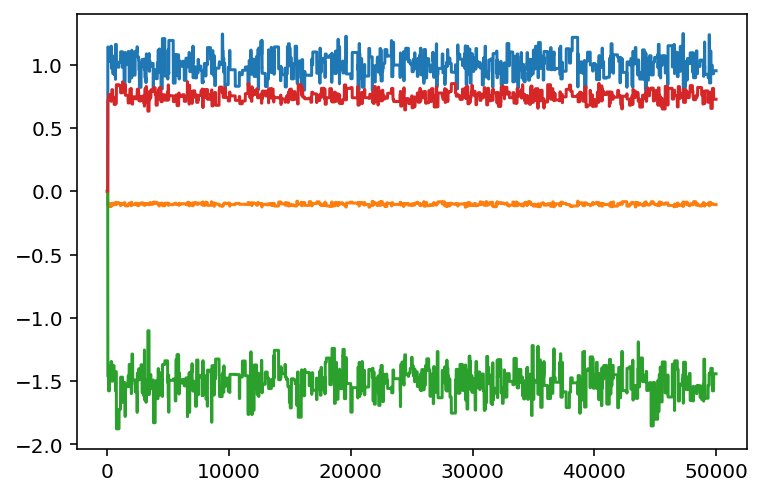

In [21]:
plt.plot(parameters)

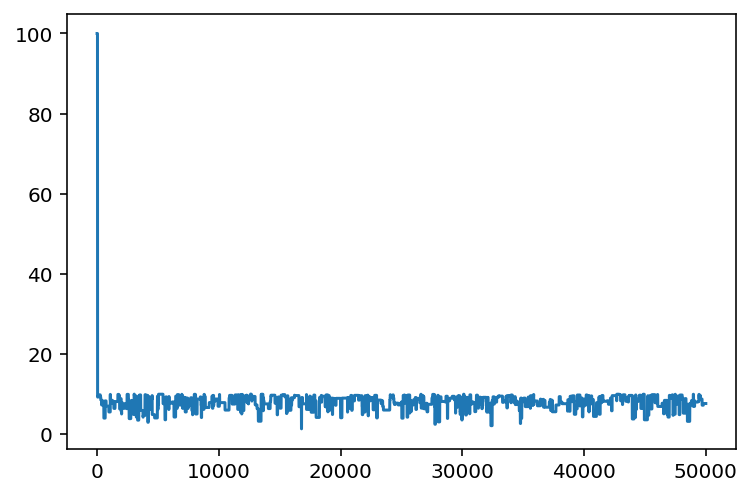

In [22]:
plt.plot(lambdalist)

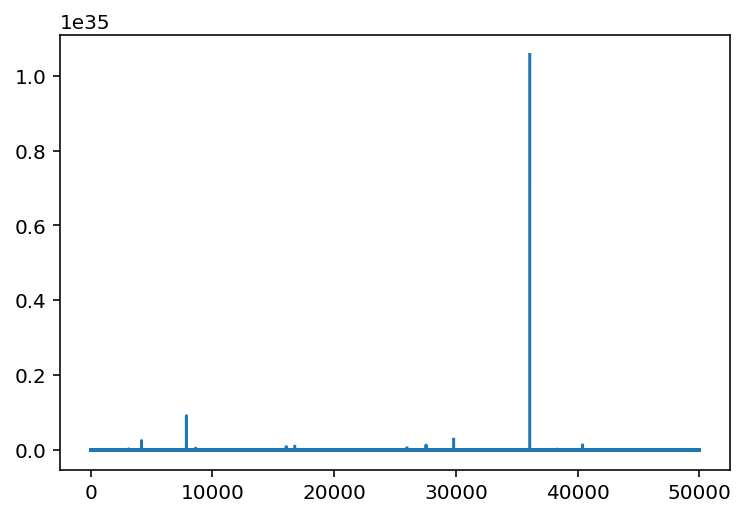

In [23]:
plt.plot(loss)

In [24]:
parameters

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       ...,
       [ 0.95198662, -0.10543131, -1.44228636,  0.72684861],
       [ 0.95198662, -0.10543131, -1.44228636,  0.72684861],
       [ 0.95198662, -0.10543131, -1.44228636,  0.72684861]])

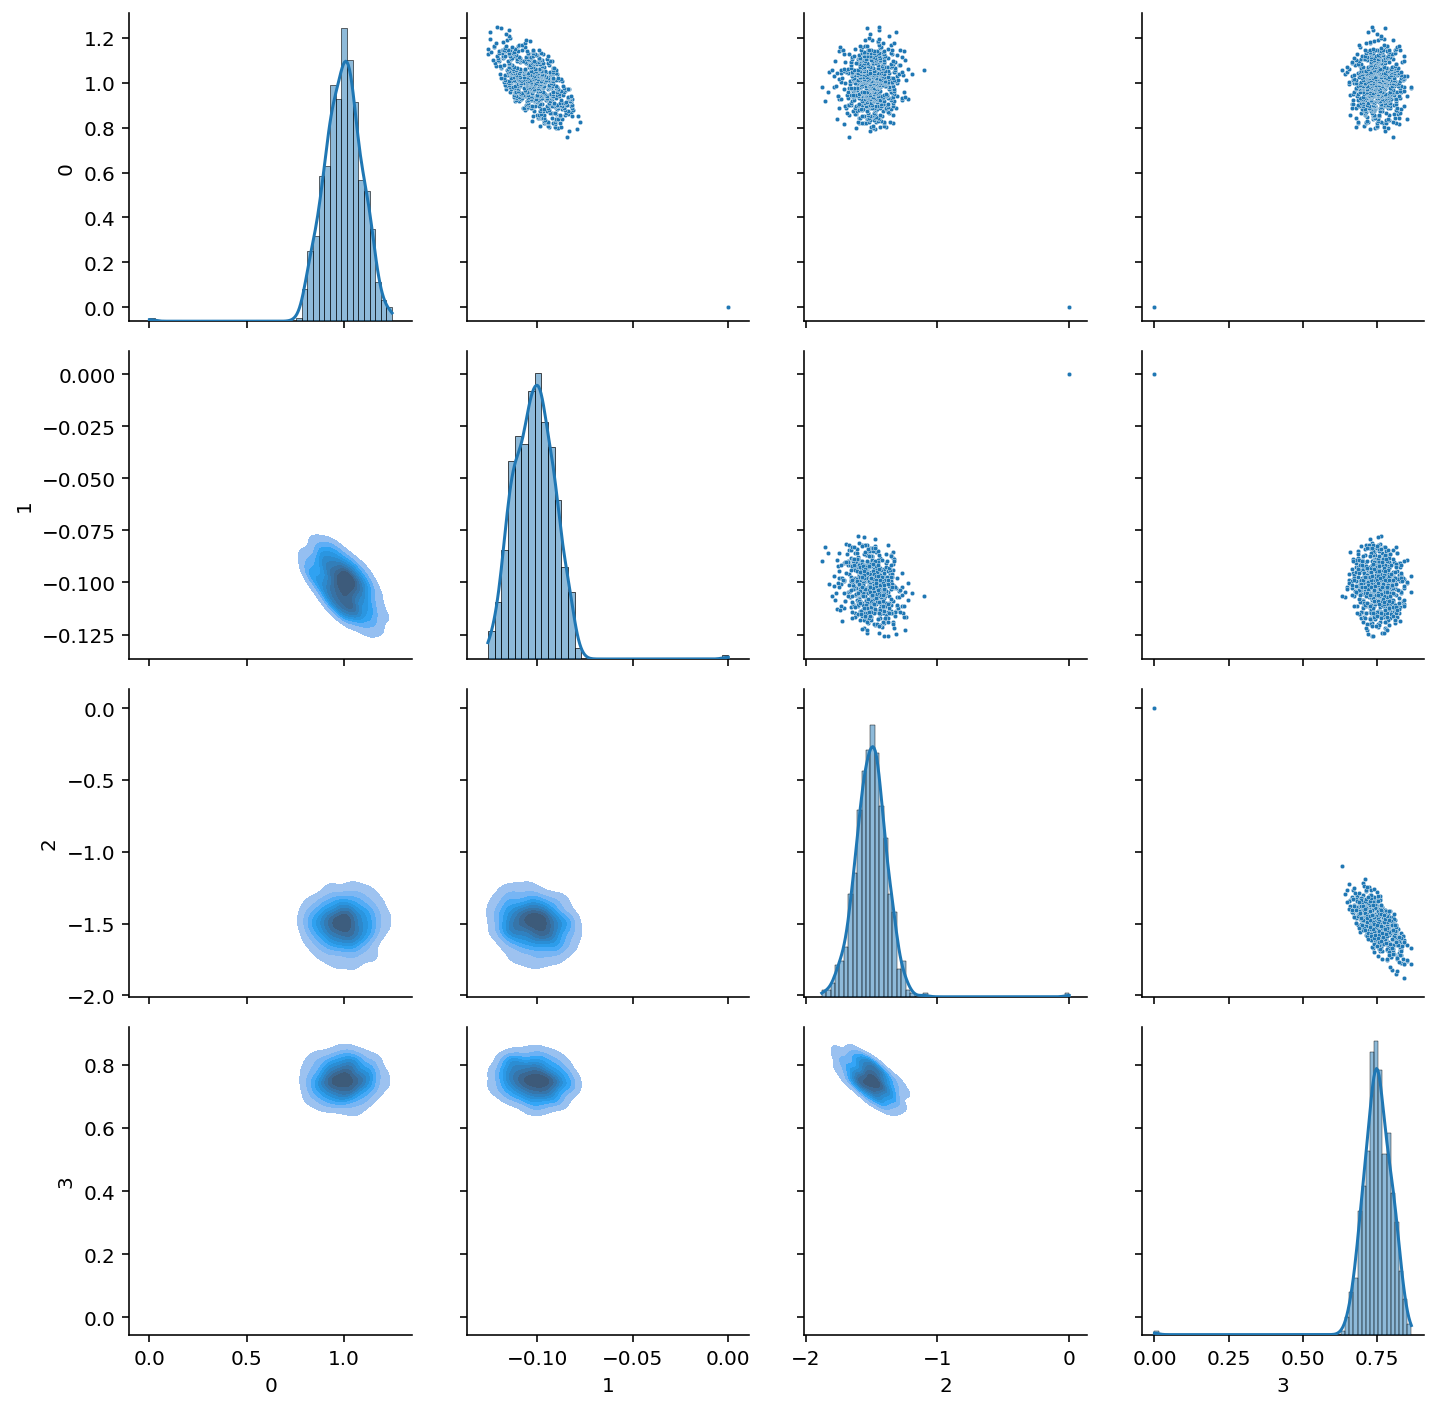

In [26]:
import seaborn as sns
import pandas as pd

g = sns.PairGrid(pd.DataFrame(np.unique(parameters, axis = 0)))
g.map_upper(sns.scatterplot, s = 5)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

In [27]:
t_grid = np.linspace(0, 25, data_size) # uniformly spaced data? -> even though advantage is learning with not uniformly spaced data
z0 = [5., 5.] # initial conditions
 
for j in tqdm(range(parameters.shape[0])):
    simul_yy =  odeint(VP, z0, t_grid, args=tuple(parameters[j]))
    plot_traj_gray(simul_yy)

true_yy = odeint(SIR, z0, t_grid, args=(beta, gamma))  # potrebbe aver senso tenerli in memoria se è lento
plot_traj(true_yy)

    
plt.show()

  0%|                                                                                        | 0/50000 [00:00<?, ?it/s]


NameError: name 'plot_traj_gray' is not defined

In [ ]:
import arviz as az

az.ess(parameters[:,1])

In [ ]:
az.plot_posterior(parameters[:,0],hdi_prob = 0.95, ref_val = 1)

In [ ]:
az.plot_posterior(parameters[:,1],hdi_prob = 0.95, ref_val = -0.1)

In [ ]:
az.plot_posterior(parameters[:,2],hdi_prob = 0.95, ref_val = -1.5)

In [ ]:
az.plot_posterior(parameters[:,2],hdi_prob = 0.95, ref_val = 0.75)

In [ ]:
az.plot_mcse(parameters[:,1])